契約期間２&フル間取りでGOSSに交差検証法を試す。

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')
buildings = pd.read_csv('buildings.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_buildings = pd.read_csv('test_buildings.csv')

In [7]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K",'S']]], axis=1)
y_train = rent

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K",'S']]], axis=1)

category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.2667345328336822e-06,
        'max_bin': 405,
        'num_leaves': 118
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49712.4	valid_1's rmse: 52813.4
[20]	training's rmse: 35153.7	valid_1's rmse: 40945.6
[30]	training's rmse: 27250.7	valid_1's rmse: 34945.2
[40]	training's rmse: 22563.5	valid_1's rmse: 31659.1
[50]	training's rmse: 19563.3	valid_1's rmse: 29684.6
[60]	training's rmse: 17729.5	valid_1's rmse: 28401.5
[70]	training's rmse: 16460.1	valid_1's rmse: 27590
[80]	training's rmse: 15588.2	valid_1's rmse: 27036.5
[90]	training's rmse: 14881.7	valid_1's rmse: 26543.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2124
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50141.5	valid_1's rmse: 51820.2
[20]	training's rmse: 35997.3	valid_1's rmse: 38275.5
[30]	training's rmse: 28619.7	valid_1's rmse: 31518.7
[40]	training's rmse: 24234.4	valid_1's rmse: 27181
[50]	training's rmse: 21447.5	valid_1's rmse: 24580.6
[60]	training's rmse: 19701.8	valid_1's rmse: 23129.9
[70]	training's rmse: 18561.6	valid_1's rmse: 22265.3
[80]	training's rmse: 17603.6	valid_1's rmse: 21694.7
[90]	training's rmse: 16758.2	valid_1's rmse: 21464.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50848.1	valid_1's rmse: 49993.6
[20]	training's rmse: 36719.2	valid_1's rmse: 36433.4
[30]	training's rmse: 29318.1	valid_1's rmse: 29109.1
[40]	training's rmse: 24793.6	valid_1's rmse: 25207.7
[50]	training's rmse: 21930	valid_1's rmse: 22737.2
[60]	training's rmse: 20186.2	valid_1's rmse: 21652.2
[70]	training's rmse: 19007.3	valid_1's rmse: 20884
[80]	training's rmse: 18104.3	valid_1's rmse: 20352.7
[90]	training's rmse: 17335.8	valid_1's rmse: 19947.5
[100]	training's rmse: 16714.8	valid_1's rmse: 19729.9
[110]	training's rmse: 16222.5	valid_1's rmse: 19543.1
[120]	training's rmse: 15750.2	valid_1's rmse: 19347.8
[130]	training's rmse: 15397.8	valid_1's rmse: 19247.6
[140]	training's rmse: 15017.9	valid_1's rmse: 19114.1
[150]	training's rmse: 14671.3	valid_1's rmse: 19019.6
[160]	training's rmse: 14404.8	valid_1's rmse: 18966.9
[170]	training's rmse: 14120.7	valid_1's rmse: 18880
[180]	training's rmse: 13840.4	valid_1's rmse: 18828
[190]	training's rmse: 1361

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51209	valid_1's rmse: 48697.2
[20]	training's rmse: 36701.6	valid_1's rmse: 36058.3
[30]	training's rmse: 28948.1	valid_1's rmse: 29459.9
[40]	training's rmse: 24335	valid_1's rmse: 25894.1
[50]	training's rmse: 21538.3	valid_1's rmse: 23745.9
[60]	training's rmse: 19696.6	valid_1's rmse: 22383.1
[70]	training's rmse: 18485.9	valid_1's rmse: 21562
[80]	training's rmse: 17631.5	valid_1's rmse: 20975.3
[90]	training's rmse: 16920.5	valid_1's rmse: 20555.5
[100]	training's rmse: 16312.7	valid_1's rmse: 20259.7
[110]	training's rmse: 15841.9	valid_1's rmse: 20044.8
[120]	training's rmse: 15424.6	valid_1's rmse: 19826.5
[130]	training's rmse: 15049.7	valid_1's rmse: 19668.6
[140]	training's rmse: 14672.4	valid_1's rmse: 19487.4
[150]	training's rmse: 14311.9	valid_1's rmse: 19321.5
[160]	training's rmse: 14044.5	valid_1's rmse: 19241.4
[170]	training's rmse: 13701.3	valid_1's rmse: 19096.4
[180]	training's rmse: 13434.3	valid_1's rmse: 19037.5
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50180.5	valid_1's rmse: 53087.8
[20]	training's rmse: 36371.4	valid_1's rmse: 39220.7
[30]	training's rmse: 28682.7	valid_1's rmse: 31627.6
[40]	training's rmse: 24251.4	valid_1's rmse: 26942.5
[50]	training's rmse: 21511.8	valid_1's rmse: 24119.6
[60]	training's rmse: 19944.4	valid_1's rmse: 22533.4
[70]	training's rmse: 18816	valid_1's rmse: 21475.6
[80]	training's rmse: 17886.6	valid_1's rmse: 20754.8
[90]	training's rmse: 17246.2	valid_1's rmse: 20264.5
[100]	training's rmse: 16703.9	valid_1's rmse: 19850.1
[110]	training's rmse: 16178.7	valid_1's rmse: 19553.2
[120]	training's rmse: 15707.8	valid_1's rmse: 19251.7
[130]	training's rmse: 15318.2	valid_1's rmse: 18982.6
[140]	training's rmse: 15004.9	valid_1's rmse: 18778
[150]	training's rmse: 14670.1	valid_1's rmse: 18584.5
[160]	training's rmse: 14385.5	valid_1's rmse: 18354
[170]	training's rmse: 14111.8	valid_1's rmse: 18210.9
[180]	training's rmse: 13883.5	valid_1's rmse: 18094.8
[190]	training's rmse: 13

In [8]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('GOSS_cv_result.csv',index=False)

GOSSをクロスバリデーションでチューニング

In [9]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K",'S']]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'K', 'S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [10]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)
study.best_params

[I 2022-09-11 00:10:16,234] A new study created in memory with name: no-name-79777dec-1b56-428e-ad76-ba488dadc443
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49657.6	valid_1's rmse: 52813.6
[20]	training's rmse: 35224.3	valid_1's rmse: 40947.7
[30]	training's rmse: 27025.8	valid_1's rmse: 34700.1
[40]	training's rmse: 22360.3	valid_1's rmse: 31303.8
[50]	training's rmse: 19380.3	valid_1's rmse: 29207.6
[60]	training's rmse: 17480.4	valid_1's rmse: 27917.8
[70]	training's rmse: 16241.2	valid_1's rmse: 27091.9
[80]	training's rmse: 15358.7	valid_1's rmse: 26479.9
[90]	training's rmse: 14709.4	valid_1's rmse: 26050.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50762.6	valid_1's rmse: 52740.7
[20]	training's rmse: 36709	valid_1's rmse: 38947.9
[30]	training's rmse: 29215.7	valid_1's rmse: 31588.2
[40]	training's rmse: 24743.7	valid_1's rmse: 27266.5
[50]	training's rmse: 21977.1	valid_1's rmse: 24631.6
[60]	training's rmse: 20245.3	valid_1's rmse: 23048.1
[70]	training's rmse: 18847.9	valid_1's rmse: 22400
[80]	training's rmse: 17941.6	valid_1's rmse: 21793.5
[90]	training's rmse: 17208.8	valid_1's rmse: 21713.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50989.7	valid_1's rmse: 49508.7
[20]	training's rmse: 37101.5	valid_1's rmse: 35659.2
[30]	training's rmse: 29118.2	valid_1's rmse: 27718.1
[40]	training's rmse: 24630.6	valid_1's rmse: 23816.3
[50]	training's rmse: 21786.5	valid_1's rmse: 21641.8
[60]	training's rmse: 20090	valid_1's rmse: 20488.7
[70]	training's rmse: 18899.1	valid_1's rmse: 19884.3
[80]	training's rmse: 18080.5	valid_1's rmse: 19501.2
[90]	training's rmse: 17412.7	valid_1's rmse: 19287.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36571.1	valid_1's rmse: 36230.8
[30]	training's rmse: 28851.8	valid_1's rmse: 29459.4
[40]	training's rmse: 24257.1	valid_1's rmse: 25840.3
[50]	training's rmse: 21446.3	valid_1's rmse: 23612.9
[60]	training's rmse: 19765.2	valid_1's rmse: 22286.6
[70]	training's rmse: 18502.9	valid_1's rmse: 21413
[80]	training's rmse: 17613.2	valid_1's rmse: 20939.5
[90]	training's rmse: 16939.9	valid_1's rmse: 20596.2
[100]	training's rmse: 16439.7	valid_1's rmse: 20461.9
[110]	training's rmse: 15981.5	valid_1's rmse: 20279.4
[120]	training's rmse: 15588.6	valid_1's rmse: 20093.9
[130]	training's rmse: 15150.6	valid_1's rmse: 19788.9
[140]	training's rmse: 14824.2	valid_1's rmse: 19648.4
[150]	training's rmse: 14554.1	valid_1's rmse: 19514.9
[160]	training's rmse: 14278.7	valid_1's rmse: 19471
[170]	training's rmse: 14010.8	valid_1's rmse: 19384
[180]	training's rmse: 13754.1	valid_1's rmse: 19313.3
[190]	training's rmse: 13530.6	valid_1's rmse: 19256.9
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50459.8	valid_1's rmse: 53260.6
[20]	training's rmse: 36747.8	valid_1's rmse: 39511.5
[30]	training's rmse: 29072.3	valid_1's rmse: 31709.1
[40]	training's rmse: 24692.5	valid_1's rmse: 27245.2
[50]	training's rmse: 21994.9	valid_1's rmse: 24424.5
[60]	training's rmse: 20243.8	valid_1's rmse: 22740.1
[70]	training's rmse: 19047.3	valid_1's rmse: 21734.9
[80]	training's rmse: 18137.3	valid_1's rmse: 21010.5
[90]	training's rmse: 17526.1	valid_1's rmse: 20509.9
[100]	training's rmse: 16912.9	valid_1's rmse: 20069.5
[110]	training's rmse: 16463.4	valid_1's rmse: 19798
[120]	training's rmse: 15967.2	valid_1's rmse: 19417.1
[130]	training's rmse: 15586.4	valid_1's rmse: 19216.8
[140]	training's rmse: 15241.8	valid_1's rmse: 19042.3
[150]	training's rmse: 14927.5	valid_1's rmse: 18816.9
[160]	training's rmse: 14628.1	valid_1's rmse: 18617
[170]	training's rmse: 14352.6	valid_1's rmse: 18433.5
[180]	training's rmse: 14125.1	valid_1's rmse: 18297
[190]	training's rmse: 13

[I 2022-09-11 00:10:32,612] Trial 0 finished with value: 16717.52110601121 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16717.52110601121.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49837.6	valid_1's rmse: 52848
[20]	training's rmse: 35263.4	valid_1's rmse: 40946.6
[30]	training's rmse: 27296.7	valid_1's rmse: 35036
[40]	training's rmse: 22645.6	valid_1's rmse: 31794.9
[50]	training's rmse: 19699.1	valid_1's rmse: 29800.7
[60]	training's rmse: 17792.4	valid_1's rmse: 28542.9
[70]	training's rmse: 16581.4	valid_1's rmse: 27755.6
[80]	training's rmse: 15726.7	valid_1's rmse: 27182.5
[90]	training's rmse: 15035	valid_1's rmse: 26686.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50261.1	valid_1's rmse: 51960.1
[20]	training's rmse: 36170.1	valid_1's rmse: 38358.4
[30]	training's rmse: 28718.7	valid_1's rmse: 31377.7
[40]	training's rmse: 24415.7	valid_1's rmse: 27232.2
[50]	training's rmse: 21690.8	valid_1's rmse: 24664.6
[60]	training's rmse: 19948.5	valid_1's rmse: 23229.4
[70]	training's rmse: 18873.9	valid_1's rmse: 22376.2
[80]	training's rmse: 18007.5	valid_1's rmse: 21766
[90]	training's rmse: 17265	valid_1's rmse: 21359.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50786.4	valid_1's rmse: 49803.5
[20]	training's rmse: 36805.5	valid_1's rmse: 36453.9
[30]	training's rmse: 29339.2	valid_1's rmse: 29088.2
[40]	training's rmse: 24628	valid_1's rmse: 25060.7
[50]	training's rmse: 21842	valid_1's rmse: 22785.4
[60]	training's rmse: 20142.7	valid_1's rmse: 21579.7
[70]	training's rmse: 18951.7	valid_1's rmse: 20827.6
[80]	training's rmse: 18092.3	valid_1's rmse: 20326.8
[90]	training's rmse: 17426.4	valid_1's rmse: 19979.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2114
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51111.4	valid_1's rmse: 48542.1
[20]	training's rmse: 36561.6	valid_1's rmse: 35780
[30]	training's rmse: 28674	valid_1's rmse: 28892.8
[40]	training's rmse: 24083.8	valid_1's rmse: 25267.4
[50]	training's rmse: 21259.8	valid_1's rmse: 23068.9
[60]	training's rmse: 19530.8	valid_1's rmse: 21828.2
[70]	training's rmse: 18417.6	valid_1's rmse: 21060.1
[80]	training's rmse: 17599.7	valid_1's rmse: 20603.5
[90]	training's rmse: 16901.4	valid_1's rmse: 20303.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36507.2	valid_1's rmse: 39801.2
[30]	training's rmse: 29033.5	valid_1's rmse: 32226.9
[40]	training's rmse: 24645.2	valid_1's rmse: 27609.6
[50]	training's rmse: 21917.6	valid_1's rmse: 24714.1
[60]	training's rmse: 20214.9	valid_1's rmse: 23078.5
[70]	training's rmse: 19063.8	valid_1's rmse: 21999
[80]	training's rmse: 18181.6	valid_1's rmse: 21272.3
[90]	training's rmse: 17538.9	valid_1's rmse: 20711.8
[100]	training's rmse: 17042.7	valid_1's rmse: 20336.2
[110]	training's rmse: 16577.5	valid_1's rmse: 20002.7
[120]	training's rmse: 16164.9	valid_1's rmse: 19728.1
[130]	training's rmse: 15787.9	valid_1's rmse: 19479.7
[140]	training's rmse: 15453.6	valid_1's rmse: 19269.5
[150]	training's rmse: 15161.7	valid_1's rmse: 19090
[160]	training's rmse: 14876.2	valid_1's rmse: 18925.8
[170]	training's rmse: 14595.1	valid_1's rmse: 18769
[180]	training's rmse: 14321.3	valid_1's rmse: 18634.9
[190]	training's rmse: 14106.3	valid_1's rmse: 18519.5
[200]	training's rmse: 1

[I 2022-09-11 00:10:49,321] Trial 1 finished with value: 16686.748301177096 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 1 with value: 16686.748301177096.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49595.3	valid_1's rmse: 52710.7
[20]	training's rmse: 35016.2	valid_1's rmse: 41108.7
[30]	training's rmse: 26798.7	valid_1's rmse: 35119.9
[40]	training's rmse: 21978	valid_1's rmse: 31790.8
[50]	training's rmse: 19017.2	valid_1's rmse: 29781.9
[60]	training's rmse: 17182.9	valid_1's rmse: 28557.9
[70]	training's rmse: 15987.6	valid_1's rmse: 27729.4
[80]	training's rmse: 15093.5	valid_1's rmse: 27132.8
[90]	training's rmse: 14408.8	valid_1's rmse: 26635.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2469
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50336.3	valid_1's rmse: 51925.6
[20]	training's rmse: 36116.4	valid_1's rmse: 38286.8
[30]	training's rmse: 28604.9	valid_1's rmse: 30935.7
[40]	training's rmse: 24250.6	valid_1's rmse: 26673.6
[50]	training's rmse: 21443.8	valid_1's rmse: 24085.6
[60]	training's rmse: 19729.1	valid_1's rmse: 22489.1
[70]	training's rmse: 18544.7	valid_1's rmse: 21582.9
[80]	training's rmse: 17455.1	valid_1's rmse: 21365.3
[90]	training's rmse: 16719.5	valid_1's rmse: 21060.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50430.1	valid_1's rmse: 49526.9
[20]	training's rmse: 36384.5	valid_1's rmse: 35953.7
[30]	training's rmse: 28732	valid_1's rmse: 28560.4
[40]	training's rmse: 24290.4	valid_1's rmse: 24790.8
[50]	training's rmse: 21552.1	valid_1's rmse: 22625.7
[60]	training's rmse: 19766	valid_1's rmse: 21423.3
[70]	training's rmse: 18617.4	valid_1's rmse: 20829.8
[80]	training's rmse: 17827	valid_1's rmse: 20465.5
[90]	training's rmse: 17108.6	valid_1's rmse: 20179.9
[100]	training's rmse: 16544.5	valid_1's rmse: 20018.4
[110]	training's rmse: 16006.8	valid_1's rmse: 19845.6
[120]	training's rmse: 15465.7	valid_1's rmse: 19738.1
[130]	training's rmse: 15061.7	valid_1's rmse: 19636.3
[140]	training's rmse: 14653.3	valid_1's rmse: 19540.1
[150]	training's rmse: 14298.4	valid_1's rmse: 19483.6
[160]	training's rmse: 14011.6	valid_1's rmse: 19422.7
[170]	training's rmse: 13701.8	valid_1's rmse: 19348.5
[180]	training's rmse: 13464.4	valid_1's rmse: 19303.2
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50817.9	valid_1's rmse: 48608.5
[20]	training's rmse: 36204.1	valid_1's rmse: 35881.2
[30]	training's rmse: 28489	valid_1's rmse: 29293.3
[40]	training's rmse: 23947.5	valid_1's rmse: 25643.7
[50]	training's rmse: 21157.6	valid_1's rmse: 23467.4
[60]	training's rmse: 19362.2	valid_1's rmse: 22138.5
[70]	training's rmse: 18169.1	valid_1's rmse: 21276.5
[80]	training's rmse: 17322.3	valid_1's rmse: 20760.1
[90]	training's rmse: 16632.4	valid_1's rmse: 20506.9
[100]	training's rmse: 16064.4	valid_1's rmse: 20162.8
[110]	training's rmse: 15537.6	valid_1's rmse: 19937.1
[120]	training's rmse: 15103.3	valid_1's rmse: 19741.3
[130]	training's rmse: 14745.8	valid_1's rmse: 19640.8
[140]	training's rmse: 14379.8	valid_1's rmse: 19498.5
[150]	training's rmse: 14118.1	valid_1's rmse: 19423.4
[160]	training's rmse: 13795.4	valid_1's rmse: 19317
[170]	training's rmse: 13533.9	valid_1's rmse: 19220.2
[180]	training's rmse: 13294.3	valid_1's rmse: 19163.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2467
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50249.3	valid_1's rmse: 53048.4
[20]	training's rmse: 36445.2	valid_1's rmse: 39178.9
[30]	training's rmse: 28982.3	valid_1's rmse: 31502.8
[40]	training's rmse: 24537.3	valid_1's rmse: 26870.7
[50]	training's rmse: 21732	valid_1's rmse: 23975.4
[60]	training's rmse: 20007.7	valid_1's rmse: 22256
[70]	training's rmse: 18779.9	valid_1's rmse: 21254.4
[80]	training's rmse: 17909	valid_1's rmse: 20513.1
[90]	training's rmse: 17208	valid_1's rmse: 20038.9
[100]	training's r

[I 2022-09-11 00:11:12,644] Trial 2 finished with value: 16312.902392802058 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 2 with value: 16312.902392802058.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49861.3	valid_1's rmse: 52937.1
[20]	training's rmse: 35343	valid_1's rmse: 41346.6
[30]	training's rmse: 27216.6	valid_1's rmse: 35328.6
[40]	training's rmse: 22510	valid_1's rmse: 31984.6
[50]	training's rmse: 19486	valid_1's rmse: 29911.3
[60]	training's rmse: 17682.9	valid_1's rmse: 28655
[70]	training's rmse: 16494	valid_1's rmse: 27842.3
[80]	training's rmse: 15620.3	valid_1's rmse: 27225.6
[90]	training's rmse: 14943.4	valid_1's rmse: 26773.1
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50698.7	valid_1's rmse: 52669.8
[20]	training's rmse: 36485.7	valid_1's rmse: 38767.6
[30]	training's rmse: 28827.5	valid_1's rmse: 31099.7
[40]	training's rmse: 24581.7	valid_1's rmse: 26855.9
[50]	training's rmse: 21806.2	valid_1's rmse: 24271.8
[60]	training's rmse: 20034.5	valid_1's rmse: 22744.9
[70]	training's rmse: 18855.4	valid_1's rmse: 21881.7
[80]	training's rmse: 17846.6	valid_1's rmse: 21384.4
[90]	training's rmse: 17065.3	valid_1's rmse: 21197.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50873.6	valid_1's rmse: 49958.3
[20]	training's rmse: 37043.7	valid_1's rmse: 36281.5
[30]	training's rmse: 29207.4	valid_1's rmse: 28764
[40]	training's rmse: 24721.9	valid_1's rmse: 24837.3
[50]	training's rmse: 21912	valid_1's rmse: 22590.4
[60]	training's rmse: 20160	valid_1's rmse: 21325.8
[70]	training's rmse: 18959.1	valid_1's rmse: 20589
[80]	training's rmse: 18122.9	valid_1's rmse: 20161.9
[90]	training's rmse: 17445.1	valid_1's rmse: 19830.6
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2401
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51173.5	valid_1's rmse: 48795
[20]	training's rmse: 36651.6	valid_1's rmse: 36229.3
[30]	training's rmse: 28902	valid_1's rmse: 29614.3
[40]	training's rmse: 24285.1	valid_1's rmse: 25923.1
[50]	training's rmse: 21477.2	valid_1's rmse: 23878.5
[60]	training's rmse: 19794.2	valid_1's rmse: 22587.5
[70]	training's rmse: 18633.3	valid_1's rmse: 21760.2
[80]	training's rmse: 17786.4	valid_1's rmse: 21379.4
[90]	training's rmse: 17122.8	valid_1's rmse: 21027.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36787.1	valid_1's rmse: 39491.1
[30]	training's rmse: 29153.7	valid_1's rmse: 31752.6
[40]	training's rmse: 24798.5	valid_1's rmse: 27297.2
[50]	training's rmse: 22000.3	valid_1's rmse: 24539.7
[60]	training's rmse: 20271.4	valid_1's rmse: 22836.5
[70]	training's rmse: 19101.9	valid_1's rmse: 21759.4
[80]	training's rmse: 18216.9	valid_1's rmse: 21094
[90]	training's rmse: 17615	valid_1's rmse: 20706.1
[100]	training's rmse: 17047.6	valid_1's rmse: 20316.7
[110]	training's rmse: 16540.9	valid_1's rmse: 20019.3
[120]	training's rmse: 16129.3	valid_1's rmse: 19779
[130]	training's rmse: 15755.8	valid_1's rmse: 19526.3
[140]	training's rmse: 15383.1	valid_1's rmse: 19302.4
[150]	training's rmse: 15070.3	valid_1's rmse: 19089.7
[160]	training's rmse: 14782	valid_1's rmse: 18973.2
[170]	training's rmse: 14551	valid_1's rmse: 18865.4
[180]	training's rmse: 14337.2	valid_1's rmse: 18771
[190]	training's rmse: 14114.8	valid_1's rmse: 18611
[200]	training's rmse: 13911	val

[I 2022-09-11 00:11:34,619] Trial 3 finished with value: 16362.760445708018 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 2 with value: 16312.902392802058.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50304.5	valid_1's rmse: 53229
[20]	training's rmse: 36076.3	valid_1's rmse: 41762.8
[30]	training's rmse: 28233	valid_1's rmse: 35926.7
[40]	training's rmse: 23594.5	valid_1's rmse: 32668.7
[50]	training's rmse: 20465.7	valid_1's rmse: 30341.7
[60]	training's rmse: 18578	valid_1's rmse: 29012
[70]	training's rmse: 17359.5	valid_1's rmse: 28162.8
[80]	training's rmse: 16505.7	valid_1's rmse: 27516
[90]	training's rmse: 15880.6	valid_1's rmse: 27042.3
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51098.9	valid_1's rmse: 52684
[20]	training's rmse: 37131	valid_1's rmse: 38836.7
[30]	training's rmse: 29619.3	valid_1's rmse: 31480.2
[40]	training's rmse: 25188.7	valid_1's rmse: 27054.5
[50]	training's rmse: 22515.3	valid_1's rmse: 24432.9
[60]	training's rmse: 20786.1	valid_1's rmse: 22836.3
[70]	training's rmse: 19611.4	valid_1's rmse: 21826.4
[80]	training's rmse: 18783.3	valid_1's rmse: 21208.6
[90]	training's rmse: 18162.9	valid_1's rmse: 20800.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37244.6	valid_1's rmse: 36639.3
[30]	training's rmse: 29700.7	valid_1's rmse: 29511.9
[40]	training's rmse: 25019.5	valid_1's rmse: 25485.6
[50]	training's rmse: 22166.7	valid_1's rmse: 23201.6
[60]	training's rmse: 20515.6	valid_1's rmse: 22066.1
[70]	training's rmse: 19403.8	valid_1's rmse: 21381.4
[80]	training's rmse: 18608.1	valid_1's rmse: 20983.8
[90]	training's rmse: 17943.9	valid_1's rmse: 20740
[100]	training's rmse: 17375.2	valid_1's rmse: 20547.2
[110]	training's rmse: 16920.3	valid_1's rmse: 20355
[120]	training's rmse: 16448.7	valid_1's rmse: 20347.8
[130]	training's rmse: 16128.2	valid_1's rmse: 20266.7
[140]	training's rmse: 15836.2	valid_1's rmse: 20162.4
[150]	training's rmse: 15525.4	valid_1's rmse: 20116.6
[160]	training's rmse: 15246.2	valid_1's rmse: 20082.1
[170]	training's rmse: 14982	valid_1's rmse: 20093.3
[180]	training's rmse: 14756.7	valid_1's rmse: 20053.3
[190]	training's rmse: 14523.9	valid_1's rmse: 19995.1
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37284.3	valid_1's rmse: 37026.2
[30]	training's rmse: 29737.1	valid_1's rmse: 30180.2
[40]	training's rmse: 25283.7	valid_1's rmse: 26508
[50]	training's rmse: 22492.1	valid_1's rmse: 24300.6
[60]	training's rmse: 20680	valid_1's rmse: 22829.4
[70]	training's rmse: 19467.5	valid_1's rmse: 21885
[80]	training's rmse: 18619.9	valid_1's rmse: 21389.2
[90]	training's rmse: 18023.8	valid_1's rmse: 20995.1
[100]	training's rmse: 17489.8	valid_1's rmse: 20754.3
[110]	training's rmse: 17019.7	valid_1's rmse: 20593
[120]	training's rmse: 16589	valid_1's rmse: 20439.2
[130]	training's rmse: 16244.3	valid_1's rmse: 20391.6
[140]	training's rmse: 15915.5	valid_1's rmse: 20286.3
[150]	training's rmse: 15647.9	valid_1's rmse: 20133.7
[160]	training's rmse: 15410.8	valid_1's rmse: 20025.2
[170]	training's rmse: 15198.9	valid_1's rmse: 19926.9
[180]	training's rmse: 14904.6	valid_1's rmse: 19814.8
[190]	training's rmse: 14692.9	valid_1's rmse: 19769
[200]	training's rmse: 14478.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50936.1	valid_1's rmse: 53662.8
[20]	training's rmse: 37288.5	valid_1's rmse: 39870.4
[30]	training's rmse: 29741.1	valid_1's rmse: 32017.5
[40]	training's rmse: 25431.2	valid_1's rmse: 27420
[50]	training's rmse: 22605.8	valid_1's rmse: 24375.2
[60]	training's rmse: 20833.6	valid_1's rmse: 22635.1
[70]	training's rmse: 19672.8	valid_1's rmse: 21543.3
[80]	training's rmse: 18880.4	valid_1's rmse: 20984.1
[90]	training's rmse: 18224.3	valid_1's rmse: 20556.2
[100]	training's rmse: 17714.7	valid_1's rmse: 20133.9
[110]	training's rmse: 17247.9	valid_1's rmse: 19827.8
[120]	training's rmse: 16861.5	valid_1's rmse: 19540.2
[130]	training's rmse: 16484.7	valid_1's rmse: 19311.6
[140]	training's rmse: 16186.3	valid_1's rmse: 19086.2
[150]	training's rmse: 15866.3	valid_1's rmse: 18850.9
[160]	training's rmse: 15600.6	valid_1's rmse: 18647
[170]	training's rmse: 15378.3	valid_1's rmse: 18444.8
[180]	training's 

[I 2022-09-11 00:11:46,696] Trial 4 finished with value: 16064.939894638896 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50030.7	valid_1's rmse: 53537.2
[20]	training's rmse: 35463.8	valid_1's rmse: 41941.6
[30]	training's rmse: 27752.3	valid_1's rmse: 36282.7
[40]	training's rmse: 22923.1	valid_1's rmse: 32820.4
[50]	training's rmse: 19853.3	valid_1's rmse: 30583.2
[60]	training's rmse: 18003.4	valid_1's rmse: 29231.7
[70]	training's rmse: 16692.5	valid_1's rmse: 28255.5
[80]	training's rmse: 15801.8	valid_1's rmse: 27603.9
[90]	training's rmse: 15118.4	valid_1's rmse: 27092.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50579.9	valid_1's rmse: 51789.5
[20]	training's rmse: 36412.3	valid_1's rmse: 38080.5
[30]	training's rmse: 29019	valid_1's rmse: 31004.5
[40]	training's rmse: 24790.1	valid_1's rmse: 27136
[50]	training's rmse: 21945.9	valid_1's rmse: 24591.4
[60]	training's rmse: 20165.3	valid_1's rmse: 22939.7
[70]	training's rmse: 18892.6	valid_1's rmse: 22061.1
[80]	training's rmse: 18006	valid_1's rmse: 21390.7
[90]	training's rmse: 17335.7	valid_1's rmse: 20964.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50682.1	valid_1's rmse: 50302.7
[20]	training's rmse: 36553.8	valid_1's rmse: 36634.9
[30]	training's rmse: 29149.1	valid_1's rmse: 29318.4
[40]	training's rmse: 24609.5	valid_1's rmse: 25379.2
[50]	training's rmse: 21679.7	valid_1's rmse: 22917.8
[60]	training's rmse: 19844.1	valid_1's rmse: 21610.4
[70]	training's rmse: 18681.2	valid_1's rmse: 20842.1
[80]	training's rmse: 17793.5	valid_1's rmse: 20389.8
[90]	training's rmse: 17150	valid_1's rmse: 20135.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36529.9	valid_1's rmse: 36098.2
[30]	training's rmse: 28837.2	valid_1's rmse: 29741.5
[40]	training's rmse: 24383.8	valid_1's rmse: 26308.7
[50]	training's rmse: 21445.3	valid_1's rmse: 24108.7
[60]	training's rmse: 19643.5	valid_1's rmse: 22876.8
[70]	training's rmse: 18474.2	valid_1's rmse: 22060.7
[80]	training's rmse: 17604.1	valid_1's rmse: 21518.3
[90]	training's rmse: 16949.8	valid_1's rmse: 21226.9
[100]	training's rmse: 16419.8	valid_1's rmse: 21061.1
[110]	training's rmse: 15921.1	valid_1's rmse: 20849.4
[120]	training's rmse: 15519.9	valid_1's rmse: 20673.8
[130]	training's rmse: 15130.2	valid_1's rmse: 20506.8
[140]	training's rmse: 14787.6	valid_1's rmse: 20467.7
[150]	training's rmse: 14471.6	valid_1's rmse: 20348.2
[160]	training's rmse: 14202.1	valid_1's rmse: 20277
[170]	training's rmse: 13950.1	valid_1's rmse: 20202.7
[180]	training's rmse: 13741.5	valid_1's rmse: 20116.9
[190]	training's rmse: 13520.1	valid_1's rmse: 20028.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50323.1	valid_1's rmse: 53177.8
[20]	training's rmse: 36789.1	valid_1's rmse: 39576.7
[30]	training's rmse: 29400.4	valid_1's rmse: 31779
[40]	training's rmse: 24965.7	valid_1's rmse: 27088.1
[50]	training's rmse: 22270.3	valid_1's rmse: 24256.8
[60]	training's rmse: 20511.4	valid_1's rmse: 22525
[70]	training's rmse: 19316.2	valid_1's rmse: 21451
[80]	training's rmse: 18445.4	valid_1's rmse: 20765.2
[90]	training's rmse: 17808	valid_1's rmse: 20312.4
[100]	training's r

[I 2022-09-11 00:12:05,621] Trial 5 finished with value: 16759.49476178362 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49686	valid_1's rmse: 52710.9
[20]	training's rmse: 35070.5	valid_1's rmse: 40964.6
[30]	training's rmse: 26993.5	valid_1's rmse: 35052.2
[40]	training's rmse: 22313.2	valid_1's rmse: 31740.3
[50]	training's rmse: 19237	valid_1's rmse: 29573.3
[60]	training's rmse: 17379.9	valid_1's rmse: 28292.2
[70]	training's rmse: 16125.7	valid_1's rmse: 27426
[80]	training's rmse: 15235	valid_1's rmse: 26823.2
[90]	training's rmse: 14567.2	valid_1's rmse: 26380.5
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50351.3	valid_1's rmse: 51904.4
[20]	training's rmse: 36080.9	valid_1's rmse: 38131
[30]	training's rmse: 28684.5	valid_1's rmse: 31025.1
[40]	training's rmse: 24380.9	valid_1's rmse: 26830.8
[50]	training's rmse: 21582.2	valid_1's rmse: 24247.6
[60]	training's rmse: 19713.3	valid_1's rmse: 22799.4
[70]	training's rmse: 18527.3	valid_1's rmse: 21845.3
[80]	training's rmse: 17622.7	valid_1's rmse: 21365.6
[90]	training's rmse: 16824	valid_1's rmse: 21022.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50517.2	valid_1's rmse: 49572
[20]	training's rmse: 36584.5	valid_1's rmse: 35964.1
[30]	training's rmse: 28823.8	valid_1's rmse: 28639.9
[40]	training's rmse: 24272.7	valid_1's rmse: 24649.9
[50]	training's rmse: 21517.3	valid_1's rmse: 22475.9
[60]	training's rmse: 19738.4	valid_1's rmse: 21400
[70]	training's rmse: 18564	valid_1's rmse: 20783
[80]	training's rmse: 17661	valid_1's rmse: 20373.6
[90]	training's rmse: 16997.5	valid_1's rmse: 20141
[100]	training's rmse: 16408.3	valid_1's rmse: 19969.5
[110]	training's rmse: 15830.9	valid_1's rmse: 19800.1
[120]	training's rmse: 15342.3	valid_1's rmse: 19748
[130]	training's rmse: 14968.4	valid_1's rmse: 19684.4
[140]	training's rmse: 14645	valid_1's rmse: 19576.2
[150]	training's rmse: 14311.1	valid_1's rmse: 19542.3
[160]	training's rmse: 14012.5	valid_1's rmse: 19487.1
Early stopping, best iteration is:
[158]	training's rmse: 14074.4	valid_1's rmse: 19478.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threa

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36210.9	valid_1's rmse: 35996.6
[30]	training's rmse: 28462.1	valid_1's rmse: 29100.9
[40]	training's rmse: 23831.5	valid_1's rmse: 25468
[50]	training's rmse: 21024.3	valid_1's rmse: 23416
[60]	training's rmse: 19333.1	valid_1's rmse: 22092.3
[70]	training's rmse: 18285.6	valid_1's rmse: 21394.3
[80]	training's rmse: 17407.7	valid_1's rmse: 20861.4
[90]	training's rmse: 16725.8	valid_1's rmse: 20609.9
[100]	training's rmse: 16118.9	valid_1's rmse: 20301.7
[110]	training's rmse: 15656.3	valid_1's rmse: 20081
[120]	training's rmse: 15212.1	valid_1's rmse: 19885.8
[130]	training's rmse: 14839.2	valid_1's rmse: 19768.1
[140]	training's rmse: 14516.7	valid_1's rmse: 19641.1
[150]	training's rmse: 14201.5	valid_1's rmse: 19535.7
[160]	training's rmse: 13910.4	valid_1's rmse: 19390.4
[170]	training's rmse: 13639.6	valid_1's rmse: 19300.4
[180]	training's rmse: 13412.4	valid_1's rmse: 19218.9
[190]	training's rmse: 13129.7	valid_1's rmse: 19143.9
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2453
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50241.6	valid_1's rmse: 53045.5
[20]	training's rmse: 36468.7	valid_1's rmse: 39173.5
[30]	training's rmse: 29018.8	valid_1's rmse: 31710.5
[40]	training's rmse: 24609.7	valid_1's rmse: 27098.3
[50]	training's rmse: 21909.9	valid_1's rmse: 24277.1
[60]	training's rmse: 20106.6	valid_1's rmse: 22457.6
[70]	training's rmse: 18895	valid_1's rmse: 21396.4
[80]	training's rmse: 17990.5	valid_1's rmse: 20681.1
[90]	training's rmse: 17310.8	valid_1's rmse: 20146.3
[100]	traini

[I 2022-09-11 00:12:28,688] Trial 6 finished with value: 16236.144159356989 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49593.3	valid_1's rmse: 52622.7
[20]	training's rmse: 35020.9	valid_1's rmse: 40862.9
[30]	training's rmse: 27064.4	valid_1's rmse: 35028.1
[40]	training's rmse: 22365.7	valid_1's rmse: 31791.8
[50]	training's rmse: 19422.9	valid_1's rmse: 29788.6
[60]	training's rmse: 17543.9	valid_1's rmse: 28473.9
[70]	training's rmse: 16334.7	valid_1's rmse: 27659.2
[80]	training's rmse: 15527	valid_1's rmse: 27083.8
[90]	training's rmse: 14838.3	valid_1's rmse: 26572.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50172.2	valid_1's rmse: 51639.8
[20]	training's rmse: 36030.8	valid_1's rmse: 38036.8
[30]	training's rmse: 28667.5	valid_1's rmse: 31299.8
[40]	training's rmse: 24296.7	valid_1's rmse: 27392.3
[50]	training's rmse: 21593.6	valid_1's rmse: 24731.1
[60]	training's rmse: 19820.1	valid_1's rmse: 22967.2
[70]	training's rmse: 18686.8	valid_1's rmse: 22093.6
[80]	training's rmse: 17865	valid_1's rmse: 21503.9
[90]	training's rmse: 17216.1	valid_1's rmse: 20965.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36742	valid_1's rmse: 36474.9
[30]	training's rmse: 28979.2	valid_1's rmse: 29014.2
[40]	training's rmse: 24510.7	valid_1's rmse: 25166.2
[50]	training's rmse: 21785.2	valid_1's rmse: 22812.3
[60]	training's rmse: 20017.6	valid_1's rmse: 21580.8
[70]	training's rmse: 18874.6	valid_1's rmse: 20810.9
[80]	training's rmse: 18041.9	valid_1's rmse: 20294.1
[90]	training's rmse: 17378.9	valid_1's rmse: 19938.1
[100]	training's rmse: 16859.2	valid_1's rmse: 19702.4
[110]	training's rmse: 16414.8	valid_1's rmse: 19549.8
[120]	training's rmse: 15985.6	valid_1's rmse: 19417.9
[130]	training's rmse: 15591.3	valid_1's rmse: 19253.2
[140]	training's rmse: 15195	valid_1's rmse: 19167.3
[150]	training's rmse: 14867.7	valid_1's rmse: 19074.4
[160]	training's rmse: 14528.2	valid_1's rmse: 18973.1
[170]	training's rmse: 14266.7	valid_1's rmse: 18956
[180]	training's rmse: 14016.4	valid_1's rmse: 18951.7
[190]	training's rmse: 13756.7	valid_1's rmse: 18881.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51249.1	valid_1's rmse: 48744.1
[20]	training's rmse: 36736.8	valid_1's rmse: 36050.3
[30]	training's rmse: 28789.7	valid_1's rmse: 29419.9
[40]	training's rmse: 24137	valid_1's rmse: 25877.7
[50]	training's rmse: 21351	valid_1's rmse: 23694.8
[60]	training's rmse: 19604.4	valid_1's rmse: 22448.5
[70]	training's rmse: 18350.2	valid_1's rmse: 21614.2
[80]	training's rmse: 17508.2	valid_1's rmse: 21096.3
[90]	training's rmse: 16840.2	valid_1's rmse: 20773.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50290.4	valid_1's rmse: 53317
[20]	training's rmse: 36522.6	valid_1's rmse: 39448.1
[30]	training's rmse: 28991.4	valid_1's rmse: 32035.4
[40]	training's rmse: 24549.8	valid_1's rmse: 27437.2
[50]	training's rmse: 21773.7	valid_1's rmse: 24457.3
[60]	training's rmse: 20096.2	valid_1's rmse: 22709.6
[70]	training's rmse: 18907.5	valid_1's rmse: 21590.5
[80]	training's rmse: 18070	valid_1's rmse: 20946.5
[90]	training's rmse: 17360.9	valid_1's rmse: 20412.9
[100]	training

[I 2022-09-11 00:12:43,343] Trial 7 finished with value: 16256.731621907047 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50576.4	valid_1's rmse: 53192.2
[20]	training's rmse: 36450	valid_1's rmse: 41714.3
[30]	training's rmse: 28398.5	valid_1's rmse: 35755.4
[40]	training's rmse: 23415.3	valid_1's rmse: 32141
[50]	training's rmse: 20465.1	valid_1's rmse: 30049.4
[60]	training's rmse: 18588.8	valid_1's rmse: 28683.2
[70]	training's rmse: 17363.7	valid_1's rmse: 27805.2
[80]	training's rmse: 16507.3	valid_1's rmse: 27189
[90]	training's rmse: 15869.8	valid_1's rmse: 26737
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51169.3	valid_1's rmse: 52760.6
[20]	training's rmse: 37196	valid_1's rmse: 38951.2
[30]	training's rmse: 29988.7	valid_1's rmse: 32016.3
[40]	training's rmse: 25561.5	valid_1's rmse: 27717.5
[50]	training's rmse: 22693.6	valid_1's rmse: 25141.8
[60]	training's rmse: 20875	valid_1's rmse: 23739.4
[70]	training's rmse: 19718.2	valid_1's rmse: 22867.7
[80]	training's rmse: 18690.2	valid_1's rmse: 22406.2
[90]	training's rmse: 18022.3	valid_1's rmse: 22036.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51477.8	valid_1's rmse: 50088.5
[20]	training's rmse: 37581.9	valid_1's rmse: 36467.2
[30]	training's rmse: 29800.4	valid_1's rmse: 28839.2
[40]	training's rmse: 25371.5	valid_1's rmse: 24969
[50]	training's rmse: 22617.1	valid_1's rmse: 22922.3
[60]	training's rmse: 20876.5	valid_1's rmse: 21689.1
[70]	training's rmse: 19687	valid_1's rmse: 20931.6
[80]	training's rmse: 18905.3	valid_1's rmse: 20459.1
[90]	training's rmse: 18268.6	valid_1's rmse: 20153.3
[100]	training's rmse: 17681.6	valid_1's rmse: 19938.6
[110]	training's rmse: 17170.6	valid_1's rmse: 19734.2
[120]	training's rmse: 16639.2	valid_1's rmse: 19415.4
[130]	training's rmse: 16256.2	valid_1's rmse: 19298.2
[140]	training's rmse: 15913.4	valid_1's rmse: 19125.3
[150]	training's rmse: 15580	valid_1's rmse: 19015.3
[160]	training's rmse: 15244.9	valid_1's rmse: 18925.8
[170]	training's rmse: 14979.7	valid_1's rmse: 18883.3
[180]	training's rmse: 14701.4	valid_1's rmse: 18817
[190]	training's rmse: 1447

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51747.4	valid_1's rmse: 49281.4
[20]	training's rmse: 37416.2	valid_1's rmse: 37098.3
[30]	training's rmse: 29750.9	valid_1's rmse: 30211.1
[40]	training's rmse: 25081.5	valid_1's rmse: 26496.7
[50]	training's rmse: 22280.4	valid_1's rmse: 24217.3
[60]	training's rmse: 20493.8	valid_1's rmse: 22775.9
[70]	training's rmse: 19332.4	valid_1's rmse: 21906.3
[80]	training's rmse: 18548.1	valid_1's rmse: 21400.3
[90]	training's rmse: 17870.6	valid_1's rmse: 21063.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51004.2	valid_1's rmse: 54123.1
[20]	training's rmse: 37432.4	valid_1's rmse: 40302.3
[30]	training's rmse: 30018.1	valid_1's rmse: 32555
[40]	training's rmse: 25582	valid_1's rmse: 27765.9
[50]	training's rmse: 22884.3	valid_1's rmse: 24909.8
[60]	training's rmse: 21120.4	valid_1's rmse: 23079.1
[70]	training's rmse: 19954.6	valid_1's rmse: 21942.8
[80]	training's rmse: 19145.9	valid_1's rmse: 21333.9
[90]	training's rmse: 18475	valid_1's rmse: 20736.1
[100]	training's rmse: 17911.2	valid_1's rmse: 20257.8
[110]	training's rmse: 17440	valid_1's rmse: 19892.9
[120]	training's rmse: 17013.1	valid_1's rmse: 19536.1
[130]	training's rmse: 16664.1	valid_1's rmse: 19334.5
[140]	training's rmse: 16346.5	valid_1's rmse: 19081.4
[150]	training's rmse: 16074.4	valid_1's rmse: 18871.3
[160]	training's rmse: 15797.2	valid_1's rmse: 18716.3
[170]	training's rmse: 15559.3	valid_1's rmse: 18585.4
[180]	training's rmse

[I 2022-09-11 00:12:55,637] Trial 8 finished with value: 16223.083340937563 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 4 with value: 16064.939894638896.


[540]	training's rmse: 10643.6	valid_1's rmse: 16237.6
[550]	training's rmse: 10567.7	valid_1's rmse: 16231
Early stopping, best iteration is:
[543]	training's rmse: 10619.3	valid_1's rmse: 16223.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49895.9	valid_1's rmse: 52810.4
[20]	training's rmse: 35461.5	valid_1's rmse: 41112.3
[30]	training's rmse: 27636.1	valid_1's rmse: 35264.2
[40]	training's rmse: 22923.1	valid_1's rmse: 31926.6
[50]	training's rmse: 19832.2	valid_1's rmse: 29771.3
[60]	training's rmse: 17903.9	valid_1's rmse: 28454.7
[70]	training's rmse: 16745.1	valid_1's rmse: 27711.9
[80]	training's rmse: 15852	valid_1's rmse: 27086.1
[90]	training's rmse: 15227.2	valid_1's rmse: 26629.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50374	valid_1's rmse: 52100.1
[20]	training's rmse: 36408.6	valid_1's rmse: 38542.6
[30]	training's rmse: 29008.1	valid_1's rmse: 31297.9
[40]	training's rmse: 24747.8	valid_1's rmse: 27233.9
[50]	training's rmse: 21989.7	valid_1's rmse: 24683.5
[60]	training's rmse: 20297.3	valid_1's rmse: 23336.3
[70]	training's rmse: 19052.4	valid_1's rmse: 22490.4
[80]	training's rmse: 18114.1	valid_1's rmse: 21949.8
[90]	training's rmse: 17431.6	valid_1's rmse: 21693.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51330	valid_1's rmse: 49988.2
[20]	training's rmse: 37353.7	valid_1's rmse: 36470.4
[30]	training's rmse: 29662.8	valid_1's rmse: 28718.6
[40]	training's rmse: 25283.5	valid_1's rmse: 24648.3
[50]	training's rmse: 22359	valid_1's rmse: 22455.6
[60]	training's rmse: 20539.6	valid_1's rmse: 21160
[70]	training's rmse: 19382.9	valid_1's rmse: 20477.5
[80]	training's rmse: 18467.6	valid_1's rmse: 19979.8
[90]	training's rmse: 17766.4	valid_1's rmse: 19746.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2215
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51521.7	valid_1's rmse: 49128.9
[20]	training's rmse: 36900.6	valid_1's rmse: 36456.9
[30]	training's rmse: 29256.8	valid_1's rmse: 29683.1
[40]	training's rmse: 24551	valid_1's rmse: 25889.2
[50]	training's rmse: 21685	valid_1's rmse: 23614.6
[60]	training's rmse: 19989.5	valid_1's rmse: 22252.9
[70]	training's rmse: 18761.6	valid_1's rmse: 21287.8
[80]	training's rmse: 17859	valid_1's rmse: 20767
[90]	training's rmse: 17194.4	valid_1's rmse: 20431.2
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50377.1	valid_1's rmse: 53361.5
[20]	training's rmse: 36753.7	valid_1's rmse: 39791.1
[30]	training's rmse: 29360.5	valid_1's rmse: 32077.7
[40]	training's rmse: 24929.8	valid_1's rmse: 27458
[50]	training's rmse: 22119.9	valid_1's rmse: 24430.5
[60]	training's rmse: 20404.3	valid_1's rmse: 22681
[70]	training's rmse: 19310.1	valid_1's rmse: 21690.9
[80]	training's rmse: 18474.1	valid_1's rmse: 21004.7
[90]	training's rmse: 17864.8	valid_1's rmse: 20501.4
[100]	training

[I 2022-09-11 00:13:07,503] Trial 9 finished with value: 16682.301048601363 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 4 with value: 16064.939894638896.


Early stopping, best iteration is:
[477]	training's rmse: 10889.4	valid_1's rmse: 16682.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 49906.4	valid_1's rmse: 52926
[20]	training's rmse: 35483.8	valid_1's rmse: 41428.5
[30]	training's rmse: 27545.9	valid_1's rmse: 35462.8
[40]	training's rmse: 22681.2	valid_1's rmse: 31920.5
[50]	training's rmse: 19685.6	valid_1's rmse: 29813.6
[60]	training's rmse: 17819.1	valid_1's rmse: 28542.6
[70]	training's rmse: 16634	valid_1's rmse: 27699.2
[80]	training's rmse: 15752.5	valid_1's rmse: 27094.9
[90]	training's rmse: 15109	valid_1's rmse: 26676
[100]	training's rmse: 14572.9	valid_1's rmse: 26312.7
[110]	training's rmse: 14091.7	valid_1's rmse: 26000.8
[120]	training's rmse: 13698	valid_1's rmse: 25745.4
[130]	training's rmse: 13354.3	valid_1's rmse: 25556.6
[140]	training's rmse: 13023.9	valid_1's rmse: 25394.6
[150]	training's rmse: 12718.3	valid_1's rmse: 25228.2
[160]	training's rmse: 12445.5	valid_1's rmse: 25102.7
[170]	training's rmse: 12182.3	valid_1's rmse: 24950.5
[180]	training's rmse: 11913.9	valid_1's rmse: 24784.1
[190]	training's rmse: 11684.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50750.4	valid_1's rmse: 52724
[20]	training's rmse: 36574.9	valid_1's rmse: 38836.2
[30]	training's rmse: 29034.7	valid_1's rmse: 31346.3
[40]	training's rmse: 24677.5	valid_1's rmse: 27103.3
[50]	training's rmse: 21767	valid_1's rmse: 24372.2
[60]	training's rmse: 20076.3	valid_1's rmse: 22866.5
[70]	training's rmse: 18873.2	valid_1's rmse: 21812.3
[80]	training's rmse: 17959	valid_1's rmse: 21334
[90]	training's rmse: 17349	valid_1's rmse: 21016.4
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50877.5	valid_1's rmse: 49865.9
[20]	training's rmse: 37092.8	valid_1's rmse: 36268.4
[30]	training's rmse: 29474.3	valid_1's rmse: 28803.9
[40]	training's rmse: 24787.8	valid_1's rmse: 24646.5
[50]	training's rmse: 21991.4	valid_1's rmse: 22523.5
[60]	training's rmse: 20251.2	valid_1's rmse: 21216.3
[70]	training's rmse: 19044.9	valid_1's rmse: 20524.5
[80]	training's rmse: 18197.2	valid_1's rmse: 20142.1
[90]	training's rmse: 17519.9	valid_1's rmse: 19806
[100]	training's rmse: 16962	valid_1's rmse: 19549
[110]	training's rmse: 16407.8	valid_1's rmse: 19343.4
[120]	training's rmse: 15976.2	valid_1's rmse: 19213
[130]	training's rmse: 15601.6	valid_1's rmse: 19139.3
[140]	training's rmse: 15258.7	valid_1's rmse: 19031.5
[150]	training's rmse: 14955.1	valid_1's rmse: 18908.3
[160]	training's rmse: 14660.5	valid_1's rmse: 18833.1
[170]	training's rmse: 14389.7	valid_1's rmse: 18764.6
[180]	training's rmse: 14122.4	valid_1's rmse: 18721.7
[190]	training's rmse: 1390

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51186.6	valid_1's rmse: 48829
[20]	training's rmse: 36703.2	valid_1's rmse: 36312.3
[30]	training's rmse: 29041.8	valid_1's rmse: 29729.7
[40]	training's rmse: 24530.1	valid_1's rmse: 26135.2
[50]	training's rmse: 21698.2	valid_1's rmse: 24013.9
[60]	training's rmse: 19956.1	valid_1's rmse: 22606.6
[70]	training's rmse: 18804.2	valid_1's rmse: 21754.2
[80]	training's rmse: 17896.2	valid_1's rmse: 21259.9
[90]	training's rmse: 17236.8	valid_1's rmse: 20993.9
[100]	training's rmse: 16696.4	valid_1's rmse: 20670.9
[110]	training's rmse: 16240.8	valid_1's rmse: 20516.7
[120]	training's rmse: 15875.6	valid_1's rmse: 20286.3
[130]	training's rmse: 15497.6	valid_1's rmse: 20154.3
[140]	training's rmse: 15185.5	valid_1's rmse: 20054.5
[150]	training's rmse: 14876.8	valid_1's rmse: 20008.4
[160]	training's rmse: 14592.8	valid_1's rmse: 19862.8
[170]	training's rmse: 14345.4	valid_1's rmse: 19750
[180]	training's rmse: 14071.8	valid_1's rmse: 19629.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50537.5	valid_1's rmse: 53390.6
[20]	training's rmse: 36824.6	valid_1's rmse: 39688.3
[30]	training's rmse: 29135.3	valid_1's rmse: 31770.1
[40]	training's rmse: 24750.6	valid_1's rmse: 27314.9
[50]	training's rmse: 21948.5	valid_1's rmse: 24240.8
[60]	training's rmse: 20243.5	valid_1's rmse: 22520.2
[70]	training's rmse: 19101.8	valid_1's rmse: 21558
[80]	training's rmse: 18324.7	valid_1's rmse: 21027.6
[90]	training's rmse: 17566	valid_1's rmse: 20589.6
[100]	training

[I 2022-09-11 00:13:23,833] Trial 10 finished with value: 16212.495438269209 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50163	valid_1's rmse: 53565.8
[20]	training's rmse: 35560.2	valid_1's rmse: 41835.4
[30]	training's rmse: 27648.5	valid_1's rmse: 35985.4
[40]	training's rmse: 22910.2	valid_1's rmse: 32546.4
[50]	training's rmse: 19898	valid_1's rmse: 30378.1
[60]	training's rmse: 18077.8	valid_1's rmse: 29052.8
[70]	training's rmse: 16815.4	valid_1's rmse: 28049.7
[80]	training's rmse: 15926.8	valid_1's rmse: 27353
[90]	training's rmse: 15284.4	valid_1's rmse: 26867.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50645.5	valid_1's rmse: 51872
[20]	training's rmse: 36633.7	valid_1's rmse: 38291.5
[30]	training's rmse: 29357.1	valid_1's rmse: 31380.4
[40]	training's rmse: 24796.1	valid_1's rmse: 26833.2
[50]	training's rmse: 22065.7	valid_1's rmse: 24140.4
[60]	training's rmse: 20318.8	valid_1's rmse: 22623.1
[70]	training's rmse: 19154.1	valid_1's rmse: 21703.3
[80]	training's rmse: 18254	valid_1's rmse: 21150.5
[90]	training's rmse: 17539.2	valid_1's rmse: 20776.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50813.5	valid_1's rmse: 50441
[20]	training's rmse: 36808.2	valid_1's rmse: 36918.1
[30]	training's rmse: 29236.5	valid_1's rmse: 29399.9
[40]	training's rmse: 24694.7	valid_1's rmse: 25292.2
[50]	training's rmse: 21884.9	valid_1's rmse: 22811
[60]	training's rmse: 20151	valid_1's rmse: 21514.3
[70]	training's rmse: 18984.2	valid_1's rmse: 20762.8
[80]	training's rmse: 18174.2	valid_1's rmse: 20328.6
[90]	training's rmse: 17469.5	valid_1's rmse: 20047.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51215.7	valid_1's rmse: 48654.9
[20]	training's rmse: 36641.4	valid_1's rmse: 36151.3
[30]	training's rmse: 28904.7	valid_1's rmse: 29841.2
[40]	training's rmse: 24274.6	valid_1's rmse: 26310.9
[50]	training's rmse: 21489.1	valid_1's rmse: 24373.7
[60]	training's rmse: 19643.9	valid_1's rmse: 23030.7
[70]	training's rmse: 18470.8	valid_1's rmse: 22220.9
[80]	training's rmse: 17648.5	valid_1's rmse: 21920.3
[90]	training's rmse: 17041.2	valid_1's rmse: 21623.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50419.1	valid_1's rmse: 53282.4
[20]	training's rmse: 36947.4	valid_1's rmse: 39681.4
[30]	training's rmse: 29595.3	valid_1's rmse: 32014.9
[40]	training's rmse: 25162.3	valid_1's rmse: 27250.6
[50]	training's rmse: 22405.9	valid_1's rmse: 24402.3
[60]	training's rmse: 20640.2	valid_1's rmse: 22640.6
[70]	training's rmse: 19479.4	valid_1's rmse: 21551.6
[80]	training's rmse: 18684.4	valid_1's rmse: 21005.4
[90]	training's rmse: 18023.7	valid_1's rmse: 20479.9
[100]	trai

[I 2022-09-11 00:13:36,459] Trial 11 finished with value: 16740.013580854134 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49979.2	valid_1's rmse: 52779.5
[20]	training's rmse: 35471.6	valid_1's rmse: 41026.4
[30]	training's rmse: 27105.5	valid_1's rmse: 34911.9
[40]	training's rmse: 22227.5	valid_1's rmse: 31489.7
[50]	training's rmse: 19282.8	valid_1's rmse: 29461.3
[60]	training's rmse: 17378.4	valid_1's rmse: 28164.8
[70]	training's rmse: 16207.2	valid_1's rmse: 27431.8
[80]	training's rmse: 15296	valid_1's rmse: 26854.5
[90]	training's rmse: 14603	valid_1's rmse: 26426.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50612.5	valid_1's rmse: 52203.8
[20]	training's rmse: 36334.6	valid_1's rmse: 38212.2
[30]	training's rmse: 29131.3	valid_1's rmse: 31256.4
[40]	training's rmse: 24655.4	valid_1's rmse: 27066.6
[50]	training's rmse: 21856.5	valid_1's rmse: 24656.1
[60]	training's rmse: 20028.9	valid_1's rmse: 23499.6
[70]	training's rmse: 18745.7	valid_1's rmse: 22741.2
[80]	training's rmse: 17759.6	valid_1's rmse: 22307.5
[90]	training's rmse: 17035.4	valid_1's rmse: 22095
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37033	valid_1's rmse: 35629.6
[30]	training's rmse: 29406.6	valid_1's rmse: 28036.2
[40]	training's rmse: 24632.3	valid_1's rmse: 23978
[50]	training's rmse: 21708.1	valid_1's rmse: 21691.2
[60]	training's rmse: 19982.7	valid_1's rmse: 20448.9
[70]	training's rmse: 18769.4	valid_1's rmse: 19853.4
[80]	training's rmse: 17868.1	valid_1's rmse: 19433.1
[90]	training's rmse: 17161.5	valid_1's rmse: 19178.3
[100]	training's rmse: 16633.7	valid_1's rmse: 18953.2
[110]	training's rmse: 16077.8	valid_1's rmse: 18741.7
[120]	training's rmse: 15611.1	valid_1's rmse: 18601.5
[130]	training's rmse: 15208.7	valid_1's rmse: 18482.5
[140]	training's rmse: 14843.4	valid_1's rmse: 18389.9
[150]	training's rmse: 14493.3	valid_1's rmse: 18323.1
[160]	training's rmse: 14149.7	valid_1's rmse: 18304
[170]	training's rmse: 13865.9	valid_1's rmse: 18221.3
[180]	training's rmse: 13557.2	valid_1's rmse: 18160.6
[190]	training's rmse: 13299.7	valid_1's rmse: 18124.3
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51176.7	valid_1's rmse: 48754.7
[20]	training's rmse: 36613.8	valid_1's rmse: 35951.6
[30]	training's rmse: 28874.4	valid_1's rmse: 29220.8
[40]	training's rmse: 24283.4	valid_1's rmse: 25698.4
[50]	training's rmse: 21328.7	valid_1's rmse: 23498.7
[60]	training's rmse: 19546.7	valid_1's rmse: 22225.6
[70]	training's rmse: 18334.2	valid_1's rmse: 21529.7
[80]	training's rmse: 17446.4	valid_1's rmse: 21066.1
[90]	training's rmse: 16762.4	valid_1's rmse: 20706.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50335.1	valid_1's rmse: 53477.7
[20]	training's rmse: 36455.5	valid_1's rmse: 39677.1
[30]	training's rmse: 28928.5	valid_1's rmse: 32098
[40]	training's rmse: 24753.6	valid_1's rmse: 27659
[50]	training's rmse: 22039.3	valid_1's rmse: 24717.6
[60]	training's rmse: 20337.2	valid_1's rmse: 23012.8
[70]	training's rmse: 19179	valid_1's rmse: 21767.5
[80]	training's rmse: 18333.9	valid_1's rmse: 21001.6
[90]	training's rmse: 17632.6	valid_1's rmse: 20423.1
[100]	training's rmse: 16982.4	valid_1's rmse: 19836.3
[110]	training's rmse: 16453.2	valid_1's rmse: 19546.3
[120]	training's rmse: 15951.1	valid_1's rmse: 19208.4
[130]	training's rmse: 15544.4	valid_1's rmse: 18970.2
[140]	training's rmse: 15084.2	valid_1's rmse: 18657.7
[150]	training's rmse: 14692.6	valid_1's rmse: 18434.3
[160]	training's rmse: 14377.7	valid_1's rmse: 18255.9
[170]	training's rmse: 14110.8	valid_1's rmse: 18161.6
[180]	training's rmse: 13871.6	valid_1's rmse: 18035.6
[190]	training's rmse: 13

[I 2022-09-11 00:13:51,286] Trial 12 finished with value: 16704.664831170056 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50149.8	valid_1's rmse: 52820.5
[20]	training's rmse: 35669.5	valid_1's rmse: 41057.8
[30]	training's rmse: 27750.9	valid_1's rmse: 35128.5
[40]	training's rmse: 23076.1	valid_1's rmse: 31825.8
[50]	training's rmse: 19975.3	valid_1's rmse: 29676.9
[60]	training's rmse: 18110.9	valid_1's rmse: 28432.9
[70]	training's rmse: 16922	valid_1's rmse: 27655.1
[80]	training's rmse: 16057.3	valid_1's rmse: 27106.7
[90]	training's rmse: 15399.6	valid_1's rmse: 26610.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50457.3	valid_1's rmse: 52038.1
[20]	training's rmse: 36450.4	valid_1's rmse: 38693.8
[30]	training's rmse: 28996.8	valid_1's rmse: 32127.8
[40]	training's rmse: 24603.6	valid_1's rmse: 28190.5
[50]	training's rmse: 21880.7	valid_1's rmse: 25884.3
[60]	training's rmse: 20195.8	valid_1's rmse: 24647.8
[70]	training's rmse: 19068.1	valid_1's rmse: 23871.6
[80]	training's rmse: 18266.6	valid_1's rmse: 23398.7
[90]	training's rmse: 17615.4	valid_1's rmse: 22922.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50686.9	valid_1's rmse: 49875.4
[20]	training's rmse: 36865.7	valid_1's rmse: 36355.3
[30]	training's rmse: 29237.2	valid_1's rmse: 28863.6
[40]	training's rmse: 24704.5	valid_1's rmse: 24968.5
[50]	training's rmse: 21902.6	valid_1's rmse: 22753
[60]	training's rmse: 20170.6	valid_1's rmse: 21504.8
[70]	training's rmse: 18985.7	valid_1's rmse: 20748.5
[80]	training's rmse: 18185.3	valid_1's rmse: 20334.2
[90]	training's rmse: 17549.7	valid_1's rmse: 19997.5
[100]	training's rmse: 17003.5	valid_1's rmse: 19779.9
[110]	training's rmse: 16532.9	valid_1's rmse: 19637.3
[120]	training's rmse: 16053	valid_1's rmse: 19529.6
[130]	training's rmse: 15672.8	valid_1's rmse: 19401.2
[140]	training's rmse: 15250.7	valid_1's rmse: 19347.6
[150]	training's rmse: 14932	valid_1's rmse: 19306.1
[160]	training's rmse: 14664.9	valid_1's rmse: 19262.8
[170]	training's rmse: 14376.5	valid_1's rmse: 19189.3
[180]	training's rmse: 14139	valid_1's rmse: 19130.8
[190]	training's rmse: 1390

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51111.3	valid_1's rmse: 48459.6
[20]	training's rmse: 36743.7	valid_1's rmse: 35841.2
[30]	training's rmse: 29099.6	valid_1's rmse: 28866.6
[40]	training's rmse: 24558.8	valid_1's rmse: 25251.3
[50]	training's rmse: 21744.8	valid_1's rmse: 23044.3
[60]	training's rmse: 20002.4	valid_1's rmse: 21617.2
[70]	training's rmse: 18815.1	valid_1's rmse: 20818.5
[80]	training's rmse: 18001.4	valid_1's rmse: 20322.7
[90]	training's rmse: 17272.6	valid_1's rmse: 19981.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50480.2	valid_1's rmse: 53341.7
[20]	training's rmse: 36736.6	valid_1's rmse: 39471.4
[30]	training's rmse: 29343.1	valid_1's rmse: 31924.6
[40]	training's rmse: 24951.7	valid_1's rmse: 27372.4
[50]	training's rmse: 22221.9	valid_1's rmse: 24539.1
[60]	training's rmse: 20418.7	valid_1's rmse: 22646.7
[70]	training's rmse: 19299.2	valid_1's rmse: 21563.2
[80]	training's rmse: 18464.9	valid_1's rmse: 20954.5
[90]	training's rmse: 17721.8	valid_1's rmse: 20529.7
[100]	training's rmse: 17187.8	valid_1's rmse: 20083.4
[110]	training's rmse: 16709.2	valid_1's rmse: 19759.4
[120]	training's rmse: 16302.1	valid_1's rmse: 19581.7
[130]	training's rmse: 15976.2	valid_1's rmse: 19418.9
[140]	training's rmse: 15633.7	valid_1's rmse: 19249.9
[150]	training's rmse: 15331.1	valid_1's rmse: 19067.1
[160]	training's rmse: 15039.7	valid_1's rmse: 18852.8
[170]	training's rmse: 14795.6	valid_1's rmse: 18707
[180]	training's rmse: 14568	valid_1's rmse: 18529.8
[190]	training's rmse: 

[I 2022-09-11 00:14:06,225] Trial 13 finished with value: 16388.05823618952 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49604.3	valid_1's rmse: 52847.2
[20]	training's rmse: 35035.3	valid_1's rmse: 40904.5
[30]	training's rmse: 27057.8	valid_1's rmse: 34796.5
[40]	training's rmse: 22285.4	valid_1's rmse: 31225.6
[50]	training's rmse: 19299.6	valid_1's rmse: 29088.7
[60]	training's rmse: 17473.6	valid_1's rmse: 27797.3
[70]	training's rmse: 16305.9	valid_1's rmse: 26986.3
[80]	training's rmse: 15460	valid_1's rmse: 26451.4
[90]	training's rmse: 14772.2	valid_1's rmse: 25991.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50552.5	valid_1's rmse: 52132
[20]	training's rmse: 36586.1	valid_1's rmse: 38627.7
[30]	training's rmse: 29306.2	valid_1's rmse: 31337.3
[40]	training's rmse: 24794.1	valid_1's rmse: 27036.6
[50]	training's rmse: 22019.4	valid_1's rmse: 24458.7
[60]	training's rmse: 20212.4	valid_1's rmse: 22838.1
[70]	training's rmse: 18989	valid_1's rmse: 21823.9
[80]	training's rmse: 18140.6	valid_1's rmse: 21279
[90]	training's rmse: 17488.3	valid_1's rmse: 20872.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50813.1	valid_1's rmse: 50021.5
[20]	training's rmse: 36862	valid_1's rmse: 36588.6
[30]	training's rmse: 29205.5	valid_1's rmse: 29157
[40]	training's rmse: 24565.2	valid_1's rmse: 24951.7
[50]	training's rmse: 21829.6	valid_1's rmse: 22811.4
[60]	training's rmse: 20140.2	valid_1's rmse: 21657.3
[70]	training's rmse: 18932.5	valid_1's rmse: 20895.7
[80]	training's rmse: 18080.4	valid_1's rmse: 20518.3
[90]	training's rmse: 17416.4	valid_1's rmse: 20305.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36392.9	valid_1's rmse: 36030.8
[30]	training's rmse: 28594.2	valid_1's rmse: 29679.3
[40]	training's rmse: 23995.1	valid_1's rmse: 26360.5
[50]	training's rmse: 21175.6	valid_1's rmse: 24306.9
[60]	training's rmse: 19489.6	valid_1's rmse: 23138.1
[70]	training's rmse: 18327.8	valid_1's rmse: 22516.1
[80]	training's rmse: 17495	valid_1's rmse: 22146.8
[90]	training's rmse: 16897.1	valid_1's rmse: 21869.3
[100]	training's rmse: 16383.9	valid_1's rmse: 21640.2
[110]	training's rmse: 15936.8	valid_1's rmse: 21469.3
[120]	training's rmse: 15538.3	valid_1's rmse: 21298.6
[130]	training's rmse: 15180.9	valid_1's rmse: 21111.8
[140]	training's rmse: 14862.3	valid_1's rmse: 20868.3
[150]	training's rmse: 14544.4	valid_1's rmse: 20805.1
[160]	training's rmse: 14294.4	valid_1's rmse: 20697.7
[170]	training's rmse: 14049.2	valid_1's rmse: 20592.7
[180]	training's rmse: 13799	valid_1's rmse: 20535.2
[190]	training's rmse: 13576.9	valid_1's rmse: 20453.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50388.9	valid_1's rmse: 53419.4
[20]	training's rmse: 36840.6	valid_1's rmse: 39778.9
[30]	training's rmse: 29411	valid_1's rmse: 32176.8
[40]	training's rmse: 25077.8	valid_1's rmse: 27557.8
[50]	training's rmse: 22283.5	valid_1's rmse: 24645.6
[60]	training's rmse: 20583.9	valid_1's rmse: 22953.7
[70]	training's rmse: 19480.6	valid_1's rmse: 21902.3
[80]	training's rmse: 18609	valid_1's rmse: 21294.4
[90]	training's rmse: 17977.7	valid_1's rmse: 20842.4
[100]	training

[I 2022-09-11 00:14:20,916] Trial 14 finished with value: 17678.721559646336 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 4 with value: 16064.939894638896.


[380]	training's rmse: 11458	valid_1's rmse: 17679.7
Early stopping, best iteration is:
[377]	training's rmse: 11487.6	valid_1's rmse: 17678.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1961
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50540.9	valid_1's rmse: 53383.4
[20]	training's rmse: 36225.8	valid_1's rmse: 41576.7
[30]	training's rmse: 28427.3	valid_1's rmse: 35464.1
[40]	training's rmse: 23705.7	valid_1's rmse: 31942.9
[50]	training's rmse: 20677.5	valid_1's rmse: 29663.5
[60]	training's rmse: 18786.6	valid_1's rmse: 28243.1
[70]	training's rmse: 17561.1	valid_1's rmse: 27386.7
[80]	training's rmse: 16694.8	valid_1's rmse: 26740.1
[90]	training's rmse: 16054.5	valid_1's rmse: 26278.9
[100]	training's rmse: 15518.3	valid_1's rmse: 25934.1
[110]	training's rmse: 15046.3	valid_1's rmse: 25567.3
[120]	training's rmse: 14626.2	valid_1's rmse: 25354
[130]	training's rmse: 14288.4	valid_1's rmse: 25145.6
[140]	training's rmse: 13988	valid_1's rmse: 24969.1
[150]	training's rmse: 13680.9	valid_1's rmse: 24836.2
[160]	training's rmse: 13391	valid_1's rmse: 24696.4
[170]	training's rmse: 13132.4	valid_1's rmse: 24541.3
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50839.2	valid_1's rmse: 51919
[20]	training's rmse: 37020.2	valid_1's rmse: 38434.2
[30]	training's rmse: 29703.4	valid_1's rmse: 31182.2
[40]	training's rmse: 25424.2	valid_1's rmse: 27134.9
[50]	training's rmse: 22729.7	valid_1's rmse: 24994.1
[60]	training's rmse: 20996.8	valid_1's rmse: 23590.7
[70]	training's rmse: 19851.9	valid_1's rmse: 22771.3
[80]	training's rmse: 18903.2	valid_1's rmse: 22345.7
[90]	training's rmse: 18240.6	valid_1's rmse: 21952.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51008	valid_1's rmse: 50324.5
[20]	training's rmse: 37268.5	valid_1's rmse: 36955.6
[30]	training's rmse: 29844.7	valid_1's rmse: 29928.7
[40]	training's rmse: 25432.2	valid_1's rmse: 26315.9
[50]	training's rmse: 22661.5	valid_1's rmse: 24177.9
[60]	training's rmse: 20826.9	valid_1's rmse: 23104.9
[70]	training's rmse: 19649.6	valid_1's rmse: 22481.2
[80]	training's rmse: 18752.1	valid_1's rmse: 22108.1
[90]	training's rmse: 18145.8	valid_1's rmse: 21783.9
[100]	training's rmse: 17621.1	valid_1's rmse: 21548.4
[110]	training's rmse: 17145.9	valid_1's rmse: 21334.6
[120]	training's rmse: 16757.4	valid_1's rmse: 21154.5
[130]	training's rmse: 16340.1	valid_1's rmse: 21055.5
[140]	training's rmse: 16007.3	valid_1's rmse: 20959.3
[150]	training's rmse: 15709.5	valid_1's rmse: 20864.2
[160]	training's rmse: 15386.9	valid_1's rmse: 20758.8
[170]	training's rmse: 15129.7	valid_1's rmse: 20713
[180]	training's rmse: 14895.6	valid_1's rmse: 20618.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 25270.9	valid_1's rmse: 26598.3
[50]	training's rmse: 22460.9	valid_1's rmse: 24315.3
[60]	training's rmse: 20724.9	valid_1's rmse: 22889
[70]	training's rmse: 19468.3	valid_1's rmse: 21943.6
[80]	training's rmse: 18651.1	valid_1's rmse: 21470.1
[90]	training's rmse: 18024.4	valid_1's rmse: 21147.8
[100]	training's rmse: 17470.3	valid_1's rmse: 20882.2
[110]	training's rmse: 17039.8	valid_1's rmse: 20738.1
[120]	training's rmse: 16663.7	valid_1's rmse: 20589.5
[130]	training's rmse: 16353.5	valid_1's rmse: 20528
[140]	training's rmse: 16051.3	valid_1's rmse: 20364.8
[150]	training's rmse: 15773.1	valid_1's rmse: 20298.4
[160]	training's rmse: 15531.3	valid_1's rmse: 20209.1
[170]	training's rmse: 15221.4	valid_1's rmse: 20082.5
[180]	training's rmse: 15015.5	valid_1's rmse: 19995.4
[190]	training's rmse: 14823.7	valid_1's rmse: 19895.2
[200]	training's rmse: 14630.6	valid_1's rmse: 19799.2
[210]	training's rmse: 14429.2	valid_1's rmse: 19733.1
[220]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50829.2	valid_1's rmse: 53836.1
[20]	training's rmse: 37339.3	valid_1's rmse: 40316
[30]	training's rmse: 29845.3	valid_1's rmse: 32440.9
[40]	training's rmse: 25475.7	valid_1's rmse: 27892.8
[50]	training's rmse: 22680	valid_1's rmse: 24818.4
[60]	training's rmse: 20933.9	valid_1's rmse: 23012.2
[70]	training's rmse: 19859.9	valid_1's rmse: 21969.8
[80]	training's rmse: 19034.2	valid_1's rmse: 21306.3
[90]	training's rmse: 18433.7	valid_1's rmse: 20893.8
[100]	training

[I 2022-09-11 00:14:31,403] Trial 15 finished with value: 16905.912832276088 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49984.6	valid_1's rmse: 52764.6
[20]	training's rmse: 35428	valid_1's rmse: 40995.1
[30]	training's rmse: 27539.7	valid_1's rmse: 35130.5
[40]	training's rmse: 22711.6	valid_1's rmse: 31721.7
[50]	training's rmse: 19657.9	valid_1's rmse: 29638.5
[60]	training's rmse: 17852.9	valid_1's rmse: 28434.3
[70]	training's rmse: 16622	valid_1's rmse: 27580.6
[80]	training's rmse: 15753.5	valid_1's rmse: 27014.2
[90]	training's rmse: 15091.6	valid_1's rmse: 26552.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50329.3	valid_1's rmse: 51928.8
[20]	training's rmse: 36281.2	valid_1's rmse: 38531.6
[30]	training's rmse: 28807.4	valid_1's rmse: 31581.5
[40]	training's rmse: 24315.6	valid_1's rmse: 27846.2
[50]	training's rmse: 21578.5	valid_1's rmse: 25638.7
[60]	training's rmse: 19887.9	valid_1's rmse: 24376
[70]	training's rmse: 18772.2	valid_1's rmse: 23621
[80]	training's rmse: 17776.9	valid_1's rmse: 23098.1
[90]	training's rmse: 17133.1	valid_1's rmse: 22764.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29128.5	valid_1's rmse: 28886.7
[40]	training's rmse: 24509.6	valid_1's rmse: 24828.3
[50]	training's rmse: 21753.3	valid_1's rmse: 22620
[60]	training's rmse: 19895	valid_1's rmse: 21345.5
[70]	training's rmse: 18779.2	valid_1's rmse: 20653.6
[80]	training's rmse: 17973.6	valid_1's rmse: 20257.8
[90]	training's rmse: 17335.8	valid_1's rmse: 20005.5
[100]	training's rmse: 16753.6	valid_1's rmse: 19833.4
[110]	training's rmse: 16231	valid_1's rmse: 19610.1
[120]	training's rmse: 15792.2	valid_1's rmse: 19493.2
[130]	training's rmse: 15434.5	valid_1's rmse: 19401.8
[140]	training's rmse: 15087.8	valid_1's rmse: 19373.8
[150]	training's rmse: 14760.1	valid_1's rmse: 19318.7
[160]	training's rmse: 14432.7	valid_1's rmse: 19269.2
[170]	training's rmse: 14145.1	valid_1's rmse: 19204.2
[180]	training's rmse: 13894.8	valid_1's rmse: 19132.1
[190]	training's rmse: 13636.1	valid_1's rmse: 19075.8
[200]	training's rmse: 13414.7	valid_1's rmse: 19009.1
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51053.9	valid_1's rmse: 48429.7
[20]	training's rmse: 36665.4	valid_1's rmse: 35717.9
[30]	training's rmse: 28867.2	valid_1's rmse: 28860.1
[40]	training's rmse: 24188.1	valid_1's rmse: 25139.3
[50]	training's rmse: 21355.6	valid_1's rmse: 22966.3
[60]	training's rmse: 19643.7	valid_1's rmse: 21587.9
[70]	training's rmse: 18426.3	valid_1's rmse: 20801.5
[80]	training's rmse: 17625.1	valid_1's rmse: 20269.8
[90]	training's rmse: 16954.6	valid_1's rmse: 19959.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50365.5	valid_1's rmse: 53191.7
[20]	training's rmse: 36566.5	valid_1's rmse: 39395.2
[30]	training's rmse: 29012	valid_1's rmse: 31576.4
[40]	training's rmse: 24779.3	valid_1's rmse: 27303.3
[50]	training's rmse: 21999.1	valid_1's rmse: 24483.9
[60]	training's rmse: 20298.2	valid_1's rmse: 22699.2
[70]	training's rmse: 19188.1	valid_1's rmse: 21547.7
[80]	training's rmse: 18293.6	valid_1's rmse: 20768.5
[90]	training's rmse: 17637.1	valid_1's rmse: 20217.3
[100]	traini

[I 2022-09-11 00:14:47,688] Trial 16 finished with value: 16372.269473766037 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 4 with value: 16064.939894638896.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50343.3	valid_1's rmse: 53277.3
[20]	training's rmse: 35932.4	valid_1's rmse: 41554.5
[30]	training's rmse: 28048.8	valid_1's rmse: 35737
[40]	training's rmse: 23303.6	valid_1's rmse: 32325.3
[50]	training's rmse: 20221.4	valid_1's rmse: 30142.5
[60]	training's rmse: 18373.3	valid_1's rmse: 28803.8
[70]	training's rmse: 17221.6	valid_1's rmse: 27965.3
[80]	training's rmse: 16376.5	valid_1's rmse: 27344.4
[90]	training's rmse: 15740.3	valid_1's rmse: 26876.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51034.6	valid_1's rmse: 52651.8
[20]	training's rmse: 36958.5	valid_1's rmse: 38751.5
[30]	training's rmse: 29379.2	valid_1's rmse: 31130.9
[40]	training's rmse: 25112.4	valid_1's rmse: 26923.6
[50]	training's rmse: 22366.2	valid_1's rmse: 24277.7
[60]	training's rmse: 20724	valid_1's rmse: 22814.9
[70]	training's rmse: 19592.4	valid_1's rmse: 21912
[80]	training's rmse: 18718.6	valid_1's rmse: 21349.9
[90]	training's rmse: 18093.7	valid_1's rmse: 20992.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37279.2	valid_1's rmse: 36426.5
[30]	training's rmse: 29668.4	valid_1's rmse: 29193.6
[40]	training's rmse: 25256.2	valid_1's rmse: 25449.9
[50]	training's rmse: 22326.1	valid_1's rmse: 23139.6
[60]	training's rmse: 20578.6	valid_1's rmse: 21923.5
[70]	training's rmse: 19464	valid_1's rmse: 21278.8
[80]	training's rmse: 18608.6	valid_1's rmse: 20853.4
[90]	training's rmse: 17924	valid_1's rmse: 20523.2
[100]	training's rmse: 17406.8	valid_1's rmse: 20347.4
[110]	training's rmse: 16946.3	valid_1's rmse: 20206.7
[120]	training's rmse: 16518	valid_1's rmse: 20077.6
[130]	training's rmse: 16089.6	valid_1's rmse: 19978.8
[140]	training's rmse: 15706.2	valid_1's rmse: 19862.8
[150]	training's rmse: 15458.6	valid_1's rmse: 19807.9
[160]	training's rmse: 15179	valid_1's rmse: 19780.9
[170]	training's rmse: 14910.1	valid_1's rmse: 19732
[180]	training's rmse: 14684.3	valid_1's rmse: 19657.1
[190]	training's rmse: 14456.2	valid_1's rmse: 19623
[200]	training's rmse: 14229.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51510.8	valid_1's rmse: 49158.8
[20]	training's rmse: 37160.7	valid_1's rmse: 36755.5
[30]	training's rmse: 29538.5	valid_1's rmse: 30086.2
[40]	training's rmse: 24971.4	valid_1's rmse: 26283.2
[50]	training's rmse: 22277.8	valid_1's rmse: 24043
[60]	training's rmse: 20473.9	valid_1's rmse: 22676.4
[70]	training's rmse: 19267.3	valid_1's rmse: 21799
[80]	training's rmse: 18316.8	valid_1's rmse: 21215.5
[90]	training's rmse: 17614.6	valid_1's rmse: 20781
[100]	training's rmse: 17061.8	valid_1's rmse: 20504.3
[110]	training's rmse: 16598.7	valid_1's rmse: 20373.1
[120]	training's rmse: 16263.7	valid_1's rmse: 20228.2
[130]	training's rmse: 15929.8	valid_1's rmse: 20121.9
[140]	training's rmse: 15594.6	valid_1's rmse: 19943.8
[150]	training's rmse: 15293.9	valid_1's rmse: 19818.3
[160]	training's rmse: 15042.6	valid_1's rmse: 19735.4
[170]	training's rmse: 14807.3	valid_1's rmse: 19592.2
[180]	training's rmse: 14564.3	valid_1's rmse: 19469
[190]	training's rmse: 1436

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50714.4	valid_1's rmse: 53310.2
[20]	training's rmse: 37144.1	valid_1's rmse: 39560.1
[30]	training's rmse: 29764.2	valid_1's rmse: 31938.3
[40]	training's rmse: 25268.9	valid_1's rmse: 27219.6
[50]	training's rmse: 22433.9	valid_1's rmse: 24257
[60]	training's rmse: 20761.6	valid_1's rmse: 22598.2
[70]	training's rmse: 19627.3	valid_1's rmse: 21580
[80]	training's rmse: 18814.7	valid_1's rmse: 20983.1
[90]	training's rmse: 18165.6	valid_1's rmse: 20433.4
[100]	training

[I 2022-09-11 00:15:01,623] Trial 17 finished with value: 15901.609037503793 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49601.8	valid_1's rmse: 52767.7
[20]	training's rmse: 35098.6	valid_1's rmse: 40865.1
[30]	training's rmse: 26993.1	valid_1's rmse: 34614.2
[40]	training's rmse: 22211	valid_1's rmse: 31050.8
[50]	training's rmse: 19292.9	valid_1's rmse: 29025.6
[60]	training's rmse: 17454.6	valid_1's rmse: 27765.1
[70]	training's rmse: 16275.1	valid_1's rmse: 26940.9
[80]	training's rmse: 15421.5	valid_1's rmse: 26347.2
[90]	training's rmse: 14728	valid_1's rmse: 25878.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50295	valid_1's rmse: 51540.1
[20]	training's rmse: 36408.7	valid_1's rmse: 38086.2
[30]	training's rmse: 28987.8	valid_1's rmse: 30797.1
[40]	training's rmse: 24582.1	valid_1's rmse: 26522.4
[50]	training's rmse: 21772.3	valid_1's rmse: 23881.8
[60]	training's rmse: 20022.4	valid_1's rmse: 22255.7
[70]	training's rmse: 18924.1	valid_1's rmse: 21362.1
[80]	training's rmse: 18094.5	valid_1's rmse: 20765.1
[90]	training's rmse: 17440	valid_1's rmse: 20451.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50561.8	valid_1's rmse: 49983
[20]	training's rmse: 36860.4	valid_1's rmse: 36734
[30]	training's rmse: 29181.8	valid_1's rmse: 29507.3
[40]	training's rmse: 24615.3	valid_1's rmse: 25777.3
[50]	training's rmse: 21803.7	valid_1's rmse: 23697.5
[60]	training's rmse: 20082.5	valid_1's rmse: 22584.1
[70]	training's rmse: 18932.4	valid_1's rmse: 21920.9
[80]	training's rmse: 18072.7	valid_1's rmse: 21561.3
[90]	training's rmse: 17414.7	valid_1's rmse: 21314.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51172.4	valid_1's rmse: 48857.1
[20]	training's rmse: 36627.5	valid_1's rmse: 36590.8
[30]	training's rmse: 28747.6	valid_1's rmse: 29973.3
[40]	training's rmse: 24326	valid_1's rmse: 26560.3
[50]	training's rmse: 21403.3	valid_1's rmse: 24350.3
[60]	training's rmse: 19597.5	valid_1's rmse: 23003.3
[70]	training's rmse: 18467	valid_1's rmse: 22215.5
[80]	training's rmse: 17654.3	valid_1's rmse: 21797.8
[90]	training's rmse: 17050.7	valid_1's rmse: 21457.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50271.9	valid_1's rmse: 53206.5
[20]	training's rmse: 36670.9	valid_1's rmse: 39613.3
[30]	training's rmse: 29234.6	valid_1's rmse: 31992.9
[40]	training's rmse: 25100.9	valid_1's rmse: 27837.1
[50]	training's rmse: 22281	valid_1's rmse: 24873.6
[60]	training's rmse: 20592.1	valid_1's rmse: 23112.8
[70]	training's rmse: 19447.8	valid_1's rmse: 22138.8
[80]	training's rmse: 18666.5	valid_1's rmse: 21474
[90]	training's rmse: 17978	valid_1's rmse: 21027.5
[100]	training's

[I 2022-09-11 00:15:16,115] Trial 18 finished with value: 17806.560735694122 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50028.4	valid_1's rmse: 52929.2
[20]	training's rmse: 35703.8	valid_1's rmse: 41274.4
[30]	training's rmse: 27687.2	valid_1's rmse: 35328.6
[40]	training's rmse: 23132.3	valid_1's rmse: 32013.4
[50]	training's rmse: 20146.9	valid_1's rmse: 29926.9
[60]	training's rmse: 18306	valid_1's rmse: 28671.9
[70]	training's rmse: 17182	valid_1's rmse: 27920.8
[80]	training's rmse: 16369.2	valid_1's rmse: 27325.6
[90]	training's rmse: 15679.8	valid_1's rmse: 26799.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2157
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50610.6	valid_1's rmse: 52101.8
[20]	training's rmse: 36578.2	valid_1's rmse: 38528.8
[30]	training's rmse: 29253.5	valid_1's rmse: 31712.2
[40]	training's rmse: 24756.8	valid_1's rmse: 27336.6
[50]	training's rmse: 22037.2	valid_1's rmse: 24755.9
[60]	training's rmse: 20338.5	valid_1's rmse: 23103
[70]	training's rmse: 19232.4	valid_1's rmse: 22189.8
[80]	training's rmse: 18430	valid_1's rmse: 21612.3
[90]	training's rmse: 17804.6	valid_1's rmse: 21260.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2157
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51144.2	valid_1's rmse: 50137.4
[20]	training's rmse: 37296.6	valid_1's rmse: 36797.6
[30]	training's rmse: 29722.7	valid_1's rmse: 29282.4
[40]	training's rmse: 25260.1	valid_1's rmse: 25289.8
[50]	training's rmse: 22430.8	valid_1's rmse: 23209
[60]	training's rmse: 20776.4	valid_1's rmse: 22036
[70]	training's rmse: 19614.7	valid_1's rmse: 21363.8
[80]	training's rmse: 18777.7	valid_1's rmse: 20877.1
[90]	training's rmse: 18143.9	valid_1's rmse: 20543.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37313.6	valid_1's rmse: 36764
[30]	training's rmse: 29675.8	valid_1's rmse: 30191.4
[40]	training's rmse: 25017.7	valid_1's rmse: 26504.6
[50]	training's rmse: 22129.7	valid_1's rmse: 24191.6
[60]	training's rmse: 20325.7	valid_1's rmse: 22745.3
[70]	training's rmse: 19249.6	valid_1's rmse: 21910.4
[80]	training's rmse: 18406.2	valid_1's rmse: 21346
[90]	training's rmse: 17722.2	valid_1's rmse: 20851
[100]	training's rmse: 17159.9	valid_1's rmse: 20568.3
[110]	training's rmse: 16632.5	valid_1's rmse: 20267.4
[120]	training's rmse: 16226.9	valid_1's rmse: 20102.7
[130]	training's rmse: 15838	valid_1's rmse: 19956.2
[140]	training's rmse: 15491.6	valid_1's rmse: 19826.6
[150]	training's rmse: 15217.5	valid_1's rmse: 19746.9
[160]	training's rmse: 14925.3	valid_1's rmse: 19633.1
[170]	training's rmse: 14669.5	valid_1's rmse: 19495.6
[180]	training's rmse: 14468.1	valid_1's rmse: 19402.1
[190]	training's rmse: 14261.4	valid_1's rmse: 19298.3
[200]	training's rmse: 140

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2156
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50574.9	valid_1's rmse: 53567.5
[20]	training's rmse: 36905.3	valid_1's rmse: 39589.9
[30]	training's rmse: 29456	valid_1's rmse: 31942.3
[40]	training's rmse: 25178.2	valid_1's rmse: 27270.6
[50]	training's rmse: 22398.7	valid_1's rmse: 24186.6
[60]	training's rmse: 20641.7	valid_1's rmse: 22413.6
[70]	training's rmse: 19543.7	valid_1's rmse: 21305.8
[80]	training's rmse: 18758.4	valid_1's rmse: 20564.5
[90]	training's rmse: 18139.1	valid_1's rmse: 20014
[100]	training

[I 2022-09-11 00:15:28,962] Trial 19 finished with value: 16089.819452837903 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 17 with value: 15901.609037503793.


[510]	training's rmse: 10910.9	valid_1's rmse: 16089.8
[520]	training's rmse: 10833	valid_1's rmse: 16095.2
Early stopping, best iteration is:
[510]	training's rmse: 10910.9	valid_1's rmse: 16089.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49593	valid_1's rmse: 52849.2
[20]	training's rmse: 35028.3	valid_1's rmse: 41011.9
[30]	training's rmse: 27118.7	valid_1's rmse: 35019.7
[40]	training's rmse: 22369.5	valid_1's rmse: 31436
[50]	training's rmse: 19452.6	valid_1's rmse: 29334.3
[60]	training's rmse: 17602.7	valid_1's rmse: 28024.9
[70]	training's rmse: 16363.2	valid_1's rmse: 27155
[80]	training's rmse: 15468.2	valid_1's rmse: 26507.5
[90]	training's rmse: 14769.8	valid_1's rmse: 26055.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50241.7	valid_1's rmse: 51465.8
[20]	training's rmse: 36305	valid_1's rmse: 37755.8
[30]	training's rmse: 28928.6	valid_1's rmse: 30364.8
[40]	training's rmse: 24610.3	valid_1's rmse: 26017
[50]	training's rmse: 21855.6	valid_1's rmse: 23455.9
[60]	training's rmse: 20123	valid_1's rmse: 22074.1
[70]	training's rmse: 18915	valid_1's rmse: 21203.3
[80]	training's rmse: 18085.8	valid_1's rmse: 20619.3
[90]	training's rmse: 17473.4	valid_1's rmse: 20370.3
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50559.2	valid_1's rmse: 49916.6
[20]	training's rmse: 36680	valid_1's rmse: 36483.4
[30]	training's rmse: 29251.4	valid_1's rmse: 29522
[40]	training's rmse: 24797.7	valid_1's rmse: 25742.9
[50]	training's rmse: 22001.6	valid_1's rmse: 23589.4
[60]	training's rmse: 20210.6	valid_1's rmse: 22344.1
[70]	training's rmse: 19033.9	valid_1's rmse: 21668
[80]	training's rmse: 18201.2	valid_1's rmse: 21326.1
[90]	training's rmse: 17537.6	valid_1's rmse: 21097.3
[100]	training's rmse: 16938.7	valid_1's rmse: 20880.3
[110]	training's rmse: 16477.7	valid_1's rmse: 20815.6
[120]	training's rmse: 16031.9	valid_1's rmse: 20643.1
[130]	training's rmse: 15637.4	valid_1's rmse: 20545.9
[140]	training's rmse: 15302.8	valid_1's rmse: 20540.4
[150]	training's rmse: 15007.1	valid_1's rmse: 20457.2
[160]	training's rmse: 14731.6	valid_1's rmse: 20407.4
[170]	training's rmse: 14455.7	valid_1's rmse: 20325.5
[180]	training's rmse: 14195.5	valid_1's rmse: 20239.8
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 28919.9	valid_1's rmse: 30089
[40]	training's rmse: 24391.2	valid_1's rmse: 26649.8
[50]	training's rmse: 21555.8	valid_1's rmse: 24532
[60]	training's rmse: 19842.6	valid_1's rmse: 23237.2
[70]	training's rmse: 18641.6	valid_1's rmse: 22325.5
[80]	training's rmse: 17842.1	valid_1's rmse: 21885.6
[90]	training's rmse: 17217	valid_1's rmse: 21508.6
[100]	training's rmse: 16722.9	valid_1's rmse: 21377.3
[110]	training's rmse: 16266.5	valid_1's rmse: 21175.5
[120]	training's rmse: 15885.3	valid_1's rmse: 21021.1
[130]	training's rmse: 15532.1	valid_1's rmse: 20920.6
[140]	training's rmse: 15227.7	valid_1's rmse: 20826.8
[150]	training's rmse: 14944	valid_1's rmse: 20670.5
[160]	training's rmse: 14671	valid_1's rmse: 20497.4
[170]	training's rmse: 14410.5	valid_1's rmse: 20447.2
[180]	training's rmse: 14162	valid_1's rmse: 20317.4
[190]	training's rmse: 13939.5	valid_1's rmse: 20247.1
[200]	training's rmse: 13723.2	valid_1's rmse: 20139.4
[210]	training's rmse: 13526	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50519.5	valid_1's rmse: 53502.8
[20]	training's rmse: 36874.6	valid_1's rmse: 39746.3
[30]	training's rmse: 29413.5	valid_1's rmse: 32105
[40]	training's rmse: 25028.1	valid_1's rmse: 27525.1
[50]	training's rmse: 22329.2	valid_1's rmse: 24626.7
[60]	training's rmse: 20604	valid_1's rmse: 22994.8
[70]	training's rmse: 19424.7	valid_1's rmse: 22002.3
[80]	training's rmse: 18577.7	valid_1's rmse: 21353.7
[90]	training's rmse: 17881	valid_1's rmse: 20764.6
[100]	training's rmse: 17358.7	valid_1's rmse: 20425.4
[110]	training's rmse: 16

[I 2022-09-11 00:15:42,293] Trial 20 finished with value: 17472.146076168945 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50342.7	valid_1's rmse: 53211.8
[20]	training's rmse: 35886.5	valid_1's rmse: 41414.2
[30]	training's rmse: 27842.5	valid_1's rmse: 35306.6
[40]	training's rmse: 23058.4	valid_1's rmse: 31814.8
[50]	training's rmse: 20126.4	valid_1's rmse: 29643.7
[60]	training's rmse: 18332.7	valid_1's rmse: 28339.8
[70]	training's rmse: 17136.2	valid_1's rmse: 27481.8
[80]	training's rmse: 16296.7	valid_1's rmse: 26857.5
[90]	training's rmse: 15665.3	valid_1's rmse: 26418.2
[100]	training's rmse: 15116.6	valid_1's rmse: 26043.8
[110]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1952
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50794.6	valid_1's rmse: 51815.4
[20]	training's rmse: 36896.3	valid_1's rmse: 38369.2
[30]	training's rmse: 29445.4	valid_1's rmse: 31113.7
[40]	training's rmse: 25068.8	valid_1's rmse: 27008.3
[50]	training's rmse: 22269	valid_1's rmse: 24690.9
[60]	training's rmse: 20554.4	valid_1's rmse: 23244.5
[70]	training's rmse: 19312.6	valid_1's rmse: 22371.9
[80]	training's rmse: 18499.8	valid_1's rmse: 21919.6
[90]	training's rmse: 17847.8	valid_1's rmse: 21557.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50761	valid_1's rmse: 50166
[20]	training's rmse: 37115.5	valid_1's rmse: 36889.4
[30]	training's rmse: 29583.1	valid_1's rmse: 29795.6
[40]	training's rmse: 24974.6	valid_1's rmse: 25921.6
[50]	training's rmse: 22173	valid_1's rmse: 23757.4
[60]	training's rmse: 20411	valid_1's rmse: 22603.2
[70]	training's rmse: 19253.3	valid_1's rmse: 21888.8
[80]	training's rmse: 18387.8	valid_1's rmse: 21418.3
[90]	training's rmse: 17731.3	valid_1's rmse: 21136.5
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29345.7	valid_1's rmse: 30080.3
[40]	training's rmse: 24816.1	valid_1's rmse: 26270.2
[50]	training's rmse: 22006.5	valid_1's rmse: 24237.8
[60]	training's rmse: 20258.4	valid_1's rmse: 22943
[70]	training's rmse: 19143.2	valid_1's rmse: 22140.1
[80]	training's rmse: 18317.2	valid_1's rmse: 21597.1
[90]	training's rmse: 17593.5	valid_1's rmse: 21251.1
[100]	training's rmse: 17069	valid_1's rmse: 20965.4
[110]	training's rmse: 16582.1	valid_1's rmse: 20836.2
[120]	training's rmse: 16242.4	valid_1's rmse: 20679.7
[130]	training's rmse: 15890.9	valid_1's rmse: 20571.7
[140]	training's rmse: 15528.8	valid_1's rmse: 20451.5
[150]	training's rmse: 15237.2	valid_1's rmse: 20426.5
[160]	training's rmse: 14960.9	valid_1's rmse: 20310.1
[170]	training's rmse: 14713.3	valid_1's rmse: 20198.9
[180]	training's rmse: 14481.2	valid_1's rmse: 20171.8
[190]	training's rmse: 14273.7	valid_1's rmse: 20045
[200]	training's rmse: 14071.1	valid_1's rmse: 19994.8
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1949
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50546.8	valid_1's rmse: 53628.6
[20]	training's rmse: 36949.2	valid_1's rmse: 39751.5
[30]	training's rmse: 29594.3	valid_1's rmse: 32227.5
[40]	training's rmse: 25151.4	valid_1's rmse: 27561.6
[50]	training's rmse: 22415.4	valid_1's rmse: 24600.5
[60]	training's rmse: 20620.8	valid_1's rmse: 22834.5
[70]	training's rmse: 19444.4	valid_1's rmse: 21747.7
[80]	training's rmse: 18603.3	valid_1's rmse: 21051.3
[90]	training's rmse: 18001.2	valid_1's rmse: 20627.2
[100]	trai

[I 2022-09-11 00:15:54,663] Trial 21 finished with value: 16832.334632137456 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49493	valid_1's rmse: 52776.6
[20]	training's rmse: 34909.1	valid_1's rmse: 40905.8
[30]	training's rmse: 27091.7	valid_1's rmse: 35051.1
[40]	training's rmse: 22176	valid_1's rmse: 31335
[50]	training's rmse: 19215.4	valid_1's rmse: 29214
[60]	training's rmse: 17348.6	valid_1's rmse: 27892.8
[70]	training's rmse: 16134.1	valid_1's rmse: 27058
[80]	training's rmse: 15316.5	valid_1's rmse: 26482.3
[90]	training's rmse: 14648.1	valid_1's rmse: 26002
[100]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50432.2	valid_1's rmse: 51676.1
[20]	training's rmse: 36512.5	valid_1's rmse: 38219.2
[30]	training's rmse: 29246.6	valid_1's rmse: 31330.4
[40]	training's rmse: 24835.6	valid_1's rmse: 27050
[50]	training's rmse: 21937.8	valid_1's rmse: 24317
[60]	training's rmse: 20239.3	valid_1's rmse: 22752.9
[70]	training's rmse: 19068	valid_1's rmse: 21876.2
[80]	training's rmse: 18156.1	valid_1's rmse: 21399.7
[90]	training's rmse: 17506.7	valid_1's rmse: 21036.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36837.5	valid_1's rmse: 36559.6
[30]	training's rmse: 29131.1	valid_1's rmse: 29129.4
[40]	training's rmse: 24711.9	valid_1's rmse: 25237.9
[50]	training's rmse: 21904.3	valid_1's rmse: 23085.5
[60]	training's rmse: 20194.9	valid_1's rmse: 22084.7
[70]	training's rmse: 19030.6	valid_1's rmse: 21405.9
[80]	training's rmse: 18222.1	valid_1's rmse: 21039.7
[90]	training's rmse: 17523.4	valid_1's rmse: 20672.2
[100]	training's rmse: 16990.7	valid_1's rmse: 20513.9
[110]	training's rmse: 16442.7	valid_1's rmse: 20388.1
[120]	training's rmse: 16052.1	valid_1's rmse: 20304.2
[130]	training's rmse: 15630.1	valid_1's rmse: 20198.3
[140]	training's rmse: 15262	valid_1's rmse: 20093.9
[150]	training's rmse: 14919.6	valid_1's rmse: 20047.4
[160]	training's rmse: 14598.2	valid_1's rmse: 20028.9
[170]	training's rmse: 14300.7	valid_1's rmse: 20030.2
[180]	training's rmse: 14012.6	valid_1's rmse: 20006
[190]	training's rmse: 13764.8	valid_1's rmse: 19965.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51134.7	valid_1's rmse: 48910.7
[20]	training's rmse: 36548.7	valid_1's rmse: 36420.9
[30]	training's rmse: 28791.1	valid_1's rmse: 29919
[40]	training's rmse: 24124.9	valid_1's rmse: 26231.6
[50]	training's rmse: 21384.2	valid_1's rmse: 24137
[60]	training's rmse: 19595.5	valid_1's rmse: 22726.1
[70]	training's rmse: 18484.1	valid_1's rmse: 22041.5
[80]	training's rmse: 17675.6	valid_1's rmse: 21486.1
[90]	training's rmse: 17060.8	valid_1's rmse: 21175.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50483.1	valid_1's rmse: 53711.4
[20]	training's rmse: 36832.3	valid_1's rmse: 40113.9
[30]	training's rmse: 29416.2	valid_1's rmse: 32382.5
[40]	training's rmse: 25035.1	valid_1's rmse: 27793.8
[50]	training's rmse: 22352.1	valid_1's rmse: 24883.1
[60]	training's rmse: 20523	valid_1's rmse: 23094.5
[70]	training's rmse: 19349.5	valid_1's rmse: 21958.6
[80]	training's rmse: 18555.3	valid_1's rmse: 21305.8
[90]	training's rmse: 17905.2	valid_1's rmse: 20828.4
[100]	traini

[I 2022-09-11 00:16:10,459] Trial 22 finished with value: 16853.39332325109 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49888.3	valid_1's rmse: 52993
[20]	training's rmse: 35400.8	valid_1's rmse: 41421.4
[30]	training's rmse: 27664.3	valid_1's rmse: 35740
[40]	training's rmse: 22557.4	valid_1's rmse: 32155.7
[50]	training's rmse: 19520.8	valid_1's rmse: 30048
[60]	training's rmse: 17714.6	valid_1's rmse: 28794.2
[70]	training's rmse: 16551.7	valid_1's rmse: 27986.3
[80]	training's rmse: 15710.6	valid_1's rmse: 27395.1
[90]	training's rmse: 15037.6	valid_1's rmse: 26907.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50624.5	valid_1's rmse: 52174.2
[20]	training's rmse: 36455.6	valid_1's rmse: 38344.1
[30]	training's rmse: 28846.4	valid_1's rmse: 30748
[40]	training's rmse: 24414.5	valid_1's rmse: 26381.3
[50]	training's rmse: 21697.9	valid_1's rmse: 23860.6
[60]	training's rmse: 19990.5	valid_1's rmse: 22225.2
[70]	training's rmse: 18831.5	valid_1's rmse: 21317.4
[80]	training's rmse: 18039	valid_1's rmse: 20757.7
[90]	training's rmse: 17032	valid_1's rmse: 20780.8
Early stopping, 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 24430	valid_1's rmse: 24781
[50]	training's rmse: 21582.2	valid_1's rmse: 22663.7
[60]	training's rmse: 19863.1	valid_1's rmse: 21491.8
[70]	training's rmse: 18636.1	valid_1's rmse: 20751.6
[80]	training's rmse: 17815.4	valid_1's rmse: 20388.1
[90]	training's rmse: 17149.4	valid_1's rmse: 20179.7
[100]	training's rmse: 16524.9	valid_1's rmse: 19992
[110]	training's rmse: 16044.9	valid_1's rmse: 19790.1
[120]	training's rmse: 15616.6	valid_1's rmse: 19612.3
[130]	training's rmse: 15212	valid_1's rmse: 19579.7
[140]	training's rmse: 14852.8	valid_1's rmse: 19506.2
[150]	training's rmse: 14529.4	valid_1's rmse: 19467.6
[160]	training's rmse: 14267.7	valid_1's rmse: 19401.1
[170]	training's rmse: 13997.3	valid_1's rmse: 19326.7
[180]	training's rmse: 13742.6	valid_1's rmse: 19274.1
[190]	training's rmse: 13504.1	valid_1's rmse: 19200.3
[200]	training's rmse: 13288.5	valid_1's rmse: 19152.6
[210]	training's rmse: 13080.4	valid_1's rmse: 19132.1
[220]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51155.9	valid_1's rmse: 48748.6
[20]	training's rmse: 36671.7	valid_1's rmse: 36205.2
[30]	training's rmse: 28937.6	valid_1's rmse: 29521.3
[40]	training's rmse: 24188.3	valid_1's rmse: 25846.1
[50]	training's rmse: 21365.4	valid_1's rmse: 23695.7
[60]	training's rmse: 19649.9	valid_1's rmse: 22382.3
[70]	training's rmse: 18514.4	valid_1's rmse: 21515.7
[80]	training's rmse: 17664.9	valid_1's rmse: 20994.9
[90]	training's rmse: 17017.4	valid_1's rmse: 20534.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2525
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50507.7	valid_1's rmse: 53258.6
[20]	training's rmse: 36931.6	valid_1's rmse: 39587.1
[30]	training's rmse: 29403.9	valid_1's rmse: 31935.8
[40]	training's rmse: 25007.7	valid_1's rmse: 27313.3
[50]	training's rmse: 22182.4	valid_1's rmse: 24523.3
[60]	training's rmse: 20470.7	valid_1's rmse: 22832.1
[70]	training's rmse: 19316.1	valid_1's rmse: 21821.5
[80]	training's rmse: 18399.6	valid_1's rmse: 21024.5
[90]	training's rmse: 17642.9	valid_1's rmse: 20524
[100]	traini

[I 2022-09-11 00:16:24,016] Trial 23 finished with value: 16278.7828288164 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50098	valid_1's rmse: 52852.6
[20]	training's rmse: 35677.1	valid_1's rmse: 41231.5
[30]	training's rmse: 27527.1	valid_1's rmse: 35193.6
[40]	training's rmse: 22727.2	valid_1's rmse: 31843.6
[50]	training's rmse: 19754.6	valid_1's rmse: 29833.8
[60]	training's rmse: 17866.4	valid_1's rmse: 28602.3
[70]	training's rmse: 16592	valid_1's rmse: 27841.3
[80]	training's rmse: 15688.8	valid_1's rmse: 27242.8
[90]	training's rmse: 14974.3	valid_1's rmse: 26771.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50710.1	valid_1's rmse: 52325.6
[20]	training's rmse: 36458.8	valid_1's rmse: 38325.5
[30]	training's rmse: 29244.6	valid_1's rmse: 31254.4
[40]	training's rmse: 25030.6	valid_1's rmse: 27124.2
[50]	training's rmse: 22027.6	valid_1's rmse: 24528.5
[60]	training's rmse: 20396	valid_1's rmse: 23176.6
[70]	training's rmse: 19171.4	valid_1's rmse: 22363.9
[80]	training's rmse: 18218.3	valid_1's rmse: 21977.2
[90]	training's rmse: 17489.6	valid_1's rmse: 21622.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50977.2	valid_1's rmse: 49603.7
[20]	training's rmse: 37009.3	valid_1's rmse: 35985.9
[30]	training's rmse: 29353.6	valid_1's rmse: 28368.6
[40]	training's rmse: 24744	valid_1's rmse: 24464.1
[50]	training's rmse: 21995.7	valid_1's rmse: 22372.8
[60]	training's rmse: 20227.9	valid_1's rmse: 21069.6
[70]	training's rmse: 19015.3	valid_1's rmse: 20420
[80]	training's rmse: 18104.8	valid_1's rmse: 19911.3
[90]	training's rmse: 17413.6	valid_1's rmse: 19627.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36740.8	valid_1's rmse: 36083.6
[30]	training's rmse: 29108.1	valid_1's rmse: 29571.1
[40]	training's rmse: 24314.3	valid_1's rmse: 25914.1
[50]	training's rmse: 21485.5	valid_1's rmse: 23763.8
[60]	training's rmse: 19721.8	valid_1's rmse: 22402.8
[70]	training's rmse: 18432.8	valid_1's rmse: 21468.9
[80]	training's rmse: 17619.1	valid_1's rmse: 21015.5
[90]	training's rmse: 16939.1	valid_1's rmse: 20789.1
[100]	training's rmse: 16342.1	valid_1's rmse: 20548.1
[110]	training's rmse: 15824.7	valid_1's rmse: 20344.5
[120]	training's rmse: 15466.7	valid_1's rmse: 20254.3
[130]	training's rmse: 15119.3	valid_1's rmse: 20107.9
[140]	training's rmse: 14767.8	valid_1's rmse: 19944.9
[150]	training's rmse: 14462.4	valid_1's rmse: 19820.1
[160]	training's rmse: 14192.1	valid_1's rmse: 19743
[170]	training's rmse: 13914.8	valid_1's rmse: 19665.2
[180]	training's rmse: 13667	valid_1's rmse: 19593.9
[190]	training's rmse: 13430.7	valid_1's rmse: 19514.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50498.1	valid_1's rmse: 53539.8
[20]	training's rmse: 36679.5	valid_1's rmse: 39735
[30]	training's rmse: 29188.7	valid_1's rmse: 32063.9
[40]	training's rmse: 24826.7	valid_1's rmse: 27376.9
[50]	training's rmse: 22033	valid_1's rmse: 24507.1
[60]	training's rmse: 20306	valid_1's rmse: 22781.2
[70]	training's rmse: 19152.5	valid_1's rmse: 21705.7
[80]	training's rmse: 18274.2	valid_1's rmse: 20853.1
[90]	training's rmse: 17600.3	valid_1's rmse: 20315.9
[100]	training's

[I 2022-09-11 00:16:40,098] Trial 24 finished with value: 16999.944345896583 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 17 with value: 15901.609037503793.


[320]	training's rmse: 11624.6	valid_1's rmse: 17022.3
Early stopping, best iteration is:
[316]	training's rmse: 11680.9	valid_1's rmse: 16999.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2011
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50513.5	valid_1's rmse: 53043.1
[20]	training's rmse: 36201.6	valid_1's rmse: 41400.6
[30]	training's rmse: 28331.6	valid_1's rmse: 35540.9
[40]	training's rmse: 23605.9	valid_1's rmse: 32167.7
[50]	training's rmse: 20685.9	valid_1's rmse: 30110.9
[60]	training's rmse: 18780.5	valid_1's rmse: 28731.7
[70]	training's rmse: 17600.2	valid_1's rmse: 27969.7
[80]	training's rmse: 16744.3	valid_1's rmse: 27389.1
[90]	training's rmse: 16134.3	valid_1's rmse: 26931.7
[100]	training's rmse: 15589.9	valid_1's rmse: 26569.4
[110]	training's rmse: 15159.6	valid_1's rmse: 26298.2
[120]	training's rmse: 14755.3	valid_1's rmse: 26035.2
[130]	training's rmse: 14384.6	valid_1's rmse: 25748.4
[140]	training's rmse: 14063.1	valid_1's rmse: 25517.4
[150]	training's rmse: 13755.2	valid_1's rmse: 25327.5
[160]	training's rmse: 13473.6	valid_1's rmse: 25141.3
[170]	training's rmse: 13202	valid_1's rmse: 24958.8
[180]	training's rmse: 12957.3	valid_1's rmse: 24795.9
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50811	valid_1's rmse: 51912.2
[20]	training's rmse: 36884.8	valid_1's rmse: 38356.6
[30]	training's rmse: 29585.1	valid_1's rmse: 31438.3
[40]	training's rmse: 25197.6	valid_1's rmse: 27438
[50]	training's rmse: 22485.6	valid_1's rmse: 25065.1
[60]	training's rmse: 20676.4	valid_1's rmse: 23689.7
[70]	training's rmse: 19491.6	valid_1's rmse: 22934.3
[80]	training's rmse: 18672.2	valid_1's rmse: 22464.9
[90]	training's rmse: 17992.4	valid_1's rmse: 22289.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[40]	training's rmse: 25124.5	valid_1's rmse: 26296
[50]	training's rmse: 22397.4	valid_1's rmse: 24175.4
[60]	training's rmse: 20742.1	valid_1's rmse: 22934.5
[70]	training's rmse: 19561.3	valid_1's rmse: 22232.5
[80]	training's rmse: 18757	valid_1's rmse: 21740.1
[90]	training's rmse: 18139.1	valid_1's rmse: 21463.5
[100]	training's rmse: 17593.9	valid_1's rmse: 21204.4
[110]	training's rmse: 17110.9	valid_1's rmse: 21031.7
[120]	training's rmse: 16717.1	valid_1's rmse: 20877.4
[130]	training's rmse: 16320	valid_1's rmse: 20761
[140]	training's rmse: 15984.3	valid_1's rmse: 20657.2
[150]	training's rmse: 15696.7	valid_1's rmse: 20610.2
[160]	training's rmse: 15411.4	valid_1's rmse: 20564.2
[170]	training's rmse: 15106.2	valid_1's rmse: 20500.3
[180]	training's rmse: 14831.7	valid_1's rmse: 20451.1
[190]	training's rmse: 14599.2	valid_1's rmse: 20422.6
[200]	training's rmse: 14357.7	valid_1's rmse: 20389.9
[210]	training's rmse: 14159	valid_1's rmse: 20374.4
[220]	training's rmse: 139

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51527.9	valid_1's rmse: 49019.5
[20]	training's rmse: 37305.2	valid_1's rmse: 36598.6
[30]	training's rmse: 29623.7	valid_1's rmse: 30167.3
[40]	training's rmse: 25229.3	valid_1's rmse: 26571.1
[50]	training's rmse: 22424.1	valid_1's rmse: 24561.4
[60]	training's rmse: 20730	valid_1's rmse: 23147
[70]	training's rmse: 19585.9	valid_1's rmse: 22256.8
[80]	training's rmse: 18741	valid_1's rmse: 21754.4
[90]	training's rmse: 18113	valid_1's rmse: 21421.9
[100]	training's rmse: 17530.1	valid_1's rmse: 21130.4
[110]	training's rmse: 17085.5	valid_1's rmse: 20910.7
[120]	training's rmse: 16664.4	valid_1's rmse: 20758.3
[130]	training's rmse: 16341.1	valid_1's rmse: 20579.9
[140]	training's rmse: 16031.7	valid_1's rmse: 20448.7
[150]	training's rmse: 15750.6	valid_1's rmse: 20285.1
[160]	training's rmse: 15458.4	valid_1's rmse: 20172
[170]	training's rmse: 15216.3	valid_1's rmse: 20061.3
[180]	training's rmse: 14996.5	valid_1's rmse: 19930.1
[190]	training's rmse: 14788.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50763.5	valid_1's rmse: 53625.8
[20]	training's rmse: 37126.1	valid_1's rmse: 39868
[30]	training's rmse: 29753.4	valid_1's rmse: 32227.2
[40]	training's rmse: 25313.8	valid_1's rmse: 27499.1
[50]	training's rmse: 22606.6	valid_1's rmse: 24705.4
[60]	training's rmse: 20878.6	valid_1's rmse: 22979.2
[70]	training's rmse: 19782.3	valid_1's rmse: 21913.8
[80]	training's rmse: 18979.9	valid_1's rmse: 21260.8
[90]	training's rmse: 18375.9	valid_1's rmse: 20838.2
[100]	traini

[I 2022-09-11 00:16:50,904] Trial 25 finished with value: 16843.103620479953 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49840.9	valid_1's rmse: 53044.1
[20]	training's rmse: 35443.6	valid_1's rmse: 41182.2
[30]	training's rmse: 27679.3	valid_1's rmse: 35247.1
[40]	training's rmse: 22750.6	valid_1's rmse: 31578.6
[50]	training's rmse: 19712.8	valid_1's rmse: 29368.9
[60]	training's rmse: 17938.3	valid_1's rmse: 28165.1
[70]	training's rmse: 16790.8	valid_1's rmse: 27341.2
[80]	training's rmse: 15930.1	valid_1's rmse: 26721
[90]	training's rmse: 15303.5	valid_1's rmse: 26280.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50511.7	valid_1's rmse: 51689.8
[20]	training's rmse: 36739.1	valid_1's rmse: 38267.1
[30]	training's rmse: 29266.3	valid_1's rmse: 30858.7
[40]	training's rmse: 24951.6	valid_1's rmse: 26589
[50]	training's rmse: 22255.9	valid_1's rmse: 24029.8
[60]	training's rmse: 20469.3	valid_1's rmse: 22544.3
[70]	training's rmse: 19428	valid_1's rmse: 21724.9
[80]	training's rmse: 18546.8	valid_1's rmse: 21147.5
[90]	training's rmse: 17826.8	valid_1's rmse: 20908.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29422	valid_1's rmse: 29537.2
[40]	training's rmse: 25064.5	valid_1's rmse: 25757
[50]	training's rmse: 22240.7	valid_1's rmse: 23587.7
[60]	training's rmse: 20458.8	valid_1's rmse: 22397.2
[70]	training's rmse: 19356.2	valid_1's rmse: 21697.3
[80]	training's rmse: 18498	valid_1's rmse: 21277.2
[90]	training's rmse: 17871.9	valid_1's rmse: 21073.6
[100]	training's rmse: 17365.1	valid_1's rmse: 20840.4
[110]	training's rmse: 16891.1	valid_1's rmse: 20737.5
[120]	training's rmse: 16482.7	valid_1's rmse: 20619.8
[130]	training's rmse: 16091.9	valid_1's rmse: 20487.6
[140]	training's rmse: 15734.3	valid_1's rmse: 20448
[150]	training's rmse: 15422.9	valid_1's rmse: 20379.9
[160]	training's rmse: 15148.9	valid_1's rmse: 20304.2
[170]	training's rmse: 14880.5	valid_1's rmse: 20275
[180]	training's rmse: 14605.7	valid_1's rmse: 20218
[190]	training's rmse: 14375.4	valid_1's rmse: 20167.4
[200]	training's rmse: 14143.2	valid_1's rmse: 20195.2
Early stopping, best iteratio

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51499.1	valid_1's rmse: 49237.7
[20]	training's rmse: 37045.8	valid_1's rmse: 36970.1
[30]	training's rmse: 29475.8	valid_1's rmse: 30528.4
[40]	training's rmse: 24988.9	valid_1's rmse: 26939.4
[50]	training's rmse: 22126	valid_1's rmse: 24761.2
[60]	training's rmse: 20268.8	valid_1's rmse: 23263
[70]	training's rmse: 19124.6	valid_1's rmse: 22482.8
[80]	training's rmse: 18320.2	valid_1's rmse: 21926.3
[90]	training's rmse: 17656.6	valid_1's rmse: 21639.2
[100]	training's rmse: 17174.5	valid_1's rmse: 21375.5
[110]	training's rmse: 16753.1	valid_1's rmse: 21187.3
[120]	training's rmse: 16363.5	valid_1's rmse: 21024.9
[130]	training's rmse: 16029.2	valid_1's rmse: 20871
[140]	training's rmse: 15723.9	valid_1's rmse: 20768.6
[150]	training's rmse: 15438.5	valid_1's rmse: 20624.7
[160]	training's rmse: 15171.1	valid_1's rmse: 20530.6
[170]	training's rmse: 14884.6	valid_1's rmse: 20410.3
[180]	training's rmse: 14654.5	valid_1's rmse: 20386.5
[190]	training's rmse: 14

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50686.5	valid_1's rmse: 53568.6
[20]	training's rmse: 37102.4	valid_1's rmse: 39909.5
[30]	training's rmse: 29670.7	valid_1's rmse: 32405.9
[40]	training's rmse: 25230.3	valid_1's rmse: 27631.1
[50]	training's rmse: 22435.7	valid_1's rmse: 24662.6
[60]	training's rmse: 20705.4	valid_1's rmse: 22899.6
[70]	training's rmse: 19552.4	valid_1's rmse: 21851.7
[80]	training's rmse: 18753.3	valid_1's rmse: 21234.4
[90]	training's rmse: 18146.7	valid_1's rmse: 20763
[100]	traini

[I 2022-09-11 00:17:01,600] Trial 26 finished with value: 17063.99125479403 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49609.6	valid_1's rmse: 52852.7
[20]	training's rmse: 34958.9	valid_1's rmse: 40780.4
[30]	training's rmse: 26941.8	valid_1's rmse: 34759
[40]	training's rmse: 22143	valid_1's rmse: 31218.8
[50]	training's rmse: 19208.1	valid_1's rmse: 29085.7
[60]	training's rmse: 17370.1	valid_1's rmse: 27781.1
[70]	training's rmse: 16199.4	valid_1's rmse: 27012.5
[80]	training's rmse: 15371.7	valid_1's rmse: 26435.3
[90]	training's rmse: 14726	valid_1's rmse: 26029.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50552.1	valid_1's rmse: 52142.9
[20]	training's rmse: 36490.5	valid_1's rmse: 38439
[30]	training's rmse: 29002.7	valid_1's rmse: 31255.1
[40]	training's rmse: 24670	valid_1's rmse: 26878.4
[50]	training's rmse: 21806.8	valid_1's rmse: 24256.3
[60]	training's rmse: 20076.2	valid_1's rmse: 22687.9
[70]	training's rmse: 18940.1	valid_1's rmse: 21823.4
[80]	training's rmse: 18063.6	valid_1's rmse: 21254
[90]	training's rmse: 17329.7	valid_1's rmse: 20798.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50782.4	valid_1's rmse: 50000.5
[20]	training's rmse: 36823.1	valid_1's rmse: 36544
[30]	training's rmse: 29159.8	valid_1's rmse: 29333.5
[40]	training's rmse: 24713.7	valid_1's rmse: 25438.2
[50]	training's rmse: 21885.2	valid_1's rmse: 23263.3
[60]	training's rmse: 20134.3	valid_1's rmse: 21952.6
[70]	training's rmse: 19012	valid_1's rmse: 21288.1
[80]	training's rmse: 18179.4	valid_1's rmse: 20792.3
[90]	training's rmse: 17506.7	valid_1's rmse: 20529.3
[100]	training's rmse: 16926.6	valid_1's rmse: 20312.3
[110]	training's rmse: 16452	valid_1's rmse: 20181.8
[120]	training's rmse: 16002.8	valid_1's rmse: 20004.7
[130]	training's rmse: 15622.4	valid_1's rmse: 19923.1
[140]	training's rmse: 15294.5	valid_1's rmse: 19851.1
[150]	training's rmse: 14954.2	valid_1's rmse: 19825.9
[160]	training's rmse: 14633.5	valid_1's rmse: 19701.1
[170]	training's rmse: 14352	valid_1's rmse: 19700.6
[180]	training's rmse: 14079	valid_1's rmse: 19677.2
[190]	training's rmse: 13820.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51094.8	valid_1's rmse: 48277.2
[20]	training's rmse: 36433.4	valid_1's rmse: 36129
[30]	training's rmse: 28793.4	valid_1's rmse: 29676.3
[40]	training's rmse: 24172	valid_1's rmse: 26550.6
[50]	training's rmse: 21324.3	valid_1's rmse: 24445.4
[60]	training's rmse: 19665	valid_1's rmse: 23349.5
[70]	training's rmse: 18456.4	valid_1's rmse: 22582.2
[80]	training's rmse: 17579.4	valid_1's rmse: 22168.5
[90]	training's rmse: 16927.7	valid_1's rmse: 21875.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50382	valid_1's rmse: 53408.6
[20]	training's rmse: 36907.8	valid_1's rmse: 39979.5
[30]	training's rmse: 29367.2	valid_1's rmse: 32394
[40]	training's rmse: 25077.1	valid_1's rmse: 27807.3
[50]	training's rmse: 22392.2	valid_1's rmse: 24862.7
[60]	training's rmse: 20576.2	valid_1's rmse: 23085.1
[70]	training's rmse: 19453.9	valid_1's rmse: 22092.9
[80]	training's rmse: 18637.9	valid_1's rmse: 21430.1
[90]	training's rmse: 17970.7	valid_1's rmse: 20934.5
[100]	training

[I 2022-09-11 00:17:14,409] Trial 27 finished with value: 17722.686177224394 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50124.2	valid_1's rmse: 52983.3
[20]	training's rmse: 35641.4	valid_1's rmse: 41140.6
[30]	training's rmse: 27753.1	valid_1's rmse: 35186.8
[40]	training's rmse: 22995.1	valid_1's rmse: 31849.7
[50]	training's rmse: 19994.4	valid_1's rmse: 29743.7
[60]	training's rmse: 18128.8	valid_1's rmse: 28518.2
[70]	training's rmse: 16949.2	valid_1's rmse: 27727.8
[80]	training's rmse: 16116	valid_1's rmse: 27181.8
[90]	training's rmse: 15461	valid_1's rmse: 26759.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50459	valid_1's rmse: 51586.5
[20]	training's rmse: 36461.2	valid_1's rmse: 37992.3
[30]	training's rmse: 29051.2	valid_1's rmse: 30802.9
[40]	training's rmse: 24863.9	valid_1's rmse: 27014.7
[50]	training's rmse: 22021.6	valid_1's rmse: 24479.3
[60]	training's rmse: 20257	valid_1's rmse: 22970.3
[70]	training's rmse: 19133	valid_1's rmse: 22118.1
[80]	training's rmse: 18329.5	valid_1's rmse: 21603.3
[90]	training's rmse: 17690.4	valid_1's rmse: 21155
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50647.4	valid_1's rmse: 50180.4
[20]	training's rmse: 36843.8	valid_1's rmse: 36865.9
[30]	training's rmse: 29172.4	valid_1's rmse: 29698.4
[40]	training's rmse: 24691.4	valid_1's rmse: 26028.6
[50]	training's rmse: 21876.8	valid_1's rmse: 23687.7
[60]	training's rmse: 20162.1	valid_1's rmse: 22456.9
[70]	training's rmse: 19006.6	valid_1's rmse: 21643.4
[80]	training's rmse: 18162.1	valid_1's rmse: 21258.6
[90]	training's rmse: 17526.2	valid_1's rmse: 20934.7
[100]	training's rmse: 16992.8	valid_1's rmse: 20714.6
[110]	training's rmse: 16483.1	valid_1's rmse: 20578.1
[120]	training's rmse: 16084.7	valid_1's rmse: 20444.5
[130]	training's rmse: 15694.6	valid_1's rmse: 20362.7
[140]	training's rmse: 15333.6	valid_1's rmse: 20243.9
[150]	training's rmse: 15023.1	valid_1's rmse: 20175.6
[160]	training's rmse: 14748.5	valid_1's rmse: 20148
[170]	training's rmse: 14468.4	valid_1's rmse: 20127
[180]	training's rmse: 14217.8	valid_1's rmse: 20088.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51105.5	valid_1's rmse: 48607
[20]	training's rmse: 36689.8	valid_1's rmse: 36046.3
[30]	training's rmse: 28997.6	valid_1's rmse: 29380.5
[40]	training's rmse: 24442	valid_1's rmse: 25751.9
[50]	training's rmse: 21654.5	valid_1's rmse: 23662.9
[60]	training's rmse: 19899.8	valid_1's rmse: 22375.5
[70]	training's rmse: 18711.9	valid_1's rmse: 21457.1
[80]	training's rmse: 17923.4	valid_1's rmse: 21028.6
[90]	training's rmse: 17348.4	valid_1's rmse: 20758.3
[100]	training's rmse: 16740.9	valid_1's rmse: 20652.9
[110]	training's rmse: 16253.1	valid_1's rmse: 20456.4
[120]	training's rmse: 15791.4	valid_1's rmse: 20363.4
[130]	training's rmse: 15427.3	valid_1's rmse: 20275.9
[140]	training's rmse: 15108.7	valid_1's rmse: 20170.7
[150]	training's rmse: 14806.4	valid_1's rmse: 20098.8
[160]	training's rmse: 14549.1	valid_1's rmse: 20000.9
[170]	training's rmse: 14280.6	valid_1's rmse: 19933.6
[180]	training's rmse: 14042.9	valid_1's rmse: 19858.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50338.8	valid_1's rmse: 53205.5
[20]	training's rmse: 36615.8	valid_1's rmse: 39444
[30]	training's rmse: 28991.3	valid_1's rmse: 31569.8
[40]	training's rmse: 24469.4	valid_1's rmse: 26896.6
[50]	training's rmse: 21907.8	valid_1's rmse: 24325.8
[60]	training's rmse: 20243	valid_1's rmse: 22737.8
[70]	training's rmse: 19162.3	valid_1's rmse: 21781.4
[80]	training's rmse: 18315	valid_1's rmse: 21147.6
[90]	training's rmse: 17677.4	valid_1's rmse: 20647.3
[100]	training's

[I 2022-09-11 00:17:31,072] Trial 28 finished with value: 16473.76536574202 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50053.7	valid_1's rmse: 52830.7
[20]	training's rmse: 35580.6	valid_1's rmse: 41221.2
[30]	training's rmse: 27455.4	valid_1's rmse: 35294
[40]	training's rmse: 22555.1	valid_1's rmse: 31805.5
[50]	training's rmse: 19565.3	valid_1's rmse: 29773.9
[60]	training's rmse: 17658.3	valid_1's rmse: 28499.4
[70]	training's rmse: 16434	valid_1's rmse: 27774.9
[80]	training's rmse: 15523.6	valid_1's rmse: 27190.1
[90]	training's rmse: 14805.5	valid_1's rmse: 26707.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50113.5	valid_1's rmse: 51868.8
[20]	training's rmse: 35968.6	valid_1's rmse: 38034.8
[30]	training's rmse: 28670.4	valid_1's rmse: 31109.4
[40]	training's rmse: 24278.2	valid_1's rmse: 26901.7
[50]	training's rmse: 21485.3	valid_1's rmse: 24550.6
[60]	training's rmse: 19735	valid_1's rmse: 22948.5
[70]	training's rmse: 18631	valid_1's rmse: 22103
[80]	training's rmse: 17698.1	valid_1's rmse: 21692.6
[90]	training's rmse: 16981.2	valid_1's rmse: 21323.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50974.2	valid_1's rmse: 49772.6
[20]	training's rmse: 36960.4	valid_1's rmse: 36174.4
[30]	training's rmse: 29191.7	valid_1's rmse: 28415.7
[40]	training's rmse: 24745.6	valid_1's rmse: 24382.4
[50]	training's rmse: 21888.4	valid_1's rmse: 21981.3
[60]	training's rmse: 20045.7	valid_1's rmse: 20728.1
[70]	training's rmse: 18857.6	valid_1's rmse: 19945.9
[80]	training's rmse: 17968.1	valid_1's rmse: 19490.6
[90]	training's rmse: 17301.9	valid_1's rmse: 19236
[100]	training's rmse: 16738.9	valid_1's rmse: 19053
[110]	training's rmse: 16227.4	valid_1's rmse: 18806.6
[120]	training's rmse: 15777.1	valid_1's rmse: 18683.8
[130]	training's rmse: 15392.8	valid_1's rmse: 18628.5
[140]	training's rmse: 15011.7	valid_1's rmse: 18561.1
[150]	training's rmse: 14688.5	valid_1's rmse: 18462.3
[160]	training's rmse: 14315.3	valid_1's rmse: 18360.3
[170]	training's rmse: 14003	valid_1's rmse: 18295.4
[180]	training's rmse: 13730.8	valid_1's rmse: 18249.9
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51162.6	valid_1's rmse: 48688.2
[20]	training's rmse: 36585.4	valid_1's rmse: 35893.2
[30]	training's rmse: 28796.8	valid_1's rmse: 29110.2
[40]	training's rmse: 24019.3	valid_1's rmse: 25490.3
[50]	training's rmse: 21293.2	valid_1's rmse: 23262.6
[60]	training's rmse: 19497.4	valid_1's rmse: 21798.6
[70]	training's rmse: 18283.3	valid_1's rmse: 20852
[80]	training's rmse: 17427	valid_1's rmse: 20319.2
[90]	training's rmse: 16771	valid_1's rmse: 20036.7
[100]	training's rmse: 16199.8	valid_1's rmse: 19807.8
[110]	training's rmse: 15660.3	valid_1's rmse: 19630.2
[120]	training's rmse: 15231.8	valid_1's rmse: 19529.6
[130]	training's rmse: 14806.6	valid_1's rmse: 19384
[140]	training's rmse: 14478	valid_1's rmse: 19223.8
[150]	training's rmse: 14167.5	valid_1's rmse: 19128.5
[160]	training's rmse: 13879.1	valid_1's rmse: 18995.1
[170]	training's rmse: 13617.3	valid_1's rmse: 18915.2
[180]	training's rmse: 13369.3	valid_1's rmse: 18851
[190]	training's rmse: 13115.8	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50324.4	valid_1's rmse: 53493.4
[20]	training's rmse: 36535.8	valid_1's rmse: 39858.9
[30]	training's rmse: 28930.5	valid_1's rmse: 32251.1
[40]	training's rmse: 24734.3	valid_1's rmse: 27948.6
[50]	training's rmse: 22043.4	valid_1's rmse: 25032.9
[60]	training's rmse: 20302.1	valid_1's rmse: 23224.6
[70]	training's rmse: 19102.7	valid_1's rmse: 22114.6
[80]	training's rmse: 18237.4	valid_1's rmse: 21388.6
[90]	training's rmse: 17512.9	valid_1's rmse: 20706.4
[100]	trai

[I 2022-09-11 00:17:50,120] Trial 29 finished with value: 16566.72733544432 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50118.1	valid_1's rmse: 53131.5
[20]	training's rmse: 35790.2	valid_1's rmse: 41324.7
[30]	training's rmse: 27794.8	valid_1's rmse: 35219
[40]	training's rmse: 22981.6	valid_1's rmse: 31645.6
[50]	training's rmse: 20074.6	valid_1's rmse: 29546
[60]	training's rmse: 18241.6	valid_1's rmse: 28323.4
[70]	training's rmse: 17097.1	valid_1's rmse: 27488.7
[80]	training's rmse: 16299.3	valid_1's rmse: 26967.7
[90]	training's rmse: 15659.8	valid_1's rmse: 26483.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51206.2	valid_1's rmse: 52765.7
[20]	training's rmse: 37136.9	valid_1's rmse: 38959.9
[30]	training's rmse: 29898.6	valid_1's rmse: 31999.9
[40]	training's rmse: 25517.7	valid_1's rmse: 27839.9
[50]	training's rmse: 22736.4	valid_1's rmse: 25205.8
[60]	training's rmse: 20896	valid_1's rmse: 23752.2
[70]	training's rmse: 19724.1	valid_1's rmse: 22883.9
[80]	training's rmse: 18828.1	valid_1's rmse: 22229.6
[90]	training's rmse: 18149.8	valid_1's rmse: 21856.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37622.3	valid_1's rmse: 36201.8
[30]	training's rmse: 30023.8	valid_1's rmse: 28654.8
[40]	training's rmse: 25361.3	valid_1's rmse: 24665.8
[50]	training's rmse: 22578.5	valid_1's rmse: 22544.6
[60]	training's rmse: 20872.8	valid_1's rmse: 21359.3
[70]	training's rmse: 19725.4	valid_1's rmse: 20540.5
[80]	training's rmse: 18910.9	valid_1's rmse: 20040.9
[90]	training's rmse: 18247	valid_1's rmse: 19813.2
[100]	training's rmse: 17781.7	valid_1's rmse: 19546.1
[110]	training's rmse: 17301.2	valid_1's rmse: 19417.9
[120]	training's rmse: 16916.3	valid_1's rmse: 19229.2
[130]	training's rmse: 16494.6	valid_1's rmse: 19041.1
[140]	training's rmse: 16125.1	valid_1's rmse: 18921.9
[150]	training's rmse: 15826.2	valid_1's rmse: 18794.4
[160]	training's rmse: 15492.7	valid_1's rmse: 18744.8
[170]	training's rmse: 15214.7	valid_1's rmse: 18634.6
[180]	training's rmse: 14952.2	valid_1's rmse: 18524.8
[190]	training's rmse: 14722	valid_1's rmse: 18494.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37218.1	valid_1's rmse: 36908.4
[30]	training's rmse: 29446.4	valid_1's rmse: 29892.6
[40]	training's rmse: 24959.7	valid_1's rmse: 26385.3
[50]	training's rmse: 22060.3	valid_1's rmse: 24044.3
[60]	training's rmse: 20332.7	valid_1's rmse: 22671.4
[70]	training's rmse: 19182.2	valid_1's rmse: 21750.1
[80]	training's rmse: 18299.5	valid_1's rmse: 21200.9
[90]	training's rmse: 17682.1	valid_1's rmse: 20854.6
[100]	training's rmse: 17126.8	valid_1's rmse: 20655.1
[110]	training's rmse: 16665.2	valid_1's rmse: 20493.8
[120]	training's rmse: 16296	valid_1's rmse: 20348.7
[130]	training's rmse: 15888.5	valid_1's rmse: 20092.8
[140]	training's rmse: 15578	valid_1's rmse: 20041
[150]	training's rmse: 15323.4	valid_1's rmse: 19975.6
[160]	training's rmse: 15060.2	valid_1's rmse: 19868.8
[170]	training's rmse: 14787.1	valid_1's rmse: 19794.1
[180]	training's rmse: 14583.9	valid_1's rmse: 19728
[190]	training's rmse: 14367.3	valid_1's rmse: 19618
[200]	training's rmse: 14190

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51014.2	valid_1's rmse: 54024.9
[20]	training's rmse: 37348.7	valid_1's rmse: 40311
[30]	training's rmse: 29916.4	valid_1's rmse: 32451.6
[40]	training's rmse: 25568.6	valid_1's rmse: 27775.6
[50]	training's rmse: 22841.1	valid_1's rmse: 24754.9
[60]	training's rmse: 21067.8	valid_1's rmse: 22860.7
[70]	training's rmse: 19904.4	valid_1's rmse: 21728.7
[80]	training's rmse: 19064.5	valid_1's rmse: 20938.1
[90]	training's rmse: 18392	valid_1's rmse: 20368.3
[100]	training

[I 2022-09-11 00:18:03,118] Trial 30 finished with value: 16124.268170853007 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50415.2	valid_1's rmse: 52967.7
[20]	training's rmse: 36051.9	valid_1's rmse: 41246.9
[30]	training's rmse: 28099.3	valid_1's rmse: 35420.7
[40]	training's rmse: 23456.8	valid_1's rmse: 32097.3
[50]	training's rmse: 20535	valid_1's rmse: 30022.8
[60]	training's rmse: 18633.3	valid_1's rmse: 28744.8
[70]	training's rmse: 17426.1	valid_1's rmse: 27913.8
[80]	training's rmse: 16589.9	valid_1's rmse: 27343.5
[90]	training's rmse: 15939	valid_1's rmse: 26909
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50768.1	valid_1's rmse: 51885.3
[20]	training's rmse: 36882.2	valid_1's rmse: 38300.4
[30]	training's rmse: 29463	valid_1's rmse: 31297.4
[40]	training's rmse: 25054.6	valid_1's rmse: 27250.5
[50]	training's rmse: 22326.4	valid_1's rmse: 24761.4
[60]	training's rmse: 20609.1	valid_1's rmse: 23404.1
[70]	training's rmse: 19450	valid_1's rmse: 22624.2
[80]	training's rmse: 18706.7	valid_1's rmse: 22066.1
[90]	training's rmse: 18043.4	valid_1's rmse: 21804
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37122.7	valid_1's rmse: 37177.1
[30]	training's rmse: 29526.6	valid_1's rmse: 30231.8
[40]	training's rmse: 24967.9	valid_1's rmse: 26396.1
[50]	training's rmse: 22150.6	valid_1's rmse: 24138.1
[60]	training's rmse: 20430.3	valid_1's rmse: 22842.2
[70]	training's rmse: 19313.2	valid_1's rmse: 22151.4
[80]	training's rmse: 18490.2	valid_1's rmse: 21668.2
[90]	training's rmse: 17845.2	valid_1's rmse: 21394.2
[100]	training's rmse: 17364.4	valid_1's rmse: 21221.4
[110]	training's rmse: 16823.9	valid_1's rmse: 21025.7
[120]	training's rmse: 16425.2	valid_1's rmse: 20843.4
[130]	training's rmse: 16038.5	valid_1's rmse: 20737.2
[140]	training's rmse: 15659.2	valid_1's rmse: 20634
[150]	training's rmse: 15315.4	valid_1's rmse: 20620.5
[160]	training's rmse: 15015.5	valid_1's rmse: 20550.4
[170]	training's rmse: 14769.7	valid_1's rmse: 20487.6
[180]	training's rmse: 14553.9	valid_1's rmse: 20448.2
[190]	training's rmse: 14337.4	valid_1's rmse: 20397.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29539.1	valid_1's rmse: 29973.6
[40]	training's rmse: 24923.2	valid_1's rmse: 26247.1
[50]	training's rmse: 22136.2	valid_1's rmse: 24064.4
[60]	training's rmse: 20436.9	valid_1's rmse: 22687
[70]	training's rmse: 19328.5	valid_1's rmse: 21935.7
[80]	training's rmse: 18485.1	valid_1's rmse: 21398.7
[90]	training's rmse: 17808.9	valid_1's rmse: 21007.5
[100]	training's rmse: 17302.2	valid_1's rmse: 20798
[110]	training's rmse: 16863.4	valid_1's rmse: 20598.9
[120]	training's rmse: 16501.6	valid_1's rmse: 20435.8
[130]	training's rmse: 16152.4	valid_1's rmse: 20263
[140]	training's rmse: 15859.6	valid_1's rmse: 20151.7
[150]	training's rmse: 15565.9	valid_1's rmse: 20014
[160]	training's rmse: 15290.1	valid_1's rmse: 19921.3
[170]	training's rmse: 15029.4	valid_1's rmse: 19812.4
[180]	training's rmse: 14800.5	valid_1's rmse: 19742.6
[190]	training's rmse: 14593.3	valid_1's rmse: 19662.3
[200]	training's rmse: 14390.4	valid_1's rmse: 19594.5
[210]	training's rmse: 14

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37037.4	valid_1's rmse: 39887.1
[30]	training's rmse: 29704	valid_1's rmse: 32179.4
[40]	training's rmse: 25267.2	valid_1's rmse: 27533
[50]	training's rmse: 22463.8	valid_1's rmse: 24471.9
[60]	training's rmse: 20766.3	valid_1's rmse: 22754
[70]	training's rmse: 19653.8	valid_1's rmse: 21775.1
[80]	training's rmse: 18815.8	valid_1's rmse: 21139.6
[90]	training's rmse: 18208.2	valid_1's rmse: 20731.1
[100]	training's rmse: 17709.4	valid_1's rmse: 20309.6
[110]	training's rmse: 17298.2	valid_1's rmse: 20077.2
[120]	training's rmse: 16911.5	valid_1's rmse: 19880.6
[130]	training's rmse: 16545.1	valid_1's rmse: 19719.2
[140]	training's rmse: 16242.6	valid_1's rmse: 19532.4
[150]	training's rmse: 15983.9	valid_1's rmse: 19374.4
[160]	training's rmse: 15725.7	valid_1's rmse: 19229.6
[170]	training's rmse: 15461.5	valid_1's rmse: 19104
[180]	training's rmse: 15241.9	valid_1's rmse: 18997.1
[190]	training's rmse: 15030.2	valid_1's rmse: 18883.6
[200]	training's rmse: 148

[I 2022-09-11 00:18:14,781] Trial 31 finished with value: 17496.695544266222 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50030.7	valid_1's rmse: 53537.2
[20]	training's rmse: 35463.8	valid_1's rmse: 41941.6
[30]	training's rmse: 27752.3	valid_1's rmse: 36282.7
[40]	training's rmse: 22923.1	valid_1's rmse: 32820.4
[50]	training's rmse: 19843.4	valid_1's rmse: 30534.8
[60]	training's rmse: 17891.1	valid_1's rmse: 29078.9
[70]	training's rmse: 16578.7	valid_1's rmse: 28105.4
[80]	training's rmse: 15718.5	valid_1's rmse: 27482.6
[90]	training's rmse: 15051.6	valid_1's rmse: 26995.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50579.9	valid_1's rmse: 51789.5
[20]	training's rmse: 36412.3	valid_1's rmse: 38080.5
[30]	training's rmse: 29019	valid_1's rmse: 31004.3
[40]	training's rmse: 24817.1	valid_1's rmse: 27122.6
[50]	training's rmse: 21902.1	valid_1's rmse: 24257.9
[60]	training's rmse: 20062.4	valid_1's rmse: 22682.1
[70]	training's rmse: 18893.2	valid_1's rmse: 21776.2
[80]	training's rmse: 18018.6	valid_1's rmse: 21258
[90]	training's rmse: 17345.4	valid_1's rmse: 20799.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50682.1	valid_1's rmse: 50302.7
[20]	training's rmse: 36553.8	valid_1's rmse: 36634.9
[30]	training's rmse: 29149.1	valid_1's rmse: 29318.4
[40]	training's rmse: 24609.5	valid_1's rmse: 25379
[50]	training's rmse: 21679.7	valid_1's rmse: 22917.6
[60]	training's rmse: 19844	valid_1's rmse: 21610.1
[70]	training's rmse: 18708.6	valid_1's rmse: 20873.8
[80]	training's rmse: 17889.8	valid_1's rmse: 20431.5
[90]	training's rmse: 17247.8	valid_1's rmse: 20188.6
[100]	training's rmse: 16647.1	valid_1's rmse: 19994.6
[110]	training's rmse: 16122.8	valid_1's rmse: 19820.9
[120]	training's rmse: 15677.7	valid_1's rmse: 19720.6
[130]	training's rmse: 15290.4	valid_1's rmse: 19649.7
[140]	training's rmse: 14930.6	valid_1's rmse: 19540.3
[150]	training's rmse: 14615.6	valid_1's rmse: 19496.5
[160]	training's rmse: 14319	valid_1's rmse: 19465.7
[170]	training's rmse: 14058.8	valid_1's rmse: 19445.3
[180]	training's rmse: 13738.8	valid_1's rmse: 19406.4
[190]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51094.6	valid_1's rmse: 48536
[20]	training's rmse: 36529.9	valid_1's rmse: 36098.2
[30]	training's rmse: 28837.2	valid_1's rmse: 29741.5
[40]	training's rmse: 24383.7	valid_1's rmse: 26308.7
[50]	training's rmse: 21538.9	valid_1's rmse: 24137.3
[60]	training's rmse: 19779	valid_1's rmse: 22950.1
[70]	training's rmse: 18548.7	valid_1's rmse: 22186.5
[80]	training's rmse: 17687	valid_1's rmse: 21747.5
[90]	training's rmse: 17010.3	valid_1's rmse: 21327.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50323.1	valid_1's rmse: 53177.8
[20]	training's rmse: 36789.1	valid_1's rmse: 39576.7
[30]	training's rmse: 29400.4	valid_1's rmse: 31779
[40]	training's rmse: 24965.7	valid_1's rmse: 27088.1
[50]	training's rmse: 22270.3	valid_1's rmse: 24256.8
[60]	training's rmse: 20511.4	valid_1's rmse: 22525
[70]	training's rmse: 19331.7	valid_1's rmse: 21424.2
[80]	training's rmse: 18465.4	valid_1's rmse: 20705.2
[90]	training's rmse: 17796.6	valid_1's rmse: 20085.6
[100]	training

[I 2022-09-11 00:18:35,331] Trial 32 finished with value: 16619.299725213266 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49981.5	valid_1's rmse: 53014.7
[20]	training's rmse: 35546.3	valid_1's rmse: 41111.3
[30]	training's rmse: 27642.9	valid_1's rmse: 35141.9
[40]	training's rmse: 22790.9	valid_1's rmse: 31638.6
[50]	training's rmse: 19787.5	valid_1's rmse: 29452.4
[60]	training's rmse: 17918.6	valid_1's rmse: 28152.9
[70]	training's rmse: 16700.5	valid_1's rmse: 27289.5
[80]	training's rmse: 15890.8	valid_1's rmse: 26731.6
[90]	training's rmse: 15246.2	valid_1's rmse: 26258.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51029.2	valid_1's rmse: 52602.9
[20]	training's rmse: 36897.9	valid_1's rmse: 38744.6
[30]	training's rmse: 29733.8	valid_1's rmse: 31836.3
[40]	training's rmse: 25136.8	valid_1's rmse: 27450.2
[50]	training's rmse: 22357.6	valid_1's rmse: 25080.5
[60]	training's rmse: 20523.9	valid_1's rmse: 23715.5
[70]	training's rmse: 19334.7	valid_1's rmse: 22803.6
[80]	training's rmse: 18415.6	valid_1's rmse: 22197.3
[90]	training's rmse: 17733.9	valid_1's rmse: 21884.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51227.2	valid_1's rmse: 49782.1
[20]	training's rmse: 37398.8	valid_1's rmse: 36034.4
[30]	training's rmse: 29733.6	valid_1's rmse: 28429.7
[40]	training's rmse: 25286.4	valid_1's rmse: 24405
[50]	training's rmse: 22479.9	valid_1's rmse: 22086.4
[60]	training's rmse: 20713.1	valid_1's rmse: 20809.8
[70]	training's rmse: 19539.7	valid_1's rmse: 20053.7
[80]	training's rmse: 18733.7	valid_1's rmse: 19658.3
[90]	training's rmse: 18075.2	valid_1's rmse: 19388.8
[100]	training's rmse: 17482.9	valid_1's rmse: 19142.6
[110]	training's rmse: 17005.7	valid_1's rmse: 18977.2
[120]	training's rmse: 16550.5	valid_1's rmse: 18866.5
[130]	training's rmse: 16104	valid_1's rmse: 18668.8
[140]	training's rmse: 15726.3	valid_1's rmse: 18559.5
[150]	training's rmse: 15399.1	valid_1's rmse: 18437.3
[160]	training's rmse: 15090.4	valid_1's rmse: 18325.7
[170]	training's rmse: 14791.9	valid_1's rmse: 18252.2
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51552.2	valid_1's rmse: 49121.7
[20]	training's rmse: 36966.6	valid_1's rmse: 36666.9
[30]	training's rmse: 29246.9	valid_1's rmse: 29768.1
[40]	training's rmse: 24599.6	valid_1's rmse: 26194.6
[50]	training's rmse: 21822.3	valid_1's rmse: 24064.6
[60]	training's rmse: 20100.9	valid_1's rmse: 22672.3
[70]	training's rmse: 18986.8	valid_1's rmse: 21808
[80]	training's rmse: 18078.7	valid_1's rmse: 21335.8
[90]	training's rmse: 17452.4	valid_1's rmse: 21123.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50880.8	valid_1's rmse: 53961.7
[20]	training's rmse: 37253.6	valid_1's rmse: 40371.4
[30]	training's rmse: 29727.6	valid_1's rmse: 32561.3
[40]	training's rmse: 25376.1	valid_1's rmse: 27967.1
[50]	training's rmse: 22552.8	valid_1's rmse: 24897.5
[60]	training's rmse: 20776.6	valid_1's rmse: 23082.9
[70]	training's rmse: 19678.7	valid_1's rmse: 21976.9
[80]	training's rmse: 18829.8	valid_1's rmse: 21089
[90]	training's rmse: 18198.4	valid_1's rmse: 20525
[100]	training's rmse: 17589.4	valid_1's rmse: 20168.5
[110]	training's rmse: 17145.8	valid_1's rmse: 19897
[120]	training's rmse: 16745.6	valid_1's rmse: 19608.2
[130]	training's rmse: 16348.5	valid_1's rmse: 19325.5
[140]	training's rmse: 16054.4	valid_1's rmse: 19105.9
[150]	training's rmse: 15698.6	valid_1's rmse: 18921.4
[160]	training's rmse: 15431.3	valid_1's rmse: 18736.6
[170]	training's

[I 2022-09-11 00:18:44,556] Trial 33 finished with value: 16472.05708646436 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50113.6	valid_1's rmse: 53163.6
[20]	training's rmse: 35713.4	valid_1's rmse: 41701.8
[30]	training's rmse: 27733.3	valid_1's rmse: 35714.3
[40]	training's rmse: 22905.9	valid_1's rmse: 32293.9
[50]	training's rmse: 19922.3	valid_1's rmse: 30192.2
[60]	training's rmse: 18084.1	valid_1's rmse: 28928.1
[70]	training's rmse: 16889.4	valid_1's rmse: 28095
[80]	training's rmse: 16045	valid_1's rmse: 27500.2
[90]	training's rmse: 15355.6	valid_1's rmse: 26978.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50816.5	valid_1's rmse: 52266.7
[20]	training's rmse: 36740.1	valid_1's rmse: 38546.4
[30]	training's rmse: 29258.4	valid_1's rmse: 31126.9
[40]	training's rmse: 24793.2	valid_1's rmse: 26841.8
[50]	training's rmse: 22093.8	valid_1's rmse: 24221.9
[60]	training's rmse: 20394	valid_1's rmse: 22626.7
[70]	training's rmse: 19049.5	valid_1's rmse: 21757
[80]	training's rmse: 18221.5	valid_1's rmse: 21352.4
[90]	training's rmse: 17567.8	valid_1's rmse: 20994.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29598.1	valid_1's rmse: 29489.9
[40]	training's rmse: 24950.4	valid_1's rmse: 25394.5
[50]	training's rmse: 22196.2	valid_1's rmse: 23199.9
[60]	training's rmse: 20319.9	valid_1's rmse: 21995.2
[70]	training's rmse: 19190.4	valid_1's rmse: 21211.7
[80]	training's rmse: 18373.5	valid_1's rmse: 20781.1
[90]	training's rmse: 17730.4	valid_1's rmse: 20454
[100]	training's rmse: 17100.7	valid_1's rmse: 20222.1
[110]	training's rmse: 16684.2	valid_1's rmse: 20169.6
[120]	training's rmse: 16187.6	valid_1's rmse: 20057.3
[130]	training's rmse: 15784.8	valid_1's rmse: 19929.3
[140]	training's rmse: 15439.5	valid_1's rmse: 19873.7
[150]	training's rmse: 15127.7	valid_1's rmse: 19841.5
[160]	training's rmse: 14828.1	valid_1's rmse: 19794.6
[170]	training's rmse: 14540	valid_1's rmse: 19773.7
[180]	training's rmse: 14286.8	valid_1's rmse: 19726.1
[190]	training's rmse: 14057.5	valid_1's rmse: 19620.6
[200]	training's rmse: 13839.1	valid_1's rmse: 19520.1
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51325.3	valid_1's rmse: 48925.7
[20]	training's rmse: 36889.1	valid_1's rmse: 36460.1
[30]	training's rmse: 29091.8	valid_1's rmse: 29692
[40]	training's rmse: 24564.9	valid_1's rmse: 26025.2
[50]	training's rmse: 21751.6	valid_1's rmse: 24005.7
[60]	training's rmse: 20075.9	valid_1's rmse: 22591.6
[70]	training's rmse: 18887.3	valid_1's rmse: 21695.1
[80]	training's rmse: 18036.9	valid_1's rmse: 21148.5
[90]	training's rmse: 17442.6	valid_1's rmse: 20760.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50712.4	valid_1's rmse: 53440.9
[20]	training's rmse: 37077.8	valid_1's rmse: 39678.5
[30]	training's rmse: 29558.3	valid_1's rmse: 31865.4
[40]	training's rmse: 25155.6	valid_1's rmse: 27347.8
[50]	training's rmse: 22385.5	valid_1's rmse: 24384.5
[60]	training's rmse: 20653.3	valid_1's rmse: 22627.7
[70]	training's rmse: 19513.9	valid_1's rmse: 21550.8
[80]	training's rmse: 18697.3	valid_1's rmse: 20874.2
[90]	training's rmse: 18048.5	valid_1's rmse: 20346.5
[100]	training's rmse: 17378	valid_1's rmse: 19814.5
[110]	training's rmse: 16898.7	valid_1's rmse: 19523.4
[120]	training's rmse: 16482.4	valid_1's rmse: 19251.3
[130]	training's rmse: 16102.6	valid_1's rmse: 19021.1
[140]	training's rmse: 15788.5	valid_1's rmse: 18853.6
[150]	training's rmse: 15465.8	valid_1's rmse: 18648.4
[160]	training's rmse: 15194.9	valid_1's rmse: 18536.7
[170]	training's rmse: 14955.3	valid_1's rmse: 18432.8
[180]	training'

[I 2022-09-11 00:19:00,480] Trial 34 finished with value: 16166.796999044678 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/eng

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50236.3	valid_1's rmse: 52994.1
[20]	training's rmse: 35768.4	valid_1's rmse: 41301.4
[30]	training's rmse: 27740.3	valid_1's rmse: 35438
[40]	training's rmse: 22781.9	valid_1's rmse: 31969.8
[50]	training's rmse: 19739.2	valid_1's rmse: 29857.6
[60]	training's rmse: 17849.5	valid_1's rmse: 28618
[70]	training's rmse: 16593.4	valid_1's rmse: 27723.4
[80]	training's rmse: 15732.3	valid_1's rmse: 27105.6
[90]	training's rmse: 15068.2	valid_1's rmse: 26680.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50317.8	valid_1's rmse: 51985.8
[20]	training's rmse: 36268.1	valid_1's rmse: 38336.4
[30]	training's rmse: 28715.3	valid_1's rmse: 31117
[40]	training's rmse: 24344.6	valid_1's rmse: 27006
[50]	training's rmse: 21665	valid_1's rmse: 24620.4
[60]	training's rmse: 20054	valid_1's rmse: 23201.3
[70]	training's rmse: 18953.4	valid_1's rmse: 22322.4
[80]	training's rmse: 17974.5	valid_1's rmse: 21835.6
[90]	training's rmse: 17216.6	valid_1's rmse: 21508.8
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51063.8	valid_1's rmse: 49600
[20]	training's rmse: 37125.6	valid_1's rmse: 35949.3
[30]	training's rmse: 29304.9	valid_1's rmse: 28321.8
[40]	training's rmse: 25044.5	valid_1's rmse: 24436.9
[50]	training's rmse: 22201.1	valid_1's rmse: 22338.2
[60]	training's rmse: 20508.4	valid_1's rmse: 21218.2
[70]	training's rmse: 19309.3	valid_1's rmse: 20525.2
[80]	training's rmse: 18382.1	valid_1's rmse: 20082
[90]	training's rmse: 17663.6	valid_1's rmse: 19720.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51385	valid_1's rmse: 48960.4
[20]	training's rmse: 36889.2	valid_1's rmse: 36274.5
[30]	training's rmse: 29082	valid_1's rmse: 29648.6
[40]	training's rmse: 24425.9	valid_1's rmse: 25812.4
[50]	training's rmse: 21564.9	valid_1's rmse: 23725.2
[60]	training's rmse: 19840.2	valid_1's rmse: 22319.5
[70]	training's rmse: 18681.7	valid_1's rmse: 21444
[80]	training's rmse: 17866.3	valid_1's rmse: 21025.9
[90]	training's rmse: 17264.3	valid_1's rmse: 20665.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2259
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50532.7	valid_1's rmse: 53678.8
[20]	training's rmse: 36798.1	valid_1's rmse: 39896.7
[30]	training's rmse: 29313.8	valid_1's rmse: 32146.3
[40]	training's rmse: 25000	valid_1's rmse: 27575
[50]	training's rmse: 22273.6	valid_1's rmse: 24623.4
[60]	training's rmse: 20572.1	valid_1's rmse: 22882.8
[70]	training's rmse: 19413.3	valid_1's rmse: 21800.6
[80]	training's rmse: 18547.9	valid_1's rmse: 21024.9
[90]	training's rmse: 17847.3	valid_1's rmse: 20434
[100]	training's

[I 2022-09-11 00:19:18,120] Trial 35 finished with value: 16321.047105699838 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 17 with value: 15901.609037503793.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49876.2	valid_1's rmse: 53024.8
[20]	training's rmse: 35307.7	valid_1's rmse: 41412.7
[30]	training's rmse: 27306.5	valid_1's rmse: 35496.8
[40]	training's rmse: 22571.2	valid_1's rmse: 32195.9
[50]	training's rmse: 19575.3	valid_1's rmse: 30099.9
[60]	training's rmse: 17719	valid_1's rmse: 28847.6
[70]	training's rmse: 16476.5	valid_1's rmse: 27952
[80]	training's rmse: 15633.6	valid_1's rmse: 27344.4
[90]	training's rmse: 14954.1	valid_1's rmse: 26862.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50637.1	valid_1's rmse: 52141.1
[20]	training's rmse: 36517.2	valid_1's rmse: 38397.3
[30]	training's rmse: 28867	valid_1's rmse: 30910.1
[40]	training's rmse: 24463.8	valid_1's rmse: 26862.3
[50]	training's rmse: 21656.2	valid_1's rmse: 24128.6
[60]	training's rmse: 19878.1	valid_1's rmse: 22743.5
[70]	training's rmse: 18736.3	valid_1's rmse: 21818.8
[80]	training's rmse: 17915.8	valid_1's rmse: 21248.6
[90]	training's rmse: 17233.1	valid_1's rmse: 20863.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50859.5	valid_1's rmse: 49786.5
[20]	training's rmse: 36953.5	valid_1's rmse: 36294.7
[30]	training's rmse: 29116.1	valid_1's rmse: 28820.8
[40]	training's rmse: 24771.4	valid_1's rmse: 25108.8
[50]	training's rmse: 21985.8	valid_1's rmse: 22925.4
[60]	training's rmse: 20210.6	valid_1's rmse: 21649.9
[70]	training's rmse: 19039.7	valid_1's rmse: 20918.8
[80]	training's rmse: 18206.5	valid_1's rmse: 20526.1
[90]	training's rmse: 17509.4	valid_1's rmse: 20226.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51147.6	valid_1's rmse: 48761.9
[20]	training's rmse: 36619.6	valid_1's rmse: 36148.2
[30]	training's rmse: 28793.7	valid_1's rmse: 29575.4
[40]	training's rmse: 24141.7	valid_1's rmse: 25824.3
[50]	training's rmse: 21337.8	valid_1's rmse: 23570.8
[60]	training's rmse: 19673.6	valid_1's rmse: 22233.3
[70]	training's rmse: 18402.2	valid_1's rmse: 21450.3
[80]	training's rmse: 17557.2	valid_1's rmse: 21054.6
[90]	training's rmse: 16881.7	valid_1's rmse: 20740.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50545.8	valid_1's rmse: 53286.4
[20]	training's rmse: 36855	valid_1's rmse: 39439.6
[30]	training's rmse: 29335.2	valid_1's rmse: 31791.1
[40]	training's rmse: 24928.2	valid_1's rmse: 27128.2
[50]	training's rmse: 22146.9	valid_1's rmse: 24183.5
[60]	training's rmse: 20325.5	valid_1's rmse: 22328.4
[70]	training's rmse: 19188.2	valid_1's rmse: 21192.1
[80]	training's rmse: 18283.5	valid_1's rmse: 20549.2
[90]	training's rmse: 17638	valid_1's rmse: 20094.8
[100]	training's rmse: 17088.7	valid_1's rmse: 19662.7
[110]	training's rmse: 16589.4	valid_1's rmse: 19250.5
[120]	training's rmse: 16151.1	valid_1's rmse: 18983.9
[130]	training's rmse: 15777.4	valid_1's rmse: 18742
[140]	training's rmse: 15419.6	valid_1's rmse: 18576.2
[150]	training's rmse: 15118.8	valid_1's rmse: 18371.6
[160]	training's rmse: 14855.1	valid_1's rmse: 18223.2
[170]	training's rmse: 14585.9	valid_1's rmse: 18069.5
[180]	training's rm

[I 2022-09-11 00:19:32,891] Trial 36 finished with value: 15783.79718784424 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 36 with value: 15783.79718784424.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50013.6	valid_1's rmse: 53054.1
[20]	training's rmse: 35603.6	valid_1's rmse: 41249.3
[30]	training's rmse: 27536	valid_1's rmse: 35276.5
[40]	training's rmse: 22849.1	valid_1's rmse: 31826.9
[50]	training's rmse: 19792.2	valid_1's rmse: 29599
[60]	training's rmse: 17975.6	valid_1's rmse: 28291.6
[70]	training's rmse: 16726	valid_1's rmse: 27395.4
[80]	training's rmse: 15928.2	valid_1's rmse: 26844.8
[90]	training's rmse: 15253.7	valid_1's rmse: 26368.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50868.3	valid_1's rmse: 52450.4
[20]	training's rmse: 36843.4	valid_1's rmse: 38582.6
[30]	training's rmse: 29389.2	valid_1's rmse: 31164.8
[40]	training's rmse: 24906	valid_1's rmse: 27063.9
[50]	training's rmse: 21913.2	valid_1's rmse: 24528.3
[60]	training's rmse: 20205.8	valid_1's rmse: 23228.4
[70]	training's rmse: 19041.1	valid_1's rmse: 22585.1
[80]	training's rmse: 18206.8	valid_1's rmse: 22162
[90]	training's rmse: 17621.1	valid_1's rmse: 21750.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51263.4	valid_1's rmse: 49857.2
[20]	training's rmse: 37409.2	valid_1's rmse: 36124
[30]	training's rmse: 29739.7	valid_1's rmse: 28426.9
[40]	training's rmse: 25049.1	valid_1's rmse: 24226.7
[50]	training's rmse: 22296.2	valid_1's rmse: 22116.9
[60]	training's rmse: 20562.1	valid_1's rmse: 20960.1
[70]	training's rmse: 19409.5	valid_1's rmse: 20313.8
[80]	training's rmse: 18644.4	valid_1's rmse: 19916.1
[90]	training's rmse: 18007.8	valid_1's rmse: 19673.5
[100]	training's rmse: 17422.2	valid_1's rmse: 19400.5
[110]	training's rmse: 16905	valid_1's rmse: 19245.9
[120]	training's rmse: 16484.1	valid_1's rmse: 19152.6
[130]	training's rmse: 16053.9	valid_1's rmse: 19061.1
[140]	training's rmse: 15705.5	valid_1's rmse: 18961.1
[150]	training's rmse: 15359.7	valid_1's rmse: 18930
Early stopping, best iteration is:
[146]	training's rmse: 15488.3	valid_1's rmse: 18887.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 se

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 37000.8	valid_1's rmse: 36686
[30]	training's rmse: 29417	valid_1's rmse: 29934.5
[40]	training's rmse: 24866.1	valid_1's rmse: 26206.1
[50]	training's rmse: 22051.6	valid_1's rmse: 24027.6
[60]	training's rmse: 20228.8	valid_1's rmse: 22504.1
[70]	training's rmse: 19095.9	valid_1's rmse: 21545.6
[80]	training's rmse: 18232.5	valid_1's rmse: 21037.7
[90]	training's rmse: 17456.9	valid_1's rmse: 20602.2
[100]	training's rmse: 16910.3	valid_1's rmse: 20312.4
[110]	training's rmse: 16414.2	valid_1's rmse: 20198.9
[120]	training's rmse: 16025.8	valid_1's rmse: 20073.4
[130]	training's rmse: 15690.9	valid_1's rmse: 19936.4
[140]	training's rmse: 15360.2	valid_1's rmse: 19772.3
[150]	training's rmse: 15060.6	valid_1's rmse: 19591.6
[160]	training's rmse: 14771.6	valid_1's rmse: 19522.2
[170]	training's rmse: 14492.1	valid_1's rmse: 19444.3
[180]	training's rmse: 14273.8	valid_1's rmse: 19303.4
[190]	training's rmse: 14068.4	valid_1's rmse: 19216.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50646.9	valid_1's rmse: 53430.7
[20]	training's rmse: 37059.4	valid_1's rmse: 39622.8
[30]	training's rmse: 29453.5	valid_1's rmse: 31811.5
[40]	training's rmse: 24961.4	valid_1's rmse: 27098.6
[50]	training's rmse: 22274.4	valid_1's rmse: 24244.7
[60]	training's rmse: 20538.2	valid_1's rmse: 22366.2
[70]	training's rmse: 19443.1	valid_1's rmse: 21377.6
[80]	training's rmse: 18594.9	valid_1's rmse: 20605.6
[90]	training's rmse: 17877.8	valid_1's rmse: 20051
[100]	traini

[I 2022-09-11 00:19:44,908] Trial 37 finished with value: 16243.464973891652 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 36 with value: 15783.79718784424.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engin

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49685.8	valid_1's rmse: 52597.9
[20]	training's rmse: 35040.1	valid_1's rmse: 40766.6
[30]	training's rmse: 27348.2	valid_1's rmse: 35002
[40]	training's rmse: 22662.5	valid_1's rmse: 31719.8
[50]	training's rmse: 19588.6	valid_1's rmse: 29645.1
[60]	training's rmse: 17690	valid_1's rmse: 28414.3
[70]	training's rmse: 16422.6	valid_1's rmse: 27614.2
[80]	training's rmse: 15522.1	valid_1's rmse: 26989
[90]	training's rmse: 14832.1	valid_1's rmse: 26478
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50137.3	valid_1's rmse: 51837.6
[20]	training's rmse: 35952	valid_1's rmse: 38290.8
[30]	training's rmse: 28675.3	valid_1's rmse: 31402.9
[40]	training's rmse: 24270.9	valid_1's rmse: 27259.5
[50]	training's rmse: 21533.2	valid_1's rmse: 24734.8
[60]	training's rmse: 19839.7	valid_1's rmse: 23235.4
[70]	training's rmse: 18716.4	valid_1's rmse: 22371
[80]	training's rmse: 17873	valid_1's rmse: 21784.9
[90]	training's rmse: 17208.7	valid_1's rmse: 21487.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[20]	training's rmse: 36641.2	valid_1's rmse: 36279.9
[30]	training's rmse: 28998.7	valid_1's rmse: 28744.8
[40]	training's rmse: 24534.2	valid_1's rmse: 24945.8
[50]	training's rmse: 21724.8	valid_1's rmse: 22766.1
[60]	training's rmse: 19965.8	valid_1's rmse: 21496.3
[70]	training's rmse: 18793	valid_1's rmse: 20788.7
[80]	training's rmse: 17957.9	valid_1's rmse: 20291.1
[90]	training's rmse: 17321.9	valid_1's rmse: 20032.2
[100]	training's rmse: 16734.8	valid_1's rmse: 19791.2
[110]	training's rmse: 16198.9	valid_1's rmse: 19556.5
[120]	training's rmse: 15759.9	valid_1's rmse: 19403.9
[130]	training's rmse: 15341.6	valid_1's rmse: 19265.2
[140]	training's rmse: 15019.8	valid_1's rmse: 19229.3
[150]	training's rmse: 14658.4	valid_1's rmse: 19126.6
[160]	training's rmse: 14373.8	valid_1's rmse: 19094.9
[170]	training's rmse: 14094.5	valid_1's rmse: 19094.5
[180]	training's rmse: 13813	valid_1's rmse: 19042.9
[190]	training's rmse: 13587.9	valid_1's rmse: 18975.5
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50918.2	valid_1's rmse: 48291.1
[20]	training's rmse: 36280.2	valid_1's rmse: 35400.1
[30]	training's rmse: 28495.5	valid_1's rmse: 28598.9
[40]	training's rmse: 24059.9	valid_1's rmse: 25034.9
[50]	training's rmse: 21247.8	valid_1's rmse: 23055.1
[60]	training's rmse: 19535.9	valid_1's rmse: 21810.3
[70]	training's rmse: 18403.9	valid_1's rmse: 20961.2
[80]	training's rmse: 17500.7	valid_1's rmse: 20402.8
[90]	training's rmse: 16790.8	valid_1's rmse: 20041.5
[100]	training's rmse: 16288.9	valid_1's rmse: 19839.2
[110]	training's rmse: 15841	valid_1's rmse: 19708.5
[120]	training's rmse: 15400.6	valid_1's rmse: 19533
[130]	training's rmse: 14939.3	valid_1's rmse: 19360.7
[140]	training's rmse: 14596.4	valid_1's rmse: 19256.7
[150]	training's rmse: 14266.6	valid_1's rmse: 19191.5
[160]	training's rmse: 13971.8	valid_1's rmse: 19067.1
[170]	training's rmse: 13702.5	valid_1's rmse: 18982.3
[180]	training's rmse: 13426.5	valid_1's rmse: 18918.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50131.1	valid_1's rmse: 53340.3
[20]	training's rmse: 36380.7	valid_1's rmse: 39592.7
[30]	training's rmse: 28848.2	valid_1's rmse: 32038.9
[40]	training's rmse: 24406.2	valid_1's rmse: 27263.1
[50]	training's rmse: 21651.5	valid_1's rmse: 24303
[60]	training's rmse: 19943	valid_1's rmse: 22574.7
[70]	training's rmse: 18789.8	valid_1's rmse: 21504.6
[80]	training's rmse: 17935.5	valid_1's rmse: 20811.1
[90]	training's rmse: 17230.3	valid_1's rmse: 20337.1
[100]	training

[I 2022-09-11 00:19:59,942] Trial 38 finished with value: 16743.867594523992 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 36 with value: 15783.79718784424.


[440]	training's rmse: 10009.7	valid_1's rmse: 16754.7
Early stopping, best iteration is:
[430]	training's rmse: 10102.9	valid_1's rmse: 16743.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49745.6	valid_1's rmse: 52872
[20]	training's rmse: 35218	valid_1's rmse: 41232.1
[30]	training's rmse: 27118.1	valid_1's rmse: 35103.7
[40]	training's rmse: 22246.4	valid_1's rmse: 31567.4
[50]	training's rmse: 19295.7	valid_1's rmse: 29510.5
[60]	training's rmse: 17466.9	valid_1's rmse: 28232
[70]	training's rmse: 16183.4	valid_1's rmse: 27328.7
[80]	training's rmse: 15339.5	valid_1's rmse: 26751.9
[90]	training's rmse: 14687.4	valid_1's rmse: 26290.5
[100]	training's rmse: 14093.6	valid_1's rmse: 25866.4
[110]	training's rmse: 13627.1	valid_1's rmse: 25578.7
[120]	training's rmse: 13210.9	valid_1's rmse: 25307.7
[130]	training's rmse: 12823.3	valid_1's rmse: 25068.9
[140]	training's rmse: 12472	valid_1's rmse: 24836.3
[150]	training's rmse: 12155	valid_1's rmse: 24611
[160]	training's rmse: 11859.1	valid_1's rmse: 24461.5
[170]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50480.8	valid_1's rmse: 52031.1
[20]	training's rmse: 36299	valid_1's rmse: 38394.3
[30]	training's rmse: 28706.5	valid_1's rmse: 31101.5
[40]	training's rmse: 24327.2	valid_1's rmse: 26905.6
[50]	training's rmse: 21536	valid_1's rmse: 24442.8
[60]	training's rmse: 19780.6	valid_1's rmse: 22854.1
[70]	training's rmse: 18585	valid_1's rmse: 22050.7
[80]	training's rmse: 17804.7	valid_1's rmse: 21487.7
[90]	training's rmse: 16962.7	valid_1's rmse: 21226.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 50666.1	valid_1's rmse: 49766.2
[20]	training's rmse: 36727.2	valid_1's rmse: 36171.4
[30]	training's rmse: 28971.7	valid_1's rmse: 28615
[40]	training's rmse: 24495.7	valid_1's rmse: 24654.3
[50]	training's rmse: 21675.3	valid_1's rmse: 22479.4
[60]	training's rmse: 19889.1	valid_1's rmse: 21272.3
[70]	training's rmse: 18733.5	valid_1's rmse: 20654.7
[80]	training's rmse: 17902.6	valid_1's rmse: 20312.8
[90]	training's rmse: 17207.4	valid_1's rmse: 20041.9
[100]	training's rmse: 16627.2	valid_1's rmse: 19832.6
[110]	training's rmse: 16167.1	valid_1's rmse: 19646.1
[120]	training's rmse: 15697.3	valid_1's rmse: 19499.4
[130]	training's rmse: 15305.7	valid_1's rmse: 19350.8
[140]	training's rmse: 14861.7	valid_1's rmse: 19280.7
[150]	training's rmse: 14479.6	valid_1's rmse: 19190.5
[160]	training's rmse: 14205.6	valid_1's rmse: 19131.9
[170]	training's rmse: 13925.6	valid_1's rmse: 19078
[180]	training's rmse: 13650.5	valid_1's rmse: 19047.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 51042.8	valid_1's rmse: 48830.2
[20]	training's rmse: 36452.6	valid_1's rmse: 36129.2
[30]	training's rmse: 28725.4	valid_1's rmse: 29386.3
[40]	training's rmse: 24033.8	valid_1's rmse: 25742.4
[50]	training's rmse: 21229.8	valid_1's rmse: 23596.2
[60]	training's rmse: 19595.5	valid_1's rmse: 22333.7
[70]	training's rmse: 18379.9	valid_1's rmse: 21553.1
[80]	training's rmse: 17521.5	valid_1's rmse: 21055
[90]	training's rmse: 16859.7	valid_1's rmse: 20713.7
[100]	training's rmse: 16362.1	valid_1's rmse: 20457.8
[110]	training's rmse: 15852.3	valid_1's rmse: 20325.5
[120]	training's rmse: 15439	valid_1's rmse: 20196.9
[130]	training's rmse: 15078.2	valid_1's rmse: 20039.2
[140]	training's rmse: 14710	valid_1's rmse: 19893
[150]	training's rmse: 14387.6	valid_1's rmse: 19722.3
[160]	training's rmse: 14115.8	valid_1's rmse: 19631.9
[170]	training's rmse: 13857.9	valid_1's rmse: 19546.1
[180]	training's rmse: 13634.2	valid_1's rmse: 19464.1
[190]	training's rmse: 1341

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50396.1	valid_1's rmse: 53168
[20]	training's rmse: 36591.4	valid_1's rmse: 39419.3
[30]	training's rmse: 29124.5	valid_1's rmse: 31835.1
[40]	training's rmse: 24662.6	valid_1's rmse: 27331.1
[50]	training's rmse: 21968.8	valid_1's rmse: 24431.2
[60]	training's rmse: 20222.2	valid_1's rmse: 22683.2
[70]	training's rmse: 19068.9	valid_1's rmse: 21583.6
[80]	training's rmse: 18199.5	valid_1's rmse: 20839.8
[90]	training's rmse: 17543.9	valid_1's rmse: 20316.1
[100]	traini

[I 2022-09-11 00:20:18,964] Trial 39 finished with value: 16248.958091395272 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 36 with value: 15783.79718784424.


{'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}

In [14]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K",'S']]], axis=1)
y_train = rent

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K",'S']]], axis=1)

category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.669226029558975e-07,
        'max_bin': 584,
        'num_leaves': 85,
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49876.2	valid_1's rmse: 53024.8
[20]	training's rmse: 35307.7	valid_1's rmse: 41412.7
[30]	training's rmse: 27306.5	valid_1's rmse: 35496.8
[40]	training's rmse: 22571.2	valid_1's rmse: 32195.9
[50]	training's rmse: 19575.3	valid_1's rmse: 30099.9
[60]	training's rmse: 17719	valid_1's rmse: 28847.6
[70]	training's rmse: 16476.5	valid_1's rmse: 27952
[80]	training's rmse: 15633.6	valid_1's rmse: 27344.4
[90]	training's rmse: 14954.1	valid_1's rmse: 26862.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50637.1	valid_1's rmse: 52141.1
[20]	training's rmse: 36517.2	valid_1's rmse: 38397.3
[30]	training's rmse: 28867	valid_1's rmse: 30910.1
[40]	training's rmse: 24463.8	valid_1's rmse: 26862.3
[50]	training's rmse: 21656.2	valid_1's rmse: 24128.6
[60]	training's rmse: 19878.1	valid_1's rmse: 22743.5
[70]	training's rmse: 18736.3	valid_1's rmse: 21818.8
[80]	training's rmse: 17915.8	valid_1's rmse: 21248.6
[90]	training's rmse: 17233.1	valid_1's rmse: 20863.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[30]	training's rmse: 29116.1	valid_1's rmse: 28820.8
[40]	training's rmse: 24771.4	valid_1's rmse: 25108.8
[50]	training's rmse: 21985.8	valid_1's rmse: 22925.4
[60]	training's rmse: 20210.6	valid_1's rmse: 21649.9
[70]	training's rmse: 19039.7	valid_1's rmse: 20918.8
[80]	training's rmse: 18206.5	valid_1's rmse: 20526.1
[90]	training's rmse: 17509.4	valid_1's rmse: 20226.1
[100]	training's rmse: 16902.2	valid_1's rmse: 19983
[110]	training's rmse: 16376.2	valid_1's rmse: 19834.1
[120]	training's rmse: 15998.8	valid_1's rmse: 19712.5
[130]	training's rmse: 15631.8	valid_1's rmse: 19644.4
[140]	training's rmse: 15256.5	valid_1's rmse: 19482.1
[150]	training's rmse: 14908.2	valid_1's rmse: 19423.1
[160]	training's rmse: 14629.5	valid_1's rmse: 19383
[170]	training's rmse: 14344.6	valid_1's rmse: 19346.8
[180]	training's rmse: 14067.3	valid_1's rmse: 19302.5
[190]	training's rmse: 13830.8	valid_1's rmse: 19276.1
[200]	training's rmse: 13633.5	valid_1's rmse: 19206.9
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 51147.6	valid_1's rmse: 48761.9
[20]	training's rmse: 36619.6	valid_1's rmse: 36148.2
[30]	training's rmse: 28793.7	valid_1's rmse: 29575.4
[40]	training's rmse: 24141.7	valid_1's rmse: 25824.3
[50]	training's rmse: 21337.8	valid_1's rmse: 23570.8
[60]	training's rmse: 19673.6	valid_1's rmse: 22233.3
[70]	training's rmse: 18402.2	valid_1's rmse: 21450.3
[80]	training's rmse: 17557.2	valid_1's rmse: 21054.6
[90]	training's rmse: 16881.7	valid_1's rmse: 20740.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2509
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50545.8	valid_1's rmse: 53286.4
[20]	training's rmse: 36855	valid_1's rmse: 39439.6
[30]	training's rmse: 29335.2	valid_1's rmse: 31791.1
[40]	training's rmse: 24928.2	valid_1's rmse: 27128.2
[50]	training's rmse: 22146.9	valid_1's rmse: 24183.5
[60]	training's rmse: 20325.5	valid_1's rmse: 22328.4
[70]	training's rmse: 19188.2	valid_1's rmse: 21192.1
[80]	training's rmse: 18283.5	valid_1's rmse: 20549.2
[90]	training's rmse: 17638	valid_1's rmse: 20094.8
[100]	training

In [15]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('GOSS_cv_result.csv',index=False)

GOSSに「地価」情報を入れてみる

In [1]:
import pandas as pd


df_adachi = pd.read_csv('../data/handmade_data/block_aveprice_adachi2019.csv')
df_arakawa = pd.read_csv('../data/handmade_data/block_aveprice_arakawa2019.csv')
df_bunkyo = pd.read_csv('../data/handmade_data/block_aveprice_bunkyo2019.csv')
df_chiyoda = pd.read_csv('../data/handmade_data/block_aveprice_chiyoda2019.csv')
df_chuo = pd.read_csv('../data/handmade_data/block_aveprice_chuo2019.csv')
df_edogawa = pd.read_csv('../data/handmade_data/block_aveprice_edogawa2019.csv')
df_itabashi = pd.read_csv('../data/handmade_data/block_aveprice_itabashi2019.csv')
df_katsushika = pd.read_csv('../data/handmade_data/block_aveprice_katsushika2019.csv')
df_kita = pd.read_csv('../data/handmade_data/block_aveprice_kita2019.csv')
df_koto = pd.read_csv('../data/handmade_data/block_aveprice_koto2019.csv')
df_meguro = pd.read_csv('../data/handmade_data/block_aveprice_meguro2019.csv')
df_minato = pd.read_csv('../data/handmade_data/block_aveprice_minato2019.csv')
df_nakano = pd.read_csv('../data/handmade_data/block_aveprice_nakano2019.csv')
df_nerima = pd.read_csv('../data/handmade_data/block_aveprice_nerima2019.csv')
df_ota = pd.read_csv('../data/handmade_data/block_aveprice_ota2019.csv')
df_setagaya = pd.read_csv('../data/handmade_data/block_aveprice_setagaya2019.csv')
df_shibuya = pd.read_csv('../data/handmade_data/block_aveprice_shibuya2019.csv')
df_shinagawa = pd.read_csv('../data/handmade_data/block_aveprice_shinagawa2019.csv')
df_shinjuku = pd.read_csv('../data/handmade_data/block_aveprice_shinjuku2019.csv')
df_suginami = pd.read_csv('../data/handmade_data/block_aveprice_suginami2019.csv')
df_sumida = pd.read_csv('../data/handmade_data/block_aveprice_sumida2019.csv')
df_taito = pd.read_csv('../data/handmade_data/block_aveprice_taito2019.csv')
df_toshima = pd.read_csv('../data/handmade_data/block_aveprice_toshima2019.csv')

df_23wards = pd.concat([
    df_adachi,
    df_arakawa,
    df_bunkyo,
    df_chiyoda,
    df_chuo,
    df_edogawa,
    df_itabashi,
    df_katsushika,
    df_kita,
    df_koto,
    df_meguro,
    df_minato,
    df_nakano,
    df_nerima,
    df_ota,
    df_setagaya,
    df_shibuya,
    df_shinjuku,
    df_shinagawa,
    df_suginami,
    df_sumida,
    df_taito,
    df_toshima
],ignore_index=True)

addresses = pd.read_csv('../data/handmade_data/merge_address.csv')
addresses = addresses['所在地']
addresses = pd.DataFrame(addresses)

address_aveprice = pd.merge(addresses, df_23wards, left_on='所在地', right_on='0', how='left')
address_aveprice = address_aveprice[['所在地', '1']]
address_aveprice.columns = [['区町名', '平均地価']]

land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
land_aveprice.columns = ['平均地価']
test_land_aveprice.columns = ['平均地価']


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S']

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


まずはチューニングをする

In [2]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [3]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-13 23:20:16,171] A new study created in memory with name: no-name-a5bd70b0-8a0e-4d94-b8f5-9ce0a9a059c4
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of L

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.7	valid_1's rmse: 52056.2
[20]	training's rmse: 34455.9	valid_1's rmse: 40332.3
[30]	training's rmse: 26138.7	valid_1's rmse: 33999.4
[40]	training's rmse: 21448.7	valid_1's rmse: 30693.8
[50]	training's rmse: 18709.6	valid_1's rmse: 28853.5
[60]	training's rmse: 16953.6	valid_1's rmse: 27694.3
[70]	training's rmse: 15795.8	valid_1's rmse: 26931.1
[80]	training's rmse: 15002.4	valid_1's rmse: 26345.4
[90]	training's rmse: 14379.2	valid_1's rmse: 25932.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49459.2	valid_1's rmse: 49575.7
[20]	training's rmse: 35620.9	valid_1's rmse: 36058.2
[30]	training's rmse: 27888.9	valid_1's rmse: 28604
[40]	training's rmse: 23645.4	valid_1's rmse: 24817.6
[50]	training's rmse: 21072	valid_1's rmse: 22666.6
[60]	training's rmse: 19390.1	valid_1's rmse: 21442.4
[70]	training's rmse: 18368.1	valid_1's rmse: 20581.7
[80]	training's rmse: 17518.7	valid_1's rmse: 20128
[90]	training's rmse: 16676.6	valid_1's rmse: 19841.9
Early stopping, 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49489.1	valid_1's rmse: 48345.9
[20]	training's rmse: 36019.6	valid_1's rmse: 33880.4
[30]	training's rmse: 27803	valid_1's rmse: 25576.8
[40]	training's rmse: 23554	valid_1's rmse: 21623.2
[50]	training's rmse: 21051.3	valid_1's rmse: 19717
[60]	training's rmse: 19378.6	valid_1's rmse: 18691
[70]	training's rmse: 18224	valid_1's rmse: 18238.2
[80]	training's rmse: 17398.8	valid_1's rmse: 17979.6
[90]	training's rmse: 16713.9	valid_1's rmse: 17792.1
[100]	training's rmse: 16134.4	valid_1's rmse: 17746.4
[110]	training's rmse: 15662.7	valid_1's rmse: 17702.8
[120]	training's rmse: 15200.9	valid_1's rmse: 17598.9
[130]	training's rmse: 14836	valid_1's rmse: 17560.7
[140]	training's rmse: 14496.4	valid_1's rmse: 17585.4
Early stopping, best iteration is:
[133]	training's rmse: 14712.9	valid_1's rmse: 17542.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhe

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35583.3	valid_1's rmse: 35147
[30]	training's rmse: 27577.2	valid_1's rmse: 28172.9
[40]	training's rmse: 23111.7	valid_1's rmse: 24365
[50]	training's rmse: 20525.7	valid_1's rmse: 22475.1
[60]	training's rmse: 19004.3	valid_1's rmse: 21333.7
[70]	training's rmse: 17856.9	valid_1's rmse: 20749.4
[80]	training's rmse: 17061.2	valid_1's rmse: 20353.5
[90]	training's rmse: 16404.9	valid_1's rmse: 20080
[100]	training's rmse: 15883.4	valid_1's rmse: 19851.1
[110]	training's rmse: 15396	valid_1's rmse: 19683.8
[120]	training's rmse: 15028.9	valid_1's rmse: 19548
[130]	training's rmse: 14671.8	valid_1's rmse: 19374.7
[140]	training's rmse: 14394.9	valid_1's rmse: 19241.9
[150]	training's rmse: 14122.3	valid_1's rmse: 19159.8
[160]	training's rmse: 13875.5	valid_1's rmse: 19022.5
[170]	training's rmse: 13607.4	valid_1's rmse: 18913.4
[180]	training's rmse: 13380	valid_1's rmse: 18844.6
[190]	training's rmse: 13202.4	valid_1's rmse: 18781
[200]	training's rmse: 12988.2	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49130.5	valid_1's rmse: 51001
[20]	training's rmse: 35525.3	valid_1's rmse: 36978.5
[30]	training's rmse: 27796.7	valid_1's rmse: 28530.7
[40]	training's rmse: 23738.3	valid_1's rmse: 24252.5
[50]	training's rmse: 21203.8	valid_1's rmse: 21495.1
[60]	training's rmse: 19644	valid_1's rmse: 20056.9
[70]	training's rmse: 18496.2	valid_1's rmse: 19025.6
[80]	training's rmse: 17735.2	valid_1's rmse: 18460.5
[90]	training's rmse: 17042.6	valid_1's rmse: 18040.7
[100]	training's rmse: 16523.6	valid_1's rmse: 17744.3
[110]	training's rmse: 15999.7	valid_1's rmse: 17382.2
[120]	training's rmse: 15559.5	valid_1's rmse: 17214.1
[130]	training's rmse: 15221	valid_1's rmse: 17072.4
[140]	training's rmse: 14914	valid_1's rmse: 16895.2
[150]	training's rmse: 14596.6	valid_1's rmse: 16744.6
[160]	training's rmse: 14315.8	valid_1's rmse: 16625
[170]	training's rmse: 14016.5	valid_1's rmse: 16494.6
[180]	training's rmse: 13737.9	valid_1's rmse: 16342.8
[190]	training's rmse: 13518.

[I 2022-09-13 23:20:31,004] Trial 0 finished with value: 15330.461797496051 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 15330.461797496051.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48703.2	valid_1's rmse: 51902.2
[20]	training's rmse: 34378.6	valid_1's rmse: 40226.7
[30]	training's rmse: 26014.7	valid_1's rmse: 33924.6
[40]	training's rmse: 21565.5	valid_1's rmse: 30700
[50]	training's rmse: 18820.7	valid_1's rmse: 28790.1
[60]	training's rmse: 17180	valid_1's rmse: 27721.5
[70]	training's rmse: 16077.2	valid_1's rmse: 27009.5
[80]	training's rmse: 15269.5	valid_1's rmse: 26454.6
[90]	training's rmse: 14639	valid_1's rmse: 26078.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2498
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49414.4	valid_1's rmse: 49786.8
[20]	training's rmse: 35494.7	valid_1's rmse: 36442.2
[30]	training's rmse: 27601.6	valid_1's rmse: 28944.1
[40]	training's rmse: 23405.5	valid_1's rmse: 25074.3
[50]	training's rmse: 20721.8	valid_1's rmse: 22955
[60]	training's rmse: 19152.7	valid_1's rmse: 21558.2
[70]	training's rmse: 18070.5	valid_1's rmse: 20803.6
[80]	training's rmse: 17291.8	valid_1's rmse: 20230.5
[90]	training's rmse: 16512	valid_1's rmse: 19980.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 27710	valid_1's rmse: 26310.9
[40]	training's rmse: 23477.8	valid_1's rmse: 22415.3
[50]	training's rmse: 20920.4	valid_1's rmse: 20572
[60]	training's rmse: 19285.4	valid_1's rmse: 19505.1
[70]	training's rmse: 18192.7	valid_1's rmse: 18926.7
[80]	training's rmse: 17298.9	valid_1's rmse: 18657.8
[90]	training's rmse: 16692.1	valid_1's rmse: 18448.2
[100]	training's rmse: 16187.1	valid_1's rmse: 18273.3
[110]	training's rmse: 15743.7	valid_1's rmse: 18172.5
[120]	training's rmse: 15375.6	valid_1's rmse: 18061.5
[130]	training's rmse: 14979.4	valid_1's rmse: 17979.4
[140]	training's rmse: 14624.3	valid_1's rmse: 17951.2
[150]	training's rmse: 14344	valid_1's rmse: 17902.9
[160]	training's rmse: 14049.4	valid_1's rmse: 17868.2
[170]	training's rmse: 13779.9	valid_1's rmse: 17826.1
[180]	training's rmse: 13543.4	valid_1's rmse: 17830.2
Early stopping, best iteration is:
[174]	training's rmse: 13685.8	valid_1's rmse: 17808.4
[LightGBM] [Warning] Auto-choosing row-wise

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35336.1	valid_1's rmse: 35418.9
[30]	training's rmse: 27176.4	valid_1's rmse: 28440.8
[40]	training's rmse: 22801	valid_1's rmse: 24996.5
[50]	training's rmse: 20194.5	valid_1's rmse: 23088.6
[60]	training's rmse: 18610.5	valid_1's rmse: 22006.2
[70]	training's rmse: 17566.4	valid_1's rmse: 21417.7
[80]	training's rmse: 16817.5	valid_1's rmse: 21025.5
[90]	training's rmse: 16098.1	valid_1's rmse: 20687.8
[100]	training's rmse: 15617.3	valid_1's rmse: 20484.6
[110]	training's rmse: 15246.6	valid_1's rmse: 20339.9
[120]	training's rmse: 14880	valid_1's rmse: 20204.6
[130]	training's rmse: 14578.5	valid_1's rmse: 20072.2
[140]	training's rmse: 14263.3	valid_1's rmse: 20018.9
[150]	training's rmse: 13986.7	valid_1's rmse: 19921.1
[160]	training's rmse: 13752.9	valid_1's rmse: 19827.2
[170]	training's rmse: 13541.5	valid_1's rmse: 19744.5
[180]	training's rmse: 13307.8	valid_1's rmse: 19676.5
[190]	training's rmse: 13067.2	valid_1's rmse: 19596.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49126.5	valid_1's rmse: 50992.7
[20]	training's rmse: 35616.2	valid_1's rmse: 36889.1
[30]	training's rmse: 27917.9	valid_1's rmse: 28776.2
[40]	training's rmse: 23660	valid_1's rmse: 24087.8
[50]	training's rmse: 21186	valid_1's rmse: 21670.8
[60]	training's rmse: 19636.9	valid_1's rmse: 20057.6
[70]	training's rmse: 18489.9	valid_1's rmse: 18995.7
[80]	training's rmse: 17722.5	valid_1's rmse: 18423
[90]	training's rmse: 17106.5	valid_1's rmse: 18050.9
[100]	training's rmse: 16587	valid_1's rmse: 17663.2
[110]	training's rmse: 16107.9	valid_1's rmse: 17451.3
[120]	training's rmse: 15734.4	valid_1's rmse: 17261.7
[130]	training's rmse: 15328.7	valid_1's rmse: 16960.2
[140]	training's rmse: 14954.9	valid_1's rmse: 16745.9
[150]	training's rmse: 14647.6	valid_1's rmse: 16549
[160]	training's rmse: 14368.8	valid_1's rmse: 16354.3
[170]	training's rmse: 14106.3	valid_1's rmse: 16203.3
[180]	training's rmse: 13839.3	valid_1's rmse: 16084.2
[190]	training's rmse: 13612.

[I 2022-09-13 23:20:42,247] Trial 1 finished with value: 14898.805825730142 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 1 with value: 14898.805825730142.


[410]	training's rmse: 10428.4	valid_1's rmse: 14905.5
Early stopping, best iteration is:
[401]	training's rmse: 10509.4	valid_1's rmse: 14898.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 48381.6	valid_1's rmse: 51816
[20]	training's rmse: 33954.4	valid_1's rmse: 40077
[30]	training's rmse: 25472.1	valid_1's rmse: 33866.7
[40]	training's rmse: 20900.5	valid_1's rmse: 30632.3
[50]	training's rmse: 18176.4	valid_1's rmse: 28640.4
[60]	training's rmse: 16489	valid_1's rmse: 27417.4
[70]	training's rmse: 15413	valid_1's rmse: 26647.9
[80]	training's rmse: 14634.7	valid_1's rmse: 26108.1
[90]	training's rmse: 13959.7	valid_1's rmse: 25638.6
[100]	training's rmse: 13419.2	valid_1's rmse: 25307.3
[110]	training's rmse: 12948.3	valid_1's rmse: 24978.9
[120]	training's rmse: 12524.6	valid_1's rmse: 24727.6
[130]	training's rmse: 12166.5	valid_1's rmse: 24544
[140]	training's rmse: 11834.1	valid_1's rmse: 24374
[150]	training's rmse: 11523.3	valid_1's rmse: 24188.9
[160]	training's rmse: 11231.9	valid_1's rmse: 23993.7
[170]	training's rmse: 10991.8	valid_1's rmse: 23877.5
[180]	training's rmse: 10727	valid_1's rmse: 23738.2
[190]	training's rmse: 10478.2	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49226.5	valid_1's rmse: 49606.3
[20]	training's rmse: 35251.2	valid_1's rmse: 36046.5
[30]	training's rmse: 27359.1	valid_1's rmse: 28591.5
[40]	training's rmse: 23112.2	valid_1's rmse: 24505.2
[50]	training's rmse: 20674.1	valid_1's rmse: 22293.3
[60]	training's rmse: 19085.2	valid_1's rmse: 20994.8
[70]	training's rmse: 17973.1	valid_1's rmse: 20304.2
[80]	training's rmse: 17241.6	valid_1's rmse: 19815
[90]	training's rmse: 16598.7	valid_1's rmse: 19357.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35404.2	valid_1's rmse: 33756.6
[30]	training's rmse: 27294.8	valid_1's rmse: 25470.1
[40]	training's rmse: 22955.3	valid_1's rmse: 21775.5
[50]	training's rmse: 20392.6	valid_1's rmse: 20015.6
[60]	training's rmse: 18766.8	valid_1's rmse: 19169.6
[70]	training's rmse: 17650.7	valid_1's rmse: 18695.5
[80]	training's rmse: 16820	valid_1's rmse: 18496.7
[90]	training's rmse: 16233.1	valid_1's rmse: 18334.4
[100]	training's rmse: 15711.4	valid_1's rmse: 18234.1
[110]	training's rmse: 15155.3	valid_1's rmse: 18104.8
[120]	training's rmse: 14716.3	valid_1's rmse: 18026.6
[130]	training's rmse: 14374	valid_1's rmse: 17939
Early stopping, best iteration is:
[129]	training's rmse: 14405.6	valid_1's rmse: 17938.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2988
[

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49273.3	valid_1's rmse: 47915.3
[20]	training's rmse: 35010.5	valid_1's rmse: 35404.1
[30]	training's rmse: 26834.3	valid_1's rmse: 28599.9
[40]	training's rmse: 22442.2	valid_1's rmse: 25111.5
[50]	training's rmse: 19969.1	valid_1's rmse: 23301.5
[60]	training's rmse: 18300.7	valid_1's rmse: 22223.1
[70]	training's rmse: 17237.3	valid_1's rmse: 21671.2
[80]	training's rmse: 16449.5	valid_1's rmse: 21217.5
[90]	training's rmse: 15836.5	valid_1's rmse: 20921.6
[100]	training's rmse: 15288.9	valid_1's rmse: 20661.7
[110]	training's rmse: 14838.3	valid_1's rmse: 20426.6
[120]	training's rmse: 14456.3	valid_1's rmse: 20251.5
[130]	training's rmse: 14120.8	valid_1's rmse: 20076
[140]	training's rmse: 13795.9	valid_1's rmse: 19963.1
[150]	training's rmse: 13495.4	valid_1's rmse: 19862.3
[160]	training's rmse: 13240.7	valid_1's rmse: 19760.1
[170]	training's rmse: 13009.2	valid_1's rmse: 19652.4
[180]	training's rmse: 12788.7	valid_1's rmse: 19575.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.9	valid_1's rmse: 50761.3
[20]	training's rmse: 35068.4	valid_1's rmse: 36783.2
[30]	training's rmse: 27276.2	valid_1's rmse: 28429.9
[40]	training's rmse: 23104.5	valid_1's rmse: 23881.4
[50]	training's rmse: 20610.3	valid_1's rmse: 21331
[60]	training's rmse: 19073.2	valid_1's rmse: 19820.7
[70]	training's rmse: 17844.1	valid_1's rmse: 18831.9
[80]	training's rmse: 17109.7	valid_1's rmse: 18189.3
[90]	training's rmse: 16425	valid_1's rmse: 17684.7
[100]	training

[I 2022-09-13 23:20:57,977] Trial 2 finished with value: 14336.291957819216 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 2 with value: 14336.291957819216.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 52140.1
[20]	training's rmse: 34423.8	valid_1's rmse: 40373.5
[30]	training's rmse: 26029.5	valid_1's rmse: 34010
[40]	training's rmse: 21337.7	valid_1's rmse: 30659.5
[50]	training's rmse: 18626.2	valid_1's rmse: 28789.4
[60]	training's rmse: 17008.9	valid_1's rmse: 27644.9
[70]	training's rmse: 15932.2	valid_1's rmse: 26915.7
[80]	training's rmse: 15150.7	valid_1's rmse: 26351.9
[90]	training's rmse: 14546.9	valid_1's rmse: 25941.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49406.8	valid_1's rmse: 49629.1
[20]	training's rmse: 35508.4	valid_1's rmse: 36672.2
[30]	training's rmse: 27693.8	valid_1's rmse: 29012.4
[40]	training's rmse: 23378.8	valid_1's rmse: 24812.4
[50]	training's rmse: 20790	valid_1's rmse: 22316.4
[60]	training's rmse: 19105.2	valid_1's rmse: 20996.8
[70]	training's rmse: 18052.9	valid_1's rmse: 20115
[80]	training's rmse: 17225.2	valid_1's rmse: 19675.2
[90]	training's rmse: 16628.1	valid_1's rmse: 19280.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2892
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49522.2	valid_1's rmse: 48640.7
[20]	training's rmse: 35873.8	valid_1's rmse: 34052.4
[30]	training's rmse: 28018.1	valid_1's rmse: 25870.4
[40]	training's rmse: 23640.2	valid_1's rmse: 21945.3
[50]	training's rmse: 21053.6	valid_1's rmse: 20023.5
[60]	training's rmse: 19436.3	valid_1's rmse: 19021.8
[70]	training's rmse: 18406.1	valid_1's rmse: 18583.7
[80]	training's rmse: 17542	valid_1's rmse: 18370.1
[90]	training's rmse: 16889.3	valid_1's rmse: 18197.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35590.9	valid_1's rmse: 35272.4
[30]	training's rmse: 27397.4	valid_1's rmse: 28245
[40]	training's rmse: 23012.5	valid_1's rmse: 24580.6
[50]	training's rmse: 20380.3	valid_1's rmse: 22687.5
[60]	training's rmse: 18863.9	valid_1's rmse: 21690.9
[70]	training's rmse: 17826.8	valid_1's rmse: 21056.8
[80]	training's rmse: 17019.1	valid_1's rmse: 20713.2
[90]	training's rmse: 16306.9	valid_1's rmse: 20474.2
[100]	training's rmse: 15814.2	valid_1's rmse: 20290.1
[110]	training's rmse: 15397.1	valid_1's rmse: 20217.6
[120]	training's rmse: 15041.6	valid_1's rmse: 20083.7
[130]	training's rmse: 14737.8	valid_1's rmse: 19969
[140]	training's rmse: 14454	valid_1's rmse: 19872.6
[150]	training's rmse: 14166.8	valid_1's rmse: 19829.9
[160]	training's rmse: 13912.3	valid_1's rmse: 19732.1
[170]	training's rmse: 13686	valid_1's rmse: 19665.4
[180]	training's rmse: 13455	valid_1's rmse: 19617.1
[190]	training's rmse: 13237.3	valid_1's rmse: 19566.4
[200]	training's rmse: 13041

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35622.8	valid_1's rmse: 37115.8
[30]	training's rmse: 27817	valid_1's rmse: 28668.8
[40]	training's rmse: 23633.6	valid_1's rmse: 24235.4
[50]	training's rmse: 21071	valid_1's rmse: 21693.3
[60]	training's rmse: 19616.2	valid_1's rmse: 20245.8
[70]	training's rmse: 18501.7	valid_1's rmse: 19239.4
[80]	training's rmse: 17660.5	valid_1's rmse: 18616.4
[90]	training's rmse: 16937.2	valid_1's rmse: 18270.3
[100]	training's rmse: 16404.7	valid_1's rmse: 17948.5
[110]	training's rmse: 15970.5	valid_1's rmse: 17655.1
[120]	training's rmse: 15566.6	valid_1's rmse: 17382.6
[130]	training's rmse: 15163.7	valid_1's rmse: 17128.7
[140]	training's rmse: 14820	valid_1's rmse: 16997.5
[150]	training's rmse: 14548	valid_1's rmse: 16794.8
[160]	training's rmse: 14246	valid_1's rmse: 16620.8
[170]	training's rmse: 13987.4	valid_1's rmse: 16442
[180]	training's rmse: 13748.3	valid_1's rmse: 16334.8
[190]	training's rmse: 13532.4	valid_1's rmse: 16212.7
[200]	training's rmse: 13333.8

[I 2022-09-13 23:21:11,832] Trial 3 finished with value: 14891.41273892175 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 2 with value: 14336.291957819216.


[550]	training's rmse: 9413.22	valid_1's rmse: 14895.3
Early stopping, best iteration is:
[542]	training's rmse: 9471.31	valid_1's rmse: 14891.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 52602
[20]	training's rmse: 35136.4	valid_1's rmse: 40960.9
[30]	training's rmse: 26944.4	valid_1's rmse: 34637.1
[40]	training's rmse: 22233.2	valid_1's rmse: 31214.4
[50]	training's rmse: 19498.7	valid_1's rmse: 29189.6
[60]	training's rmse: 17810.3	valid_1's rmse: 27929
[70]	training's rmse: 16755	valid_1's rmse: 27136.1
[80]	training's rmse: 15973.6	valid_1's rmse: 26503.1
[90]	training's rmse: 15328.6	valid_1's rmse: 26030.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49970.1	valid_1's rmse: 49929.4
[20]	training's rmse: 36218.1	valid_1's rmse: 36762.6
[30]	training's rmse: 28520.6	valid_1's rmse: 29226
[40]	training's rmse: 24282.9	valid_1's rmse: 25243.4
[50]	training's rmse: 21718	valid_1's rmse: 22748.2
[60]	training's rmse: 20113.6	valid_1's rmse: 21311.8
[70]	training's rmse: 19051.6	valid_1's rmse: 20442.3
[80]	training's rmse: 18224.2	valid_1's rmse: 19825.3
[90]	training's rmse: 17646.2	valid_1's rmse: 19493
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 28566.3	valid_1's rmse: 26720.6
[40]	training's rmse: 24144.1	valid_1's rmse: 22787.1
[50]	training's rmse: 21613.2	valid_1's rmse: 20901.4
[60]	training's rmse: 19973.3	valid_1's rmse: 19878.1
[70]	training's rmse: 18866.3	valid_1's rmse: 19339.7
[80]	training's rmse: 18049.9	valid_1's rmse: 18995.1
[90]	training's rmse: 17436.1	valid_1's rmse: 18841.8
[100]	training's rmse: 16944.6	valid_1's rmse: 18683.6
[110]	training's rmse: 16551.5	valid_1's rmse: 18582
[120]	training's rmse: 16156.8	valid_1's rmse: 18474.6
[130]	training's rmse: 15748.8	valid_1's rmse: 18423.5
[140]	training's rmse: 15425.9	valid_1's rmse: 18399.6
[150]	training's rmse: 15092.8	valid_1's rmse: 18383.1
[160]	training's rmse: 14841.5	valid_1's rmse: 18338.7
[170]	training's rmse: 14585.4	valid_1's rmse: 18342.5
Early stopping, best iteration is:
[169]	training's rmse: 14610.6	valid_1's rmse: 18327.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49984.5	valid_1's rmse: 48572.3
[20]	training's rmse: 36111.7	valid_1's rmse: 36325.9
[30]	training's rmse: 28083.3	valid_1's rmse: 29553.3
[40]	training's rmse: 23672.6	valid_1's rmse: 25945
[50]	training's rmse: 20964.2	valid_1's rmse: 23956.3
[60]	training's rmse: 19381.8	valid_1's rmse: 22855.1
[70]	training's rmse: 18229.2	valid_1's rmse: 22056.1
[80]	training's rmse: 17443.2	valid_1's rmse: 21631.6
[90]	training's rmse: 16826.9	valid_1's rmse: 21427.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3019
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49633.1	valid_1's rmse: 51638.5
[20]	training's rmse: 36209	valid_1's rmse: 37615.9
[30]	training's rmse: 28518.1	valid_1's rmse: 29233.5
[40]	training's rmse: 24300.2	valid_1's rmse: 24518.1
[50]	training's rmse: 21780.6	valid_1's rmse: 21757.8
[60]	training's rmse: 20204.8	valid_1's rmse: 20196.8
[70]	training's rmse: 19098.4	valid_1's rmse: 19221.9
[80]	training's rmse: 18352.3	valid_1's rmse: 18526.6
[90]	training's rmse: 17711.4	valid_1's rmse: 18121.8
[100]	traini

[I 2022-09-13 23:21:22,800] Trial 4 finished with value: 13757.361123524024 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48690.2	valid_1's rmse: 52145.9
[20]	training's rmse: 34498.2	valid_1's rmse: 40657
[30]	training's rmse: 26204.2	valid_1's rmse: 34381.9
[40]	training's rmse: 21649	valid_1's rmse: 31210.8
[50]	training's rmse: 18979	valid_1's rmse: 29375.2
[60]	training's rmse: 17247.6	valid_1's rmse: 28177.5
[70]	training's rmse: 16071.7	valid_1's rmse: 27340.8
[80]	training's rmse: 15249.4	valid_1's rmse: 26724.6
[90]	training's rmse: 14544.9	valid_1's rmse: 26239
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.8	valid_1's rmse: 49301
[20]	training's rmse: 35387.1	valid_1's rmse: 35830.3
[30]	training's rmse: 27610.1	valid_1's rmse: 28366.5
[40]	training's rmse: 23411.6	valid_1's rmse: 24276.7
[50]	training's rmse: 20929.6	valid_1's rmse: 22078.5
[60]	training's rmse: 19323.3	valid_1's rmse: 20866.7
[70]	training's rmse: 18279.5	valid_1's rmse: 20106.1
[80]	training's rmse: 17520.5	valid_1's rmse: 19686.3
[90]	training's rmse: 16901.1	valid_1's rmse: 19209.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49372.5	valid_1's rmse: 48755.2
[20]	training's rmse: 35640.4	valid_1's rmse: 34804.9
[30]	training's rmse: 27810.2	valid_1's rmse: 26710.4
[40]	training's rmse: 23465.9	valid_1's rmse: 22890.6
[50]	training's rmse: 20872.8	valid_1's rmse: 20971.1
[60]	training's rmse: 19276.1	valid_1's rmse: 19983.7
[70]	training's rmse: 18201.6	valid_1's rmse: 19544.4
[80]	training's rmse: 17331	valid_1's rmse: 19303.9
[90]	training's rmse: 16706.2	valid_1's rmse: 19126.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49574.9	valid_1's rmse: 47865
[20]	training's rmse: 35581.6	valid_1's rmse: 35222.7
[30]	training's rmse: 27526.7	valid_1's rmse: 28324.3
[40]	training's rmse: 23226.9	valid_1's rmse: 24634.6
[50]	training's rmse: 20666.6	valid_1's rmse: 22761.3
[60]	training's rmse: 19069.7	valid_1's rmse: 21657.7
[70]	training's rmse: 17969.1	valid_1's rmse: 21057.9
[80]	training's rmse: 17101.3	valid_1's rmse: 20728.3
[90]	training's rmse: 16441.5	valid_1's rmse: 20482.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48926.2	valid_1's rmse: 50894.4
[20]	training's rmse: 35453.9	valid_1's rmse: 36873.1
[30]	training's rmse: 27811.4	valid_1's rmse: 28564.1
[40]	training's rmse: 23681	valid_1's rmse: 24059.6
[50]	training's rmse: 21219.7	valid_1's rmse: 21638.1
[60]	training's rmse: 19660.6	valid_1's rmse: 20230.1
[70]	training's rmse: 18577.2	valid_1's rmse: 19304.4
[80]	training's rmse: 17730.4	valid_1's rmse: 18589.8
[90]	training's rmse: 17098.5	valid_1's rmse: 18107.1
[100]	traini

[I 2022-09-13 23:21:36,976] Trial 5 finished with value: 15245.103281946322 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 4 with value: 13757.361123524024.


Early stopping, best iteration is:
[417]	training's rmse: 10295.6	valid_1's rmse: 15245.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 48401.3	valid_1's rmse: 51877.3
[20]	training's rmse: 33935.7	valid_1's rmse: 40087.2
[30]	training's rmse: 25482.6	valid_1's rmse: 33723.4
[40]	training's rmse: 20915.7	valid_1's rmse: 30524.5
[50]	training's rmse: 18102.8	valid_1's rmse: 28580.7
[60]	training's rmse: 16382.1	valid_1's rmse: 27336.9
[70]	training's rmse: 15262.1	valid_1's rmse: 26529
[80]	training's rmse: 14504.9	valid_1's rmse: 25959.7
[90]	training's rmse: 13853.4	valid_1's rmse: 25502
[100]	training's rmse: 13319.4	valid_1's rmse: 25166
[110]	training's rmse: 12899.2	valid_1's rmse: 24912.6
[120]	training's rmse: 12481.4	valid_1's rmse: 24633.1
[130]	training's rmse: 12136.3	valid_1's rmse: 24446.6
[140]	training's rmse: 11791	valid_1's rmse: 24220.9
[150]	training's rmse: 11516.4	valid_1's rmse: 24117.1
[160]	training's rmse: 11246.7	valid_1's rmse: 23963.2
[170]	training's rmse: 10987.7	valid_1's rmse: 23840.6
[180]	training's rmse: 10731.1	valid_1's rmse: 23704.5
[190]	training's rmse: 1049

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205.2	valid_1's rmse: 49594.8
[20]	training's rmse: 35197	valid_1's rmse: 36081.5
[30]	training's rmse: 27231.2	valid_1's rmse: 28633.7
[40]	training's rmse: 23025.6	valid_1's rmse: 24665
[50]	training's rmse: 20465.8	valid_1's rmse: 22405.7
[60]	training's rmse: 18911.3	valid_1's rmse: 21041.5
[70]	training's rmse: 17871.3	valid_1's rmse: 20253.9
[80]	training's rmse: 17024.4	valid_1's rmse: 19836.1
[90]	training's rmse: 16382.1	valid_1's rmse: 19464.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35413.1	valid_1's rmse: 33693.8
[30]	training's rmse: 27396.7	valid_1's rmse: 25451
[40]	training's rmse: 23031.6	valid_1's rmse: 21639.4
[50]	training's rmse: 20431	valid_1's rmse: 19935.3
[60]	training's rmse: 18818.8	valid_1's rmse: 19020.2
[70]	training's rmse: 17705.3	valid_1's rmse: 18537.3
[80]	training's rmse: 16842.9	valid_1's rmse: 18338.4
[90]	training's rmse: 16163.3	valid_1's rmse: 18187.4
[100]	training's rmse: 15674.4	valid_1's rmse: 18095.9
[110]	training's rmse: 15196.2	valid_1's rmse: 17928.8
[120]	training's rmse: 14834.5	valid_1's rmse: 17800
[130]	training's rmse: 14416	valid_1's rmse: 17760.5
[140]	training's rmse: 14039.9	valid_1's rmse: 17694
[150]	training's rmse: 13673.7	valid_1's rmse: 17634.1
[160]	training's rmse: 13408.7	valid_1's rmse: 17600
[170]	training's rmse: 13147.2	valid_1's rmse: 17583.6
Early stopping, best iteration is:
[169]	training's rmse: 13167.9	valid_1's rmse: 17579.8
[LightGBM] [Warning] Auto-choosing row-wise multi-

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 34959.5	valid_1's rmse: 35211.8
[30]	training's rmse: 26810.9	valid_1's rmse: 28303.8
[40]	training's rmse: 22344.8	valid_1's rmse: 24714.7
[50]	training's rmse: 19793.8	valid_1's rmse: 22859.7
[60]	training's rmse: 18226.9	valid_1's rmse: 22009.7
[70]	training's rmse: 17135.7	valid_1's rmse: 21223.3
[80]	training's rmse: 16330.1	valid_1's rmse: 20884.7
[90]	training's rmse: 15764.1	valid_1's rmse: 20722.6
[100]	training's rmse: 15299.9	valid_1's rmse: 20505.5
[110]	training's rmse: 14862.6	valid_1's rmse: 20411.7
[120]	training's rmse: 14482.4	valid_1's rmse: 20231
[130]	training's rmse: 14116.3	valid_1's rmse: 20159.8
[140]	training's rmse: 13788.6	valid_1's rmse: 20040.6
[150]	training's rmse: 13470.5	valid_1's rmse: 19876.6
[160]	training's rmse: 13219.3	valid_1's rmse: 19729.6
[170]	training's rmse: 12982.6	valid_1's rmse: 19657.2
[180]	training's rmse: 12732.4	valid_1's rmse: 19556.1
[190]	training's rmse: 12521	valid_1's rmse: 19445.5
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48767.2	valid_1's rmse: 50777.4
[20]	training's rmse: 34985.3	valid_1's rmse: 36729
[30]	training's rmse: 27254.8	valid_1's rmse: 28394.3
[40]	training's rmse: 22961.1	valid_1's rmse: 23791.3
[50]	training's rmse: 20571.3	valid_1's rmse: 21320.4
[60]	training's rmse: 19059.5	valid_1's rmse: 19744.6
[70]	training's rmse: 17967.5	valid_1's rmse: 18739.7
[80]	training's rmse: 17143.8	valid_1's rmse: 18079
[90]	training's rmse: 16504.5	valid_1's rmse: 17675
[100]	training's

[I 2022-09-13 23:21:53,268] Trial 6 finished with value: 14194.25520668199 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.3	valid_1's rmse: 52235
[20]	training's rmse: 34317.1	valid_1's rmse: 40472.6
[30]	training's rmse: 25946.4	valid_1's rmse: 34096.2
[40]	training's rmse: 21415.8	valid_1's rmse: 30912.2
[50]	training's rmse: 18603.4	valid_1's rmse: 28943.7
[60]	training's rmse: 16901.5	valid_1's rmse: 27728.9
[70]	training's rmse: 15789.9	valid_1's rmse: 26946.2
[80]	training's rmse: 14969.9	valid_1's rmse: 26379.2
[90]	training's rmse: 14346.2	valid_1's rmse: 25970.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49346.2	valid_1's rmse: 49761.1
[20]	training's rmse: 35338.4	valid_1's rmse: 36215.1
[30]	training's rmse: 27578.2	valid_1's rmse: 29163.3
[40]	training's rmse: 23549.9	valid_1's rmse: 25483.4
[50]	training's rmse: 20934.8	valid_1's rmse: 23222.4
[60]	training's rmse: 19296.4	valid_1's rmse: 21707.7
[70]	training's rmse: 18179.6	valid_1's rmse: 20805.8
[80]	training's rmse: 17382.4	valid_1's rmse: 20286.4
[90]	training's rmse: 16796.2	valid_1's rmse: 19891.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49230.8	valid_1's rmse: 48672.9
[20]	training's rmse: 35495.5	valid_1's rmse: 34280.2
[30]	training's rmse: 27665.4	valid_1's rmse: 26199.8
[40]	training's rmse: 23262.8	valid_1's rmse: 22151.8
[50]	training's rmse: 20659.5	valid_1's rmse: 20187.9
[60]	training's rmse: 19040	valid_1's rmse: 19236.9
[70]	training's rmse: 17880.3	valid_1's rmse: 18722.6
[80]	training's rmse: 17047.8	valid_1's rmse: 18433.2
[90]	training's rmse: 16417.7	valid_1's rmse: 18286.7
[100]	training's rmse: 15945.8	valid_1's rmse: 18140.3
[110]	training's rmse: 15524.3	valid_1's rmse: 18031.1
[120]	training's rmse: 15097.7	valid_1's rmse: 17973.4
[130]	training's rmse: 14689.2	valid_1's rmse: 17879.4
[140]	training's rmse: 14347.7	valid_1's rmse: 17833
[150]	training's rmse: 14087.7	valid_1's rmse: 17766.2
[160]	training's rmse: 13817.8	valid_1's rmse: 17745.2
[170]	training's rmse: 13526.9	valid_1's rmse: 17675.3
[180]	training's rmse: 13300.4	valid_1's rmse: 17660.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49640.9	valid_1's rmse: 47915.3
[20]	training's rmse: 35420.6	valid_1's rmse: 35354.3
[30]	training's rmse: 27486	valid_1's rmse: 28495.6
[40]	training's rmse: 23107.9	valid_1's rmse: 25176
[50]	training's rmse: 20488.8	valid_1's rmse: 23366.3
[60]	training's rmse: 18913.5	valid_1's rmse: 22247.3
[70]	training's rmse: 17759.5	valid_1's rmse: 21633.8
[80]	training's rmse: 16954.6	valid_1's rmse: 21212.6
[90]	training's rmse: 16289.4	valid_1's rmse: 20952.3
[100]	training's rmse: 15781	valid_1's rmse: 20749.7
[110]	training's rmse: 15345.2	valid_1's rmse: 20523.5
[120]	training's rmse: 14911	valid_1's rmse: 20388.7
[130]	training's rmse: 14580.2	valid_1's rmse: 20258.8
[140]	training's rmse: 14215.8	valid_1's rmse: 20086.7
[150]	training's rmse: 13929.7	valid_1's rmse: 19990.6
[160]	training's rmse: 13689.2	valid_1's rmse: 19911.9
[170]	training's rmse: 13423.9	valid_1's rmse: 19739.6
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49082.5	valid_1's rmse: 50896.8
[20]	training's rmse: 35512.5	valid_1's rmse: 36924.2
[30]	training's rmse: 27945.9	valid_1's rmse: 28922.4
[40]	training's rmse: 23826.4	valid_1's rmse: 24284.3
[50]	training's rmse: 21267.9	valid_1's rmse: 21566.8
[60]	training's rmse: 19684.6	valid_1's rmse: 20144.8
[70]	training's rmse: 18411.8	valid_1's rmse: 19026
[80]	training's rmse: 17583.7	valid_1's rmse: 18401.1
[90]	training's rmse: 16888.9	valid_1's rmse: 17869.1
[100]	training's rmse: 16368.3	valid_1's rmse: 17547.1
[110]	training's rmse: 15823.3	valid_1's rmse: 17280.5
[120]	training's rmse: 15430.3	valid_1's rmse: 17090.7
[130]	training's rmse: 15059.1	valid_1's rmse: 16895.9
[140]	training's rmse: 14642.8	valid_1's rmse: 16697.6
[150]	training's rmse: 14290.4	valid_1's rmse: 16529.5
[160]	training's rmse: 13974.8	valid_1's rmse: 16291.3
[170]	training's rmse: 13712.3	valid_1's rmse: 16168.8
[180]	training's rmse: 13454.2	valid_1's rmse: 16082.1
[190]	training's rmse

[I 2022-09-13 23:22:04,316] Trial 7 finished with value: 15458.33841204119 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 4 with value: 13757.361123524024.


Early stopping, best iteration is:
[279]	training's rmse: 11650.1	valid_1's rmse: 15458.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2749
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.9	valid_1's rmse: 52371.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35086.3	valid_1's rmse: 40692.6
[30]	training's rmse: 27003.5	valid_1's rmse: 34471.6
[40]	training's rmse: 22563.8	valid_1's rmse: 31332.7
[50]	training's rmse: 19699.9	valid_1's rmse: 29293.8
[60]	training's rmse: 17965.3	valid_1's rmse: 28070.2
[70]	training's rmse: 16762.4	valid_1's rmse: 27252
[80]	training's rmse: 15901.9	valid_1's rmse: 26623.7
[90]	training's rmse: 15244.8	valid_1's rmse: 26174.2
[100]	training's rmse: 14683.1	valid_1's rmse: 25753.9
[110]	training's rmse: 14266.5	valid_1's rmse: 25434.5
[120]	training's rmse: 13881.6	valid_1's rmse: 25183.3
[130]	training's rmse: 13520.6	valid_1's rmse: 24959.7
[140]	training's rmse: 13206.5	valid_1's rmse: 24755.3
[150]	training's rmse: 12925.7	valid_1's rmse: 24575.6
[160]	training's rmse: 12674.3	valid_1's rmse: 24418.1
[170]	training's rmse: 12421.4	valid_1's rmse: 24250.5
[180]	training's rmse: 12191.7	valid_1's rmse: 24124.9
[190]	training's rmse: 11992.7	valid_1's rmse: 24004.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49842.4	valid_1's rmse: 50043.2
[20]	training's rmse: 36158.5	valid_1's rmse: 36701.3
[30]	training's rmse: 28394.9	valid_1's rmse: 29104.4
[40]	training's rmse: 24364.5	valid_1's rmse: 25240.7
[50]	training's rmse: 21808.3	valid_1's rmse: 22817.5
[60]	training's rmse: 20204.2	valid_1's rmse: 21442
[70]	training's rmse: 19140	valid_1's rmse: 20663
[80]	training's rmse: 18349.7	valid_1's rmse: 20144.3
[90]	training's rmse: 17666.7	valid_1's rmse: 19741.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 28586	valid_1's rmse: 26240.5
[40]	training's rmse: 24164.3	valid_1's rmse: 22184.3
[50]	training's rmse: 21588.1	valid_1's rmse: 20202.4
[60]	training's rmse: 19955	valid_1's rmse: 19242.9
[70]	training's rmse: 18793.3	valid_1's rmse: 18628.7
[80]	training's rmse: 17946.9	valid_1's rmse: 18359.7
[90]	training's rmse: 17301.3	valid_1's rmse: 18187.2
[100]	training's rmse: 16769.2	valid_1's rmse: 18145
[110]	training's rmse: 16349	valid_1's rmse: 18083
[120]	training's rmse: 15946.6	valid_1's rmse: 18011.4
[130]	training's rmse: 15561.9	valid_1's rmse: 17981.3
[140]	training's rmse: 15208.7	valid_1's rmse: 17935.9
[150]	training's rmse: 14844.2	valid_1's rmse: 17878.1
[160]	training's rmse: 14576.5	valid_1's rmse: 17823.5
[170]	training's rmse: 14277.4	valid_1's rmse: 17768
[180]	training's rmse: 14044.6	valid_1's rmse: 17762.8
Early stopping, best iteration is:
[176]	training's rmse: 14136.5	valid_1's rmse: 17741.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 50100.2	valid_1's rmse: 48630.8
[20]	training's rmse: 36093.8	valid_1's rmse: 36008.2
[30]	training's rmse: 28051.9	valid_1's rmse: 29233.6
[40]	training's rmse: 23684.2	valid_1's rmse: 25446.6
[50]	training's rmse: 21006.1	valid_1's rmse: 23544.2
[60]	training's rmse: 19352.7	valid_1's rmse: 22395.8
[70]	training's rmse: 18311	valid_1's rmse: 21816.8
[80]	training's rmse: 17525.2	valid_1's rmse: 21431.6
[90]	training's rmse: 16825.1	valid_1's rmse: 21093.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49686.9	valid_1's rmse: 51548.2
[20]	training's rmse: 36265.7	valid_1's rmse: 37550.6
[30]	training's rmse: 28625.8	valid_1's rmse: 29298.9
[40]	training's rmse: 24479.6	valid_1's rmse: 24674.5
[50]	training's rmse: 21961.7	valid_1's rmse: 22083.9
[60]	training's rmse: 20409.7	valid_1's rmse: 20457.7
[70]	training's rmse: 19325.9	valid_1's rmse: 19451.1
[80]	training's rmse: 18418.8	valid_1's rmse: 18822.6
[90]	training's rmse: 17795.3	valid_1's rmse: 18359.3
[100]	training's rmse: 17243.2	valid_1's rmse: 18044.4
[110]	training's rmse: 16820.7	valid_1's rmse: 17726.3
[120]	training's rmse: 16415.3	valid_1's rmse: 17419.9
[130]	training's rmse: 16070.1	valid_1's rmse: 17217
[140]	training's rmse: 15756.2	valid_1's rmse: 17033.4
[150]	training's rmse: 15460.9	valid_1's rmse: 16812.5
[160]	training's rmse: 15188.7	valid_1's rmse: 16650.5
[170]	training's rmse: 14916.9	valid_1's rmse: 16510.8
[180]	training's rmse: 14691.9	valid_1's rmse: 16401.1
[190]	training's rmse

[I 2022-09-13 23:22:12,537] Trial 8 finished with value: 15382.048364167082 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48961.8	valid_1's rmse: 52357.6
[20]	training's rmse: 34682.2	valid_1's rmse: 40650.8
[30]	training's rmse: 26393.7	valid_1's rmse: 34411.7
[40]	training's rmse: 21811.2	valid_1's rmse: 31154.2
[50]	training's rmse: 19059.2	valid_1's rmse: 29169.9
[60]	training's rmse: 17382.7	valid_1's rmse: 27967.1
[70]	training's rmse: 16238.8	valid_1's rmse: 27110.9
[80]	training's rmse: 15452	valid_1's rmse: 26511
[90]	training's rmse: 14817.9	valid_1's rmse: 26062.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2632
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49552.6	valid_1's rmse: 49656.5
[20]	training's rmse: 35643	valid_1's rmse: 36211.7
[30]	training's rmse: 27959.4	valid_1's rmse: 28885.3
[40]	training's rmse: 23688.5	valid_1's rmse: 24761.9
[50]	training's rmse: 21171.8	valid_1's rmse: 22566.8
[60]	training's rmse: 19633.8	valid_1's rmse: 21264.6
[70]	training's rmse: 18540.6	valid_1's rmse: 20592
[80]	training's rmse: 17762.8	valid_1's rmse: 20054.1
[90]	training's rmse: 17029.4	valid_1's rmse: 19881.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49620.2	valid_1's rmse: 48856
[20]	training's rmse: 36150.9	valid_1's rmse: 34526.5
[30]	training's rmse: 28225.4	valid_1's rmse: 26510.9
[40]	training's rmse: 23951.7	valid_1's rmse: 22690.6
[50]	training's rmse: 21402	valid_1's rmse: 20857
[60]	training's rmse: 19676.4	valid_1's rmse: 19907.2
[70]	training's rmse: 18517.4	valid_1's rmse: 19466.4
[80]	training's rmse: 17657.4	valid_1's rmse: 19162.1
[90]	training's rmse: 17000.3	valid_1's rmse: 18971.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49892.7	valid_1's rmse: 48193.1
[20]	training's rmse: 35742.5	valid_1's rmse: 35510.4
[30]	training's rmse: 27756.7	valid_1's rmse: 28487.1
[40]	training's rmse: 23384	valid_1's rmse: 25157.1
[50]	training's rmse: 20878.9	valid_1's rmse: 23339.9
[60]	training's rmse: 19251.7	valid_1's rmse: 22246.5
[70]	training's rmse: 18187.1	valid_1's rmse: 21563.1
[80]	training's rmse: 17265.8	valid_1's rmse: 21142.9
[90]	training's rmse: 16642.8	valid_1's rmse: 20869.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49273.9	valid_1's rmse: 50925.8
[20]	training's rmse: 35864.2	valid_1's rmse: 36891.2
[30]	training's rmse: 28286.3	valid_1's rmse: 28704.2
[40]	training's rmse: 24055.8	valid_1's rmse: 24124.8
[50]	training's rmse: 21494.3	valid_1's rmse: 21408.8
[60]	training's rmse: 19999.7	valid_1's rmse: 20074.7
[70]	training's rmse: 18822.1	valid_1's rmse: 19072.5
[80]	training's rmse: 18002.8	valid_1's rmse: 18427
[90]	training's rmse: 17349.9	valid_1's rmse: 17948.3
[100]	traini

[I 2022-09-13 23:22:21,864] Trial 9 finished with value: 15270.241538578628 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 4 with value: 13757.361123524024.


[300]	training's rmse: 12265.6	valid_1's rmse: 15320.5
[310]	training's rmse: 12141.5	valid_1's rmse: 15271.8
[320]	training's rmse: 12028	valid_1's rmse: 15288.4
Early stopping, best iteration is:
[312]	training's rmse: 12118.6	valid_1's rmse: 15270.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2879
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48827.4	valid_1's rmse: 52139.2
[20]	training's rmse: 34482.8	valid_1's rmse: 40357.8
[30]	training's rmse: 26153.2	valid_1's rmse: 33999.1
[40]	training's rmse: 21578.6	valid_1's rmse: 30831.8
[50]	training's rmse: 18885.7	valid_1's rmse: 28935.8
[60]	training's rmse: 17203.5	valid_1's rmse: 27795.1
[70]	training's rmse: 16071.3	valid_1's rmse: 26955.8
[80]	training's rmse: 15286.2	valid_1's rmse: 26396.2
[90]	training's rmse: 14632.4	valid_1's rmse: 25905.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2879
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49438	valid_1's rmse: 49648.5
[20]	training's rmse: 35532.6	valid_1's rmse: 36458.8
[30]	training's rmse: 27687.8	valid_1's rmse: 29032
[40]	training's rmse: 23460.4	valid_1's rmse: 24986.6
[50]	training's rmse: 20791.7	valid_1's rmse: 22492.9
[60]	training's rmse: 19221.1	valid_1's rmse: 21006.1
[70]	training's rmse: 18125.3	valid_1's rmse: 20328.2
[80]	training's rmse: 17398.3	valid_1's rmse: 19731.8
[90]	training's rmse: 16604.4	valid_1's rmse: 19466.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 28064.3	valid_1's rmse: 25927.6
[40]	training's rmse: 23571.3	valid_1's rmse: 22006.1
[50]	training's rmse: 21035.5	valid_1's rmse: 20074.2
[60]	training's rmse: 19357.1	valid_1's rmse: 19143
[70]	training's rmse: 18253.9	valid_1's rmse: 18687.2
[80]	training's rmse: 17451.2	valid_1's rmse: 18390.7
[90]	training's rmse: 16807.7	valid_1's rmse: 18335.1
[100]	training's rmse: 16290.8	valid_1's rmse: 18196
[110]	training's rmse: 15810.8	valid_1's rmse: 18058.2
[120]	training's rmse: 15442.8	valid_1's rmse: 17961
[130]	training's rmse: 15078	valid_1's rmse: 17876.2
[140]	training's rmse: 14786.9	valid_1's rmse: 17860.6
[150]	training's rmse: 14499.8	valid_1's rmse: 17823.4
[160]	training's rmse: 14213	valid_1's rmse: 17809.6
[170]	training's rmse: 13950.5	valid_1's rmse: 17751.8
[180]	training's rmse: 13688.2	valid_1's rmse: 17761.7
Early stopping, best iteration is:
[171]	training's rmse: 13917.7	valid_1's rmse: 17736.6
[LightGBM] [Warning] Auto-choosing row-wise mul

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 27672.3	valid_1's rmse: 28291
[40]	training's rmse: 23168.2	valid_1's rmse: 24544.3
[50]	training's rmse: 20650.6	valid_1's rmse: 22610.9
[60]	training's rmse: 19067.6	valid_1's rmse: 21602.7
[70]	training's rmse: 17883.6	valid_1's rmse: 21013.1
[80]	training's rmse: 17159.5	valid_1's rmse: 20765.5
[90]	training's rmse: 16524.6	valid_1's rmse: 20530
[100]	training's rmse: 16053.8	valid_1's rmse: 20371.7
[110]	training's rmse: 15671.3	valid_1's rmse: 20219.3
[120]	training's rmse: 15349.5	valid_1's rmse: 20094.2
[130]	training's rmse: 14996.4	valid_1's rmse: 19978.6
[140]	training's rmse: 14664.7	valid_1's rmse: 19804
[150]	training's rmse: 14381.2	valid_1's rmse: 19684.7
[160]	training's rmse: 14141.4	valid_1's rmse: 19574.1
[170]	training's rmse: 13891.7	valid_1's rmse: 19473
[180]	training's rmse: 13655.4	valid_1's rmse: 19400.9
[190]	training's rmse: 13456.7	valid_1's rmse: 19328
[200]	training's rmse: 13228.9	valid_1's rmse: 19227.9
[210]	training's rmse: 1304

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49247.8	valid_1's rmse: 51112.2
[20]	training's rmse: 35661.4	valid_1's rmse: 37050
[30]	training's rmse: 28101.6	valid_1's rmse: 29057.8
[40]	training's rmse: 23884.1	valid_1's rmse: 24547.8
[50]	training's rmse: 21342.4	valid_1's rmse: 22003
[60]	training's rmse: 19729	valid_1's rmse: 20452
[70]	training's rmse: 18581.7	valid_1's rmse: 19484.5
[80]	training's rmse: 17730.4	valid_1's rmse: 18784.3
[90]	training's rmse: 17091	valid_1's rmse: 18339.2
[100]	training's rms

[I 2022-09-13 23:22:32,828] Trial 10 finished with value: 15219.678630242808 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 4 with value: 13757.361123524024.


[480]	training's rmse: 10107.8	valid_1's rmse: 15224.7
Early stopping, best iteration is:
[471]	training's rmse: 10179.9	valid_1's rmse: 15219.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 48819.9	valid_1's rmse: 52221.6
[20]	training's rmse: 34669	valid_1's rmse: 40697.1
[30]	training's rmse: 26407.5	valid_1's rmse: 34480.3
[40]	training's rmse: 21890.2	valid_1's rmse: 31273.6
[50]	training's rmse: 19220.6	valid_1's rmse: 29416.3
[60]	training's rmse: 17523.6	valid_1's rmse: 28225.3
[70]	training's rmse: 16320.1	valid_1's rmse: 27318
[80]	training's rmse: 15431.1	valid_1's rmse: 26700.1
[90]	training's rmse: 14776.5	valid_1's rmse: 26239.1
[100]	training's rmse: 14255.3	valid_1's rmse: 25882.4
[110]	training's rmse: 13754.9	valid_1's rmse: 25487.1
[120]	training's rmse: 13322.1	valid_1's rmse: 25158.3
[130]	training's rmse: 12965	valid_1's rmse: 24929.4
[140]	training's rmse: 12621.2	valid_1's rmse: 24702.9
[150]	training's rmse: 12342.6	valid_1's rmse: 24535.1
[160]	training's rmse: 12074.2	valid_1's rmse: 24403.8
[170]	training's rmse: 11823.3	valid_1's rmse: 24197.7
[180]	training's rmse: 11581.8	valid_1's rmse: 24090.4
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49390.8	valid_1's rmse: 49399.7
[20]	training's rmse: 35601.8	valid_1's rmse: 35985.7
[30]	training's rmse: 27692.6	valid_1's rmse: 28287.6
[40]	training's rmse: 23433.2	valid_1's rmse: 24211.5
[50]	training's rmse: 20979.1	valid_1's rmse: 22128.1
[60]	training's rmse: 19406.1	valid_1's rmse: 20988.7
[70]	training's rmse: 18353.1	valid_1's rmse: 20220.1
[80]	training's rmse: 17532.7	valid_1's rmse: 19654.5
[90]	training's rmse: 16935.4	valid_1's rmse: 19351.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35810.3	valid_1's rmse: 35042.6
[30]	training's rmse: 28089.9	valid_1's rmse: 27096
[40]	training's rmse: 23792.6	valid_1's rmse: 23172.5
[50]	training's rmse: 21088.7	valid_1's rmse: 21166.6
[60]	training's rmse: 19437.7	valid_1's rmse: 20182.4
[70]	training's rmse: 18337.2	valid_1's rmse: 19753.5
[80]	training's rmse: 17490.4	valid_1's rmse: 19469.4
[90]	training's rmse: 16833.8	valid_1's rmse: 19287.3
[100]	training's rmse: 16275.5	valid_1's rmse: 19178.2
[110]	training's rmse: 15825.3	valid_1's rmse: 19131.4
[120]	training's rmse: 15413.2	valid_1's rmse: 19065.8
[130]	training's rmse: 15047.8	valid_1's rmse: 19048
[140]	training's rmse: 14689.4	valid_1's rmse: 18986.9
[150]	training's rmse: 14344.2	valid_1's rmse: 18957
[160]	training's rmse: 14069.3	valid_1's rmse: 18890.5
[170]	training's rmse: 13780.7	valid_1's rmse: 18847.9
[180]	training's rmse: 13538	valid_1's rmse: 18788.1
[190]	training's rmse: 13312.1	valid_1's rmse: 18826.7
Early stopping, best itera

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49702.4	valid_1's rmse: 47970.2
[20]	training's rmse: 35683.9	valid_1's rmse: 35334.6
[30]	training's rmse: 27722.8	valid_1's rmse: 28382.8
[40]	training's rmse: 23317.1	valid_1's rmse: 24823
[50]	training's rmse: 20728.7	valid_1's rmse: 22916.8
[60]	training's rmse: 19163.8	valid_1's rmse: 21830.5
[70]	training's rmse: 18120.6	valid_1's rmse: 21235.1
[80]	training's rmse: 17283.9	valid_1's rmse: 20876.7
[90]	training's rmse: 16637.4	valid_1's rmse: 20699.4
[100]	training's rmse: 16151.8	valid_1's rmse: 20510.4
[110]	training's rmse: 15715.5	valid_1's rmse: 20330.4
[120]	training's rmse: 15337.8	valid_1's rmse: 20283.6
[130]	training's rmse: 15007.1	valid_1's rmse: 20143.5
[140]	training's rmse: 14719.8	valid_1's rmse: 20062
[150]	training's rmse: 14448.3	valid_1's rmse: 19972.1
[160]	training's rmse: 14197.5	valid_1's rmse: 19897.6
[170]	training's rmse: 13946.8	valid_1's rmse: 19803.1
[180]	training's rmse: 13728.2	valid_1's rmse: 19729.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49071.4	valid_1's rmse: 51030.8
[20]	training's rmse: 35575.7	valid_1's rmse: 37039
[30]	training's rmse: 27896	valid_1's rmse: 28670.6
[40]	training's rmse: 23740.4	valid_1's rmse: 24091.4
[50]	training's rmse: 21141.4	valid_1's rmse: 21633.4
[60]	training's rmse: 19593.4	valid_1's rmse: 19956.5
[70]	training's rmse: 18543.3	valid_1's rmse: 18973.9
[80]	training's rmse: 17766.1	valid_1's rmse: 18485.6
[90]	training's rmse: 17134.6	valid_1's rmse: 18066.4
[100]	training

[I 2022-09-13 23:22:44,627] Trial 11 finished with value: 14980.193155407693 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.3	valid_1's rmse: 51901.7
[20]	training's rmse: 34154.3	valid_1's rmse: 40067.7
[30]	training's rmse: 25926.5	valid_1's rmse: 33878.6
[40]	training's rmse: 21241.6	valid_1's rmse: 30685.4
[50]	training's rmse: 18573.5	valid_1's rmse: 28913.1
[60]	training's rmse: 16736.5	valid_1's rmse: 27682.1
[70]	training's rmse: 15616.8	valid_1's rmse: 26931.9
[80]	training's rmse: 14753.9	valid_1's rmse: 26333.8
[90]	training's rmse: 14100.2	valid_1's rmse: 25926.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49211.8	valid_1's rmse: 49548.4
[20]	training's rmse: 35303.1	valid_1's rmse: 36083
[30]	training's rmse: 27561.4	valid_1's rmse: 28612.5
[40]	training's rmse: 23462.6	valid_1's rmse: 24715.8
[50]	training's rmse: 20858.5	valid_1's rmse: 22557.1
[60]	training's rmse: 19185	valid_1's rmse: 21220.7
[70]	training's rmse: 18077.4	valid_1's rmse: 20403.8
[80]	training's rmse: 17067.2	valid_1's rmse: 20006.7
[90]	training's rmse: 16389.6	valid_1's rmse: 19720.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35677.6	valid_1's rmse: 33851
[30]	training's rmse: 27746.6	valid_1's rmse: 25675.9
[40]	training's rmse: 23512.7	valid_1's rmse: 21767.3
[50]	training's rmse: 20822.9	valid_1's rmse: 19894.6
[60]	training's rmse: 19113.9	valid_1's rmse: 18967.3
[70]	training's rmse: 17972.4	valid_1's rmse: 18529.9
[80]	training's rmse: 17100	valid_1's rmse: 18264.2
[90]	training's rmse: 16441.5	valid_1's rmse: 18111.7
[100]	training's rmse: 15921.1	valid_1's rmse: 18024.6
[110]	training's rmse: 15373	valid_1's rmse: 17921.7
[120]	training's rmse: 14900.4	valid_1's rmse: 17793
[130]	training's rmse: 14520.9	valid_1's rmse: 17798.8
Early stopping, best iteration is:
[123]	training's rmse: 14783.8	valid_1's rmse: 17781.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49490.6	valid_1's rmse: 47694
[20]	training's rmse: 35517.3	valid_1's rmse: 34915.4
[30]	training's rmse: 27288.1	valid_1's rmse: 27554.2
[40]	training's rmse: 23121.7	valid_1's rmse: 24087
[50]	training's rmse: 20537.7	valid_1's rmse: 22300.6
[60]	training's rmse: 18828.7	valid_1's rmse: 21147.9
[70]	training's rmse: 17697.4	valid_1's rmse: 20574.9
[80]	training's rmse: 16875.2	valid_1's rmse: 20029.1
[90]	training's rmse: 16249.1	valid_1's rmse: 19750.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2724
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48964.3	valid_1's rmse: 51111.8
[20]	training's rmse: 35431.1	valid_1's rmse: 37004.6
[30]	training's rmse: 27769.8	valid_1's rmse: 28742.6
[40]	training's rmse: 23582.9	valid_1's rmse: 24186.9
[50]	training's rmse: 21104.8	valid_1's rmse: 21532.5
[60]	training's rmse: 19438.1	valid_1's rmse: 19892.4
[70]	training's rmse: 18291.3	valid_1's rmse: 18914.5
[80]	training's rmse: 17490.1	valid_1's rmse: 18262.2
[90]	training's rmse: 16823.4	valid_1's rmse: 17718.3
[100]	trai

[I 2022-09-13 23:23:00,686] Trial 12 finished with value: 14817.844483455121 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 4 with value: 13757.361123524024.


[480]	training's rmse: 9402.5	valid_1's rmse: 14819.9
Early stopping, best iteration is:
[474]	training's rmse: 9450.78	valid_1's rmse: 14817.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.8	valid_1's rmse: 52152.4
[20]	training's rmse: 34627.9	valid_1's rmse: 40470.9
[30]	training's rmse: 26356.8	valid_1's rmse: 34213
[40]	training's rmse: 21786.7	valid_1's rmse: 30859.4
[50]	training's rmse: 19134	valid_1's rmse: 28993.6
[60]	training's rmse: 17439.3	valid_1's rmse: 27798.9
[70]	training's rmse: 16326.7	valid_1's rmse: 27019.1
[80]	training's rmse: 15533.7	valid_1's rmse: 26456.6
[90]	training's rmse: 14925.6	valid_1's rmse: 26053.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2428
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49610.1	valid_1's rmse: 49653.8
[20]	training's rmse: 35874.5	valid_1's rmse: 36399.5
[30]	training's rmse: 27963.2	valid_1's rmse: 29059.4
[40]	training's rmse: 23616.4	valid_1's rmse: 25353
[50]	training's rmse: 21102.2	valid_1's rmse: 23301.9
[60]	training's rmse: 19665.6	valid_1's rmse: 22202.7
[70]	training's rmse: 18653.5	valid_1's rmse: 21516.8
[80]	training's rmse: 17637.1	valid_1's rmse: 21194.8
[90]	training's rmse: 17054.4	valid_1's rmse: 20970.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49505	valid_1's rmse: 48698.9
[20]	training's rmse: 35878.4	valid_1's rmse: 34438.6
[30]	training's rmse: 28163.7	valid_1's rmse: 26386.8
[40]	training's rmse: 23779.5	valid_1's rmse: 22523.3
[50]	training's rmse: 21149.5	valid_1's rmse: 20548.2
[60]	training's rmse: 19530.9	valid_1's rmse: 19580.7
[70]	training's rmse: 18388.3	valid_1's rmse: 19097.2
[80]	training's rmse: 17621.4	valid_1's rmse: 18829.3
[90]	training's rmse: 16960.2	valid_1's rmse: 18649.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49863.1	valid_1's rmse: 48410.9
[20]	training's rmse: 35730.8	valid_1's rmse: 35780.5
[30]	training's rmse: 27641.2	valid_1's rmse: 28992
[40]	training's rmse: 23272.7	valid_1's rmse: 25570.3
[50]	training's rmse: 20737.1	valid_1's rmse: 23717.6
[60]	training's rmse: 19176.7	valid_1's rmse: 22703.4
[70]	training's rmse: 18045.6	valid_1's rmse: 21992.1
[80]	training's rmse: 17216.3	valid_1's rmse: 21518.7
[90]	training's rmse: 16669.6	valid_1's rmse: 21185.3
[100]	training's rmse: 16180.7	valid_1's rmse: 20940.1
[110]	training's rmse: 15827	valid_1's rmse: 20777.6
[120]	training's rmse: 15440.7	valid_1's rmse: 20535.7
[130]	training's rmse: 15089.7	valid_1's rmse: 20372
[140]	training's rmse: 14730.5	valid_1's rmse: 20194.9
[150]	training's rmse: 14425.5	valid_1's rmse: 20074.1
[160]	training's rmse: 14134.8	valid_1's rmse: 19929.8
[170]	training's rmse: 13879.4	valid_1's rmse: 19843
[180]	training's rmse: 13613.1	valid_1's rmse: 19768.9
[190]	training's rmse: 1341

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2429
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49349.7	valid_1's rmse: 51185.3
[20]	training's rmse: 35968.1	valid_1's rmse: 37275.1
[30]	training's rmse: 28220.4	valid_1's rmse: 28832.7
[40]	training's rmse: 24015.4	valid_1's rmse: 24323.1
[50]	training's rmse: 21517.6	valid_1's rmse: 21683.6
[60]	training's rmse: 19958.5	valid_1's rmse: 20268.5
[70]	training's rmse: 18868.1	valid_1's rmse: 19290.2
[80]	training's rmse: 18077.2	valid_1's rmse: 18557.4
[90]	training's rmse: 17468.8	valid_1's rmse: 18142.2
[100]	trai

[I 2022-09-13 23:23:11,538] Trial 13 finished with value: 15365.981208538877 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 4 with value: 13757.361123524024.


[390]	training's rmse: 11001.8	valid_1's rmse: 15376.2
Early stopping, best iteration is:
[387]	training's rmse: 11034.7	valid_1's rmse: 15366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 48727.4	valid_1's rmse: 52044.3
[20]	training's rmse: 34459.5	valid_1's rmse: 40358.7
[30]	training's rmse: 26217.1	valid_1's rmse: 33988.8
[40]	training's rmse: 21448	valid_1's rmse: 30560.2
[50]	training's rmse: 18810.4	valid_1's rmse: 28649.7
[60]	training's rmse: 17172.2	valid_1's rmse: 27485.2
[70]	training's rmse: 16067.4	valid_1's rmse: 26710.3
[80]	training's rmse: 15209.7	valid_1's rmse: 26122.3
[90]	training's rmse: 14543	valid_1's rmse: 25717.1
[100]	training's rmse: 14027.3	valid_1's rmse: 25349.7
[110]	training's rmse: 13593.9	valid_1's rmse: 25099.3
[120]	training's rmse: 13202.3	valid_1's rmse: 24864.3
[130]	training's rmse: 12860.2	valid_1's rmse: 24659.6
[140]	training's rmse: 12533.3	valid_1's rmse: 24481.2
[150]	training's rmse: 12223.6	valid_1's rmse: 24310.1
[160]	training's rmse: 11954.5	valid_1's rmse: 24168.5
[170]	training's rmse: 11683.2	valid_1's rmse: 23980.3
[180]	training's rmse: 11429.8	valid_1's rmse: 23869.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2118
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49287.2	valid_1's rmse: 49257.9
[20]	training's rmse: 35312	valid_1's rmse: 35578.8
[30]	training's rmse: 27588.9	valid_1's rmse: 28298.4
[40]	training's rmse: 23382.8	valid_1's rmse: 24341.7
[50]	training's rmse: 20943.2	valid_1's rmse: 22163.8
[60]	training's rmse: 19340.8	valid_1's rmse: 20933.8
[70]	training's rmse: 18284.7	valid_1's rmse: 20076
[80]	training's rmse: 17560.7	valid_1's rmse: 19585.7
[90]	training's rmse: 16891.7	valid_1's rmse: 19271.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49442.1	valid_1's rmse: 48393.7
[20]	training's rmse: 35804.2	valid_1's rmse: 34316.4
[30]	training's rmse: 28104.5	valid_1's rmse: 26367.9
[40]	training's rmse: 23903.7	valid_1's rmse: 22633.3
[50]	training's rmse: 21434.2	valid_1's rmse: 20907.7
[60]	training's rmse: 19774.4	valid_1's rmse: 20069.6
[70]	training's rmse: 18674	valid_1's rmse: 19651
[80]	training's rmse: 17857.5	valid_1's rmse: 19376.2
[90]	training's rmse: 17181.4	valid_1's rmse: 19318.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49656.5	valid_1's rmse: 48159
[20]	training's rmse: 35559.9	valid_1's rmse: 35686.8
[30]	training's rmse: 27585.4	valid_1's rmse: 28877.1
[40]	training's rmse: 23314.5	valid_1's rmse: 25309.2
[50]	training's rmse: 20758.3	valid_1's rmse: 23471.7
[60]	training's rmse: 19200.3	valid_1's rmse: 22382
[70]	training's rmse: 18125.8	valid_1's rmse: 21845.3
[80]	training's rmse: 17288.1	valid_1's rmse: 21497.5
[90]	training's rmse: 16670.6	valid_1's rmse: 21233.9
[100]	training's rmse: 16130.4	valid_1's rmse: 21090.8
[110]	training's rmse: 15710.9	valid_1's rmse: 20891.6
[120]	training's rmse: 15325.2	valid_1's rmse: 20764.1
[130]	training's rmse: 15006.7	valid_1's rmse: 20649.6
[140]	training's rmse: 14716.7	valid_1's rmse: 20576.5
[150]	training's rmse: 14446.3	valid_1's rmse: 20418.5
[160]	training's rmse: 14169.3	valid_1's rmse: 20338.2
[170]	training's rmse: 13893.2	valid_1's rmse: 20270.2
[180]	training's rmse: 13642.8	valid_1's rmse: 20221.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49034.2	valid_1's rmse: 51161
[20]	training's rmse: 35438.6	valid_1's rmse: 36997.9
[30]	training's rmse: 27813.7	valid_1's rmse: 28890.6
[40]	training's rmse: 23640.8	valid_1's rmse: 24357.8
[50]	training's rmse: 21181.5	valid_1's rmse: 21700.2
[60]	training's rmse: 19666.4	valid_1's rmse: 20198.1
[70]	training's rmse: 18465.4	valid_1's rmse: 19255.2
[80]	training's rmse: 17683.7	valid_1's rmse: 18659.9
[90]	training's rmse: 17031.6	valid_1's rmse: 18324.9
[100]	traini

[I 2022-09-13 23:23:24,242] Trial 14 finished with value: 15859.750578048717 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 4 with value: 13757.361123524024.


[440]	training's rmse: 10443	valid_1's rmse: 15864.3
Early stopping, best iteration is:
[430]	training's rmse: 10531.2	valid_1's rmse: 15859.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49127.1	valid_1's rmse: 52356
[20]	training's rmse: 35053.1	valid_1's rmse: 40629.3
[30]	training's rmse: 26921.6	valid_1's rmse: 34317.9
[40]	training's rmse: 22377.8	valid_1's rmse: 30891.1
[50]	training's rmse: 19724.2	valid_1's rmse: 28950.9
[60]	training's rmse: 18000.6	valid_1's rmse: 27644.7
[70]	training's rmse: 16924.5	valid_1's rmse: 26880.9
[80]	training's rmse: 16146.9	valid_1's rmse: 26278.9
[90]	training's rmse: 15576	valid_1's rmse: 25903
[100]	training's rmse: 15059.6	valid_1's rmse: 25583.9
[110]	training's rmse: 14635.6	valid_1's rmse: 25333.8
[120]	training's rmse: 14269.5	valid_1's rmse: 25077.9
[130]	training's rmse: 13936.5	valid_1's rmse: 24880.6
[140]	training's rmse: 13623.1	valid_1's rmse: 24683.2
[150]	training's rmse: 13338	valid_1's rmse: 24500.6
[160]	training's rmse: 13054.6	valid_1's rmse: 24308.3
[170]	training's rmse: 12803.7	valid_1's rmse: 24162.1
[180]	training's rmse: 12569.5	valid_1's rmse: 24024.8
[190]	training's rmse: 1235

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49840.5	valid_1's rmse: 49829.6
[20]	training's rmse: 36057.3	valid_1's rmse: 36467.4
[30]	training's rmse: 28345.8	valid_1's rmse: 29125.8
[40]	training's rmse: 24092.6	valid_1's rmse: 25148.7
[50]	training's rmse: 21676.1	valid_1's rmse: 23086.8
[60]	training's rmse: 20167.8	valid_1's rmse: 21957
[70]	training's rmse: 19152.6	valid_1's rmse: 21214.3
[80]	training's rmse: 18348.9	valid_1's rmse: 20763.8
[90]	training's rmse: 17723.9	valid_1's rmse: 20342.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[40]	training's rmse: 24414.3	valid_1's rmse: 23166.1
[50]	training's rmse: 21787.6	valid_1's rmse: 21154.8
[60]	training's rmse: 20176.2	valid_1's rmse: 20205.2
[70]	training's rmse: 19119.2	valid_1's rmse: 19656.1
[80]	training's rmse: 18366.2	valid_1's rmse: 19386.5
[90]	training's rmse: 17723.7	valid_1's rmse: 19227.1
[100]	training's rmse: 17245.5	valid_1's rmse: 19095.9
[110]	training's rmse: 16737.1	valid_1's rmse: 19050.5
[120]	training's rmse: 16331.8	valid_1's rmse: 18991.1
[130]	training's rmse: 15903.8	valid_1's rmse: 18917.9
[140]	training's rmse: 15626	valid_1's rmse: 18841.9
[150]	training's rmse: 15291.9	valid_1's rmse: 18845.9
[160]	training's rmse: 15041.2	valid_1's rmse: 18825.5
[170]	training's rmse: 14806.8	valid_1's rmse: 18788
[180]	training's rmse: 14572.1	valid_1's rmse: 18763.5
[190]	training's rmse: 14367.2	valid_1's rmse: 18754
Early stopping, best iteration is:
[187]	training's rmse: 14433.8	valid_1's rmse: 18741.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49853.4	valid_1's rmse: 48389.3
[20]	training's rmse: 35724.7	valid_1's rmse: 36015.5
[30]	training's rmse: 27764.2	valid_1's rmse: 29549.4
[40]	training's rmse: 23421.8	valid_1's rmse: 26313.3
[50]	training's rmse: 20865.3	valid_1's rmse: 24461.8
[60]	training's rmse: 19234.8	valid_1's rmse: 23507.2
[70]	training's rmse: 18270.4	valid_1's rmse: 22931.9
[80]	training's rmse: 17522.6	valid_1's rmse: 22646.4
[90]	training's rmse: 16958.3	valid_1's rmse: 22424
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49488.7	valid_1's rmse: 51625.2
[20]	training's rmse: 36090	valid_1's rmse: 37548.9
[30]	training's rmse: 28452.8	valid_1's rmse: 29171.9
[40]	training's rmse: 24381.5	valid_1's rmse: 24619.6
[50]	training's rmse: 21815.8	valid_1's rmse: 21788.9
[60]	training's rmse: 20278.6	valid_1's rmse: 20267.7
[70]	training's rmse: 19234.6	valid_1's rmse: 19277.3
[80]	training's rmse: 18525.3	valid_1's rmse: 18738.8
[90]	training's rmse: 17950.8	valid_1's rmse: 18272.4
[100]	training's rmse: 17496.5	valid_1's rmse: 17974
[110]	training's rmse: 17051	valid_1's rmse: 17674.4
[120]	training's rmse: 16642.7	valid_1's rmse: 17424
[130]	training's rmse: 16279.7	valid_1's rmse: 17236.2
[140]	training's rmse: 15994.1	valid_1's rmse: 17065.9
[150]	training's rmse: 15733.3	valid_1's rmse: 16960.6
[160]	training's rmse: 15470.3	valid_1's rmse: 16788.6
[170]	training's rmse: 15258.7	valid_1's rmse: 16696.2
[180]	training's rmse: 15040.7	valid_1's rmse: 16586.6
[190]	training's rmse: 1479

[I 2022-09-13 23:23:33,650] Trial 15 finished with value: 14627.159603812952 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48772.5	valid_1's rmse: 52083
[20]	training's rmse: 34492.6	valid_1's rmse: 40413.4
[30]	training's rmse: 26118.3	valid_1's rmse: 34097.9
[40]	training's rmse: 21536.4	valid_1's rmse: 30779.9
[50]	training's rmse: 18861.3	valid_1's rmse: 28912.1
[60]	training's rmse: 17178.4	valid_1's rmse: 27695.2
[70]	training's rmse: 16104.9	valid_1's rmse: 26973.2
[80]	training's rmse: 15300.7	valid_1's rmse: 26434.3
[90]	training's rmse: 14672.1	valid_1's rmse: 26004.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49503.6	valid_1's rmse: 49564.7
[20]	training's rmse: 35761.8	valid_1's rmse: 36257.8
[30]	training's rmse: 27832.5	valid_1's rmse: 28882.8
[40]	training's rmse: 23550.7	valid_1's rmse: 25338.3
[50]	training's rmse: 20924.7	valid_1's rmse: 23255.3
[60]	training's rmse: 19385.7	valid_1's rmse: 22085.4
[70]	training's rmse: 18307.8	valid_1's rmse: 21446.1
[80]	training's rmse: 17551.5	valid_1's rmse: 21026
[90]	training's rmse: 16919.9	valid_1's rmse: 20793.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 27888.9	valid_1's rmse: 26131.4
[40]	training's rmse: 23613.6	valid_1's rmse: 22335.1
[50]	training's rmse: 21017.4	valid_1's rmse: 20428.2
[60]	training's rmse: 19325.5	valid_1's rmse: 19431.5
[70]	training's rmse: 18111.5	valid_1's rmse: 18916.3
[80]	training's rmse: 17310.7	valid_1's rmse: 18620.7
[90]	training's rmse: 16665.7	valid_1's rmse: 18442.6
[100]	training's rmse: 16152.4	valid_1's rmse: 18296.7
[110]	training's rmse: 15630.9	valid_1's rmse: 18219.4
[120]	training's rmse: 15212	valid_1's rmse: 18116.1
[130]	training's rmse: 14849.2	valid_1's rmse: 18024.1
[140]	training's rmse: 14515.2	valid_1's rmse: 17956.4
[150]	training's rmse: 14173.3	valid_1's rmse: 17925
[160]	training's rmse: 13878	valid_1's rmse: 17835.1
[170]	training's rmse: 13626.7	valid_1's rmse: 17775.6
Early stopping, best iteration is:
[169]	training's rmse: 13648.8	valid_1's rmse: 17775.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35567.3	valid_1's rmse: 35717.7
[30]	training's rmse: 27380.4	valid_1's rmse: 28747.1
[40]	training's rmse: 23006.1	valid_1's rmse: 25161.5
[50]	training's rmse: 20427.5	valid_1's rmse: 23299.3
[60]	training's rmse: 18857.8	valid_1's rmse: 22211.2
[70]	training's rmse: 17784.4	valid_1's rmse: 21558.8
[80]	training's rmse: 17000.2	valid_1's rmse: 21071.4
[90]	training's rmse: 16381.4	valid_1's rmse: 20731.5
[100]	training's rmse: 15888.4	valid_1's rmse: 20511.8
[110]	training's rmse: 15496.2	valid_1's rmse: 20326.2
[120]	training's rmse: 15136	valid_1's rmse: 20193.5
[130]	training's rmse: 14816.7	valid_1's rmse: 20026.7
[140]	training's rmse: 14513.1	valid_1's rmse: 19896.9
[150]	training's rmse: 14211.5	valid_1's rmse: 19771.1
[160]	training's rmse: 13897.5	valid_1's rmse: 19612.4
[170]	training's rmse: 13627.7	valid_1's rmse: 19517.2
[180]	training's rmse: 13402.3	valid_1's rmse: 19419.2
[190]	training's rmse: 13172.3	valid_1's rmse: 19338
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49224.5	valid_1's rmse: 51187.5
[20]	training's rmse: 35710.3	valid_1's rmse: 37168.6
[30]	training's rmse: 27994.8	valid_1's rmse: 28695.3
[40]	training's rmse: 23837.1	valid_1's rmse: 24103.4
[50]	training's rmse: 21310.2	valid_1's rmse: 21456.8
[60]	training's rmse: 19703	valid_1's rmse: 20010.4
[70]	training's rmse: 18679.4	valid_1's rmse: 19142.2
[80]	training's rmse: 17861	valid_1's rmse: 18456.5
[90]	training's rmse: 17193.9	valid_1's rmse: 17997
[100]	training's

[I 2022-09-13 23:23:46,046] Trial 16 finished with value: 14993.882385519211 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.9	valid_1's rmse: 52415.4
[20]	training's rmse: 35046.6	valid_1's rmse: 40725.9
[30]	training's rmse: 26769.1	valid_1's rmse: 34440.6
[40]	training's rmse: 22168	valid_1's rmse: 31157.6
[50]	training's rmse: 19444.2	valid_1's rmse: 29182.5
[60]	training's rmse: 17753.1	valid_1's rmse: 27927
[70]	training's rmse: 16606.8	valid_1's rmse: 27104.4
[80]	training's rmse: 15770.1	valid_1's rmse: 26438.4
[90]	training's rmse: 15183	valid_1's rmse: 26054.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49883.6	valid_1's rmse: 50037.1
[20]	training's rmse: 36166.7	valid_1's rmse: 36870.2
[30]	training's rmse: 28313.9	valid_1's rmse: 29255.2
[40]	training's rmse: 24127	valid_1's rmse: 25281.1
[50]	training's rmse: 21661.4	valid_1's rmse: 22975.2
[60]	training's rmse: 20067.6	valid_1's rmse: 21698.2
[70]	training's rmse: 18915.6	valid_1's rmse: 20873.7
[80]	training's rmse: 18208.8	valid_1's rmse: 20366.9
[90]	training's rmse: 17572.3	valid_1's rmse: 19958.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3072
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49717.2	valid_1's rmse: 49258.4
[20]	training's rmse: 36138.2	valid_1's rmse: 34923.3
[30]	training's rmse: 28235.3	valid_1's rmse: 26851.2
[40]	training's rmse: 23921.8	valid_1's rmse: 22767.3
[50]	training's rmse: 21311.4	valid_1's rmse: 20821.2
[60]	training's rmse: 19635.2	valid_1's rmse: 19764.4
[70]	training's rmse: 18543.1	valid_1's rmse: 19149.8
[80]	training's rmse: 17699.4	valid_1's rmse: 18786.3
[90]	training's rmse: 17070.7	valid_1's rmse: 18581.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 27646.7	valid_1's rmse: 29356.9
[40]	training's rmse: 23311	valid_1's rmse: 25970.9
[50]	training's rmse: 20800.2	valid_1's rmse: 24196.5
[60]	training's rmse: 19171.1	valid_1's rmse: 23181.7
[70]	training's rmse: 18063.1	valid_1's rmse: 22556.1
[80]	training's rmse: 17340.9	valid_1's rmse: 22188.8
[90]	training's rmse: 16764.3	valid_1's rmse: 21876.4
[100]	training's rmse: 16300.9	valid_1's rmse: 21730.7
[110]	training's rmse: 15899.5	valid_1's rmse: 21611.3
[120]	training's rmse: 15561	valid_1's rmse: 21459.2
[130]	training's rmse: 15249.3	valid_1's rmse: 21320.8
[140]	training's rmse: 14962.6	valid_1's rmse: 21154.1
[150]	training's rmse: 14703.4	valid_1's rmse: 21017.5
[160]	training's rmse: 14449.6	valid_1's rmse: 20876.7
[170]	training's rmse: 14241	valid_1's rmse: 20776.9
[180]	training's rmse: 14020.7	valid_1's rmse: 20646.9
[190]	training's rmse: 13819.3	valid_1's rmse: 20566.2
[200]	training's rmse: 13633.2	valid_1's rmse: 20487.1
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3075
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49608.1	valid_1's rmse: 51454.5
[20]	training's rmse: 36087.7	valid_1's rmse: 37530.1
[30]	training's rmse: 28401.2	valid_1's rmse: 29174.4
[40]	training's rmse: 24079.2	valid_1's rmse: 24447.8
[50]	training's rmse: 21592.8	valid_1's rmse: 21791.1
[60]	training's rmse: 19954.8	valid_1's rmse: 20256.8
[70]	training's rmse: 18924.3	valid_1's rmse: 19278.6
[80]	training's rmse: 18141.7	valid_1's rmse: 18526
[90]	training's rmse: 17472.9	valid_1's rmse: 18004.3
[100]	traini

[I 2022-09-13 23:23:57,257] Trial 17 finished with value: 15189.086435096364 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 4 with value: 13757.361123524024.


[340]	training's rmse: 12064.4	valid_1's rmse: 15260.9
[350]	training's rmse: 11951.7	valid_1's rmse: 15209.8
[360]	training's rmse: 11836.6	valid_1's rmse: 15193.5
Early stopping, best iteration is:
[359]	training's rmse: 11851.3	valid_1's rmse: 15189.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48736.7	valid_1's rmse: 52108
[20]	training's rmse: 34498.6	valid_1's rmse: 40359.9
[30]	training's rmse: 26223.5	valid_1's rmse: 33818
[40]	training's rmse: 21656.9	valid_1's rmse: 30410.6
[50]	training's rmse: 18973.5	valid_1's rmse: 28493
[60]	training's rmse: 17289.2	valid_1's rmse: 27313.7
[70]	training's rmse: 16191.9	valid_1's rmse: 26511.2
[80]	training's rmse: 15338.9	valid_1's rmse: 25900.1
[90]	training's rmse: 14732.5	valid_1's rmse: 25484.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49295.8	valid_1's rmse: 49274
[20]	training's rmse: 35404.5	valid_1's rmse: 35834.6
[30]	training's rmse: 27600.6	valid_1's rmse: 28390.8
[40]	training's rmse: 23391.2	valid_1's rmse: 24428.3
[50]	training's rmse: 20891.3	valid_1's rmse: 22427.5
[60]	training's rmse: 19319.1	valid_1's rmse: 21179.4
[70]	training's rmse: 18302	valid_1's rmse: 20380.8
[80]	training's rmse: 17521.2	valid_1's rmse: 19912.1
[90]	training's rmse: 16947.8	valid_1's rmse: 19550.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49489.1	valid_1's rmse: 48574.9
[20]	training's rmse: 35808.6	valid_1's rmse: 34280.9
[30]	training's rmse: 27975.1	valid_1's rmse: 26411.8
[40]	training's rmse: 23685.3	valid_1's rmse: 22838.8
[50]	training's rmse: 21205.5	valid_1's rmse: 21050.4
[60]	training's rmse: 19512.1	valid_1's rmse: 20092.6
[70]	training's rmse: 18478.7	valid_1's rmse: 19650.3
[80]	training's rmse: 17664.6	valid_1's rmse: 19403.1
[90]	training's rmse: 17054.4	valid_1's rmse: 19207.7
[100]	training's rmse: 16547.3	valid_1's rmse: 19123.9
[110]	training's rmse: 16058	valid_1's rmse: 19053.9
[120]	training's rmse: 15629.7	valid_1's rmse: 18947.3
[130]	training's rmse: 15227.6	valid_1's rmse: 18871.1
[140]	training's rmse: 14898.8	valid_1's rmse: 18831.9
[150]	training's rmse: 14566.2	valid_1's rmse: 18745.2
[160]	training's rmse: 14297.9	valid_1's rmse: 18714.4
[170]	training's rmse: 14046	valid_1's rmse: 18688.3
Early stopping, best iteration is:
[169]	training's rmse: 14066.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35526.6	valid_1's rmse: 35733.8
[30]	training's rmse: 27488.2	valid_1's rmse: 29119.7
[40]	training's rmse: 23245.6	valid_1's rmse: 25694.5
[50]	training's rmse: 20638.3	valid_1's rmse: 23837.7
[60]	training's rmse: 19046.7	valid_1's rmse: 22804.2
[70]	training's rmse: 17975.4	valid_1's rmse: 22045.1
[80]	training's rmse: 17219.3	valid_1's rmse: 21668.5
[90]	training's rmse: 16618.1	valid_1's rmse: 21448.2
[100]	training's rmse: 16164.8	valid_1's rmse: 21299.6
[110]	training's rmse: 15769.2	valid_1's rmse: 21144.2
[120]	training's rmse: 15406.9	valid_1's rmse: 21002.8
[130]	training's rmse: 15080.5	valid_1's rmse: 20863.3
[140]	training's rmse: 14787.8	valid_1's rmse: 20776.1
[150]	training's rmse: 14527.2	valid_1's rmse: 20687.4
[160]	training's rmse: 14292.6	valid_1's rmse: 20584.8
[170]	training's rmse: 14067.9	valid_1's rmse: 20468.4
[180]	training's rmse: 13834	valid_1's rmse: 20363.4
[190]	training's rmse: 13645.3	valid_1's rmse: 20292.7
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49044.1	valid_1's rmse: 51050.3
[20]	training's rmse: 35522.3	valid_1's rmse: 36942.9
[30]	training's rmse: 27845.7	valid_1's rmse: 28650.3
[40]	training's rmse: 23690.3	valid_1's rmse: 24049
[50]	training's rmse: 21194.6	valid_1's rmse: 21492.3
[60]	training's rmse: 19669.1	valid_1's rmse: 20132.2
[70]	training's rmse: 18657.7	valid_1's rmse: 19345.7
[80]	training's rmse: 17839.7	valid_1's rmse: 18571.9
[90]	training's rmse: 17258.6	valid_1's rmse: 18230.9
[100]	traini

[I 2022-09-13 23:24:08,723] Trial 18 finished with value: 15529.4435655709 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49154.5	valid_1's rmse: 52506.9
[20]	training's rmse: 34872.9	valid_1's rmse: 40802.8
[30]	training's rmse: 26632.9	valid_1's rmse: 34439.5
[40]	training's rmse: 22063.3	valid_1's rmse: 31106.6
[50]	training's rmse: 19345.4	valid_1's rmse: 29127.7
[60]	training's rmse: 17582.7	valid_1's rmse: 27805.8
[70]	training's rmse: 16431.3	valid_1's rmse: 26964.6
[80]	training's rmse: 15674.1	valid_1's rmse: 26406.1
[90]	training's rmse: 15045.7	valid_1's rmse: 25970.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49790.4	valid_1's rmse: 50052.6
[20]	training's rmse: 36061.6	valid_1's rmse: 36820.7
[30]	training's rmse: 28381.6	valid_1's rmse: 29692.9
[40]	training's rmse: 23979	valid_1's rmse: 25566.5
[50]	training's rmse: 21397.9	valid_1's rmse: 23114.3
[60]	training's rmse: 19745.9	valid_1's rmse: 21668.7
[70]	training's rmse: 18795.7	valid_1's rmse: 20821.9
[80]	training's rmse: 18042.8	valid_1's rmse: 20160.2
[90]	training's rmse: 17438.4	valid_1's rmse: 19731.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49669.6	valid_1's rmse: 48933.3
[20]	training's rmse: 35939	valid_1's rmse: 34839.4
[30]	training's rmse: 28169.4	valid_1's rmse: 26894.2
[40]	training's rmse: 24095.8	valid_1's rmse: 23016.3
[50]	training's rmse: 21483.4	valid_1's rmse: 20966.2
[60]	training's rmse: 19913.4	valid_1's rmse: 19985.1
[70]	training's rmse: 18733.2	valid_1's rmse: 19439.7
[80]	training's rmse: 17891.3	valid_1's rmse: 19090.6
[90]	training's rmse: 17252.6	valid_1's rmse: 18844
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 28191.5	valid_1's rmse: 28884.6
[40]	training's rmse: 23721.6	valid_1's rmse: 25360.6
[50]	training's rmse: 21142.3	valid_1's rmse: 23500.6
[60]	training's rmse: 19587.1	valid_1's rmse: 22447.2
[70]	training's rmse: 18423.7	valid_1's rmse: 21802.5
[80]	training's rmse: 17562.1	valid_1's rmse: 21296.7
[90]	training's rmse: 16845.8	valid_1's rmse: 20951.8
[100]	training's rmse: 16347.2	valid_1's rmse: 20740.5
[110]	training's rmse: 15867.1	valid_1's rmse: 20566.7
[120]	training's rmse: 15515.8	valid_1's rmse: 20517
[130]	training's rmse: 15197.5	valid_1's rmse: 20397.4
[140]	training's rmse: 14905.4	valid_1's rmse: 20342.8
[150]	training's rmse: 14657.7	valid_1's rmse: 20268.6
[160]	training's rmse: 14395.2	valid_1's rmse: 20176.3
[170]	training's rmse: 14170.2	valid_1's rmse: 20116.7
[180]	training's rmse: 13965.2	valid_1's rmse: 20053.7
[190]	training's rmse: 13767.1	valid_1's rmse: 19997.2
[200]	training's rmse: 13594.5	valid_1's rmse: 19903.8
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2558
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49477.3	valid_1's rmse: 51248.4
[20]	training's rmse: 36149.1	valid_1's rmse: 37256.1
[30]	training's rmse: 28575.3	valid_1's rmse: 29034.2
[40]	training's rmse: 24345.2	valid_1's rmse: 24466.7
[50]	training's rmse: 21753.4	valid_1's rmse: 21825.1
[60]	training's rmse: 20164.1	valid_1's rmse: 20228.6
[70]	training's rmse: 19088.9	valid_1's rmse: 19401.2
[80]	training's rmse: 18267.5	valid_1's rmse: 18724.3
[90]	training's rmse: 17620.5	valid_1's rmse: 18243.4
[100]	trai

[I 2022-09-13 23:24:19,267] Trial 19 finished with value: 14993.401460515048 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48741.4	valid_1's rmse: 52197.7
[20]	training's rmse: 34504.3	valid_1's rmse: 40620.9
[30]	training's rmse: 26134.8	valid_1's rmse: 34062.5
[40]	training's rmse: 21536	valid_1's rmse: 30753.4
[50]	training's rmse: 18844.9	valid_1's rmse: 28856
[60]	training's rmse: 17192.4	valid_1's rmse: 27779.3
[70]	training's rmse: 16067.6	valid_1's rmse: 26958.2
[80]	training's rmse: 15245	valid_1's rmse: 26355.8
[90]	training's rmse: 14586.6	valid_1's rmse: 25881.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49291.3	valid_1's rmse: 49243.9
[20]	training's rmse: 35475.8	valid_1's rmse: 36046.4
[30]	training's rmse: 27602	valid_1's rmse: 28669.1
[40]	training's rmse: 23291.9	valid_1's rmse: 24489.6
[50]	training's rmse: 20753.8	valid_1's rmse: 22333.8
[60]	training's rmse: 19241.4	valid_1's rmse: 21309
[70]	training's rmse: 18200.6	valid_1's rmse: 20456.4
[80]	training's rmse: 17405.8	valid_1's rmse: 19919.7
[90]	training's rmse: 16787.6	valid_1's rmse: 19549.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49432.1	valid_1's rmse: 48486.5
[20]	training's rmse: 35720.8	valid_1's rmse: 34143.8
[30]	training's rmse: 27916.7	valid_1's rmse: 26246.9
[40]	training's rmse: 23699.7	valid_1's rmse: 22485.6
[50]	training's rmse: 21048.3	valid_1's rmse: 20584.8
[60]	training's rmse: 19462.6	valid_1's rmse: 19606
[70]	training's rmse: 18328.4	valid_1's rmse: 19181.3
[80]	training's rmse: 17522.7	valid_1's rmse: 18903.4
[90]	training's rmse: 16886.8	valid_1's rmse: 18790.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49642.2	valid_1's rmse: 47993
[20]	training's rmse: 35566.5	valid_1's rmse: 35616.5
[30]	training's rmse: 27626.5	valid_1's rmse: 28730.7
[40]	training's rmse: 23272.6	valid_1's rmse: 25269.1
[50]	training's rmse: 20728.8	valid_1's rmse: 23488.9
[60]	training's rmse: 19164.6	valid_1's rmse: 22466
[70]	training's rmse: 18063.3	valid_1's rmse: 21696.7
[80]	training's rmse: 17332.6	valid_1's rmse: 21357.2
[90]	training's rmse: 16675.2	valid_1's rmse: 20958
[100]	training's rmse: 16215.8	valid_1's rmse: 20748.9
[110]	training's rmse: 15780.3	valid_1's rmse: 20544.1
[120]	training's rmse: 15373.2	valid_1's rmse: 20400.8
[130]	training's rmse: 15056.8	valid_1's rmse: 20288
[140]	training's rmse: 14767.8	valid_1's rmse: 20200.3
[150]	training's rmse: 14493.2	valid_1's rmse: 20092.8
[160]	training's rmse: 14249.2	valid_1's rmse: 20010.8
[170]	training's rmse: 13996.9	valid_1's rmse: 19875.2
[180]	training's rmse: 13781.6	valid_1's rmse: 19800
[190]	training's rmse: 13584.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49082.9	valid_1's rmse: 51126.2
[20]	training's rmse: 35624.1	valid_1's rmse: 37163.2
[30]	training's rmse: 27979.6	valid_1's rmse: 28921.8
[40]	training's rmse: 23771.6	valid_1's rmse: 24316.4
[50]	training's rmse: 21253.4	valid_1's rmse: 21901.9
[60]	training's rmse: 19664	valid_1's rmse: 20454.7
[70]	training's rmse: 18625.7	valid_1's rmse: 19380.8
[80]	training's rmse: 17870	valid_1's rmse: 18788.6
[90]	training's rmse: 17257	valid_1's rmse: 18303.4
[100]	training's

[I 2022-09-13 23:24:32,575] Trial 20 finished with value: 15443.050467741274 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48930.3	valid_1's rmse: 52271.9
[20]	training's rmse: 34818.9	valid_1's rmse: 40602.2
[30]	training's rmse: 26642.7	valid_1's rmse: 34100.9
[40]	training's rmse: 22102.1	valid_1's rmse: 30763.6
[50]	training's rmse: 19394.8	valid_1's rmse: 28722.3
[60]	training's rmse: 17762.6	valid_1's rmse: 27503.4
[70]	training's rmse: 16704.4	valid_1's rmse: 26758.9
[80]	training's rmse: 15861.1	valid_1's rmse: 26139.4
[90]	training's rmse: 15199.6	valid_1's rmse: 25639.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49663.5	valid_1's rmse: 49724.1
[20]	training's rmse: 35920.4	valid_1's rmse: 36193.3
[30]	training's rmse: 28084.1	valid_1's rmse: 28729.1
[40]	training's rmse: 23912.7	valid_1's rmse: 24729.4
[50]	training's rmse: 21397.1	valid_1's rmse: 22651.4
[60]	training's rmse: 19852.3	valid_1's rmse: 21278
[70]	training's rmse: 18754.9	valid_1's rmse: 20423.1
[80]	training's rmse: 17976.8	valid_1's rmse: 19981
[90]	training's rmse: 17256.9	valid_1's rmse: 19871.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49632.2	valid_1's rmse: 48622.1
[20]	training's rmse: 35961.5	valid_1's rmse: 34422.4
[30]	training's rmse: 28155.4	valid_1's rmse: 26548.4
[40]	training's rmse: 23887.4	valid_1's rmse: 22820.4
[50]	training's rmse: 21421	valid_1's rmse: 21006.6
[60]	training's rmse: 19852.9	valid_1's rmse: 20083.7
[70]	training's rmse: 18759.8	valid_1's rmse: 19606.3
[80]	training's rmse: 17958.6	valid_1's rmse: 19357.4
[90]	training's rmse: 17356.8	valid_1's rmse: 19166.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49769.1	valid_1's rmse: 48290.6
[20]	training's rmse: 35716.6	valid_1's rmse: 35949.8
[30]	training's rmse: 27699.8	valid_1's rmse: 29234.6
[40]	training's rmse: 23503.4	valid_1's rmse: 25975.5
[50]	training's rmse: 20854.1	valid_1's rmse: 24061
[60]	training's rmse: 19296.2	valid_1's rmse: 23029.3
[70]	training's rmse: 18237.9	valid_1's rmse: 22413.7
[80]	training's rmse: 17474.9	valid_1's rmse: 22062.7
[90]	training's rmse: 16896.5	valid_1's rmse: 21814.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49243.6	valid_1's rmse: 51174.3
[20]	training's rmse: 35820.8	valid_1's rmse: 37224.2
[30]	training's rmse: 28167.8	valid_1's rmse: 29014.3
[40]	training's rmse: 24009.6	valid_1's rmse: 24534.7
[50]	training's rmse: 21594.2	valid_1's rmse: 21890.3
[60]	training's rmse: 20016.4	valid_1's rmse: 20466.5
[70]	training's rmse: 18905.5	valid_1's rmse: 19566.5
[80]	training's rmse: 18202.4	valid_1's rmse: 18950.1
[90]	training's rmse: 17601.2	valid_1's rmse: 18488
[100]	training's rmse: 17109.9	valid_1's rmse: 18250.8
[110]	training's rmse: 16647.4	valid_1's rmse: 17988.9
[120]	training's rmse: 16239.8	valid_1's rmse: 17789
[130]	training's rmse: 15931.4	valid_1's rmse: 17600.5
[140]	training's rmse: 15625.9	valid_1's rmse: 17395.3
[150]	training's rmse: 15322	valid_1's rmse: 17234.3
[160]	training's rmse: 15046.4	valid_1's rmse: 17131.2
[170]	training's

[I 2022-09-13 23:24:42,806] Trial 21 finished with value: 16001.581626157298 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2160
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 52111.6
[20]	training's rmse: 34325.8	valid_1's rmse: 40508.8
[30]	training's rmse: 26014.1	valid_1's rmse: 34097.7
[40]	training's rmse: 21375.8	valid_1's rmse: 30787.8
[50]	training's rmse: 18739.6	valid_1's rmse: 28900.3
[60]	training's rmse: 17039.9	valid_1's rmse: 27738.5
[70]	training's rmse: 15933.6	valid_1's rmse: 26964.2
[80]	training's rmse: 15061.3	valid_1's rmse: 26367.5
[90]	training's rmse: 14423.5	valid_1's rmse: 25910.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49176.2	valid_1's rmse: 49276.6
[20]	training's rmse: 35286.4	valid_1's rmse: 35882.2
[30]	training's rmse: 27441.1	valid_1's rmse: 28513.7
[40]	training's rmse: 23214.3	valid_1's rmse: 24643.4
[50]	training's rmse: 20640.9	valid_1's rmse: 22576.5
[60]	training's rmse: 19115.2	valid_1's rmse: 21439
[70]	training's rmse: 18049.8	valid_1's rmse: 20773.6
[80]	training's rmse: 17320.6	valid_1's rmse: 20189.9
[90]	training's rmse: 16713.7	valid_1's rmse: 19824.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49336.8	valid_1's rmse: 48301.6
[20]	training's rmse: 35593.7	valid_1's rmse: 33898.7
[30]	training's rmse: 27697	valid_1's rmse: 26012.8
[40]	training's rmse: 23573.2	valid_1's rmse: 22351.2
[50]	training's rmse: 21067.1	valid_1's rmse: 20700.8
[60]	training's rmse: 19478.5	valid_1's rmse: 19916.1
[70]	training's rmse: 18278.4	valid_1's rmse: 19444.8
[80]	training's rmse: 17460	valid_1's rmse: 19259.5
[90]	training's rmse: 16838.4	valid_1's rmse: 19126.8
[100]	training's rmse: 16329.5	valid_1's rmse: 19032.5
[110]	training's rmse: 15904	valid_1's rmse: 18946
[120]	training's rmse: 15510.8	valid_1's rmse: 18866.8
[130]	training's rmse: 15137.8	valid_1's rmse: 18855.6
Early stopping, best iteration is:
[126]	training's rmse: 15276.7	valid_1's rmse: 18844.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35325.2	valid_1's rmse: 35399.5
[30]	training's rmse: 27289.5	valid_1's rmse: 28486
[40]	training's rmse: 23157.1	valid_1's rmse: 25097
[50]	training's rmse: 20602.6	valid_1's rmse: 23161.6
[60]	training's rmse: 18926	valid_1's rmse: 22082.6
[70]	training's rmse: 17830.6	valid_1's rmse: 21436.4
[80]	training's rmse: 17027.7	valid_1's rmse: 21106.7
[90]	training's rmse: 16459.6	valid_1's rmse: 20910.9
[100]	training's rmse: 15953.4	valid_1's rmse: 20685
[110]	training's rmse: 15493.2	valid_1's rmse: 20552
[120]	training's rmse: 15099.7	valid_1's rmse: 20403.3
[130]	training's rmse: 14779.9	valid_1's rmse: 20239.6
[140]	training's rmse: 14466.8	valid_1's rmse: 20071.3
[150]	training's rmse: 14140	valid_1's rmse: 19965.4
[160]	training's rmse: 13887.2	valid_1's rmse: 19921.2
[170]	training's rmse: 13655.1	valid_1's rmse: 19845.8
[180]	training's rmse: 13427.1	valid_1's rmse: 19795.1
[190]	training's rmse: 13221.8	valid_1's rmse: 19775
[200]	training's rmse: 13028.9	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48961.6	valid_1's rmse: 51090.5
[20]	training's rmse: 35439	valid_1's rmse: 37042.5
[30]	training's rmse: 27779.9	valid_1's rmse: 28725.1
[40]	training's rmse: 23627.5	valid_1's rmse: 24245.2
[50]	training's rmse: 21106.9	valid_1's rmse: 21854.2
[60]	training's rmse: 19640.1	valid_1's rmse: 20339.1
[70]	training's rmse: 18571.6	valid_1's rmse: 19412.7
[80]	training's rmse: 17734	valid_1's rmse: 18683.4
[90]	training's rmse: 17124.1	valid_1's rmse: 18190.6
[100]	training

[I 2022-09-13 23:24:55,815] Trial 22 finished with value: 15529.466735615293 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.9	valid_1's rmse: 52176.4
[20]	training's rmse: 34577.1	valid_1's rmse: 40526.6
[30]	training's rmse: 26190.3	valid_1's rmse: 34234.8
[40]	training's rmse: 21400.6	valid_1's rmse: 30787.2
[50]	training's rmse: 18625	valid_1's rmse: 28779.6
[60]	training's rmse: 16921.2	valid_1's rmse: 27559.9
[70]	training's rmse: 15864.1	valid_1's rmse: 26785.5
[80]	training's rmse: 15056.4	valid_1's rmse: 26214.8
[90]	training's rmse: 14392.4	valid_1's rmse: 25754.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3062
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49489.5	valid_1's rmse: 49836.5
[20]	training's rmse: 35594.2	valid_1's rmse: 36329.9
[30]	training's rmse: 27721.8	valid_1's rmse: 28725.6
[40]	training's rmse: 23374.7	valid_1's rmse: 24711.3
[50]	training's rmse: 20910.1	valid_1's rmse: 22475.4
[60]	training's rmse: 19336.3	valid_1's rmse: 21135.6
[70]	training's rmse: 18149.5	valid_1's rmse: 20490.7
[80]	training's rmse: 17296.4	valid_1's rmse: 20045.4
[90]	training's rmse: 16587.7	valid_1's rmse: 19847.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49310.7	valid_1's rmse: 48851.1
[20]	training's rmse: 35581.7	valid_1's rmse: 34340.9
[30]	training's rmse: 27439.5	valid_1's rmse: 26085.2
[40]	training's rmse: 23159.4	valid_1's rmse: 22170.1
[50]	training's rmse: 20622.1	valid_1's rmse: 20218
[60]	training's rmse: 18980.8	valid_1's rmse: 19239.2
[70]	training's rmse: 17922	valid_1's rmse: 18739.5
[80]	training's rmse: 17091.4	valid_1's rmse: 18422.8
[90]	training's rmse: 16476.5	valid_1's rmse: 18208.1
[100]	training's rmse: 15928.9	valid_1's rmse: 18165.8
[110]	training's rmse: 15488.3	valid_1's rmse: 18013.3
[120]	training's rmse: 15120.7	valid_1's rmse: 17912.2
[130]	training's rmse: 14773.2	valid_1's rmse: 17833.1
[140]	training's rmse: 14399.5	valid_1's rmse: 17815
Early stopping, best iteration is:
[136]	training's rmse: 14567.4	valid_1's rmse: 17790.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49406.4	valid_1's rmse: 48055.4
[20]	training's rmse: 35202.4	valid_1's rmse: 35729.7
[30]	training's rmse: 27037.6	valid_1's rmse: 28950.5
[40]	training's rmse: 22721	valid_1's rmse: 25487
[50]	training's rmse: 20193.6	valid_1's rmse: 23719.4
[60]	training's rmse: 18609	valid_1's rmse: 22621.5
[70]	training's rmse: 17551.8	valid_1's rmse: 21987.5
[80]	training's rmse: 16744.9	valid_1's rmse: 21645
[90]	training's rmse: 16140.4	valid_1's rmse: 21346.4
[100]	training's rmse: 15656.4	valid_1's rmse: 21196
[110]	training's rmse: 15247.7	valid_1's rmse: 21083.3
[120]	training's rmse: 14889.7	valid_1's rmse: 20938.8
[130]	training's rmse: 14532	valid_1's rmse: 20769.7
[140]	training's rmse: 14212.2	valid_1's rmse: 20660.1
[150]	training's rmse: 13956.1	valid_1's rmse: 20555.1
[160]	training's rmse: 13707.2	valid_1's rmse: 20446.7
[170]	training's rmse: 13477.9	valid_1's rmse: 20354.1
[180]	training's rmse: 13282	valid_1's rmse: 20309.1
[190]	training's rmse: 13079.7	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.2	valid_1's rmse: 50883.7
[20]	training's rmse: 35478	valid_1's rmse: 36897.7
[30]	training's rmse: 27684.8	valid_1's rmse: 28448.1
[40]	training's rmse: 23404.5	valid_1's rmse: 23674.1
[50]	training's rmse: 20946.1	valid_1's rmse: 21381.4
[60]	training's rmse: 19479.7	valid_1's rmse: 20077.3
[70]	training's rmse: 18379.1	valid_1's rmse: 19040.4
[80]	training's rmse: 17567.8	valid_1's rmse: 18403.8
[90]	training's rmse: 16925.9	valid_1's rmse: 17912.4
[100]	traini

[I 2022-09-13 23:25:08,595] Trial 23 finished with value: 13808.244199515635 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48671.4	valid_1's rmse: 51919.7
[20]	training's rmse: 34301.6	valid_1's rmse: 40105.3
[30]	training's rmse: 26031.1	valid_1's rmse: 33893.1
[40]	training's rmse: 21358.3	valid_1's rmse: 30636.8
[50]	training's rmse: 18588.3	valid_1's rmse: 28705.2
[60]	training's rmse: 16876.4	valid_1's rmse: 27573.3
[70]	training's rmse: 15730.9	valid_1's rmse: 26825.1
[80]	training's rmse: 14889.5	valid_1's rmse: 26213.6
[90]	training's rmse: 14265.8	valid_1's rmse: 25789.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49336.3	valid_1's rmse: 49562.3
[20]	training's rmse: 35498.9	valid_1's rmse: 36230.8
[30]	training's rmse: 27816.8	valid_1's rmse: 28952.8
[40]	training's rmse: 23668.4	valid_1's rmse: 25055.2
[50]	training's rmse: 21049.3	valid_1's rmse: 22664.8
[60]	training's rmse: 19417.1	valid_1's rmse: 21454.6
[70]	training's rmse: 18367.8	valid_1's rmse: 20698.3
[80]	training's rmse: 17629.7	valid_1's rmse: 20312.2
[90]	training's rmse: 16900.2	valid_1's rmse: 19902.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35820.2	valid_1's rmse: 33947.4
[30]	training's rmse: 27930.9	valid_1's rmse: 25770
[40]	training's rmse: 23613.9	valid_1's rmse: 21887.1
[50]	training's rmse: 21007.4	valid_1's rmse: 20157.4
[60]	training's rmse: 19328.6	valid_1's rmse: 19301.3
[70]	training's rmse: 18142.8	valid_1's rmse: 18861.8
[80]	training's rmse: 17271.6	valid_1's rmse: 18599.3
[90]	training's rmse: 16611.4	valid_1's rmse: 18445.7
[100]	training's rmse: 16068.8	valid_1's rmse: 18302.1
[110]	training's rmse: 15535.3	valid_1's rmse: 18192.3
[120]	training's rmse: 15048.5	valid_1's rmse: 18112.9
[130]	training's rmse: 14672.8	valid_1's rmse: 17967.3
[140]	training's rmse: 14308.5	valid_1's rmse: 17902.7
Early stopping, best iteration is:
[139]	training's rmse: 14345	valid_1's rmse: 17887.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35673	valid_1's rmse: 35004.2
[30]	training's rmse: 27581.5	valid_1's rmse: 27831.1
[40]	training's rmse: 23066.8	valid_1's rmse: 23998.1
[50]	training's rmse: 20592	valid_1's rmse: 22126.1
[60]	training's rmse: 18908.5	valid_1's rmse: 20997.8
[70]	training's rmse: 17880.3	valid_1's rmse: 20377.4
[80]	training's rmse: 17057.2	valid_1's rmse: 19959.6
[90]	training's rmse: 16503.1	valid_1's rmse: 19718.1
[100]	training's rmse: 15914.2	valid_1's rmse: 19474.9
[110]	training's rmse: 15479.3	valid_1's rmse: 19265.2
[120]	training's rmse: 15060.7	valid_1's rmse: 19206.7
[130]	training's rmse: 14731.4	valid_1's rmse: 19085.6
[140]	training's rmse: 14433.3	valid_1's rmse: 18994.4
[150]	training's rmse: 14101.1	valid_1's rmse: 18831.5
[160]	training's rmse: 13818.6	valid_1's rmse: 18680.2
[170]	training's rmse: 13581	valid_1's rmse: 18653.4
[180]	training's rmse: 13376.3	valid_1's rmse: 18625.5
[190]	training's rmse: 13181.4	valid_1's rmse: 18534.6
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49091.5	valid_1's rmse: 51141.6
[20]	training's rmse: 35537.8	valid_1's rmse: 37066.2
[30]	training's rmse: 27889.4	valid_1's rmse: 28763.5
[40]	training's rmse: 23797.1	valid_1's rmse: 24427
[50]	training's rmse: 21316	valid_1's rmse: 21845.7
[60]	training's rmse: 19696.8	valid_1's rmse: 20212.4
[70]	training's rmse: 18576.6	valid_1's rmse: 19227.2
[80]	training's rmse: 17732.5	valid_1's rmse: 18539.6
[90]	training's rmse: 17140	valid_1's rmse: 18070.4
[100]	training's

[I 2022-09-13 23:25:27,829] Trial 24 finished with value: 15165.889056191472 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:23

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.3	valid_1's rmse: 52356.6
[20]	training's rmse: 35143.6	valid_1's rmse: 40671
[30]	training's rmse: 26971.3	valid_1's rmse: 34456.9
[40]	training's rmse: 22461.7	valid_1's rmse: 31138
[50]	training's rmse: 19681.5	valid_1's rmse: 29165.3
[60]	training's rmse: 17954.9	valid_1's rmse: 27944.7
[70]	training's rmse: 16858.9	valid_1's rmse: 27157
[80]	training's rmse: 16124.9	valid_1's rmse: 26679.5
[90]	training's rmse: 15436.1	valid_1's rmse: 26192.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49864.1	valid_1's rmse: 49827.1
[20]	training's rmse: 36167.9	valid_1's rmse: 36330.8
[30]	training's rmse: 28429.2	valid_1's rmse: 28797.3
[40]	training's rmse: 24135.4	valid_1's rmse: 24738
[50]	training's rmse: 21592.8	valid_1's rmse: 22573.8
[60]	training's rmse: 19980.8	valid_1's rmse: 21254.9
[70]	training's rmse: 19002.5	valid_1's rmse: 20619.7
[80]	training's rmse: 18169.1	valid_1's rmse: 20293.7
[90]	training's rmse: 17508.7	valid_1's rmse: 20124.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 28170.2	valid_1's rmse: 26884.1
[40]	training's rmse: 23853.6	valid_1's rmse: 22966.1
[50]	training's rmse: 21294.8	valid_1's rmse: 20920.7
[60]	training's rmse: 19767.4	valid_1's rmse: 19941.3
[70]	training's rmse: 18599.4	valid_1's rmse: 19367.3
[80]	training's rmse: 17799.6	valid_1's rmse: 19088
[90]	training's rmse: 17247.5	valid_1's rmse: 18870.1
[100]	training's rmse: 16748.9	valid_1's rmse: 18725.7
[110]	training's rmse: 16335.7	valid_1's rmse: 18643.1
[120]	training's rmse: 15930.3	valid_1's rmse: 18495
[130]	training's rmse: 15584.7	valid_1's rmse: 18409.4
[140]	training's rmse: 15263.7	valid_1's rmse: 18385.7
[150]	training's rmse: 14961.9	valid_1's rmse: 18366
[160]	training's rmse: 14653	valid_1's rmse: 18285.2
[170]	training's rmse: 14415.8	valid_1's rmse: 18254.5
[180]	training's rmse: 14203.4	valid_1's rmse: 18249.3
Early stopping, best iteration is:
[173]	training's rmse: 14350.6	valid_1's rmse: 18240.4
[LightGBM] [Warning] Auto-choosing row-wise m

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49965.3	valid_1's rmse: 48499.6
[20]	training's rmse: 35919.1	valid_1's rmse: 36151.9
[30]	training's rmse: 27950	valid_1's rmse: 29628.7
[40]	training's rmse: 23631.2	valid_1's rmse: 26369.5
[50]	training's rmse: 21036.4	valid_1's rmse: 24562.2
[60]	training's rmse: 19439.6	valid_1's rmse: 23409.4
[70]	training's rmse: 18382.6	valid_1's rmse: 22826.3
[80]	training's rmse: 17732.8	valid_1's rmse: 22424.1
[90]	training's rmse: 17147.2	valid_1's rmse: 22109.8
[100]	training's rmse: 16643.1	valid_1's rmse: 21841
[110]	training's rmse: 16280.9	valid_1's rmse: 21693.2
[120]	training's rmse: 15956.5	valid_1's rmse: 21545.9
[130]	training's rmse: 15612.8	valid_1's rmse: 21425
[140]	training's rmse: 15348.1	valid_1's rmse: 21342.3
[150]	training's rmse: 15109.5	valid_1's rmse: 21270
[160]	training's rmse: 14852.9	valid_1's rmse: 21164.3
[170]	training's rmse: 14608.6	valid_1's rmse: 21081.8
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 36243.3	valid_1's rmse: 37528.2
[30]	training's rmse: 28694.1	valid_1's rmse: 29276
[40]	training's rmse: 24497.2	valid_1's rmse: 24560.5
[50]	training's rmse: 21985.7	valid_1's rmse: 22028.4
[60]	training's rmse: 20383.2	valid_1's rmse: 20519
[70]	training's rmse: 19333.4	valid_1's rmse: 19615.8
[80]	training's rmse: 18650.8	valid_1's rmse: 19055.5
[90]	training's rmse: 17987.1	valid_1's rmse: 18558.6
[100]	training's rmse: 17494.8	valid_1's rmse: 18203.8
[110]	training's rmse: 17094.7	valid_1's rmse: 17960.6
[120]	training's rmse: 16695.3	valid_1's rmse: 17759.3
[130]	training's rmse: 16387.5	valid_1's rmse: 17558.5
[140]	training's rmse: 16056.7	valid_1's rmse: 17388.9
[150]	training's rmse: 15802.1	valid_1's rmse: 17229.5
[160]	training's rmse: 15554	valid_1's rmse: 17023.2
[170]	training's rmse: 15276.5	valid_1's rmse: 16889.9
[180]	training's rmse: 15014.6	valid_1's rmse: 16788.9
[190]	training's rmse: 14808.6	valid_1's rmse: 16688.2
[200]	training's rmse: 1

[I 2022-09-13 23:25:39,869] Trial 25 finished with value: 15137.963140876482 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 4 with value: 13757.361123524024.


[560]	training's rmse: 10517.9	valid_1's rmse: 15159.1
[570]	training's rmse: 10439.1	valid_1's rmse: 15140.9
Early stopping, best iteration is:
[567]	training's rmse: 10465.8	valid_1's rmse: 15138


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48996.1	valid_1's rmse: 52276.7
[20]	training's rmse: 34799.7	valid_1's rmse: 40721.4
[30]	training's rmse: 26477.4	valid_1's rmse: 34236
[40]	training's rmse: 21903.7	valid_1's rmse: 30957.5
[50]	training's rmse: 19176.5	valid_1's rmse: 29026.3
[60]	training's rmse: 17464.8	valid_1's rmse: 27823.3
[70]	training's rmse: 16385.4	valid_1's rmse: 27080.9
[80]	training's rmse: 15556.4	valid_1's rmse: 26486.2
[90]	training's rmse: 14927.3	valid_1's rmse: 26109
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2185
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49570.3	valid_1's rmse: 49437.7
[20]	training's rmse: 35888.8	valid_1's rmse: 36337.1
[30]	training's rmse: 27973.8	valid_1's rmse: 28842.7
[40]	training's rmse: 23723.1	valid_1's rmse: 25197.5
[50]	training's rmse: 21270.7	valid_1's rmse: 23121
[60]	training's rmse: 19694.9	valid_1's rmse: 21907.5
[70]	training's rmse: 18551.8	valid_1's rmse: 21262.3
[80]	training's rmse: 17769.3	valid_1's rmse: 20674.4
[90]	training's rmse: 17173.4	valid_1's rmse: 20305.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49720.2	valid_1's rmse: 48778.2
[20]	training's rmse: 36047	valid_1's rmse: 34509.6
[30]	training's rmse: 28290.9	valid_1's rmse: 26539.7
[40]	training's rmse: 24026.6	valid_1's rmse: 22675.4
[50]	training's rmse: 21602.3	valid_1's rmse: 20861.4
[60]	training's rmse: 19999.6	valid_1's rmse: 20007.1
[70]	training's rmse: 18871.1	valid_1's rmse: 19516.7
[80]	training's rmse: 18094.6	valid_1's rmse: 19308.7
[90]	training's rmse: 17466.4	valid_1's rmse: 19193.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49837.8	valid_1's rmse: 48131
[20]	training's rmse: 35932.8	valid_1's rmse: 35774.1
[30]	training's rmse: 27920.7	valid_1's rmse: 28901.3
[40]	training's rmse: 23663.8	valid_1's rmse: 25371.1
[50]	training's rmse: 20966.4	valid_1's rmse: 23593.5
[60]	training's rmse: 19400.8	valid_1's rmse: 22559.2
[70]	training's rmse: 18386.8	valid_1's rmse: 21988.8
[80]	training's rmse: 17634.5	valid_1's rmse: 21618.5
[90]	training's rmse: 17070.6	valid_1's rmse: 21313.6
[100]	training's rmse: 16590.7	valid_1's rmse: 21110.2
[110]	training's rmse: 16151.6	valid_1's rmse: 20883.7
[120]	training's rmse: 15767.8	valid_1's rmse: 20717.6
[130]	training's rmse: 15453.5	valid_1's rmse: 20554.4
[140]	training's rmse: 15193.6	valid_1's rmse: 20431
[150]	training's rmse: 14928.8	valid_1's rmse: 20368.2
[160]	training's rmse: 14664.7	valid_1's rmse: 20256.7
[170]	training's rmse: 14439.7	valid_1's rmse: 20124.8
[180]	training's rmse: 14232.5	valid_1's rmse: 20035.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49410	valid_1's rmse: 51320.1
[20]	training's rmse: 35835.4	valid_1's rmse: 37179
[30]	training's rmse: 28092.9	valid_1's rmse: 28859.1
[40]	training's rmse: 23944.1	valid_1's rmse: 24232.9
[50]	training's rmse: 21523.1	valid_1's rmse: 21676.2
[60]	training's rmse: 20003.1	valid_1's rmse: 20278.6
[70]	training's rmse: 18949.4	valid_1's rmse: 19339.2
[80]	training's rmse: 18237.5	valid_1's rmse: 18794.9
[90]	training's rmse: 17702.4	valid_1's rmse: 18424.1
[100]	training

[I 2022-09-13 23:25:54,243] Trial 26 finished with value: 15670.55747818367 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:23

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2127
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48709.1	valid_1's rmse: 52024.6
[20]	training's rmse: 34441.8	valid_1's rmse: 40340.3
[30]	training's rmse: 26242.4	valid_1's rmse: 33961
[40]	training's rmse: 21537.5	valid_1's rmse: 30540.6
[50]	training's rmse: 18874.6	valid_1's rmse: 28651.6
[60]	training's rmse: 17161.6	valid_1's rmse: 27388.3
[70]	training's rmse: 16057.5	valid_1's rmse: 26597
[80]	training's rmse: 15254.9	valid_1's rmse: 26050
[90]	training's rmse: 14593.7	valid_1's rmse: 25607
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2124
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256.4	valid_1's rmse: 49230.6
[20]	training's rmse: 35311.9	valid_1's rmse: 35546
[30]	training's rmse: 27533.1	valid_1's rmse: 28291.8
[40]	training's rmse: 23429.7	valid_1's rmse: 24523.7
[50]	training's rmse: 20905.8	valid_1's rmse: 22417
[60]	training's rmse: 19350.3	valid_1's rmse: 21200.4
[70]	training's rmse: 18346.6	valid_1's rmse: 20378.6
[80]	training's rmse: 17556.5	valid_1's rmse: 19834.1
[90]	training's rmse: 16892.9	valid_1's rmse: 19417
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35856.4	valid_1's rmse: 34320.6
[30]	training's rmse: 27986	valid_1's rmse: 26406.9
[40]	training's rmse: 23723.4	valid_1's rmse: 22678
[50]	training's rmse: 21179.6	valid_1's rmse: 20796
[60]	training's rmse: 19666	valid_1's rmse: 19907.3
[70]	training's rmse: 18480.8	valid_1's rmse: 19483.4
[80]	training's rmse: 17620.7	valid_1's rmse: 19259.1
[90]	training's rmse: 16919.7	valid_1's rmse: 19081.4
[100]	training's rmse: 16366.1	valid_1's rmse: 18968.3
[110]	training's rmse: 15939.9	valid_1's rmse: 18893.9
[120]	training's rmse: 15528.9	valid_1's rmse: 18845.7
[130]	training's rmse: 15122.5	valid_1's rmse: 18760.9
[140]	training's rmse: 14727.5	valid_1's rmse: 18729.3
[150]	training's rmse: 14409.3	valid_1's rmse: 18701
Early stopping, best iteration is:
[147]	training's rmse: 14500.2	valid_1's rmse: 18679.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the ove

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35517.9	valid_1's rmse: 35602.9
[30]	training's rmse: 27639.2	valid_1's rmse: 28749.1
[40]	training's rmse: 23088.3	valid_1's rmse: 24917.5
[50]	training's rmse: 20532.5	valid_1's rmse: 23112.5
[60]	training's rmse: 18944.6	valid_1's rmse: 22011.8
[70]	training's rmse: 17872.5	valid_1's rmse: 21497.4
[80]	training's rmse: 17109.2	valid_1's rmse: 21118
[90]	training's rmse: 16511.6	valid_1's rmse: 20837.3
[100]	training's rmse: 16004.8	valid_1's rmse: 20639
[110]	training's rmse: 15587.2	valid_1's rmse: 20591.8
[120]	training's rmse: 15190.3	valid_1's rmse: 20423.4
[130]	training's rmse: 14850	valid_1's rmse: 20292.3
[140]	training's rmse: 14549.7	valid_1's rmse: 20182.4
[150]	training's rmse: 14295.5	valid_1's rmse: 20123.5
[160]	training's rmse: 14037.9	valid_1's rmse: 20010.2
[170]	training's rmse: 13780.4	valid_1's rmse: 19929.6
[180]	training's rmse: 13561	valid_1's rmse: 19861.5
[190]	training's rmse: 13350	valid_1's rmse: 19768.3
[200]	training's rmse: 13166

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49010.5	valid_1's rmse: 51143.5
[20]	training's rmse: 35437.2	valid_1's rmse: 37023.5
[30]	training's rmse: 27740.6	valid_1's rmse: 28836.8
[40]	training's rmse: 23625.7	valid_1's rmse: 24449.7
[50]	training's rmse: 21109.2	valid_1's rmse: 21826.5
[60]	training's rmse: 19567.6	valid_1's rmse: 20296.7
[70]	training's rmse: 18488.3	valid_1's rmse: 19406.2
[80]	training's rmse: 17693.3	valid_1's rmse: 18754.7
[90]	training's rmse: 17068	valid_1's rmse: 18308.2
[100]	training's rmse: 16553	valid_1's rmse: 18000.4
[110]	training's rmse: 16101.7	valid_1's rmse: 17656.9
[120]	training's rmse: 15765.8	valid_1's rmse: 17513.6
[130]	training's rmse: 15414	valid_1's rmse: 17294.7
[140]	training's rmse: 15091.1	valid_1's rmse: 17178.5
[150]	training's rmse: 14822.5	valid_1's rmse: 17050.7
[160]	training's rmse: 14581.5	valid_1's rmse: 16964.4
[170]	training's rmse: 14298.1	valid_1's rmse: 16866
[180]	training's rmse: 14066.2	valid_1's rmse: 16733.5
[190]	training's rmse: 1385

[I 2022-09-13 23:26:06,571] Trial 27 finished with value: 16112.777699823377 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 4 with value: 13757.361123524024.


[260]	training's rmse: 12476.9	valid_1's rmse: 16120.3
Early stopping, best iteration is:
[257]	training's rmse: 12526	valid_1's rmse: 16112.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 48843.8	valid_1's rmse: 52079.9
[20]	training's rmse: 34679.3	valid_1's rmse: 40432.3
[30]	training's rmse: 26486.3	valid_1's rmse: 34124.3
[40]	training's rmse: 21961.3	valid_1's rmse: 30904.9
[50]	training's rmse: 19293	valid_1's rmse: 28948.6
[60]	training's rmse: 17550.6	valid_1's rmse: 27664
[70]	training's rmse: 16432.6	valid_1's rmse: 26888.5
[80]	training's rmse: 15672.6	valid_1's rmse: 26316
[90]	training's rmse: 15052.2	valid_1's rmse: 25920.6
[100]	training's rmse: 14555.1	valid_1's rmse: 25612.9
[110]	training's rmse: 14045	valid_1's rmse: 25266.6
[120]	training's rmse: 13637.1	valid_1's rmse: 25043
[130]	training's rmse: 13260.2	valid_1's rmse: 24835.6
[140]	training's rmse: 12925.6	valid_1's rmse: 24621.8
[150]	training's rmse: 12636.6	valid_1's rmse: 24451.9
[160]	training's rmse: 12356.8	valid_1's rmse: 24325.9
[170]	training's rmse: 12092.6	valid_1's rmse: 24203
[180]	training's rmse: 11824.6	valid_1's rmse: 24079.6
[190]	training's rmse: 11590.7	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49464.5	valid_1's rmse: 49444.6
[20]	training's rmse: 35597.7	valid_1's rmse: 35891.9
[30]	training's rmse: 27715.1	valid_1's rmse: 28354.7
[40]	training's rmse: 23549.6	valid_1's rmse: 24501.7
[50]	training's rmse: 20994.9	valid_1's rmse: 22402.3
[60]	training's rmse: 19431.6	valid_1's rmse: 21149.4
[70]	training's rmse: 18397.2	valid_1's rmse: 20362.1
[80]	training's rmse: 17646.2	valid_1's rmse: 19951.8
[90]	training's rmse: 17101.7	valid_1's rmse: 19625.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49392.8	valid_1's rmse: 48894.9
[20]	training's rmse: 35707.9	valid_1's rmse: 34720.8
[30]	training's rmse: 27836.7	valid_1's rmse: 26525.9
[40]	training's rmse: 23518.3	valid_1's rmse: 22627.9
[50]	training's rmse: 20948.5	valid_1's rmse: 20784.9
[60]	training's rmse: 19445	valid_1's rmse: 19879.6
[70]	training's rmse: 18390.6	valid_1's rmse: 19430.6
[80]	training's rmse: 17615.1	valid_1's rmse: 19184.4
[90]	training's rmse: 17027.3	valid_1's rmse: 18936.1
[100]	training's rmse: 16543.6	valid_1's rmse: 18827
[110]	training's rmse: 16061.9	valid_1's rmse: 18759.9
[120]	training's rmse: 15679.6	valid_1's rmse: 18688.7
[130]	training's rmse: 15260.2	valid_1's rmse: 18596.2
[140]	training's rmse: 14900.4	valid_1's rmse: 18524.7
[150]	training's rmse: 14558.9	valid_1's rmse: 18463.9
[160]	training's rmse: 14248.8	valid_1's rmse: 18435.5
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35449.2	valid_1's rmse: 35755.9
[30]	training's rmse: 27331.1	valid_1's rmse: 29384.2
[40]	training's rmse: 22945.3	valid_1's rmse: 26209.6
[50]	training's rmse: 20454.1	valid_1's rmse: 24484.7
[60]	training's rmse: 18876.6	valid_1's rmse: 23498.1
[70]	training's rmse: 17824.9	valid_1's rmse: 22894.4
[80]	training's rmse: 17111.4	valid_1's rmse: 22501.4
[90]	training's rmse: 16531.7	valid_1's rmse: 22128.8
[100]	training's rmse: 16063.1	valid_1's rmse: 22027.3
[110]	training's rmse: 15635.6	valid_1's rmse: 21881.7
[120]	training's rmse: 15286.1	valid_1's rmse: 21769.4
[130]	training's rmse: 14960.6	valid_1's rmse: 21610.5
[140]	training's rmse: 14667.9	valid_1's rmse: 21491.8
[150]	training's rmse: 14392	valid_1's rmse: 21358.8
[160]	training's rmse: 14137.8	valid_1's rmse: 21287.9
[170]	training's rmse: 13874.6	valid_1's rmse: 21171.9
[180]	training's rmse: 13630.1	valid_1's rmse: 21081.2
[190]	training's rmse: 13435.8	valid_1's rmse: 21052.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.4	valid_1's rmse: 51305.5
[20]	training's rmse: 35753.8	valid_1's rmse: 37105.3
[30]	training's rmse: 28045.2	valid_1's rmse: 28737.3
[40]	training's rmse: 23870.9	valid_1's rmse: 24175
[50]	training's rmse: 21344.7	valid_1's rmse: 21683.6
[60]	training's rmse: 19822.2	valid_1's rmse: 20256.3
[70]	training's rmse: 18716.4	valid_1's rmse: 19353
[80]	training's rmse: 17901.8	valid_1's rmse: 18782.9
[90]	training's rmse: 17310.7	valid_1's rmse: 18348.4
[100]	training

[I 2022-09-13 23:26:18,552] Trial 28 finished with value: 15449.557370104396 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48616.6	valid_1's rmse: 51962.8
[20]	training's rmse: 34305.1	valid_1's rmse: 40245.5
[30]	training's rmse: 26014.6	valid_1's rmse: 34061.5
[40]	training's rmse: 21567.7	valid_1's rmse: 31011.5
[50]	training's rmse: 18658	valid_1's rmse: 29006.2
[60]	training's rmse: 16919.5	valid_1's rmse: 27870.2
[70]	training's rmse: 15764.8	valid_1's rmse: 27040.5
[80]	training's rmse: 14940.9	valid_1's rmse: 26462.9
[90]	training's rmse: 14287.7	valid_1's rmse: 26032.5
[100]	training's rmse: 13766.6	valid_1's rmse: 25703.1
[110]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2688
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.3	valid_1's rmse: 49559.2
[20]	training's rmse: 35129.3	valid_1's rmse: 35808
[30]	training's rmse: 27385.9	valid_1's rmse: 28492.2
[40]	training's rmse: 23229.9	valid_1's rmse: 24586.7
[50]	training's rmse: 20735.2	valid_1's rmse: 22244.5
[60]	training's rmse: 19234.3	valid_1's rmse: 21127.5
[70]	training's rmse: 18052.9	valid_1's rmse: 20525.9
[80]	training's rmse: 17224.4	valid_1's rmse: 19988
[90]	training's rmse: 16421.5	valid_1's rmse: 19628.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35671.7	valid_1's rmse: 34116
[30]	training's rmse: 27663.2	valid_1's rmse: 25851.4
[40]	training's rmse: 23346.7	valid_1's rmse: 21919.3
[50]	training's rmse: 20824.2	valid_1's rmse: 20013.7
[60]	training's rmse: 19081.1	valid_1's rmse: 18903.2
[70]	training's rmse: 17957.2	valid_1's rmse: 18386.9
[80]	training's rmse: 17086.2	valid_1's rmse: 18101.7
[90]	training's rmse: 16407.7	valid_1's rmse: 17976.1
[100]	training's rmse: 15847.7	valid_1's rmse: 17811.1
[110]	training's rmse: 15317.6	valid_1's rmse: 17796.4
[120]	training's rmse: 14937.9	valid_1's rmse: 17744.6
[130]	training's rmse: 14518.7	valid_1's rmse: 17711.2
[140]	training's rmse: 14137.8	valid_1's rmse: 17673
[150]	training's rmse: 13815	valid_1's rmse: 17652.7
[160]	training's rmse: 13506.4	valid_1's rmse: 17625.6
[170]	training's rmse: 13226.2	valid_1's rmse: 17618.7
Early stopping, best iteration is:
[164]	training's rmse: 13400.8	valid_1's rmse: 17597.7
[LightGBM] [Warning] Auto-choosing row-wise 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49548.5	valid_1's rmse: 47802.2
[20]	training's rmse: 35151.8	valid_1's rmse: 35236
[30]	training's rmse: 27258.8	valid_1's rmse: 28195.8
[40]	training's rmse: 23032.9	valid_1's rmse: 24733.2
[50]	training's rmse: 20327.6	valid_1's rmse: 22774.1
[60]	training's rmse: 18732.2	valid_1's rmse: 21748.8
[70]	training's rmse: 17582.9	valid_1's rmse: 20993.5
[80]	training's rmse: 16841.7	valid_1's rmse: 20650.5
[90]	training's rmse: 16185.5	valid_1's rmse: 20298.1
[100]	training's rmse: 15584.3	valid_1's rmse: 20084.4
[110]	training's rmse: 15141	valid_1's rmse: 19855.1
[120]	training's rmse: 14768.8	valid_1's rmse: 19714.8
[130]	training's rmse: 14399.1	valid_1's rmse: 19595.5
[140]	training's rmse: 14029.6	valid_1's rmse: 19452.9
[150]	training's rmse: 13746.2	valid_1's rmse: 19409.3
[160]	training's rmse: 13479.1	valid_1's rmse: 19314
[170]	training's rmse: 13230.6	valid_1's rmse: 19238.9
[180]	training's rmse: 13003.2	valid_1's rmse: 19173.6
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2684
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48955.4	valid_1's rmse: 51082.8
[20]	training's rmse: 35387.3	valid_1's rmse: 36865.5
[30]	training's rmse: 27638.1	valid_1's rmse: 28448.8
[40]	training's rmse: 23550	valid_1's rmse: 24052.6
[50]	training's rmse: 21113.6	valid_1's rmse: 21545.8
[60]	training's rmse: 19525.9	valid_1's rmse: 20073.7
[70]	training's rmse: 18413.1	valid_1's rmse: 18970.1
[80]	training's rmse: 17589.6	valid_1's rmse: 18304.3
[90]	training's rmse: 16866.1	valid_1's rmse: 17790.3
[100]	traini

[I 2022-09-13 23:26:37,014] Trial 29 finished with value: 14921.528673860523 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.1	valid_1's rmse: 52495.5
[20]	training's rmse: 35093.1	valid_1's rmse: 40708.5
[30]	training's rmse: 26931.1	valid_1's rmse: 34442.4
[40]	training's rmse: 22164.3	valid_1's rmse: 31013.9
[50]	training's rmse: 19427.3	valid_1's rmse: 29164.7
[60]	training's rmse: 17706	valid_1's rmse: 27996.2
[70]	training's rmse: 16576	valid_1's rmse: 27206.9
[80]	training's rmse: 15758.8	valid_1's rmse: 26623.6
[90]	training's rmse: 15063.2	valid_1's rmse: 26104.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2774
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49851.7	valid_1's rmse: 50029.5
[20]	training's rmse: 36164.3	valid_1's rmse: 36683.7
[30]	training's rmse: 28420.2	valid_1's rmse: 29193.9
[40]	training's rmse: 24060.6	valid_1's rmse: 25034.4
[50]	training's rmse: 21605.2	valid_1's rmse: 22815.9
[60]	training's rmse: 20037.5	valid_1's rmse: 21534.6
[70]	training's rmse: 19021.7	valid_1's rmse: 20726.5
[80]	training's rmse: 18224.2	valid_1's rmse: 20083.4
[90]	training's rmse: 17615.8	valid_1's rmse: 19784.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2774
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49979.2	valid_1's rmse: 48889.3
[20]	training's rmse: 36445.3	valid_1's rmse: 34393.8
[30]	training's rmse: 28826.2	valid_1's rmse: 26455.8
[40]	training's rmse: 24488.7	valid_1's rmse: 22430.5
[50]	training's rmse: 21831.5	valid_1's rmse: 20385.4
[60]	training's rmse: 20058.9	valid_1's rmse: 19351
[70]	training's rmse: 18840.4	valid_1's rmse: 18836.8
[80]	training's rmse: 18064.5	valid_1's rmse: 18531.2
[90]	training's rmse: 17443.9	valid_1's rmse: 18370
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 36283.5	valid_1's rmse: 36031.7
[30]	training's rmse: 28260.8	valid_1's rmse: 28948.7
[40]	training's rmse: 23913.8	valid_1's rmse: 25240.1
[50]	training's rmse: 21337.3	valid_1's rmse: 23232.1
[60]	training's rmse: 19741	valid_1's rmse: 22135.7
[70]	training's rmse: 18545.7	valid_1's rmse: 21457.8
[80]	training's rmse: 17757.7	valid_1's rmse: 21094.3
[90]	training's rmse: 17144	valid_1's rmse: 20887.3
[100]	training's rmse: 16633.9	valid_1's rmse: 20676.3
[110]	training's rmse: 16197.5	valid_1's rmse: 20535.7
[120]	training's rmse: 15803.3	valid_1's rmse: 20341.5
[130]	training's rmse: 15504.2	valid_1's rmse: 20247.9
[140]	training's rmse: 15191.1	valid_1's rmse: 20176.8
[150]	training's rmse: 14910.2	valid_1's rmse: 20066.4
[160]	training's rmse: 14610.4	valid_1's rmse: 20004.4
[170]	training's rmse: 14377.4	valid_1's rmse: 19889.5
[180]	training's rmse: 14178.2	valid_1's rmse: 19802.7
[190]	training's rmse: 13952.7	valid_1's rmse: 19729.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2771
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49632	valid_1's rmse: 51529.7
[20]	training's rmse: 36304.3	valid_1's rmse: 37637.3
[30]	training's rmse: 28743.3	valid_1's rmse: 29341.8
[40]	training's rmse: 24565	valid_1's rmse: 24724.3
[50]	training's rmse: 22057.3	valid_1's rmse: 21942.8
[60]	training's rmse: 20445.6	valid_1's rmse: 20586.9
[70]	training's rmse: 19257.4	valid_1's rmse: 19468.8
[80]	training's rmse: 18544.1	valid_1's rmse: 18918
[90]	training's rmse: 17913.4	valid_1's rmse: 18371.3
[100]	training's

[I 2022-09-13 23:26:49,591] Trial 30 finished with value: 14809.164754791804 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175	valid_1's rmse: 52253.2
[20]	training's rmse: 35031.2	valid_1's rmse: 40640
[30]	training's rmse: 26830	valid_1's rmse: 34375.3
[40]	training's rmse: 22291.9	valid_1's rmse: 31002.9
[50]	training's rmse: 19583.3	valid_1's rmse: 29087.3
[60]	training's rmse: 17974.9	valid_1's rmse: 27982.6
[70]	training's rmse: 16819.9	valid_1's rmse: 27142.9
[80]	training's rmse: 16058.7	valid_1's rmse: 26640.1
[90]	training's rmse: 15343	valid_1's rmse: 26158.8
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49808	valid_1's rmse: 49734.2
[20]	training's rmse: 35945.7	valid_1's rmse: 36144.2
[30]	training's rmse: 28157.9	valid_1's rmse: 28688.3
[40]	training's rmse: 23901.7	valid_1's rmse: 24774.7
[50]	training's rmse: 21391.6	valid_1's rmse: 22526.9
[60]	training's rmse: 19798.2	valid_1's rmse: 21164.2
[70]	training's rmse: 18787	valid_1's rmse: 20390.9
[80]	training's rmse: 18100.3	valid_1's rmse: 19915.8
[90]	training's rmse: 17536	valid_1's rmse: 19634.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[40]	training's rmse: 23871.3	valid_1's rmse: 23096
[50]	training's rmse: 21314.8	valid_1's rmse: 21111.2
[60]	training's rmse: 19620.4	valid_1's rmse: 20157.7
[70]	training's rmse: 18583.3	valid_1's rmse: 19626.5
[80]	training's rmse: 17805.6	valid_1's rmse: 19251.1
[90]	training's rmse: 17216.1	valid_1's rmse: 19072.2
[100]	training's rmse: 16743.4	valid_1's rmse: 18915.5
[110]	training's rmse: 16314.7	valid_1's rmse: 18841.6
[120]	training's rmse: 15922.3	valid_1's rmse: 18748.6
[130]	training's rmse: 15570.9	valid_1's rmse: 18682.2
[140]	training's rmse: 15255.7	valid_1's rmse: 18606.7
[150]	training's rmse: 14968.8	valid_1's rmse: 18555.3
[160]	training's rmse: 14674.8	valid_1's rmse: 18508.6
[170]	training's rmse: 14431.1	valid_1's rmse: 18465.9
[180]	training's rmse: 14190.4	valid_1's rmse: 18404.1
[190]	training's rmse: 13983.1	valid_1's rmse: 18396.1
[200]	training's rmse: 13781.3	valid_1's rmse: 18336.4
[210]	training's rmse: 13600.1	valid_1's rmse: 18336.9
Early stopping, be

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49793.2	valid_1's rmse: 48322
[20]	training's rmse: 35798.8	valid_1's rmse: 36032.3
[30]	training's rmse: 27793.5	valid_1's rmse: 29516.7
[40]	training's rmse: 23442.1	valid_1's rmse: 26127.2
[50]	training's rmse: 20895.8	valid_1's rmse: 24441.8
[60]	training's rmse: 19328.8	valid_1's rmse: 23389.3
[70]	training's rmse: 18233.5	valid_1's rmse: 22687.7
[80]	training's rmse: 17427.6	valid_1's rmse: 22251.6
[90]	training's rmse: 16867.6	valid_1's rmse: 22026.4
[100]	training's rmse: 16420	valid_1's rmse: 21792.2
[110]	training's rmse: 15982.2	valid_1's rmse: 21605.4
[120]	training's rmse: 15666.5	valid_1's rmse: 21441.6
[130]	training's rmse: 15395.3	valid_1's rmse: 21285.9
[140]	training's rmse: 15139.5	valid_1's rmse: 21153
[150]	training's rmse: 14891.5	valid_1's rmse: 21033.3
[160]	training's rmse: 14666.3	valid_1's rmse: 20973.6
[170]	training's rmse: 14412.4	valid_1's rmse: 20885.7
[180]	training's rmse: 14159	valid_1's rmse: 20777.5
[190]	training's rmse: 1397

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49600.1	valid_1's rmse: 51508.6
[20]	training's rmse: 36170	valid_1's rmse: 37412.3
[30]	training's rmse: 28479.5	valid_1's rmse: 28980.5
[40]	training's rmse: 24204.7	valid_1's rmse: 24359.6
[50]	training's rmse: 21776.8	valid_1's rmse: 21733.7
[60]	training's rmse: 20139.8	valid_1's rmse: 20205.1
[70]	training's rmse: 19066.2	valid_1's rmse: 19305.8
[80]	training's rmse: 18310.4	valid_1's rmse: 18883.9
[90]	training's rmse: 17740.4	valid_1's rmse: 18499
[100]	training

[I 2022-09-13 23:27:01,692] Trial 31 finished with value: 15240.99498506727 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48690.2	valid_1's rmse: 52145.9
[20]	training's rmse: 34498.2	valid_1's rmse: 40657
[30]	training's rmse: 26204.2	valid_1's rmse: 34381.8
[40]	training's rmse: 21756.1	valid_1's rmse: 31243.4
[50]	training's rmse: 19031.6	valid_1's rmse: 29298.4
[60]	training's rmse: 17314.3	valid_1's rmse: 28067.4
[70]	training's rmse: 16157.5	valid_1's rmse: 27226.3
[80]	training's rmse: 15335.4	valid_1's rmse: 26634.1
[90]	training's rmse: 14686.1	valid_1's rmse: 26197.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.8	valid_1's rmse: 49301
[20]	training's rmse: 35387.1	valid_1's rmse: 35830.3
[30]	training's rmse: 27610.1	valid_1's rmse: 28366.5
[40]	training's rmse: 23411.6	valid_1's rmse: 24276.6
[50]	training's rmse: 20929.6	valid_1's rmse: 22078.4
[60]	training's rmse: 19305.1	valid_1's rmse: 20861.5
[70]	training's rmse: 18192.5	valid_1's rmse: 20115.8
[80]	training's rmse: 17401.5	valid_1's rmse: 19525.1
[90]	training's rmse: 16748.6	valid_1's rmse: 19193.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49372.5	valid_1's rmse: 48755.2
[20]	training's rmse: 35640.4	valid_1's rmse: 34804.9
[30]	training's rmse: 27810.3	valid_1's rmse: 26710.6
[40]	training's rmse: 23487.2	valid_1's rmse: 22867.8
[50]	training's rmse: 20901.1	valid_1's rmse: 20891.8
[60]	training's rmse: 19348.5	valid_1's rmse: 19970.9
[70]	training's rmse: 18236	valid_1's rmse: 19506.3
[80]	training's rmse: 17415.4	valid_1's rmse: 19201.3
[90]	training's rmse: 16737.6	valid_1's rmse: 19140.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49574.9	valid_1's rmse: 47865
[20]	training's rmse: 35581.6	valid_1's rmse: 35222.7
[30]	training's rmse: 27526.8	valid_1's rmse: 28324.2
[40]	training's rmse: 23226.9	valid_1's rmse: 24634.6
[50]	training's rmse: 20666.6	valid_1's rmse: 22761.3
[60]	training's rmse: 19069.7	valid_1's rmse: 21657.6
[70]	training's rmse: 17971	valid_1's rmse: 21075.7
[80]	training's rmse: 17097.9	valid_1's rmse: 20658.7
[90]	training's rmse: 16446.7	valid_1's rmse: 20464.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48926.2	valid_1's rmse: 50894.4
[20]	training's rmse: 35453.9	valid_1's rmse: 36873.1
[30]	training's rmse: 27811.4	valid_1's rmse: 28564.1
[40]	training's rmse: 23681	valid_1's rmse: 24059.6
[50]	training's rmse: 21219.7	valid_1's rmse: 21638.1
[60]	training's rmse: 19660.6	valid_1's rmse: 20230.1
[70]	training's rmse: 18547.3	valid_1's rmse: 19218.8
[80]	training's rmse: 17724.2	valid_1's rmse: 18567.2
[90]	training's rmse: 17046.8	valid_1's rmse: 18074.5
[100]	training's rmse: 16547.8	valid_1's rmse: 17769.5
[110]	training's rmse: 16120.9	valid_1's rmse: 17496
[120]	training's rmse: 15724	valid_1's rmse: 17261.6
[130]	training's rmse: 15299.9	valid_1's rmse: 17024.6
[140]	training's rmse: 14956.7	valid_1's rmse: 16862.8
[150]	training's rmse: 14681.7	valid_1's rmse: 16695.3
[160]	training's rmse: 14386.4	valid_1's rmse: 16582.4
[170]	training's rmse: 14113.6	valid_1's rmse: 16455.3
[180]	training's rm

[I 2022-09-13 23:27:15,900] Trial 32 finished with value: 15261.472353286319 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2787
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.4	valid_1's rmse: 52287.3
[20]	training's rmse: 35000	valid_1's rmse: 40677.9
[30]	training's rmse: 26627.1	valid_1's rmse: 34321.9
[40]	training's rmse: 21913.8	valid_1's rmse: 30963.7
[50]	training's rmse: 19081.6	valid_1's rmse: 29016.9
[60]	training's rmse: 17399.4	valid_1's rmse: 27896.7
[70]	training's rmse: 16224.6	valid_1's rmse: 27096.8
[80]	training's rmse: 15366.1	valid_1's rmse: 26469
[90]	training's rmse: 14760.6	valid_1's rmse: 26065.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49681.3	valid_1's rmse: 50026.2
[20]	training's rmse: 35964	valid_1's rmse: 36653.3
[30]	training's rmse: 28232.1	valid_1's rmse: 29135.6
[40]	training's rmse: 23940.5	valid_1's rmse: 25249.1
[50]	training's rmse: 21450.1	valid_1's rmse: 22985.3
[60]	training's rmse: 19831.8	valid_1's rmse: 21714.8
[70]	training's rmse: 18764.7	valid_1's rmse: 20858
[80]	training's rmse: 17958.6	valid_1's rmse: 20199.7
[90]	training's rmse: 17321.8	valid_1's rmse: 19816.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 36214.7	valid_1's rmse: 34067.7
[30]	training's rmse: 28385.1	valid_1's rmse: 25918.4
[40]	training's rmse: 24143.4	valid_1's rmse: 22010.7
[50]	training's rmse: 21540.8	valid_1's rmse: 19948.1
[60]	training's rmse: 19832.6	valid_1's rmse: 18922.4
[70]	training's rmse: 18689.7	valid_1's rmse: 18410.1
[80]	training's rmse: 17888.1	valid_1's rmse: 18138.9
[90]	training's rmse: 17320.5	valid_1's rmse: 17947.9
[100]	training's rmse: 16673.8	valid_1's rmse: 17786.3
[110]	training's rmse: 16185.4	valid_1's rmse: 17650.1
[120]	training's rmse: 15764.4	valid_1's rmse: 17630.8
[130]	training's rmse: 15397.8	valid_1's rmse: 17531.3
[140]	training's rmse: 15054	valid_1's rmse: 17457.8
[150]	training's rmse: 14715.5	valid_1's rmse: 17395.5
[160]	training's rmse: 14457.6	valid_1's rmse: 17331.9
[170]	training's rmse: 14215.4	valid_1's rmse: 17269.7
[180]	training's rmse: 13963.7	valid_1's rmse: 17238.9
[190]	training's rmse: 13741	valid_1's rmse: 17210.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49914.7	valid_1's rmse: 48446.9
[20]	training's rmse: 36082.9	valid_1's rmse: 35771.3
[30]	training's rmse: 28163.2	valid_1's rmse: 28704.3
[40]	training's rmse: 23632.3	valid_1's rmse: 24948.5
[50]	training's rmse: 21069.5	valid_1's rmse: 23025.6
[60]	training's rmse: 19390.9	valid_1's rmse: 21780.6
[70]	training's rmse: 18289.9	valid_1's rmse: 21214.1
[80]	training's rmse: 17415.7	valid_1's rmse: 20716.3
[90]	training's rmse: 16840.1	valid_1's rmse: 20521.7
[100]	training's rmse: 16394.2	valid_1's rmse: 20347
[110]	training's rmse: 15941.9	valid_1's rmse: 20147.8
[120]	training's rmse: 15557.4	valid_1's rmse: 19976.9
[130]	training's rmse: 15198.5	valid_1's rmse: 19814.2
[140]	training's rmse: 14915.7	valid_1's rmse: 19700.7
[150]	training's rmse: 14655.6	valid_1's rmse: 19601.9
[160]	training's rmse: 14401.2	valid_1's rmse: 19513.2
[170]	training's rmse: 14164.1	valid_1's rmse: 19379.5
[180]	training's rmse: 13939.1	valid_1's rmse: 19309.1
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49484.5	valid_1's rmse: 51414.8
[20]	training's rmse: 36117.7	valid_1's rmse: 37487.5
[30]	training's rmse: 28577.5	valid_1's rmse: 29203.6
[40]	training's rmse: 24113.4	valid_1's rmse: 24143.9
[50]	training's rmse: 21636.7	valid_1's rmse: 21450.3
[60]	training's rmse: 19965.2	valid_1's rmse: 20103.4
[70]	training's rmse: 18806.7	valid_1's rmse: 19118.4
[80]	training's rmse: 18062.6	valid_1's rmse: 18468.6
[90]	training's rmse: 17475.7	valid_1's rmse: 18069.7
[100]	trai

[I 2022-09-13 23:27:28,790] Trial 33 finished with value: 14610.783786446618 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3050
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.7	valid_1's rmse: 52320.6
[20]	training's rmse: 34850.1	valid_1's rmse: 40625.3
[30]	training's rmse: 26537.2	valid_1's rmse: 34414.1
[40]	training's rmse: 21928.3	valid_1's rmse: 31058.8
[50]	training's rmse: 19237.2	valid_1's rmse: 29109.2
[60]	training's rmse: 17580.1	valid_1's rmse: 27880.7
[70]	training's rmse: 16436.8	valid_1's rmse: 27060.3
[80]	training's rmse: 15608.3	valid_1's rmse: 26443.9
[90]	training's rmse: 15029.9	valid_1's rmse: 26046.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3049
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49695.1	valid_1's rmse: 49924.2
[20]	training's rmse: 35885.6	valid_1's rmse: 36671.3
[30]	training's rmse: 28012	valid_1's rmse: 29014.3
[40]	training's rmse: 23769.7	valid_1's rmse: 24867.8
[50]	training's rmse: 21028.6	valid_1's rmse: 22664.1
[60]	training's rmse: 19504.1	valid_1's rmse: 21289.8
[70]	training's rmse: 18441.8	valid_1's rmse: 20464.3
[80]	training's rmse: 17558.7	valid_1's rmse: 20223.6
[90]	training's rmse: 16947.6	valid_1's rmse: 19883.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49722.1	valid_1's rmse: 49048.4
[20]	training's rmse: 35926.9	valid_1's rmse: 34520.5
[30]	training's rmse: 28317.5	valid_1's rmse: 26644.5
[40]	training's rmse: 23876.1	valid_1's rmse: 22601.2
[50]	training's rmse: 21300.2	valid_1's rmse: 20615.1
[60]	training's rmse: 19688.3	valid_1's rmse: 19657.7
[70]	training's rmse: 18529.6	valid_1's rmse: 19131.3
[80]	training's rmse: 17654	valid_1's rmse: 18799.8
[90]	training's rmse: 17064.6	valid_1's rmse: 18574.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35542.2	valid_1's rmse: 35917.9
[30]	training's rmse: 27447.3	valid_1's rmse: 29310.7
[40]	training's rmse: 23103.3	valid_1's rmse: 25953.5
[50]	training's rmse: 20580	valid_1's rmse: 24066.6
[60]	training's rmse: 18900.3	valid_1's rmse: 23093
[70]	training's rmse: 17841.8	valid_1's rmse: 22446.2
[80]	training's rmse: 17100.5	valid_1's rmse: 22074
[90]	training's rmse: 16555.8	valid_1's rmse: 21912.8
[100]	training's rmse: 16101.5	valid_1's rmse: 21681.9
[110]	training's rmse: 15696.9	valid_1's rmse: 21562.3
[120]	training's rmse: 15349.3	valid_1's rmse: 21462.9
[130]	training's rmse: 15047	valid_1's rmse: 21316.1
[140]	training's rmse: 14784.5	valid_1's rmse: 21206.2
[150]	training's rmse: 14533.1	valid_1's rmse: 21166
[160]	training's rmse: 14265.7	valid_1's rmse: 21021.1
[170]	training's rmse: 14042.6	valid_1's rmse: 20848.5
[180]	training's rmse: 13807	valid_1's rmse: 20791.3
[190]	training's rmse: 13590.5	valid_1's rmse: 20736.7
[200]	training's rmse: 13398.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3050
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49358	valid_1's rmse: 51005.2
[20]	training's rmse: 35890.1	valid_1's rmse: 37093.8
[30]	training's rmse: 28132.1	valid_1's rmse: 28831.5
[40]	training's rmse: 23895.4	valid_1's rmse: 23969
[50]	training's rmse: 21330.1	valid_1's rmse: 21360.8
[60]	training's rmse: 19717.5	valid_1's rmse: 19934.5
[70]	training's rmse: 18593.4	valid_1's rmse: 19044.5
[80]	training's rmse: 17748.6	valid_1's rmse: 18402.1
[90]	training's rmse: 17104.6	valid_1's rmse: 17961.5
[100]	training

[I 2022-09-13 23:27:42,737] Trial 34 finished with value: 14161.652378497267 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839.1	valid_1's rmse: 52132.7
[20]	training's rmse: 34547.8	valid_1's rmse: 40356.4
[30]	training's rmse: 26235.4	valid_1's rmse: 33965.3
[40]	training's rmse: 21647.3	valid_1's rmse: 30711.6
[50]	training's rmse: 18851.6	valid_1's rmse: 28723.2
[60]	training's rmse: 17208.8	valid_1's rmse: 27573.5
[70]	training's rmse: 16126.7	valid_1's rmse: 26852.2
[80]	training's rmse: 15373.7	valid_1's rmse: 26334.7
[90]	training's rmse: 14677.5	valid_1's rmse: 25829.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49459.6	valid_1's rmse: 49609.9
[20]	training's rmse: 35485.7	valid_1's rmse: 36106.4
[30]	training's rmse: 27693.4	valid_1's rmse: 28830.7
[40]	training's rmse: 23548.2	valid_1's rmse: 25038
[50]	training's rmse: 20977	valid_1's rmse: 22830.2
[60]	training's rmse: 19385	valid_1's rmse: 21546.4
[70]	training's rmse: 18377.3	valid_1's rmse: 20800.3
[80]	training's rmse: 17482.1	valid_1's rmse: 20291.2
[90]	training's rmse: 16725.5	valid_1's rmse: 19713.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49453.4	valid_1's rmse: 48470.7
[20]	training's rmse: 36021.4	valid_1's rmse: 34152.6
[30]	training's rmse: 28055.7	valid_1's rmse: 25947.3
[40]	training's rmse: 23653.4	valid_1's rmse: 21977.5
[50]	training's rmse: 21022.3	valid_1's rmse: 20122.1
[60]	training's rmse: 19392.2	valid_1's rmse: 19169.1
[70]	training's rmse: 18212.7	valid_1's rmse: 18590.2
[80]	training's rmse: 17417.8	valid_1's rmse: 18369.9
[90]	training's rmse: 16764.1	valid_1's rmse: 18214.7
[100]	training's rmse: 16231	valid_1's rmse: 18094.5
[110]	training's rmse: 15674.8	valid_1's rmse: 18043.2
[120]	training's rmse: 15255.9	valid_1's rmse: 17976
[130]	training's rmse: 14878.7	valid_1's rmse: 17892.7
[140]	training's rmse: 14517.2	valid_1's rmse: 17822.7
[150]	training's rmse: 14180.4	valid_1's rmse: 17775
[160]	training's rmse: 13921.4	valid_1's rmse: 17710
[170]	training's rmse: 13639.2	valid_1's rmse: 17640.6
[180]	training's rmse: 13391.4	valid_1's rmse: 17602.3
[190]	training's rmse: 1315

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49688.3	valid_1's rmse: 47918.3
[20]	training's rmse: 35864.2	valid_1's rmse: 35110.5
[30]	training's rmse: 28003.8	valid_1's rmse: 27985.8
[40]	training's rmse: 23596.1	valid_1's rmse: 24260.3
[50]	training's rmse: 20920.4	valid_1's rmse: 22421
[60]	training's rmse: 19289.4	valid_1's rmse: 21317.7
[70]	training's rmse: 18142	valid_1's rmse: 20762.6
[80]	training's rmse: 17329	valid_1's rmse: 20347.7
[90]	training's rmse: 16711.3	valid_1's rmse: 20049.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49165.7	valid_1's rmse: 51244.5
[20]	training's rmse: 35657.5	valid_1's rmse: 37161.3
[30]	training's rmse: 28077.8	valid_1's rmse: 28901.1
[40]	training's rmse: 23791.2	valid_1's rmse: 24177.8
[50]	training's rmse: 21313.9	valid_1's rmse: 21610
[60]	training's rmse: 19642.1	valid_1's rmse: 20061.8
[70]	training's rmse: 18518.8	valid_1's rmse: 19111.9
[80]	training's rmse: 17612	valid_1's rmse: 18451.9
[90]	training's rmse: 16954.9	valid_1's rmse: 18003.8
[100]	training's rmse: 16401	valid_1's rmse: 17567.5
[110]	training's rmse: 15967.6	valid_1's rmse: 17326.9
[120]	training's rmse: 15589.2	valid_1's rmse: 17123.9
[130]	training's rmse: 15280.6	valid_1's rmse: 16977.2
[140]	training's rmse: 14927.7	valid_1's rmse: 16870.6
[150]	training's rmse: 14669.6	valid_1's rmse: 16763.8
[160]	training's rmse: 14406.6	valid_1's rmse: 16658.8
[170]	training's rmse: 14150.9	valid_1's rmse: 16464.9
[180]	training's rmse: 13919.5	valid_1's rmse: 16343.9
[190]	training's rmse: 13

[I 2022-09-13 23:27:55,860] Trial 35 finished with value: 15353.647144251057 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48863.2	valid_1's rmse: 52286.6
[20]	training's rmse: 34598.9	valid_1's rmse: 40580.3
[30]	training's rmse: 26209.4	valid_1's rmse: 34247.7
[40]	training's rmse: 21399	valid_1's rmse: 30874.4
[50]	training's rmse: 18694.6	valid_1's rmse: 28948
[60]	training's rmse: 16978	valid_1's rmse: 27682.8
[70]	training's rmse: 15889.4	valid_1's rmse: 26907.2
[80]	training's rmse: 15108.8	valid_1's rmse: 26343
[90]	training's rmse: 14512.7	valid_1's rmse: 25911.1
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49544.4	valid_1's rmse: 49756.7
[20]	training's rmse: 35680.4	valid_1's rmse: 36368.3
[30]	training's rmse: 27794.1	valid_1's rmse: 28557.4
[40]	training's rmse: 23476.9	valid_1's rmse: 24405.8
[50]	training's rmse: 20974.8	valid_1's rmse: 22172.7
[60]	training's rmse: 19396.7	valid_1's rmse: 20896.7
[70]	training's rmse: 18265.3	valid_1's rmse: 20150.5
[80]	training's rmse: 17435.9	valid_1's rmse: 19760.3
[90]	training's rmse: 16634.5	valid_1's rmse: 19698.4
Early stop

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117935.072450
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49519.3	valid_1's rmse: 48805.3
[20]	training's rmse: 35827.4	valid_1's rmse: 34213.7
[30]	training's rmse: 27827.7	valid_1's rmse: 26162.5
[40]	training's rmse: 23383.3	valid_1's rmse: 22373.4
[50]	training's rmse: 20914.5	valid_1's rmse: 20522.4
[60]	training's rmse: 19251.2	valid_1's rmse: 19523.8
[70]	training's rmse: 18098.7	valid_1's rmse: 18996.9
[80]	training's rmse: 17285.3	valid_1's rmse: 18716.9
[90]	training's rmse: 16618.8	valid_1's rmse: 18542.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118323.873650
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49427.7	valid_1's rmse: 48092.2
[20]	training's rmse: 35267.5	valid_1's rmse: 35750.9
[30]	training's rmse: 27201.3	valid_1's rmse: 29032.7
[40]	training's rmse: 22755.5	valid_1's rmse: 25660.3
[50]	training's rmse: 20218.2	valid_1's rmse: 23940.7
[60]	training's rmse: 18597.5	valid_1's rmse: 22777.9
[70]	training's rmse: 17520.7	valid_1's rmse: 22285.7
[80]	training's rmse: 16710.7	valid_1's rmse: 21962.7
[90]	training's rmse: 16114	valid_1's rmse: 21652.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.6	valid_1's rmse: 50873.4
[20]	training's rmse: 35623.5	valid_1's rmse: 36977.2
[30]	training's rmse: 27912.5	valid_1's rmse: 28756.6
[40]	training's rmse: 23629.3	valid_1's rmse: 24144
[50]	training's rmse: 21012.5	valid_1's rmse: 21572.6
[60]	training's rmse: 19437.1	valid_1's rmse: 20130.3
[70]	training's rmse: 18237.9	valid_1's rmse: 19178.1
[80]	training's rmse: 17417.9	valid_1's rmse: 18627.8
[90]	training's rmse: 16760.6	valid_1's rmse: 18170.3
[100]	traini

[I 2022-09-13 23:28:14,564] Trial 36 finished with value: 13965.83813394607 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:2

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.8	valid_1's rmse: 52238.2
[20]	training's rmse: 34845.7	valid_1's rmse: 40480.8
[30]	training's rmse: 26532.9	valid_1's rmse: 34215.1
[40]	training's rmse: 21796.3	valid_1's rmse: 30868.4
[50]	training's rmse: 19120.6	valid_1's rmse: 29046.5
[60]	training's rmse: 17374.7	valid_1's rmse: 27847.3
[70]	training's rmse: 16274.5	valid_1's rmse: 27085.9
[80]	training's rmse: 15492.7	valid_1's rmse: 26576.8
[90]	training's rmse: 14863.9	valid_1's rmse: 26154.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49610.1	valid_1's rmse: 49713.6
[20]	training's rmse: 35787	valid_1's rmse: 36254.4
[30]	training's rmse: 28041.8	valid_1's rmse: 28966.4
[40]	training's rmse: 23779.4	valid_1's rmse: 24997.1
[50]	training's rmse: 21272.3	valid_1's rmse: 22785.9
[60]	training's rmse: 19802.5	valid_1's rmse: 21478.6
[70]	training's rmse: 18650.7	valid_1's rmse: 20739.5
[80]	training's rmse: 17810.9	valid_1's rmse: 20182.3
[90]	training's rmse: 17155	valid_1's rmse: 19823.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 36269.1	valid_1's rmse: 34057.6
[30]	training's rmse: 28260.1	valid_1's rmse: 25748.5
[40]	training's rmse: 23831.1	valid_1's rmse: 21811.9
[50]	training's rmse: 21259.3	valid_1's rmse: 19771
[60]	training's rmse: 19619.1	valid_1's rmse: 18781
[70]	training's rmse: 18531	valid_1's rmse: 18185.3
[80]	training's rmse: 17733.9	valid_1's rmse: 17926.7
[90]	training's rmse: 17125.6	valid_1's rmse: 17786.9
[100]	training's rmse: 16555.5	valid_1's rmse: 17631.8
[110]	training's rmse: 16108.3	valid_1's rmse: 17536.9
[120]	training's rmse: 15691.6	valid_1's rmse: 17418.8
[130]	training's rmse: 15265.4	valid_1's rmse: 17329.2
[140]	training's rmse: 14956.3	valid_1's rmse: 17302.5
[150]	training's rmse: 14636	valid_1's rmse: 17216.3
[160]	training's rmse: 14350.9	valid_1's rmse: 17158
[170]	training's rmse: 14045.2	valid_1's rmse: 17149.1
[180]	training's rmse: 13787	valid_1's rmse: 17116.8
[190]	training's rmse: 13592.2	valid_1's rmse: 17089.2
[200]	training's rmse: 13371.5

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 27965.6	valid_1's rmse: 28416.5
[40]	training's rmse: 23494.1	valid_1's rmse: 24734.8
[50]	training's rmse: 20936	valid_1's rmse: 22652.6
[60]	training's rmse: 19382	valid_1's rmse: 21656.4
[70]	training's rmse: 18275.2	valid_1's rmse: 21033.5
[80]	training's rmse: 17406.4	valid_1's rmse: 20660.5
[90]	training's rmse: 16732.9	valid_1's rmse: 20325.4
[100]	training's rmse: 16231.7	valid_1's rmse: 20116.7
[110]	training's rmse: 15842.3	valid_1's rmse: 19950.6
[120]	training's rmse: 15433.6	valid_1's rmse: 19787.3
[130]	training's rmse: 15122.8	valid_1's rmse: 19667.8
[140]	training's rmse: 14845	valid_1's rmse: 19656.2
[150]	training's rmse: 14581.5	valid_1's rmse: 19583.2
[160]	training's rmse: 14349.2	valid_1's rmse: 19517.5
[170]	training's rmse: 14126	valid_1's rmse: 19383.8
[180]	training's rmse: 13913	valid_1's rmse: 19264.7
[190]	training's rmse: 13726.9	valid_1's rmse: 19193.1
[200]	training's rmse: 13528	valid_1's rmse: 19106.7
[210]	training's rmse: 13327.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2807
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49393.4	valid_1's rmse: 51306.8
[20]	training's rmse: 35884.6	valid_1's rmse: 37260.9
[30]	training's rmse: 28144.2	valid_1's rmse: 28843.7
[40]	training's rmse: 23961.4	valid_1's rmse: 24184.6
[50]	training's rmse: 21496.7	valid_1's rmse: 21736.1
[60]	training's rmse: 19931.4	valid_1's rmse: 20144
[70]	training's rmse: 18757	valid_1's rmse: 19138.2
[80]	training's rmse: 17994.6	valid_1's rmse: 18579.4
[90]	training's rmse: 17339.8	valid_1's rmse: 18199.4
[100]	training

[I 2022-09-13 23:28:27,090] Trial 37 finished with value: 15156.310461908954 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 4 with value: 13757.361123524024.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48572.8	valid_1's rmse: 51833.4
[20]	training's rmse: 34158.5	valid_1's rmse: 40106
[30]	training's rmse: 25753	valid_1's rmse: 33717.3
[40]	training's rmse: 21201.1	valid_1's rmse: 30422.5
[50]	training's rmse: 18586.4	valid_1's rmse: 28614.2
[60]	training's rmse: 16965.5	valid_1's rmse: 27523
[70]	training's rmse: 15846.4	valid_1's rmse: 26758.2
[80]	training's rmse: 15002.5	valid_1's rmse: 26141
[90]	training's rmse: 14310.4	valid_1's rmse: 25660.8
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2467
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49335	valid_1's rmse: 49668.8
[20]	training's rmse: 35436.8	valid_1's rmse: 36346.8
[30]	training's rmse: 27400.3	valid_1's rmse: 28847.8
[40]	training's rmse: 23047.8	valid_1's rmse: 24827.8
[50]	training's rmse: 20651.2	valid_1's rmse: 22639.4
[60]	training's rmse: 19027.2	valid_1's rmse: 21341.7
[70]	training's rmse: 17982.5	valid_1's rmse: 20542.1
[80]	training's rmse: 17091.9	valid_1's rmse: 20032.3
[90]	training's rmse: 16364.4	valid_1's rmse: 19723.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 27618.2	valid_1's rmse: 25970.7
[40]	training's rmse: 23371.1	valid_1's rmse: 22021.9
[50]	training's rmse: 20836.6	valid_1's rmse: 20053.9
[60]	training's rmse: 19230.4	valid_1's rmse: 19045.3
[70]	training's rmse: 18006.3	valid_1's rmse: 18505.9
[80]	training's rmse: 17115.5	valid_1's rmse: 18164.1
[90]	training's rmse: 16465.5	valid_1's rmse: 17994.6
[100]	training's rmse: 15941	valid_1's rmse: 17901.4
[110]	training's rmse: 15497.1	valid_1's rmse: 17840.2
[120]	training's rmse: 15056.7	valid_1's rmse: 17711.6
[130]	training's rmse: 14644.5	valid_1's rmse: 17737.9
Early stopping, best iteration is:
[123]	training's rmse: 14928.8	valid_1's rmse: 17709.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2468
[LightGBM] [Info] Number of data points in the trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35286	valid_1's rmse: 35490.3
[30]	training's rmse: 27275.6	valid_1's rmse: 28687.1
[40]	training's rmse: 22869.3	valid_1's rmse: 25416
[50]	training's rmse: 20318.5	valid_1's rmse: 23552.4
[60]	training's rmse: 18736	valid_1's rmse: 22466.8
[70]	training's rmse: 17570.8	valid_1's rmse: 21798.2
[80]	training's rmse: 16741.1	valid_1's rmse: 21191.8
[90]	training's rmse: 16114.8	valid_1's rmse: 20917.1
[100]	training's rmse: 15578.6	valid_1's rmse: 20768.7
[110]	training's rmse: 15136.5	valid_1's rmse: 20667.7
[120]	training's rmse: 14733.5	valid_1's rmse: 20525.9
[130]	training's rmse: 14328.4	valid_1's rmse: 20330.4
[140]	training's rmse: 14007	valid_1's rmse: 20231.5
[150]	training's rmse: 13696	valid_1's rmse: 20124.1
[160]	training's rmse: 13419.8	valid_1's rmse: 20053
[170]	training's rmse: 13126.1	valid_1's rmse: 19988.9
[180]	training's rmse: 12902.4	valid_1's rmse: 19900
[190]	training's rmse: 12643.2	valid_1's rmse: 19823.5
[200]	training's rmse: 12428.3	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49012.7	valid_1's rmse: 50749.4
[20]	training's rmse: 35456.9	valid_1's rmse: 36647.4
[30]	training's rmse: 27861.4	valid_1's rmse: 28631.9
[40]	training's rmse: 23690.9	valid_1's rmse: 23938.9
[50]	training's rmse: 21123.3	valid_1's rmse: 21278.3
[60]	training's rmse: 19553	valid_1's rmse: 19747.1
[70]	training's rmse: 18379.8	valid_1's rmse: 18845.6
[80]	training's rmse: 17485.3	valid_1's rmse: 18152.1
[90]	training's rmse: 16872.2	valid_1's rmse: 17763.9
[100]	training's rmse: 16284.4	valid_1's rmse: 17448.2
[110]	training's rmse: 15844.7	valid_1's rmse: 17148.9
[120]	training's rmse: 15456.9	valid_1's rmse: 16873.1
[130]	training's rmse: 15095.1	valid_1's rmse: 16699
[140]	training's rmse: 14717.5	valid_1's rmse: 16503.8
[150]	training's rmse: 14361.6	valid_1's rmse: 16355
[160]	training's rmse: 14087.9	valid_1's rmse: 16163.7
[170]	training's rmse: 13854.2	valid_1's rmse: 16054.3
[180]	training's rmse: 13573.1	valid_1's rmse: 15939.4
[190]	training's rmse: 13

[I 2022-09-13 23:28:40,539] Trial 38 finished with value: 15323.988889452981 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 4 with value: 13757.361123524024.


[260]	training's rmse: 11968.1	valid_1's rmse: 15331.4
Early stopping, best iteration is:
[253]	training's rmse: 12090.8	valid_1's rmse: 15324
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 48538.4	valid_1's rmse: 51957.6
[20]	training's rmse: 34177.7	valid_1's rmse: 40303
[30]	training's rmse: 25821.4	valid_1's rmse: 34011.3
[40]	training's rmse: 21056.1	valid_1's rmse: 30728.3
[50]	training's rmse: 18340.6	valid_1's rmse: 28781.1
[60]	training's rmse: 16733.7	valid_1's rmse: 27614.7
[70]	training's rmse: 15598.4	valid_1's rmse: 26779.4
[80]	training's rmse: 14758.6	valid_1's rmse: 26111.3
[90]	training's rmse: 14097.8	valid_1's rmse: 25637.2
[100]	training's rmse: 13586	valid_1's rmse: 25326.4
[110]	training's rmse: 13173.6	valid_1's rmse: 25104.4
[120]	training's rmse: 12773.1	valid_1's rmse: 24865.3
[130]	training's rmse: 12409.7	valid_1's rmse: 24595
[140]	training's rmse: 12092.9	valid_1's rmse: 24425.8
[150]	training's rmse: 11795	valid_1's rmse: 24219.7
[160]	training's rmse: 11521.9	valid_1's rmse: 24062.3
[170]	training's rmse: 11253	valid_1's rmse: 23896.9
[180]	training's rmse: 11011	valid_1's rmse: 23728.3
[190]	training's rmse: 10757.4	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49380.3	valid_1's rmse: 49750.8
[20]	training's rmse: 35429.6	valid_1's rmse: 36308
[30]	training's rmse: 27510.2	valid_1's rmse: 28766.1
[40]	training's rmse: 23400.8	valid_1's rmse: 25024.6
[50]	training's rmse: 20846.3	valid_1's rmse: 22745.1
[60]	training's rmse: 19252.3	valid_1's rmse: 21320.9
[70]	training's rmse: 18163.4	valid_1's rmse: 20537
[80]	training's rmse: 17461.3	valid_1's rmse: 20004.9
[90]	training's rmse: 16741.5	valid_1's rmse: 19745.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 35652.5	valid_1's rmse: 33911.8
[30]	training's rmse: 27544.7	valid_1's rmse: 25860.4
[40]	training's rmse: 23393.8	valid_1's rmse: 22085.2
[50]	training's rmse: 20797.5	valid_1's rmse: 20275.4
[60]	training's rmse: 19161.7	valid_1's rmse: 19318.7
[70]	training's rmse: 18020	valid_1's rmse: 18809.7
[80]	training's rmse: 17211.7	valid_1's rmse: 18552.7
[90]	training's rmse: 16516.3	valid_1's rmse: 18382.8
[100]	training's rmse: 15992.6	valid_1's rmse: 18286.4
[110]	training's rmse: 15484.9	valid_1's rmse: 18127.4
[120]	training's rmse: 15093.3	valid_1's rmse: 18054.5
[130]	training's rmse: 14760	valid_1's rmse: 17980.6
[140]	training's rmse: 14415.4	valid_1's rmse: 17915.2
[150]	training's rmse: 14033.3	valid_1's rmse: 17914.1
[160]	training's rmse: 13728.2	valid_1's rmse: 17931.4
Early stopping, best iteration is:
[157]	training's rmse: 13821.5	valid_1's rmse: 17905.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 49401.6	valid_1's rmse: 48002.3
[20]	training's rmse: 35211.3	valid_1's rmse: 35440.3
[30]	training's rmse: 27110.1	valid_1's rmse: 28560.5
[40]	training's rmse: 22733.9	valid_1's rmse: 25195.8
[50]	training's rmse: 20129.9	valid_1's rmse: 23350.1
[60]	training's rmse: 18533.4	valid_1's rmse: 22269.1
[70]	training's rmse: 17382.4	valid_1's rmse: 21621.1
[80]	training's rmse: 16599.7	valid_1's rmse: 21310
[90]	training's rmse: 15999.4	valid_1's rmse: 20984.1
[100]	training's rmse: 15520.5	valid_1's rmse: 20774
[110]	training's rmse: 15097.9	valid_1's rmse: 20588.6
[120]	training's rmse: 14733.1	valid_1's rmse: 20449.8
[130]	training's rmse: 14380	valid_1's rmse: 20332.4
[140]	training's rmse: 14102.1	valid_1's rmse: 20206.8
[150]	training's rmse: 13831.3	valid_1's rmse: 20100.6
[160]	training's rmse: 13561	valid_1's rmse: 19975.1
[170]	training's rmse: 13336.2	valid_1's rmse: 19913.9
[180]	training's rmse: 13136.6	valid_1's rmse: 19874.3
[190]	training's rmse: 1291

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118197.706188
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919	valid_1's rmse: 50885.2
[20]	training's rmse: 35260.1	valid_1's rmse: 36938.3
[30]	training's rmse: 27661.1	valid_1's rmse: 28941.7
[40]	training's rmse: 23435.1	valid_1's rmse: 24508.4
[50]	training's rmse: 20825.9	valid_1's rmse: 21689.4
[60]	training's rmse: 19233.7	valid_1's rmse: 20130.7
[70]	training's rmse: 18132.3	valid_1's rmse: 19069.2
[80]	training's rmse: 17269.1	valid_1's rmse: 18403
[90]	training's rmse: 16682.9	valid_1's rmse: 17942.6
[100]	training

[I 2022-09-13 23:28:58,138] Trial 39 finished with value: 14511.240704949429 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 4 with value: 13757.361123524024.


In [4]:
study.best_params

{'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}

チューニングで得た結果を使用する

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 5.059803874660429e-06,
        'max_bin': 575,
        'num_leaves': 55,
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 52602
[20]	training's rmse: 35136.4	valid_1's rmse: 40960.9
[30]	training's rmse: 26944.4	valid_1's rmse: 34637.1
[40]	training's rmse: 22233.2	valid_1's rmse: 31214.4
[50]	training's rmse: 19498.7	valid_1's rmse: 29189.6
[60]	training's rmse: 17810.3	valid_1's rmse: 27929
[70]	training's rmse: 16755	valid_1's rmse: 27136.1
[80]	training's rmse: 15973.6	valid_1's rmse: 26503.1
[90]	training's rmse: 15328.6	valid_1's rmse: 26030.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118478.809819
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49970.1	valid_1's rmse: 49929.4
[20]	training's rmse: 36218.1	valid_1's rmse: 36762.6
[30]	training's rmse: 28520.6	valid_1's rmse: 29226
[40]	training's rmse: 24282.9	valid_1's rmse: 25243.4
[50]	training's rmse: 21718	valid_1's rmse: 22748.2
[60]	training's rmse: 20113.6	valid_1's rmse: 21311.8
[70]	training's rmse: 19051.6	valid_1's rmse: 20442.3
[80]	training's rmse: 18224.2	valid_1's rmse: 19825.3
[90]	training's rmse: 17646.2	valid_1's rmse: 19493
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[10]	training's rmse: 50019.8	valid_1's rmse: 49115.7
[20]	training's rmse: 36399.2	valid_1's rmse: 34824.9
[30]	training's rmse: 28566.3	valid_1's rmse: 26720.6
[40]	training's rmse: 24144.1	valid_1's rmse: 22787.1
[50]	training's rmse: 21613.2	valid_1's rmse: 20901.4
[60]	training's rmse: 19973.3	valid_1's rmse: 19878.1
[70]	training's rmse: 18866.3	valid_1's rmse: 19339.7
[80]	training's rmse: 18049.9	valid_1's rmse: 18995.1
[90]	training's rmse: 17436.1	valid_1's rmse: 18841.8
[100]	training's rmse: 16944.6	valid_1's rmse: 18683.6
[110]	training's rmse: 16551.5	valid_1's rmse: 18582
[120]	training's rmse: 16156.8	valid_1's rmse: 18474.6
[130]	training's rmse: 15748.8	valid_1's rmse: 18423.5
[140]	training's rmse: 15425.9	valid_1's rmse: 18399.6
[150]	training's rmse: 15092.8	valid_1's rmse: 18383.1
[160]	training's rmse: 14841.5	valid_1's rmse: 18338.7
[170]	training's rmse: 14585.4	valid_1's rmse: 18342.5
Early stopping, best iteration is:
[169]	training's rmse: 14610.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 36111.7	valid_1's rmse: 36325.9
[30]	training's rmse: 28083.3	valid_1's rmse: 29553.3
[40]	training's rmse: 23672.6	valid_1's rmse: 25945
[50]	training's rmse: 20964.2	valid_1's rmse: 23956.3
[60]	training's rmse: 19381.8	valid_1's rmse: 22855.1
[70]	training's rmse: 18229.2	valid_1's rmse: 22056.1
[80]	training's rmse: 17443.2	valid_1's rmse: 21631.6
[90]	training's rmse: 16826.9	valid_1's rmse: 21427.6
[100]	training's rmse: 16300.2	valid_1's rmse: 21274.2
[110]	training's rmse: 15941.3	valid_1's rmse: 21102.9
[120]	training's rmse: 15592.2	valid_1's rmse: 20924.5
[130]	training's rmse: 15249.1	valid_1's rmse: 20801.8
[140]	training's rmse: 15000.3	valid_1's rmse: 20701.5
[150]	training's rmse: 14761.7	valid_1's rmse: 20666.9
[160]	training's rmse: 14535.3	valid_1's rmse: 20572.3
[170]	training's rmse: 14289.2	valid_1's rmse: 20406
[180]	training's rmse: 14074	valid_1's rmse: 20316.6
[190]	training's rmse: 13886.8	valid_1's rmse: 20224.1
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 28518.1	valid_1's rmse: 29233.5
[40]	training's rmse: 24300.2	valid_1's rmse: 24518.1
[50]	training's rmse: 21780.6	valid_1's rmse: 21757.8
[60]	training's rmse: 20204.8	valid_1's rmse: 20196.8
[70]	training's rmse: 19098.4	valid_1's rmse: 19221.9
[80]	training's rmse: 18352.3	valid_1's rmse: 18526.6
[90]	training's rmse: 17711.4	valid_1's rmse: 18121.8
[100]	training's rmse: 17174.2	valid_1's rmse: 17762.8
[110]	training's rmse: 16807	valid_1's rmse: 17539.2
[120]	training's rmse: 16431.8	valid_1's rmse: 17399.3
[130]	training's rmse: 16113.3	valid_1's rmse: 17157.2
[140]	training's rmse: 15756.6	valid_1's rmse: 16888.2
[150]	training's rmse: 15494.1	valid_1's rmse: 16685
[160]	training's rmse: 15215.7	valid_1's rmse: 16520.7
[170]	training's rmse: 14967.7	valid_1's rmse: 16347.9
[180]	training's rmse: 14747.2	valid_1's rmse: 16195.3
[190]	training's rmse: 14553	valid_1's rmse: 16111.8
[200]	training's rmse: 14365.1	valid_1's rmse: 16046.2
[210]	training's rmse: 

In [9]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

「賃料」が50万以上のデータを除いてみる

In [2]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]]], axis=1)
y_train = rent
all_train_DATA = pd.concat([y_train, X_train], axis=1)
all_train_DATA = all_train_DATA[all_train_DATA['賃料'] < 500000]

In [3]:
X_train = all_train_DATA.drop('賃料', axis=1)
y_train = all_train_DATA['賃料']

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S']

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=0)

#これより交差検証のためにインデックスを振り直すので、最後にインデックスを元に戻すことに備えて元々のインデックスを退避させておく。
origin_index = X_train.index #origin_index = y_train.indexでも同じこと
X_train = X_train.reset_index()#交差検証のためにインデックス振り直し
X_train = X_train.drop('index', axis=1)##reset_index()をした結果、元のインデックスが"index"列として含まれてしまうので落としておく
y_train = y_train.reset_index()#交差検証のためにインデックス振り直し
y_train = y_train.drop('index',axis=1)##reset_index()をした結果、元のインデックスが"index"列として含まれてしまうので落としておく

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 5.059803874660429e-06,
        'max_bin': 575,
        'num_leaves': 55,
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 20055, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 115551.405086
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 39125.8	valid_1's rmse: 39476.8
[20]	training's rmse: 27593.1	valid_1's rmse: 28674.7
[30]	training's rmse: 20798.5	valid_1's rmse: 22480.6
[40]	training's rmse: 17079.8	valid_1's rmse: 19222.2
[50]	training's rmse: 14920.6	valid_1's rmse: 17423.6
[60]	training's rmse: 13551	valid_1's rmse: 16269.2
[70]	training's rmse: 12660.4	valid_1's rmse: 15537.5
[80]	training's rmse: 12079.9	valid_1's rmse: 15083.3
[90]	training's rmse: 11639.2	valid_1's rmse: 14757
[100]	training's rmse: 11295.3	valid_1's rmse: 14523.3
[110]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[30]	training's rmse: 20712	valid_1's rmse: 22109.3
[40]	training's rmse: 17003.9	valid_1's rmse: 18697.6
[50]	training's rmse: 14893.6	valid_1's rmse: 16849.2
[60]	training's rmse: 13549.7	valid_1's rmse: 15667.6
[70]	training's rmse: 12689.8	valid_1's rmse: 14990.2
[80]	training's rmse: 12090.8	valid_1's rmse: 14515.7
[90]	training's rmse: 11654.2	valid_1's rmse: 14238.8
[100]	training's rmse: 11304	valid_1's rmse: 14050.7
[110]	training's rmse: 11023.2	valid_1's rmse: 13903.6
[120]	training's rmse: 10784.9	valid_1's rmse: 13751.6
[130]	training's rmse: 10577.3	valid_1's rmse: 13659.3
[140]	training's rmse: 10372	valid_1's rmse: 13556.4
[150]	training's rmse: 10186.6	valid_1's rmse: 13470.9
[160]	training's rmse: 10014	valid_1's rmse: 13397.7
[170]	training's rmse: 9848.75	valid_1's rmse: 13330.3
[180]	training's rmse: 9705.45	valid_1's rmse: 13285.2
[190]	training's rmse: 9573.71	valid_1's rmse: 13240.8
[200]	training's rmse: 9432.07	valid_1's rmse: 13173.9
[210]	training's rmse: 92

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 27617.5	valid_1's rmse: 27915.9
[30]	training's rmse: 20910	valid_1's rmse: 21420.5
[40]	training's rmse: 17173.4	valid_1's rmse: 17907.2
[50]	training's rmse: 15096.3	valid_1's rmse: 16052.6
[60]	training's rmse: 13703.3	valid_1's rmse: 14873.7
[70]	training's rmse: 12790.2	valid_1's rmse: 14165.5
[80]	training's rmse: 12205.6	valid_1's rmse: 13741.2
[90]	training's rmse: 11779.5	valid_1's rmse: 13450.6
[100]	training's rmse: 11444.7	valid_1's rmse: 13233
[110]	training's rmse: 11151.3	valid_1's rmse: 13047.8
[120]	training's rmse: 10897.9	valid_1's rmse: 12907.3
[130]	training's rmse: 10684	valid_1's rmse: 12805
[140]	training's rmse: 10467.2	valid_1's rmse: 12709.4
[150]	training's rmse: 10286.5	valid_1's rmse: 12592.6
[160]	training's rmse: 10119.7	valid_1's rmse: 12496.7
[170]	training's rmse: 9958.78	valid_1's rmse: 12424
[180]	training's rmse: 9797.41	valid_1's rmse: 12350
[190]	training's rmse: 9656.21	valid_1's rmse: 12280.9
[200]	training's rmse: 9523.08

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[20]	training's rmse: 27636.1	valid_1's rmse: 27986.1
[30]	training's rmse: 20867.2	valid_1's rmse: 21460.3
[40]	training's rmse: 17162.6	valid_1's rmse: 18078.6
[50]	training's rmse: 15010.5	valid_1's rmse: 16203.6
[60]	training's rmse: 13613.1	valid_1's rmse: 15118.9
[70]	training's rmse: 12729.4	valid_1's rmse: 14520.8
[80]	training's rmse: 12135.4	valid_1's rmse: 14138.6
[90]	training's rmse: 11687.7	valid_1's rmse: 13861.9
[100]	training's rmse: 11355.8	valid_1's rmse: 13671.2
[110]	training's rmse: 11062.6	valid_1's rmse: 13529.4
[120]	training's rmse: 10797.9	valid_1's rmse: 13405.4
[130]	training's rmse: 10583.7	valid_1's rmse: 13307.3
[140]	training's rmse: 10383.3	valid_1's rmse: 13237.5
[150]	training's rmse: 10200	valid_1's rmse: 13164.1
[160]	training's rmse: 10037.6	valid_1's rmse: 13083.8
[170]	training's rmse: 9868.63	valid_1's rmse: 13027.5
[180]	training's rmse: 9714.21	valid_1's rmse: 12987.8
[190]	training's rmse: 9570.17	valid_1's rmse: 12946.3
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3012
[LightGBM] [Info] Number of data points in the train set: 20056, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 115769.414190
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 38962	valid_1's rmse: 39902.6
[20]	training's rmse: 27461.5	valid_1's rmse: 28842.2
[30]	training's rmse: 20718.9	valid_1's rmse: 22571.8
[40]	training's rmse: 16930.8	valid_1's rmse: 19163.8
[50]	training's rmse: 14844.8	valid_1's rmse: 17292.6
[60]	training's rmse: 13469.6	valid_1's rmse: 16130.3
[70]	training's rmse: 12607	valid_1's rmse: 15426.4
[80]	training's rmse: 12007.2	valid_1's rmse: 14947.4
[90]	training's rmse: 11571.1	valid_1's rmse: 14617.4
[100]	training

In [5]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

### 大きい「面積」にフラグを立てる

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], over100m2, bt75and100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満']

チューニングを行う

In [2]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_scores.append(mean_squared_error(y_val, y_pred_val, squared=False))
    loss = np.mean(rmse_scores)
    return loss

In [3]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-15 14:44:46,522] A new study created in memory with name: no-name-fdc4fb9a-b4c9-4eda-a659-ed211f466fa9
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.7	valid_1's rmse: 50204
[20]	training's rmse: 34455.9	valid_1's rmse: 37892.9
[30]	training's rmse: 26010.6	valid_1's rmse: 30970.7
[40]	training's rmse: 21454.8	valid_1's rmse: 27503.4
[50]	training's rmse: 18618.9	valid_1's rmse: 25377.5
[60]	training's rmse: 16875.3	valid_1's rmse: 24074.9
[70]	training's rmse: 15835.3	valid_1's rmse: 23260.7
[80]	training's rmse: 15046.1	valid_1's rmse: 22629.1
[90]	training's rmse: 14430.2	valid_1's rmse: 22175.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48983	valid_1's rmse: 49549.4
[20]	training's rmse: 34955.9	valid_1's rmse: 35957
[30]	training's rmse: 27065.8	valid_1's rmse: 28727.9
[40]	training's rmse: 22549.4	valid_1's rmse: 24724.9
[50]	training's rmse: 19935.3	valid_1's rmse: 22506.4
[60]	training's rmse: 18238.8	valid_1's rmse: 21245
[70]	training's rmse: 17191.6	valid_1's rmse: 20607.3
[80]	training's rmse: 16405.7	valid_1's rmse: 20090.6
[90]	training's rmse: 15794.2	valid_1's rmse: 19750.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.7	valid_1's rmse: 48347.2
[20]	training's rmse: 35415.7	valid_1's rmse: 33841.9
[30]	training's rmse: 27237.7	valid_1's rmse: 25505.2
[40]	training's rmse: 22805.9	valid_1's rmse: 21553.5
[50]	training's rmse: 20077.4	valid_1's rmse: 19720
[60]	training's rmse: 18364.2	valid_1's rmse: 18696.5
[70]	training's rmse: 17191.7	valid_1's rmse: 18142.8
[80]	training's rmse: 16312.1	valid_1's rmse: 17840.4
[90]	training's rmse: 15645.7	valid_1's rmse: 17614.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35084	valid_1's rmse: 35167.4
[30]	training's rmse: 26787.2	valid_1's rmse: 28134.7
[40]	training's rmse: 22202.3	valid_1's rmse: 24365.4
[50]	training's rmse: 19571.3	valid_1's rmse: 22479.9
[60]	training's rmse: 17954.7	valid_1's rmse: 21487.5
[70]	training's rmse: 16786.7	valid_1's rmse: 20798.8
[80]	training's rmse: 15943.3	valid_1's rmse: 20389.2
[90]	training's rmse: 15378.4	valid_1's rmse: 20143.2
[100]	training's rmse: 14882.6	valid_1's rmse: 19887.5
[110]	training's rmse: 14388.6	valid_1's rmse: 19733.4
[120]	training's rmse: 13990	valid_1's rmse: 19635.4
[130]	training's rmse: 13667.2	valid_1's rmse: 19491.4
[140]	training's rmse: 13373.3	valid_1's rmse: 19358.4
[150]	training's rmse: 13056.1	valid_1's rmse: 19188.2
[160]	training's rmse: 12818.8	valid_1's rmse: 19140.9
[170]	training's rmse: 12533.8	valid_1's rmse: 19023.1
[180]	training's rmse: 12282.2	valid_1's rmse: 18934.6
[190]	training's rmse: 12051.8	valid_1's rmse: 18789.6
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48664.2	valid_1's rmse: 50985.9
[20]	training's rmse: 34971.1	valid_1's rmse: 37042.2
[30]	training's rmse: 27114.2	valid_1's rmse: 28863.8
[40]	training's rmse: 22880.5	valid_1's rmse: 24381.6
[50]	training's rmse: 20272	valid_1's rmse: 21613.3
[60]	training's rmse: 18675.1	valid_1's rmse: 20181.9
[70]	training's rmse: 17533.9	valid_1's rmse: 19126.7
[80]	training's rmse: 16695.4	valid_1's rmse: 18504.8
[90]	training's rmse: 16028.8	valid_1's rmse: 18078.9
[100]	training's rmse: 15470.7	valid_1's rmse: 17737.2
[110]	training's rmse: 14996.1	valid_1's rmse: 17476.2
[120]	training's rmse: 14570.9	valid_1's rmse: 17313.3
[130]	training's rmse: 14143.3	valid_1's rmse: 17009.8
[140]	training's rmse: 13804.2	valid_1's rmse: 16819.1
[150]	training's rmse: 13487.2	valid_1's rmse: 16641.1
[160]	training's rmse: 13185.7	valid_1's rmse: 16524.7
[170]	training's rmse: 12933	valid_1's rmse: 16360.7
[180]	training's rmse: 12698.2	valid_1's rmse: 16287.5
[190]	training's rmse: 

[I 2022-09-15 14:45:02,806] Trial 0 finished with value: 17110.820011896787 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 17110.820011896787.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2507
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48703.2	valid_1's rmse: 50044.9
[20]	training's rmse: 34361.1	valid_1's rmse: 37800.4
[30]	training's rmse: 26089.6	valid_1's rmse: 30968.9
[40]	training's rmse: 21481.8	valid_1's rmse: 27327.3
[50]	training's rmse: 18859.4	valid_1's rmse: 25196.9
[60]	training's rmse: 17183.6	valid_1's rmse: 23887.9
[70]	training's rmse: 16014	valid_1's rmse: 22926.6
[80]	training's rmse: 15182.3	valid_1's rmse: 22226
[90]	training's rmse: 14520.5	valid_1's rmse: 21714.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48966	valid_1's rmse: 49789.5
[20]	training's rmse: 34881.7	valid_1's rmse: 36380.3
[30]	training's rmse: 26810.3	valid_1's rmse: 29128.9
[40]	training's rmse: 22321	valid_1's rmse: 25163.6
[50]	training's rmse: 19722.2	valid_1's rmse: 22875.9
[60]	training's rmse: 18160.2	valid_1's rmse: 21590.8
[70]	training's rmse: 17017.7	valid_1's rmse: 20749.6
[80]	training's rmse: 16215.8	valid_1's rmse: 20253.4
[90]	training's rmse: 15506.5	valid_1's rmse: 19774.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34938.5	valid_1's rmse: 34319
[30]	training's rmse: 26998.1	valid_1's rmse: 26292.1
[40]	training's rmse: 22495.6	valid_1's rmse: 22214.9
[50]	training's rmse: 19893.4	valid_1's rmse: 20264.1
[60]	training's rmse: 18209.2	valid_1's rmse: 19194.9
[70]	training's rmse: 16981.9	valid_1's rmse: 18603.5
[80]	training's rmse: 16189.8	valid_1's rmse: 18192.9
[90]	training's rmse: 15477	valid_1's rmse: 17976
[100]	training's rmse: 14899.7	valid_1's rmse: 17843.9
[110]	training's rmse: 14439.4	valid_1's rmse: 17724.7
[120]	training's rmse: 13968.2	valid_1's rmse: 17598.8
[130]	training's rmse: 13566.4	valid_1's rmse: 17509.2
[140]	training's rmse: 13207.5	valid_1's rmse: 17419.2
[150]	training's rmse: 12869.7	valid_1's rmse: 17354.9
[160]	training's rmse: 12536.7	valid_1's rmse: 17318.2
[170]	training's rmse: 12248.2	valid_1's rmse: 17315
[180]	training's rmse: 12017.5	valid_1's rmse: 17273.8
[190]	training's rmse: 11791.9	valid_1's rmse: 17282.8
Early stopping, best itera

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49172.7	valid_1's rmse: 48042.8
[20]	training's rmse: 34791.1	valid_1's rmse: 35445.1
[30]	training's rmse: 26515.7	valid_1's rmse: 28648.3
[40]	training's rmse: 21962.4	valid_1's rmse: 25308.6
[50]	training's rmse: 19237.2	valid_1's rmse: 23516.8
[60]	training's rmse: 17641	valid_1's rmse: 22510.1
[70]	training's rmse: 16512.9	valid_1's rmse: 21717.8
[80]	training's rmse: 15672.5	valid_1's rmse: 21244.1
[90]	training's rmse: 15127.9	valid_1's rmse: 21079.3
[100]	training's rmse: 14614.2	valid_1's rmse: 20848.3
[110]	training's rmse: 14132.6	valid_1's rmse: 20642.3
[120]	training's rmse: 13690.1	valid_1's rmse: 20439.1
[130]	training's rmse: 13357.9	valid_1's rmse: 20328.9
[140]	training's rmse: 13065.9	valid_1's rmse: 20256.1
[150]	training's rmse: 12779.5	valid_1's rmse: 20121.6
[160]	training's rmse: 12501.5	valid_1's rmse: 20019.9
[170]	training's rmse: 12221.9	valid_1's rmse: 19924.3
[180]	training's rmse: 11984.2	valid_1's rmse: 19906.4
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2504
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48654.5	valid_1's rmse: 50970.8
[20]	training's rmse: 34981.1	valid_1's rmse: 36946.1
[30]	training's rmse: 27084.4	valid_1's rmse: 28642.1
[40]	training's rmse: 22889.9	valid_1's rmse: 24092.5
[50]	training's rmse: 20329.2	valid_1's rmse: 21608.4
[60]	training's rmse: 18674.3	valid_1's rmse: 19951.6
[70]	training's rmse: 17571.4	valid_1's rmse: 19012.9
[80]	training's rmse: 16760.5	valid_1's rmse: 18390
[90]	training's rmse: 16055.5	valid_1's rmse: 17903.2
[100]	traini

[I 2022-09-15 14:45:18,447] Trial 1 finished with value: 17182.604797807893 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 17110.820011896787.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48381.6	valid_1's rmse: 49957.4
[20]	training's rmse: 33954.4	valid_1's rmse: 37630.1
[30]	training's rmse: 25467.3	valid_1's rmse: 30995.4
[40]	training's rmse: 20898.5	valid_1's rmse: 27422.3
[50]	training's rmse: 18184	valid_1's rmse: 25233.5
[60]	training's rmse: 16507.7	valid_1's rmse: 23835.3
[70]	training's rmse: 15390.3	valid_1's rmse: 22894.3
[80]	training's rmse: 14574.2	valid_1's rmse: 22156.3
[90]	training's rmse: 13918.1	valid_1's rmse: 21613.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2993
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48773.2	valid_1's rmse: 49592.5
[20]	training's rmse: 34632.5	valid_1's rmse: 36186.3
[30]	training's rmse: 26630.5	valid_1's rmse: 28767.2
[40]	training's rmse: 22182.6	valid_1's rmse: 24654.6
[50]	training's rmse: 19516.8	valid_1's rmse: 22368.2
[60]	training's rmse: 17802.3	valid_1's rmse: 21116.6
[70]	training's rmse: 16670.3	valid_1's rmse: 20316.7
[80]	training's rmse: 15871.3	valid_1's rmse: 19757.7
[90]	training's rmse: 15227.1	valid_1's rmse: 19387.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764	valid_1's rmse: 48273.7
[20]	training's rmse: 34783.9	valid_1's rmse: 33705.8
[30]	training's rmse: 26557	valid_1's rmse: 25649.3
[40]	training's rmse: 21967.5	valid_1's rmse: 21793.7
[50]	training's rmse: 19312.1	valid_1's rmse: 19930.8
[60]	training's rmse: 17625.8	valid_1's rmse: 18957.4
[70]	training's rmse: 16509.6	valid_1's rmse: 18515
[80]	training's rmse: 15684.1	valid_1's rmse: 18254.4
[90]	training's rmse: 15004.7	valid_1's rmse: 18025.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48821.5	valid_1's rmse: 47909.2
[20]	training's rmse: 34373.5	valid_1's rmse: 35391.2
[30]	training's rmse: 26002.5	valid_1's rmse: 28483.5
[40]	training's rmse: 21520	valid_1's rmse: 25123.7
[50]	training's rmse: 18911.3	valid_1's rmse: 23355.8
[60]	training's rmse: 17276.1	valid_1's rmse: 22407.4
[70]	training's rmse: 16126	valid_1's rmse: 21867.1
[80]	training's rmse: 15302	valid_1's rmse: 21482.9
[90]	training's rmse: 14674.2	valid_1's rmse: 21190.7
[100]	training's rmse: 14128	valid_1's rmse: 20991.9
[110]	training's rmse: 13662.6	valid_1's rmse: 20816.5
[120]	training's rmse: 13261.9	valid_1's rmse: 20581.6
[130]	training's rmse: 12922.5	valid_1's rmse: 20427.4
[140]	training's rmse: 12645.9	valid_1's rmse: 20325.7
[150]	training's rmse: 12351.5	valid_1's rmse: 20241.5
[160]	training's rmse: 12080.5	valid_1's rmse: 20130.3
[170]	training's rmse: 11831	valid_1's rmse: 20022
[180]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2992
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48302.4	valid_1's rmse: 50772
[20]	training's rmse: 34377.8	valid_1's rmse: 36846.7
[30]	training's rmse: 26486.5	valid_1's rmse: 28543.9
[40]	training's rmse: 22063.5	valid_1's rmse: 23805.5
[50]	training's rmse: 19572.2	valid_1's rmse: 21175.8
[60]	training's rmse: 18016.6	valid_1's rmse: 19783.5
[70]	training's rmse: 16891	valid_1's rmse: 18764.5
[80]	training's rmse: 16013.6	valid_1's rmse: 18059
[90]	training's rmse: 15382.1	valid_1's rmse: 17572.3
[100]	training's

[I 2022-09-15 14:45:39,472] Trial 2 finished with value: 17104.396942911593 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 2 with value: 17104.396942911593.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 50292
[20]	training's rmse: 34423.2	valid_1's rmse: 37937.7
[30]	training's rmse: 26091	valid_1's rmse: 31100.2
[40]	training's rmse: 21411.9	valid_1's rmse: 27484.2
[50]	training's rmse: 18635.7	valid_1's rmse: 25325
[60]	training's rmse: 16938.2	valid_1's rmse: 23974.6
[70]	training's rmse: 15846.1	valid_1's rmse: 23136.8
[80]	training's rmse: 15000.6	valid_1's rmse: 22411.4
[90]	training's rmse: 14408.9	valid_1's rmse: 21922.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2900
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48942.7	valid_1's rmse: 49592.9
[20]	training's rmse: 34879.4	valid_1's rmse: 36624
[30]	training's rmse: 26726.2	valid_1's rmse: 29019.1
[40]	training's rmse: 22372.1	valid_1's rmse: 24996
[50]	training's rmse: 19653.8	valid_1's rmse: 22497.2
[60]	training's rmse: 18124.9	valid_1's rmse: 21246.9
[70]	training's rmse: 17002.4	valid_1's rmse: 20277.9
[80]	training's rmse: 16206.1	valid_1's rmse: 19641.3
[90]	training's rmse: 15575.6	valid_1's rmse: 19215.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49057.9	valid_1's rmse: 48612.2
[20]	training's rmse: 35237.3	valid_1's rmse: 34010.6
[30]	training's rmse: 27081.9	valid_1's rmse: 25874.9
[40]	training's rmse: 22756.6	valid_1's rmse: 22022.1
[50]	training's rmse: 20049.2	valid_1's rmse: 20113.1
[60]	training's rmse: 18300.1	valid_1's rmse: 19146.4
[70]	training's rmse: 17175.6	valid_1's rmse: 18592.2
[80]	training's rmse: 16280.4	valid_1's rmse: 18274.4
[90]	training's rmse: 15644.1	valid_1's rmse: 18063.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49231	valid_1's rmse: 48194
[20]	training's rmse: 34974.3	valid_1's rmse: 35356
[30]	training's rmse: 26701.5	valid_1's rmse: 28172.8
[40]	training's rmse: 22203.7	valid_1's rmse: 24506
[50]	training's rmse: 19429.8	valid_1's rmse: 22507.2
[60]	training's rmse: 17757.2	valid_1's rmse: 21447.7
[70]	training's rmse: 16628.2	valid_1's rmse: 20794.1
[80]	training's rmse: 15870.6	valid_1's rmse: 20457.6
[90]	training's rmse: 15232.7	valid_1's rmse: 20058.2
[100]	training's rmse: 14733	valid_1's rmse: 19833.4
[110]	training's rmse: 14272.9	valid_1's rmse: 19610.2
[120]	training's rmse: 13891.7	valid_1's rmse: 19442.6
[130]	training's rmse: 13580.7	valid_1's rmse: 19353.2
[140]	training's rmse: 13280.3	valid_1's rmse: 19206.1
[150]	training's rmse: 12980.2	valid_1's rmse: 19132.8
[160]	training's rmse: 12714.7	valid_1's rmse: 19019.3
[170]	training's rmse: 12441.1	valid_1's rmse: 18929.1
[180]	training's rmse: 12211.3	valid_1's rmse: 18899.8
[190]	training's rmse: 12015.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48740.4	valid_1's rmse: 51070.8
[20]	training's rmse: 34978.6	valid_1's rmse: 36978.2
[30]	training's rmse: 27114	valid_1's rmse: 28705.1
[40]	training's rmse: 22965.2	valid_1's rmse: 24440
[50]	training's rmse: 20282.1	valid_1's rmse: 21845.4
[60]	training's rmse: 18664.9	valid_1's rmse: 20294.3
[70]	training's rmse: 17539	valid_1's rmse: 19391.7
[80]	training's rmse: 16771.9	valid_1's rmse: 18809.2
[90]	training's rmse: 16158.5	valid_1's rmse: 18351.2
[100]	training's rmse: 15560.1	valid_1's rmse: 17976
[110]	training's rmse: 15044.4	valid_1's rmse: 17655.2
[120]	training's rmse: 14602.9	valid_1's rmse: 17388.4
[130]	training's rmse: 14226.2	valid_1's rmse: 17118.2
[140]	training's rmse: 13893.2	valid_1's rmse: 16967.8
[150]	training's rmse: 13573.7	valid_1's rmse: 16775.1
[160]	training's rmse: 13293.5	valid_1's rmse: 16670.5
[170]	training's rmse: 13021.9	valid_1's rmse: 16508.2
[180]	training's rmse

[I 2022-09-15 14:45:54,248] Trial 3 finished with value: 17051.716458728406 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3023
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 50765.7
[20]	training's rmse: 35136.4	valid_1's rmse: 38574.3
[30]	training's rmse: 26857.1	valid_1's rmse: 31704.7
[40]	training's rmse: 22300.6	valid_1's rmse: 28041.8
[50]	training's rmse: 19634	valid_1's rmse: 25824.3
[60]	training's rmse: 17921	valid_1's rmse: 24365.4
[70]	training's rmse: 16868.9	valid_1's rmse: 23535.3
[80]	training's rmse: 16055.6	valid_1's rmse: 22842.5
[90]	training's rmse: 15374.4	valid_1's rmse: 22270.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49469.2	valid_1's rmse: 50081.7
[20]	training's rmse: 35529.9	valid_1's rmse: 36667.1
[30]	training's rmse: 27637.6	valid_1's rmse: 29204.5
[40]	training's rmse: 23170.3	valid_1's rmse: 25023
[50]	training's rmse: 20651.2	valid_1's rmse: 22754.1
[60]	training's rmse: 19051.5	valid_1's rmse: 21346.7
[70]	training's rmse: 17974.6	valid_1's rmse: 20465.4
[80]	training's rmse: 17152.6	valid_1's rmse: 19859.4
[90]	training's rmse: 16514.9	valid_1's rmse: 19450.1
[100]	training's rmse: 16036.3	valid_1's rmse: 19271.8
[110]	training's rmse: 15631.4	valid_1's rmse: 19098.6
[120]	training's rmse: 15247.8	valid_1's rmse: 19002.8
[130]	training's rmse: 14870.3	valid_1's rmse: 18868
[140]	training's rmse: 14560.6	valid_1's rmse: 18701.8
[150]	training's rmse: 14250.3	valid_1's rmse: 18651.4
[160]	training's rmse: 13938.4	valid_1's rmse: 18610.4
[170]	training's rmse: 13674.1	valid_1's rmse: 18530.8
[180]	training's rmse: 13450.3	valid_1's rmse: 18496.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27904.4	valid_1's rmse: 26683.7
[40]	training's rmse: 23465.2	valid_1's rmse: 22746.1
[50]	training's rmse: 20666.6	valid_1's rmse: 20661.6
[60]	training's rmse: 18948.4	valid_1's rmse: 19649
[70]	training's rmse: 17775.9	valid_1's rmse: 19078.2
[80]	training's rmse: 16918.8	valid_1's rmse: 18753.5
[90]	training's rmse: 16279.1	valid_1's rmse: 18534.1
[100]	training's rmse: 15753.4	valid_1's rmse: 18369.5
[110]	training's rmse: 15281.7	valid_1's rmse: 18263.3
[120]	training's rmse: 14846.3	valid_1's rmse: 18186.6
[130]	training's rmse: 14452.1	valid_1's rmse: 18150
[140]	training's rmse: 14151.3	valid_1's rmse: 18095.7
[150]	training's rmse: 13832	valid_1's rmse: 18065
[160]	training's rmse: 13547.9	valid_1's rmse: 17965.8
[170]	training's rmse: 13302.6	valid_1's rmse: 17960.3
[180]	training's rmse: 13049.6	valid_1's rmse: 17950.3
Early stopping, best iteration is:
[177]	training's rmse: 13124.1	valid_1's rmse: 17941.6
[LightGBM] [Warning] Auto-choosing row-wise m

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27317.2	valid_1's rmse: 29419
[40]	training's rmse: 22642.8	valid_1's rmse: 25711.9
[50]	training's rmse: 20017.1	valid_1's rmse: 23919.6
[60]	training's rmse: 18392.5	valid_1's rmse: 22762.9
[70]	training's rmse: 17281.7	valid_1's rmse: 22074.7
[80]	training's rmse: 16513	valid_1's rmse: 21698.8
[90]	training's rmse: 15827	valid_1's rmse: 21329.8
[100]	training's rmse: 15367.2	valid_1's rmse: 21187.5
[110]	training's rmse: 14977.3	valid_1's rmse: 21068.8
[120]	training's rmse: 14653.5	valid_1's rmse: 21007.2
[130]	training's rmse: 14300.2	valid_1's rmse: 20849.7
[140]	training's rmse: 14028	valid_1's rmse: 20761
[150]	training's rmse: 13766.1	valid_1's rmse: 20645.2
[160]	training's rmse: 13540.6	valid_1's rmse: 20575.5
[170]	training's rmse: 13287.9	valid_1's rmse: 20495.5
[180]	training's rmse: 13093.1	valid_1's rmse: 20395.7
[190]	training's rmse: 12918.5	valid_1's rmse: 20300.2
[200]	training's rmse: 12711.8	valid_1's rmse: 20175.5
[210]	training's rmse: 1252

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49140.4	valid_1's rmse: 51586.1
[20]	training's rmse: 35624	valid_1's rmse: 37726.8
[30]	training's rmse: 27824.9	valid_1's rmse: 29574.9
[40]	training's rmse: 23485.3	valid_1's rmse: 24876.3
[50]	training's rmse: 20763	valid_1's rmse: 22033.1
[60]	training's rmse: 19008.7	valid_1's rmse: 20372.9
[70]	training's rmse: 17946.2	valid_1's rmse: 19389.8
[80]	training's rmse: 17122.7	valid_1's rmse: 18692.5
[90]	training's rmse: 16487.6	valid_1's rmse: 18112.8
[100]	training

[I 2022-09-15 14:46:02,679] Trial 4 finished with value: 17164.45035348367 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48688.2	valid_1's rmse: 50295.8
[20]	training's rmse: 34479.1	valid_1's rmse: 38225.3
[30]	training's rmse: 26253.4	valid_1's rmse: 31610.3
[40]	training's rmse: 21759.2	valid_1's rmse: 28152.1
[50]	training's rmse: 19074.5	valid_1's rmse: 26067.8
[60]	training's rmse: 17363.8	valid_1's rmse: 24719.2
[70]	training's rmse: 16201.1	valid_1's rmse: 23770.5
[80]	training's rmse: 15313.7	valid_1's rmse: 23055.2
[90]	training's rmse: 14640	valid_1's rmse: 22493.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.9	valid_1's rmse: 49295.4
[20]	training's rmse: 34772.8	valid_1's rmse: 35794.9
[30]	training's rmse: 27000.6	valid_1's rmse: 28633
[40]	training's rmse: 22616.6	valid_1's rmse: 24687.2
[50]	training's rmse: 20098.4	valid_1's rmse: 22557.2
[60]	training's rmse: 18418.5	valid_1's rmse: 21266
[70]	training's rmse: 17213.6	valid_1's rmse: 20240.7
[80]	training's rmse: 16348	valid_1's rmse: 19689.9
[90]	training's rmse: 15659.9	valid_1's rmse: 19256.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35074.8	valid_1's rmse: 34783.6
[30]	training's rmse: 27050.1	valid_1's rmse: 26859.1
[40]	training's rmse: 22550	valid_1's rmse: 23035.9
[50]	training's rmse: 19966.2	valid_1's rmse: 21143.5
[60]	training's rmse: 18307	valid_1's rmse: 20172.3
[70]	training's rmse: 17164.8	valid_1's rmse: 19619
[80]	training's rmse: 16304.1	valid_1's rmse: 19293.2
[90]	training's rmse: 15624.1	valid_1's rmse: 19154.1
[100]	training's rmse: 15022.4	valid_1's rmse: 19028.1
[110]	training's rmse: 14520.3	valid_1's rmse: 18907.6
[120]	training's rmse: 14052.5	valid_1's rmse: 18832.4
[130]	training's rmse: 13633.4	valid_1's rmse: 18775.2
[140]	training's rmse: 13269.7	valid_1's rmse: 18728.4
[150]	training's rmse: 12959.3	valid_1's rmse: 18702.7
[160]	training's rmse: 12628.9	valid_1's rmse: 18736.6
Early stopping, best iteration is:
[156]	training's rmse: 12773.6	valid_1's rmse: 18688.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49110.3	valid_1's rmse: 47855.8
[20]	training's rmse: 34981.2	valid_1's rmse: 35224.4
[30]	training's rmse: 26797.8	valid_1's rmse: 28353.9
[40]	training's rmse: 22251	valid_1's rmse: 24825.9
[50]	training's rmse: 19676.9	valid_1's rmse: 23083.8
[60]	training's rmse: 18038.1	valid_1's rmse: 22035
[70]	training's rmse: 16874.7	valid_1's rmse: 21368.1
[80]	training's rmse: 15969.4	valid_1's rmse: 20936.6
[90]	training's rmse: 15344.8	valid_1's rmse: 20716.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467	valid_1's rmse: 50943.4
[20]	training's rmse: 34803.4	valid_1's rmse: 36817
[30]	training's rmse: 26947.3	valid_1's rmse: 28336.1
[40]	training's rmse: 22646.1	valid_1's rmse: 23730.1
[50]	training's rmse: 20211.6	valid_1's rmse: 21366.6
[60]	training's rmse: 18508.7	valid_1's rmse: 19851.8
[70]	training's rmse: 17434.9	valid_1's rmse: 18913.4
[80]	training's rmse: 16658	valid_1's rmse: 18340.5
[90]	training's rmse: 15967.3	valid_1's rmse: 17869.9
[100]	training's

[I 2022-09-15 14:46:21,334] Trial 5 finished with value: 17177.72196269522 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48401.3	valid_1's rmse: 50021
[20]	training's rmse: 33939.4	valid_1's rmse: 37651.4
[30]	training's rmse: 25474.6	valid_1's rmse: 30833
[40]	training's rmse: 20852.2	valid_1's rmse: 27207
[50]	training's rmse: 18126.9	valid_1's rmse: 25051.3
[60]	training's rmse: 16449.3	valid_1's rmse: 23677.4
[70]	training's rmse: 15333.3	valid_1's rmse: 22731.1
[80]	training's rmse: 14478.1	valid_1's rmse: 22007
[90]	training's rmse: 13873.2	valid_1's rmse: 21552.4
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48762.6	valid_1's rmse: 49596.8
[20]	training's rmse: 34576	valid_1's rmse: 36107.6
[30]	training's rmse: 26569.4	valid_1's rmse: 28813.7
[40]	training's rmse: 22255.2	valid_1's rmse: 24797.3
[50]	training's rmse: 19584.1	valid_1's rmse: 22479.2
[60]	training's rmse: 17888.5	valid_1's rmse: 21090.7
[70]	training's rmse: 16723.8	valid_1's rmse: 20139.3
[80]	training's rmse: 15978.6	valid_1's rmse: 19582.3
[90]	training's rmse: 15331.7	valid_1's rmse: 19170.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48723.8	valid_1's rmse: 48264.2
[20]	training's rmse: 34762.1	valid_1's rmse: 33638.3
[30]	training's rmse: 26646.7	valid_1's rmse: 25502.6
[40]	training's rmse: 22127.9	valid_1's rmse: 21669.9
[50]	training's rmse: 19333.5	valid_1's rmse: 19983.3
[60]	training's rmse: 17573.6	valid_1's rmse: 19040.2
[70]	training's rmse: 16388.5	valid_1's rmse: 18571.3
[80]	training's rmse: 15578.2	valid_1's rmse: 18309.7
[90]	training's rmse: 14929.9	valid_1's rmse: 18056.6
[100]	training's rmse: 14366.8	valid_1's rmse: 17947.7
[110]	training's rmse: 13861.1	valid_1's rmse: 17815
[120]	training's rmse: 13401.9	valid_1's rmse: 17756.9
[130]	training's rmse: 12984.9	valid_1's rmse: 17722.6
[140]	training's rmse: 12611.9	valid_1's rmse: 17706.4
[150]	training's rmse: 12283.9	valid_1's rmse: 17691.5
[160]	training's rmse: 11978	valid_1's rmse: 17636.4
[170]	training's rmse: 11714.4	valid_1's rmse: 17608.3
[180]	training's rmse: 11464.1	valid_1's rmse: 17595.5
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48784.6	valid_1's rmse: 47831.1
[20]	training's rmse: 34315	valid_1's rmse: 35201
[30]	training's rmse: 25971.5	valid_1's rmse: 28291.5
[40]	training's rmse: 21341	valid_1's rmse: 24764.5
[50]	training's rmse: 18806.7	valid_1's rmse: 23061.3
[60]	training's rmse: 17176.2	valid_1's rmse: 22106.7
[70]	training's rmse: 16024.4	valid_1's rmse: 21585.6
[80]	training's rmse: 15242.9	valid_1's rmse: 21179.9
[90]	training's rmse: 14659.9	valid_1's rmse: 20816.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.2	valid_1's rmse: 50772.7
[20]	training's rmse: 34330.7	valid_1's rmse: 36713.9
[30]	training's rmse: 26371	valid_1's rmse: 28376.3
[40]	training's rmse: 21961	valid_1's rmse: 23892.8
[50]	training's rmse: 19438.1	valid_1's rmse: 21473.5
[60]	training's rmse: 17838.5	valid_1's rmse: 19973.6
[70]	training's rmse: 16713.8	valid_1's rmse: 18972.7
[80]	training's rmse: 15865.3	valid_1's rmse: 18336.1
[90]	training's rmse: 15222.9	valid_1's rmse: 17845.4
[100]	training

[I 2022-09-15 14:46:35,997] Trial 6 finished with value: 17161.166264240295 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.3	valid_1's rmse: 50389.3
[20]	training's rmse: 34317.3	valid_1's rmse: 38047
[30]	training's rmse: 26031.4	valid_1's rmse: 31335.3
[40]	training's rmse: 21459.4	valid_1's rmse: 27716
[50]	training's rmse: 18719.1	valid_1's rmse: 25593.7
[60]	training's rmse: 16966.8	valid_1's rmse: 24168.7
[70]	training's rmse: 15879.2	valid_1's rmse: 23313.4
[80]	training's rmse: 14994.6	valid_1's rmse: 22564.6
[90]	training's rmse: 14314.5	valid_1's rmse: 22052.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2555
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48861.5	valid_1's rmse: 49705.8
[20]	training's rmse: 34722.9	valid_1's rmse: 36147.9
[30]	training's rmse: 26849.5	valid_1's rmse: 28910.8
[40]	training's rmse: 22380.9	valid_1's rmse: 24929.8
[50]	training's rmse: 19855.6	valid_1's rmse: 22666.4
[60]	training's rmse: 18156.1	valid_1's rmse: 21292.1
[70]	training's rmse: 17051.2	valid_1's rmse: 20352.2
[80]	training's rmse: 16252.6	valid_1's rmse: 19745.5
[90]	training's rmse: 15512.8	valid_1's rmse: 19358.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48763.7	valid_1's rmse: 48579.1
[20]	training's rmse: 34836.8	valid_1's rmse: 34237.2
[30]	training's rmse: 26871.7	valid_1's rmse: 26225.2
[40]	training's rmse: 22532.5	valid_1's rmse: 22374.7
[50]	training's rmse: 19781.4	valid_1's rmse: 20360.7
[60]	training's rmse: 18094.4	valid_1's rmse: 19326.4
[70]	training's rmse: 16888.4	valid_1's rmse: 18730.8
[80]	training's rmse: 16026.9	valid_1's rmse: 18427.3
[90]	training's rmse: 15326.7	valid_1's rmse: 18191.8
[100]	training's rmse: 14765.1	valid_1's rmse: 18045.5
[110]	training's rmse: 14262.7	valid_1's rmse: 17855
[120]	training's rmse: 13784.4	valid_1's rmse: 17776.2
[130]	training's rmse: 13393.4	valid_1's rmse: 17699.5
[140]	training's rmse: 13035	valid_1's rmse: 17669.1
[150]	training's rmse: 12685	valid_1's rmse: 17640.1
[160]	training's rmse: 12392.6	valid_1's rmse: 17561.7
[170]	training's rmse: 12066.3	valid_1's rmse: 17511.9
[180]	training's rmse: 11798.2	valid_1's rmse: 17535.7
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.2	valid_1's rmse: 47891.1
[20]	training's rmse: 34742.7	valid_1's rmse: 35292.7
[30]	training's rmse: 26612.6	valid_1's rmse: 28422.3
[40]	training's rmse: 21994.8	valid_1's rmse: 25049.8
[50]	training's rmse: 19322.5	valid_1's rmse: 23236.2
[60]	training's rmse: 17704.7	valid_1's rmse: 22237.5
[70]	training's rmse: 16532.4	valid_1's rmse: 21599.8
[80]	training's rmse: 15728.6	valid_1's rmse: 21258.4
[90]	training's rmse: 15017.9	valid_1's rmse: 20942.1
[100]	training's rmse: 14483.6	valid_1's rmse: 20807.2
[110]	training's rmse: 14028.2	valid_1's rmse: 20669.1
[120]	training's rmse: 13650.8	valid_1's rmse: 20532.5
[130]	training's rmse: 13286.5	valid_1's rmse: 20286.1
[140]	training's rmse: 12962.7	valid_1's rmse: 20193.3
[150]	training's rmse: 12695.4	valid_1's rmse: 20119.8
[160]	training's rmse: 12460.7	valid_1's rmse: 20078.9
[170]	training's rmse: 12219.3	valid_1's rmse: 19984.2
[180]	trainin

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48606.2	valid_1's rmse: 50934.9
[20]	training's rmse: 34946.6	valid_1's rmse: 36913.8
[30]	training's rmse: 27129	valid_1's rmse: 28862.8
[40]	training's rmse: 22873.1	valid_1's rmse: 24418.7
[50]	training's rmse: 20324.3	valid_1's rmse: 21845.1
[60]	training's rmse: 18569.1	valid_1's rmse: 20274.4
[70]	training's rmse: 17385.4	valid_1's rmse: 19285
[80]	training's rmse: 16484.8	valid_1's rmse: 18648.4
[90]	training's rmse: 15728.4	valid_1's rmse: 18163.8
[100]	training's rmse: 15133.3	valid_1's rmse: 17789.8
[110]	training's rmse: 14680.1	valid_1's rmse: 17577.4
[120]	training's rmse: 14280.2	valid_1's rmse: 17349.7
[130]	training's rmse: 13879.8	valid_1's rmse: 17072.9
[140]	training's rmse: 13558.2	valid_1's rmse: 16898.5
[150]	training's rmse: 13194.1	valid_1's rmse: 16718.3
[160]	training's rmse: 12929.9	valid_1's rmse: 16634.4
[170]	training's rmse: 12654.5	valid_1's rmse: 16515.7
[180]	training's rmse: 12421.9	valid_1's rmse: 16406.5
[190]	training's rmse: 

[I 2022-09-15 14:46:51,268] Trial 7 finished with value: 17175.541738788314 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 3 with value: 17051.716458728406.


[370]	training's rmse: 9314.13	valid_1's rmse: 15431.9
Early stopping, best iteration is:
[366]	training's rmse: 9367.48	valid_1's rmse: 15414.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49226.8	valid_1's rmse: 50625.4
[20]	training's rmse: 35094.4	valid_1's rmse: 38326.7
[30]	training's rmse: 26953.5	valid_1's rmse: 31559.2
[40]	training's rmse: 22202.1	valid_1's rmse: 27806.4
[50]	training's rmse: 19434.1	valid_1's rmse: 25565.8
[60]	training's rmse: 17757.3	valid_1's rmse: 24239.3
[70]	training's rmse: 16670.5	valid_1's rmse: 23358.9
[80]	training's rmse: 15842.3	valid_1's rmse: 22665.7
[90]	training's rmse: 15235.5	valid_1's rmse: 22184.4
[100]	training's rmse: 14740.5	valid_1's rmse: 21826.9
[110]	training's rmse: 14297.2	valid_1's rmse: 21476.3
[120]	training's rmse: 13902.4	valid_1's rmse: 21135
[130]	training's rmse: 13557.4	valid_1's rmse: 20893.2
[140]	training's rmse: 13226.1	valid_1's rmse: 20660.2
[150]	training's rmse: 12932.1	valid_1's rmse: 20427.3
[160]	training's rmse: 12654.3	valid_1's rmse: 20216.2
[170]	training's rmse: 12429	valid_1's rmse: 20071.3
[180]	training's rmse: 12215	valid_1's rmse: 19917.7
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2755
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.8	valid_1's rmse: 50034.1
[20]	training's rmse: 35491.5	valid_1's rmse: 36509.4
[30]	training's rmse: 27616.4	valid_1's rmse: 29022.9
[40]	training's rmse: 23378.1	valid_1's rmse: 25158.9
[50]	training's rmse: 20771.6	valid_1's rmse: 22963
[60]	training's rmse: 19127	valid_1's rmse: 21748.8
[70]	training's rmse: 17927.2	valid_1's rmse: 20929.6
[80]	training's rmse: 17087.4	valid_1's rmse: 20364.2
[90]	training's rmse: 16422.5	valid_1's rmse: 19996.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35853.8	valid_1's rmse: 34551.1
[30]	training's rmse: 27811.5	valid_1's rmse: 26518.2
[40]	training's rmse: 23276.6	valid_1's rmse: 22425.2
[50]	training's rmse: 20627.4	valid_1's rmse: 20452.4
[60]	training's rmse: 18976.1	valid_1's rmse: 19423
[70]	training's rmse: 17787.1	valid_1's rmse: 18744.2
[80]	training's rmse: 16902	valid_1's rmse: 18392.4
[90]	training's rmse: 16255.3	valid_1's rmse: 18294.4
[100]	training's rmse: 15722	valid_1's rmse: 18176.8
[110]	training's rmse: 15254.2	valid_1's rmse: 18066.8
[120]	training's rmse: 14848.7	valid_1's rmse: 17993.9
[130]	training's rmse: 14477.4	valid_1's rmse: 17922.7
[140]	training's rmse: 14105	valid_1's rmse: 17851.5
[150]	training's rmse: 13798.6	valid_1's rmse: 17803.5
[160]	training's rmse: 13523.9	valid_1's rmse: 17711.5
[170]	training's rmse: 13259	valid_1's rmse: 17694.2
Early stopping, best iteration is:
[166]	training's rmse: 13366.3	valid_1's rmse: 17674.9
[LightGBM] [Warning] Auto-choosing row-wise mult

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27632	valid_1's rmse: 28965.6
[40]	training's rmse: 23096.2	valid_1's rmse: 25107.1
[50]	training's rmse: 20374	valid_1's rmse: 23204.7
[60]	training's rmse: 18747.1	valid_1's rmse: 22161
[70]	training's rmse: 17507.1	valid_1's rmse: 21462.2
[80]	training's rmse: 16705.7	valid_1's rmse: 21058.3
[90]	training's rmse: 16058	valid_1's rmse: 20791.1
[100]	training's rmse: 15505.3	valid_1's rmse: 20555.7
[110]	training's rmse: 15066.4	valid_1's rmse: 20402.9
[120]	training's rmse: 14741.3	valid_1's rmse: 20291.8
[130]	training's rmse: 14401.9	valid_1's rmse: 20177.7
[140]	training's rmse: 14108.7	valid_1's rmse: 20098.4
[150]	training's rmse: 13841.7	valid_1's rmse: 19930.8
[160]	training's rmse: 13597.4	valid_1's rmse: 19836.9
[170]	training's rmse: 13367.8	valid_1's rmse: 19759.1
[180]	training's rmse: 13119.4	valid_1's rmse: 19637
[190]	training's rmse: 12901.9	valid_1's rmse: 19523.4
[200]	training's rmse: 12741.7	valid_1's rmse: 19475.5
[210]	training's rmse: 1256

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2753
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.6	valid_1's rmse: 51530.2
[20]	training's rmse: 35628.4	valid_1's rmse: 37487.9
[30]	training's rmse: 27863.5	valid_1's rmse: 29182.6
[40]	training's rmse: 23559.5	valid_1's rmse: 24680.2
[50]	training's rmse: 20864.4	valid_1's rmse: 21980.2
[60]	training's rmse: 19213.2	valid_1's rmse: 20489.8
[70]	training's rmse: 18140.7	valid_1's rmse: 19492
[80]	training's rmse: 17362.8	valid_1's rmse: 18809
[90]	training's rmse: 16761.3	valid_1's rmse: 18393.9
[100]	training

[I 2022-09-15 14:47:01,837] Trial 8 finished with value: 17200.57574917775 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48961.8	valid_1's rmse: 50515.5
[20]	training's rmse: 34683.3	valid_1's rmse: 38234.8
[30]	training's rmse: 26542.1	valid_1's rmse: 31546
[40]	training's rmse: 22092.7	valid_1's rmse: 28029.2
[50]	training's rmse: 19220.6	valid_1's rmse: 25799.3
[60]	training's rmse: 17522.3	valid_1's rmse: 24407.4
[70]	training's rmse: 16425.8	valid_1's rmse: 23565.4
[80]	training's rmse: 15622.5	valid_1's rmse: 22930.1
[90]	training's rmse: 15005.1	valid_1's rmse: 22404
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49071	valid_1's rmse: 49664.8
[20]	training's rmse: 35038.6	valid_1's rmse: 36316.7
[30]	training's rmse: 27207.4	valid_1's rmse: 29045.6
[40]	training's rmse: 22803.7	valid_1's rmse: 25135.5
[50]	training's rmse: 20211.5	valid_1's rmse: 22933.2
[60]	training's rmse: 18584.9	valid_1's rmse: 21485.6
[70]	training's rmse: 17473.4	valid_1's rmse: 20612.3
[80]	training's rmse: 16661.5	valid_1's rmse: 20139.5
[90]	training's rmse: 16033.7	valid_1's rmse: 19740.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49148.5	valid_1's rmse: 48808.7
[20]	training's rmse: 35506.8	valid_1's rmse: 34432.9
[30]	training's rmse: 27563	valid_1's rmse: 26293
[40]	training's rmse: 22946	valid_1's rmse: 22344.3
[50]	training's rmse: 20311.6	valid_1's rmse: 20458.4
[60]	training's rmse: 18562.8	valid_1's rmse: 19511.2
[70]	training's rmse: 17418.2	valid_1's rmse: 18976.2
[80]	training's rmse: 16573.3	valid_1's rmse: 18598.6
[90]	training's rmse: 15862.6	valid_1's rmse: 18455.7
[100]	training's rmse: 15294.8	valid_1's rmse: 18263
[110]	training's rmse: 14754.3	valid_1's rmse: 18173
[120]	training's rmse: 14363.9	valid_1's rmse: 18080.6
[130]	training's rmse: 13995.2	valid_1's rmse: 18063.5
[140]	training's rmse: 13654.1	valid_1's rmse: 18009.3
[150]	training's rmse: 13338.3	valid_1's rmse: 17962.3
[160]	training's rmse: 13035.3	valid_1's rmse: 17900.7
[170]	training's rmse: 12775.5	valid_1's rmse: 17813.6
[180]	training's rmse: 12528	valid_1's rmse: 17757.6
[190]	training's rmse: 12285.1	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49429.4	valid_1's rmse: 48154.2
[20]	training's rmse: 35122.9	valid_1's rmse: 35550.6
[30]	training's rmse: 26927.7	valid_1's rmse: 28484.8
[40]	training's rmse: 22470.8	valid_1's rmse: 24969.2
[50]	training's rmse: 19759	valid_1's rmse: 23021.8
[60]	training's rmse: 18096.9	valid_1's rmse: 21974.5
[70]	training's rmse: 16955.3	valid_1's rmse: 21245.6
[80]	training's rmse: 16139.7	valid_1's rmse: 20870.4
[90]	training's rmse: 15570.4	valid_1's rmse: 20616.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48804.4	valid_1's rmse: 50930.6
[20]	training's rmse: 35163.4	valid_1's rmse: 36877.5
[30]	training's rmse: 27410.3	valid_1's rmse: 28703.1
[40]	training's rmse: 23008.2	valid_1's rmse: 24196.3
[50]	training's rmse: 20431.9	valid_1's rmse: 21767.1
[60]	training's rmse: 18688.7	valid_1's rmse: 20238
[70]	training's rmse: 17579	valid_1's rmse: 19247.4
[80]	training's rmse: 16764.8	valid_1's rmse: 18666.9
[90]	training's rmse: 16115	valid_1's rmse: 18203.8
[100]	training's

[I 2022-09-15 14:47:14,388] Trial 9 finished with value: 17221.995893970496 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 3 with value: 17051.716458728406.


[440]	training's rmse: 9232.35	valid_1's rmse: 15294.5
Early stopping, best iteration is:
[431]	training's rmse: 9310.84	valid_1's rmse: 15291.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48827.4	valid_1's rmse: 50290.5
[20]	training's rmse: 34482	valid_1's rmse: 37926.3
[30]	training's rmse: 26164.3	valid_1's rmse: 31153.7
[40]	training's rmse: 21491.7	valid_1's rmse: 27449.1
[50]	training's rmse: 18727.3	valid_1's rmse: 25245.3
[60]	training's rmse: 17121.2	valid_1's rmse: 24062.4
[70]	training's rmse: 16104.3	valid_1's rmse: 23273.5
[80]	training's rmse: 15277	valid_1's rmse: 22563.6
[90]	training's rmse: 14652.6	valid_1's rmse: 22029.8
[100]	training's rmse: 14153.5	valid_1's rmse: 21668
[110]	training's rmse: 13684.5	valid_1's rmse: 21280.6
[120]	training's rmse: 13293.7	valid_1's rmse: 21025.2
[130]	training's rmse: 12944.8	valid_1's rmse: 20802.2
[140]	training's rmse: 12601.2	valid_1's rmse: 20599.9
[150]	training's rmse: 12311.3	valid_1's rmse: 20368.9
[160]	training's rmse: 12035.1	valid_1's rmse: 20183.5
[170]	training's rmse: 11783.1	valid_1's rmse: 20001.4
[180]	training's rmse: 11528.3	valid_1's rmse: 19830.6
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.1	valid_1's rmse: 49628.8
[20]	training's rmse: 34928.3	valid_1's rmse: 36584.8
[30]	training's rmse: 26796.2	valid_1's rmse: 28760
[40]	training's rmse: 22376.2	valid_1's rmse: 24601
[50]	training's rmse: 19796.2	valid_1's rmse: 22272.4
[60]	training's rmse: 18163.1	valid_1's rmse: 21019.7
[70]	training's rmse: 17072.1	valid_1's rmse: 20179.7
[80]	training's rmse: 16264.1	valid_1's rmse: 19546.4
[90]	training's rmse: 15693.7	valid_1's rmse: 19206.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2881
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49103.6	valid_1's rmse: 48697.5
[20]	training's rmse: 35325.8	valid_1's rmse: 34072.2
[30]	training's rmse: 27174.2	valid_1's rmse: 25900.2
[40]	training's rmse: 22773.7	valid_1's rmse: 21981.6
[50]	training's rmse: 20229.1	valid_1's rmse: 20111.5
[60]	training's rmse: 18524	valid_1's rmse: 19034.2
[70]	training's rmse: 17386.6	valid_1's rmse: 18455.3
[80]	training's rmse: 16575.8	valid_1's rmse: 18137.6
[90]	training's rmse: 15949	valid_1's rmse: 17932.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49311.8	valid_1's rmse: 48256.5
[20]	training's rmse: 35156.9	valid_1's rmse: 35380.4
[30]	training's rmse: 26908.9	valid_1's rmse: 28223.3
[40]	training's rmse: 22355.2	valid_1's rmse: 24464.2
[50]	training's rmse: 19664.5	valid_1's rmse: 22530.1
[60]	training's rmse: 18117.7	valid_1's rmse: 21452
[70]	training's rmse: 16915	valid_1's rmse: 20799
[80]	training's rmse: 16108.2	valid_1's rmse: 20399.2
[90]	training's rmse: 15504	valid_1's rmse: 20176.5
[100]	training's rmse: 15020.7	valid_1's rmse: 19991.7
[110]	training's rmse: 14571.2	valid_1's rmse: 19774.1
[120]	training's rmse: 14168.6	valid_1's rmse: 19647.9
[130]	training's rmse: 13776.1	valid_1's rmse: 19566.6
[140]	training's rmse: 13455.9	valid_1's rmse: 19456.3
[150]	training's rmse: 13181.4	valid_1's rmse: 19366.6
[160]	training's rmse: 12907.2	valid_1's rmse: 19281.2
[170]	training's rmse: 12698.3	valid_1's rmse: 19188.5
[180]	training's rmse: 12479.2	valid_1's rmse: 19120.9
[190]	training's rmse: 1226

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764.7	valid_1's rmse: 51075.6
[20]	training's rmse: 35063.2	valid_1's rmse: 37190.4
[30]	training's rmse: 27219.2	valid_1's rmse: 28998.4
[40]	training's rmse: 22819.8	valid_1's rmse: 24454.9
[50]	training's rmse: 20296.2	valid_1's rmse: 21993.8
[60]	training's rmse: 18691.1	valid_1's rmse: 20568.5
[70]	training's rmse: 17528.9	valid_1's rmse: 19545.4
[80]	training's rmse: 16751.7	valid_1's rmse: 18939.5
[90]	training's rmse: 16072.1	valid_1's rmse: 18524.1
[100]	trai

[I 2022-09-15 14:47:30,175] Trial 10 finished with value: 17199.82905849497 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.9	valid_1's rmse: 50377.5
[20]	training's rmse: 34665.9	valid_1's rmse: 38281.9
[30]	training's rmse: 26355.8	valid_1's rmse: 31565.2
[40]	training's rmse: 21694.3	valid_1's rmse: 27952.1
[50]	training's rmse: 19071.3	valid_1's rmse: 25879.9
[60]	training's rmse: 17416.5	valid_1's rmse: 24510
[70]	training's rmse: 16276.9	valid_1's rmse: 23562.1
[80]	training's rmse: 15417.1	valid_1's rmse: 22856.6
[90]	training's rmse: 14788.5	valid_1's rmse: 22345.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48933.4	valid_1's rmse: 49385.1
[20]	training's rmse: 34950.2	valid_1's rmse: 36031.5
[30]	training's rmse: 27134.6	valid_1's rmse: 28586.8
[40]	training's rmse: 22722	valid_1's rmse: 24786.4
[50]	training's rmse: 20061.1	valid_1's rmse: 22461.3
[60]	training's rmse: 18405.1	valid_1's rmse: 21268.8
[70]	training's rmse: 17294.7	valid_1's rmse: 20400
[80]	training's rmse: 16464.2	valid_1's rmse: 19763.9
[90]	training's rmse: 15789.6	valid_1's rmse: 19395.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49070	valid_1's rmse: 48967.5
[20]	training's rmse: 35262.1	valid_1's rmse: 34998.3
[30]	training's rmse: 27338.1	valid_1's rmse: 27128.9
[40]	training's rmse: 22853.6	valid_1's rmse: 23255.5
[50]	training's rmse: 20298.4	valid_1's rmse: 21279.4
[60]	training's rmse: 18572.1	valid_1's rmse: 20335.7
[70]	training's rmse: 17330	valid_1's rmse: 19779.4
[80]	training's rmse: 16429	valid_1's rmse: 19570.3
[90]	training's rmse: 15736.2	valid_1's rmse: 19337.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35042.1	valid_1's rmse: 35341.4
[30]	training's rmse: 26818.6	valid_1's rmse: 28462.7
[40]	training's rmse: 22391.8	valid_1's rmse: 24876.4
[50]	training's rmse: 19693.5	valid_1's rmse: 23044
[60]	training's rmse: 18016.6	valid_1's rmse: 21964.7
[70]	training's rmse: 16897.6	valid_1's rmse: 21275.6
[80]	training's rmse: 16086.2	valid_1's rmse: 20881.9
[90]	training's rmse: 15443	valid_1's rmse: 20581
[100]	training's rmse: 14945.8	valid_1's rmse: 20445.2
[110]	training's rmse: 14475.1	valid_1's rmse: 20328.4
[120]	training's rmse: 14055	valid_1's rmse: 20124.4
[130]	training's rmse: 13668.6	valid_1's rmse: 20048.3
[140]	training's rmse: 13302.3	valid_1's rmse: 19976.7
[150]	training's rmse: 12990.3	valid_1's rmse: 19847.4
[160]	training's rmse: 12706.3	valid_1's rmse: 19756.8
[170]	training's rmse: 12424.6	valid_1's rmse: 19669.2
[180]	training's rmse: 12188.2	valid_1's rmse: 19601.6
[190]	training's rmse: 11959.9	valid_1's rmse: 19523.2
[200]	training's rmse: 117

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48597.1	valid_1's rmse: 51022.5
[20]	training's rmse: 35025.9	valid_1's rmse: 37096.6
[30]	training's rmse: 27273.4	valid_1's rmse: 28920.8
[40]	training's rmse: 22899.1	valid_1's rmse: 24356.1
[50]	training's rmse: 20443.3	valid_1's rmse: 21743.7
[60]	training's rmse: 18749.3	valid_1's rmse: 20088.5
[70]	training's rmse: 17617.1	valid_1's rmse: 18981.5
[80]	training's rmse: 16796.1	valid_1's rmse: 18456.9
[90]	training's rmse: 16175	valid_1's rmse: 17975.9
[100]	traini

[I 2022-09-15 14:47:44,891] Trial 11 finished with value: 17217.6070417525 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2733
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.7	valid_1's rmse: 50048.9
[20]	training's rmse: 34166.4	valid_1's rmse: 37607.7
[30]	training's rmse: 25721.3	valid_1's rmse: 30850.7
[40]	training's rmse: 21238.9	valid_1's rmse: 27352.8
[50]	training's rmse: 18433	valid_1's rmse: 25187.5
[60]	training's rmse: 16761.7	valid_1's rmse: 23868.1
[70]	training's rmse: 15564	valid_1's rmse: 22932.4
[80]	training's rmse: 14708.4	valid_1's rmse: 22269.2
[90]	training's rmse: 14077.7	valid_1's rmse: 21827.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48754.4	valid_1's rmse: 49521.2
[20]	training's rmse: 34662.8	valid_1's rmse: 36027.8
[30]	training's rmse: 26662	valid_1's rmse: 28838.7
[40]	training's rmse: 22392.7	valid_1's rmse: 25050.1
[50]	training's rmse: 19671.6	valid_1's rmse: 22719.7
[60]	training's rmse: 18042.2	valid_1's rmse: 21566.5
[70]	training's rmse: 16828.8	valid_1's rmse: 20743.8
[80]	training's rmse: 15959	valid_1's rmse: 20109.1
[90]	training's rmse: 15279.7	valid_1's rmse: 19660.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2728
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48810.9	valid_1's rmse: 48317
[20]	training's rmse: 35055.2	valid_1's rmse: 33858.2
[30]	training's rmse: 27139.3	valid_1's rmse: 25756.7
[40]	training's rmse: 22554.9	valid_1's rmse: 21812.3
[50]	training's rmse: 19885.6	valid_1's rmse: 20058.1
[60]	training's rmse: 18145	valid_1's rmse: 19145.6
[70]	training's rmse: 16900.1	valid_1's rmse: 18666
[80]	training's rmse: 15989.6	valid_1's rmse: 18420.1
[90]	training's rmse: 15308.2	valid_1's rmse: 18252.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34871.4	valid_1's rmse: 34917.9
[30]	training's rmse: 26745.2	valid_1's rmse: 27872.6
[40]	training's rmse: 22190	valid_1's rmse: 24245
[50]	training's rmse: 19584.3	valid_1's rmse: 22321.9
[60]	training's rmse: 17912.8	valid_1's rmse: 21250
[70]	training's rmse: 16694	valid_1's rmse: 20569.8
[80]	training's rmse: 15824.4	valid_1's rmse: 20102.8
[90]	training's rmse: 15202.2	valid_1's rmse: 19781
[100]	training's rmse: 14657	valid_1's rmse: 19600.1
[110]	training's rmse: 14164	valid_1's rmse: 19390.9
[120]	training's rmse: 13744.6	valid_1's rmse: 19249.9
[130]	training's rmse: 13354.6	valid_1's rmse: 19084.9
[140]	training's rmse: 13037.2	valid_1's rmse: 19003.6
[150]	training's rmse: 12701.1	valid_1's rmse: 18882.7
[160]	training's rmse: 12412.7	valid_1's rmse: 18739.2
[170]	training's rmse: 12163	valid_1's rmse: 18661.4
[180]	training's rmse: 11924.6	valid_1's rmse: 18558.3
[190]	training's rmse: 11697.5	valid_1's rmse: 18511.2
[200]	training's rmse: 11477.1	val

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48501.7	valid_1's rmse: 51097.6
[20]	training's rmse: 34735.8	valid_1's rmse: 36950.2
[30]	training's rmse: 26947	valid_1's rmse: 28726.9
[40]	training's rmse: 22533.7	valid_1's rmse: 24045.7
[50]	training's rmse: 19832	valid_1's rmse: 21472.2
[60]	training's rmse: 18214.1	valid_1's rmse: 20034.9
[70]	training's rmse: 17089.7	valid_1's rmse: 18998.2
[80]	training's rmse: 16220.5	valid_1's rmse: 18357.8
[90]	training's rmse: 15575.5	valid_1's rmse: 18001.3
[100]	training

[I 2022-09-15 14:47:58,833] Trial 12 finished with value: 17213.240276178003 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.8	valid_1's rmse: 50301.5
[20]	training's rmse: 34627.4	valid_1's rmse: 38038.3
[30]	training's rmse: 26318.5	valid_1's rmse: 31211.4
[40]	training's rmse: 21718.9	valid_1's rmse: 27542.7
[50]	training's rmse: 19000.9	valid_1's rmse: 25434.8
[60]	training's rmse: 17322.1	valid_1's rmse: 24147.3
[70]	training's rmse: 16154.5	valid_1's rmse: 23174.8
[80]	training's rmse: 15379.2	valid_1's rmse: 22606.8
[90]	training's rmse: 14751.2	valid_1's rmse: 22100.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2433
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49142.1	valid_1's rmse: 49725.5
[20]	training's rmse: 35305.6	valid_1's rmse: 36387.4
[30]	training's rmse: 27260.7	valid_1's rmse: 28974.5
[40]	training's rmse: 22721.2	valid_1's rmse: 25153.3
[50]	training's rmse: 20128.1	valid_1's rmse: 23121.6
[60]	training's rmse: 18517.7	valid_1's rmse: 22001.5
[70]	training's rmse: 17360.1	valid_1's rmse: 21266.1
[80]	training's rmse: 16561.7	valid_1's rmse: 20873.1
[90]	training's rmse: 15917.9	valid_1's rmse: 20569.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49026.9	valid_1's rmse: 48695
[20]	training's rmse: 35194.6	valid_1's rmse: 34339.1
[30]	training's rmse: 27266.2	valid_1's rmse: 26342
[40]	training's rmse: 22808.9	valid_1's rmse: 22431.9
[50]	training's rmse: 20095.6	valid_1's rmse: 20408.8
[60]	training's rmse: 18413.9	valid_1's rmse: 19353.2
[70]	training's rmse: 17286.5	valid_1's rmse: 18842.8
[80]	training's rmse: 16384.2	valid_1's rmse: 18627.4
[90]	training's rmse: 15725.1	valid_1's rmse: 18458.5
[100]	training's rmse: 15152.8	valid_1's rmse: 18319.9
[110]	training's rmse: 14678.4	valid_1's rmse: 18219.3
[120]	training's rmse: 14282.8	valid_1's rmse: 18138.2
[130]	training's rmse: 13950.9	valid_1's rmse: 18076.4
[140]	training's rmse: 13602.9	valid_1's rmse: 18047.1
[150]	training's rmse: 13279.2	valid_1's rmse: 18031.3
[160]	training's rmse: 12951.2	valid_1's rmse: 17976.2
[170]	training's rmse: 12694.9	valid_1's rmse: 17940.9
[180]	training's rmse: 12427.8	valid_1's rmse: 17917.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 26795.4	valid_1's rmse: 28888.9
[40]	training's rmse: 22345.8	valid_1's rmse: 25454.1
[50]	training's rmse: 19765.9	valid_1's rmse: 23563.8
[60]	training's rmse: 18076.3	valid_1's rmse: 22349.8
[70]	training's rmse: 17041.5	valid_1's rmse: 21730.9
[80]	training's rmse: 16183.1	valid_1's rmse: 21309.8
[90]	training's rmse: 15616.6	valid_1's rmse: 21055.4
[100]	training's rmse: 15132.7	valid_1's rmse: 20909.8
[110]	training's rmse: 14642.6	valid_1's rmse: 20666.3
[120]	training's rmse: 14275.1	valid_1's rmse: 20510.2
[130]	training's rmse: 13909.2	valid_1's rmse: 20325.8
[140]	training's rmse: 13583.6	valid_1's rmse: 20245.5
[150]	training's rmse: 13293.6	valid_1's rmse: 20088.6
[160]	training's rmse: 13022.3	valid_1's rmse: 19958.3
[170]	training's rmse: 12769.8	valid_1's rmse: 19803
[180]	training's rmse: 12543.5	valid_1's rmse: 19652.7
[190]	training's rmse: 12321.5	valid_1's rmse: 19598.8
[200]	training's rmse: 12129.2	valid_1's rmse: 19535.7
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.5	valid_1's rmse: 51174.1
[20]	training's rmse: 35344.2	valid_1's rmse: 37256.1
[30]	training's rmse: 27478.8	valid_1's rmse: 28886.7
[40]	training's rmse: 23146.7	valid_1's rmse: 24394.7
[50]	training's rmse: 20438.1	valid_1's rmse: 21656.3
[60]	training's rmse: 18820.1	valid_1's rmse: 20220.9
[70]	training's rmse: 17624.7	valid_1's rmse: 19219.2
[80]	training's rmse: 16758.7	valid_1's rmse: 18571.1
[90]	training's rmse: 16063.3	valid_1's rmse: 18099.7
[100]	trai

[I 2022-09-15 14:48:11,161] Trial 13 finished with value: 17242.608489633196 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 3 with value: 17051.716458728406.


[440]	training's rmse: 9292.51	valid_1's rmse: 15036
Early stopping, best iteration is:
[437]	training's rmse: 9317.49	valid_1's rmse: 15030.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48727	valid_1's rmse: 50190.7
[20]	training's rmse: 34505.4	valid_1's rmse: 37978.1
[30]	training's rmse: 26141.9	valid_1's rmse: 31084.1
[40]	training's rmse: 21541.8	valid_1's rmse: 27402.1
[50]	training's rmse: 18885.7	valid_1's rmse: 25261.4
[60]	training's rmse: 17224.2	valid_1's rmse: 23958.1
[70]	training's rmse: 16112.8	valid_1's rmse: 23035.5
[80]	training's rmse: 15340.2	valid_1's rmse: 22371.7
[90]	training's rmse: 14661.3	valid_1's rmse: 21803.4
[100]	training's rmse: 14164.6	valid_1's rmse: 21436.7
[110]	training's rmse: 13720.1	valid_1's rmse: 21151.6
[120]	training's rmse: 13316.7	valid_1's rmse: 20829.8
[130]	training's rmse: 12967.3	valid_1's rmse: 20619
[140]	training's rmse: 12603	valid_1's rmse: 20376.1
[150]	training's rmse: 12297	valid_1's rmse: 20209.4
[160]	training's rmse: 11998	valid_1's rmse: 20016.3
[170]	training's rmse: 11724.8	valid_1's rmse: 19811.4
[180]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.5	valid_1's rmse: 49233.1
[20]	training's rmse: 34781	valid_1's rmse: 35699.9
[30]	training's rmse: 26742	valid_1's rmse: 28330.3
[40]	training's rmse: 22426.8	valid_1's rmse: 24435
[50]	training's rmse: 19801	valid_1's rmse: 22399
[60]	training's rmse: 18280.4	valid_1's rmse: 21224.8
[70]	training's rmse: 17175.3	valid_1's rmse: 20363
[80]	training's rmse: 16388.6	valid_1's rmse: 19806.2
[90]	training's rmse: 15731.6	valid_1's rmse: 19412.1
[100]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35240.7	valid_1's rmse: 34322.5
[30]	training's rmse: 27414	valid_1's rmse: 26497.7
[40]	training's rmse: 22916.2	valid_1's rmse: 22660.2
[50]	training's rmse: 20305.1	valid_1's rmse: 20921.3
[60]	training's rmse: 18629.5	valid_1's rmse: 20032.4
[70]	training's rmse: 17470.1	valid_1's rmse: 19573.7
[80]	training's rmse: 16638.5	valid_1's rmse: 19383.8
[90]	training's rmse: 15999.9	valid_1's rmse: 19226.8
[100]	training's rmse: 15466.4	valid_1's rmse: 19055.4
[110]	training's rmse: 15019.6	valid_1's rmse: 18943.9
[120]	training's rmse: 14523.7	valid_1's rmse: 18931.1
Early stopping, best iteration is:
[116]	training's rmse: 14711.7	valid_1's rmse: 18914.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49183.7	valid_1's rmse: 48148.8
[20]	training's rmse: 34926.5	valid_1's rmse: 35718.5
[30]	training's rmse: 26696.5	valid_1's rmse: 28936.8
[40]	training's rmse: 22178.5	valid_1's rmse: 25280
[50]	training's rmse: 19499.4	valid_1's rmse: 23456.9
[60]	training's rmse: 17886.2	valid_1's rmse: 22267.2
[70]	training's rmse: 16797	valid_1's rmse: 21784.7
[80]	training's rmse: 15983.2	valid_1's rmse: 21409.8
[90]	training's rmse: 15368.5	valid_1's rmse: 21147
[100]	training's rmse: 14854.6	valid_1's rmse: 20958.6
[110]	training's rmse: 14405.9	valid_1's rmse: 20796
[120]	training's rmse: 14017.5	valid_1's rmse: 20681.2
[130]	training's rmse: 13655.8	valid_1's rmse: 20551.9
[140]	training's rmse: 13341.5	valid_1's rmse: 20453.2
[150]	training's rmse: 13044.5	valid_1's rmse: 20310.3
[160]	training's rmse: 12773.8	valid_1's rmse: 20235.9
[170]	training's rmse: 12505.9	valid_1's rmse: 20179.8
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48555.1	valid_1's rmse: 51148.5
[20]	training's rmse: 34818.1	valid_1's rmse: 37066.9
[30]	training's rmse: 26959.1	valid_1's rmse: 28749
[40]	training's rmse: 22708.1	valid_1's rmse: 24307.9
[50]	training's rmse: 20180.4	valid_1's rmse: 21757.8
[60]	training's rmse: 18576.7	valid_1's rmse: 20340.1
[70]	training's rmse: 17340.7	valid_1's rmse: 19318
[80]	training's rmse: 16498.6	valid_1's rmse: 18655.7
[90]	training's rmse: 15794.6	valid_1's rmse: 18236.6
[100]	training

[I 2022-09-15 14:48:24,865] Trial 14 finished with value: 17285.250707935636 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.9	valid_1's rmse: 50510.2
[20]	training's rmse: 35070.9	valid_1's rmse: 38265
[30]	training's rmse: 27022.3	valid_1's rmse: 31571.8
[40]	training's rmse: 22494.2	valid_1's rmse: 27873.3
[50]	training's rmse: 19831.6	valid_1's rmse: 25659.7
[60]	training's rmse: 18151.6	valid_1's rmse: 24227.3
[70]	training's rmse: 17051.4	valid_1's rmse: 23340.9
[80]	training's rmse: 16259.3	valid_1's rmse: 22721.3
[90]	training's rmse: 15644.6	valid_1's rmse: 22223
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.3	valid_1's rmse: 49838.4
[20]	training's rmse: 35450	valid_1's rmse: 36418.9
[30]	training's rmse: 27450.5	valid_1's rmse: 28967.4
[40]	training's rmse: 23038.7	valid_1's rmse: 25018.7
[50]	training's rmse: 20515.1	valid_1's rmse: 23086.1
[60]	training's rmse: 18987.3	valid_1's rmse: 21915.3
[70]	training's rmse: 17935.6	valid_1's rmse: 21148.1
[80]	training's rmse: 17179.8	valid_1's rmse: 20700.3
[90]	training's rmse: 16567.9	valid_1's rmse: 20343.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49440.2	valid_1's rmse: 49004
[20]	training's rmse: 35691.6	valid_1's rmse: 34824
[30]	training's rmse: 27769.8	valid_1's rmse: 27031.3
[40]	training's rmse: 23317.4	valid_1's rmse: 23213.2
[50]	training's rmse: 20649	valid_1's rmse: 21396.2
[60]	training's rmse: 18942.3	valid_1's rmse: 20390.6
[70]	training's rmse: 17841	valid_1's rmse: 19817.2
[80]	training's rmse: 17011.4	valid_1's rmse: 19513.7
[90]	training's rmse: 16435.6	valid_1's rmse: 19351.5
[100]	training's rmse: 15945.3	valid_1's rmse: 19219.4
[110]	training's rmse: 15502.7	valid_1's rmse: 19087.7
[120]	training's rmse: 15093	valid_1's rmse: 19052
[130]	training's rmse: 14763.7	valid_1's rmse: 18953.6
[140]	training's rmse: 14422.4	valid_1's rmse: 18892
[150]	training's rmse: 14104.1	valid_1's rmse: 18864.9
[160]	training's rmse: 13825.5	valid_1's rmse: 18822
[170]	training's rmse: 13549.7	valid_1's rmse: 18776.3
Early stopping, best iteration is:
[169]	training's rmse: 13584.8	valid_1's rmse: 18769.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49375	valid_1's rmse: 48390.5
[20]	training's rmse: 35068.5	valid_1's rmse: 36071
[30]	training's rmse: 26854.1	valid_1's rmse: 29582.5
[40]	training's rmse: 22370	valid_1's rmse: 26377.3
[50]	training's rmse: 19761.5	valid_1's rmse: 24610.4
[60]	training's rmse: 18139.2	valid_1's rmse: 23508.8
[70]	training's rmse: 17041.1	valid_1's rmse: 22875.5
[80]	training's rmse: 16290.8	valid_1's rmse: 22490.3
[90]	training's rmse: 15724.2	valid_1's rmse: 22257.4
[100]	training's rmse: 15230.4	valid_1's rmse: 22051.1
[110]	training's rmse: 14846.8	valid_1's rmse: 21951.2
[120]	training's rmse: 14488.8	valid_1's rmse: 21745.1
[130]	training's rmse: 14190.3	valid_1's rmse: 21644.7
[140]	training's rmse: 13893.1	valid_1's rmse: 21600.9
[150]	training's rmse: 13645.5	valid_1's rmse: 21489
[160]	training's rmse: 13430.4	valid_1's rmse: 21443.6
[170]	training's rmse: 13208.4	valid_1's rmse: 21352
[180]	training's rmse: 12997.2	valid_1's rmse: 21243.5
[190]	training's rmse: 12798.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49003	valid_1's rmse: 51609.6
[20]	training's rmse: 35480	valid_1's rmse: 37546.1
[30]	training's rmse: 27657.4	valid_1's rmse: 29227
[40]	training's rmse: 23419.9	valid_1's rmse: 24608.8
[50]	training's rmse: 20892.8	valid_1's rmse: 22014.4
[60]	training's rmse: 19198	valid_1's rmse: 20368.8
[70]	training's rmse: 18174	valid_1's rmse: 19482
[80]	training's rmse: 17425	valid_1's rmse: 18887.1
[90]	training's rmse: 16866	valid_1's rmse: 18498.8
[100]	training's rmse: 163

[I 2022-09-15 14:48:34,929] Trial 15 finished with value: 17338.362101904182 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2440
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48772.5	valid_1's rmse: 50230.1
[20]	training's rmse: 34496.4	valid_1's rmse: 37974.7
[30]	training's rmse: 26174.9	valid_1's rmse: 31148.7
[40]	training's rmse: 21657.7	valid_1's rmse: 27600
[50]	training's rmse: 18922	valid_1's rmse: 25438.7
[60]	training's rmse: 17277.5	valid_1's rmse: 24137.9
[70]	training's rmse: 16154.1	valid_1's rmse: 23272.7
[80]	training's rmse: 15329.7	valid_1's rmse: 22606.1
[90]	training's rmse: 14696	valid_1's rmse: 22127.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.4	valid_1's rmse: 49669.2
[20]	training's rmse: 35108.6	valid_1's rmse: 36279.9
[30]	training's rmse: 26859.1	valid_1's rmse: 28719.4
[40]	training's rmse: 22474.3	valid_1's rmse: 24921.5
[50]	training's rmse: 19760.8	valid_1's rmse: 22872.5
[60]	training's rmse: 18085.5	valid_1's rmse: 21728.9
[70]	training's rmse: 16925.5	valid_1's rmse: 21038.5
[80]	training's rmse: 16173.7	valid_1's rmse: 20516
[90]	training's rmse: 15595.1	valid_1's rmse: 20265.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48921.9	valid_1's rmse: 48628.6
[20]	training's rmse: 35133.2	valid_1's rmse: 34321.6
[30]	training's rmse: 27059.2	valid_1's rmse: 26089.1
[40]	training's rmse: 22608.1	valid_1's rmse: 22199.7
[50]	training's rmse: 20010.4	valid_1's rmse: 20353.4
[60]	training's rmse: 18298	valid_1's rmse: 19350.6
[70]	training's rmse: 17096.3	valid_1's rmse: 18836
[80]	training's rmse: 16271.7	valid_1's rmse: 18512.7
[90]	training's rmse: 15603	valid_1's rmse: 18386.6
[100]	training's rmse: 15045.6	valid_1's rmse: 18283.1
[110]	training's rmse: 14568.5	valid_1's rmse: 18163.8
[120]	training's rmse: 14140.7	valid_1's rmse: 18126.2
[130]	training's rmse: 13759.6	valid_1's rmse: 18073.4
[140]	training's rmse: 13395.1	valid_1's rmse: 17994.3
[150]	training's rmse: 13070.4	valid_1's rmse: 17916.7
[160]	training's rmse: 12805.3	valid_1's rmse: 17836
[170]	training's rmse: 12544.2	valid_1's rmse: 17765.4
[180]	training's rmse: 12304.8	valid_1's rmse: 17707.5
[190]	training's rmse: 1203

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49255.7	valid_1's rmse: 48257.9
[20]	training's rmse: 34964.5	valid_1's rmse: 35658.7
[30]	training's rmse: 26630.5	valid_1's rmse: 28845.4
[40]	training's rmse: 22158.3	valid_1's rmse: 25184.6
[50]	training's rmse: 19403.8	valid_1's rmse: 23265.1
[60]	training's rmse: 17739.1	valid_1's rmse: 22158.6
[70]	training's rmse: 16627.4	valid_1's rmse: 21538.1
[80]	training's rmse: 15863	valid_1's rmse: 21037.1
[90]	training's rmse: 15240.7	valid_1's rmse: 20645.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48758.9	valid_1's rmse: 51157.9
[20]	training's rmse: 35088.3	valid_1's rmse: 37132.2
[30]	training's rmse: 27229	valid_1's rmse: 28759.4
[40]	training's rmse: 22895	valid_1's rmse: 24111.9
[50]	training's rmse: 20435.2	valid_1's rmse: 21667
[60]	training's rmse: 18811.7	valid_1's rmse: 20207.9
[70]	training's rmse: 17671.4	valid_1's rmse: 19203.1
[80]	training's rmse: 16803.7	valid_1's rmse: 18609.7
[90]	training's rmse: 16107.9	valid_1's rmse: 18153.5
[100]	training's

[I 2022-09-15 14:48:49,883] Trial 16 finished with value: 17340.983723562906 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.9	valid_1's rmse: 50573.2
[20]	training's rmse: 35046.6	valid_1's rmse: 38324.8
[30]	training's rmse: 26800.2	valid_1's rmse: 31554.8
[40]	training's rmse: 22010.6	valid_1's rmse: 27765.1
[50]	training's rmse: 19355.7	valid_1's rmse: 25582.6
[60]	training's rmse: 17689.3	valid_1's rmse: 24197.4
[70]	training's rmse: 16604.8	valid_1's rmse: 23302.9
[80]	training's rmse: 15784.2	valid_1's rmse: 22579
[90]	training's rmse: 15149.4	valid_1's rmse: 22029.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49417.5	valid_1's rmse: 50061.9
[20]	training's rmse: 35525.9	valid_1's rmse: 36971.9
[30]	training's rmse: 27581.7	valid_1's rmse: 29477.8
[40]	training's rmse: 23154	valid_1's rmse: 25284.5
[50]	training's rmse: 20497.8	valid_1's rmse: 22935.4
[60]	training's rmse: 18860.1	valid_1's rmse: 21468.7
[70]	training's rmse: 17835.3	valid_1's rmse: 20607.7
[80]	training's rmse: 17021.6	valid_1's rmse: 20086.9
[90]	training's rmse: 16450.9	valid_1's rmse: 19737.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49233.8	valid_1's rmse: 49226.8
[20]	training's rmse: 35504.9	valid_1's rmse: 34851.9
[30]	training's rmse: 27501.9	valid_1's rmse: 26683.3
[40]	training's rmse: 23100.3	valid_1's rmse: 22501
[50]	training's rmse: 20340.4	valid_1's rmse: 20493.2
[60]	training's rmse: 18575	valid_1's rmse: 19480.8
[70]	training's rmse: 17465	valid_1's rmse: 18880.4
[80]	training's rmse: 16507.2	valid_1's rmse: 18421.7
[90]	training's rmse: 15887.7	valid_1's rmse: 18201.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49357.7	valid_1's rmse: 48373.7
[20]	training's rmse: 35108.4	valid_1's rmse: 36059
[30]	training's rmse: 26992.8	valid_1's rmse: 29589.5
[40]	training's rmse: 22428.7	valid_1's rmse: 26238.4
[50]	training's rmse: 19705.3	valid_1's rmse: 24301.3
[60]	training's rmse: 18082.4	valid_1's rmse: 23347.3
[70]	training's rmse: 17054.2	valid_1's rmse: 22680.6
[80]	training's rmse: 16247.2	valid_1's rmse: 22328.6
[90]	training's rmse: 15656.1	valid_1's rmse: 22092.1
[100]	training's rmse: 15215.9	valid_1's rmse: 21934.3
[110]	training's rmse: 14783	valid_1's rmse: 21812.6
[120]	training's rmse: 14417.4	valid_1's rmse: 21660.5
[130]	training's rmse: 14128.2	valid_1's rmse: 21544.4
[140]	training's rmse: 13842	valid_1's rmse: 21419.1
[150]	training's rmse: 13527.4	valid_1's rmse: 21256.7
[160]	training's rmse: 13298.3	valid_1's rmse: 21182.9
[170]	training's rmse: 13065.3	valid_1's rmse: 21055
[180]	training's rmse: 12855.3	valid_1's rmse: 20956.6
[190]	training's rmse: 1265

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49104.4	valid_1's rmse: 51499.8
[20]	training's rmse: 35497.7	valid_1's rmse: 37616
[30]	training's rmse: 27688.5	valid_1's rmse: 29328
[40]	training's rmse: 23244	valid_1's rmse: 24626.2
[50]	training's rmse: 20520.6	valid_1's rmse: 21913.6
[60]	training's rmse: 18907.9	valid_1's rmse: 20387.6
[70]	training's rmse: 17772.4	valid_1's rmse: 19322.5
[80]	training's rmse: 16953.4	valid_1's rmse: 18621.3
[90]	training's rmse: 16393.2	valid_1's rmse: 18178.1
[100]	training's rmse: 15864.5	valid_1's rmse: 17820.8
[110]	training's rmse: 15430.8	valid_1's rmse: 17519.1
[120]	training's rmse: 15015.8	valid_1's rmse: 17271.3
[130]	training's rmse: 14693.1	valid_1's rmse: 17068.3
[140]	training's rmse: 14356.8	valid_1's rmse: 16810.8
[150]	training's rmse: 14058.5	valid_1's rmse: 16606.5
[160]	training's rmse: 13817.4	valid_1's r

[I 2022-09-15 14:49:03,533] Trial 17 finished with value: 17335.819202268707 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48732.2	valid_1's rmse: 50221.7
[20]	training's rmse: 34515.7	valid_1's rmse: 37941.8
[30]	training's rmse: 26158.9	valid_1's rmse: 30922.6
[40]	training's rmse: 21590.6	valid_1's rmse: 27148.2
[50]	training's rmse: 18876.8	valid_1's rmse: 24920.8
[60]	training's rmse: 17180.9	valid_1's rmse: 23567
[70]	training's rmse: 16084.5	valid_1's rmse: 22719.9
[80]	training's rmse: 15304	valid_1's rmse: 22068.9
[90]	training's rmse: 14673.7	valid_1's rmse: 21625.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.3	valid_1's rmse: 49224
[20]	training's rmse: 34751.6	valid_1's rmse: 35877.8
[30]	training's rmse: 26735.7	valid_1's rmse: 28443.2
[40]	training's rmse: 22386.3	valid_1's rmse: 24453.9
[50]	training's rmse: 19768	valid_1's rmse: 22270.3
[60]	training's rmse: 18216.5	valid_1's rmse: 21140.5
[70]	training's rmse: 17128.3	valid_1's rmse: 20451
[80]	training's rmse: 16330.7	valid_1's rmse: 19999.4
[90]	training's rmse: 15661.3	valid_1's rmse: 19547
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35220.4	valid_1's rmse: 34281
[30]	training's rmse: 27230.9	valid_1's rmse: 26450.5
[40]	training's rmse: 22854	valid_1's rmse: 22905.2
[50]	training's rmse: 20123.7	valid_1's rmse: 21070.7
[60]	training's rmse: 18387.2	valid_1's rmse: 20133
[70]	training's rmse: 17302.3	valid_1's rmse: 19629.9
[80]	training's rmse: 16418.6	valid_1's rmse: 19327.3
[90]	training's rmse: 15790.1	valid_1's rmse: 19194.9
[100]	training's rmse: 15237.8	valid_1's rmse: 19129.5
[110]	training's rmse: 14773.8	valid_1's rmse: 19017.2
[120]	training's rmse: 14346.4	valid_1's rmse: 18956.2
[130]	training's rmse: 13976.1	valid_1's rmse: 18849.8
[140]	training's rmse: 13626.9	valid_1's rmse: 18758.3
[150]	training's rmse: 13291.7	valid_1's rmse: 18688.5
Early stopping, best iteration is:
[146]	training's rmse: 13427.5	valid_1's rmse: 18684.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49162.2	valid_1's rmse: 48101.7
[20]	training's rmse: 34884.5	valid_1's rmse: 35698.8
[30]	training's rmse: 26693.3	valid_1's rmse: 28790.9
[40]	training's rmse: 22236	valid_1's rmse: 25129.8
[50]	training's rmse: 19716.3	valid_1's rmse: 23436.7
[60]	training's rmse: 18047	valid_1's rmse: 22352.3
[70]	training's rmse: 17003.5	valid_1's rmse: 21726.1
[80]	training's rmse: 16159.9	valid_1's rmse: 21394.3
[90]	training's rmse: 15529.6	valid_1's rmse: 21083.9
[100]	training's rmse: 14992.4	valid_1's rmse: 20863.3
[110]	training's rmse: 14574.6	valid_1's rmse: 20768.6
[120]	training's rmse: 14179.5	valid_1's rmse: 20612.3
[130]	training's rmse: 13876.5	valid_1's rmse: 20498
[140]	training's rmse: 13564.1	valid_1's rmse: 20374
[150]	training's rmse: 13276.5	valid_1's rmse: 20300.9
[160]	training's rmse: 13008.4	valid_1's rmse: 20170.6
[170]	training's rmse: 12773	valid_1's rmse: 20077.2
[180]	training's rmse: 12501.8	valid_1's rmse: 19985.6
[190]	training's rmse: 12296.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48572.4	valid_1's rmse: 51040.8
[20]	training's rmse: 34862.3	valid_1's rmse: 36877.8
[30]	training's rmse: 27004.8	valid_1's rmse: 28631.2
[40]	training's rmse: 22707.6	valid_1's rmse: 24195.1
[50]	training's rmse: 20158.3	valid_1's rmse: 21467.3
[60]	training's rmse: 18611.1	valid_1's rmse: 19882.9
[70]	training's rmse: 17499.8	valid_1's rmse: 19048.5
[80]	training's rmse: 16679	valid_1's rmse: 18369.5
[90]	training's rmse: 16069.7	valid_1's rmse: 17852.9
[100]	traini

[I 2022-09-15 14:49:17,222] Trial 18 finished with value: 17349.15222672154 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 3 with value: 17051.716458728406.


[320]	training's rmse: 10512	valid_1's rmse: 15273.6
[330]	training's rmse: 10355.6	valid_1's rmse: 15280.1
Early stopping, best iteration is:
[326]	training's rmse: 10428	valid_1's rmse: 15267.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49154.5	valid_1's rmse: 50667.9
[20]	training's rmse: 34873.8	valid_1's rmse: 38387.4
[30]	training's rmse: 26631.9	valid_1's rmse: 31729.2
[40]	training's rmse: 22076.1	valid_1's rmse: 28003.4
[50]	training's rmse: 19404.1	valid_1's rmse: 25853.1
[60]	training's rmse: 17731.9	valid_1's rmse: 24507.6
[70]	training's rmse: 16636.3	valid_1's rmse: 23631.6
[80]	training's rmse: 15823.8	valid_1's rmse: 22972.4
[90]	training's rmse: 15175.5	valid_1's rmse: 22469.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.5	valid_1's rmse: 50034
[20]	training's rmse: 35438.3	valid_1's rmse: 36929.9
[30]	training's rmse: 27523.4	valid_1's rmse: 29538.5
[40]	training's rmse: 23000.5	valid_1's rmse: 25410.1
[50]	training's rmse: 20417.3	valid_1's rmse: 23028.8
[60]	training's rmse: 18765.8	valid_1's rmse: 21518
[70]	training's rmse: 17721.9	valid_1's rmse: 20702.3
[80]	training's rmse: 16862	valid_1's rmse: 20115.5
[90]	training's rmse: 16178.8	valid_1's rmse: 19688.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35404.2	valid_1's rmse: 34793.4
[30]	training's rmse: 27527.2	valid_1's rmse: 26856.3
[40]	training's rmse: 23241.9	valid_1's rmse: 22947.1
[50]	training's rmse: 20621.3	valid_1's rmse: 20889.9
[60]	training's rmse: 19001.4	valid_1's rmse: 19763.5
[70]	training's rmse: 17744.9	valid_1's rmse: 19052.5
[80]	training's rmse: 16873.9	valid_1's rmse: 18630
[90]	training's rmse: 16170.2	valid_1's rmse: 18447.1
[100]	training's rmse: 15635.4	valid_1's rmse: 18326.2
[110]	training's rmse: 15162.1	valid_1's rmse: 18190.3
[120]	training's rmse: 14769	valid_1's rmse: 18070.8
[130]	training's rmse: 14409.4	valid_1's rmse: 17979.6
[140]	training's rmse: 14021.1	valid_1's rmse: 17908.1
[150]	training's rmse: 13666.6	valid_1's rmse: 17878.1
Early stopping, best iteration is:
[148]	training's rmse: 13730.2	valid_1's rmse: 17863.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove t

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27300	valid_1's rmse: 28891.7
[40]	training's rmse: 22769.5	valid_1's rmse: 25507.9
[50]	training's rmse: 20096.1	valid_1's rmse: 23663.8
[60]	training's rmse: 18395.3	valid_1's rmse: 22635.7
[70]	training's rmse: 17130.7	valid_1's rmse: 21963.6
[80]	training's rmse: 16404.3	valid_1's rmse: 21549
[90]	training's rmse: 15798.4	valid_1's rmse: 21283.8
[100]	training's rmse: 15226.5	valid_1's rmse: 21064.3
[110]	training's rmse: 14792	valid_1's rmse: 20956.5
[120]	training's rmse: 14390.6	valid_1's rmse: 20795.7
[130]	training's rmse: 14071.6	valid_1's rmse: 20671.5
[140]	training's rmse: 13811	valid_1's rmse: 20628.9
[150]	training's rmse: 13530.7	valid_1's rmse: 20551
[160]	training's rmse: 13279.2	valid_1's rmse: 20464.7
[170]	training's rmse: 13045.2	valid_1's rmse: 20345.4
[180]	training's rmse: 12838	valid_1's rmse: 20257.1
[190]	training's rmse: 12603.1	valid_1's rmse: 20157.5
[200]	training's rmse: 12390.6	valid_1's rmse: 20041.6
[210]	training's rmse: 12204.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35491.4	valid_1's rmse: 37297.9
[30]	training's rmse: 27732.1	valid_1's rmse: 29189.6
[40]	training's rmse: 23418	valid_1's rmse: 24414.6
[50]	training's rmse: 20761.2	valid_1's rmse: 21962.6
[60]	training's rmse: 19108.7	valid_1's rmse: 20367
[70]	training's rmse: 18004.5	valid_1's rmse: 19373.3
[80]	training's rmse: 17145.4	valid_1's rmse: 18699.1
[90]	training's rmse: 16440.2	valid_1's rmse: 18049.2
[100]	training's rmse: 15889.2	valid_1's rmse: 17756.3
[110]	training's rmse: 15383.5	valid_1's rmse: 17372.1
[120]	training's rmse: 14997.7	valid_1's rmse: 17138.8
[130]	training's rmse: 14625.4	valid_1's rmse: 16890.2
[140]	training's rmse: 14278.4	valid_1's rmse: 16701.3
[150]	training's rmse: 13946	valid_1's rmse: 16503.8
[160]	training's rmse: 13616.4	valid_1's rmse: 16358.8
[170]	training's rmse: 13363.5	valid_1's rmse: 16263.1
[180]	training's rmse: 13078.1	valid_1's rmse: 16153
[190]	training's rmse: 12840	valid_1's rmse: 16028.5
[200]	training's rmse: 12639

[I 2022-09-15 14:49:28,249] Trial 19 finished with value: 17357.79088569313 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 3 with value: 17051.716458728406.


[420]	training's rmse: 9713.83	valid_1's rmse: 14976.4
[430]	training's rmse: 9615.74	valid_1's rmse: 14979.1
Early stopping, best iteration is:
[424]	training's rmse: 9677.33	valid_1's rmse: 14965.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48741.4	valid_1's rmse: 50349
[20]	training's rmse: 34504.3	valid_1's rmse: 38200.9
[30]	training's rmse: 26117.4	valid_1's rmse: 31185.8
[40]	training's rmse: 21418.8	valid_1's rmse: 27412.7
[50]	training's rmse: 18683.9	valid_1's rmse: 25266
[60]	training's rmse: 17058.5	valid_1's rmse: 24013.4
[70]	training's rmse: 15979.2	valid_1's rmse: 23129.1
[80]	training's rmse: 15144.7	valid_1's rmse: 22431.9
[90]	training's rmse: 14478.2	valid_1's rmse: 21879.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48813.1	valid_1's rmse: 49100.2
[20]	training's rmse: 34843.4	valid_1's rmse: 35877.9
[30]	training's rmse: 26904.2	valid_1's rmse: 28528.1
[40]	training's rmse: 22580.9	valid_1's rmse: 24738.9
[50]	training's rmse: 19928	valid_1's rmse: 22651
[60]	training's rmse: 18340.5	valid_1's rmse: 21536.2
[70]	training's rmse: 17282.6	valid_1's rmse: 20772.1
[80]	training's rmse: 16492.6	valid_1's rmse: 20205.9
[90]	training's rmse: 15826	valid_1's rmse: 19870.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 26984.1	valid_1's rmse: 26040.9
[40]	training's rmse: 22540.8	valid_1's rmse: 22227.8
[50]	training's rmse: 19964.7	valid_1's rmse: 20560.7
[60]	training's rmse: 18358.5	valid_1's rmse: 19603.9
[70]	training's rmse: 17226.1	valid_1's rmse: 19113.8
[80]	training's rmse: 16404.9	valid_1's rmse: 18904.9
[90]	training's rmse: 15820.5	valid_1's rmse: 18688
[100]	training's rmse: 15291.7	valid_1's rmse: 18517.2
[110]	training's rmse: 14768.7	valid_1's rmse: 18285.5
[120]	training's rmse: 14347.5	valid_1's rmse: 18176.7
[130]	training's rmse: 13977.2	valid_1's rmse: 18101.8
[140]	training's rmse: 13579.4	valid_1's rmse: 18089.9
Early stopping, best iteration is:
[132]	training's rmse: 13890.9	valid_1's rmse: 18072


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49171.5	valid_1's rmse: 48013.8
[20]	training's rmse: 35013	valid_1's rmse: 35616.4
[30]	training's rmse: 26810.2	valid_1's rmse: 28877.9
[40]	training's rmse: 22377.3	valid_1's rmse: 25422.7
[50]	training's rmse: 19680.2	valid_1's rmse: 23687.2
[60]	training's rmse: 18133.7	valid_1's rmse: 22720.7
[70]	training's rmse: 17026.9	valid_1's rmse: 22019
[80]	training's rmse: 16176.2	valid_1's rmse: 21519.3
[90]	training's rmse: 15564.1	valid_1's rmse: 21305.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48631.4	valid_1's rmse: 51147.8
[20]	training's rmse: 34963.1	valid_1's rmse: 37139.5
[30]	training's rmse: 27131.6	valid_1's rmse: 28773
[40]	training's rmse: 22822.5	valid_1's rmse: 24189.4
[50]	training's rmse: 20126.9	valid_1's rmse: 21693.3
[60]	training's rmse: 18506.5	valid_1's rmse: 20162.8
[70]	training's rmse: 17410.6	valid_1's rmse: 19261.8
[80]	training's rmse: 16639.4	valid_1's rmse: 18651.6
[90]	training's rmse: 15969.7	valid_1's rmse: 18148.8
[100]	traini

[I 2022-09-15 14:49:39,757] Trial 20 finished with value: 17381.332351205885 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 3 with value: 17051.716458728406.


[360]	training's rmse: 9909.81	valid_1's rmse: 15561.7
Early stopping, best iteration is:
[352]	training's rmse: 10003.9	valid_1's rmse: 15550
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48930.3	valid_1's rmse: 50424.9
[20]	training's rmse: 34818.6	valid_1's rmse: 38182
[30]	training's rmse: 26676.2	valid_1's rmse: 31260.8
[40]	training's rmse: 22059.8	valid_1's rmse: 27527.2
[50]	training's rmse: 19441.6	valid_1's rmse: 25341.5
[60]	training's rmse: 17750.6	valid_1's rmse: 23910.3
[70]	training's rmse: 16668	valid_1's rmse: 23006.3
[80]	training's rmse: 15805.4	valid_1's rmse: 22319.9
[90]	training's rmse: 15193.2	valid_1's rmse: 21849.2
[100]	training's rmse: 14690.3	valid_1's rmse: 21411.5
[110]	training's rmse: 14263.8	valid_1's rmse: 21067.8
[120]	training's rmse: 13869	valid_1's rmse: 20826.9
[130]	training's rmse: 13491	valid_1's rmse: 20541.3
[140]	training's rmse: 13158.5	valid_1's rmse: 20325.4
[150]	training's rmse: 12883.5	valid_1's rmse: 20188.9
[160]	training's rmse: 12612.3	valid_1's rmse: 20014.4
[170]	training's rmse: 12361.5	valid_1's rmse: 19865.6
[180]	training's rmse: 12126.6	valid_1's rmse: 19676.3
[190]	training's rmse: 1187

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.4	valid_1's rmse: 49793.6
[20]	training's rmse: 35242.8	valid_1's rmse: 36347.1
[30]	training's rmse: 27128.2	valid_1's rmse: 28591
[40]	training's rmse: 22750.2	valid_1's rmse: 24504.8
[50]	training's rmse: 20212.9	valid_1's rmse: 22482.4
[60]	training's rmse: 18565.1	valid_1's rmse: 21305
[70]	training's rmse: 17482.8	valid_1's rmse: 20505.8
[80]	training's rmse: 16646.6	valid_1's rmse: 19928
[90]	training's rmse: 16012.9	valid_1's rmse: 19633.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49155.9	valid_1's rmse: 48636.2
[20]	training's rmse: 35398.7	valid_1's rmse: 34453.8
[30]	training's rmse: 27392.1	valid_1's rmse: 26624.1
[40]	training's rmse: 23120.5	valid_1's rmse: 22902.9
[50]	training's rmse: 20407.3	valid_1's rmse: 21157
[60]	training's rmse: 18672.5	valid_1's rmse: 20114.7
[70]	training's rmse: 17531.3	valid_1's rmse: 19556.9
[80]	training's rmse: 16677	valid_1's rmse: 19259.1
[90]	training's rmse: 16083.8	valid_1's rmse: 19092.9
[100]	training's rmse: 15617.1	valid_1's rmse: 18947.4
[110]	training's rmse: 15164.7	valid_1's rmse: 18885.4
[120]	training's rmse: 14732.9	valid_1's rmse: 18754
[130]	training's rmse: 14319.9	valid_1's rmse: 18682.8
[140]	training's rmse: 13957	valid_1's rmse: 18604.6
[150]	training's rmse: 13610.6	valid_1's rmse: 18578
[160]	training's rmse: 13320.2	valid_1's rmse: 18541.8
[170]	training's rmse: 13046.9	valid_1's rmse: 18538.4
Early stopping, best iteration is:
[163]	training's rmse: 13241.1	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49304	valid_1's rmse: 48280.6
[20]	training's rmse: 35071.5	valid_1's rmse: 35933
[30]	training's rmse: 26916.8	valid_1's rmse: 29106.7
[40]	training's rmse: 22508.3	valid_1's rmse: 25704.7
[50]	training's rmse: 19840.7	valid_1's rmse: 23879.8
[60]	training's rmse: 18233.6	valid_1's rmse: 22775
[70]	training's rmse: 17114.1	valid_1's rmse: 22116.2
[80]	training's rmse: 16333.7	valid_1's rmse: 21697.9
[90]	training's rmse: 15755.1	valid_1's rmse: 21472.6
[100]	training's rmse: 15279.3	valid_1's rmse: 21258.7
[110]	training's rmse: 14874.1	valid_1's rmse: 21107
[120]	training's rmse: 14505.1	valid_1's rmse: 21008.5
[130]	training's rmse: 14163.7	valid_1's rmse: 20909.1
[140]	training's rmse: 13859	valid_1's rmse: 20730.4
[150]	training's rmse: 13582.5	valid_1's rmse: 20617.8
[160]	training's rmse: 13333	valid_1's rmse: 20579.6
[170]	training's rmse: 13106.4	valid_1's rmse: 20523.1
[180]	training's rmse: 12862.5	valid_1's rmse: 20392.2
[190]	training's rmse: 12658.7	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2268
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48799.6	valid_1's rmse: 51203.5
[20]	training's rmse: 35231	valid_1's rmse: 37283.3
[30]	training's rmse: 27494.4	valid_1's rmse: 28984
[40]	training's rmse: 23125	valid_1's rmse: 24402.3
[50]	training's rmse: 20492.1	valid_1's rmse: 21837.1
[60]	training's rmse: 18824.4	valid_1's rmse: 20286.9
[70]	training's rmse: 17795.8	valid_1's rmse: 19442
[80]	training's rmse: 17006.3	valid_1's rmse: 18794.2
[90]	training's rmse: 16429.8	valid_1's rmse: 18468.7
[100]	training's r

[I 2022-09-15 14:49:50,629] Trial 21 finished with value: 17403.719086000594 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34353.4	valid_1's rmse: 38117.6
[30]	training's rmse: 25991.1	valid_1's rmse: 31138.5
[40]	training's rmse: 21311.4	valid_1's rmse: 27413.3
[50]	training's rmse: 18699.5	valid_1's rmse: 25278.6
[60]	training's rmse: 17015.1	valid_1's rmse: 23925.7
[70]	training's rmse: 15921.9	valid_1's rmse: 23084.7
[80]	training's rmse: 15049.1	valid_1's rmse: 22393.6
[90]	training's rmse: 14424.5	valid_1's rmse: 21907.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34670.6	valid_1's rmse: 35828.7
[30]	training's rmse: 26677.2	valid_1's rmse: 28607.4
[40]	training's rmse: 22407.2	valid_1's rmse: 24734.5
[50]	training's rmse: 19809.5	valid_1's rmse: 22659.1
[60]	training's rmse: 18119.6	valid_1's rmse: 21628.1
[70]	training's rmse: 17081.9	valid_1's rmse: 20695.5
[80]	training's rmse: 16221.2	valid_1's rmse: 20106.4
[90]	training's rmse: 15593.6	valid_1's rmse: 19756.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48874.4	valid_1's rmse: 48342.4
[20]	training's rmse: 34982.7	valid_1's rmse: 33967.2
[30]	training's rmse: 26948.5	valid_1's rmse: 25938.8
[40]	training's rmse: 22510.6	valid_1's rmse: 22153.1
[50]	training's rmse: 19895.4	valid_1's rmse: 20484
[60]	training's rmse: 18283.4	valid_1's rmse: 19598.5
[70]	training's rmse: 17102.8	valid_1's rmse: 19147.3
[80]	training's rmse: 16354.2	valid_1's rmse: 18972
[90]	training's rmse: 15705	valid_1's rmse: 18828.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.7	valid_1's rmse: 48054.1
[20]	training's rmse: 34691.6	valid_1's rmse: 35403.1
[30]	training's rmse: 26494.3	valid_1's rmse: 28528.8
[40]	training's rmse: 22041.6	valid_1's rmse: 25022
[50]	training's rmse: 19423.7	valid_1's rmse: 23317.3
[60]	training's rmse: 17744.5	valid_1's rmse: 22366.9
[70]	training's rmse: 16607.3	valid_1's rmse: 21709.6
[80]	training's rmse: 15776.3	valid_1's rmse: 21377.2
[90]	training's rmse: 15119.9	valid_1's rmse: 20982.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.2	valid_1's rmse: 51085.2
[20]	training's rmse: 34817	valid_1's rmse: 37004.4
[30]	training's rmse: 27020.4	valid_1's rmse: 28837.2
[40]	training's rmse: 22744.6	valid_1's rmse: 24479.9
[50]	training's rmse: 20208.6	valid_1's rmse: 21969.8
[60]	training's rmse: 18426.6	valid_1's rmse: 20299
[70]	training's rmse: 17378.4	valid_1's rmse: 19315.4
[80]	training's rmse: 16489.7	valid_1's rmse: 18752.5
[90]	training's rmse: 15862.1	valid_1's rmse: 18373.3
[100]	training

[I 2022-09-15 14:50:16,254] Trial 22 finished with value: 17407.789108006556 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.9	valid_1's rmse: 50327.7
[20]	training's rmse: 34574.2	valid_1's rmse: 38106.1
[30]	training's rmse: 26237.7	valid_1's rmse: 31338
[40]	training's rmse: 21523.3	valid_1's rmse: 27644.3
[50]	training's rmse: 18781.4	valid_1's rmse: 25458.9
[60]	training's rmse: 17169.8	valid_1's rmse: 24144
[70]	training's rmse: 16088.1	valid_1's rmse: 23249.1
[80]	training's rmse: 15295.8	valid_1's rmse: 22538.8
[90]	training's rmse: 14697.7	valid_1's rmse: 22048.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49023.3	valid_1's rmse: 49813.6
[20]	training's rmse: 34972.8	valid_1's rmse: 36347.9
[30]	training's rmse: 26931.1	valid_1's rmse: 28820.9
[40]	training's rmse: 22614.3	valid_1's rmse: 24818.7
[50]	training's rmse: 19999.9	valid_1's rmse: 22445.4
[60]	training's rmse: 18381	valid_1's rmse: 21001.4
[70]	training's rmse: 17291.5	valid_1's rmse: 20084.2
[80]	training's rmse: 16527	valid_1's rmse: 19576.5
[90]	training's rmse: 15893.9	valid_1's rmse: 19183.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48842.6	valid_1's rmse: 48836.2
[20]	training's rmse: 34935.2	valid_1's rmse: 34390
[30]	training's rmse: 26811.8	valid_1's rmse: 26198.2
[40]	training's rmse: 22287.4	valid_1's rmse: 22197.6
[50]	training's rmse: 19653.6	valid_1's rmse: 20276
[60]	training's rmse: 17991.8	valid_1's rmse: 19284.1
[70]	training's rmse: 16823.8	valid_1's rmse: 18693.8
[80]	training's rmse: 15985.6	valid_1's rmse: 18393.8
[90]	training's rmse: 15349.7	valid_1's rmse: 18213.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34600	valid_1's rmse: 35737.9
[30]	training's rmse: 26312.3	valid_1's rmse: 28938
[40]	training's rmse: 21804.5	valid_1's rmse: 25623.5
[50]	training's rmse: 19097.1	valid_1's rmse: 23971.8
[60]	training's rmse: 17448.7	valid_1's rmse: 22994
[70]	training's rmse: 16289.7	valid_1's rmse: 22384
[80]	training's rmse: 15473.7	valid_1's rmse: 22031.6
[90]	training's rmse: 14892	valid_1's rmse: 21873.5
[100]	training's rmse: 14430.4	valid_1's rmse: 21608.4
[110]	training's rmse: 14016	valid_1's rmse: 21451
[120]	training's rmse: 13671.2	valid_1's rmse: 21286.6
[130]	training's rmse: 13376	valid_1's rmse: 21207.3
[140]	training's rmse: 13065.7	valid_1's rmse: 21109.1
[150]	training's rmse: 12806.6	valid_1's rmse: 21033.1
[160]	training's rmse: 12532.9	valid_1's rmse: 20974.8
[170]	training's rmse: 12297.3	valid_1's rmse: 20898.8
[180]	training's rmse: 12074.8	valid_1's rmse: 20804.7
[190]	training's rmse: 11881.6	valid_1's rmse: 20734.2
[200]	training's rmse: 11674.8	val

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48611.5	valid_1's rmse: 50875.5
[20]	training's rmse: 34855.3	valid_1's rmse: 36850
[30]	training's rmse: 26854	valid_1's rmse: 28566.4
[40]	training's rmse: 22541.9	valid_1's rmse: 24032.6
[50]	training's rmse: 19916.4	valid_1's rmse: 21280.2
[60]	training's rmse: 18281.7	valid_1's rmse: 19877.6
[70]	training's rmse: 17202.1	valid_1's rmse: 18953.3
[80]	training's rmse: 16403.9	valid_1's rmse: 18366.5
[90]	training's rmse: 15844.7	valid_1's rmse: 17925.2
[100]	training's rmse: 15285.1	valid_1's rmse: 17651.9
[110]	training's rmse: 14815.1	valid_1's rmse: 17373.2
[120]	training's rmse: 14396.2	valid_1's rmse: 17128.5
[130]	training's rmse: 14074.3	valid_1's rmse: 16930.3
[140]	training's rmse: 13752.5	valid_1's rmse: 16715.4
[150]	training's rmse: 13469.9	valid_1's rmse: 16544.4
[160]	training's rmse: 13214.8	valid_1's rmse: 16437.9
[170]	training's rmse: 12960.6	valid_1's rmse: 16291.3
[180]	training's rmse: 12718.3	valid_1's rmse: 16155.1
[190]	training's rmse: 

[I 2022-09-15 14:50:40,280] Trial 23 finished with value: 17397.111302618716 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670.8	valid_1's rmse: 50116.9
[20]	training's rmse: 34284.2	valid_1's rmse: 37694.1
[30]	training's rmse: 26081	valid_1's rmse: 31020.2
[40]	training's rmse: 21535.7	valid_1's rmse: 27501.1
[50]	training's rmse: 18711.7	valid_1's rmse: 25269.2
[60]	training's rmse: 16976.7	valid_1's rmse: 23876.1
[70]	training's rmse: 15856.4	valid_1's rmse: 23022.2
[80]	training's rmse: 15015	valid_1's rmse: 22356.8
[90]	training's rmse: 14353.1	valid_1's rmse: 21838.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.4	valid_1's rmse: 49511.2
[20]	training's rmse: 34804.4	valid_1's rmse: 36171
[30]	training's rmse: 26740.3	valid_1's rmse: 28656.7
[40]	training's rmse: 22538.2	valid_1's rmse: 25028.9
[50]	training's rmse: 20014.5	valid_1's rmse: 22793.1
[60]	training's rmse: 18277.8	valid_1's rmse: 21479.6
[70]	training's rmse: 17129.6	valid_1's rmse: 20722.7
[80]	training's rmse: 16248.8	valid_1's rmse: 20154.2
[90]	training's rmse: 15491.5	valid_1's rmse: 19792.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35197.4	valid_1's rmse: 33958.7
[30]	training's rmse: 27158.6	valid_1's rmse: 25953.5
[40]	training's rmse: 22914.4	valid_1's rmse: 22110
[50]	training's rmse: 20197.6	valid_1's rmse: 20076
[60]	training's rmse: 18404.6	valid_1's rmse: 19073.5
[70]	training's rmse: 17144.5	valid_1's rmse: 18558.3
[80]	training's rmse: 16224	valid_1's rmse: 18281.1
[90]	training's rmse: 15520.6	valid_1's rmse: 18140.3
[100]	training's rmse: 14898.9	valid_1's rmse: 17978.6
[110]	training's rmse: 14399.4	valid_1's rmse: 17922.9
[120]	training's rmse: 13985.3	valid_1's rmse: 17880.5
[130]	training's rmse: 13567.1	valid_1's rmse: 17795.3
[140]	training's rmse: 13196	valid_1's rmse: 17706.8
[150]	training's rmse: 12878.3	valid_1's rmse: 17669.2
[160]	training's rmse: 12583.3	valid_1's rmse: 17630.8
[170]	training's rmse: 12293.4	valid_1's rmse: 17617.6
[180]	training's rmse: 12045.2	valid_1's rmse: 17603.5
[190]	training's rmse: 11771.7	valid_1's rmse: 17570.2
[200]	training's rmse: 115

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35095.7	valid_1's rmse: 34995.8
[30]	training's rmse: 26865.7	valid_1's rmse: 27952.9
[40]	training's rmse: 22179.5	valid_1's rmse: 24088.3
[50]	training's rmse: 19637.6	valid_1's rmse: 22216.9
[60]	training's rmse: 17949.8	valid_1's rmse: 21124.1
[70]	training's rmse: 16779.7	valid_1's rmse: 20416
[80]	training's rmse: 15909.3	valid_1's rmse: 20018.4
[90]	training's rmse: 15287.2	valid_1's rmse: 19749.4
[100]	training's rmse: 14798.4	valid_1's rmse: 19576.6
[110]	training's rmse: 14366.4	valid_1's rmse: 19433.4
[120]	training's rmse: 13877.3	valid_1's rmse: 19231.6
[130]	training's rmse: 13492.4	valid_1's rmse: 19077.2
[140]	training's rmse: 13172.6	valid_1's rmse: 18946.1
[150]	training's rmse: 12855.2	valid_1's rmse: 18832.7
[160]	training's rmse: 12570.9	valid_1's rmse: 18741.5
[170]	training's rmse: 12337.3	valid_1's rmse: 18653.6
[180]	training's rmse: 12066.1	valid_1's rmse: 18599.5
[190]	training's rmse: 11816.5	valid_1's rmse: 18527.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48615.5	valid_1's rmse: 51129.4
[20]	training's rmse: 34965.2	valid_1's rmse: 37091.4
[30]	training's rmse: 27178.6	valid_1's rmse: 28954.5
[40]	training's rmse: 22828.9	valid_1's rmse: 24318.1
[50]	training's rmse: 20266	valid_1's rmse: 21671.6
[60]	training's rmse: 18574.5	valid_1's rmse: 20180
[70]	training's rmse: 17403	valid_1's rmse: 19160.7
[80]	training's rmse: 16548.8	valid_1's rmse: 18541.5
[90]	training's rmse: 15912	valid_1's rmse: 18160.4
[100]	training's r

[I 2022-09-15 14:50:58,749] Trial 24 finished with value: 17384.9543327354 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 3 with value: 17051.716458728406.


[330]	training's rmse: 9820.62	valid_1's rmse: 15339.4
Early stopping, best iteration is:
[329]	training's rmse: 9832.49	valid_1's rmse: 15335.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.3	valid_1's rmse: 50512.7
[20]	training's rmse: 35153.6	valid_1's rmse: 38280.5
[30]	training's rmse: 27031.5	valid_1's rmse: 31530.6
[40]	training's rmse: 22437.5	valid_1's rmse: 27928.5
[50]	training's rmse: 19659.5	valid_1's rmse: 25688.6
[60]	training's rmse: 18003.1	valid_1's rmse: 24392.6
[70]	training's rmse: 16844.5	valid_1's rmse: 23402.3
[80]	training's rmse: 16076.4	valid_1's rmse: 22774.8
[90]	training's rmse: 15490.2	valid_1's rmse: 22272.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49400.1	valid_1's rmse: 49819
[20]	training's rmse: 35467.5	valid_1's rmse: 36225.3
[30]	training's rmse: 27581.4	valid_1's rmse: 28759.7
[40]	training's rmse: 23144.5	valid_1's rmse: 24623.4
[50]	training's rmse: 20568	valid_1's rmse: 22486.8
[60]	training's rmse: 18925.2	valid_1's rmse: 21119.5
[70]	training's rmse: 17888.1	valid_1's rmse: 20260.1
[80]	training's rmse: 17112	valid_1's rmse: 19745.3
[90]	training's rmse: 16493.6	valid_1's rmse: 19426.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27422.5	valid_1's rmse: 27050.8
[40]	training's rmse: 23033.7	valid_1's rmse: 23171.1
[50]	training's rmse: 20298.1	valid_1's rmse: 21075.5
[60]	training's rmse: 18661	valid_1's rmse: 20152.6
[70]	training's rmse: 17572.7	valid_1's rmse: 19582.3
[80]	training's rmse: 16765.2	valid_1's rmse: 19278.7
[90]	training's rmse: 16198.6	valid_1's rmse: 19059.2
[100]	training's rmse: 15692.1	valid_1's rmse: 19000
[110]	training's rmse: 15203.8	valid_1's rmse: 18832.4
[120]	training's rmse: 14791.5	valid_1's rmse: 18751.3
[130]	training's rmse: 14426.2	valid_1's rmse: 18686.6
[140]	training's rmse: 14058.5	valid_1's rmse: 18595
[150]	training's rmse: 13727.1	valid_1's rmse: 18544.6
[160]	training's rmse: 13489.2	valid_1's rmse: 18496.4
[170]	training's rmse: 13226.8	valid_1's rmse: 18496.2
Early stopping, best iteration is:
[162]	training's rmse: 13439.8	valid_1's rmse: 18484.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27245.8	valid_1's rmse: 29777
[40]	training's rmse: 22843.7	valid_1's rmse: 26438.7
[50]	training's rmse: 20151.5	valid_1's rmse: 24598.5
[60]	training's rmse: 18448.7	valid_1's rmse: 23640
[70]	training's rmse: 17403.9	valid_1's rmse: 23022.5
[80]	training's rmse: 16603.2	valid_1's rmse: 22649.5
[90]	training's rmse: 16009.4	valid_1's rmse: 22358.5
[100]	training's rmse: 15543.5	valid_1's rmse: 22205.5
[110]	training's rmse: 15142.1	valid_1's rmse: 22103.1
[120]	training's rmse: 14803.5	valid_1's rmse: 22000.6
[130]	training's rmse: 14513.3	valid_1's rmse: 21874.1
[140]	training's rmse: 14232.1	valid_1's rmse: 21787.5
[150]	training's rmse: 13955.1	valid_1's rmse: 21674.9
[160]	training's rmse: 13720.7	valid_1's rmse: 21542.1
[170]	training's rmse: 13471.1	valid_1's rmse: 21433.6
[180]	training's rmse: 13209.6	valid_1's rmse: 21249.7
[190]	training's rmse: 13022.6	valid_1's rmse: 21203.3
[200]	training's rmse: 12855.4	valid_1's rmse: 21136.2
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.6	valid_1's rmse: 51654
[20]	training's rmse: 35576.9	valid_1's rmse: 37446.9
[30]	training's rmse: 27812.7	valid_1's rmse: 29052.2
[40]	training's rmse: 23539.3	valid_1's rmse: 24376.3
[50]	training's rmse: 20946.2	valid_1's rmse: 21667
[60]	training's rmse: 19283.5	valid_1's rmse: 20161.2
[70]	training's rmse: 18166.4	valid_1's rmse: 19267.2
[80]	training's rmse: 17392.3	valid_1's rmse: 18760.2
[90]	training's rmse: 16742.8	valid_1's rmse: 18356.4
[100]	training

[I 2022-09-15 14:51:09,673] Trial 25 finished with value: 17405.869539806114 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981	valid_1's rmse: 50404.7
[20]	training's rmse: 34729.9	valid_1's rmse: 38204
[30]	training's rmse: 26520.5	valid_1's rmse: 31330.8
[40]	training's rmse: 21873	valid_1's rmse: 27647.6
[50]	training's rmse: 19196.3	valid_1's rmse: 25576.6
[60]	training's rmse: 17545.3	valid_1's rmse: 24264.9
[70]	training's rmse: 16444.6	valid_1's rmse: 23372.5
[80]	training's rmse: 15642.2	valid_1's rmse: 22697.7
[90]	training's rmse: 15021.6	valid_1's rmse: 22173.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.9	valid_1's rmse: 49624.1
[20]	training's rmse: 35211	valid_1's rmse: 36388.5
[30]	training's rmse: 27373.7	valid_1's rmse: 29019.3
[40]	training's rmse: 22987.9	valid_1's rmse: 25031.3
[50]	training's rmse: 20390.1	valid_1's rmse: 22962.4
[60]	training's rmse: 18749.4	valid_1's rmse: 21725.3
[70]	training's rmse: 17714.4	valid_1's rmse: 21010.1
[80]	training's rmse: 16936.3	valid_1's rmse: 20384.8
[90]	training's rmse: 16385.5	valid_1's rmse: 19921.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49227.8	valid_1's rmse: 48777.4
[20]	training's rmse: 35442.6	valid_1's rmse: 34420.3
[30]	training's rmse: 27490.1	valid_1's rmse: 26377.1
[40]	training's rmse: 23091.6	valid_1's rmse: 22587.7
[50]	training's rmse: 20432.3	valid_1's rmse: 20685.1
[60]	training's rmse: 18806.1	valid_1's rmse: 19710.8
[70]	training's rmse: 17652.4	valid_1's rmse: 19206.7
[80]	training's rmse: 16866.8	valid_1's rmse: 18969.5
[90]	training's rmse: 16272	valid_1's rmse: 18774.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49364.4	valid_1's rmse: 48116.1
[20]	training's rmse: 35237.7	valid_1's rmse: 35683.4
[30]	training's rmse: 27171.8	valid_1's rmse: 29126.1
[40]	training's rmse: 22708.1	valid_1's rmse: 25567.5
[50]	training's rmse: 20000.8	valid_1's rmse: 23740.6
[60]	training's rmse: 18374.7	valid_1's rmse: 22776.6
[70]	training's rmse: 17256.1	valid_1's rmse: 22136.4
[80]	training's rmse: 16467.6	valid_1's rmse: 21727
[90]	training's rmse: 15819.7	valid_1's rmse: 21468.1
[100]	training's rmse: 15301.5	valid_1's rmse: 21316.2
[110]	training's rmse: 14897.1	valid_1's rmse: 21208.8
[120]	training's rmse: 14499.2	valid_1's rmse: 21062.5
[130]	training's rmse: 14155.4	valid_1's rmse: 20895.3
[140]	training's rmse: 13858.6	valid_1's rmse: 20772.8
[150]	training's rmse: 13603.1	valid_1's rmse: 20664.9
[160]	training's rmse: 13340.3	valid_1's rmse: 20618.2
[170]	training's rmse: 13112	valid_1's rmse: 20539.5
[180]	training's rmse: 12898.1	valid_1's rmse: 20482.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48941.3	valid_1's rmse: 51272
[20]	training's rmse: 35284.9	valid_1's rmse: 37178.6
[30]	training's rmse: 27420.1	valid_1's rmse: 28780.5
[40]	training's rmse: 23055.3	valid_1's rmse: 24318.4
[50]	training's rmse: 20580.2	valid_1's rmse: 21928.8
[60]	training's rmse: 18940.8	valid_1's rmse: 20464.9
[70]	training's rmse: 17896.6	valid_1's rmse: 19515.2
[80]	training's rmse: 17042.7	valid_1's rmse: 18978.8
[90]	training's rmse: 16427.5	valid_1's rmse: 18512.8
[100]	traini

[I 2022-09-15 14:51:23,568] Trial 26 finished with value: 17420.476482165916 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48711.1	valid_1's rmse: 50178.2
[20]	training's rmse: 34477.1	valid_1's rmse: 37997.1
[30]	training's rmse: 26249.3	valid_1's rmse: 31027.9
[40]	training's rmse: 21534.9	valid_1's rmse: 27322.1
[50]	training's rmse: 18820.9	valid_1's rmse: 25136.5
[60]	training's rmse: 17182.9	valid_1's rmse: 23829.1
[70]	training's rmse: 16079.1	valid_1's rmse: 22940.6
[80]	training's rmse: 15285.7	valid_1's rmse: 22329.4
[90]	training's rmse: 14580.8	valid_1's rmse: 21744.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2129
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48792.9	valid_1's rmse: 49207
[20]	training's rmse: 34702.4	valid_1's rmse: 35613
[30]	training's rmse: 26746.8	valid_1's rmse: 28043.6
[40]	training's rmse: 22391.1	valid_1's rmse: 24157.7
[50]	training's rmse: 19871	valid_1's rmse: 22180
[60]	training's rmse: 18250.7	valid_1's rmse: 20903.1
[70]	training's rmse: 17141.6	valid_1's rmse: 20046.1
[80]	training's rmse: 16331.4	valid_1's rmse: 19483.4
[90]	training's rmse: 15661	valid_1's rmse: 19117.3
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48995.8	valid_1's rmse: 48435
[20]	training's rmse: 35159	valid_1's rmse: 34208.2
[30]	training's rmse: 27314.5	valid_1's rmse: 26276.6
[40]	training's rmse: 22867.2	valid_1's rmse: 22492.6
[50]	training's rmse: 20173.8	valid_1's rmse: 20667.5
[60]	training's rmse: 18450.7	valid_1's rmse: 19703.4
[70]	training's rmse: 17246.5	valid_1's rmse: 19270.3
[80]	training's rmse: 16428.5	valid_1's rmse: 19043.1
[90]	training's rmse: 15827.5	valid_1's rmse: 18847.2
[100]	training's rmse: 15288.5	valid_1's rmse: 18731.5
[110]	training's rmse: 14781.4	valid_1's rmse: 18612.8
[120]	training's rmse: 14361.5	valid_1's rmse: 18542.3
Early stopping, best iteration is:
[119]	training's rmse: 14400.5	valid_1's rmse: 18536.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49172	valid_1's rmse: 48111.6
[20]	training's rmse: 34896.5	valid_1's rmse: 35661.1
[30]	training's rmse: 26770.2	valid_1's rmse: 28756
[40]	training's rmse: 22219.7	valid_1's rmse: 25114.7
[50]	training's rmse: 19612.7	valid_1's rmse: 23360.1
[60]	training's rmse: 17958.2	valid_1's rmse: 22200.8
[70]	training's rmse: 16812.3	valid_1's rmse: 21615.7
[80]	training's rmse: 16038.7	valid_1's rmse: 21279.3
[90]	training's rmse: 15371.8	valid_1's rmse: 20948
[100]	training's rmse: 14839.7	valid_1's rmse: 20792.2
[110]	training's rmse: 14364.8	valid_1's rmse: 20562.2
[120]	training's rmse: 13986.1	valid_1's rmse: 20457.4
[130]	training's rmse: 13637.3	valid_1's rmse: 20331.1
[140]	training's rmse: 13301.5	valid_1's rmse: 20165.9
[150]	training's rmse: 12989.3	valid_1's rmse: 20085.6
[160]	training's rmse: 12747	valid_1's rmse: 20025.9
[170]	training's rmse: 12496.9	valid_1's rmse: 19918
[180]	training's rmse: 12267.9	valid_1's rmse: 19840.3
[190]	training's rmse: 12039.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48537.2	valid_1's rmse: 51114.6
[20]	training's rmse: 34776.6	valid_1's rmse: 37064
[30]	training's rmse: 27071.3	valid_1's rmse: 28914.4
[40]	training's rmse: 22763.3	valid_1's rmse: 24354
[50]	training's rmse: 20183.7	valid_1's rmse: 21835.1
[60]	training's rmse: 18499.3	valid_1's rmse: 20320.3
[70]	training's rmse: 17346.4	valid_1's rmse: 19438.7
[80]	training's rmse: 16537	valid_1's rmse: 18796.7
[90]	training's rmse: 15949.3	valid_1's rmse: 18392.6
[100]	training's

[I 2022-09-15 14:51:36,224] Trial 27 finished with value: 17433.502044435663 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50197.4
[20]	training's rmse: 34668.1	valid_1's rmse: 37861.2
[30]	training's rmse: 26294.1	valid_1's rmse: 31084.4
[40]	training's rmse: 21781.2	valid_1's rmse: 27474.2
[50]	training's rmse: 19087.2	valid_1's rmse: 25308.3
[60]	training's rmse: 17489.5	valid_1's rmse: 24029.7
[70]	training's rmse: 16369.4	valid_1's rmse: 23122.9
[80]	training's rmse: 15590.4	valid_1's rmse: 22482.2
[90]	training's rmse: 14936.9	valid_1's rmse: 21934.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48970.9	valid_1's rmse: 49331.9
[20]	training's rmse: 34897.2	valid_1's rmse: 35656.4
[30]	training's rmse: 26917.7	valid_1's rmse: 28382.1
[40]	training's rmse: 22496.2	valid_1's rmse: 24308.5
[50]	training's rmse: 19893.9	valid_1's rmse: 22205.6
[60]	training's rmse: 18322.7	valid_1's rmse: 21028.5
[70]	training's rmse: 17297.3	valid_1's rmse: 20307.4
[80]	training's rmse: 16486.2	valid_1's rmse: 19828.3
[90]	training's rmse: 15866.5	valid_1's rmse: 19434.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48915.5	valid_1's rmse: 48856.3
[20]	training's rmse: 35062.3	valid_1's rmse: 34676.9
[30]	training's rmse: 27079	valid_1's rmse: 26526.6
[40]	training's rmse: 22615.6	valid_1's rmse: 22642.4
[50]	training's rmse: 19990.5	valid_1's rmse: 20790
[60]	training's rmse: 18263.7	valid_1's rmse: 19833.1
[70]	training's rmse: 17098.7	valid_1's rmse: 19356
[80]	training's rmse: 16326.2	valid_1's rmse: 19070.7
[90]	training's rmse: 15688.7	valid_1's rmse: 18878.6
[100]	training's rmse: 15185.5	valid_1's rmse: 18661.1
[110]	training's rmse: 14715.9	valid_1's rmse: 18535.7
[120]	training's rmse: 14348.5	valid_1's rmse: 18384.7
[130]	training's rmse: 13972.7	valid_1's rmse: 18312.4
[140]	training's rmse: 13641.7	valid_1's rmse: 18179
[150]	training's rmse: 13312.9	valid_1's rmse: 18123.4
[160]	training's rmse: 13040.9	valid_1's rmse: 18107.7
[170]	training's rmse: 12746.3	valid_1's rmse: 18090.5
[180]	training's rmse: 12495.1	valid_1's rmse: 18022.7
[190]	training's rmse: 1226

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49033.5	valid_1's rmse: 48049.6
[20]	training's rmse: 34790.5	valid_1's rmse: 35683.1
[30]	training's rmse: 26435.6	valid_1's rmse: 29288.1
[40]	training's rmse: 21940.6	valid_1's rmse: 26128.3
[50]	training's rmse: 19319.9	valid_1's rmse: 24382.3
[60]	training's rmse: 17681.6	valid_1's rmse: 23330
[70]	training's rmse: 16614	valid_1's rmse: 22657.7
[80]	training's rmse: 15914	valid_1's rmse: 22332.8
[90]	training's rmse: 15305.7	valid_1's rmse: 22149.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48743.3	valid_1's rmse: 51315.8
[20]	training's rmse: 35072.5	valid_1's rmse: 37089.2
[30]	training's rmse: 27181.3	valid_1's rmse: 28570.8
[40]	training's rmse: 22858.6	valid_1's rmse: 24042.7
[50]	training's rmse: 20353.3	valid_1's rmse: 21424.7
[60]	training's rmse: 18763.6	valid_1's rmse: 20094.2
[70]	training's rmse: 17611.3	valid_1's rmse: 19135.2
[80]	training's rmse: 16873	valid_1's rmse: 18585.7
[90]	training's rmse: 16259.8	valid_1's rmse: 18137.1
[100]	traini

[I 2022-09-15 14:51:48,501] Trial 28 finished with value: 17446.124027176753 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 3 with value: 17051.716458728406.


[400]	training's rmse: 9636.58	valid_1's rmse: 15130.6
Early stopping, best iteration is:
[398]	training's rmse: 9655.85	valid_1's rmse: 15122.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48616.6	valid_1's rmse: 50108.9
[20]	training's rmse: 34305.3	valid_1's rmse: 37814.1
[30]	training's rmse: 26094	valid_1's rmse: 31195.3
[40]	training's rmse: 21567.7	valid_1's rmse: 27757.3
[50]	training's rmse: 18679.7	valid_1's rmse: 25530.2
[60]	training's rmse: 16990.4	valid_1's rmse: 24190
[70]	training's rmse: 15809.9	valid_1's rmse: 23255.5
[80]	training's rmse: 15008.1	valid_1's rmse: 22627.1
[90]	training's rmse: 14310.2	valid_1's rmse: 22107.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.2	valid_1's rmse: 49556.3
[20]	training's rmse: 34510.1	valid_1's rmse: 35852
[30]	training's rmse: 26585.9	valid_1's rmse: 28412.9
[40]	training's rmse: 22313.3	valid_1's rmse: 24429.3
[50]	training's rmse: 19674.3	valid_1's rmse: 22335.9
[60]	training's rmse: 18039.3	valid_1's rmse: 21254.9
[70]	training's rmse: 16900.8	valid_1's rmse: 20431.8
[80]	training's rmse: 16007.9	valid_1's rmse: 19932.5
[90]	training's rmse: 15348.4	valid_1's rmse: 19479.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2688
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48812.3	valid_1's rmse: 48611.4
[20]	training's rmse: 35065.7	valid_1's rmse: 34082.2
[30]	training's rmse: 27250.2	valid_1's rmse: 25999.3
[40]	training's rmse: 22663.2	valid_1's rmse: 21901.7
[50]	training's rmse: 19999.5	valid_1's rmse: 19962.4
[60]	training's rmse: 18201.5	valid_1's rmse: 18929.4
[70]	training's rmse: 16978.8	valid_1's rmse: 18365.1
[80]	training's rmse: 16060.3	valid_1's rmse: 18138.9
[90]	training's rmse: 15365.9	valid_1's rmse: 17932.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49090.7	valid_1's rmse: 47810.9
[20]	training's rmse: 34546.7	valid_1's rmse: 35289.3
[30]	training's rmse: 26198.6	valid_1's rmse: 28384.4
[40]	training's rmse: 21732.4	valid_1's rmse: 24875.2
[50]	training's rmse: 19054	valid_1's rmse: 23028.4
[60]	training's rmse: 17366.6	valid_1's rmse: 21873.4
[70]	training's rmse: 16177.8	valid_1's rmse: 21200.2
[80]	training's rmse: 15387.1	valid_1's rmse: 20813.4
[90]	training's rmse: 14777.3	valid_1's rmse: 20530.2
[100]	training's rmse: 14254.8	valid_1's rmse: 20333
[110]	training's rmse: 13819.5	valid_1's rmse: 20176.8
[120]	training's rmse: 13400.1	valid_1's rmse: 20050.9
[130]	training's rmse: 13003.9	valid_1's rmse: 19849.4
[140]	training's rmse: 12669.1	valid_1's rmse: 19749.2
[150]	training's rmse: 12411.6	valid_1's rmse: 19700.8
[160]	training's rmse: 12148.2	valid_1's rmse: 19637.9
[170]	training's rmse: 11885.1	valid_1's rmse: 19551.8
[180]	training's rmse: 11683.2	valid_1's rmse: 19498
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48503	valid_1's rmse: 51018.5
[20]	training's rmse: 34770.4	valid_1's rmse: 36841.9
[30]	training's rmse: 26969.5	valid_1's rmse: 28756.6
[40]	training's rmse: 22704.5	valid_1's rmse: 24273.3
[50]	training's rmse: 20103.8	valid_1's rmse: 21700.3
[60]	training's rmse: 18452.2	valid_1's rmse: 20103.7
[70]	training's rmse: 17286	valid_1's rmse: 18911.3
[80]	training's rmse: 16491.1	valid_1's rmse: 18268.3
[90]	training's rmse: 15860.5	valid_1's rmse: 17808.4
[100]	training's rmse: 15294.1	valid_1's rmse: 17482.9
[110]	training's rmse: 14839.7	valid_1's rmse: 17162.2
[120]	training's rmse: 14349.5	valid_1's rmse: 16886.9
[130]	training's rmse: 13955.9	valid_1's rmse: 16685.8
[140]	training's rmse: 13612.4	valid_1's rmse: 16498.9
[150]	training's rmse: 13273.6	valid_1's rmse: 16335.5
[160]	training's rmse: 12988.9	valid_1's rmse: 16195.6
[170]	training's rmse: 12732.1	valid_1's rmse: 16069.8
[180]	training's rmse: 12440.9	valid_1's rmse: 15947.5
[190]	training's rmse: 

[I 2022-09-15 14:52:08,020] Trial 29 finished with value: 17437.009384940404 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.1	valid_1's rmse: 50656.9
[20]	training's rmse: 35092.7	valid_1's rmse: 38306.5
[30]	training's rmse: 26894	valid_1's rmse: 31549.9
[40]	training's rmse: 22139.8	valid_1's rmse: 27765.5
[50]	training's rmse: 19386	valid_1's rmse: 25577.7
[60]	training's rmse: 17657	valid_1's rmse: 24169.6
[70]	training's rmse: 16590.8	valid_1's rmse: 23343.5
[80]	training's rmse: 15760	valid_1's rmse: 22689
[90]	training's rmse: 15171.4	valid_1's rmse: 22179.4
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.7	valid_1's rmse: 50064.6
[20]	training's rmse: 35589.1	valid_1's rmse: 36863.3
[30]	training's rmse: 27580.2	valid_1's rmse: 29329.6
[40]	training's rmse: 23276.4	valid_1's rmse: 25197.6
[50]	training's rmse: 20719.7	valid_1's rmse: 22862.4
[60]	training's rmse: 19023.4	valid_1's rmse: 21607.5
[70]	training's rmse: 17966.1	valid_1's rmse: 20746.4
[80]	training's rmse: 17199	valid_1's rmse: 20308.6
[90]	training's rmse: 16500.1	valid_1's rmse: 19705.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49523.1	valid_1's rmse: 48819.3
[20]	training's rmse: 35942.3	valid_1's rmse: 34476.1
[30]	training's rmse: 27961.4	valid_1's rmse: 26496.7
[40]	training's rmse: 23556.6	valid_1's rmse: 22632.4
[50]	training's rmse: 20828.3	valid_1's rmse: 20752
[60]	training's rmse: 19087.9	valid_1's rmse: 19796.7
[70]	training's rmse: 17948.9	valid_1's rmse: 19327
[80]	training's rmse: 17062	valid_1's rmse: 18984.5
[90]	training's rmse: 16363.3	valid_1's rmse: 18713.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27410.4	valid_1's rmse: 28912
[40]	training's rmse: 23052.2	valid_1's rmse: 25197.3
[50]	training's rmse: 20365.8	valid_1's rmse: 23186
[60]	training's rmse: 18703.7	valid_1's rmse: 22104.6
[70]	training's rmse: 17516.4	valid_1's rmse: 21397.9
[80]	training's rmse: 16708.3	valid_1's rmse: 21116.3
[90]	training's rmse: 16107.3	valid_1's rmse: 20802.3
[100]	training's rmse: 15567	valid_1's rmse: 20546.2
[110]	training's rmse: 15116	valid_1's rmse: 20319.6
[120]	training's rmse: 14763.8	valid_1's rmse: 20221.8
[130]	training's rmse: 14445.3	valid_1's rmse: 20084.4
[140]	training's rmse: 14115.7	valid_1's rmse: 19952.3
[150]	training's rmse: 13823.5	valid_1's rmse: 19781
[160]	training's rmse: 13575.3	valid_1's rmse: 19718.6
[170]	training's rmse: 13325.2	valid_1's rmse: 19643.2
[180]	training's rmse: 13097.7	valid_1's rmse: 19595.8
[190]	training's rmse: 12874.6	valid_1's rmse: 19461.3
[200]	training's rmse: 12691.2	valid_1's rmse: 19385.8
[210]	training's rmse: 1252

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157	valid_1's rmse: 51526
[20]	training's rmse: 35687	valid_1's rmse: 37604.5
[30]	training's rmse: 28049.2	valid_1's rmse: 29425.1
[40]	training's rmse: 23806	valid_1's rmse: 24981.7
[50]	training's rmse: 21177	valid_1's rmse: 22264.2
[60]	training's rmse: 19486.2	valid_1's rmse: 20573
[70]	training's rmse: 18271.2	valid_1's rmse: 19484.5
[80]	training's rmse: 17384.2	valid_1's rmse: 18822.9
[90]	training's rmse: 16718	valid_1's rmse: 18226.4
[100]	training's rmse: 1

[I 2022-09-15 14:52:23,068] Trial 30 finished with value: 17434.73536528356 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175	valid_1's rmse: 50405.1
[20]	training's rmse: 35031.2	valid_1's rmse: 38224.3
[30]	training's rmse: 26832.6	valid_1's rmse: 31482.1
[40]	training's rmse: 22305.6	valid_1's rmse: 27803.3
[50]	training's rmse: 19651.2	valid_1's rmse: 25659.1
[60]	training's rmse: 17986.4	valid_1's rmse: 24319.1
[70]	training's rmse: 16897.4	valid_1's rmse: 23446
[80]	training's rmse: 16050.3	valid_1's rmse: 22726.6
[90]	training's rmse: 15417	valid_1's rmse: 22228.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.7	valid_1's rmse: 49722.8
[20]	training's rmse: 35426.2	valid_1's rmse: 36246.1
[30]	training's rmse: 27493	valid_1's rmse: 28605.9
[40]	training's rmse: 23050.2	valid_1's rmse: 24487.1
[50]	training's rmse: 20352.2	valid_1's rmse: 22236.3
[60]	training's rmse: 18688	valid_1's rmse: 21056.1
[70]	training's rmse: 17584.8	valid_1's rmse: 20342.9
[80]	training's rmse: 16856.2	valid_1's rmse: 19795
[90]	training's rmse: 16247.5	valid_1's rmse: 19484.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49195.6	valid_1's rmse: 49188
[20]	training's rmse: 35364.9	valid_1's rmse: 34958.8
[30]	training's rmse: 27308.5	valid_1's rmse: 26844.5
[40]	training's rmse: 22916	valid_1's rmse: 23000.1
[50]	training's rmse: 20319.7	valid_1's rmse: 21108.4
[60]	training's rmse: 18569.8	valid_1's rmse: 20010.7
[70]	training's rmse: 17384.7	valid_1's rmse: 19521.6
[80]	training's rmse: 16567.7	valid_1's rmse: 19178.3
[90]	training's rmse: 15966.6	valid_1's rmse: 18914.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49325.1	valid_1's rmse: 48319.5
[20]	training's rmse: 35201.9	valid_1's rmse: 36042.5
[30]	training's rmse: 26976.9	valid_1's rmse: 29589.7
[40]	training's rmse: 22421.3	valid_1's rmse: 26128.2
[50]	training's rmse: 19861.5	valid_1's rmse: 24447.4
[60]	training's rmse: 18221.9	valid_1's rmse: 23415.9
[70]	training's rmse: 17084.5	valid_1's rmse: 22920.5
[80]	training's rmse: 16337.6	valid_1's rmse: 22588.2
[90]	training's rmse: 15735.2	valid_1's rmse: 22319.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49116.1	valid_1's rmse: 51477.5
[20]	training's rmse: 35545.5	valid_1's rmse: 37383.8
[30]	training's rmse: 27828	valid_1's rmse: 29009.8
[40]	training's rmse: 23540.6	valid_1's rmse: 24527.9
[50]	training's rmse: 20874.3	valid_1's rmse: 21904.3
[60]	training's rmse: 19156	valid_1's rmse: 20313.9
[70]	training's rmse: 18030.5	valid_1's rmse: 19443.9
[80]	training's rmse: 17204.9	valid_1's rmse: 18809.9
[90]	training's rmse: 16523.2	valid_1's rmse: 18383.9
[100]	training

[I 2022-09-15 14:52:34,598] Trial 31 finished with value: 17453.164710742225 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 3 with value: 17051.716458728406.


[270]	training's rmse: 11989.5	valid_1's rmse: 16095.5
[280]	training's rmse: 11839	valid_1's rmse: 16061
Early stopping, best iteration is:
[278]	training's rmse: 11869.2	valid_1's rmse: 16046.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48688.2	valid_1's rmse: 50295.8
[20]	training's rmse: 34479.1	valid_1's rmse: 38225.3
[30]	training's rmse: 26253.4	valid_1's rmse: 31610.3
[40]	training's rmse: 21759.2	valid_1's rmse: 28152.3
[50]	training's rmse: 19092.2	valid_1's rmse: 26073.8
[60]	training's rmse: 17392.7	valid_1's rmse: 24763.8
[70]	training's rmse: 16257.6	valid_1's rmse: 23881.6
[80]	training's rmse: 15403.4	valid_1's rmse: 23184
[90]	training's rmse: 14724.6	valid_1's rmse: 22607.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.9	valid_1's rmse: 49295.4
[20]	training's rmse: 34772.8	valid_1's rmse: 35794.9
[30]	training's rmse: 27000.5	valid_1's rmse: 28632.9
[40]	training's rmse: 22611.5	valid_1's rmse: 24526.1
[50]	training's rmse: 20068.8	valid_1's rmse: 22244.6
[60]	training's rmse: 18450.5	valid_1's rmse: 20980.1
[70]	training's rmse: 17350.3	valid_1's rmse: 20219.8
[80]	training's rmse: 16490.7	valid_1's rmse: 19557.5
[90]	training's rmse: 15806.3	valid_1's rmse: 19226.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48937.9	valid_1's rmse: 48893.7
[20]	training's rmse: 35074.9	valid_1's rmse: 34783.6
[30]	training's rmse: 27050.1	valid_1's rmse: 26859.1
[40]	training's rmse: 22578.7	valid_1's rmse: 23042.4
[50]	training's rmse: 19917.2	valid_1's rmse: 21103.6
[60]	training's rmse: 18214.6	valid_1's rmse: 20130.9
[70]	training's rmse: 17057	valid_1's rmse: 19658.9
[80]	training's rmse: 16200.7	valid_1's rmse: 19395.6
[90]	training's rmse: 15544.1	valid_1's rmse: 19243.6
[100]	training's rmse: 14934.8	valid_1's rmse: 19114.9
[110]	training's rmse: 14448	valid_1's rmse: 19007.1
[120]	training's rmse: 14002.1	valid_1's rmse: 18919.7
[130]	training's rmse: 13589.5	valid_1's rmse: 18872
[140]	training's rmse: 13231.8	valid_1's rmse: 18841.1
[150]	training's rmse: 12901.6	valid_1's rmse: 18761.7
[160]	training's rmse: 12580.4	valid_1's rmse: 18784.3
Early stopping, best iteration is:
[156]	training's rmse: 12708.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49110.3	valid_1's rmse: 47855.8
[20]	training's rmse: 34981.2	valid_1's rmse: 35224.4
[30]	training's rmse: 26797.8	valid_1's rmse: 28353.7
[40]	training's rmse: 22241.4	valid_1's rmse: 24914.8
[50]	training's rmse: 19539.1	valid_1's rmse: 23146.1
[60]	training's rmse: 17944.8	valid_1's rmse: 22150
[70]	training's rmse: 16773.3	valid_1's rmse: 21403.5
[80]	training's rmse: 15917.4	valid_1's rmse: 21040.3
[90]	training's rmse: 15256.3	valid_1's rmse: 20835.2
[100]	training's rmse: 14704.1	valid_1's rmse: 20677
[110]	training's rmse: 14290.4	valid_1's rmse: 20515.8
[120]	training's rmse: 13872.4	valid_1's rmse: 20369.8
[130]	training's rmse: 13506.5	valid_1's rmse: 20222.1
[140]	training's rmse: 13181	valid_1's rmse: 20193.4
[150]	training's rmse: 12839.3	valid_1's rmse: 20101.3
[160]	training's rmse: 12545.4	valid_1's rmse: 20019.9
[170]	training's rmse: 12263.8	valid_1's rmse: 19868.8
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467	valid_1's rmse: 50943.4
[20]	training's rmse: 34803.4	valid_1's rmse: 36817
[30]	training's rmse: 26947.3	valid_1's rmse: 28336.1
[40]	training's rmse: 22646.1	valid_1's rmse: 23730.1
[50]	training's rmse: 20211.6	valid_1's rmse: 21366.6
[60]	training's rmse: 18499.2	valid_1's rmse: 19850.4
[70]	training's rmse: 17430.1	valid_1's rmse: 18978.4
[80]	training's rmse: 16603.3	valid_1's rmse: 18266.5
[90]	training's rmse: 15991.4	valid_1's rmse: 17773.7
[100]	training

[I 2022-09-15 14:52:51,244] Trial 32 finished with value: 17453.704791823573 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.4	valid_1's rmse: 50440.3
[20]	training's rmse: 34999	valid_1's rmse: 38265.8
[30]	training's rmse: 26802.6	valid_1's rmse: 31623.2
[40]	training's rmse: 22135.6	valid_1's rmse: 28027.5
[50]	training's rmse: 19344.2	valid_1's rmse: 25831.1
[60]	training's rmse: 17576.9	valid_1's rmse: 24425.2
[70]	training's rmse: 16425.6	valid_1's rmse: 23547.3
[80]	training's rmse: 15589	valid_1's rmse: 22924.8
[90]	training's rmse: 14961.7	valid_1's rmse: 22454.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205.4	valid_1's rmse: 49813.2
[20]	training's rmse: 35332.3	valid_1's rmse: 36606.4
[30]	training's rmse: 27376.9	valid_1's rmse: 29193.7
[40]	training's rmse: 23140.1	valid_1's rmse: 25362.4
[50]	training's rmse: 20529.8	valid_1's rmse: 23127.4
[60]	training's rmse: 18808.2	valid_1's rmse: 21855.2
[70]	training's rmse: 17722.8	valid_1's rmse: 21055.6
[80]	training's rmse: 16939.9	valid_1's rmse: 20508.7
[90]	training's rmse: 16299.1	valid_1's rmse: 20039.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2790
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.3	valid_1's rmse: 48653.8
[20]	training's rmse: 35587.3	valid_1's rmse: 34118
[30]	training's rmse: 27407	valid_1's rmse: 25771.4
[40]	training's rmse: 22941.9	valid_1's rmse: 21656.9
[50]	training's rmse: 20295.1	valid_1's rmse: 19605.7
[60]	training's rmse: 18709.7	valid_1's rmse: 18569.7
[70]	training's rmse: 17532.5	valid_1's rmse: 18101.8
[80]	training's rmse: 16649.6	valid_1's rmse: 17726.9
[90]	training's rmse: 15984.3	valid_1's rmse: 17451.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2787
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49462.9	valid_1's rmse: 48459.7
[20]	training's rmse: 35425.5	valid_1's rmse: 35824.5
[30]	training's rmse: 27262.8	valid_1's rmse: 28643.6
[40]	training's rmse: 22575.6	valid_1's rmse: 24957.3
[50]	training's rmse: 19828.7	valid_1's rmse: 22980.6
[60]	training's rmse: 18291.3	valid_1's rmse: 22020.7
[70]	training's rmse: 17257	valid_1's rmse: 21446.8
[80]	training's rmse: 16470.5	valid_1's rmse: 21087.5
[90]	training's rmse: 15845.4	valid_1's rmse: 20805
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49009.4	valid_1's rmse: 51408.9
[20]	training's rmse: 35474.4	valid_1's rmse: 37401.1
[30]	training's rmse: 27742.8	valid_1's rmse: 29256.1
[40]	training's rmse: 23420.7	valid_1's rmse: 24685.1
[50]	training's rmse: 20779	valid_1's rmse: 21986.2
[60]	training's rmse: 19134.6	valid_1's rmse: 20358.8
[70]	training's rmse: 18013.8	valid_1's rmse: 19376.8
[80]	training's rmse: 17228.1	valid_1's rmse: 18749.3
[90]	training's rmse: 16626.4	valid_1's rmse: 18386.2
[100]	training's rmse: 16140.4	valid_1's rmse: 18058.7
[110]	training's rmse: 15692.1	valid_1's rmse: 17767.4
[120]	training's rmse: 15229.5	valid_1's rmse: 17454.1
[130]	training's rmse: 14858.3	valid_1's rmse: 17208.7
[140]	training's rmse: 14509.4	valid_1's rmse: 16930.8
[150]	training's rmse: 14180.6	valid_1's rmse: 16752.1
[160]	training's rmse: 13911.2	valid_1's rmse: 16588.9
[170]	training's rmse: 13642.8	valid_1's rmse: 16502.4
[180]	training's rmse: 13365.7	valid_1's rmse: 16379.3
[190]	training's rmse

[I 2022-09-15 14:53:09,645] Trial 33 finished with value: 17441.75606630711 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.7	valid_1's rmse: 50475.9
[20]	training's rmse: 34847.7	valid_1's rmse: 38209.6
[30]	training's rmse: 26658.9	valid_1's rmse: 31482.3
[40]	training's rmse: 22055	valid_1's rmse: 27863.8
[50]	training's rmse: 19230.2	valid_1's rmse: 25560
[60]	training's rmse: 17561.2	valid_1's rmse: 24186.1
[70]	training's rmse: 16466.5	valid_1's rmse: 23251.5
[80]	training's rmse: 15609.7	valid_1's rmse: 22526.7
[90]	training's rmse: 14978.7	valid_1's rmse: 22025.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49227.8	valid_1's rmse: 49917.9
[20]	training's rmse: 35252.8	valid_1's rmse: 36688.2
[30]	training's rmse: 27237.7	valid_1's rmse: 29060.5
[40]	training's rmse: 22853.5	valid_1's rmse: 24937.8
[50]	training's rmse: 20299.7	valid_1's rmse: 22562
[60]	training's rmse: 18751	valid_1's rmse: 21259.9
[70]	training's rmse: 17698	valid_1's rmse: 20351.5
[80]	training's rmse: 16916.8	valid_1's rmse: 19716.2
[90]	training's rmse: 16254.2	valid_1's rmse: 19317.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49238.8	valid_1's rmse: 49106.2
[20]	training's rmse: 35340.8	valid_1's rmse: 34465
[30]	training's rmse: 27337.6	valid_1's rmse: 26542.6
[40]	training's rmse: 22891.8	valid_1's rmse: 22595.2
[50]	training's rmse: 20072.6	valid_1's rmse: 20508.6
[60]	training's rmse: 18453.9	valid_1's rmse: 19483.9
[70]	training's rmse: 17285.3	valid_1's rmse: 18860.4
[80]	training's rmse: 16449.1	valid_1's rmse: 18500.6
[90]	training's rmse: 15836.3	valid_1's rmse: 18321.5
[100]	training's rmse: 15302	valid_1's rmse: 18158
[110]	training's rmse: 14846.9	valid_1's rmse: 17992.5
[120]	training's rmse: 14477.9	valid_1's rmse: 17921.9
[130]	training's rmse: 14148.5	valid_1's rmse: 17853.7
[140]	training's rmse: 13799.7	valid_1's rmse: 17828.1
[150]	training's rmse: 13449.4	valid_1's rmse: 17838.9
Early stopping, best iteration is:
[148]	training's rmse: 13502.7	valid_1's rmse: 17819.7
[LightGBM] [Warning] Auto-choosing row-

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34896.7	valid_1's rmse: 35861.6
[30]	training's rmse: 26795.7	valid_1's rmse: 29404.6
[40]	training's rmse: 22154.7	valid_1's rmse: 25888.6
[50]	training's rmse: 19470	valid_1's rmse: 24091.2
[60]	training's rmse: 17856.4	valid_1's rmse: 23040.6
[70]	training's rmse: 16724.8	valid_1's rmse: 22402.9
[80]	training's rmse: 15909.2	valid_1's rmse: 22047.9
[90]	training's rmse: 15303.5	valid_1's rmse: 21689
[100]	training's rmse: 14846.5	valid_1's rmse: 21515.9
[110]	training's rmse: 14431.5	valid_1's rmse: 21322.8
[120]	training's rmse: 14093.1	valid_1's rmse: 21164.8
[130]	training's rmse: 13811.2	valid_1's rmse: 20968.7
[140]	training's rmse: 13503.3	valid_1's rmse: 20811.3
[150]	training's rmse: 13266.7	valid_1's rmse: 20724.9
[160]	training's rmse: 13026.7	valid_1's rmse: 20618.8
[170]	training's rmse: 12799.3	valid_1's rmse: 20471
[180]	training's rmse: 12576.7	valid_1's rmse: 20360.5
[190]	training's rmse: 12384.8	valid_1's rmse: 20325
[200]	training's rmse: 121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48900.9	valid_1's rmse: 50995.6
[20]	training's rmse: 35280.8	valid_1's rmse: 37095.7
[30]	training's rmse: 27408.2	valid_1's rmse: 28706.2
[40]	training's rmse: 22964	valid_1's rmse: 23945.6
[50]	training's rmse: 20406.7	valid_1's rmse: 21526.5
[60]	training's rmse: 18709	valid_1's rmse: 19954.8
[70]	training's rmse: 17648	valid_1's rmse: 19098.4
[80]	training's rmse: 16804.3	valid_1's rmse: 18482
[90]	training's rmse: 16154.8	valid_1's rmse: 18014.2
[100]	training's r

[I 2022-09-15 14:53:23,674] Trial 34 finished with value: 17432.364763792997 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839.1	valid_1's rmse: 50285.6
[20]	training's rmse: 34551.4	valid_1's rmse: 37928.4
[30]	training's rmse: 26224.4	valid_1's rmse: 31148.1
[40]	training's rmse: 21915.5	valid_1's rmse: 27870.3
[50]	training's rmse: 19023.7	valid_1's rmse: 25579
[60]	training's rmse: 17342.2	valid_1's rmse: 24247.8
[70]	training's rmse: 16175.7	valid_1's rmse: 23324.6
[80]	training's rmse: 15330.6	valid_1's rmse: 22668.5
[90]	training's rmse: 14606.8	valid_1's rmse: 22105.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48986.9	valid_1's rmse: 49602.8
[20]	training's rmse: 34882.6	valid_1's rmse: 36074.1
[30]	training's rmse: 27264.2	valid_1's rmse: 29190
[40]	training's rmse: 22846.8	valid_1's rmse: 25184.1
[50]	training's rmse: 20121.6	valid_1's rmse: 22886
[60]	training's rmse: 18420	valid_1's rmse: 21501.4
[70]	training's rmse: 17357.9	valid_1's rmse: 20632.4
[80]	training's rmse: 16501.2	valid_1's rmse: 20046.1
[90]	training's rmse: 15859	valid_1's rmse: 19643.4
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49001.3	valid_1's rmse: 48486.2
[20]	training's rmse: 35413	valid_1's rmse: 34127.7
[30]	training's rmse: 27231.9	valid_1's rmse: 25909.1
[40]	training's rmse: 22667.4	valid_1's rmse: 21937.6
[50]	training's rmse: 19977.1	valid_1's rmse: 19994.4
[60]	training's rmse: 18237.8	valid_1's rmse: 18986.4
[70]	training's rmse: 17025.6	valid_1's rmse: 18532.1
[80]	training's rmse: 16140.1	valid_1's rmse: 18242.4
[90]	training's rmse: 15438.5	valid_1's rmse: 18085.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49233.2	valid_1's rmse: 47930.6
[20]	training's rmse: 35129.8	valid_1's rmse: 35087.9
[30]	training's rmse: 26920.6	valid_1's rmse: 28023.9
[40]	training's rmse: 22370.5	valid_1's rmse: 24226.2
[50]	training's rmse: 19827.7	valid_1's rmse: 22256.5
[60]	training's rmse: 18151	valid_1's rmse: 21082.2
[70]	training's rmse: 16985.7	valid_1's rmse: 20334.3
[80]	training's rmse: 16174	valid_1's rmse: 19936.5
[90]	training's rmse: 15538	valid_1's rmse: 19552.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35030.6	valid_1's rmse: 37140.7
[30]	training's rmse: 27295.4	valid_1's rmse: 28990.9
[40]	training's rmse: 22997.9	valid_1's rmse: 24378.7
[50]	training's rmse: 20467.1	valid_1's rmse: 21766.3
[60]	training's rmse: 18733.7	valid_1's rmse: 20122.6
[70]	training's rmse: 17522.6	valid_1's rmse: 19118.6
[80]	training's rmse: 16694.7	valid_1's rmse: 18446.6
[90]	training's rmse: 15932.2	valid_1's rmse: 17932
[100]	training's rmse: 15390.1	valid_1's rmse: 17611.5
[110]	training's rmse: 14938.3	valid_1's rmse: 17282.6
[120]	training's rmse: 14532.9	valid_1's rmse: 17114.4
[130]	training's rmse: 14100.2	valid_1's rmse: 16849.2
[140]	training's rmse: 13751	valid_1's rmse: 16707
[150]	training's rmse: 13472.6	valid_1's rmse: 16586.4
[160]	training's rmse: 13183.4	valid_1's rmse: 16452.2
[170]	training's rmse: 12915.1	valid_1's rmse: 16297.6
[180]	training's rmse: 12664.2	valid_1's rmse: 16183.9
[190]	training's rmse: 12426.7	valid_1's rmse: 16090.8
[200]	training's rmse: 1

[I 2022-09-15 14:53:39,600] Trial 35 finished with value: 17425.33710462886 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 3 with value: 17051.716458728406.


[360]	training's rmse: 9768.83	valid_1's rmse: 15218.1
[370]	training's rmse: 9659.51	valid_1's rmse: 15227.7
Early stopping, best iteration is:
[361]	training's rmse: 9757.32	valid_1's rmse: 15215


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48863.2	valid_1's rmse: 50442.6
[20]	training's rmse: 34598.9	valid_1's rmse: 38160.1
[30]	training's rmse: 26209.4	valid_1's rmse: 31339.8
[40]	training's rmse: 21410.7	valid_1's rmse: 27623.2
[50]	training's rmse: 18584.4	valid_1's rmse: 25331.3
[60]	training's rmse: 16931.6	valid_1's rmse: 24023.6
[70]	training's rmse: 15821.6	valid_1's rmse: 23038.7
[80]	training's rmse: 15017	valid_1's rmse: 22329.5
[90]	training's rmse: 14362.4	valid_1's rmse: 21757
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3047
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.1	valid_1's rmse: 49700.1
[20]	training's rmse: 35062.7	valid_1's rmse: 36405
[30]	training's rmse: 27023.8	valid_1's rmse: 28853.5
[40]	training's rmse: 22572.7	valid_1's rmse: 24654.8
[50]	training's rmse: 20028.5	valid_1's rmse: 22344
[60]	training's rmse: 18482.8	valid_1's rmse: 20971.5
[70]	training's rmse: 17415.8	valid_1's rmse: 20085.8
[80]	training's rmse: 16594.8	valid_1's rmse: 19456.8
[90]	training's rmse: 15884.3	valid_1's rmse: 19115.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49039.7	valid_1's rmse: 48857.2
[20]	training's rmse: 35136	valid_1's rmse: 34238.8
[30]	training's rmse: 27035	valid_1's rmse: 26345.4
[40]	training's rmse: 22599.2	valid_1's rmse: 22440.7
[50]	training's rmse: 19889.6	valid_1's rmse: 20483
[60]	training's rmse: 18200.1	valid_1's rmse: 19381.5
[70]	training's rmse: 17029.4	valid_1's rmse: 18801.9
[80]	training's rmse: 16139.7	valid_1's rmse: 18391.3
[90]	training's rmse: 15424.1	valid_1's rmse: 18168.1
[100]	training's rmse: 14949.9	valid_1's rmse: 18039
[110]	training's rmse: 14504.6	valid_1's rmse: 17928.6
[120]	training's rmse: 14128.9	valid_1's rmse: 17838
[130]	training's rmse: 13770	valid_1's rmse: 17782.4
[140]	training's rmse: 13479.5	valid_1's rmse: 17724.4
[150]	training's rmse: 13102	valid_1's rmse: 17671.1
[160]	training's rmse: 12782	valid_1's rmse: 17598.8
[170]	training's rmse: 12531.2	valid_1's rmse: 17587.2
[180]	training's rmse: 12241.7	valid_1's rmse: 17580.4
Early stopping, best iteration is:


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48964.8	valid_1's rmse: 48072.9
[20]	training's rmse: 34620.6	valid_1's rmse: 35785.7
[30]	training's rmse: 26308.4	valid_1's rmse: 29038.9
[40]	training's rmse: 21874.3	valid_1's rmse: 25753.6
[50]	training's rmse: 19164.3	valid_1's rmse: 23908.5
[60]	training's rmse: 17472	valid_1's rmse: 22856
[70]	training's rmse: 16372.4	valid_1's rmse: 22193.4
[80]	training's rmse: 15596.3	valid_1's rmse: 21893.8
[90]	training's rmse: 14995.4	valid_1's rmse: 21592.3
[100]	training's rmse: 14488	valid_1's rmse: 21353.9
[110]	training's rmse: 14089.6	valid_1's rmse: 21180.1
[120]	training's rmse: 13722.4	valid_1's rmse: 21052.8
[130]	training's rmse: 13420.9	valid_1's rmse: 20927.8
[140]	training's rmse: 13124.4	valid_1's rmse: 20785.7
[150]	training's rmse: 12865.5	valid_1's rmse: 20711.4
[160]	training's rmse: 12614.4	valid_1's rmse: 20581.5
[170]	training's rmse: 12366.8	valid_1's rmse: 20496
[180]	training's rmse: 12157.1	valid_1's rmse: 20398.9
[190]	training's rmse: 1195

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.3	valid_1's rmse: 50848.7
[20]	training's rmse: 34998	valid_1's rmse: 36922.5
[30]	training's rmse: 26966.6	valid_1's rmse: 28502.1
[40]	training's rmse: 22482	valid_1's rmse: 23870.9
[50]	training's rmse: 19955.3	valid_1's rmse: 21333.6
[60]	training's rmse: 18320.5	valid_1's rmse: 19852
[70]	training's rmse: 17209	valid_1's rmse: 18904.7
[80]	training's rmse: 16409.8	valid_1's rmse: 18295.9
[90]	training's rmse: 15813.5	valid_1's rmse: 17827.5
[100]	training's r

[I 2022-09-15 14:53:53,584] Trial 36 finished with value: 17421.886670655516 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 3 with value: 17051.716458728406.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.8	valid_1's rmse: 50392
[20]	training's rmse: 34845.7	valid_1's rmse: 38053.8
[30]	training's rmse: 26532.9	valid_1's rmse: 31309.7
[40]	training's rmse: 21796.3	valid_1's rmse: 27623.7
[50]	training's rmse: 19017.7	valid_1's rmse: 25462.7
[60]	training's rmse: 17268.8	valid_1's rmse: 24116.2
[70]	training's rmse: 16167.3	valid_1's rmse: 23245.7
[80]	training's rmse: 15394.1	valid_1's rmse: 22641.8
[90]	training's rmse: 14786.7	valid_1's rmse: 22163.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 49709.6
[20]	training's rmse: 35215	valid_1's rmse: 36369.7
[30]	training's rmse: 27284.2	valid_1's rmse: 28855.9
[40]	training's rmse: 22891.1	valid_1's rmse: 24969.1
[50]	training's rmse: 20357.5	valid_1's rmse: 22699.6
[60]	training's rmse: 18715.3	valid_1's rmse: 21565.1
[70]	training's rmse: 17637.9	valid_1's rmse: 20735.1
[80]	training's rmse: 16771.8	valid_1's rmse: 20136.7
[90]	training's rmse: 16154.2	valid_1's rmse: 19723.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49279	valid_1's rmse: 48578.1
[20]	training's rmse: 35634.9	valid_1's rmse: 34077.6
[30]	training's rmse: 27575.8	valid_1's rmse: 25895.9
[40]	training's rmse: 23147.6	valid_1's rmse: 21729.4
[50]	training's rmse: 20460.6	valid_1's rmse: 19803.3
[60]	training's rmse: 18649.7	valid_1's rmse: 18884.5
[70]	training's rmse: 17438	valid_1's rmse: 18384.8
[80]	training's rmse: 16567.3	valid_1's rmse: 17924.2
[90]	training's rmse: 15913.5	valid_1's rmse: 17651.6
[100]	training's rmse: 15339.6	valid_1's rmse: 17598.9
[110]	training's rmse: 14837.5	valid_1's rmse: 17445.3
[120]	training's rmse: 14455.6	valid_1's rmse: 17343.3
[130]	training's rmse: 14081.9	valid_1's rmse: 17217.7
[140]	training's rmse: 13757	valid_1's rmse: 17178.2
[150]	training's rmse: 13419.3	valid_1's rmse: 17200.6
Early stopping, best iteration is:
[147]	training's rmse: 13531.7	valid_1's rmse: 17146.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 se

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35362.9	valid_1's rmse: 35471.6
[30]	training's rmse: 26999.5	valid_1's rmse: 28310.4
[40]	training's rmse: 22421.9	valid_1's rmse: 24639.6
[50]	training's rmse: 19721.5	valid_1's rmse: 22572.8
[60]	training's rmse: 18093.1	valid_1's rmse: 21382.3
[70]	training's rmse: 16922.2	valid_1's rmse: 20761.2
[80]	training's rmse: 16140.4	valid_1's rmse: 20378.9
[90]	training's rmse: 15555.8	valid_1's rmse: 20126.6
[100]	training's rmse: 15053.6	valid_1's rmse: 19850.4
[110]	training's rmse: 14601.6	valid_1's rmse: 19609.7
[120]	training's rmse: 14235.5	valid_1's rmse: 19471
[130]	training's rmse: 13910.7	valid_1's rmse: 19340.4
[140]	training's rmse: 13608.6	valid_1's rmse: 19177.8
[150]	training's rmse: 13364.9	valid_1's rmse: 19097.9
[160]	training's rmse: 13127	valid_1's rmse: 19031.3
[170]	training's rmse: 12921.6	valid_1's rmse: 18953
[180]	training's rmse: 12727.9	valid_1's rmse: 18876.3
[190]	training's rmse: 12557.8	valid_1's rmse: 18810.7
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35306.2	valid_1's rmse: 37312.9
[30]	training's rmse: 27498.4	valid_1's rmse: 28945.7
[40]	training's rmse: 23167.2	valid_1's rmse: 24346.6
[50]	training's rmse: 20562.7	valid_1's rmse: 21703.1
[60]	training's rmse: 18912.6	valid_1's rmse: 20183.7
[70]	training's rmse: 17662.8	valid_1's rmse: 19246.1
[80]	training's rmse: 16918.9	valid_1's rmse: 18603.5
[90]	training's rmse: 16245.2	valid_1's rmse: 18194.8
[100]	training's rmse: 15716.7	valid_1's rmse: 17807.9
[110]	training's rmse: 15175.5	valid_1's rmse: 17431.8
[120]	training's rmse: 14785.2	valid_1's rmse: 17205.8
[130]	training's rmse: 14423.7	valid_1's rmse: 16951.9
[140]	training's rmse: 14097.1	valid_1's rmse: 16694.7
[150]	training's rmse: 13809.2	valid_1's rmse: 16569.3
[160]	training's rmse: 13534.7	valid_1's rmse: 16438.8
[170]	training's rmse: 13312.7	valid_1's rmse: 16358.1
[180]	training's rmse: 13092.9	valid_1's rmse: 16235
[190]	training's rmse: 12854.3	valid_1's rmse: 16096.4
[200]	training's rms

[I 2022-09-15 14:54:06,588] Trial 37 finished with value: 17412.308339946358 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 3 with value: 17051.716458728406.


[430]	training's rmse: 9598.19	valid_1's rmse: 15091.1
Early stopping, best iteration is:
[428]	training's rmse: 9615.08	valid_1's rmse: 15081.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2477
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48572.8	valid_1's rmse: 49974.7
[20]	training's rmse: 34158.5	valid_1's rmse: 37666.3
[30]	training's rmse: 25790.8	valid_1's rmse: 30820.6
[40]	training's rmse: 21218.1	valid_1's rmse: 27246
[50]	training's rmse: 18543.8	valid_1's rmse: 25126.8
[60]	training's rmse: 16868.4	valid_1's rmse: 23859.2
[70]	training's rmse: 15690.4	valid_1's rmse: 22937.5
[80]	training's rmse: 14891	valid_1's rmse: 22303.8
[90]	training's rmse: 14285.5	valid_1's rmse: 21816.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48885.2	valid_1's rmse: 49672.8
[20]	training's rmse: 34812.4	valid_1's rmse: 36361.5
[30]	training's rmse: 26678.8	valid_1's rmse: 28890.3
[40]	training's rmse: 22255.1	valid_1's rmse: 25017.9
[50]	training's rmse: 19673.1	valid_1's rmse: 22767.9
[60]	training's rmse: 18044.3	valid_1's rmse: 21374
[70]	training's rmse: 16932.8	valid_1's rmse: 20586.2
[80]	training's rmse: 16006.1	valid_1's rmse: 20102.1
[90]	training's rmse: 15376.2	valid_1's rmse: 19804.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48797.4	valid_1's rmse: 48531.7
[20]	training's rmse: 34770.3	valid_1's rmse: 34076.6
[30]	training's rmse: 26805.6	valid_1's rmse: 25965.7
[40]	training's rmse: 22392.4	valid_1's rmse: 22023.2
[50]	training's rmse: 19769.2	valid_1's rmse: 20257.5
[60]	training's rmse: 18068.3	valid_1's rmse: 19138.1
[70]	training's rmse: 16842.8	valid_1's rmse: 18558.4
[80]	training's rmse: 15965	valid_1's rmse: 18182
[90]	training's rmse: 15189.6	valid_1's rmse: 17930.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34592.4	valid_1's rmse: 35425.4
[30]	training's rmse: 26232.7	valid_1's rmse: 28638.6
[40]	training's rmse: 21767.7	valid_1's rmse: 25385.2
[50]	training's rmse: 19217.9	valid_1's rmse: 23496
[60]	training's rmse: 17598.1	valid_1's rmse: 22413.7
[70]	training's rmse: 16387	valid_1's rmse: 21642.7
[80]	training's rmse: 15616.8	valid_1's rmse: 21301.5
[90]	training's rmse: 14946.4	valid_1's rmse: 20953.7
[100]	training's rmse: 14430.7	valid_1's rmse: 20790.1
[110]	training's rmse: 13952.5	valid_1's rmse: 20510.1
[120]	training's rmse: 13564.9	valid_1's rmse: 20363.4
[130]	training's rmse: 13197.6	valid_1's rmse: 20212.5
[140]	training's rmse: 12865.9	valid_1's rmse: 20069.6
[150]	training's rmse: 12589.2	valid_1's rmse: 19999.6
[160]	training's rmse: 12242.9	valid_1's rmse: 19852.3
[170]	training's rmse: 11989	valid_1's rmse: 19739.3
[180]	training's rmse: 11741.2	valid_1's rmse: 19702.3
[190]	training's rmse: 11528.4	valid_1's rmse: 19639.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48556.9	valid_1's rmse: 50749.8
[20]	training's rmse: 34865.2	valid_1's rmse: 36707.4
[30]	training's rmse: 27030.1	valid_1's rmse: 28473
[40]	training's rmse: 22696	valid_1's rmse: 23843.5
[50]	training's rmse: 20096.1	valid_1's rmse: 21336.5
[60]	training's rmse: 18347.2	valid_1's rmse: 19814.4
[70]	training's rmse: 17142.9	valid_1's rmse: 18856.7
[80]	training's rmse: 16209.8	valid_1's rmse: 18183.1
[90]	training's rmse: 15488.6	valid_1's rmse: 17693
[100]	training's

[I 2022-09-15 14:54:22,515] Trial 38 finished with value: 17409.018675629093 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 3 with value: 17051.716458728406.


[290]	training's rmse: 10167.1	valid_1's rmse: 15206.1
Early stopping, best iteration is:
[282]	training's rmse: 10285.1	valid_1's rmse: 15194.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.4	valid_1's rmse: 50102.1
[20]	training's rmse: 34184.1	valid_1's rmse: 37859.9
[30]	training's rmse: 25673.8	valid_1's rmse: 30974.3
[40]	training's rmse: 21129.3	valid_1's rmse: 27449.1
[50]	training's rmse: 18340.4	valid_1's rmse: 25185.9
[60]	training's rmse: 16663.9	valid_1's rmse: 23811.7
[70]	training's rmse: 15592.6	valid_1's rmse: 22857.4
[80]	training's rmse: 14810	valid_1's rmse: 22200.7
[90]	training's rmse: 14181.8	valid_1's rmse: 21736.3
[100]	training's rmse: 13602.9	valid_1's rmse: 21292.5
[110]	training's rmse: 13143.9	valid_1's rmse: 20956.9
[120]	training's rmse: 12761.3	valid_1's rmse: 20692.5
[130]	training's rmse: 12398.6	valid_1's rmse: 20457
[140]	training's rmse: 12028.1	valid_1's rmse: 20190.4
[150]	training's rmse: 11755.2	valid_1's rmse: 20025.1
[160]	training's rmse: 11465.3	valid_1's rmse: 19845.9
[170]	training's rmse: 11202.6	valid_1's rmse: 19656.7
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48903.8	valid_1's rmse: 49735.1
[20]	training's rmse: 34822.3	valid_1's rmse: 36379.6
[30]	training's rmse: 26737.7	valid_1's rmse: 28835.5
[40]	training's rmse: 22251.9	valid_1's rmse: 24882.5
[50]	training's rmse: 19668.5	valid_1's rmse: 22684.6
[60]	training's rmse: 18004.8	valid_1's rmse: 21203.4
[70]	training's rmse: 17021.5	valid_1's rmse: 20480.6
[80]	training's rmse: 16272.8	valid_1's rmse: 19966.7
[90]	training's rmse: 15657.9	valid_1's rmse: 19618.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48890.9	valid_1's rmse: 48433.8
[20]	training's rmse: 35007.4	valid_1's rmse: 33850.8
[30]	training's rmse: 26866.6	valid_1's rmse: 25619.4
[40]	training's rmse: 22420.9	valid_1's rmse: 21738.9
[50]	training's rmse: 19728.8	valid_1's rmse: 19753.3
[60]	training's rmse: 17997	valid_1's rmse: 18786.5
[70]	training's rmse: 16795.6	valid_1's rmse: 18231.1
[80]	training's rmse: 16033.9	valid_1's rmse: 18055.3
[90]	training's rmse: 15362.4	valid_1's rmse: 17871.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.8	valid_1's rmse: 47994.3
[20]	training's rmse: 34587.6	valid_1's rmse: 35445.3
[30]	training's rmse: 26274.3	valid_1's rmse: 28898.7
[40]	training's rmse: 21680.8	valid_1's rmse: 25266.7
[50]	training's rmse: 19055.3	valid_1's rmse: 23483.3
[60]	training's rmse: 17387.3	valid_1's rmse: 22453
[70]	training's rmse: 16262.7	valid_1's rmse: 21681.6
[80]	training's rmse: 15437.8	valid_1's rmse: 21253.3
[90]	training's rmse: 14799.6	valid_1's rmse: 21044
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48450.2	valid_1's rmse: 50879.2
[20]	training's rmse: 34627.8	valid_1's rmse: 36937.9
[30]	training's rmse: 26717.2	valid_1's rmse: 28572.7
[40]	training's rmse: 22464.2	valid_1's rmse: 24137.8
[50]	training's rmse: 19927.8	valid_1's rmse: 21629.9
[60]	training's rmse: 18280.3	valid_1's rmse: 19983
[70]	training's rmse: 17049.8	valid_1's rmse: 18906.7
[80]	training's rmse: 16232.2	valid_1's rmse: 18218
[90]	training's rmse: 15604.1	valid_1's rmse: 17781.6
[100]	training's rmse: 15117.9	valid_1's rmse: 17408.5
[110]	training's rmse: 14655.7	valid_1's rmse: 17203.3
[120]	training's rmse: 14272.6	valid_1's rmse: 16978
[130]	training's rmse: 13902.9	valid_1's rmse: 16758.6
[140]	training's rmse: 13566.9	valid_1's rmse: 16568.3
[150]	training's rmse: 13273.3	valid_1's rmse: 16396.8
[160]	training's rmse: 13014.4	valid_1's rmse: 16246.4
[170]	training's rmse: 12776.9	valid_1's rmse: 16146.3
[180]	training's rm

[I 2022-09-15 14:54:44,283] Trial 39 finished with value: 17399.317544008903 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 3 with value: 17051.716458728406.


In [4]:
study.best_params

{'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}

チューニング結果を使う

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.4135935551752292e-06,
        'max_bin': 528,
        'num_leaves': 91,
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 50292
[20]	training's rmse: 34423.2	valid_1's rmse: 37937.7
[30]	training's rmse: 26091	valid_1's rmse: 31100.2
[40]	training's rmse: 21411.9	valid_1's rmse: 27484.2
[50]	training's rmse: 18635.7	valid_1's rmse: 25325
[60]	training's rmse: 16938.2	valid_1's rmse: 23974.6
[70]	training's rmse: 15846.1	valid_1's rmse: 23136.8
[80]	training's rmse: 15000.6	valid_1's rmse: 22411.4
[90]	training's rmse: 14408.9	valid_1's rmse: 21922.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48942.7	valid_1's rmse: 49592.9
[20]	training's rmse: 34879.4	valid_1's rmse: 36624
[30]	training's rmse: 26726.2	valid_1's rmse: 29019.1
[40]	training's rmse: 22372.1	valid_1's rmse: 24996
[50]	training's rmse: 19653.8	valid_1's rmse: 22497.2
[60]	training's rmse: 18124.9	valid_1's rmse: 21246.9
[70]	training's rmse: 17002.4	valid_1's rmse: 20277.9
[80]	training's rmse: 16206.1	valid_1's rmse: 19641.3
[90]	training's rmse: 15575.6	valid_1's rmse: 19215.6
[100]	training's rmse: 15056	valid_1's rmse: 18928.2
[110]	training's rmse: 14625	valid_1's rmse: 18712.9
[120]	training's rmse: 14245.3	valid_1's rmse: 18551.1
[130]	training's rmse: 13889.6	valid_1's rmse: 18489.9
[140]	training's rmse: 13561.5	valid_1's rmse: 18441.8
[150]	training's rmse: 13264.3	valid_1's rmse: 18370.3
[160]	training's rmse: 12988.7	valid_1's rmse: 18270.2
[170]	training's rmse: 12670.3	valid_1's rmse: 18115.2
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27081.9	valid_1's rmse: 25874.9
[40]	training's rmse: 22756.6	valid_1's rmse: 22022.1
[50]	training's rmse: 20049.2	valid_1's rmse: 20113.1
[60]	training's rmse: 18300.1	valid_1's rmse: 19146.4
[70]	training's rmse: 17175.6	valid_1's rmse: 18592.2
[80]	training's rmse: 16280.4	valid_1's rmse: 18274.4
[90]	training's rmse: 15644.1	valid_1's rmse: 18063.8
[100]	training's rmse: 15137.3	valid_1's rmse: 17887.7
[110]	training's rmse: 14642.7	valid_1's rmse: 17806.4
[120]	training's rmse: 14266	valid_1's rmse: 17697.8
[130]	training's rmse: 13917.9	valid_1's rmse: 17620.1
[140]	training's rmse: 13538.9	valid_1's rmse: 17526.9
[150]	training's rmse: 13202.8	valid_1's rmse: 17480.8
[160]	training's rmse: 12873.9	valid_1's rmse: 17468.4
[170]	training's rmse: 12585.3	valid_1's rmse: 17494.4
Early stopping, best iteration is:
[163]	training's rmse: 12773.5	valid_1's rmse: 17451
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00082

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49231	valid_1's rmse: 48194
[20]	training's rmse: 34974.3	valid_1's rmse: 35356
[30]	training's rmse: 26701.5	valid_1's rmse: 28172.8
[40]	training's rmse: 22203.7	valid_1's rmse: 24506
[50]	training's rmse: 19429.8	valid_1's rmse: 22507.2
[60]	training's rmse: 17757.2	valid_1's rmse: 21447.7
[70]	training's rmse: 16628.2	valid_1's rmse: 20794.1
[80]	training's rmse: 15870.6	valid_1's rmse: 20457.6
[90]	training's rmse: 15232.7	valid_1's rmse: 20058.2
[100]	training's rmse: 14733	valid_1's rmse: 19833.4
[110]	training's rmse: 14272.9	valid_1's rmse: 19610.2
[120]	training's rmse: 13891.7	valid_1's rmse: 19442.6
[130]	training's rmse: 13580.7	valid_1's rmse: 19353.2
[140]	training's rmse: 13280.3	valid_1's rmse: 19206.1
[150]	training's rmse: 12980.2	valid_1's rmse: 19132.8
[160]	training's rmse: 12714.7	valid_1's rmse: 19019.3
[170]	training's rmse: 12441.1	valid_1's rmse: 18929.1
[180]	training's rmse: 12211.3	valid_1's rmse: 18899.8
[190]	training's rmse: 12015.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48740.4	valid_1's rmse: 51070.8
[20]	training's rmse: 34978.6	valid_1's rmse: 36978.2
[30]	training's rmse: 27114	valid_1's rmse: 28705.1
[40]	training's rmse: 22965.2	valid_1's rmse: 24440
[50]	training's rmse: 20282.1	valid_1's rmse: 21845.4
[60]	training's rmse: 18664.9	valid_1's rmse: 20294.3
[70]	training's rmse: 17539	valid_1's rmse: 19391.7
[80]	training's rmse: 16771.9	valid_1's rmse: 18809.2
[90]	training's rmse: 16158.5	valid_1's rmse: 18351.2
[100]	training's

In [9]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

特徴量を全て突っ込んでみる

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, washlets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']], test_sepa_bath_toilets, test_washlets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満']

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_scores.append(mean_squared_error(y_val, y_pred_val, squared=False))
    loss = np.mean(rmse_scores)
    return loss

In [3]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-15 23:11:03,759] A new study created in memory with name: no-name-f8c2816d-bed2-4b71-bc8c-d4eb8ec198dc
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2841
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.8	valid_1's rmse: 50198.5
[20]	training's rmse: 34378.4	valid_1's rmse: 37799.7
[30]	training's rmse: 25878.9	valid_1's rmse: 31003.4
[40]	training's rmse: 21314.2	valid_1's rmse: 27489.1
[50]	training's rmse: 18528.3	valid_1's rmse: 25372.6
[60]	training's rmse: 16776.4	valid_1's rmse: 24082.7
[70]	training's rmse: 15682.9	valid_1's rmse: 23245.9
[80]	training's rmse: 14854.2	valid_1's rmse: 22522.2
[90]	training's rmse: 14244.7	valid_1's rmse: 22030
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48988.3	valid_1's rmse: 49544.9
[20]	training's rmse: 34966.4	valid_1's rmse: 36049.4
[30]	training's rmse: 26986	valid_1's rmse: 28711.1
[40]	training's rmse: 22659.3	valid_1's rmse: 24915.4
[50]	training's rmse: 19886.9	valid_1's rmse: 22565.3
[60]	training's rmse: 18152.3	valid_1's rmse: 21228.7
[70]	training's rmse: 17020.3	valid_1's rmse: 20372.2
[80]	training's rmse: 16170.6	valid_1's rmse: 19815.5
[90]	training's rmse: 15565.8	valid_1's rmse: 19472.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49042.7	valid_1's rmse: 48424.6
[20]	training's rmse: 35382.2	valid_1's rmse: 33963.9
[30]	training's rmse: 27338.4	valid_1's rmse: 25610.6
[40]	training's rmse: 22771.7	valid_1's rmse: 21612.6
[50]	training's rmse: 20049.6	valid_1's rmse: 19654.5
[60]	training's rmse: 18265.5	valid_1's rmse: 18606.3
[70]	training's rmse: 17144.5	valid_1's rmse: 18177.8
[80]	training's rmse: 16294	valid_1's rmse: 17842.8
[90]	training's rmse: 15581.3	valid_1's rmse: 17607.5
[100]	training's rmse: 14992.2	valid_1's rmse: 17399.6
[110]	training's rmse: 14491.9	valid_1's rmse: 17279.9
[120]	training's rmse: 14099.5	valid_1's rmse: 17162.1
[130]	training's rmse: 13720.6	valid_1's rmse: 17157.7
[140]	training's rmse: 13402.5	valid_1's rmse: 17099.2
[150]	training's rmse: 13062.4	valid_1's rmse: 17083.4
[160]	training's rmse: 12743.8	valid_1's rmse: 17044
[170]	training's rmse: 12447.7	valid_1's rmse: 17028.7
[180]	training's rmse: 12200.6	valid_1's rmse: 17006
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49249	valid_1's rmse: 48181.2
[20]	training's rmse: 35071.7	valid_1's rmse: 35210.9
[30]	training's rmse: 26756.3	valid_1's rmse: 28172
[40]	training's rmse: 22149.3	valid_1's rmse: 24468.4
[50]	training's rmse: 19418.4	valid_1's rmse: 22612
[60]	training's rmse: 17784.4	valid_1's rmse: 21610.1
[70]	training's rmse: 16687.7	valid_1's rmse: 20865
[80]	training's rmse: 15841.5	valid_1's rmse: 20413.3
[90]	training's rmse: 15169.3	valid_1's rmse: 20122.7
[100]	training's rmse: 14679.4	valid_1's rmse: 19969
[110]	training's rmse: 14241.7	valid_1's rmse: 19827.8
[120]	training's rmse: 13864.3	valid_1's rmse: 19727.4
[130]	training's rmse: 13475	valid_1's rmse: 19557.6
[140]	training's rmse: 13130.8	valid_1's rmse: 19367.6
[150]	training's rmse: 12827.4	valid_1's rmse: 19201.8
[160]	training's rmse: 12568	valid_1's rmse: 19124.1
[170]	training's rmse: 12330.4	valid_1's rmse: 19058.3
[180]	training's rmse: 1209

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48673.4	valid_1's rmse: 50978.9
[20]	training's rmse: 34917.6	valid_1's rmse: 36975.2
[30]	training's rmse: 27114.1	valid_1's rmse: 28796.2
[40]	training's rmse: 22726.2	valid_1's rmse: 24275.4
[50]	training's rmse: 20108.8	valid_1's rmse: 21534.8
[60]	training's rmse: 18423.4	valid_1's rmse: 19949.6
[70]	training's rmse: 17254.5	valid_1's rmse: 19016.7
[80]	training's rmse: 16397.1	valid_1's rmse: 18370.6
[90]	training's rmse: 15773.2	valid_1's rmse: 18005.8
[100]	trai

[I 2022-09-15 23:11:27,878] Trial 0 finished with value: 16919.45455218387 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16919.45455218387.


Early stopping, best iteration is:
[394]	training's rmse: 9129.04	valid_1's rmse: 15135.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2521
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48710.9	valid_1's rmse: 50047.9
[20]	training's rmse: 34348.3	valid_1's rmse: 37713.8
[30]	training's rmse: 25980.8	valid_1's rmse: 30981.4
[40]	training's rmse: 21395.9	valid_1's rmse: 27329.3
[50]	training's rmse: 18744.4	valid_1's rmse: 25221.2
[60]	training's rmse: 17058.8	valid_1's rmse: 23887.3
[70]	training's rmse: 15938.5	valid_1's rmse: 23037.6
[80]	training's rmse: 15066.2	valid_1's rmse: 22307.6
[90]	training's rmse: 14471.6	valid_1's rmse: 21852.6
[100]	training's rmse: 13900.3	valid_1's rmse: 21410.9
[110]	training's rmse: 13419.9	valid_1's rmse: 21047.4
[120]	training's rmse: 13005.3	valid_1's rmse: 20765.8
[130]	training's rmse: 12621	valid_1's rmse: 20457
[140]	training's rmse: 12297	valid_1's rmse: 20240.4
[150]	training's rmse: 11982.5	valid_1's rmse: 20031.9
[160]	training's rmse: 11680.9	valid_1's rmse: 19811.9
[170]	training's rmse: 11417.4	valid_1's rmse: 19656.2
[180]	training's rmse: 11167.2	valid_1's rmse: 19502.2
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.5	valid_1's rmse: 49755.7
[20]	training's rmse: 34904.9	valid_1's rmse: 36388
[30]	training's rmse: 26888.4	valid_1's rmse: 29151.5
[40]	training's rmse: 22397.6	valid_1's rmse: 25213.2
[50]	training's rmse: 19795.8	valid_1's rmse: 22955.9
[60]	training's rmse: 18091.7	valid_1's rmse: 21590.6
[70]	training's rmse: 16992.6	valid_1's rmse: 20771.3
[80]	training's rmse: 16166	valid_1's rmse: 20143.3
[90]	training's rmse: 15509.9	valid_1's rmse: 19706.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48876.4	valid_1's rmse: 48686.2
[20]	training's rmse: 34977.5	valid_1's rmse: 34369.9
[30]	training's rmse: 26939.6	valid_1's rmse: 26359.5
[40]	training's rmse: 22703.3	valid_1's rmse: 22512.8
[50]	training's rmse: 19964.9	valid_1's rmse: 20643.9
[60]	training's rmse: 18210.1	valid_1's rmse: 19645.6
[70]	training's rmse: 16951.2	valid_1's rmse: 19123.3
[80]	training's rmse: 16086.9	valid_1's rmse: 18772.8
[90]	training's rmse: 15427.7	valid_1's rmse: 18562.6
[100]	training's rmse: 14864.6	valid_1's rmse: 18376.2
[110]	training's rmse: 14372.2	valid_1's rmse: 18246.1
[120]	training's rmse: 13924.3	valid_1's rmse: 18125.8
[130]	training's rmse: 13500	valid_1's rmse: 18026.7
[140]	training's rmse: 13175.4	valid_1's rmse: 17955.9
[150]	training's rmse: 12860.3	valid_1's rmse: 17912.7
[160]	training's rmse: 12565.2	valid_1's rmse: 17853.5
[170]	training's rmse: 12301.6	valid_1's rmse: 17785.9
[180]	training's rmse: 12027.1	valid_1's rmse: 17789
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49174	valid_1's rmse: 48037.8
[20]	training's rmse: 34769.4	valid_1's rmse: 35453.9
[30]	training's rmse: 26478.8	valid_1's rmse: 28601.5
[40]	training's rmse: 21955.9	valid_1's rmse: 24966.9
[50]	training's rmse: 19446.9	valid_1's rmse: 23158.9
[60]	training's rmse: 17750.4	valid_1's rmse: 22080.8
[70]	training's rmse: 16635.3	valid_1's rmse: 21438.7
[80]	training's rmse: 15748.5	valid_1's rmse: 20946.9
[90]	training's rmse: 15131.2	valid_1's rmse: 20726.1
[100]	training's rmse: 14620.4	valid_1's rmse: 20486.6
[110]	training's rmse: 14185.1	valid_1's rmse: 20292.4
[120]	training's rmse: 13752.5	valid_1's rmse: 20144
[130]	training's rmse: 13385.3	valid_1's rmse: 20012.8
[140]	training's rmse: 13110.3	valid_1's rmse: 19947.2
[150]	training's rmse: 12833.8	valid_1's rmse: 19835
[160]	training's rmse: 12535.1	valid_1's rmse: 19737.9
[170]	training's rmse: 12288	valid_1's rmse: 19622.7
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48667.7	valid_1's rmse: 51006.7
[20]	training's rmse: 34966.6	valid_1's rmse: 36906.2
[30]	training's rmse: 27048.1	valid_1's rmse: 28633.9
[40]	training's rmse: 22846	valid_1's rmse: 24041.8
[50]	training's rmse: 20235.3	valid_1's rmse: 21435
[60]	training's rmse: 18582.5	valid_1's rmse: 20008.2
[70]	training's rmse: 17293	valid_1's rmse: 18908.5
[80]	training's rmse: 16435	valid_1's rmse: 18243.4
[90]	training's rmse: 15708	valid_1's rmse: 17778
[100]	training's rmse:

[I 2022-09-15 23:11:49,368] Trial 1 finished with value: 17059.363566643668 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48378.6	valid_1's rmse: 50017.4
[20]	training's rmse: 33929.5	valid_1's rmse: 37741.2
[30]	training's rmse: 25534.9	valid_1's rmse: 31041.2
[40]	training's rmse: 20885.4	valid_1's rmse: 27479.6
[50]	training's rmse: 18051.4	valid_1's rmse: 25231.3
[60]	training's rmse: 16415.2	valid_1's rmse: 23866.9
[70]	training's rmse: 15276.8	valid_1's rmse: 22905
[80]	training's rmse: 14474.1	valid_1's rmse: 22238.2
[90]	training's rmse: 13866.5	valid_1's rmse: 21761.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48757.1	valid_1's rmse: 49592
[20]	training's rmse: 34584.5	valid_1's rmse: 36072.4
[30]	training's rmse: 26493	valid_1's rmse: 28643.4
[40]	training's rmse: 22141	valid_1's rmse: 24590.9
[50]	training's rmse: 19596.3	valid_1's rmse: 22360.1
[60]	training's rmse: 17928.9	valid_1's rmse: 20892.8
[70]	training's rmse: 16805.8	valid_1's rmse: 19935.2
[80]	training's rmse: 16040	valid_1's rmse: 19464.7
[90]	training's rmse: 15429.5	valid_1's rmse: 19111.3
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764	valid_1's rmse: 48282.6
[20]	training's rmse: 34813.1	valid_1's rmse: 33736.7
[30]	training's rmse: 26554.8	valid_1's rmse: 25541
[40]	training's rmse: 22077.2	valid_1's rmse: 21849.5
[50]	training's rmse: 19298.9	valid_1's rmse: 20022.2
[60]	training's rmse: 17605.8	valid_1's rmse: 19097.7
[70]	training's rmse: 16393.9	valid_1's rmse: 18579
[80]	training's rmse: 15506.4	valid_1's rmse: 18303.4
[90]	training's rmse: 14809.8	valid_1's rmse: 18123.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48815	valid_1's rmse: 47923
[20]	training's rmse: 34376.3	valid_1's rmse: 35369.6
[30]	training's rmse: 26216.4	valid_1's rmse: 28742.3
[40]	training's rmse: 21725.5	valid_1's rmse: 25412
[50]	training's rmse: 18934.6	valid_1's rmse: 23563.8
[60]	training's rmse: 17294.7	valid_1's rmse: 22509.3
[70]	training's rmse: 16065	valid_1's rmse: 21846.3
[80]	training's rmse: 15228.2	valid_1's rmse: 21412.1
[90]	training's rmse: 14578.7	valid_1's rmse: 21118.4
[100]	training's rmse: 14069.6	valid_1's rmse: 20932.9
[110]	training's rmse: 13638.5	valid_1's rmse: 20816.7
[120]	training's rmse: 13232.6	valid_1's rmse: 20627.4
[130]	training's rmse: 12861.6	valid_1's rmse: 20417.7
[140]	training's rmse: 12544.8	valid_1's rmse: 20310.2
[150]	training's rmse: 12239.5	valid_1's rmse: 20179.5
[160]	training's rmse: 11972.7	valid_1's rmse: 20153.2
[170]	training's rmse: 11722.9	valid_1's rmse: 20042.8
[180]	training's rmse: 11480.9	valid_1's rmse: 19952.7
[190]	training's rmse: 1126

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48298.8	valid_1's rmse: 50747.5
[20]	training's rmse: 34456.3	valid_1's rmse: 36827.3
[30]	training's rmse: 26525.5	valid_1's rmse: 28507.8
[40]	training's rmse: 22288.1	valid_1's rmse: 24272
[50]	training's rmse: 19754.3	valid_1's rmse: 21689.5
[60]	training's rmse: 18006.5	valid_1's rmse: 19931.5
[70]	training's rmse: 16827.6	valid_1's rmse: 18918.7
[80]	training's rmse: 15993.3	valid_1's rmse: 18212.9
[90]	training's rmse: 15268.6	valid_1's rmse: 17638
[100]	training's rmse: 14688.2	valid_1's rmse: 17325.2
[110]	training's rmse: 14178.2	valid_1's rmse: 17054.3
[120]	training's rmse: 13785.9	valid_1's rmse: 16807.1
[130]	training's rmse: 13409.6	valid_1's rmse: 16641.2
[140]	training's rmse: 13080.2	valid_1's rmse: 16458
[150]	training's rmse: 12746.2	valid_1's rmse: 16251.8
[160]	training's rmse: 12462.3	valid_1's rmse: 16137.3
[170]	training's rmse: 12197.8	valid_1's rmse: 16012.8
[180]	training's rm

[I 2022-09-15 23:12:10,309] Trial 2 finished with value: 17038.644120255267 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48774.1	valid_1's rmse: 50291.3
[20]	training's rmse: 34394.9	valid_1's rmse: 37929.9
[30]	training's rmse: 25990.9	valid_1's rmse: 31148.4
[40]	training's rmse: 21354.8	valid_1's rmse: 27474.5
[50]	training's rmse: 18654.4	valid_1's rmse: 25420.2
[60]	training's rmse: 16944.9	valid_1's rmse: 24032.5
[70]	training's rmse: 15776.8	valid_1's rmse: 23065.1
[80]	training's rmse: 14941	valid_1's rmse: 22342.5
[90]	training's rmse: 14331.1	valid_1's rmse: 21818.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.5	valid_1's rmse: 49515.8
[20]	training's rmse: 34834.4	valid_1's rmse: 36450
[30]	training's rmse: 26698.3	valid_1's rmse: 28918.8
[40]	training's rmse: 22168.4	valid_1's rmse: 24685.1
[50]	training's rmse: 19718.7	valid_1's rmse: 22444.8
[60]	training's rmse: 17977.2	valid_1's rmse: 20879
[70]	training's rmse: 16934.5	valid_1's rmse: 20056.3
[80]	training's rmse: 16100.6	valid_1's rmse: 19419.8
[90]	training's rmse: 15470.7	valid_1's rmse: 19062.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49064.1	valid_1's rmse: 48623.9
[20]	training's rmse: 35246.4	valid_1's rmse: 34042.7
[30]	training's rmse: 27223.8	valid_1's rmse: 26055
[40]	training's rmse: 22699	valid_1's rmse: 21995.1
[50]	training's rmse: 20115.9	valid_1's rmse: 20076.2
[60]	training's rmse: 18339.2	valid_1's rmse: 19015.9
[70]	training's rmse: 17122.1	valid_1's rmse: 18391.8
[80]	training's rmse: 16233.7	valid_1's rmse: 18086.1
[90]	training's rmse: 15526.5	valid_1's rmse: 17881.5
[100]	training's rmse: 15010.2	valid_1's rmse: 17759.8
[110]	training's rmse: 14416.4	valid_1's rmse: 17692.2
[120]	training's rmse: 14019.7	valid_1's rmse: 17601
[130]	training's rmse: 13677.1	valid_1's rmse: 17492.2
[140]	training's rmse: 13322.2	valid_1's rmse: 17450.6
[150]	training's rmse: 13012.4	valid_1's rmse: 17380.8
[160]	training's rmse: 12735.5	valid_1's rmse: 17368.6
[170]	training's rmse: 12450.6	valid_1's rmse: 17326.8
[180]	training's rmse: 12189.4	valid_1's rmse: 17286.9
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231.3	valid_1's rmse: 48193.1
[20]	training's rmse: 35060.3	valid_1's rmse: 35264.9
[30]	training's rmse: 26833.1	valid_1's rmse: 28238.4
[40]	training's rmse: 22184.3	valid_1's rmse: 24375
[50]	training's rmse: 19481.9	valid_1's rmse: 22572.2
[60]	training's rmse: 17877.3	valid_1's rmse: 21546.7
[70]	training's rmse: 16706.5	valid_1's rmse: 20821.9
[80]	training's rmse: 15780.2	valid_1's rmse: 20267.4
[90]	training's rmse: 15108.2	valid_1's rmse: 19897.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.8	valid_1's rmse: 51071.9
[20]	training's rmse: 34952.3	valid_1's rmse: 37027.1
[30]	training's rmse: 27061.3	valid_1's rmse: 28871.7
[40]	training's rmse: 22864.7	valid_1's rmse: 24520.7
[50]	training's rmse: 20170.2	valid_1's rmse: 22022
[60]	training's rmse: 18556.3	valid_1's rmse: 20385.8
[70]	training's rmse: 17434.9	valid_1's rmse: 19482.6
[80]	training's rmse: 16687.2	valid_1's rmse: 18902.9
[90]	training's rmse: 16004.5	valid_1's rmse: 18375.5
[100]	training's rmse: 15470.5	valid_1's rmse: 18032.3
[110]	training's rmse: 14992.2	valid_1's rmse: 17701.5
[120]	training's rmse: 14605.8	valid_1's rmse: 17425.4
[130]	training's rmse: 14221.3	valid_1's rmse: 17186.7
[140]	training's rmse: 13868.5	valid_1's rmse: 17039.5
[150]	training's rmse: 13548.4	valid_1's rmse: 16901.4
[160]	training's rmse: 13278.2	valid_1's rmse: 16765.8
[170]	training's rmse: 13016.9	valid_1's rmse: 16600.5
[180]	training'

[I 2022-09-15 23:12:26,932] Trial 3 finished with value: 16980.239846879907 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16919.45455218387.


[640]	training's rmse: 7420.63	valid_1's rmse: 14688.7
Early stopping, best iteration is:
[632]	training's rmse: 7470.3	valid_1's rmse: 14679


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49297	valid_1's rmse: 50776
[20]	training's rmse: 35098	valid_1's rmse: 38543.5
[30]	training's rmse: 26897.6	valid_1's rmse: 31843.9
[40]	training's rmse: 22276.9	valid_1's rmse: 28130.4
[50]	training's rmse: 19565.7	valid_1's rmse: 25944.1
[60]	training's rmse: 17891.3	valid_1's rmse: 24597.6
[70]	training's rmse: 16799.5	valid_1's rmse: 23702.3
[80]	training's rmse: 15970.8	valid_1's rmse: 22984.6
[90]	training's rmse: 15336.9	valid_1's rmse: 22424
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3036
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.7	valid_1's rmse: 50082.3
[20]	training's rmse: 35574.4	valid_1's rmse: 36707.8
[30]	training's rmse: 27713	valid_1's rmse: 29306.7
[40]	training's rmse: 23362.5	valid_1's rmse: 25299.9
[50]	training's rmse: 20804.3	valid_1's rmse: 23022.8
[60]	training's rmse: 19105.4	valid_1's rmse: 21738.3
[70]	training's rmse: 17994.4	valid_1's rmse: 20833.9
[80]	training's rmse: 17233.5	valid_1's rmse: 20185.8
[90]	training's rmse: 16634.9	valid_1's rmse: 19842.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49538.7	valid_1's rmse: 49107.9
[20]	training's rmse: 35886.6	valid_1's rmse: 34762.9
[30]	training's rmse: 27848.4	valid_1's rmse: 26755.6
[40]	training's rmse: 23348.3	valid_1's rmse: 22676.1
[50]	training's rmse: 20611.2	valid_1's rmse: 20715.6
[60]	training's rmse: 18885.3	valid_1's rmse: 19634.7
[70]	training's rmse: 17699.5	valid_1's rmse: 19071
[80]	training's rmse: 16897.2	valid_1's rmse: 18645.1
[90]	training's rmse: 16278.6	valid_1's rmse: 18428.2
[100]	training's rmse: 15811.1	valid_1's rmse: 18274.8
[110]	training's rmse: 15361.8	valid_1's rmse: 18146
[120]	training's rmse: 14929.1	valid_1's rmse: 18064.1
[130]	training's rmse: 14560.8	valid_1's rmse: 18056.3
[140]	training's rmse: 14210.8	valid_1's rmse: 17960.2
[150]	training's rmse: 13908.8	valid_1's rmse: 17945.2
[160]	training's rmse: 13592.7	valid_1's rmse: 17920.5
[170]	training's rmse: 13338.7	valid_1's rmse: 17870.1
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49512	valid_1's rmse: 48567.7
[20]	training's rmse: 35495.1	valid_1's rmse: 36188.4
[30]	training's rmse: 27334.7	valid_1's rmse: 29305.7
[40]	training's rmse: 22687.3	valid_1's rmse: 25703.1
[50]	training's rmse: 20026.3	valid_1's rmse: 23764.1
[60]	training's rmse: 18403.4	valid_1's rmse: 22660.3
[70]	training's rmse: 17250.9	valid_1's rmse: 21963.7
[80]	training's rmse: 16402.1	valid_1's rmse: 21556.4
[90]	training's rmse: 15861.9	valid_1's rmse: 21325.7
[100]	training's rmse: 15347.7	valid_1's rmse: 21108
[110]	training's rmse: 14891.3	valid_1's rmse: 20830.3
[120]	training's rmse: 14543.1	valid_1's rmse: 20718.8
[130]	training's rmse: 14248.9	valid_1's rmse: 20647.9
[140]	training's rmse: 13910.9	valid_1's rmse: 20470.9
[150]	training's rmse: 13644.4	valid_1's rmse: 20321.6
[160]	training's rmse: 13402.3	valid_1's rmse: 20185
[170]	training's rmse: 13196.2	valid_1's rmse: 20133.7
[180]	training's rmse: 12978.9	valid_1's rmse: 20045.5
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49140.5	valid_1's rmse: 51586.4
[20]	training's rmse: 35569.2	valid_1's rmse: 37602.5
[30]	training's rmse: 27852.8	valid_1's rmse: 29468
[40]	training's rmse: 23425.1	valid_1's rmse: 24719.5
[50]	training's rmse: 20638.9	valid_1's rmse: 21776
[60]	training's rmse: 18983.3	valid_1's rmse: 20214.2
[70]	training's rmse: 17838.6	valid_1's rmse: 19240.5
[80]	training's rmse: 17001.6	valid_1's rmse: 18570.8
[90]	training's rmse: 16372.8	valid_1's rmse: 18066.5
[100]	training

[I 2022-09-15 23:12:39,781] Trial 4 finished with value: 17000.218930654457 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50302.6
[20]	training's rmse: 34501.1	valid_1's rmse: 38211.9
[30]	training's rmse: 26363.1	valid_1's rmse: 31607.9
[40]	training's rmse: 21794	valid_1's rmse: 28198.5
[50]	training's rmse: 19088.5	valid_1's rmse: 26090.4
[60]	training's rmse: 17399.1	valid_1's rmse: 24769.5
[70]	training's rmse: 16156	valid_1's rmse: 23766.8
[80]	training's rmse: 15301.8	valid_1's rmse: 22990
[90]	training's rmse: 14656.3	valid_1's rmse: 22426.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.8	valid_1's rmse: 49269.3
[20]	training's rmse: 34749.5	valid_1's rmse: 35704.1
[30]	training's rmse: 26850.4	valid_1's rmse: 28303
[40]	training's rmse: 22499.4	valid_1's rmse: 24143.7
[50]	training's rmse: 19854.5	valid_1's rmse: 21975.2
[60]	training's rmse: 18213.1	valid_1's rmse: 20697.3
[70]	training's rmse: 17095	valid_1's rmse: 19929.1
[80]	training's rmse: 16144.3	valid_1's rmse: 19311
[90]	training's rmse: 15454.8	valid_1's rmse: 18907.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48919.1	valid_1's rmse: 48845.7
[20]	training's rmse: 35053	valid_1's rmse: 34887.9
[30]	training's rmse: 26962.6	valid_1's rmse: 26808.4
[40]	training's rmse: 22645.1	valid_1's rmse: 22935.5
[50]	training's rmse: 20090.5	valid_1's rmse: 20984.6
[60]	training's rmse: 18405.3	valid_1's rmse: 20068.2
[70]	training's rmse: 17131	valid_1's rmse: 19526.9
[80]	training's rmse: 16168.3	valid_1's rmse: 19219.3
[90]	training's rmse: 15449	valid_1's rmse: 19077.9
[100]	training's rmse: 14847	valid_1's rmse: 18960.4
[110]	training's rmse: 14360	valid_1's rmse: 18862.5
[120]	training's rmse: 13866.7	valid_1's rmse: 18785.3
[130]	training's rmse: 13443.9	valid_1's rmse: 18686.8
[140]	training's rmse: 13109.8	valid_1's rmse: 18627.8
[150]	training's rmse: 12790.8	valid_1's rmse: 18522.8
[160]	training's rmse: 12440.7	valid_1's rmse: 18494.9
Early stopping, best iteration is:
[155]	training's rmse: 12622.8	valid_1's rmse: 18457
[LightGBM] [Warning] Auto-choosing row-wise multi-t

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34969.7	valid_1's rmse: 35198.5
[30]	training's rmse: 26814.1	valid_1's rmse: 28362.4
[40]	training's rmse: 22186.2	valid_1's rmse: 24722.6
[50]	training's rmse: 19518.3	valid_1's rmse: 22869.1
[60]	training's rmse: 17815.8	valid_1's rmse: 21858.5
[70]	training's rmse: 16678.7	valid_1's rmse: 21274.1
[80]	training's rmse: 15867.7	valid_1's rmse: 20911.6
[90]	training's rmse: 15197.4	valid_1's rmse: 20706.8
[100]	training's rmse: 14602.2	valid_1's rmse: 20573.4
[110]	training's rmse: 14122.6	valid_1's rmse: 20444.9
[120]	training's rmse: 13649.7	valid_1's rmse: 20241
[130]	training's rmse: 13314.2	valid_1's rmse: 20139.4
[140]	training's rmse: 13006.3	valid_1's rmse: 20084.7
[150]	training's rmse: 12695	valid_1's rmse: 19944.5
[160]	training's rmse: 12372	valid_1's rmse: 19855.3
[170]	training's rmse: 12114.8	valid_1's rmse: 19698.8
[180]	training's rmse: 11851.9	valid_1's rmse: 19557.7
[190]	training's rmse: 11651.9	valid_1's rmse: 19527.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48462.9	valid_1's rmse: 50947
[20]	training's rmse: 34819.8	valid_1's rmse: 36924
[30]	training's rmse: 26961.6	valid_1's rmse: 28569.3
[40]	training's rmse: 22766.2	valid_1's rmse: 24221.2
[50]	training's rmse: 20160.5	valid_1's rmse: 21548.5
[60]	training's rmse: 18638.2	valid_1's rmse: 20189.5
[70]	training's rmse: 17551.5	valid_1's rmse: 19171.4
[80]	training's rmse: 16699.8	valid_1's rmse: 18387.2
[90]	training's rmse: 15960.3	valid_1's rmse: 17814.6
[100]	training

[I 2022-09-15 23:12:53,848] Trial 5 finished with value: 17052.024996231557 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16919.45455218387.


Early stopping, best iteration is:
[376]	training's rmse: 9165.54	valid_1's rmse: 14842.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48394.2	valid_1's rmse: 50059.3
[20]	training's rmse: 33939.5	valid_1's rmse: 37697.6
[30]	training's rmse: 25551.5	valid_1's rmse: 30906.3
[40]	training's rmse: 20943.6	valid_1's rmse: 27337.5
[50]	training's rmse: 18188.9	valid_1's rmse: 25157.6
[60]	training's rmse: 16524.7	valid_1's rmse: 23758.7
[70]	training's rmse: 15332.5	valid_1's rmse: 22764
[80]	training's rmse: 14493.7	valid_1's rmse: 22039.9
[90]	training's rmse: 13856.7	valid_1's rmse: 21512.5
[100]	training's rmse: 13331.1	valid_1's rmse: 21127.6
[110]	training's rmse: 12865	valid_1's rmse: 20838.4
[120]	training's rmse: 12435	valid_1's rmse: 20466.9
[130]	training's rmse: 12088.7	valid_1's rmse: 20221.7
[140]	training's rmse: 11745.1	valid_1's rmse: 19987.1
[150]	training's rmse: 11405.3	valid_1's rmse: 19700.6
[160]	training's rmse: 11102.7	valid_1's rmse: 19524.4
[170]	training's rmse: 10837.1	valid_1's rmse: 19348.5
[180]	training's rmse: 10586.1	valid_1's rmse: 19169.7
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48753.7	valid_1's rmse: 49587.2
[20]	training's rmse: 34593	valid_1's rmse: 35977.5
[30]	training's rmse: 26493	valid_1's rmse: 28442.4
[40]	training's rmse: 22083.5	valid_1's rmse: 24364.8
[50]	training's rmse: 19485.4	valid_1's rmse: 22041.5
[60]	training's rmse: 17825.4	valid_1's rmse: 20698.9
[70]	training's rmse: 16723.7	valid_1's rmse: 19793.8
[80]	training's rmse: 15913.1	valid_1's rmse: 19338
[90]	training's rmse: 15256	valid_1's rmse: 18922.1
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739	valid_1's rmse: 48269.2
[20]	training's rmse: 34784.3	valid_1's rmse: 33707.3
[30]	training's rmse: 26629.1	valid_1's rmse: 25539.9
[40]	training's rmse: 22206.4	valid_1's rmse: 21710.3
[50]	training's rmse: 19340	valid_1's rmse: 19819
[60]	training's rmse: 17622.3	valid_1's rmse: 18836.3
[70]	training's rmse: 16451.5	valid_1's rmse: 18443.2
[80]	training's rmse: 15571.4	valid_1's rmse: 18071.2
[90]	training's rmse: 14981.6	valid_1's rmse: 17854.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.9	valid_1's rmse: 47827.2
[20]	training's rmse: 34346.6	valid_1's rmse: 35279.9
[30]	training's rmse: 26144.9	valid_1's rmse: 28356
[40]	training's rmse: 21605.4	valid_1's rmse: 24937.7
[50]	training's rmse: 18940.3	valid_1's rmse: 23112.4
[60]	training's rmse: 17213.4	valid_1's rmse: 22098.3
[70]	training's rmse: 16026.6	valid_1's rmse: 21401.1
[80]	training's rmse: 15213.4	valid_1's rmse: 21007.4
[90]	training's rmse: 14569.7	valid_1's rmse: 20796.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.6	valid_1's rmse: 50777.4
[20]	training's rmse: 34432.8	valid_1's rmse: 36812.8
[30]	training's rmse: 26527.6	valid_1's rmse: 28502.5
[40]	training's rmse: 22218.6	valid_1's rmse: 23983.9
[50]	training's rmse: 19629.7	valid_1's rmse: 21511.5
[60]	training's rmse: 17969.4	valid_1's rmse: 19987.2
[70]	training's rmse: 16831.3	valid_1's rmse: 18992.7
[80]	training's rmse: 16052.3	valid_1's rmse: 18345.6
[90]	training's rmse: 15335.3	valid_1's rmse: 17859.5
[100]	training's rmse: 14859.1	valid_1's rmse: 17545.7
[110]	training's rmse: 14412.8	valid_1's rmse: 17208.8
[120]	training's rmse: 13978.4	valid_1's rmse: 16937.1
[130]	training's rmse: 13639.6	valid_1's rmse: 16773.1
[140]	training's rmse: 13289.9	valid_1's rmse: 16614
[150]	training's rmse: 12936.4	valid_1's rmse: 16377.4
[160]	training's rmse: 12660.9	valid_1's rmse: 16226.6
[170]	training's rmse: 12389.8	valid_1's rmse: 16077.4
[180]	training'

[I 2022-09-15 23:13:12,955] Trial 6 finished with value: 17009.499803999726 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.3	valid_1's rmse: 50390.2
[20]	training's rmse: 34326.7	valid_1's rmse: 38055.5
[30]	training's rmse: 25949	valid_1's rmse: 31157
[40]	training's rmse: 21416.8	valid_1's rmse: 27517.4
[50]	training's rmse: 18583	valid_1's rmse: 25287
[60]	training's rmse: 16857.2	valid_1's rmse: 23928.6
[70]	training's rmse: 15701.2	valid_1's rmse: 23033
[80]	training's rmse: 14895.6	valid_1's rmse: 22342.4
[90]	training's rmse: 14268.9	valid_1's rmse: 21880.9
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48862.8	valid_1's rmse: 49592.1
[20]	training's rmse: 34726.9	valid_1's rmse: 36103.8
[30]	training's rmse: 26933.2	valid_1's rmse: 28994.2
[40]	training's rmse: 22475.5	valid_1's rmse: 25097.7
[50]	training's rmse: 19809	valid_1's rmse: 22763.7
[60]	training's rmse: 18183.5	valid_1's rmse: 21468.5
[70]	training's rmse: 17053.3	valid_1's rmse: 20678.4
[80]	training's rmse: 16232.8	valid_1's rmse: 20110.5
[90]	training's rmse: 15562.9	valid_1's rmse: 19766.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34796.3	valid_1's rmse: 34158.1
[30]	training's rmse: 26797.2	valid_1's rmse: 26048.3
[40]	training's rmse: 22298.4	valid_1's rmse: 22169.4
[50]	training's rmse: 19625.1	valid_1's rmse: 20198.5
[60]	training's rmse: 17891.8	valid_1's rmse: 19119.7
[70]	training's rmse: 16728.3	valid_1's rmse: 18580.2
[80]	training's rmse: 15891.1	valid_1's rmse: 18230.3
[90]	training's rmse: 15263.9	valid_1's rmse: 18056.7
[100]	training's rmse: 14766.3	valid_1's rmse: 17869.1
[110]	training's rmse: 14281.2	valid_1's rmse: 17739.5
[120]	training's rmse: 13833	valid_1's rmse: 17615.6
[130]	training's rmse: 13426.8	valid_1's rmse: 17473.2
[140]	training's rmse: 13040.5	valid_1's rmse: 17433.1
[150]	training's rmse: 12708.8	valid_1's rmse: 17398.3
[160]	training's rmse: 12364.2	valid_1's rmse: 17391.8
[170]	training's rmse: 12068.8	valid_1's rmse: 17357.6
[180]	training's rmse: 11778.1	valid_1's rmse: 17352.6
[190]	training's rmse: 11497.4	valid_1's rmse: 17335.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49178.7	valid_1's rmse: 47907.3
[20]	training's rmse: 34752.5	valid_1's rmse: 35270.3
[30]	training's rmse: 26531.8	valid_1's rmse: 28301.1
[40]	training's rmse: 22129.2	valid_1's rmse: 25220
[50]	training's rmse: 19384.8	valid_1's rmse: 23385.6
[60]	training's rmse: 17762.8	valid_1's rmse: 22313.8
[70]	training's rmse: 16609.4	valid_1's rmse: 21695.5
[80]	training's rmse: 15752.7	valid_1's rmse: 21253.7
[90]	training's rmse: 15070	valid_1's rmse: 20999.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48607.3	valid_1's rmse: 50950.4
[20]	training's rmse: 34877.5	valid_1's rmse: 36870.6
[30]	training's rmse: 27112	valid_1's rmse: 28972.6
[40]	training's rmse: 22746	valid_1's rmse: 24235.3
[50]	training's rmse: 20245.1	valid_1's rmse: 21850.5
[60]	training's rmse: 18511.4	valid_1's rmse: 20222.5
[70]	training's rmse: 17262.1	valid_1's rmse: 19210.3
[80]	training's rmse: 16369.7	valid_1's rmse: 18521.5
[90]	training's rmse: 15727.9	valid_1's rmse: 18062.5
[100]	training

[I 2022-09-15 23:13:26,986] Trial 7 finished with value: 17029.14296391068 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49223.5	valid_1's rmse: 50630.7
[20]	training's rmse: 35151.1	valid_1's rmse: 38375.4
[30]	training's rmse: 26917.9	valid_1's rmse: 31568
[40]	training's rmse: 22307.6	valid_1's rmse: 27906.4
[50]	training's rmse: 19479.4	valid_1's rmse: 25631.7
[60]	training's rmse: 17820.4	valid_1's rmse: 24312.9
[70]	training's rmse: 16679.6	valid_1's rmse: 23412.8
[80]	training's rmse: 15788.3	valid_1's rmse: 22715.5
[90]	training's rmse: 15100.7	valid_1's rmse: 22128.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2769
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49360.8	valid_1's rmse: 50034.5
[20]	training's rmse: 35546.1	valid_1's rmse: 36720.9
[30]	training's rmse: 27552.8	valid_1's rmse: 29098.1
[40]	training's rmse: 23212	valid_1's rmse: 25186.2
[50]	training's rmse: 20559.5	valid_1's rmse: 23115.5
[60]	training's rmse: 18903.9	valid_1's rmse: 21799.7
[70]	training's rmse: 17798.9	valid_1's rmse: 20964.2
[80]	training's rmse: 17007.2	valid_1's rmse: 20364.9
[90]	training's rmse: 16354.6	valid_1's rmse: 19867.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49473.1	valid_1's rmse: 48821.8
[20]	training's rmse: 35813.8	valid_1's rmse: 34467.3
[30]	training's rmse: 27819.1	valid_1's rmse: 26502.3
[40]	training's rmse: 23321.1	valid_1's rmse: 22403.4
[50]	training's rmse: 20755.1	valid_1's rmse: 20380.9
[60]	training's rmse: 18949	valid_1's rmse: 19329.3
[70]	training's rmse: 17731.4	valid_1's rmse: 18734.4
[80]	training's rmse: 16912.6	valid_1's rmse: 18361.3
[90]	training's rmse: 16257.8	valid_1's rmse: 18164.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49622.6	valid_1's rmse: 48635.4
[20]	training's rmse: 35667.2	valid_1's rmse: 36013.9
[30]	training's rmse: 27635.3	valid_1's rmse: 28928.4
[40]	training's rmse: 23121.2	valid_1's rmse: 25097.6
[50]	training's rmse: 20378.4	valid_1's rmse: 23144.3
[60]	training's rmse: 18633.9	valid_1's rmse: 21857.9
[70]	training's rmse: 17469.6	valid_1's rmse: 21167.7
[80]	training's rmse: 16700.9	valid_1's rmse: 20746.2
[90]	training's rmse: 15978.3	valid_1's rmse: 20381.7
[100]	training's rmse: 15475.1	valid_1's rmse: 20208
[110]	training's rmse: 15049	valid_1's rmse: 20035.8
[120]	training's rmse: 14690.2	valid_1's rmse: 19922.1
[130]	training's rmse: 14325	valid_1's rmse: 19890.9
[140]	training's rmse: 14031.6	valid_1's rmse: 19786.8
[150]	training's rmse: 13744.4	valid_1's rmse: 19679.9
[160]	training's rmse: 13473.9	valid_1's rmse: 19631.7
[170]	training's rmse: 13199	valid_1's rmse: 19497.9
[180]	training's rmse: 12997.7	valid_1's rmse: 19399.1
[190]	training's rmse: 1277

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.9	valid_1's rmse: 51527.6
[20]	training's rmse: 35679.6	valid_1's rmse: 37556.5
[30]	training's rmse: 27983.1	valid_1's rmse: 29582.1
[40]	training's rmse: 23705.9	valid_1's rmse: 24998.1
[50]	training's rmse: 21202.1	valid_1's rmse: 22293
[60]	training's rmse: 19483.8	valid_1's rmse: 20628.1
[70]	training's rmse: 18284.1	valid_1's rmse: 19633.5
[80]	training's rmse: 17416.6	valid_1's rmse: 18783.9
[90]	training's rmse: 16765.7	valid_1's rmse: 18289.9
[100]	traini

[I 2022-09-15 23:13:40,482] Trial 8 finished with value: 17024.330493193676 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 16919.45455218387.


[600]	training's rmse: 8530.9	valid_1's rmse: 14556.7
[610]	training's rmse: 8466.86	valid_1's rmse: 14561
Early stopping, best iteration is:
[600]	training's rmse: 8530.9	valid_1's rmse: 14556.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48959.2	valid_1's rmse: 50514.1
[20]	training's rmse: 34660.8	valid_1's rmse: 38226.6
[30]	training's rmse: 26517.3	valid_1's rmse: 31643.5
[40]	training's rmse: 21894.1	valid_1's rmse: 28051.7
[50]	training's rmse: 19092	valid_1's rmse: 25842
[60]	training's rmse: 17390.3	valid_1's rmse: 24510
[70]	training's rmse: 16261.7	valid_1's rmse: 23542.8
[80]	training's rmse: 15408.1	valid_1's rmse: 22861.4
[90]	training's rmse: 14756.2	valid_1's rmse: 22358.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.2	valid_1's rmse: 49683.7
[20]	training's rmse: 35041	valid_1's rmse: 36304.9
[30]	training's rmse: 27190.6	valid_1's rmse: 29084.6
[40]	training's rmse: 22746.5	valid_1's rmse: 24979.3
[50]	training's rmse: 20095.4	valid_1's rmse: 22567.3
[60]	training's rmse: 18486.7	valid_1's rmse: 21328.7
[70]	training's rmse: 17425.9	valid_1's rmse: 20624.7
[80]	training's rmse: 16577.3	valid_1's rmse: 20023.3
[90]	training's rmse: 15949.9	valid_1's rmse: 19644.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49151.1	valid_1's rmse: 48830.5
[20]	training's rmse: 35463.2	valid_1's rmse: 34373
[30]	training's rmse: 27637.7	valid_1's rmse: 26382.1
[40]	training's rmse: 23057	valid_1's rmse: 22415.7
[50]	training's rmse: 20382.8	valid_1's rmse: 20512.9
[60]	training's rmse: 18597.9	valid_1's rmse: 19557.8
[70]	training's rmse: 17462	valid_1's rmse: 19021.1
[80]	training's rmse: 16585.5	valid_1's rmse: 18580.5
[90]	training's rmse: 15879.2	valid_1's rmse: 18423.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49435.1	valid_1's rmse: 48180.6
[20]	training's rmse: 35122.4	valid_1's rmse: 35510.6
[30]	training's rmse: 27003.6	valid_1's rmse: 28475.4
[40]	training's rmse: 22303.6	valid_1's rmse: 24915.4
[50]	training's rmse: 19617.3	valid_1's rmse: 23023.6
[60]	training's rmse: 17988.4	valid_1's rmse: 21929
[70]	training's rmse: 16833.5	valid_1's rmse: 21352.6
[80]	training's rmse: 15991.2	valid_1's rmse: 20881.4
[90]	training's rmse: 15369.5	valid_1's rmse: 20610.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48801.8	valid_1's rmse: 50932.9
[20]	training's rmse: 35243.4	valid_1's rmse: 36907.3
[30]	training's rmse: 27413.8	valid_1's rmse: 28808.2
[40]	training's rmse: 23216.6	valid_1's rmse: 24441.6
[50]	training's rmse: 20480.7	valid_1's rmse: 21806.3
[60]	training's rmse: 18801.2	valid_1's rmse: 20347.5
[70]	training's rmse: 17606.3	valid_1's rmse: 19281.8
[80]	training's rmse: 16774.6	valid_1's rmse: 18646.6
[90]	training's rmse: 16075.6	valid_1's rmse: 18228.2
[100]	trai

[I 2022-09-15 23:13:52,977] Trial 9 finished with value: 17054.10889920444 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/v

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.8	valid_1's rmse: 50290.6
[20]	training's rmse: 34503.7	valid_1's rmse: 37853.3
[30]	training's rmse: 26149.4	valid_1's rmse: 30981.5
[40]	training's rmse: 21709.5	valid_1's rmse: 27476.8
[50]	training's rmse: 18835.2	valid_1's rmse: 25293.5
[60]	training's rmse: 17092.9	valid_1's rmse: 23993
[70]	training's rmse: 15944.7	valid_1's rmse: 23084.5
[80]	training's rmse: 15164.4	valid_1's rmse: 22463.2
[90]	training's rmse: 14548.6	valid_1's rmse: 21959.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48982.2	valid_1's rmse: 49644.3
[20]	training's rmse: 34932.2	valid_1's rmse: 36546.1
[30]	training's rmse: 26893.2	valid_1's rmse: 28813
[40]	training's rmse: 22535.4	valid_1's rmse: 24782.4
[50]	training's rmse: 19850.5	valid_1's rmse: 22534.8
[60]	training's rmse: 18250.8	valid_1's rmse: 21117.2
[70]	training's rmse: 17094.1	valid_1's rmse: 20192.2
[80]	training's rmse: 16292.4	valid_1's rmse: 19609
[90]	training's rmse: 15670.1	valid_1's rmse: 19186.2
[100]	training's rmse: 15109	valid_1's rmse: 18866.7
[110]	training's rmse: 14

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49104.5	valid_1's rmse: 48700.7
[20]	training's rmse: 35311.9	valid_1's rmse: 34127
[30]	training's rmse: 27121.2	valid_1's rmse: 25990.2
[40]	training's rmse: 22691.9	valid_1's rmse: 22025.4
[50]	training's rmse: 20033.2	valid_1's rmse: 20003.9
[60]	training's rmse: 18367.2	valid_1's rmse: 18968.9
[70]	training's rmse: 17202.3	valid_1's rmse: 18395.6
[80]	training's rmse: 16275.2	valid_1's rmse: 18032.2
[90]	training's rmse: 15561.5	valid_1's rmse: 17821.3
[100]	training's rmse: 15024.1	valid_1's rmse: 17699.5
[110]	training's rmse: 14525.5	valid_1's rmse: 17578.4
[120]	training's rmse: 14113.2	valid_1's rmse: 17465
[130]	training's rmse: 13746.5	valid_1's rmse: 17400.8
[140]	training's rmse: 13387.9	valid_1's rmse: 17305.8
[150]	training's rmse: 13032	valid_1's rmse: 17267.7
[160]	training's rmse: 12722.6	valid_1's rmse: 17267.5
[170]	training's rmse: 12471	valid_1's rmse: 17219.1
[180]	training's rmse: 12196.3	valid_1's rmse: 17209.6
[190]	training's rmse: 1194

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35081.1	valid_1's rmse: 35487.2
[30]	training's rmse: 26867.8	valid_1's rmse: 28314.1
[40]	training's rmse: 22436.2	valid_1's rmse: 24686.5
[50]	training's rmse: 19664.7	valid_1's rmse: 22672
[60]	training's rmse: 18032.7	valid_1's rmse: 21696
[70]	training's rmse: 16981.7	valid_1's rmse: 21150.5
[80]	training's rmse: 16056.6	valid_1's rmse: 20734.3
[90]	training's rmse: 15404.3	valid_1's rmse: 20502.6
[100]	training's rmse: 14786.1	valid_1's rmse: 20244.8
[110]	training's rmse: 14366.8	valid_1's rmse: 20076
[120]	training's rmse: 13954	valid_1's rmse: 19942.7
[130]	training's rmse: 13623.9	valid_1's rmse: 19808.5
[140]	training's rmse: 13312	valid_1's rmse: 19646.3
[150]	training's rmse: 13036.9	valid_1's rmse: 19582.9
[160]	training's rmse: 12750.4	valid_1's rmse: 19416.2
[170]	training's rmse: 12498.2	valid_1's rmse: 19366.7
[180]	training's rmse: 12245.5	valid_1's rmse: 19269.5
[190]	training's rmse: 12045.8	valid_1's rmse: 19235.9
[200]	training's rmse: 11845

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48759.5	valid_1's rmse: 51076.8
[20]	training's rmse: 35064.9	valid_1's rmse: 37209.6
[30]	training's rmse: 27357.6	valid_1's rmse: 29183.3
[40]	training's rmse: 22933.8	valid_1's rmse: 24641
[50]	training's rmse: 20433.4	valid_1's rmse: 22229.3
[60]	training's rmse: 18741.3	valid_1's rmse: 20710.1
[70]	training's rmse: 17616.5	valid_1's rmse: 19666.2
[80]	training's rmse: 16826.8	valid_1's rmse: 19006.5
[90]	training's rmse: 16160	valid_1's rmse: 18495.6
[100]	training

[I 2022-09-15 23:14:10,843] Trial 10 finished with value: 17031.214109199776 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.4	valid_1's rmse: 50389.5
[20]	training's rmse: 34692.3	valid_1's rmse: 38337.6
[30]	training's rmse: 26402.1	valid_1's rmse: 31501
[40]	training's rmse: 22008.5	valid_1's rmse: 28173.4
[50]	training's rmse: 19263.4	valid_1's rmse: 26003.8
[60]	training's rmse: 17512.5	valid_1's rmse: 24624.4
[70]	training's rmse: 16295.4	valid_1's rmse: 23663
[80]	training's rmse: 15424.1	valid_1's rmse: 22980.8
[90]	training's rmse: 14773.7	valid_1's rmse: 22374.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48926.7	valid_1's rmse: 49387.3
[20]	training's rmse: 34951.1	valid_1's rmse: 36018.3
[30]	training's rmse: 27013.3	valid_1's rmse: 28421.6
[40]	training's rmse: 22699.7	valid_1's rmse: 24553.3
[50]	training's rmse: 20043.7	valid_1's rmse: 22220.2
[60]	training's rmse: 18397.7	valid_1's rmse: 20955.7
[70]	training's rmse: 17184.7	valid_1's rmse: 20083.2
[80]	training's rmse: 16345.4	valid_1's rmse: 19558.7
[90]	training's rmse: 15695.4	valid_1's rmse: 19133.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49038.9	valid_1's rmse: 48885.2
[20]	training's rmse: 35204	valid_1's rmse: 34984.7
[30]	training's rmse: 27308.3	valid_1's rmse: 26946
[40]	training's rmse: 22920.4	valid_1's rmse: 22973
[50]	training's rmse: 20230.6	valid_1's rmse: 20947.4
[60]	training's rmse: 18612.3	valid_1's rmse: 19871.5
[70]	training's rmse: 17365.7	valid_1's rmse: 19357.5
[80]	training's rmse: 16454.9	valid_1's rmse: 19104
[90]	training's rmse: 15771.2	valid_1's rmse: 18932.4
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49241.5	valid_1's rmse: 47948.3
[20]	training's rmse: 35104.8	valid_1's rmse: 35340.2
[30]	training's rmse: 27029.5	valid_1's rmse: 28336.4
[40]	training's rmse: 22439.3	valid_1's rmse: 24673.2
[50]	training's rmse: 19733.7	valid_1's rmse: 22846.9
[60]	training's rmse: 18109.8	valid_1's rmse: 21866.1
[70]	training's rmse: 16935.2	valid_1's rmse: 21097.8
[80]	training's rmse: 16087.2	valid_1's rmse: 20716.6
[90]	training's rmse: 15412.4	valid_1's rmse: 20530.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34966.4	valid_1's rmse: 36983
[30]	training's rmse: 27219.9	valid_1's rmse: 28691.1
[40]	training's rmse: 22956.9	valid_1's rmse: 24361.5
[50]	training's rmse: 20413.9	valid_1's rmse: 21693.2
[60]	training's rmse: 18741.3	valid_1's rmse: 20096.1
[70]	training's rmse: 17629.2	valid_1's rmse: 18991.1
[80]	training's rmse: 16778	valid_1's rmse: 18283.2
[90]	training's rmse: 16098.3	valid_1's rmse: 17761.9
[100]	training's rmse: 15508.7	valid_1's rmse: 17326.2
[110]	training's rmse: 14984	valid_1's rmse: 17000.7
[120]	training's rmse: 14596.2	valid_1's rmse: 16787.9
[130]	training's rmse: 14203.3	valid_1's rmse: 16541.8
[140]	training's rmse: 13858.2	valid_1's rmse: 16401
[150]	training's rmse: 13530.9	valid_1's rmse: 16248.3
[160]	training's rmse: 13217	valid_1's rmse: 16130.6
[170]	training's rmse: 12942.2	valid_1's rmse: 16003.2
[180]	training's rmse: 12708	valid_1's rmse: 15878.8
[190]	training's rmse: 12467	valid_1's rmse: 15783.7
[200]	training's rmse: 12267.4	v

[I 2022-09-15 23:14:22,489] Trial 11 finished with value: 17062.475873935 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/ve

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2747
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48563	valid_1's rmse: 49970.2
[20]	training's rmse: 34153.1	valid_1's rmse: 37581.2
[30]	training's rmse: 25718.1	valid_1's rmse: 30874
[40]	training's rmse: 21211.8	valid_1's rmse: 27410.9
[50]	training's rmse: 18394.2	valid_1's rmse: 25220.7
[60]	training's rmse: 16684.4	valid_1's rmse: 23917.7
[70]	training's rmse: 15492.9	valid_1's rmse: 22983.7
[80]	training's rmse: 14635.9	valid_1's rmse: 22324.2
[90]	training's rmse: 13992.4	valid_1's rmse: 21821.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.8	valid_1's rmse: 49494
[20]	training's rmse: 34615.8	valid_1's rmse: 35885.1
[30]	training's rmse: 26656	valid_1's rmse: 28487.8
[40]	training's rmse: 22334.9	valid_1's rmse: 24632.2
[50]	training's rmse: 19710.2	valid_1's rmse: 22455.8
[60]	training's rmse: 17901.6	valid_1's rmse: 20979.4
[70]	training's rmse: 16753.9	valid_1's rmse: 20188.7
[80]	training's rmse: 15952	valid_1's rmse: 19680.1
[90]	training's rmse: 15267.1	valid_1's rmse: 19222.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48807.6	valid_1's rmse: 48310.7
[20]	training's rmse: 35061.7	valid_1's rmse: 33844.9
[30]	training's rmse: 26970.9	valid_1's rmse: 25658.5
[40]	training's rmse: 22584.6	valid_1's rmse: 21638.7
[50]	training's rmse: 19807.5	valid_1's rmse: 19828.4
[60]	training's rmse: 18020.2	valid_1's rmse: 18856.2
[70]	training's rmse: 16755.2	valid_1's rmse: 18203
[80]	training's rmse: 15817.1	valid_1's rmse: 18070.8
[90]	training's rmse: 15135.5	valid_1's rmse: 17995.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49025.7	valid_1's rmse: 47672.2
[20]	training's rmse: 34878.5	valid_1's rmse: 34884.9
[30]	training's rmse: 26567.6	valid_1's rmse: 27896.8
[40]	training's rmse: 22054.2	valid_1's rmse: 24102.9
[50]	training's rmse: 19188.8	valid_1's rmse: 22208.6
[60]	training's rmse: 17456.3	valid_1's rmse: 21107.6
[70]	training's rmse: 16378.2	valid_1's rmse: 20451.6
[80]	training's rmse: 15447.2	valid_1's rmse: 19977.9
[90]	training's rmse: 14824.3	valid_1's rmse: 19668.9
[100]	training's rmse: 14294.6	valid_1's rmse: 19498.1
[110]	training's rmse: 13822.3	valid_1's rmse: 19348.6
[120]	training's rmse: 13432.6	valid_1's rmse: 19262
[130]	training's rmse: 13071.7	valid_1's rmse: 19172.2
[140]	training's rmse: 12727.7	valid_1's rmse: 19035
[150]	training's rmse: 12424.5	valid_1's rmse: 18975.9
[160]	training's rmse: 12136.6	valid_1's rmse: 18917.7
[170]	training's rmse: 11882.7	valid_1's rmse: 18789.3
[180]	training's rmse: 11646.6	valid_1's rmse: 18758.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48503.7	valid_1's rmse: 51098.1
[20]	training's rmse: 34756	valid_1's rmse: 36945.8
[30]	training's rmse: 26935	valid_1's rmse: 28734.2
[40]	training's rmse: 22631.7	valid_1's rmse: 24143.9
[50]	training's rmse: 20059	valid_1's rmse: 21540.2
[60]	training's rmse: 18300.1	valid_1's rmse: 19903.3
[70]	training's rmse: 17179.1	valid_1's rmse: 18866.6
[80]	training's rmse: 16384.2	valid_1's rmse: 18135.3
[90]	training's rmse: 15737.3	valid_1's rmse: 17655.4
[100]	training's

[I 2022-09-15 23:14:44,170] Trial 12 finished with value: 17039.504845611376 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.9	valid_1's rmse: 50300.6
[20]	training's rmse: 34607.9	valid_1's rmse: 38029.1
[30]	training's rmse: 26296	valid_1's rmse: 31190.6
[40]	training's rmse: 21569.5	valid_1's rmse: 27468.7
[50]	training's rmse: 18788.1	valid_1's rmse: 25320.4
[60]	training's rmse: 17108.9	valid_1's rmse: 23992
[70]	training's rmse: 16040.1	valid_1's rmse: 23173.9
[80]	training's rmse: 15196.8	valid_1's rmse: 22476.2
[90]	training's rmse: 14576.6	valid_1's rmse: 21964
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49147.6	valid_1's rmse: 49722.9
[20]	training's rmse: 35245.5	valid_1's rmse: 36334.1
[30]	training's rmse: 27139.9	valid_1's rmse: 28823.6
[40]	training's rmse: 22670.8	valid_1's rmse: 25198.9
[50]	training's rmse: 20084.8	valid_1's rmse: 23141
[60]	training's rmse: 18456.8	valid_1's rmse: 22056.7
[70]	training's rmse: 17351	valid_1's rmse: 21318.6
[80]	training's rmse: 16484	valid_1's rmse: 20823.5
[90]	training's rmse: 15868.2	valid_1's rmse: 20532.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2450
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.6	valid_1's rmse: 48686.1
[20]	training's rmse: 35265.1	valid_1's rmse: 34399
[30]	training's rmse: 27198.2	valid_1's rmse: 26251.4
[40]	training's rmse: 22745.8	valid_1's rmse: 22241.8
[50]	training's rmse: 20149.6	valid_1's rmse: 20263.8
[60]	training's rmse: 18403.3	valid_1's rmse: 19200.8
[70]	training's rmse: 17266.9	valid_1's rmse: 18650.1
[80]	training's rmse: 16394.3	valid_1's rmse: 18424.3
[90]	training's rmse: 15740.6	valid_1's rmse: 18224.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 26796.5	valid_1's rmse: 29050.4
[40]	training's rmse: 22313.3	valid_1's rmse: 25286.6
[50]	training's rmse: 19666.3	valid_1's rmse: 23484
[60]	training's rmse: 17947.5	valid_1's rmse: 22377.8
[70]	training's rmse: 16792.8	valid_1's rmse: 21564.5
[80]	training's rmse: 15971.9	valid_1's rmse: 21136
[90]	training's rmse: 15300.4	valid_1's rmse: 20824.6
[100]	training's rmse: 14790.9	valid_1's rmse: 20621.5
[110]	training's rmse: 14408.9	valid_1's rmse: 20493.9
[120]	training's rmse: 14047.8	valid_1's rmse: 20354.5
[130]	training's rmse: 13712.7	valid_1's rmse: 20224.7
[140]	training's rmse: 13440	valid_1's rmse: 20094
[150]	training's rmse: 13139.7	valid_1's rmse: 19943.1
[160]	training's rmse: 12859.7	valid_1's rmse: 19827.5
[170]	training's rmse: 12598.1	valid_1's rmse: 19696.8
[180]	training's rmse: 12375.4	valid_1's rmse: 19588.1
[190]	training's rmse: 12157.6	valid_1's rmse: 19437.6
[200]	training's rmse: 11914.4	valid_1's rmse: 19316.1
[210]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48871.9	valid_1's rmse: 51171.9
[20]	training's rmse: 35249.7	valid_1's rmse: 37241.5
[30]	training's rmse: 27323.8	valid_1's rmse: 28844.7
[40]	training's rmse: 22842.5	valid_1's rmse: 24024.5
[50]	training's rmse: 20362.1	valid_1's rmse: 21513.9
[60]	training's rmse: 18613.6	valid_1's rmse: 20080.8
[70]	training's rmse: 17456.3	valid_1's rmse: 19160.6
[80]	training's rmse: 16656.8	valid_1's rmse: 18521.5
[90]	training's rmse: 16040.6	valid_1's rmse: 18197.6
[100]	trai

[I 2022-09-15 23:14:55,598] Trial 13 finished with value: 17074.067602410025 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 16919.45455218387.


[440]	training's rmse: 9121.28	valid_1's rmse: 14884.8
Early stopping, best iteration is:
[435]	training's rmse: 9167.85	valid_1's rmse: 14866.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.4	valid_1's rmse: 50181.5
[20]	training's rmse: 34498.5	valid_1's rmse: 37986.4
[30]	training's rmse: 26293.9	valid_1's rmse: 31173.3
[40]	training's rmse: 21699.5	valid_1's rmse: 27528.9
[50]	training's rmse: 18827.3	valid_1's rmse: 25283.4
[60]	training's rmse: 17173.3	valid_1's rmse: 23910.9
[70]	training's rmse: 16023.8	valid_1's rmse: 22959.1
[80]	training's rmse: 15190.9	valid_1's rmse: 22281.5
[90]	training's rmse: 14565.9	valid_1's rmse: 21726
[100]	training's rmse: 14062	valid_1's rmse: 21309.5
[110]	training's rmse: 13605.5	valid_1's rmse: 20995.6
[120]	training's rmse: 13199.4	valid_1's rmse: 20699.1
[130]	training's rmse: 12854.9	valid_1's rmse: 20423.8
[140]	training's rmse: 12516.4	valid_1's rmse: 20182.3
[150]	training's rmse: 12200.4	valid_1's rmse: 19977.4
[160]	training's rmse: 11939.1	valid_1's rmse: 19789.8
[170]	training's rmse: 11670.8	valid_1's rmse: 19637.6
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.7	valid_1's rmse: 49236.5
[20]	training's rmse: 34690.3	valid_1's rmse: 35637.1
[30]	training's rmse: 26678.1	valid_1's rmse: 28041.7
[40]	training's rmse: 22293.1	valid_1's rmse: 24086.7
[50]	training's rmse: 19746.5	valid_1's rmse: 21986.6
[60]	training's rmse: 18101.3	valid_1's rmse: 20829.6
[70]	training's rmse: 17023.9	valid_1's rmse: 20016.8
[80]	training's rmse: 16234.9	valid_1's rmse: 19453.9
[90]	training's rmse: 15542.6	valid_1's rmse: 19026.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35177.6	valid_1's rmse: 34185.7
[30]	training's rmse: 27256.9	valid_1's rmse: 26312.7
[40]	training's rmse: 22898.6	valid_1's rmse: 22598.4
[50]	training's rmse: 20266.5	valid_1's rmse: 20821.9
[60]	training's rmse: 18648.3	valid_1's rmse: 19978.5
[70]	training's rmse: 17495.9	valid_1's rmse: 19497.7
[80]	training's rmse: 16643.9	valid_1's rmse: 19236.1
[90]	training's rmse: 15954.6	valid_1's rmse: 19128.8
[100]	training's rmse: 15376.1	valid_1's rmse: 18997.6
[110]	training's rmse: 14871	valid_1's rmse: 18944.9
[120]	training's rmse: 14403.4	valid_1's rmse: 18852.7
[130]	training's rmse: 14024.4	valid_1's rmse: 18831.1
[140]	training's rmse: 13667.8	valid_1's rmse: 18803.1
[150]	training's rmse: 13351.1	valid_1's rmse: 18742.9
[160]	training's rmse: 13085.3	valid_1's rmse: 18688.1
[170]	training's rmse: 12812.4	valid_1's rmse: 18637.3
[180]	training's rmse: 12545.9	valid_1's rmse: 18682.6
Early stopping, best iteration is:
[171]	training's rmse: 12794.8	valid_1's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34985.9	valid_1's rmse: 35697.4
[30]	training's rmse: 26750	valid_1's rmse: 28977.9
[40]	training's rmse: 22164.5	valid_1's rmse: 25229.6
[50]	training's rmse: 19512.3	valid_1's rmse: 23336.9
[60]	training's rmse: 17841	valid_1's rmse: 22224.9
[70]	training's rmse: 16681.5	valid_1's rmse: 21671.4
[80]	training's rmse: 15850	valid_1's rmse: 21311.1
[90]	training's rmse: 15174.5	valid_1's rmse: 20961.6
[100]	training's rmse: 14681	valid_1's rmse: 20834.8
[110]	training's rmse: 14180.2	valid_1's rmse: 20543.3
[120]	training's rmse: 13776.8	valid_1's rmse: 20385.2
[130]	training's rmse: 13435.4	valid_1's rmse: 20200.5
[140]	training's rmse: 13141.2	valid_1's rmse: 20103.5
[150]	training's rmse: 12838.8	valid_1's rmse: 20002
[160]	training's rmse: 12577.9	valid_1's rmse: 19863.9
[170]	training's rmse: 12322.6	valid_1's rmse: 19781.5
[180]	training's rmse: 12082.2	valid_1's rmse: 19710.9
[190]	training's rmse: 11837.1	valid_1's rmse: 19642
[200]	training's rmse: 11603.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34831.8	valid_1's rmse: 37052.4
[30]	training's rmse: 27055.2	valid_1's rmse: 28820.1
[40]	training's rmse: 22750.7	valid_1's rmse: 24396.5
[50]	training's rmse: 20121.2	valid_1's rmse: 21634
[60]	training's rmse: 18495.9	valid_1's rmse: 20152.3
[70]	training's rmse: 17427.4	valid_1's rmse: 19231.2
[80]	training's rmse: 16610.8	valid_1's rmse: 18493.1
[90]	training's rmse: 16013.9	valid_1's rmse: 18055.7
[100]	training's rmse: 15459.1	valid_1's rmse: 17666.8
[110]	training's rmse: 14969.3	valid_1's rmse: 17301.1
[120]	training's rmse: 14553.8	valid_1's rmse: 17092.3
[130]	training's rmse: 14196.2	valid_1's rmse: 16869.2
[140]	training's rmse: 13877.9	valid_1's rmse: 16712.2
[150]	training's rmse: 13583.6	valid_1's rmse: 16607.9
[160]	training's rmse: 13301.4	valid_1's rmse: 16421.4
[170]	training's rmse: 13012.4	valid_1's rmse: 16279.4
[180]	training's rmse: 12759.5	valid_1's rmse: 16162.3
[190]	training's rmse: 12529.4	valid_1's rmse: 16071.8
[200]	training's rms

[I 2022-09-15 23:15:09,467] Trial 14 finished with value: 17094.012888750516 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 16919.45455218387.


[460]	training's rmse: 8757.43	valid_1's rmse: 14955
Early stopping, best iteration is:
[455]	training's rmse: 8800.13	valid_1's rmse: 14944.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.5	valid_1's rmse: 50516.7
[20]	training's rmse: 35068.2	valid_1's rmse: 38309.6
[30]	training's rmse: 26919.6	valid_1's rmse: 31457.7
[40]	training's rmse: 22335.8	valid_1's rmse: 27657.3
[50]	training's rmse: 19625	valid_1's rmse: 25425.7
[60]	training's rmse: 17932.9	valid_1's rmse: 23976.2
[70]	training's rmse: 16849.6	valid_1's rmse: 23055.6
[80]	training's rmse: 16035.8	valid_1's rmse: 22391.6
[90]	training's rmse: 15362.3	valid_1's rmse: 21793.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.1	valid_1's rmse: 49818.4
[20]	training's rmse: 35457.2	valid_1's rmse: 36515.5
[30]	training's rmse: 27546.6	valid_1's rmse: 29101.3
[40]	training's rmse: 23146.1	valid_1's rmse: 25231.7
[50]	training's rmse: 20527.1	valid_1's rmse: 23241.5
[60]	training's rmse: 18896.1	valid_1's rmse: 22183.3
[70]	training's rmse: 17823.7	valid_1's rmse: 21336.8
[80]	training's rmse: 17063.9	valid_1's rmse: 20909.8
[90]	training's rmse: 16434.4	valid_1's rmse: 20479.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 27753.1	valid_1's rmse: 26947.5
[40]	training's rmse: 23377.8	valid_1's rmse: 23219.4
[50]	training's rmse: 20731.9	valid_1's rmse: 21195.1
[60]	training's rmse: 19015.6	valid_1's rmse: 20129.3
[70]	training's rmse: 17886.4	valid_1's rmse: 19568.9
[80]	training's rmse: 17078.6	valid_1's rmse: 19254.9
[90]	training's rmse: 16472.4	valid_1's rmse: 19010.5
[100]	training's rmse: 15967.4	valid_1's rmse: 18894.2
[110]	training's rmse: 15562.3	valid_1's rmse: 18771
[120]	training's rmse: 15137.1	valid_1's rmse: 18639
[130]	training's rmse: 14746.7	valid_1's rmse: 18569.7
[140]	training's rmse: 14413.4	valid_1's rmse: 18482.5
[150]	training's rmse: 14096.9	valid_1's rmse: 18453.7
[160]	training's rmse: 13806	valid_1's rmse: 18408.3
[170]	training's rmse: 13519.8	valid_1's rmse: 18353.9
[180]	training's rmse: 13292.2	valid_1's rmse: 18320.4
[190]	training's rmse: 13071.9	valid_1's rmse: 18278.1
Early stopping, best iteration is:
[189]	training's rmse: 13094.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49373.8	valid_1's rmse: 48386.7
[20]	training's rmse: 35087.3	valid_1's rmse: 36071.8
[30]	training's rmse: 26939.2	valid_1's rmse: 29449.5
[40]	training's rmse: 22448.9	valid_1's rmse: 26151.9
[50]	training's rmse: 19797.2	valid_1's rmse: 24390
[60]	training's rmse: 18122.6	valid_1's rmse: 23463
[70]	training's rmse: 17060.9	valid_1's rmse: 22860.1
[80]	training's rmse: 16279.6	valid_1's rmse: 22412
[90]	training's rmse: 15695	valid_1's rmse: 22153.1
[100]	training's rmse: 15233.7	valid_1's rmse: 21933.4
[110]	training's rmse: 14797	valid_1's rmse: 21772.5
[120]	training's rmse: 14445.7	valid_1's rmse: 21620.1
[130]	training's rmse: 14159.3	valid_1's rmse: 21491.3
[140]	training's rmse: 13883.5	valid_1's rmse: 21330.3
[150]	training's rmse: 13623.5	valid_1's rmse: 21287.4
[160]	training's rmse: 13396.5	valid_1's rmse: 21202
[170]	training's rmse: 13161.5	valid_1's rmse: 21163.2
[180]	training's rmse: 12939.7	valid_1's rmse: 21067.2
[190]	training's rmse: 12739.6	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49005.7	valid_1's rmse: 51619.2
[20]	training's rmse: 35511.8	valid_1's rmse: 37639.8
[30]	training's rmse: 27770.5	valid_1's rmse: 29438.2
[40]	training's rmse: 23530.7	valid_1's rmse: 24730.4
[50]	training's rmse: 20848.2	valid_1's rmse: 22049
[60]	training's rmse: 19173.7	valid_1's rmse: 20394
[70]	training's rmse: 18094.9	valid_1's rmse: 19446.8
[80]	training's rmse: 17324.5	valid_1's rmse: 18845.7
[90]	training's rmse: 16704.1	valid_1's rmse: 18348.5
[100]	training's rmse: 16207.3	valid_1's rmse: 17998.5
[110]	training's rmse: 15802.7	valid_1's rmse: 17759.7
[120]	training's rmse: 15428.2	valid_1's rmse: 17548.4
[130]	training's rmse: 15083	valid_1's rmse: 17306.4
[140]	training's rmse: 14763.1	valid_1's rmse: 17074.3
[150]	training's rmse: 14479.3	valid_1's rmse: 16884.6
[160]	training's rmse: 14198.8	valid_1's rmse: 16729.1
[170]	training's rmse: 13934.3	valid_1's rmse: 16626.7
[180]	training's rmse: 13709.5	valid_1's rmse: 16508.8
[190]	training's rmse: 13

[I 2022-09-15 23:15:20,879] Trial 15 finished with value: 17134.800140191124 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.4	valid_1's rmse: 50233.6
[20]	training's rmse: 34493.5	valid_1's rmse: 37989.3
[30]	training's rmse: 26135	valid_1's rmse: 31241.5
[40]	training's rmse: 21503.2	valid_1's rmse: 27556.4
[50]	training's rmse: 18847.2	valid_1's rmse: 25447.4
[60]	training's rmse: 17149.2	valid_1's rmse: 24110
[70]	training's rmse: 16034.7	valid_1's rmse: 23208.3
[80]	training's rmse: 15237.2	valid_1's rmse: 22546.8
[90]	training's rmse: 14595.3	valid_1's rmse: 22080.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2450
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.1	valid_1's rmse: 49671.3
[20]	training's rmse: 35084.5	valid_1's rmse: 36317.9
[30]	training's rmse: 26896.5	valid_1's rmse: 28910.1
[40]	training's rmse: 22473.2	valid_1's rmse: 25205
[50]	training's rmse: 19936.2	valid_1's rmse: 23363.7
[60]	training's rmse: 18241.6	valid_1's rmse: 22176
[70]	training's rmse: 17109.8	valid_1's rmse: 21378.2
[80]	training's rmse: 16318.9	valid_1's rmse: 20849.2
[90]	training's rmse: 15690.5	valid_1's rmse: 20509.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48913	valid_1's rmse: 48587
[20]	training's rmse: 35088.2	valid_1's rmse: 34258.9
[30]	training's rmse: 26940.6	valid_1's rmse: 26019.7
[40]	training's rmse: 22544.1	valid_1's rmse: 22094
[50]	training's rmse: 19939.9	valid_1's rmse: 20250.1
[60]	training's rmse: 18221.7	valid_1's rmse: 19239.9
[70]	training's rmse: 16998.2	valid_1's rmse: 18689
[80]	training's rmse: 16184.1	valid_1's rmse: 18343.5
[90]	training's rmse: 15519.9	valid_1's rmse: 18141.5
[100]	training's rmse: 14922.5	valid_1's rmse: 17938.4
[110]	training's rmse: 14476.5	valid_1's rmse: 17807.6
[120]	training's rmse: 14038.6	valid_1's rmse: 17677.2
[130]	training's rmse: 13641.7	valid_1's rmse: 17645.4
[140]	training's rmse: 13284.8	valid_1's rmse: 17587
[150]	training's rmse: 12954.5	valid_1's rmse: 17526.7
[160]	training's rmse: 12634.7	valid_1's rmse: 17488.9
[170]	training's rmse: 12365.1	valid_1's rmse: 17449.7
[180]	training's rmse: 12122.5	valid_1's rmse: 17409.8
[190]	training's rmse: 11867.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34950.3	valid_1's rmse: 35653.5
[30]	training's rmse: 26695.4	valid_1's rmse: 28831.2
[40]	training's rmse: 22106.7	valid_1's rmse: 25264.1
[50]	training's rmse: 19442.3	valid_1's rmse: 23310.9
[60]	training's rmse: 17813.7	valid_1's rmse: 22262
[70]	training's rmse: 16615	valid_1's rmse: 21595.6
[80]	training's rmse: 15754.1	valid_1's rmse: 21120
[90]	training's rmse: 15149.6	valid_1's rmse: 20797.6
[100]	training's rmse: 14604.9	valid_1's rmse: 20574.1
[110]	training's rmse: 14183.6	valid_1's rmse: 20417.5
[120]	training's rmse: 13820.9	valid_1's rmse: 20282.1
[130]	training's rmse: 13441.5	valid_1's rmse: 20160.1
[140]	training's rmse: 13097.5	valid_1's rmse: 20018.6
[150]	training's rmse: 12763.2	valid_1's rmse: 19875.8
[160]	training's rmse: 12484.2	valid_1's rmse: 19750.7
[170]	training's rmse: 12231.7	valid_1's rmse: 19633.4
[180]	training's rmse: 12004.5	valid_1's rmse: 19533.3
[190]	training's rmse: 11797.4	valid_1's rmse: 19459.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48743.7	valid_1's rmse: 51160.9
[20]	training's rmse: 35181.5	valid_1's rmse: 37207
[30]	training's rmse: 27328	valid_1's rmse: 28780.9
[40]	training's rmse: 22952.3	valid_1's rmse: 24075
[50]	training's rmse: 20387.9	valid_1's rmse: 21527.5
[60]	training's rmse: 18775.4	valid_1's rmse: 20021.8
[70]	training's rmse: 17555.6	valid_1's rmse: 19181.3
[80]	training's rmse: 16601.4	valid_1's rmse: 18468
[90]	training's rmse: 15873.2	valid_1's rmse: 17981.9
[100]	training's r

[I 2022-09-15 23:15:37,063] Trial 16 finished with value: 17150.142153370376 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.7	valid_1's rmse: 50574.7
[20]	training's rmse: 35069	valid_1's rmse: 38377.1
[30]	training's rmse: 26861.9	valid_1's rmse: 31608.9
[40]	training's rmse: 22297.9	valid_1's rmse: 27954.7
[50]	training's rmse: 19582.8	valid_1's rmse: 25805.6
[60]	training's rmse: 17794.5	valid_1's rmse: 24305.8
[70]	training's rmse: 16661.3	valid_1's rmse: 23389.8
[80]	training's rmse: 15848.6	valid_1's rmse: 22688.9
[90]	training's rmse: 15222.9	valid_1's rmse: 22197.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49425.7	valid_1's rmse: 50035.1
[20]	training's rmse: 35517	valid_1's rmse: 36896.6
[30]	training's rmse: 27470.4	valid_1's rmse: 29231.5
[40]	training's rmse: 23147	valid_1's rmse: 25204.7
[50]	training's rmse: 20560.1	valid_1's rmse: 22810.4
[60]	training's rmse: 18888	valid_1's rmse: 21291.7
[70]	training's rmse: 17789.3	valid_1's rmse: 20359.3
[80]	training's rmse: 16982.3	valid_1's rmse: 19740.5
[90]	training's rmse: 16405.2	valid_1's rmse: 19366.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49238.7	valid_1's rmse: 49231.7
[20]	training's rmse: 35447.6	valid_1's rmse: 34984.6
[30]	training's rmse: 27365.1	valid_1's rmse: 26821.9
[40]	training's rmse: 22876.2	valid_1's rmse: 22832.9
[50]	training's rmse: 20246.8	valid_1's rmse: 20832.3
[60]	training's rmse: 18560.9	valid_1's rmse: 19729.3
[70]	training's rmse: 17337.4	valid_1's rmse: 19111.3
[80]	training's rmse: 16468.7	valid_1's rmse: 18823.6
[90]	training's rmse: 15804.9	valid_1's rmse: 18592.9
[100]	training's rmse: 15342.4	valid_1's rmse: 18411
[110]	training's rmse: 14915.8	valid_1's rmse: 18313.6
[120]	training's rmse: 14555.3	valid_1's rmse: 18223.2
[130]	training's rmse: 14196.6	valid_1's rmse: 18149.9
[140]	training's rmse: 13858.8	valid_1's rmse: 18094.6
[150]	training's rmse: 13577.8	valid_1's rmse: 18023.8
[160]	training's rmse: 13286.2	valid_1's rmse: 17972.7
[170]	training's rmse: 13010.2	valid_1's rmse: 17924.7
[180]	training's rmse: 12765	valid_1's rmse: 17934.8
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49356.9	valid_1's rmse: 48368.7
[20]	training's rmse: 35118.2	valid_1's rmse: 36101.6
[30]	training's rmse: 26933.4	valid_1's rmse: 29517.6
[40]	training's rmse: 22379	valid_1's rmse: 26269.1
[50]	training's rmse: 19675.4	valid_1's rmse: 24402.2
[60]	training's rmse: 17998.9	valid_1's rmse: 23332
[70]	training's rmse: 16902.6	valid_1's rmse: 22693.8
[80]	training's rmse: 16135	valid_1's rmse: 22319.1
[90]	training's rmse: 15534	valid_1's rmse: 22112.7
[100]	training's rmse: 15018.2	valid_1's rmse: 21798.4
[110]	training's rmse: 14620.2	valid_1's rmse: 21539.3
[120]	training's rmse: 14265.5	valid_1's rmse: 21345.8
[130]	training's rmse: 13972	valid_1's rmse: 21193.9
[140]	training's rmse: 13685.3	valid_1's rmse: 21013.9
[150]	training's rmse: 13410.4	valid_1's rmse: 20931.8
[160]	training's rmse: 13186.5	valid_1's rmse: 20853.6
[170]	training's rmse: 12970.9	valid_1's rmse: 20760
[180]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49101.4	valid_1's rmse: 51490.3
[20]	training's rmse: 35482.9	valid_1's rmse: 37500
[30]	training's rmse: 27643.8	valid_1's rmse: 29109.3
[40]	training's rmse: 23263.2	valid_1's rmse: 24595.6
[50]	training's rmse: 20686.3	valid_1's rmse: 22085.8
[60]	training's rmse: 18997.7	valid_1's rmse: 20431.3
[70]	training's rmse: 17774.8	valid_1's rmse: 19373.4
[80]	training's rmse: 16940.5	valid_1's rmse: 18705
[90]	training's rmse: 16334.1	valid_1's rmse: 18254.9
[100]	training's rmse: 15797.6	valid_1's rmse: 17859.6
[110]	training's rmse: 15361.1	valid_1's rmse: 17552.7
[120]	training's rmse: 14962.2	valid_1's rmse: 17242.2
[130]	training's rmse: 14634.8	valid_1's rmse: 17041.3
[140]	training's rmse: 14320.8	valid_1's rmse: 16805.5
[150]	training's rmse: 14025.6	valid_1's rmse: 16617.1
[160]	training's rmse: 13721.1	valid_1's rmse: 16414.7
[170]	training's rmse: 13453.7	valid_1's rmse: 16290.7
[180]	training's rmse: 13239.1	valid_1's rmse: 16171.4
[190]	training's rmse: 

[I 2022-09-15 23:15:47,517] Trial 17 finished with value: 17159.65404252349 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48736.3	valid_1's rmse: 50220.2
[20]	training's rmse: 34546.3	valid_1's rmse: 37957.8
[30]	training's rmse: 26249	valid_1's rmse: 30969.4
[40]	training's rmse: 21615.8	valid_1's rmse: 27216.5
[50]	training's rmse: 18847.5	valid_1's rmse: 24990.8
[60]	training's rmse: 17113.3	valid_1's rmse: 23629.3
[70]	training's rmse: 16001.5	valid_1's rmse: 22766.3
[80]	training's rmse: 15177.3	valid_1's rmse: 22135.4
[90]	training's rmse: 14570.2	valid_1's rmse: 21679.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48815.7	valid_1's rmse: 49275.6
[20]	training's rmse: 34758.5	valid_1's rmse: 35877.1
[30]	training's rmse: 26728.3	valid_1's rmse: 28291.3
[40]	training's rmse: 22377	valid_1's rmse: 24583.3
[50]	training's rmse: 19927.2	valid_1's rmse: 22681.4
[60]	training's rmse: 18194	valid_1's rmse: 21557.1
[70]	training's rmse: 16975.1	valid_1's rmse: 20767.2
[80]	training's rmse: 16129.9	valid_1's rmse: 20178.2
[90]	training's rmse: 15563.9	valid_1's rmse: 19870.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49004.7	valid_1's rmse: 48624.2
[20]	training's rmse: 35227.4	valid_1's rmse: 34335.1
[30]	training's rmse: 27167.2	valid_1's rmse: 26257.6
[40]	training's rmse: 22721.7	valid_1's rmse: 22331.2
[50]	training's rmse: 20150.3	valid_1's rmse: 20565.1
[60]	training's rmse: 18398.9	valid_1's rmse: 19589.1
[70]	training's rmse: 17251.7	valid_1's rmse: 19127.1
[80]	training's rmse: 16340.7	valid_1's rmse: 18949.6
[90]	training's rmse: 15675.4	valid_1's rmse: 18781.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.2	valid_1's rmse: 48106.2
[20]	training's rmse: 34906.2	valid_1's rmse: 35680
[30]	training's rmse: 26810.3	valid_1's rmse: 28927.4
[40]	training's rmse: 22284.1	valid_1's rmse: 25474.6
[50]	training's rmse: 19646.2	valid_1's rmse: 23544.8
[60]	training's rmse: 17997	valid_1's rmse: 22591.1
[70]	training's rmse: 16865.6	valid_1's rmse: 21963.9
[80]	training's rmse: 16006.1	valid_1's rmse: 21542.4
[90]	training's rmse: 15338.9	valid_1's rmse: 21158.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48567	valid_1's rmse: 51017.5
[20]	training's rmse: 34867.9	valid_1's rmse: 36969
[30]	training's rmse: 27074.5	valid_1's rmse: 28781.7
[40]	training's rmse: 22756.8	valid_1's rmse: 24301.6
[50]	training's rmse: 20199.2	valid_1's rmse: 21818.9
[60]	training's rmse: 18557.8	valid_1's rmse: 20354.6
[70]	training's rmse: 17511	valid_1's rmse: 19368.1
[80]	training's rmse: 16684.4	valid_1's rmse: 18735.2
[90]	training's rmse: 16033.9	valid_1's rmse: 18314.1
[100]	training's

[I 2022-09-15 23:16:02,973] Trial 18 finished with value: 17186.005613607602 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 0 with value: 16919.45455218387.


[320]	training's rmse: 10374.2	valid_1's rmse: 15867.9
[330]	training's rmse: 10243	valid_1's rmse: 15868.6
Early stopping, best iteration is:
[322]	training's rmse: 10352.1	valid_1's rmse: 15861.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.8	valid_1's rmse: 50674.2
[20]	training's rmse: 34947.4	valid_1's rmse: 38484.4
[30]	training's rmse: 26722.3	valid_1's rmse: 31632.3
[40]	training's rmse: 22107	valid_1's rmse: 27965.3
[50]	training's rmse: 19318.5	valid_1's rmse: 25719.2
[60]	training's rmse: 17708.6	valid_1's rmse: 24434.7
[70]	training's rmse: 16582.2	valid_1's rmse: 23490.1
[80]	training's rmse: 15737.4	valid_1's rmse: 22812.7
[90]	training's rmse: 15058.6	valid_1's rmse: 22247.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49302	valid_1's rmse: 50042.1
[20]	training's rmse: 35409.6	valid_1's rmse: 36919.3
[30]	training's rmse: 27605.7	valid_1's rmse: 29721.7
[40]	training's rmse: 23057.6	valid_1's rmse: 25447
[50]	training's rmse: 20392.1	valid_1's rmse: 23067.8
[60]	training's rmse: 18684.2	valid_1's rmse: 21622.9
[70]	training's rmse: 17632.2	valid_1's rmse: 20705.8
[80]	training's rmse: 16861.1	valid_1's rmse: 20220.8
[90]	training's rmse: 16143.2	valid_1's rmse: 19673.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.2	valid_1's rmse: 48910.6
[20]	training's rmse: 35423.6	valid_1's rmse: 34886.7
[30]	training's rmse: 27479.2	valid_1's rmse: 26972.4
[40]	training's rmse: 23073.1	valid_1's rmse: 22858
[50]	training's rmse: 20470.6	valid_1's rmse: 20890.6
[60]	training's rmse: 18693	valid_1's rmse: 19782
[70]	training's rmse: 17524	valid_1's rmse: 19204
[80]	training's rmse: 16675.3	valid_1's rmse: 18857.8
[90]	training's rmse: 15961.9	valid_1's rmse: 18567.5
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49605.9	valid_1's rmse: 48350.5
[20]	training's rmse: 35352.6	valid_1's rmse: 35751.7
[30]	training's rmse: 27164.5	valid_1's rmse: 28921.9
[40]	training's rmse: 22651.3	valid_1's rmse: 25604.8
[50]	training's rmse: 19996.7	valid_1's rmse: 23746.9
[60]	training's rmse: 18364.7	valid_1's rmse: 22650.3
[70]	training's rmse: 17171.9	valid_1's rmse: 21986.8
[80]	training's rmse: 16301.9	valid_1's rmse: 21589.5
[90]	training's rmse: 15646.7	valid_1's rmse: 21363.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35473.4	valid_1's rmse: 37266.9
[30]	training's rmse: 27687.9	valid_1's rmse: 29075.4
[40]	training's rmse: 23486.1	valid_1's rmse: 24615.1
[50]	training's rmse: 20960.3	valid_1's rmse: 22096.3
[60]	training's rmse: 19208.2	valid_1's rmse: 20433.5
[70]	training's rmse: 17999.1	valid_1's rmse: 19317.1
[80]	training's rmse: 17187.1	valid_1's rmse: 18734
[90]	training's rmse: 16446.3	valid_1's rmse: 18242.8
[100]	training's rmse: 15920.7	valid_1's rmse: 17947.7
[110]	training's rmse: 15405.4	valid_1's rmse: 17646
[120]	training's rmse: 15021.1	valid_1's rmse: 17414.1
[130]	training's rmse: 14611.1	valid_1's rmse: 17163.2
[140]	training's rmse: 14273.7	valid_1's rmse: 16951.5
[150]	training's rmse: 13946.3	valid_1's rmse: 16777.3
[160]	training's rmse: 13663.4	valid_1's rmse: 16582.7
[170]	training's rmse: 13366.1	valid_1's rmse: 16471
[180]	training's rmse: 13104.1	valid_1's rmse: 16360.8
[190]	training's rmse: 12846.9	valid_1's rmse: 16216.3
[200]	training's rmse: 1

[I 2022-09-15 23:16:15,283] Trial 19 finished with value: 17195.873009512212 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 0 with value: 16919.45455218387.


[500]	training's rmse: 8841.86	valid_1's rmse: 15071
[510]	training's rmse: 8763.42	valid_1's rmse: 15066
Early stopping, best iteration is:
[503]	training's rmse: 8819.37	valid_1's rmse: 15063.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48727.2	valid_1's rmse: 50353
[20]	training's rmse: 34523.3	valid_1's rmse: 38206.7
[30]	training's rmse: 26052.8	valid_1's rmse: 31186.9
[40]	training's rmse: 21484.9	valid_1's rmse: 27531.5
[50]	training's rmse: 18812.8	valid_1's rmse: 25373.8
[60]	training's rmse: 17046.6	valid_1's rmse: 24035.7
[70]	training's rmse: 15975.2	valid_1's rmse: 23136.5
[80]	training's rmse: 15157.7	valid_1's rmse: 22485
[90]	training's rmse: 14467.5	valid_1's rmse: 21941.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48852.7	valid_1's rmse: 49321.4
[20]	training's rmse: 34889.2	valid_1's rmse: 35981.2
[30]	training's rmse: 26904.6	valid_1's rmse: 28494.8
[40]	training's rmse: 22463.8	valid_1's rmse: 24361.2
[50]	training's rmse: 19867.2	valid_1's rmse: 22227.8
[60]	training's rmse: 18319.4	valid_1's rmse: 21022.4
[70]	training's rmse: 17253.9	valid_1's rmse: 20241.6
[80]	training's rmse: 16409.2	valid_1's rmse: 19757.7
[90]	training's rmse: 15734.4	valid_1's rmse: 19456.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48978.7	valid_1's rmse: 48574.2
[20]	training's rmse: 35093.9	valid_1's rmse: 34099.1
[30]	training's rmse: 27102.7	valid_1's rmse: 26127.4
[40]	training's rmse: 22707.6	valid_1's rmse: 22279.4
[50]	training's rmse: 20079.1	valid_1's rmse: 20460.7
[60]	training's rmse: 18418.6	valid_1's rmse: 19476.2
[70]	training's rmse: 17308.7	valid_1's rmse: 18995.4
[80]	training's rmse: 16484.3	valid_1's rmse: 18776.6
[90]	training's rmse: 15837	valid_1's rmse: 18576.9
[100]	training's rmse: 15250	valid_1's rmse: 18451.5
[110]	training's rmse: 14758.8	valid_1's rmse: 18325.9
[120]	training's rmse: 14309.8	valid_1's rmse: 18271.6
[130]	training's rmse: 13933.6	valid_1's rmse: 18231.8
[140]	training's rmse: 13562.6	valid_1's rmse: 18142.8
[150]	training's rmse: 13274.3	valid_1's rmse: 18101.2
[160]	training's rmse: 13027.6	valid_1's rmse: 18042.4
[170]	training's rmse: 12730.8	valid_1's rmse: 18028.1
Early stopping, best iteration is:
[168]	training's rmse: 12792.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49173.3	valid_1's rmse: 48017.9
[20]	training's rmse: 34907	valid_1's rmse: 35618.2
[30]	training's rmse: 26709.7	valid_1's rmse: 28868.5
[40]	training's rmse: 22248.6	valid_1's rmse: 25426
[50]	training's rmse: 19615.6	valid_1's rmse: 23745.1
[60]	training's rmse: 17861.2	valid_1's rmse: 22694.2
[70]	training's rmse: 16696.9	valid_1's rmse: 21990.8
[80]	training's rmse: 15833.8	valid_1's rmse: 21624.7
[90]	training's rmse: 15233.6	valid_1's rmse: 21310.1
[100]	training's rmse: 14705.9	valid_1's rmse: 21005.4
[110]	training's rmse: 14279.1	valid_1's rmse: 20779.9
[120]	training's rmse: 13919.7	valid_1's rmse: 20610.3
[130]	training's rmse: 13544.3	valid_1's rmse: 20435.6
[140]	training's rmse: 13250.5	valid_1's rmse: 20355.8
[150]	training's rmse: 12951.7	valid_1's rmse: 20203.1
[160]	training's rmse: 12677.4	valid_1's rmse: 20124.1
[170]	training's rmse: 12416	valid_1's rmse: 20073.8
[180]	training's rmse: 12184.6	valid_1's rmse: 20043.9
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48628.9	valid_1's rmse: 51139.7
[20]	training's rmse: 34953.5	valid_1's rmse: 37133
[30]	training's rmse: 27035	valid_1's rmse: 28712.8
[40]	training's rmse: 22745.6	valid_1's rmse: 24164
[50]	training's rmse: 20123.2	valid_1's rmse: 21664.9
[60]	training's rmse: 18550.4	valid_1's rmse: 20224.2
[70]	training's rmse: 17366	valid_1's rmse: 19231
[80]	training's rmse: 16586.7	valid_1's rmse: 18558.6
[90]	training's rmse: 15937.8	valid_1's rmse: 18114.5
[100]	training's rms

[I 2022-09-15 23:16:28,575] Trial 20 finished with value: 17212.34303537749 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.1	valid_1's rmse: 50424.5
[20]	training's rmse: 34814.1	valid_1's rmse: 38170.7
[30]	training's rmse: 26639.7	valid_1's rmse: 31245.8
[40]	training's rmse: 22193.2	valid_1's rmse: 27561.9
[50]	training's rmse: 19378	valid_1's rmse: 25222.7
[60]	training's rmse: 17692.3	valid_1's rmse: 23827.5
[70]	training's rmse: 16564.9	valid_1's rmse: 22911.5
[80]	training's rmse: 15726.8	valid_1's rmse: 22214
[90]	training's rmse: 15100.9	valid_1's rmse: 21713.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49158.8	valid_1's rmse: 49783.8
[20]	training's rmse: 35259	valid_1's rmse: 36361.1
[30]	training's rmse: 27274.2	valid_1's rmse: 28935.2
[40]	training's rmse: 22843.4	valid_1's rmse: 24870.4
[50]	training's rmse: 20300.7	valid_1's rmse: 22568.6
[60]	training's rmse: 18674.8	valid_1's rmse: 21431.3
[70]	training's rmse: 17526.4	valid_1's rmse: 20572.9
[80]	training's rmse: 16751.1	valid_1's rmse: 20064.6
[90]	training's rmse: 16097.5	valid_1's rmse: 19648.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35404.4	valid_1's rmse: 34503.1
[30]	training's rmse: 27385.7	valid_1's rmse: 26633.3
[40]	training's rmse: 23022.6	valid_1's rmse: 22777.4
[50]	training's rmse: 20397.9	valid_1's rmse: 20866.9
[60]	training's rmse: 18690	valid_1's rmse: 19823.7
[70]	training's rmse: 17502.3	valid_1's rmse: 19326.8
[80]	training's rmse: 16647.3	valid_1's rmse: 19000.3
[90]	training's rmse: 16032.8	valid_1's rmse: 18810.3
[100]	training's rmse: 15511.1	valid_1's rmse: 18688
[110]	training's rmse: 14977.1	valid_1's rmse: 18599.7
[120]	training's rmse: 14573.3	valid_1's rmse: 18492.9
[130]	training's rmse: 14187.6	valid_1's rmse: 18448.4
[140]	training's rmse: 13824.8	valid_1's rmse: 18405
[150]	training's rmse: 13452.2	valid_1's rmse: 18344.9
[160]	training's rmse: 13158	valid_1's rmse: 18340.9
Early stopping, best iteration is:
[152]	training's rmse: 13386	valid_1's rmse: 18319.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001808 secon

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35125.7	valid_1's rmse: 35927.3
[30]	training's rmse: 26904.8	valid_1's rmse: 29063.5
[40]	training's rmse: 22351.8	valid_1's rmse: 25667
[50]	training's rmse: 19764.1	valid_1's rmse: 23939.4
[60]	training's rmse: 18091.8	valid_1's rmse: 22876.5
[70]	training's rmse: 17044.2	valid_1's rmse: 22188.9
[80]	training's rmse: 16256.2	valid_1's rmse: 21775.2
[90]	training's rmse: 15682.9	valid_1's rmse: 21548.6
[100]	training's rmse: 15162	valid_1's rmse: 21314
[110]	training's rmse: 14719.4	valid_1's rmse: 21058.2
[120]	training's rmse: 14329	valid_1's rmse: 20940.9
[130]	training's rmse: 13978.6	valid_1's rmse: 20756.8
[140]	training's rmse: 13681.4	valid_1's rmse: 20605
[150]	training's rmse: 13406.5	valid_1's rmse: 20521.9
[160]	training's rmse: 13146.3	valid_1's rmse: 20466.2
[170]	training's rmse: 12904.6	valid_1's rmse: 20367.6
[180]	training's rmse: 12659.9	valid_1's rmse: 20261.3
[190]	training's rmse: 12447.9	valid_1's rmse: 20193.4
[200]	training's rmse: 12250

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2282
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48786.5	valid_1's rmse: 51197.6
[20]	training's rmse: 35211.7	valid_1's rmse: 37277.7
[30]	training's rmse: 27295.7	valid_1's rmse: 29163.9
[40]	training's rmse: 22865.6	valid_1's rmse: 24629.8
[50]	training's rmse: 20308.4	valid_1's rmse: 21920.5
[60]	training's rmse: 18681.5	valid_1's rmse: 20319.6
[70]	training's rmse: 17596	valid_1's rmse: 19436.4
[80]	training's rmse: 16822.7	valid_1's rmse: 18855.6
[90]	training's rmse: 16241.9	valid_1's rmse: 18475.1
[100]	traini

[I 2022-09-15 23:16:40,054] Trial 21 finished with value: 17233.81152277813 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 0 with value: 16919.45455218387.


[460]	training's rmse: 9292.76	valid_1's rmse: 15529.9
Early stopping, best iteration is:
[451]	training's rmse: 9382.59	valid_1's rmse: 15518.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48621.5	valid_1's rmse: 50237.5
[20]	training's rmse: 34388.9	valid_1's rmse: 38066.6
[30]	training's rmse: 25989.5	valid_1's rmse: 31256.6
[40]	training's rmse: 21434	valid_1's rmse: 27594.5
[50]	training's rmse: 18798.7	valid_1's rmse: 25499.1
[60]	training's rmse: 17030.2	valid_1's rmse: 24106.2
[70]	training's rmse: 15804.2	valid_1's rmse: 23090.9
[80]	training's rmse: 14988.4	valid_1's rmse: 22408.8
[90]	training's rmse: 14328.9	valid_1's rmse: 21943
[100]	training's rmse: 13784.6	valid_1's rmse: 21547.5
[110]	training's rmse: 13306.4	valid_1's rmse: 21174.4
[120]	training's rmse: 12858.7	valid_1's rmse: 20787.9
[130]	training's rmse: 12480.3	valid_1's rmse: 20513.3
[140]	training's rmse: 12114.5	valid_1's rmse: 20309.1
[150]	training's rmse: 11806.7	valid_1's rmse: 20136.4
[160]	training's rmse: 11526.5	valid_1's rmse: 19970.1
[170]	training's rmse: 11267.6	valid_1's rmse: 19824.8
[180]	training's rmse: 11028.4	valid_1's rmse: 19707.3
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48676.1	valid_1's rmse: 49256.4
[20]	training's rmse: 34634.9	valid_1's rmse: 35971.9
[30]	training's rmse: 26658.5	valid_1's rmse: 28610.2
[40]	training's rmse: 22255.1	valid_1's rmse: 24764.9
[50]	training's rmse: 19637.3	valid_1's rmse: 22855.5
[60]	training's rmse: 18082.6	valid_1's rmse: 21761.3
[70]	training's rmse: 17035.7	valid_1's rmse: 20960.5
[80]	training's rmse: 16184.9	valid_1's rmse: 20315
[90]	training's rmse: 15579.8	valid_1's rmse: 19974.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.5	valid_1's rmse: 48330.6
[20]	training's rmse: 34897.1	valid_1's rmse: 33942.7
[30]	training's rmse: 26945.9	valid_1's rmse: 25938.6
[40]	training's rmse: 22541.2	valid_1's rmse: 22232.8
[50]	training's rmse: 19943.7	valid_1's rmse: 20558.9
[60]	training's rmse: 18215.8	valid_1's rmse: 19575.6
[70]	training's rmse: 17091	valid_1's rmse: 19070.2
[80]	training's rmse: 16257.6	valid_1's rmse: 18872
[90]	training's rmse: 15650	valid_1's rmse: 18703.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49080.9	valid_1's rmse: 48056.2
[20]	training's rmse: 34662.1	valid_1's rmse: 35363.5
[30]	training's rmse: 26557.9	valid_1's rmse: 28503
[40]	training's rmse: 22100.3	valid_1's rmse: 25013.9
[50]	training's rmse: 19389	valid_1's rmse: 23161.8
[60]	training's rmse: 17592.9	valid_1's rmse: 22052.4
[70]	training's rmse: 16495.5	valid_1's rmse: 21556.4
[80]	training's rmse: 15692	valid_1's rmse: 21266
[90]	training's rmse: 15032.4	valid_1's rmse: 20947.3
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48491.8	valid_1's rmse: 51073.1
[20]	training's rmse: 34766.9	valid_1's rmse: 37044.6
[30]	training's rmse: 26977.5	valid_1's rmse: 29059.3
[40]	training's rmse: 22674.4	valid_1's rmse: 24483.4
[50]	training's rmse: 20075.9	valid_1's rmse: 21819.5
[60]	training's rmse: 18426.6	valid_1's rmse: 20130.6
[70]	training's rmse: 17283.7	valid_1's rmse: 19117.5
[80]	training's rmse: 16428.1	valid_1's rmse: 18505.9
[90]	training's rmse: 15807.3	valid_1's rmse: 18111.9
[100]	trai

[I 2022-09-15 23:16:55,234] Trial 22 finished with value: 17246.768009622214 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 0 with value: 16919.45455218387.


[310]	training's rmse: 10182.3	valid_1's rmse: 15758.3
[320]	training's rmse: 10035.5	valid_1's rmse: 15736.7
Early stopping, best iteration is:
[314]	training's rmse: 10128.8	valid_1's rmse: 15731.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.1	valid_1's rmse: 50328.7
[20]	training's rmse: 34560.4	valid_1's rmse: 38075.3
[30]	training's rmse: 26233	valid_1's rmse: 31288.9
[40]	training's rmse: 21553.2	valid_1's rmse: 27659.8
[50]	training's rmse: 18865.4	valid_1's rmse: 25496.9
[60]	training's rmse: 17232.4	valid_1's rmse: 24155.2
[70]	training's rmse: 16155.7	valid_1's rmse: 23244.6
[80]	training's rmse: 15304.2	valid_1's rmse: 22523.6
[90]	training's rmse: 14613.2	valid_1's rmse: 21936.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49020.9	valid_1's rmse: 49740.5
[20]	training's rmse: 34985.4	valid_1's rmse: 36349.9
[30]	training's rmse: 26880.7	valid_1's rmse: 28878.8
[40]	training's rmse: 22407.9	valid_1's rmse: 24780.3
[50]	training's rmse: 19794.3	valid_1's rmse: 22442.1
[60]	training's rmse: 18205.6	valid_1's rmse: 21174.3
[70]	training's rmse: 17138.4	valid_1's rmse: 20298.8
[80]	training's rmse: 16439.4	valid_1's rmse: 19744.3
[90]	training's rmse: 15793.6	valid_1's rmse: 19343.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34959.8	valid_1's rmse: 34388.1
[30]	training's rmse: 26785.3	valid_1's rmse: 26286.1
[40]	training's rmse: 22329	valid_1's rmse: 22305.4
[50]	training's rmse: 19567.7	valid_1's rmse: 20271.8
[60]	training's rmse: 17953.2	valid_1's rmse: 19291.5
[70]	training's rmse: 16811.3	valid_1's rmse: 18678.9
[80]	training's rmse: 15968.3	valid_1's rmse: 18309.6
[90]	training's rmse: 15346	valid_1's rmse: 18056.9
[100]	training's rmse: 14865.3	valid_1's rmse: 17878.2
[110]	training's rmse: 14366.4	valid_1's rmse: 17812.4
[120]	training's rmse: 13979	valid_1's rmse: 17720.6
[130]	training's rmse: 13573.9	valid_1's rmse: 17638.7
[140]	training's rmse: 13230.2	valid_1's rmse: 17593
[150]	training's rmse: 12928.1	valid_1's rmse: 17530.7
[160]	training's rmse: 12635	valid_1's rmse: 17506
[170]	training's rmse: 12365.8	valid_1's rmse: 17459.5
[180]	training's rmse: 12096.2	valid_1's rmse: 17435
[190]	training's rmse: 11860	valid_1's rmse: 17408.8
[200]	training's rmse: 11632.3	val

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34575	valid_1's rmse: 35738.4
[30]	training's rmse: 26280.9	valid_1's rmse: 29142.2
[40]	training's rmse: 21837.7	valid_1's rmse: 25889.9
[50]	training's rmse: 19168.8	valid_1's rmse: 23991.2
[60]	training's rmse: 17512.5	valid_1's rmse: 23015.1
[70]	training's rmse: 16417.7	valid_1's rmse: 22431
[80]	training's rmse: 15680.4	valid_1's rmse: 22006.5
[90]	training's rmse: 15025.1	valid_1's rmse: 21750.1
[100]	training's rmse: 14523.6	valid_1's rmse: 21487.2
[110]	training's rmse: 14151.1	valid_1's rmse: 21298.7
[120]	training's rmse: 13772.2	valid_1's rmse: 21174.5
[130]	training's rmse: 13449.3	valid_1's rmse: 21003.6
[140]	training's rmse: 13123.5	valid_1's rmse: 20847.4
[150]	training's rmse: 12840.5	valid_1's rmse: 20751.7
[160]	training's rmse: 12585.8	valid_1's rmse: 20653
[170]	training's rmse: 12311.4	valid_1's rmse: 20552.6
[180]	training's rmse: 12064.1	valid_1's rmse: 20403.5
[190]	training's rmse: 11843.6	valid_1's rmse: 20269.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48610.9	valid_1's rmse: 50879.3
[20]	training's rmse: 34857.4	valid_1's rmse: 36865.9
[30]	training's rmse: 26892.9	valid_1's rmse: 28349.9
[40]	training's rmse: 22441.6	valid_1's rmse: 23484.6
[50]	training's rmse: 19856.1	valid_1's rmse: 21009.4
[60]	training's rmse: 18210.3	valid_1's rmse: 19533.3
[70]	training's rmse: 17047.5	valid_1's rmse: 18547.2
[80]	training's rmse: 16186.2	valid_1's rmse: 17897
[90]	training's rmse: 15550	valid_1's rmse: 17481.1
[100]	training

[I 2022-09-15 23:17:11,411] Trial 23 finished with value: 17229.96959115559 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 0 with value: 16919.45455218387.


[520]	training's rmse: 8173.28	valid_1's rmse: 14109.6
Early stopping, best iteration is:
[515]	training's rmse: 8209.06	valid_1's rmse: 14104.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48655.9	valid_1's rmse: 50030.5
[20]	training's rmse: 34282.8	valid_1's rmse: 37622.8
[30]	training's rmse: 25872.3	valid_1's rmse: 30879.2
[40]	training's rmse: 21444.2	valid_1's rmse: 27507.3
[50]	training's rmse: 18544.2	valid_1's rmse: 25251.3
[60]	training's rmse: 16674.5	valid_1's rmse: 23727.9
[70]	training's rmse: 15509.7	valid_1's rmse: 22765.4
[80]	training's rmse: 14622.6	valid_1's rmse: 22053.5
[90]	training's rmse: 13963.1	valid_1's rmse: 21545.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2735
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48842.6	valid_1's rmse: 49535.9
[20]	training's rmse: 34803.1	valid_1's rmse: 36257.6
[30]	training's rmse: 26693.4	valid_1's rmse: 28871.6
[40]	training's rmse: 22397.4	valid_1's rmse: 24911.6
[50]	training's rmse: 19780.3	valid_1's rmse: 22679.4
[60]	training's rmse: 18154.4	valid_1's rmse: 21453.5
[70]	training's rmse: 16983.9	valid_1's rmse: 20486.2
[80]	training's rmse: 16142.8	valid_1's rmse: 19933
[90]	training's rmse: 15413	valid_1's rmse: 19554.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35244.3	valid_1's rmse: 33992.6
[30]	training's rmse: 27290.8	valid_1's rmse: 25880.7
[40]	training's rmse: 22668.9	valid_1's rmse: 21955.7
[50]	training's rmse: 20023.3	valid_1's rmse: 20081.6
[60]	training's rmse: 18314.6	valid_1's rmse: 19105.3
[70]	training's rmse: 17051.8	valid_1's rmse: 18584
[80]	training's rmse: 16138.3	valid_1's rmse: 18264
[90]	training's rmse: 15407.8	valid_1's rmse: 18015.2
[100]	training's rmse: 14812.3	valid_1's rmse: 17901.2
[110]	training's rmse: 14295.3	valid_1's rmse: 17829.4
[120]	training's rmse: 13874	valid_1's rmse: 17678.7
[130]	training's rmse: 13452.1	valid_1's rmse: 17568.4
[140]	training's rmse: 13068.2	valid_1's rmse: 17551.5
[150]	training's rmse: 12743.8	valid_1's rmse: 17517.8
[160]	training's rmse: 12440.1	valid_1's rmse: 17444.3
[170]	training's rmse: 12145.7	valid_1's rmse: 17413.2
[180]	training's rmse: 11901.1	valid_1's rmse: 17381.3
[190]	training's rmse: 11686.4	valid_1's rmse: 17345.2
Early stopping, best ite

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145.9	valid_1's rmse: 47804.4
[20]	training's rmse: 34927.3	valid_1's rmse: 34947.8
[30]	training's rmse: 26701.5	valid_1's rmse: 27704.5
[40]	training's rmse: 22183.2	valid_1's rmse: 23998
[50]	training's rmse: 19656.9	valid_1's rmse: 22060.8
[60]	training's rmse: 18075.7	valid_1's rmse: 20969.6
[70]	training's rmse: 16830.1	valid_1's rmse: 20191
[80]	training's rmse: 15925.8	valid_1's rmse: 19708.4
[90]	training's rmse: 15288.5	valid_1's rmse: 19371.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613	valid_1's rmse: 51128.8
[20]	training's rmse: 34875.6	valid_1's rmse: 37054.8
[30]	training's rmse: 27065.7	valid_1's rmse: 28753.6
[40]	training's rmse: 22814.6	valid_1's rmse: 24483.2
[50]	training's rmse: 20191.4	valid_1's rmse: 21891.7
[60]	training's rmse: 18511.1	valid_1's rmse: 20378.3
[70]	training's rmse: 17296.4	valid_1's rmse: 19313
[80]	training's rmse: 16496.5	valid_1's rmse: 18657.5
[90]	training's rmse: 15821.2	valid_1's rmse: 18116.4
[100]	training

[I 2022-09-15 23:17:29,667] Trial 24 finished with value: 17213.189905557938 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/v

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2370
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256.4	valid_1's rmse: 50498
[20]	training's rmse: 35112.2	valid_1's rmse: 38296.6
[30]	training's rmse: 26905.6	valid_1's rmse: 31592.6
[40]	training's rmse: 22317	valid_1's rmse: 27813.8
[50]	training's rmse: 19571.7	valid_1's rmse: 25525.8
[60]	training's rmse: 17875.9	valid_1's rmse: 24182.3
[70]	training's rmse: 16801.8	valid_1's rmse: 23345.5
[80]	training's rmse: 15999.7	valid_1's rmse: 22701.6
[90]	training's rmse: 15338.5	valid_1's rmse: 22150.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2366
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.7	valid_1's rmse: 49814.6
[20]	training's rmse: 35476.4	valid_1's rmse: 36255
[30]	training's rmse: 27549.5	valid_1's rmse: 28647.6
[40]	training's rmse: 23195.8	valid_1's rmse: 24854.6
[50]	training's rmse: 20567.8	valid_1's rmse: 22765.3
[60]	training's rmse: 18894.2	valid_1's rmse: 21322.1
[70]	training's rmse: 17824.1	valid_1's rmse: 20664.7
[80]	training's rmse: 17066.2	valid_1's rmse: 20104
[90]	training's rmse: 16463.3	valid_1's rmse: 19752.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49329.8	valid_1's rmse: 49327.1
[20]	training's rmse: 35513	valid_1's rmse: 35109.4
[30]	training's rmse: 27569.5	valid_1's rmse: 27057.7
[40]	training's rmse: 23060.2	valid_1's rmse: 23002.9
[50]	training's rmse: 20326.3	valid_1's rmse: 21027.5
[60]	training's rmse: 18714.4	valid_1's rmse: 19893.2
[70]	training's rmse: 17598.5	valid_1's rmse: 19330.9
[80]	training's rmse: 16751.3	valid_1's rmse: 18898
[90]	training's rmse: 16093.4	valid_1's rmse: 18698
[100]	training's rmse: 15645.4	valid_1's rmse: 18537.1
[110]	training's rmse: 15168.4	valid_1's rmse: 18442.2
[120]	training's rmse: 14754.2	valid_1's rmse: 18341.6
[130]	training's rmse: 14373.6	valid_1's rmse: 18261.1
[140]	training's rmse: 14041	valid_1's rmse: 18232.7
[150]	training's rmse: 13709.1	valid_1's rmse: 18194.3
[160]	training's rmse: 13430	valid_1's rmse: 18119
[170]	training's rmse: 13185.9	valid_1's rmse: 18099.9
Early stopping, best iteration is:
[163]	training's rmse: 13349.6	valid_1's rmse: 1809

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35355.8	valid_1's rmse: 36209.1
[30]	training's rmse: 27178.2	valid_1's rmse: 29926.3
[40]	training's rmse: 22686	valid_1's rmse: 26489.9
[50]	training's rmse: 20099.5	valid_1's rmse: 24608.6
[60]	training's rmse: 18436.3	valid_1's rmse: 23635.1
[70]	training's rmse: 17310.7	valid_1's rmse: 22951.3
[80]	training's rmse: 16507.7	valid_1's rmse: 22497.1
[90]	training's rmse: 15941.3	valid_1's rmse: 22240.4
[100]	training's rmse: 15457.2	valid_1's rmse: 22037
[110]	training's rmse: 14965.2	valid_1's rmse: 21805.2
[120]	training's rmse: 14604.6	valid_1's rmse: 21639.2
[130]	training's rmse: 14271	valid_1's rmse: 21492
[140]	training's rmse: 13988.1	valid_1's rmse: 21340.7
[150]	training's rmse: 13699.4	valid_1's rmse: 21278.8
[160]	training's rmse: 13444.5	valid_1's rmse: 21167.4
[170]	training's rmse: 13197.2	valid_1's rmse: 21013.3
[180]	training's rmse: 12969.7	valid_1's rmse: 20852.4
[190]	training's rmse: 12750.2	valid_1's rmse: 20757.5
[200]	training's rmse: 125

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49166.7	valid_1's rmse: 51646.7
[20]	training's rmse: 35623.2	valid_1's rmse: 37547.5
[30]	training's rmse: 27836	valid_1's rmse: 29189.8
[40]	training's rmse: 23503.6	valid_1's rmse: 24520.9
[50]	training's rmse: 20921.3	valid_1's rmse: 21793.8
[60]	training's rmse: 19231.3	valid_1's rmse: 20249.4
[70]	training's rmse: 18067.8	valid_1's rmse: 19284.3
[80]	training's rmse: 17190.7	valid_1's rmse: 18683.2
[90]	training's rmse: 16605.9	valid_1's rmse: 18379.4
[100]	traini

[I 2022-09-15 23:17:41,937] Trial 25 finished with value: 17228.904124558547 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2203
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50405.7
[20]	training's rmse: 34774.4	valid_1's rmse: 38237.4
[30]	training's rmse: 26567.5	valid_1's rmse: 31308.5
[40]	training's rmse: 21909.8	valid_1's rmse: 27583.2
[50]	training's rmse: 19203.3	valid_1's rmse: 25414.4
[60]	training's rmse: 17531.5	valid_1's rmse: 24079
[70]	training's rmse: 16415.2	valid_1's rmse: 23202.9
[80]	training's rmse: 15578.2	valid_1's rmse: 22493
[90]	training's rmse: 14972.3	valid_1's rmse: 22090.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2204
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49122.2	valid_1's rmse: 49625.6
[20]	training's rmse: 35191.6	valid_1's rmse: 36265.4
[30]	training's rmse: 27066.2	valid_1's rmse: 28769.3
[40]	training's rmse: 22602.9	valid_1's rmse: 24713.8
[50]	training's rmse: 20051.9	valid_1's rmse: 22649.1
[60]	training's rmse: 18299.8	valid_1's rmse: 21353.6
[70]	training's rmse: 17196.7	valid_1's rmse: 20645.2
[80]	training's rmse: 16433.3	valid_1's rmse: 20079.8
[90]	training's rmse: 15815.6	valid_1's rmse: 19758.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49233.5	valid_1's rmse: 48758.4
[20]	training's rmse: 35448.9	valid_1's rmse: 34415.1
[30]	training's rmse: 27521.9	valid_1's rmse: 26552.8
[40]	training's rmse: 23172.5	valid_1's rmse: 22665.6
[50]	training's rmse: 20554.9	valid_1's rmse: 20834.2
[60]	training's rmse: 18833	valid_1's rmse: 19768.9
[70]	training's rmse: 17645.1	valid_1's rmse: 19152.2
[80]	training's rmse: 16823.4	valid_1's rmse: 18862.4
[90]	training's rmse: 16158	valid_1's rmse: 18698
[100]	training's rmse: 15600.7	valid_1's rmse: 18496.9
[110]	training's rmse: 15119.3	valid_1's rmse: 18384.5
[120]	training's rmse: 14705.3	valid_1's rmse: 18262.5
[130]	training's rmse: 14344.3	valid_1's rmse: 18219.9
[140]	training's rmse: 14001.7	valid_1's rmse: 18129.3
[150]	training's rmse: 13682.3	valid_1's rmse: 18095.6
[160]	training's rmse: 13410.8	valid_1's rmse: 18053.7
[170]	training's rmse: 13139.4	valid_1's rmse: 18056.3
[180]	training's rmse: 12850.5	valid_1's rmse: 18031.1
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 27195.1	valid_1's rmse: 29198.8
[40]	training's rmse: 22704	valid_1's rmse: 25628.5
[50]	training's rmse: 19882.5	valid_1's rmse: 23646.4
[60]	training's rmse: 18155.4	valid_1's rmse: 22579.2
[70]	training's rmse: 17049.8	valid_1's rmse: 22055
[80]	training's rmse: 16272.6	valid_1's rmse: 21707.6
[90]	training's rmse: 15719.5	valid_1's rmse: 21464.4
[100]	training's rmse: 15229.4	valid_1's rmse: 21239.4
[110]	training's rmse: 14775	valid_1's rmse: 20995.6
[120]	training's rmse: 14413.9	valid_1's rmse: 20887.1
[130]	training's rmse: 14081	valid_1's rmse: 20831.4
[140]	training's rmse: 13768.1	valid_1's rmse: 20743.6
[150]	training's rmse: 13491.4	valid_1's rmse: 20614.6
[160]	training's rmse: 13242	valid_1's rmse: 20527
[170]	training's rmse: 13020.2	valid_1's rmse: 20422.1
[180]	training's rmse: 12803	valid_1's rmse: 20370.8
[190]	training's rmse: 12594.3	valid_1's rmse: 20305.3
[200]	training's rmse: 12395.6	valid_1's rmse: 20242.7
[210]	training's rmse: 12163	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2203
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.7	valid_1's rmse: 51265.3
[20]	training's rmse: 35267.8	valid_1's rmse: 37169.6
[30]	training's rmse: 27529.5	valid_1's rmse: 29001.7
[40]	training's rmse: 23336.7	valid_1's rmse: 24529.3
[50]	training's rmse: 20729.4	valid_1's rmse: 21900.6
[60]	training's rmse: 19057.8	valid_1's rmse: 20404.5
[70]	training's rmse: 17956.7	valid_1's rmse: 19536.8
[80]	training's rmse: 17174.4	valid_1's rmse: 18905.9
[90]	training's rmse: 16559.3	valid_1's rmse: 18448.5
[100]	trai

[I 2022-09-15 23:17:54,059] Trial 26 finished with value: 17245.63941112173 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/v

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48696	valid_1's rmse: 50159
[20]	training's rmse: 34436.2	valid_1's rmse: 37953.8
[30]	training's rmse: 26127.9	valid_1's rmse: 31056.7
[40]	training's rmse: 21533.8	valid_1's rmse: 27356
[50]	training's rmse: 18811.7	valid_1's rmse: 25233.9
[60]	training's rmse: 17162.8	valid_1's rmse: 23973.3
[70]	training's rmse: 15963.1	valid_1's rmse: 22985
[80]	training's rmse: 15150.7	valid_1's rmse: 22296.6
[90]	training's rmse: 14485.5	valid_1's rmse: 21714
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791.4	valid_1's rmse: 49210.9
[20]	training's rmse: 34751.1	valid_1's rmse: 35574.6
[30]	training's rmse: 26825.3	valid_1's rmse: 28142.4
[40]	training's rmse: 22445.6	valid_1's rmse: 24074.2
[50]	training's rmse: 19823.8	valid_1's rmse: 22009.2
[60]	training's rmse: 18209.2	valid_1's rmse: 20807.7
[70]	training's rmse: 17055.4	valid_1's rmse: 19877.8
[80]	training's rmse: 16222.5	valid_1's rmse: 19328.8
[90]	training's rmse: 15614	valid_1's rmse: 18920.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48995.2	valid_1's rmse: 48415.5
[20]	training's rmse: 35172.7	valid_1's rmse: 34289.7
[30]	training's rmse: 27270.6	valid_1's rmse: 26240.3
[40]	training's rmse: 22959.4	valid_1's rmse: 22442.8
[50]	training's rmse: 20268.3	valid_1's rmse: 20565.9
[60]	training's rmse: 18511.3	valid_1's rmse: 19600.4
[70]	training's rmse: 17220.6	valid_1's rmse: 19216.1
[80]	training's rmse: 16411.5	valid_1's rmse: 18946.5
[90]	training's rmse: 15751.9	valid_1's rmse: 18794.9
[100]	training's rmse: 15232.8	valid_1's rmse: 18673.2
[110]	training's rmse: 14740.8	valid_1's rmse: 18540.5
[120]	training's rmse: 14272.4	valid_1's rmse: 18488.7
[130]	training's rmse: 13891.7	valid_1's rmse: 18434.7
[140]	training's rmse: 13525.4	valid_1's rmse: 18351.1
[150]	training's rmse: 13155.2	valid_1's rmse: 18347.2
[160]	training's rmse: 12845.9	valid_1's rmse: 18311.7
[170]	training's rmse: 12539.4	valid_1's rmse: 18297.1
[180]	training's rmse: 12268.2	valid_1's rmse: 18302.3
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175.1	valid_1's rmse: 48138.8
[20]	training's rmse: 34939.2	valid_1's rmse: 35665.6
[30]	training's rmse: 26755.1	valid_1's rmse: 28582.2
[40]	training's rmse: 22269	valid_1's rmse: 25016
[50]	training's rmse: 19488.3	valid_1's rmse: 23097
[60]	training's rmse: 17761.5	valid_1's rmse: 22005.8
[70]	training's rmse: 16663.1	valid_1's rmse: 21400.2
[80]	training's rmse: 15801.6	valid_1's rmse: 20892.4
[90]	training's rmse: 15163.1	valid_1's rmse: 20621.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48536.9	valid_1's rmse: 51097.8
[20]	training's rmse: 34843.1	valid_1's rmse: 37099.9
[30]	training's rmse: 27033.8	valid_1's rmse: 28891.1
[40]	training's rmse: 22691.8	valid_1's rmse: 24326.5
[50]	training's rmse: 20125.2	valid_1's rmse: 21701.1
[60]	training's rmse: 18447.9	valid_1's rmse: 20165.9
[70]	training's rmse: 17235.2	valid_1's rmse: 19143.7
[80]	training's rmse: 16373.6	valid_1's rmse: 18408.5
[90]	training's rmse: 15731.1	valid_1's rmse: 17980.5
[100]	trai

[I 2022-09-15 23:18:09,838] Trial 27 finished with value: 17241.830447970755 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 0 with value: 16919.45455218387.


[480]	training's rmse: 8515.87	valid_1's rmse: 15087
Early stopping, best iteration is:
[473]	training's rmse: 8577.62	valid_1's rmse: 15080.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48843.2	valid_1's rmse: 50206.4
[20]	training's rmse: 34675.8	valid_1's rmse: 37978.6
[30]	training's rmse: 26389.8	valid_1's rmse: 31220.5
[40]	training's rmse: 21790.4	valid_1's rmse: 27568.6
[50]	training's rmse: 19094.6	valid_1's rmse: 25400
[60]	training's rmse: 17408.3	valid_1's rmse: 24011.7
[70]	training's rmse: 16235.1	valid_1's rmse: 23099
[80]	training's rmse: 15434.9	valid_1's rmse: 22457.2
[90]	training's rmse: 14801.5	valid_1's rmse: 21981
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48998.2	valid_1's rmse: 49436.4
[20]	training's rmse: 34966.3	valid_1's rmse: 35846.2
[30]	training's rmse: 26845.2	valid_1's rmse: 28136.4
[40]	training's rmse: 22480.3	valid_1's rmse: 24129.7
[50]	training's rmse: 19894.9	valid_1's rmse: 22039.6
[60]	training's rmse: 18196.1	valid_1's rmse: 20876.4
[70]	training's rmse: 17079.9	valid_1's rmse: 20113.8
[80]	training's rmse: 16317.7	valid_1's rmse: 19610.9
[90]	training's rmse: 15730.3	valid_1's rmse: 19241.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 27045.5	valid_1's rmse: 26667
[40]	training's rmse: 22560.6	valid_1's rmse: 22619.9
[50]	training's rmse: 20014.3	valid_1's rmse: 20612.1
[60]	training's rmse: 18402.2	valid_1's rmse: 19688.3
[70]	training's rmse: 17178.8	valid_1's rmse: 19197.9
[80]	training's rmse: 16397.7	valid_1's rmse: 18890.7
[90]	training's rmse: 15772.5	valid_1's rmse: 18712.4
[100]	training's rmse: 15251.9	valid_1's rmse: 18521.2
[110]	training's rmse: 14742.5	valid_1's rmse: 18447.7
[120]	training's rmse: 14324.8	valid_1's rmse: 18376.7
[130]	training's rmse: 13949.7	valid_1's rmse: 18279.6
[140]	training's rmse: 13595.6	valid_1's rmse: 18208.2
[150]	training's rmse: 13253.1	valid_1's rmse: 18277
Early stopping, best iteration is:
[140]	training's rmse: 13595.6	valid_1's rmse: 18208.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 26468.6	valid_1's rmse: 29254.9
[40]	training's rmse: 22008.7	valid_1's rmse: 26143.8
[50]	training's rmse: 19383.4	valid_1's rmse: 24386.9
[60]	training's rmse: 17723.2	valid_1's rmse: 23421.2
[70]	training's rmse: 16617.6	valid_1's rmse: 22780.2
[80]	training's rmse: 15765.2	valid_1's rmse: 22414.7
[90]	training's rmse: 15183.5	valid_1's rmse: 22196.1
[100]	training's rmse: 14677.2	valid_1's rmse: 21894.5
[110]	training's rmse: 14253.4	valid_1's rmse: 21673.6
[120]	training's rmse: 13911.7	valid_1's rmse: 21550.6
[130]	training's rmse: 13527.2	valid_1's rmse: 21426.6
[140]	training's rmse: 13245.8	valid_1's rmse: 21335.2
[150]	training's rmse: 12968.4	valid_1's rmse: 21177.5
[160]	training's rmse: 12691.4	valid_1's rmse: 21082.7
[170]	training's rmse: 12454.5	valid_1's rmse: 20985.9
[180]	training's rmse: 12229.8	valid_1's rmse: 20907.5
[190]	training's rmse: 12010.6	valid_1's rmse: 20833.3
[200]	training's rmse: 11819	valid_1's rmse: 20789.5
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48746.7	valid_1's rmse: 51313.8
[20]	training's rmse: 35073.3	valid_1's rmse: 37100.3
[30]	training's rmse: 27232.8	valid_1's rmse: 28631.6
[40]	training's rmse: 22879.9	valid_1's rmse: 24197.1
[50]	training's rmse: 20243.5	valid_1's rmse: 21527.3
[60]	training's rmse: 18608.8	valid_1's rmse: 19985.9
[70]	training's rmse: 17501.8	valid_1's rmse: 19117.5
[80]	training's rmse: 16743	valid_1's rmse: 18619.5
[90]	training's rmse: 16161.9	valid_1's rmse: 18214.3
[100]	traini

[I 2022-09-15 23:18:27,028] Trial 28 finished with value: 17249.45756612466 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.2	valid_1's rmse: 50102.2
[20]	training's rmse: 34287	valid_1's rmse: 37793.1
[30]	training's rmse: 26046	valid_1's rmse: 31162.1
[40]	training's rmse: 21494.1	valid_1's rmse: 27698.8
[50]	training's rmse: 18727.5	valid_1's rmse: 25528.2
[60]	training's rmse: 16926.9	valid_1's rmse: 24128.9
[70]	training's rmse: 15787.4	valid_1's rmse: 23238.7
[80]	training's rmse: 14989.5	valid_1's rmse: 22635
[90]	training's rmse: 14338.6	valid_1's rmse: 22149.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48737.9	valid_1's rmse: 49499
[20]	training's rmse: 34500.8	valid_1's rmse: 35872.2
[30]	training's rmse: 26440.4	valid_1's rmse: 28447
[40]	training's rmse: 22155	valid_1's rmse: 24627.4
[50]	training's rmse: 19555.3	valid_1's rmse: 22447.4
[60]	training's rmse: 17917.3	valid_1's rmse: 21121.1
[70]	training's rmse: 16830.2	valid_1's rmse: 20335
[80]	training's rmse: 16014.9	valid_1's rmse: 19733.7
[90]	training's rmse: 15301.9	valid_1's rmse: 19327.6
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48814.3	valid_1's rmse: 48499
[20]	training's rmse: 35048.5	valid_1's rmse: 34047.8
[30]	training's rmse: 26965.2	valid_1's rmse: 25977.4
[40]	training's rmse: 22524.7	valid_1's rmse: 21917.8
[50]	training's rmse: 19930.8	valid_1's rmse: 20065.6
[60]	training's rmse: 18201.2	valid_1's rmse: 19126.8
[70]	training's rmse: 16963.4	valid_1's rmse: 18521.9
[80]	training's rmse: 15991.1	valid_1's rmse: 18260
[90]	training's rmse: 15313.2	valid_1's rmse: 18034.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49092.5	valid_1's rmse: 47808.6
[20]	training's rmse: 34484.3	valid_1's rmse: 35163.5
[30]	training's rmse: 26219	valid_1's rmse: 28020.5
[40]	training's rmse: 22009.2	valid_1's rmse: 24498.1
[50]	training's rmse: 19241.1	valid_1's rmse: 22505.3
[60]	training's rmse: 17612.5	valid_1's rmse: 21494.4
[70]	training's rmse: 16367.6	valid_1's rmse: 20727.6
[80]	training's rmse: 15501	valid_1's rmse: 20338.7
[90]	training's rmse: 14914.6	valid_1's rmse: 20165.3
[100]	training's rmse: 14345.9	valid_1's rmse: 19840.8
[110]	training's rmse: 13867.1	valid_1's rmse: 19673.1
[120]	training's rmse: 13491.4	valid_1's rmse: 19512
[130]	training's rmse: 13154.1	valid_1's rmse: 19403.1
[140]	training's rmse: 12784.9	valid_1's rmse: 19207
[150]	training's rmse: 12443.9	valid_1's rmse: 19131.3
[160]	training's rmse: 12160	valid_1's rmse: 19010.5
[170]	training's rmse: 11890	valid_1's rmse: 18885.6
[180]	training's rmse: 11624.8	valid_1's rmse: 18769.7
[190]	training's rmse: 11392.7	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.9	valid_1's rmse: 51020.7
[20]	training's rmse: 34790.7	valid_1's rmse: 36972.6
[30]	training's rmse: 27075.5	valid_1's rmse: 28863.7
[40]	training's rmse: 22671	valid_1's rmse: 24261.9
[50]	training's rmse: 19955.4	valid_1's rmse: 21541.7
[60]	training's rmse: 18282.2	valid_1's rmse: 19774.1
[70]	training's rmse: 17046.8	valid_1's rmse: 18828.9
[80]	training's rmse: 16221	valid_1's rmse: 18163.3
[90]	training's rmse: 15528.4	valid_1's rmse: 17693.4
[100]	training

[I 2022-09-15 23:18:48,985] Trial 29 finished with value: 17238.168101948853 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2795
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.8	valid_1's rmse: 50662.5
[20]	training's rmse: 35038.6	valid_1's rmse: 38260.4
[30]	training's rmse: 26683.1	valid_1's rmse: 31316.5
[40]	training's rmse: 22047.7	valid_1's rmse: 27652.7
[50]	training's rmse: 19314.2	valid_1's rmse: 25517
[60]	training's rmse: 17636.7	valid_1's rmse: 24197.9
[70]	training's rmse: 16508	valid_1's rmse: 23292.6
[80]	training's rmse: 15661.2	valid_1's rmse: 22558.7
[90]	training's rmse: 15080.5	valid_1's rmse: 22076.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49385	valid_1's rmse: 50086.4
[20]	training's rmse: 35546.8	valid_1's rmse: 36680.2
[30]	training's rmse: 27654.8	valid_1's rmse: 29215.3
[40]	training's rmse: 23383.9	valid_1's rmse: 25346.1
[50]	training's rmse: 20691.9	valid_1's rmse: 23048.8
[60]	training's rmse: 19010.8	valid_1's rmse: 21785.9
[70]	training's rmse: 17907.6	valid_1's rmse: 20853.9
[80]	training's rmse: 17105.7	valid_1's rmse: 20247.3
[90]	training's rmse: 16437.4	valid_1's rmse: 19745.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49528.1	valid_1's rmse: 48819.1
[20]	training's rmse: 35943.6	valid_1's rmse: 34438.1
[30]	training's rmse: 27796.1	valid_1's rmse: 26372.6
[40]	training's rmse: 23577.3	valid_1's rmse: 22431.4
[50]	training's rmse: 20900.5	valid_1's rmse: 20432.9
[60]	training's rmse: 19107	valid_1's rmse: 19451.8
[70]	training's rmse: 17900.1	valid_1's rmse: 18915.4
[80]	training's rmse: 17005.1	valid_1's rmse: 18528.4
[90]	training's rmse: 16284.1	valid_1's rmse: 18320.4
[100]	training's rmse: 15713.4	valid_1's rmse: 18115.5
[110]	training's rmse: 15226.9	valid_1's rmse: 18018.9
[120]	training's rmse: 14817.7	valid_1's rmse: 17926.1
[130]	training's rmse: 14423.2	valid_1's rmse: 17912.6
[140]	training's rmse: 14111.5	valid_1's rmse: 17874.2
[150]	training's rmse: 13765.9	valid_1's rmse: 17769.7
[160]	training's rmse: 13474.8	valid_1's rmse: 17740.2
[170]	training's rmse: 13233.9	valid_1's rmse: 17692
[180]	training's rmse: 12987	valid_1's rmse: 17674.9
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2790
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49638	valid_1's rmse: 48705.3
[20]	training's rmse: 35591.6	valid_1's rmse: 35958.2
[30]	training's rmse: 27510.6	valid_1's rmse: 28822.3
[40]	training's rmse: 22958.1	valid_1's rmse: 25000.2
[50]	training's rmse: 20240.6	valid_1's rmse: 23036.8
[60]	training's rmse: 18514.5	valid_1's rmse: 21873.1
[70]	training's rmse: 17371.1	valid_1's rmse: 21340.1
[80]	training's rmse: 16579.9	valid_1's rmse: 21008.9
[90]	training's rmse: 15945.2	valid_1's rmse: 20777.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49152.7	valid_1's rmse: 51509.4
[20]	training's rmse: 35658.7	valid_1's rmse: 37699.2
[30]	training's rmse: 27924.7	valid_1's rmse: 29431.9
[40]	training's rmse: 23658.8	valid_1's rmse: 24942.7
[50]	training's rmse: 20923.9	valid_1's rmse: 22205.6
[60]	training's rmse: 19215	valid_1's rmse: 20434.9
[70]	training's rmse: 18065.3	valid_1's rmse: 19323.9
[80]	training's rmse: 17202.3	valid_1's rmse: 18713.9
[90]	training's rmse: 16519.6	valid_1's rmse: 18260.8
[100]	traini

[I 2022-09-15 23:18:59,537] Trial 30 finished with value: 17239.60052086481 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.1	valid_1's rmse: 50399.7
[20]	training's rmse: 35050.8	valid_1's rmse: 38164.6
[30]	training's rmse: 26813.9	valid_1's rmse: 31397.7
[40]	training's rmse: 22306.6	valid_1's rmse: 27721.1
[50]	training's rmse: 19614.5	valid_1's rmse: 25641.4
[60]	training's rmse: 17923	valid_1's rmse: 24334.7
[70]	training's rmse: 16835.5	valid_1's rmse: 23478.6
[80]	training's rmse: 16008.5	valid_1's rmse: 22812.1
[90]	training's rmse: 15360.3	valid_1's rmse: 22310.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49315.5	valid_1's rmse: 49717.4
[20]	training's rmse: 35439.9	valid_1's rmse: 36309.5
[30]	training's rmse: 27445.7	valid_1's rmse: 28836.4
[40]	training's rmse: 23080.8	valid_1's rmse: 24736
[50]	training's rmse: 20480.3	valid_1's rmse: 22601.5
[60]	training's rmse: 18893.4	valid_1's rmse: 21292.7
[70]	training's rmse: 17775.8	valid_1's rmse: 20454.3
[80]	training's rmse: 16963.6	valid_1's rmse: 19933.8
[90]	training's rmse: 16365.3	valid_1's rmse: 19664.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[30]	training's rmse: 27288	valid_1's rmse: 26987.2
[40]	training's rmse: 22896.9	valid_1's rmse: 23016.2
[50]	training's rmse: 20175.7	valid_1's rmse: 21140.2
[60]	training's rmse: 18398.4	valid_1's rmse: 20070.9
[70]	training's rmse: 17344.7	valid_1's rmse: 19509.9
[80]	training's rmse: 16517.4	valid_1's rmse: 19154.7
[90]	training's rmse: 15917.5	valid_1's rmse: 18954.4
[100]	training's rmse: 15369.7	valid_1's rmse: 18788.9
[110]	training's rmse: 14918.8	valid_1's rmse: 18660.5
[120]	training's rmse: 14506.7	valid_1's rmse: 18570.5
[130]	training's rmse: 14062.7	valid_1's rmse: 18521.2
[140]	training's rmse: 13730.8	valid_1's rmse: 18475.6
[150]	training's rmse: 13411.6	valid_1's rmse: 18400.4
[160]	training's rmse: 13116.9	valid_1's rmse: 18354.7
[170]	training's rmse: 12864	valid_1's rmse: 18288.1
[180]	training's rmse: 12612	valid_1's rmse: 18234
[190]	training's rmse: 12399.1	valid_1's rmse: 18197.8
Early stopping, best iteration is:
[189]	training's rmse: 12420.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49338.9	valid_1's rmse: 48329.6
[20]	training's rmse: 35216.2	valid_1's rmse: 35995.2
[30]	training's rmse: 26985.7	valid_1's rmse: 29389.2
[40]	training's rmse: 22463	valid_1's rmse: 26243.4
[50]	training's rmse: 19831.6	valid_1's rmse: 24528.5
[60]	training's rmse: 18212.7	valid_1's rmse: 23507.9
[70]	training's rmse: 17125.9	valid_1's rmse: 22844.4
[80]	training's rmse: 16334.1	valid_1's rmse: 22473.5
[90]	training's rmse: 15742	valid_1's rmse: 22253
[100]	training's rmse: 15254.5	valid_1's rmse: 22076.9
[110]	training's rmse: 14842.2	valid_1's rmse: 21972.5
[120]	training's rmse: 14517.9	valid_1's rmse: 21806.6
[130]	training's rmse: 14200.4	valid_1's rmse: 21613
[140]	training's rmse: 13929.5	valid_1's rmse: 21471.2
[150]	training's rmse: 13640.4	valid_1's rmse: 21355.3
[160]	training's rmse: 13407.5	valid_1's rmse: 21250.5
[170]	training's rmse: 13199.4	valid_1's rmse: 21173.2
[180]	training's rmse: 12953	valid_1's rmse: 21053
[190]	training's rmse: 12744	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 51486.1
[20]	training's rmse: 35545.5	valid_1's rmse: 37405.1
[30]	training's rmse: 27647.6	valid_1's rmse: 28820.1
[40]	training's rmse: 23353.7	valid_1's rmse: 24056.5
[50]	training's rmse: 20824.2	valid_1's rmse: 21549.1
[60]	training's rmse: 19250	valid_1's rmse: 19966.1
[70]	training's rmse: 18142.3	valid_1's rmse: 19018.2
[80]	training's rmse: 17321.6	valid_1's rmse: 18493.6
[90]	training's rmse: 16735	valid_1's rmse: 18002.5
[100]	training

[I 2022-09-15 23:19:10,545] Trial 31 finished with value: 17254.472516890914 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50302.6
[20]	training's rmse: 34501.1	valid_1's rmse: 38211.9
[30]	training's rmse: 26338.2	valid_1's rmse: 31618.9
[40]	training's rmse: 21737.4	valid_1's rmse: 28152.9
[50]	training's rmse: 18871.9	valid_1's rmse: 25909
[60]	training's rmse: 17159	valid_1's rmse: 24594.7
[70]	training's rmse: 16002.5	valid_1's rmse: 23623.1
[80]	training's rmse: 15118.3	valid_1's rmse: 22858.5
[90]	training's rmse: 14419.5	valid_1's rmse: 22312.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.8	valid_1's rmse: 49269.3
[20]	training's rmse: 34749.5	valid_1's rmse: 35704.1
[30]	training's rmse: 26850.4	valid_1's rmse: 28303
[40]	training's rmse: 22499.4	valid_1's rmse: 24143.7
[50]	training's rmse: 19854.4	valid_1's rmse: 21974.8
[60]	training's rmse: 18206.9	valid_1's rmse: 20742.6
[70]	training's rmse: 17136.4	valid_1's rmse: 19978.8
[80]	training's rmse: 16183.3	valid_1's rmse: 19374.8
[90]	training's rmse: 15520.7	valid_1's rmse: 19060.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.1	valid_1's rmse: 48845.7
[20]	training's rmse: 35053	valid_1's rmse: 34887.9
[30]	training's rmse: 26962.6	valid_1's rmse: 26808.4
[40]	training's rmse: 22596	valid_1's rmse: 22939.7
[50]	training's rmse: 19900.8	valid_1's rmse: 20961.8
[60]	training's rmse: 18091.4	valid_1's rmse: 19892
[70]	training's rmse: 16871.5	valid_1's rmse: 19279.3
[80]	training's rmse: 16005.8	valid_1's rmse: 18993.8
[90]	training's rmse: 15307.2	valid_1's rmse: 18852
[100]	training's rmse: 14708.2	valid_1's rmse: 18684.9
[110]	training's rmse: 14191.4	valid_1's rmse: 18551.4
[120]	training's rmse: 13767.8	valid_1's rmse: 18519.2
[130]	training's rmse: 13343.2	valid_1's rmse: 18445.4
[140]	training's rmse: 12961.4	valid_1's rmse: 18397.7
[150]	training's rmse: 12617.8	valid_1's rmse: 18389
[160]	training's rmse: 12310.2	valid_1's rmse: 18351.4
[170]	training's rmse: 12022.2	valid_1's rmse: 18330.3
[180]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49114.4	valid_1's rmse: 47847.9
[20]	training's rmse: 34969.7	valid_1's rmse: 35198.5
[30]	training's rmse: 26814.1	valid_1's rmse: 28362.4
[40]	training's rmse: 22186.2	valid_1's rmse: 24722.6
[50]	training's rmse: 19473.3	valid_1's rmse: 22915.1
[60]	training's rmse: 17809.9	valid_1's rmse: 21911.6
[70]	training's rmse: 16636.6	valid_1's rmse: 21276.5
[80]	training's rmse: 15766.5	valid_1's rmse: 20987
[90]	training's rmse: 15119.3	valid_1's rmse: 20771.8
[100]	training's rmse: 14570.1	valid_1's rmse: 20580.2
[110]	training's rmse: 14097.2	valid_1's rmse: 20412.9
[120]	training's rmse: 13696.2	valid_1's rmse: 20266.2
[130]	training's rmse: 13341.7	valid_1's rmse: 20206.7
[140]	training's rmse: 13012.2	valid_1's rmse: 20102
[150]	training's rmse: 12722	valid_1's rmse: 20032.5
[160]	training's rmse: 12442.5	valid_1's rmse: 19911.7
[170]	training's rmse: 12182.5	valid_1's rmse: 19798.5
[180]	training's rmse: 11930.8	valid_1's rmse: 19715.7
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48462.9	valid_1's rmse: 50947
[20]	training's rmse: 34819.8	valid_1's rmse: 36924
[30]	training's rmse: 26961.6	valid_1's rmse: 28569.3
[40]	training's rmse: 22820.3	valid_1's rmse: 24142.2
[50]	training's rmse: 20252.6	valid_1's rmse: 21549.8
[60]	training's rmse: 18648.5	valid_1's rmse: 19980.4
[70]	training's rmse: 17421.3	valid_1's rmse: 18924.1
[80]	training's rmse: 16546.6	valid_1's rmse: 18329.4
[90]	training's rmse: 15786.8	valid_1's rmse: 17757.1
[100]	training

[I 2022-09-15 23:19:26,011] Trial 32 finished with value: 17254.638378099466 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 50443.3
[20]	training's rmse: 34916.3	valid_1's rmse: 38150.2
[30]	training's rmse: 26531.5	valid_1's rmse: 31293.2
[40]	training's rmse: 21849.3	valid_1's rmse: 27688.6
[50]	training's rmse: 18979.8	valid_1's rmse: 25431.7
[60]	training's rmse: 17346.6	valid_1's rmse: 24208.8
[70]	training's rmse: 16236.1	valid_1's rmse: 23318.5
[80]	training's rmse: 15395.9	valid_1's rmse: 22647.4
[90]	training's rmse: 14758.7	valid_1's rmse: 22127.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2803
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.4	valid_1's rmse: 49835.9
[20]	training's rmse: 35312.3	valid_1's rmse: 36551.1
[30]	training's rmse: 27344.3	valid_1's rmse: 29070
[40]	training's rmse: 23078.6	valid_1's rmse: 25211.4
[50]	training's rmse: 20374.5	valid_1's rmse: 22999.8
[60]	training's rmse: 18681.5	valid_1's rmse: 21656.4
[70]	training's rmse: 17568.2	valid_1's rmse: 20845.7
[80]	training's rmse: 16757.8	valid_1's rmse: 20304.4
[90]	training's rmse: 16080	valid_1's rmse: 19845.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49301.7	valid_1's rmse: 48655.7
[20]	training's rmse: 35594	valid_1's rmse: 34156.7
[30]	training's rmse: 27748.6	valid_1's rmse: 25940.8
[40]	training's rmse: 23156.7	valid_1's rmse: 21811.4
[50]	training's rmse: 20471	valid_1's rmse: 19754.1
[60]	training's rmse: 18792.4	valid_1's rmse: 18702.5
[70]	training's rmse: 17638.6	valid_1's rmse: 18171.2
[80]	training's rmse: 16784	valid_1's rmse: 17849.1
[90]	training's rmse: 16118.3	valid_1's rmse: 17656.5
[100]	training's rmse: 15517.7	valid_1's rmse: 17558.5
[110]	training's rmse: 15021.3	valid_1's rmse: 17427.3
[120]	training's rmse: 14578.9	valid_1's rmse: 17369.7
[130]	training's rmse: 14238.8	valid_1's rmse: 17271.5
[140]	training's rmse: 13881.7	valid_1's rmse: 17174
[150]	training's rmse: 13570.3	valid_1's rmse: 17077.9
[160]	training's rmse: 13280.1	valid_1's rmse: 17041.7
[170]	training's rmse: 13022.4	valid_1's rmse: 16981.4
[180]	training's rmse: 12764.3	valid_1's rmse: 16964.7
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49468.4	valid_1's rmse: 48460.6
[20]	training's rmse: 35383.3	valid_1's rmse: 35786.1
[30]	training's rmse: 27358.4	valid_1's rmse: 28885.9
[40]	training's rmse: 22695.3	valid_1's rmse: 24982.7
[50]	training's rmse: 19952.7	valid_1's rmse: 23069
[60]	training's rmse: 18335.2	valid_1's rmse: 22054.2
[70]	training's rmse: 17223.9	valid_1's rmse: 21395.9
[80]	training's rmse: 16379.4	valid_1's rmse: 21009.9
[90]	training's rmse: 15794.4	valid_1's rmse: 20732.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49014	valid_1's rmse: 51336
[20]	training's rmse: 35484.8	valid_1's rmse: 37439.2
[30]	training's rmse: 27679.1	valid_1's rmse: 29183.7
[40]	training's rmse: 23430.2	valid_1's rmse: 24594.9
[50]	training's rmse: 20770.2	valid_1's rmse: 21919.6
[60]	training's rmse: 19104.3	valid_1's rmse: 20137.9
[70]	training's rmse: 17995.5	valid_1's rmse: 19217.7
[80]	training's rmse: 17167.1	valid_1's rmse: 18588.4
[90]	training's rmse: 16492.5	valid_1's rmse: 18085.3
[100]	training

[I 2022-09-15 23:19:38,483] Trial 33 finished with value: 17249.20696437707 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.8	valid_1's rmse: 50478.2
[20]	training's rmse: 34831.9	valid_1's rmse: 38128.6
[30]	training's rmse: 26530.5	valid_1's rmse: 31479.8
[40]	training's rmse: 21811.3	valid_1's rmse: 27772.8
[50]	training's rmse: 19011.3	valid_1's rmse: 25470
[60]	training's rmse: 17224	valid_1's rmse: 24011.9
[70]	training's rmse: 16089.8	valid_1's rmse: 23097.6
[80]	training's rmse: 15324.2	valid_1's rmse: 22427.7
[90]	training's rmse: 14738.1	valid_1's rmse: 21980.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.4	valid_1's rmse: 49922.8
[20]	training's rmse: 35272.2	valid_1's rmse: 36683.7
[30]	training's rmse: 27260	valid_1's rmse: 29037.1
[40]	training's rmse: 22880.6	valid_1's rmse: 24899.8
[50]	training's rmse: 20268.1	valid_1's rmse: 22539.8
[60]	training's rmse: 18688.7	valid_1's rmse: 21206.9
[70]	training's rmse: 17560.2	valid_1's rmse: 20327.7
[80]	training's rmse: 16753	valid_1's rmse: 19674.2
[90]	training's rmse: 16182.4	valid_1's rmse: 19209.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35350.8	valid_1's rmse: 34512.5
[30]	training's rmse: 27223	valid_1's rmse: 26485.5
[40]	training's rmse: 22828.6	valid_1's rmse: 22534.3
[50]	training's rmse: 20159.6	valid_1's rmse: 20574.4
[60]	training's rmse: 18445.7	valid_1's rmse: 19538.6
[70]	training's rmse: 17245	valid_1's rmse: 18975.7
[80]	training's rmse: 16365.9	valid_1's rmse: 18578.8
[90]	training's rmse: 15727.5	valid_1's rmse: 18376.6
[100]	training's rmse: 15182.6	valid_1's rmse: 18202.5
[110]	training's rmse: 14709.8	valid_1's rmse: 18103.1
[120]	training's rmse: 14302.1	valid_1's rmse: 18003.8
[130]	training's rmse: 13921.1	valid_1's rmse: 17944.8
[140]	training's rmse: 13564.4	valid_1's rmse: 17896.9
[150]	training's rmse: 13294.4	valid_1's rmse: 17875.2
[160]	training's rmse: 12981.4	valid_1's rmse: 17826.7
[170]	training's rmse: 12695.6	valid_1's rmse: 17795.5
[180]	training's rmse: 12447.7	valid_1's rmse: 17734.6
Early stopping, best iteration is:
[179]	training's rmse: 12471.6	valid_1's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34897.4	valid_1's rmse: 35884.5
[30]	training's rmse: 26779.9	valid_1's rmse: 29091
[40]	training's rmse: 22148.7	valid_1's rmse: 25646
[50]	training's rmse: 19420.8	valid_1's rmse: 23797.3
[60]	training's rmse: 17754	valid_1's rmse: 22785.1
[70]	training's rmse: 16657.5	valid_1's rmse: 22146.6
[80]	training's rmse: 15862.5	valid_1's rmse: 21776
[90]	training's rmse: 15280	valid_1's rmse: 21486.8
[100]	training's rmse: 14813.5	valid_1's rmse: 21275.8
[110]	training's rmse: 14422.5	valid_1's rmse: 21100.3
[120]	training's rmse: 14055.8	valid_1's rmse: 20942.1
[130]	training's rmse: 13767.9	valid_1's rmse: 20827.8
[140]	training's rmse: 13484.7	valid_1's rmse: 20699.5
[150]	training's rmse: 13229.1	valid_1's rmse: 20571.7
[160]	training's rmse: 12961.8	valid_1's rmse: 20437.4
[170]	training's rmse: 12738.7	valid_1's rmse: 20395.7
[180]	training's rmse: 12531.4	valid_1's rmse: 20297.2
[190]	training's rmse: 12316.1	valid_1's rmse: 20184.4
[200]	training's rmse: 12105

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3070
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886.3	valid_1's rmse: 51008.1
[20]	training's rmse: 35278.1	valid_1's rmse: 37164
[30]	training's rmse: 27416.7	valid_1's rmse: 28857.4
[40]	training's rmse: 23088.1	valid_1's rmse: 24354.8
[50]	training's rmse: 20436	valid_1's rmse: 21596.4
[60]	training's rmse: 18795.1	valid_1's rmse: 20035.4
[70]	training's rmse: 17616.8	valid_1's rmse: 19094.7
[80]	training's rmse: 16836.6	valid_1's rmse: 18496.2
[90]	training's rmse: 16154.6	valid_1's rmse: 17950.2
[100]	training

[I 2022-09-15 23:19:53,471] Trial 34 finished with value: 17241.837862636206 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48838.8	valid_1's rmse: 50288.3
[20]	training's rmse: 34564.7	valid_1's rmse: 37926.5
[30]	training's rmse: 26187.9	valid_1's rmse: 31204.8
[40]	training's rmse: 21607.3	valid_1's rmse: 27658.5
[50]	training's rmse: 18799.6	valid_1's rmse: 25446.7
[60]	training's rmse: 17102.9	valid_1's rmse: 24135.4
[70]	training's rmse: 15963.5	valid_1's rmse: 23172.3
[80]	training's rmse: 15153.1	valid_1's rmse: 22464.8
[90]	training's rmse: 14475.2	valid_1's rmse: 21913.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48994.5	valid_1's rmse: 49601.6
[20]	training's rmse: 34948.1	valid_1's rmse: 36185.3
[30]	training's rmse: 27146.5	valid_1's rmse: 28941.6
[40]	training's rmse: 22630	valid_1's rmse: 24624.9
[50]	training's rmse: 19960.1	valid_1's rmse: 22298.9
[60]	training's rmse: 18324.8	valid_1's rmse: 21026
[70]	training's rmse: 17155.1	valid_1's rmse: 20140.7
[80]	training's rmse: 16224.6	valid_1's rmse: 19440.5
[90]	training's rmse: 15545.9	valid_1's rmse: 19053.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48987.6	valid_1's rmse: 48471.9
[20]	training's rmse: 35333.5	valid_1's rmse: 34064.6
[30]	training's rmse: 27477.9	valid_1's rmse: 26057.4
[40]	training's rmse: 22966.3	valid_1's rmse: 22118.6
[50]	training's rmse: 20277	valid_1's rmse: 20168.1
[60]	training's rmse: 18531.7	valid_1's rmse: 19115.6
[70]	training's rmse: 17260.6	valid_1's rmse: 18560.7
[80]	training's rmse: 16326.8	valid_1's rmse: 18309.6
[90]	training's rmse: 15586.2	valid_1's rmse: 18084
[100]	training's rmse: 14990.9	valid_1's rmse: 17963.9
[110]	training's rmse: 14481	valid_1's rmse: 17911.9
[120]	training's rmse: 14020	valid_1's rmse: 17897.2
[130]	training's rmse: 13596.4	valid_1's rmse: 17782.9
[140]	training's rmse: 13227.7	valid_1's rmse: 17732.2
[150]	training's rmse: 12888.5	valid_1's rmse: 17662.6
[160]	training's rmse: 12590.2	valid_1's rmse: 17609.6
[170]	training's rmse: 12296.5	valid_1's rmse: 17616.5
[180]	training's rmse: 12036.9	valid_1's rmse: 17610.4
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49222.7	valid_1's rmse: 47955.3
[20]	training's rmse: 35099.6	valid_1's rmse: 35132.5
[30]	training's rmse: 26972.7	valid_1's rmse: 27945.2
[40]	training's rmse: 22372.4	valid_1's rmse: 24319.5
[50]	training's rmse: 19788.4	valid_1's rmse: 22524.1
[60]	training's rmse: 18061.8	valid_1's rmse: 21370.7
[70]	training's rmse: 16896.5	valid_1's rmse: 20619.7
[80]	training's rmse: 16085	valid_1's rmse: 20149.9
[90]	training's rmse: 15355.4	valid_1's rmse: 19730
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2719
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48700	valid_1's rmse: 51235.4
[20]	training's rmse: 35016.8	valid_1's rmse: 37169.3
[30]	training's rmse: 27117.2	valid_1's rmse: 28874.1
[40]	training's rmse: 22884.5	valid_1's rmse: 24360.4
[50]	training's rmse: 20225.4	valid_1's rmse: 21618.1
[60]	training's rmse: 18569	valid_1's rmse: 20057.8
[70]	training's rmse: 17403.1	valid_1's rmse: 19141.3
[80]	training's rmse: 16481.8	valid_1's rmse: 18435.6
[90]	training's rmse: 15831.5	valid_1's rmse: 17947.8
[100]	training

[I 2022-09-15 23:20:09,763] Trial 35 finished with value: 17227.694012781052 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 0 with value: 16919.45455218387.


[460]	training's rmse: 8587.57	valid_1's rmse: 14632.6
Early stopping, best iteration is:
[455]	training's rmse: 8635.04	valid_1's rmse: 14629.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3062
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48856.3	valid_1's rmse: 50454.1
[20]	training's rmse: 34553.8	valid_1's rmse: 38131.7
[30]	training's rmse: 26233.4	valid_1's rmse: 31394.9
[40]	training's rmse: 21544.4	valid_1's rmse: 27631.1
[50]	training's rmse: 18799.2	valid_1's rmse: 25390.2
[60]	training's rmse: 17043.4	valid_1's rmse: 23954
[70]	training's rmse: 15972	valid_1's rmse: 23125.6
[80]	training's rmse: 15155.1	valid_1's rmse: 22512.6
[90]	training's rmse: 14558.4	valid_1's rmse: 22025.3
[100]	training's rmse: 14081.5	valid_1's rmse: 21631.9
[110]	training's rmse: 13636.5	valid_1's rmse: 21286.4
[120]	training's rmse: 13249.2	valid_1's rmse: 21030.6
[130]	training's rmse: 12843.9	valid_1's rmse: 20721.8
[140]	training's rmse: 12497.2	valid_1's rmse: 20465.1
[150]	training's rmse: 12184.5	valid_1's rmse: 20216.9
[160]	training's rmse: 11908.8	valid_1's rmse: 19982.9
[170]	training's rmse: 11638.6	valid_1's rmse: 19786.1
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.6	valid_1's rmse: 49713.1
[20]	training's rmse: 35011.4	valid_1's rmse: 36299.7
[30]	training's rmse: 26972.9	valid_1's rmse: 28687.1
[40]	training's rmse: 22588.1	valid_1's rmse: 24630.6
[50]	training's rmse: 19976.4	valid_1's rmse: 22304.5
[60]	training's rmse: 18372.6	valid_1's rmse: 20865.3
[70]	training's rmse: 17282.1	valid_1's rmse: 20129.8
[80]	training's rmse: 16468.2	valid_1's rmse: 19549.1
[90]	training's rmse: 15860.5	valid_1's rmse: 19184.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49034.6	valid_1's rmse: 48789.4
[20]	training's rmse: 35198.6	valid_1's rmse: 34277.7
[30]	training's rmse: 27201.5	valid_1's rmse: 26376.2
[40]	training's rmse: 22665.7	valid_1's rmse: 22542.2
[50]	training's rmse: 19990.7	valid_1's rmse: 20560.3
[60]	training's rmse: 18316.8	valid_1's rmse: 19537.5
[70]	training's rmse: 17063.7	valid_1's rmse: 18973.8
[80]	training's rmse: 16173.5	valid_1's rmse: 18647.5
[90]	training's rmse: 15500.8	valid_1's rmse: 18507.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34607.2	valid_1's rmse: 35823.2
[30]	training's rmse: 26403.2	valid_1's rmse: 29342.7
[40]	training's rmse: 21893.1	valid_1's rmse: 25865.4
[50]	training's rmse: 19278.3	valid_1's rmse: 24148.6
[60]	training's rmse: 17629.5	valid_1's rmse: 22997.9
[70]	training's rmse: 16487.3	valid_1's rmse: 22383.4
[80]	training's rmse: 15690.5	valid_1's rmse: 21999.4
[90]	training's rmse: 15073.4	valid_1's rmse: 21734.7
[100]	training's rmse: 14599.9	valid_1's rmse: 21576.6
[110]	training's rmse: 14141.4	valid_1's rmse: 21399.3
[120]	training's rmse: 13811.8	valid_1's rmse: 21284.4
[130]	training's rmse: 13490.3	valid_1's rmse: 21153.5
[140]	training's rmse: 13200.3	valid_1's rmse: 20993.7
[150]	training's rmse: 12907.5	valid_1's rmse: 20911.1
[160]	training's rmse: 12643.5	valid_1's rmse: 20789.3
[170]	training's rmse: 12400	valid_1's rmse: 20680.3
[180]	training's rmse: 12159.1	valid_1's rmse: 20523.6
[190]	training's rmse: 11920.1	valid_1's rmse: 20465
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3062
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.5	valid_1's rmse: 50861.7
[20]	training's rmse: 34985.3	valid_1's rmse: 36936.5
[30]	training's rmse: 26970.4	valid_1's rmse: 28480.7
[40]	training's rmse: 22591.1	valid_1's rmse: 23895.6
[50]	training's rmse: 19855.7	valid_1's rmse: 21369.8
[60]	training's rmse: 18169.5	valid_1's rmse: 19876.2
[70]	training's rmse: 17068	valid_1's rmse: 19111.1
[80]	training's rmse: 16239.5	valid_1's rmse: 18445.8
[90]	training's rmse: 15632.1	valid_1's rmse: 18071.7
[100]	traini

[I 2022-09-15 23:20:26,708] Trial 36 finished with value: 17224.465934754804 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49091.9	valid_1's rmse: 50389.4
[20]	training's rmse: 34920.3	valid_1's rmse: 38164.8
[30]	training's rmse: 26564	valid_1's rmse: 31296.3
[40]	training's rmse: 21739.6	valid_1's rmse: 27523.1
[50]	training's rmse: 19018.6	valid_1's rmse: 25441.7
[60]	training's rmse: 17378	valid_1's rmse: 24232.6
[70]	training's rmse: 16217.7	valid_1's rmse: 23327.7
[80]	training's rmse: 15422.8	valid_1's rmse: 22697.6
[90]	training's rmse: 14798.2	valid_1's rmse: 22220.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.7	valid_1's rmse: 49713.2
[20]	training's rmse: 35241.7	valid_1's rmse: 36367.7
[30]	training's rmse: 27222.4	valid_1's rmse: 28790.7
[40]	training's rmse: 22828.7	valid_1's rmse: 24821.5
[50]	training's rmse: 20270.2	valid_1's rmse: 22602.8
[60]	training's rmse: 18647.1	valid_1's rmse: 21385.2
[70]	training's rmse: 17501.1	valid_1's rmse: 20500.2
[80]	training's rmse: 16696.7	valid_1's rmse: 19890.2
[90]	training's rmse: 16093.9	valid_1's rmse: 19492.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49279.8	valid_1's rmse: 48568.4
[20]	training's rmse: 35651	valid_1's rmse: 34115.9
[30]	training's rmse: 27716.8	valid_1's rmse: 25828.5
[40]	training's rmse: 23233.6	valid_1's rmse: 21777.5
[50]	training's rmse: 20472.5	valid_1's rmse: 19672.7
[60]	training's rmse: 18676.6	valid_1's rmse: 18586.7
[70]	training's rmse: 17420.2	valid_1's rmse: 17977.9
[80]	training's rmse: 16575	valid_1's rmse: 17726.2
[90]	training's rmse: 15868.8	valid_1's rmse: 17623.5
[100]	training's rmse: 15315.2	valid_1's rmse: 17485.8
[110]	training's rmse: 14849.4	valid_1's rmse: 17363.5
[120]	training's rmse: 14418.6	valid_1's rmse: 17254.2
[130]	training's rmse: 14020.9	valid_1's rmse: 17188
[140]	training's rmse: 13677.6	valid_1's rmse: 17164.1
[150]	training's rmse: 13314	valid_1's rmse: 17132.7
[160]	training's rmse: 13021.8	valid_1's rmse: 17133.2
[170]	training's rmse: 12726.9	valid_1's rmse: 17057.9
[180]	training's rmse: 12495.9	valid_1's rmse: 17025.6
[190]	training's rmse: 1223

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 35342.4	valid_1's rmse: 35471.6
[30]	training's rmse: 27104.1	valid_1's rmse: 28367.8
[40]	training's rmse: 22484.8	valid_1's rmse: 24749.6
[50]	training's rmse: 19798.2	valid_1's rmse: 22883.7
[60]	training's rmse: 18117.5	valid_1's rmse: 21681.5
[70]	training's rmse: 17006	valid_1's rmse: 21067.1
[80]	training's rmse: 16183.4	valid_1's rmse: 20608.6
[90]	training's rmse: 15551	valid_1's rmse: 20350.9
[100]	training's rmse: 15092.6	valid_1's rmse: 20148.7
[110]	training's rmse: 14671.9	valid_1's rmse: 20036.2
[120]	training's rmse: 14264.4	valid_1's rmse: 19839.4
[130]	training's rmse: 13912.3	valid_1's rmse: 19681.4
[140]	training's rmse: 13642.1	valid_1's rmse: 19588.4
[150]	training's rmse: 13352.1	valid_1's rmse: 19474.8
[160]	training's rmse: 13087.8	valid_1's rmse: 19407.3
[170]	training's rmse: 12844.6	valid_1's rmse: 19289.2
[180]	training's rmse: 12605.4	valid_1's rmse: 19144.9
[190]	training's rmse: 12375.7	valid_1's rmse: 19054.5
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48888.7	valid_1's rmse: 51248.8
[20]	training's rmse: 35311.6	valid_1's rmse: 37409.7
[30]	training's rmse: 27425.2	valid_1's rmse: 29068.6
[40]	training's rmse: 23133.1	valid_1's rmse: 24513.8
[50]	training's rmse: 20412.1	valid_1's rmse: 21798.4
[60]	training's rmse: 18778.4	valid_1's rmse: 20316.1
[70]	training's rmse: 17659	valid_1's rmse: 19245
[80]	training's rmse: 16844.4	valid_1's rmse: 18646.4
[90]	training's rmse: 16267.6	valid_1's rmse: 18178
[100]	training's

[I 2022-09-15 23:20:38,932] Trial 37 finished with value: 17219.796765630887 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 0 with value: 16919.45455218387.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48571.9	valid_1's rmse: 49981.9
[20]	training's rmse: 34187.2	valid_1's rmse: 37708.5
[30]	training's rmse: 25795.5	valid_1's rmse: 30841.4
[40]	training's rmse: 21272	valid_1's rmse: 27350.8
[50]	training's rmse: 18577.2	valid_1's rmse: 25239.9
[60]	training's rmse: 16903.1	valid_1's rmse: 23969.2
[70]	training's rmse: 15767.2	valid_1's rmse: 23111.5
[80]	training's rmse: 14945.7	valid_1's rmse: 22440.1
[90]	training's rmse: 14284.5	valid_1's rmse: 21889
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48870.8	valid_1's rmse: 49670.6
[20]	training's rmse: 34815.2	valid_1's rmse: 36290.4
[30]	training's rmse: 26699.6	valid_1's rmse: 28678.3
[40]	training's rmse: 22255.1	valid_1's rmse: 24632.5
[50]	training's rmse: 19578.5	valid_1's rmse: 22354.4
[60]	training's rmse: 18047.7	valid_1's rmse: 21103.4
[70]	training's rmse: 16905.8	valid_1's rmse: 20379.5
[80]	training's rmse: 16096.2	valid_1's rmse: 19735.6
[90]	training's rmse: 15411.5	valid_1's rmse: 19369.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34802.1	valid_1's rmse: 34102.1
[30]	training's rmse: 26853.6	valid_1's rmse: 26016.7
[40]	training's rmse: 22583	valid_1's rmse: 22213.8
[50]	training's rmse: 19855.8	valid_1's rmse: 20120.6
[60]	training's rmse: 18171.7	valid_1's rmse: 19093.7
[70]	training's rmse: 16970.9	valid_1's rmse: 18554.3
[80]	training's rmse: 16039.7	valid_1's rmse: 18212.2
[90]	training's rmse: 15318	valid_1's rmse: 17965
[100]	training's rmse: 14714	valid_1's rmse: 17830.1
[110]	training's rmse: 14193.5	valid_1's rmse: 17668.8
[120]	training's rmse: 13779.8	valid_1's rmse: 17593.7
[130]	training's rmse: 13317.3	valid_1's rmse: 17554.8
[140]	training's rmse: 12923.3	valid_1's rmse: 17489
[150]	training's rmse: 12539.9	valid_1's rmse: 17496.6
[160]	training's rmse: 12228.9	valid_1's rmse: 17461.9
[170]	training's rmse: 11911.9	valid_1's rmse: 17414.3
[180]	training's rmse: 11634.3	valid_1's rmse: 17369.9
[190]	training's rmse: 11386.6	valid_1's rmse: 17352.3
[200]	training's rmse: 11139

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49054.6	valid_1's rmse: 48069.8
[20]	training's rmse: 34616.7	valid_1's rmse: 35388.8
[30]	training's rmse: 26227.3	valid_1's rmse: 28433.8
[40]	training's rmse: 21695.1	valid_1's rmse: 24849
[50]	training's rmse: 19175.3	valid_1's rmse: 23011
[60]	training's rmse: 17413.7	valid_1's rmse: 22039.1
[70]	training's rmse: 16318.4	valid_1's rmse: 21417.1
[80]	training's rmse: 15409.5	valid_1's rmse: 20883.6
[90]	training's rmse: 14824	valid_1's rmse: 20498.8
[100]	training's rmse: 14309.8	valid_1's rmse: 20366.7
[110]	training's rmse: 13844.4	valid_1's rmse: 20175.2
[120]	training's rmse: 13465.8	valid_1's rmse: 20087
[130]	training's rmse: 13077.1	valid_1's rmse: 19914.1
[140]	training's rmse: 12745.5	valid_1's rmse: 19808.6
[150]	training's rmse: 12466.7	valid_1's rmse: 19719.2
[160]	training's rmse: 12178.7	valid_1's rmse: 19612.8
[170]	training's rmse: 11927.1	valid_1's rmse: 19498.7
[180]	training's rmse: 11707.6	valid_1's rmse: 19431.8
[190]	training's rmse: 1148

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48553.7	valid_1's rmse: 50776.8
[20]	training's rmse: 34811.6	valid_1's rmse: 36628.7
[30]	training's rmse: 26942.7	valid_1's rmse: 28539.2
[40]	training's rmse: 22577.3	valid_1's rmse: 23848.4
[50]	training's rmse: 19902.8	valid_1's rmse: 21222.2
[60]	training's rmse: 18221.2	valid_1's rmse: 19749.9
[70]	training's rmse: 17023.1	valid_1's rmse: 18729.2
[80]	training's rmse: 16227	valid_1's rmse: 18143.9
[90]	training's rmse: 15513.8	valid_1's rmse: 17606.4
[100]	traini

[I 2022-09-15 23:20:56,293] Trial 38 finished with value: 17213.99624841433 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 0 with value: 16919.45455218387.


Early stopping, best iteration is:
[419]	training's rmse: 8430.62	valid_1's rmse: 14526.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2998
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48544.7	valid_1's rmse: 50095.4
[20]	training's rmse: 34218.9	valid_1's rmse: 37793.9
[30]	training's rmse: 25703.1	valid_1's rmse: 30982.8
[40]	training's rmse: 21140.5	valid_1's rmse: 27401.5
[50]	training's rmse: 18276.8	valid_1's rmse: 25074
[60]	training's rmse: 16621.2	valid_1's rmse: 23720.5
[70]	training's rmse: 15493.9	valid_1's rmse: 22779.2
[80]	training's rmse: 14671.3	valid_1's rmse: 22084.8
[90]	training's rmse: 14032.4	valid_1's rmse: 21592
[100]	training's rmse: 13469.4	valid_1's rmse: 21113.7
[110]	training's rmse: 12998.3	valid_1's rmse: 20782.4
[120]	training's rmse: 12602.2	valid_1's rmse: 20518.2
[130]	training's rmse: 12246.5	valid_1's rmse: 20281.4
[140]	training's rmse: 11913.8	valid_1's rmse: 20052.4
[150]	training's rmse: 11630.9	valid_1's rmse: 19841.8
[160]	training's rmse: 11368.7	valid_1's rmse: 19684.2
[170]	training's rmse: 11107.9	valid_1's rmse: 19545.7
[180]	training's rmse: 10879.2	valid_1's rmse: 19410.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48898.1	valid_1's rmse: 49753.4
[20]	training's rmse: 34789.7	valid_1's rmse: 36314.7
[30]	training's rmse: 26799.3	valid_1's rmse: 28930.4
[40]	training's rmse: 22454.5	valid_1's rmse: 24874.2
[50]	training's rmse: 19808.2	valid_1's rmse: 22569.3
[60]	training's rmse: 18145.6	valid_1's rmse: 21114.9
[70]	training's rmse: 17043.6	valid_1's rmse: 20260.2
[80]	training's rmse: 16233	valid_1's rmse: 19674.9
[90]	training's rmse: 15558.7	valid_1's rmse: 19272.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48874.9	valid_1's rmse: 48382.1
[20]	training's rmse: 35029.2	valid_1's rmse: 33854.5
[30]	training's rmse: 26617.4	valid_1's rmse: 25744.4
[40]	training's rmse: 22212.6	valid_1's rmse: 21895.9
[50]	training's rmse: 19538.1	valid_1's rmse: 20009.6
[60]	training's rmse: 17820.8	valid_1's rmse: 19081
[70]	training's rmse: 16689.6	valid_1's rmse: 18534.9
[80]	training's rmse: 15822.3	valid_1's rmse: 18153.5
[90]	training's rmse: 15160.4	valid_1's rmse: 17966.1
[100]	training's rmse: 14608.3	valid_1's rmse: 17799.4
[110]	training's rmse: 14123.4	valid_1's rmse: 17690.5
[120]	training's rmse: 13705.1	valid_1's rmse: 17567.4
[130]	training's rmse: 13333.8	valid_1's rmse: 17553.7
[140]	training's rmse: 12974	valid_1's rmse: 17483.4
[150]	training's rmse: 12617.9	valid_1's rmse: 17454.7
[160]	training's rmse: 12332.6	valid_1's rmse: 17420.5
[170]	training's rmse: 12038.9	valid_1's rmse: 17389.8
[180]	training's rmse: 11791.7	valid_1's rmse: 17383
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48933.9	valid_1's rmse: 47996.4
[20]	training's rmse: 34574.2	valid_1's rmse: 35481.3
[30]	training's rmse: 26303	valid_1's rmse: 28593.6
[40]	training's rmse: 21797.5	valid_1's rmse: 25118.3
[50]	training's rmse: 19093.4	valid_1's rmse: 23214.3
[60]	training's rmse: 17452.7	valid_1's rmse: 22249.3
[70]	training's rmse: 16293.7	valid_1's rmse: 21579.1
[80]	training's rmse: 15450.3	valid_1's rmse: 21130
[90]	training's rmse: 14790.6	valid_1's rmse: 20725.1
[100]	training's rmse: 14312.4	valid_1's rmse: 20432.5
[110]	training's rmse: 13840.4	valid_1's rmse: 20282.7
[120]	training's rmse: 13449.6	valid_1's rmse: 20162.6
[130]	training's rmse: 13107	valid_1's rmse: 20062.3
[140]	training's rmse: 12812.1	valid_1's rmse: 19967.5
[150]	training's rmse: 12503.5	valid_1's rmse: 19871.5
[160]	training's rmse: 12264.9	valid_1's rmse: 19807.3
[170]	training's rmse: 12027.2	valid_1's rmse: 19704.9
[180]	training's rmse: 11775.3	valid_1's rmse: 19602.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48446.2	valid_1's rmse: 50891.5
[20]	training's rmse: 34581.2	valid_1's rmse: 36796.1
[30]	training's rmse: 26708.3	valid_1's rmse: 28532.4
[40]	training's rmse: 22281	valid_1's rmse: 23978.3
[50]	training's rmse: 19722.8	valid_1's rmse: 21430.7
[60]	training's rmse: 18067.9	valid_1's rmse: 19848.2
[70]	training's rmse: 16910.4	valid_1's rmse: 18769.5
[80]	training's rmse: 16078.5	valid_1's rmse: 18019.4
[90]	training's rmse: 15391.7	valid_1's rmse: 17518.1
[100]	traini

[I 2022-09-15 23:21:16,324] Trial 39 finished with value: 17205.77601636093 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 0 with value: 16919.45455218387.


In [4]:
study.best_params

{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

パラメータチューニングをする

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97,
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2841
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.8	valid_1's rmse: 50198.5
[20]	training's rmse: 34378.4	valid_1's rmse: 37799.7
[30]	training's rmse: 25878.9	valid_1's rmse: 31003.4
[40]	training's rmse: 21314.2	valid_1's rmse: 27489.1
[50]	training's rmse: 18528.3	valid_1's rmse: 25372.6
[60]	training's rmse: 16776.4	valid_1's rmse: 24082.7
[70]	training's rmse: 15682.9	valid_1's rmse: 23245.9
[80]	training's rmse: 14854.2	valid_1's rmse: 22522.2
[90]	training's rmse: 14244.7	valid_1's rmse: 22030
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 48988.3	valid_1's rmse: 49544.9
[20]	training's rmse: 34966.4	valid_1's rmse: 36049.4
[30]	training's rmse: 26986	valid_1's rmse: 28711.1
[40]	training's rmse: 22659.3	valid_1's rmse: 24915.4
[50]	training's rmse: 19886.9	valid_1's rmse: 22565.3
[60]	training's rmse: 18152.3	valid_1's rmse: 21228.7
[70]	training's rmse: 17020.3	valid_1's rmse: 20372.2
[80]	training's rmse: 16170.6	valid_1's rmse: 19815.5
[90]	training's rmse: 15565.8	valid_1's rmse: 19472.2
[100]	training's rmse: 15006.7	valid_1's rmse: 19202.2
[110]	training's rmse: 14541.3	valid_1's rmse: 19055.5
[120]	training's rmse: 14138	valid_1's rmse: 18950.1
[130]	training's rmse: 13791	valid_1's rmse: 18860.3
[140]	training's rmse: 13462.6	valid_1's rmse: 18832
[150]	training's rmse: 13175.5	valid_1's rmse: 18750.7
[160]	training's rmse: 12857.8	valid_1's rmse: 18705.1
[170]	training's rmse: 12574.8	valid_1's rmse: 18615.2
[180]	training's rmse: 12323.8	valid_1's rmse: 18573.6
[190]	training's rmse: 1204

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49042.7	valid_1's rmse: 48424.6
[20]	training's rmse: 35382.2	valid_1's rmse: 33963.9
[30]	training's rmse: 27338.4	valid_1's rmse: 25610.6
[40]	training's rmse: 22771.7	valid_1's rmse: 21612.6
[50]	training's rmse: 20049.6	valid_1's rmse: 19654.5
[60]	training's rmse: 18265.5	valid_1's rmse: 18606.3
[70]	training's rmse: 17144.5	valid_1's rmse: 18177.8
[80]	training's rmse: 16294	valid_1's rmse: 17842.8
[90]	training's rmse: 15581.3	valid_1's rmse: 17607.5
[100]	training's rmse: 14992.2	valid_1's rmse: 17399.6
[110]	training's rmse: 14491.9	valid_1's rmse: 17279.9
[120]	training's rmse: 14099.5	valid_1's rmse: 17162.1
[130]	training's rmse: 13720.6	valid_1's rmse: 17157.7
[140]	training's rmse: 13402.5	valid_1's rmse: 17099.2
[150]	training's rmse: 13062.4	valid_1's rmse: 17083.4
[160]	training's rmse: 12743.8	valid_1's rmse: 17044
[170]	training's rmse: 12447.7	valid_1's rmse: 17028.7
[180]	training's rmse: 12200.6	valid_1's rmse: 17006
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[10]	training's rmse: 49249	valid_1's rmse: 48181.2
[20]	training's rmse: 35071.7	valid_1's rmse: 35210.9
[30]	training's rmse: 26756.3	valid_1's rmse: 28172
[40]	training's rmse: 22149.3	valid_1's rmse: 24468.4
[50]	training's rmse: 19418.4	valid_1's rmse: 22612
[60]	training's rmse: 17784.4	valid_1's rmse: 21610.1
[70]	training's rmse: 16687.7	valid_1's rmse: 20865
[80]	training's rmse: 15841.5	valid_1's rmse: 20413.3
[90]	training's rmse: 15169.3	valid_1's rmse: 20122.7
[100]	training's rmse: 14679.4	valid_1's rmse: 19969
[110]	training's rmse: 14241.7	valid_1's rmse: 19827.8
[120]	training's rmse: 13864.3	valid_1's rmse: 19727.4
[130]	training's rmse: 13475	valid_1's rmse: 19557.6
[140]	training's rmse: 13130.8	valid_1's rmse: 19367.6
[150]	training's rmse: 12827.4	valid_1's rmse: 19201.8
[160]	training's rmse: 12568	valid_1's rmse: 19124.1
[170]	training's rmse: 12330.4	valid_1's rmse: 19058.3
[180]	training's rmse: 12095.6	valid_1's rmse: 18972.8
[190]	training's rmse: 11854.2	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' a

[20]	training's rmse: 34917.6	valid_1's rmse: 36975.2
[30]	training's rmse: 27114.1	valid_1's rmse: 28796.2
[40]	training's rmse: 22726.2	valid_1's rmse: 24275.4
[50]	training's rmse: 20108.8	valid_1's rmse: 21534.8
[60]	training's rmse: 18423.4	valid_1's rmse: 19949.6
[70]	training's rmse: 17254.5	valid_1's rmse: 19016.7
[80]	training's rmse: 16397.1	valid_1's rmse: 18370.6
[90]	training's rmse: 15773.2	valid_1's rmse: 18005.8
[100]	training's rmse: 15225.4	valid_1's rmse: 17737.1
[110]	training's rmse: 14714.5	valid_1's rmse: 17408.1
[120]	training's rmse: 14274.8	valid_1's rmse: 17067.9
[130]	training's rmse: 13845	valid_1's rmse: 16868.8
[140]	training's rmse: 13505.1	valid_1's rmse: 16692.5
[150]	training's rmse: 13170.6	valid_1's rmse: 16524.2
[160]	training's rmse: 12913.9	valid_1's rmse: 16426.3
[170]	training's rmse: 12687.5	valid_1's rmse: 16338.7
[180]	training's rmse: 12436.6	valid_1's rmse: 16210.9
[190]	training's rmse: 12228.5	valid_1's rmse: 16166.9
[200]	training's rms

In [10]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

### 「温水洗浄便座」と「方角」以外の全てを突っ込んでみる！

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_scores.append(mean_squared_error(y_val, y_pred_val, squared=False))
    loss = np.mean(rmse_scores)
    return loss

In [6]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-16 12:54:27,715] A new study created in memory with name: no-name-ec06e0be-2869-4b6c-b189-e30f465815ee
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2836
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48788	valid_1's rmse: 50195.8
[20]	training's rmse: 34383.9	valid_1's rmse: 37797.7
[30]	training's rmse: 25914.1	valid_1's rmse: 31042.1
[40]	training's rmse: 21232.9	valid_1's rmse: 27366
[50]	training's rmse: 18514.7	valid_1's rmse: 25313
[60]	training's rmse: 16808.1	valid_1's rmse: 24058.8
[70]	training's rmse: 15642.4	valid_1's rmse: 23135.1
[80]	training's rmse: 14840.4	valid_1's rmse: 22514.7
[90]	training's rmse: 14210.7	valid_1's rmse: 22054.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981.1	valid_1's rmse: 49548
[20]	training's rmse: 34978.1	valid_1's rmse: 36020.2
[30]	training's rmse: 27032.4	valid_1's rmse: 28975.2
[40]	training's rmse: 22551.1	valid_1's rmse: 24747.6
[50]	training's rmse: 19967.4	valid_1's rmse: 22562.1
[60]	training's rmse: 18317.9	valid_1's rmse: 21311.9
[70]	training's rmse: 17230.1	valid_1's rmse: 20591.6
[80]	training's rmse: 16400.7	valid_1's rmse: 19974.1
[90]	training's rmse: 15710.1	valid_1's rmse: 19629.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35407.4	valid_1's rmse: 33879.7
[30]	training's rmse: 27263.8	valid_1's rmse: 25644.7
[40]	training's rmse: 22782.7	valid_1's rmse: 21624.8
[50]	training's rmse: 20062.7	valid_1's rmse: 19640.6
[60]	training's rmse: 18288.6	valid_1's rmse: 18638.8
[70]	training's rmse: 17011.8	valid_1's rmse: 18078.1
[80]	training's rmse: 16105	valid_1's rmse: 17798.1
[90]	training's rmse: 15453.8	valid_1's rmse: 17676.5
[100]	training's rmse: 14907.7	valid_1's rmse: 17519.6
[110]	training's rmse: 14388.5	valid_1's rmse: 17435.6
[120]	training's rmse: 13979.6	valid_1's rmse: 17314.2
[130]	training's rmse: 13593.5	valid_1's rmse: 17252.1
[140]	training's rmse: 13220.9	valid_1's rmse: 17196.1
[150]	training's rmse: 12900.4	valid_1's rmse: 17161.3
[160]	training's rmse: 12577	valid_1's rmse: 17136.3
[170]	training's rmse: 12288.4	valid_1's rmse: 17080.4
[180]	training's rmse: 12024	valid_1's rmse: 17063.5
[190]	training's rmse: 11797.8	valid_1's rmse: 17050.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49249.7	valid_1's rmse: 48179.2
[20]	training's rmse: 35113.5	valid_1's rmse: 35196.2
[30]	training's rmse: 26632.4	valid_1's rmse: 27997.2
[40]	training's rmse: 22259.7	valid_1's rmse: 24485.4
[50]	training's rmse: 19492.1	valid_1's rmse: 22459.3
[60]	training's rmse: 17868.7	valid_1's rmse: 21450.3
[70]	training's rmse: 16739	valid_1's rmse: 20859.9
[80]	training's rmse: 15873.5	valid_1's rmse: 20420.1
[90]	training's rmse: 15283.5	valid_1's rmse: 20181.4
[100]	training's rmse: 14804.9	valid_1's rmse: 19964.7
[110]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48661.9	valid_1's rmse: 50981
[20]	training's rmse: 34927.5	valid_1's rmse: 37033.3
[30]	training's rmse: 27030	valid_1's rmse: 28626.3
[40]	training's rmse: 22843.2	valid_1's rmse: 24255.3
[50]	training's rmse: 20020.3	valid_1's rmse: 21503
[60]	training's rmse: 18346.1	valid_1's rmse: 19974
[70]	training's rmse: 17197.6	valid_1's rmse: 19025.1
[80]	training's rmse: 16383.4	valid_1's rmse: 18436
[90]	training's rmse: 15705.7	valid_1's rmse: 18079
[100]	training's rmse:

[I 2022-09-16 12:54:49,962] Trial 0 finished with value: 17107.16990363997 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 17107.16990363997.


Early stopping, best iteration is:
[465]	training's rmse: 8627.15	valid_1's rmse: 15100.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48712.6	valid_1's rmse: 50053.5
[20]	training's rmse: 34315.9	valid_1's rmse: 37713.7
[30]	training's rmse: 25968.7	valid_1's rmse: 30948.7
[40]	training's rmse: 21340.9	valid_1's rmse: 27291.6
[50]	training's rmse: 18664.8	valid_1's rmse: 25188.2
[60]	training's rmse: 16995.1	valid_1's rmse: 23892.5
[70]	training's rmse: 15883.1	valid_1's rmse: 23016.8
[80]	training's rmse: 15133.3	valid_1's rmse: 22446.4
[90]	training's rmse: 14497.3	valid_1's rmse: 21924.5
[100]	training's rmse: 13974.4	valid_1's rmse: 21544.2
[110]	training's rmse: 13479.7	valid_1's rmse: 21141.9
[120]	training's rmse: 13090.2	valid_1's rmse: 20938.9
[130]	training's rmse: 12729.4	valid_1's rmse: 20697.2
[140]	training's rmse: 12401.6	valid_1's rmse: 20467.6
[150]	training's rmse: 12091.6	valid_1's rmse: 20263.5
[160]	training's rmse: 11808.4	valid_1's rmse: 20063.8
[170]	training's rmse: 11538	valid_1's rmse: 19858.2
[180]	training's rmse: 11290.8	valid_1's rmse: 19693.1
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48956.9	valid_1's rmse: 49785
[20]	training's rmse: 34965	valid_1's rmse: 36427.9
[30]	training's rmse: 26935	valid_1's rmse: 29136.4
[40]	training's rmse: 22446.5	valid_1's rmse: 25202
[50]	training's rmse: 19775.7	valid_1's rmse: 22886.2
[60]	training's rmse: 18202.2	valid_1's rmse: 21674.5
[70]	training's rmse: 17090.7	valid_1's rmse: 20919.8
[80]	training's rmse: 16290.8	valid_1's rmse: 20370.4
[90]	training's rmse: 15657.4	valid_1's rmse: 19973.7
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48875.2	valid_1's rmse: 48676
[20]	training's rmse: 34950.3	valid_1's rmse: 34325.7
[30]	training's rmse: 27000.1	valid_1's rmse: 26364.4
[40]	training's rmse: 22674.4	valid_1's rmse: 22451.5
[50]	training's rmse: 20058.7	valid_1's rmse: 20475.4
[60]	training's rmse: 18398.1	valid_1's rmse: 19501.8
[70]	training's rmse: 17187.9	valid_1's rmse: 18909.3
[80]	training's rmse: 16318.5	valid_1's rmse: 18573.1
[90]	training's rmse: 15612.7	valid_1's rmse: 18328.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34765.1	valid_1's rmse: 35405.7
[30]	training's rmse: 26464.8	valid_1's rmse: 28523.9
[40]	training's rmse: 21989.7	valid_1's rmse: 24960.4
[50]	training's rmse: 19355.9	valid_1's rmse: 23093.6
[60]	training's rmse: 17727.4	valid_1's rmse: 22082
[70]	training's rmse: 16607.4	valid_1's rmse: 21419.5
[80]	training's rmse: 15807.9	valid_1's rmse: 21013.7
[90]	training's rmse: 15221.5	valid_1's rmse: 20760.1
[100]	training's rmse: 14722.8	valid_1's rmse: 20613.5
[110]	training's rmse: 14234.3	valid_1's rmse: 20437.1
[120]	training's rmse: 13870.3	valid_1's rmse: 20309.5
[130]	training's rmse: 13534.3	valid_1's rmse: 20200.4
[140]	training's rmse: 13231.1	valid_1's rmse: 20123.6
[150]	training's rmse: 12951.6	valid_1's rmse: 20096.7
[160]	training's rmse: 12682.7	valid_1's rmse: 19961
[170]	training's rmse: 12437.9	valid_1's rmse: 19892.1
[180]	training's rmse: 12212.3	valid_1's rmse: 19820.7
[190]	training's rmse: 11984.3	valid_1's rmse: 19774.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2513
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48670.2	valid_1's rmse: 51003.3
[20]	training's rmse: 35031.6	valid_1's rmse: 36905.8
[30]	training's rmse: 27111.4	valid_1's rmse: 28661.2
[40]	training's rmse: 22907.5	valid_1's rmse: 24177.3
[50]	training's rmse: 20273.7	valid_1's rmse: 21623.5
[60]	training's rmse: 18610.7	valid_1's rmse: 20207.3
[70]	training's rmse: 17389.9	valid_1's rmse: 19241.3
[80]	training's rmse: 16510.2	valid_1's rmse: 18459.8
[90]	training's rmse: 15768.3	valid_1's rmse: 17937.8
[100]	trai

[I 2022-09-16 12:55:10,232] Trial 1 finished with value: 17203.31979328765 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 17107.16990363997.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48380.2	valid_1's rmse: 49958.3
[20]	training's rmse: 33941.1	valid_1's rmse: 37636.8
[30]	training's rmse: 25547.2	valid_1's rmse: 30874.8
[40]	training's rmse: 20960.7	valid_1's rmse: 27321.6
[50]	training's rmse: 18183.1	valid_1's rmse: 25145.6
[60]	training's rmse: 16504.6	valid_1's rmse: 23790.5
[70]	training's rmse: 15408	valid_1's rmse: 22847.2
[80]	training's rmse: 14586.3	valid_1's rmse: 22126.6
[90]	training's rmse: 13943.6	valid_1's rmse: 21612.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.6	valid_1's rmse: 49606
[20]	training's rmse: 34591.6	valid_1's rmse: 35999.1
[30]	training's rmse: 26620.2	valid_1's rmse: 28610.2
[40]	training's rmse: 22290.2	valid_1's rmse: 24549.5
[50]	training's rmse: 19676.4	valid_1's rmse: 22330.9
[60]	training's rmse: 17959.8	valid_1's rmse: 20879
[70]	training's rmse: 16883.2	valid_1's rmse: 20010.8
[80]	training's rmse: 16087.9	valid_1's rmse: 19465.8
[90]	training's rmse: 15460.5	valid_1's rmse: 19125.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48766.4	valid_1's rmse: 48316.7
[20]	training's rmse: 34789.9	valid_1's rmse: 33678.1
[30]	training's rmse: 26563.7	valid_1's rmse: 25532.8
[40]	training's rmse: 22019.8	valid_1's rmse: 21916
[50]	training's rmse: 19318.2	valid_1's rmse: 20027.6
[60]	training's rmse: 17595.3	valid_1's rmse: 19136.8
[70]	training's rmse: 16408	valid_1's rmse: 18698.9
[80]	training's rmse: 15594.1	valid_1's rmse: 18369.1
[90]	training's rmse: 14862.2	valid_1's rmse: 18169.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48816.2	valid_1's rmse: 47912.2
[20]	training's rmse: 34406.7	valid_1's rmse: 35424.5
[30]	training's rmse: 26136.1	valid_1's rmse: 28632.7
[40]	training's rmse: 21488.3	valid_1's rmse: 25080.1
[50]	training's rmse: 18904.5	valid_1's rmse: 23256.6
[60]	training's rmse: 17211.9	valid_1's rmse: 22189.1
[70]	training's rmse: 16007.3	valid_1's rmse: 21482.9
[80]	training's rmse: 15212.4	valid_1's rmse: 21129.9
[90]	training's rmse: 14541	valid_1's rmse: 20851.3
[100]	training's rmse: 14032.5	valid_1's rmse: 20571.2
[110]	training's rmse: 13610.5	valid_1's rmse: 20414.9
[120]	training's rmse: 13250.7	valid_1's rmse: 20287.7
[130]	training's rmse: 12910.1	valid_1's rmse: 20197.6
[140]	training's rmse: 12605.9	valid_1's rmse: 20076.9
[150]	training's rmse: 12284.8	valid_1's rmse: 20020.3
[160]	training's rmse: 12021.4	valid_1's rmse: 19906.1
[170]	training's rmse: 11766	valid_1's rmse: 19842.1
[180]	training's rmse: 11518.5	valid_1's rmse: 19705.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48301.4	valid_1's rmse: 50746.6
[20]	training's rmse: 34385.9	valid_1's rmse: 36745.4
[30]	training's rmse: 26483.9	valid_1's rmse: 28422.3
[40]	training's rmse: 22233.2	valid_1's rmse: 23972.8
[50]	training's rmse: 19686.8	valid_1's rmse: 21548.4
[60]	training's rmse: 18076.3	valid_1's rmse: 20051.2
[70]	training's rmse: 16919	valid_1's rmse: 18970.9
[80]	training's rmse: 16008.6	valid_1's rmse: 18256.4
[90]	training's rmse: 15359	valid_1's rmse: 17754.2
[100]	training's rmse: 14866.4	valid_1's rmse: 17502
[110]	training's rmse: 14451.4	valid_1's rmse: 17169.5
[120]	training's rmse: 14057.4	valid_1's rmse: 16897.4
[130]	training's rmse: 13672.6	valid_1's rmse: 16637.8
[140]	training's rmse: 13312.2	valid_1's rmse: 16405.7
[150]	training's rmse: 12985	valid_1's rmse: 16205
[160]	training's rmse: 12699.5	valid_1's rmse: 16033.6
[170]	training's rmse: 12420.3	valid_1's rmse: 15884.1
[180]	training's rmse: 12166.2	valid_1's rmse: 15707.2
[190]	training's rmse: 11933.

[I 2022-09-16 12:55:34,372] Trial 2 finished with value: 17115.210936152893 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 17107.16990363997.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2910
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.4	valid_1's rmse: 50292.9
[20]	training's rmse: 34411.6	valid_1's rmse: 37915.6
[30]	training's rmse: 25971.3	valid_1's rmse: 31065.6
[40]	training's rmse: 21267.7	valid_1's rmse: 27312.6
[50]	training's rmse: 18542.2	valid_1's rmse: 25186.9
[60]	training's rmse: 16846.8	valid_1's rmse: 23794.3
[70]	training's rmse: 15826.8	valid_1's rmse: 22958.1
[80]	training's rmse: 15002.5	valid_1's rmse: 22297.7
[90]	training's rmse: 14341.4	valid_1's rmse: 21739.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.3	valid_1's rmse: 49607.5
[20]	training's rmse: 34888	valid_1's rmse: 36677.4
[30]	training's rmse: 26730.3	valid_1's rmse: 29115.2
[40]	training's rmse: 22400.7	valid_1's rmse: 24945.9
[50]	training's rmse: 19745.6	valid_1's rmse: 22582.9
[60]	training's rmse: 18143.9	valid_1's rmse: 21135.2
[70]	training's rmse: 17001	valid_1's rmse: 20148.8
[80]	training's rmse: 16197.2	valid_1's rmse: 19497.8
[90]	training's rmse: 15593.9	valid_1's rmse: 19029.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49058.3	valid_1's rmse: 48607.9
[20]	training's rmse: 35249.8	valid_1's rmse: 34032.9
[30]	training's rmse: 27329.3	valid_1's rmse: 25905.6
[40]	training's rmse: 22717.3	valid_1's rmse: 21893.7
[50]	training's rmse: 19949.5	valid_1's rmse: 20071.1
[60]	training's rmse: 18283.3	valid_1's rmse: 19014.7
[70]	training's rmse: 17136.2	valid_1's rmse: 18469.4
[80]	training's rmse: 16358.5	valid_1's rmse: 18160.2
[90]	training's rmse: 15679.1	valid_1's rmse: 17989.9
[100]	training's rmse: 15102.4	valid_1's rmse: 17957.3
[110]	training's rmse: 14649.4	valid_1's rmse: 17825.3
[120]	training's rmse: 14258	valid_1's rmse: 17798.7
[130]	training's rmse: 13869.3	valid_1's rmse: 17727.7
[140]	training's rmse: 13508.8	valid_1's rmse: 17639.8
[150]	training's rmse: 13170.9	valid_1's rmse: 17631.1
Early stopping, best iteration is:
[148]	training's rmse: 13238.6	valid_1's rmse: 17615.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00148

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49231.7	valid_1's rmse: 48196.9
[20]	training's rmse: 34997.3	valid_1's rmse: 35407
[30]	training's rmse: 26653.4	valid_1's rmse: 28377.2
[40]	training's rmse: 22165.9	valid_1's rmse: 24632.3
[50]	training's rmse: 19510.3	valid_1's rmse: 22750.8
[60]	training's rmse: 17912.7	valid_1's rmse: 21752.3
[70]	training's rmse: 16701.8	valid_1's rmse: 21115.5
[80]	training's rmse: 15789.8	valid_1's rmse: 20662.1
[90]	training's rmse: 15255.5	valid_1's rmse: 20478.8
[100]	training's rmse: 14694.2	valid_1's rmse: 20192.9
[110]	training's rmse: 14284.7	valid_1's rmse: 20023.5
[120]	training's rmse: 13923.1	valid_1's rmse: 19887.2
[130]	training's rmse: 13583.9	valid_1's rmse: 19737.9
[140]	training's rmse: 13270.9	valid_1's rmse: 19599.3
[150]	training's rmse: 12980.1	valid_1's rmse: 19419.6
[160]	training's rmse: 12732.5	valid_1's rmse: 19366.9
[170]	training's rmse: 12506.8	valid_1's rmse: 19278.1
[180]	training's rmse: 12280.7	valid_1's rmse: 19179.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.9	valid_1's rmse: 51072
[20]	training's rmse: 34966	valid_1's rmse: 36939.4
[30]	training's rmse: 27138.6	valid_1's rmse: 28851.6
[40]	training's rmse: 22803.8	valid_1's rmse: 24314
[50]	training's rmse: 20210.6	valid_1's rmse: 21719
[60]	training's rmse: 18574	valid_1's rmse: 20167.7
[70]	training's rmse: 17449.2	valid_1's rmse: 19189.6
[80]	training's rmse: 16666.8	valid_1's rmse: 18552.8
[90]	training's rmse: 15968.4	valid_1's rmse: 18134.7
[100]	training's rms

[I 2022-09-16 12:55:51,715] Trial 3 finished with value: 17083.301620189093 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 50765.7
[20]	training's rmse: 35088.3	valid_1's rmse: 38559.8
[30]	training's rmse: 26884.4	valid_1's rmse: 31760.2
[40]	training's rmse: 22367.3	valid_1's rmse: 28156.5
[50]	training's rmse: 19652.7	valid_1's rmse: 25954.7
[60]	training's rmse: 17952.8	valid_1's rmse: 24452.7
[70]	training's rmse: 16830.7	valid_1's rmse: 23445.3
[80]	training's rmse: 16014.2	valid_1's rmse: 22708.4
[90]	training's rmse: 15425.5	valid_1's rmse: 22247.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3031
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.2	valid_1's rmse: 50081.7
[20]	training's rmse: 35527.5	valid_1's rmse: 36665.7
[30]	training's rmse: 27512.7	valid_1's rmse: 28907.7
[40]	training's rmse: 23088.1	valid_1's rmse: 24759.4
[50]	training's rmse: 20592.1	valid_1's rmse: 22506.5
[60]	training's rmse: 18927.1	valid_1's rmse: 21135.9
[70]	training's rmse: 17872.3	valid_1's rmse: 20395.6
[80]	training's rmse: 17094.7	valid_1's rmse: 19864.3
[90]	training's rmse: 16477	valid_1's rmse: 19451.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35795.9	valid_1's rmse: 34770.9
[30]	training's rmse: 27819	valid_1's rmse: 26762.4
[40]	training's rmse: 23257.2	valid_1's rmse: 22806.8
[50]	training's rmse: 20755.7	valid_1's rmse: 20930.9
[60]	training's rmse: 18996.2	valid_1's rmse: 19874.4
[70]	training's rmse: 17844.8	valid_1's rmse: 19375.1
[80]	training's rmse: 17012.4	valid_1's rmse: 19022.7
[90]	training's rmse: 16316.6	valid_1's rmse: 18918.2
[100]	training's rmse: 15772	valid_1's rmse: 18791.3
[110]	training's rmse: 15256.4	valid_1's rmse: 18701.7
[120]	training's rmse: 14854.4	valid_1's rmse: 18624.1
[130]	training's rmse: 14492.9	valid_1's rmse: 18513.5
[140]	training's rmse: 14191.2	valid_1's rmse: 18453.6
[150]	training's rmse: 13881.5	valid_1's rmse: 18384.4
[160]	training's rmse: 13590.8	valid_1's rmse: 18328.6
[170]	training's rmse: 13311.6	valid_1's rmse: 18303.3
[180]	training's rmse: 13082	valid_1's rmse: 18245
[190]	training's rmse: 12863.1	valid_1's rmse: 18228.2
[200]	training's rmse: 126

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27275.2	valid_1's rmse: 29538
[40]	training's rmse: 22720.4	valid_1's rmse: 25938.2
[50]	training's rmse: 20199	valid_1's rmse: 24070.3
[60]	training's rmse: 18455.9	valid_1's rmse: 22994.4
[70]	training's rmse: 17385.4	valid_1's rmse: 22376.4
[80]	training's rmse: 16517.3	valid_1's rmse: 21919.7
[90]	training's rmse: 15929.4	valid_1's rmse: 21684.6
[100]	training's rmse: 15443.6	valid_1's rmse: 21395.9
[110]	training's rmse: 15036.5	valid_1's rmse: 21176
[120]	training's rmse: 14694.8	valid_1's rmse: 21085.5
[130]	training's rmse: 14383	valid_1's rmse: 20938.6
[140]	training's rmse: 14087.2	valid_1's rmse: 20798.1
[150]	training's rmse: 13820.7	valid_1's rmse: 20688.8
[160]	training's rmse: 13591.7	valid_1's rmse: 20555
[170]	training's rmse: 13341.6	valid_1's rmse: 20513.9
[180]	training's rmse: 13133.6	valid_1's rmse: 20431.4
[190]	training's rmse: 12933.7	valid_1's rmse: 20336.3
[200]	training's rmse: 12750.2	valid_1's rmse: 20250.9
[210]	training's rmse: 1256

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49141	valid_1's rmse: 51587.6
[20]	training's rmse: 35631	valid_1's rmse: 37755
[30]	training's rmse: 27805.3	valid_1's rmse: 29491.5
[40]	training's rmse: 23470	valid_1's rmse: 24641.2
[50]	training's rmse: 20949.5	valid_1's rmse: 21929.4
[60]	training's rmse: 19298.7	valid_1's rmse: 20365.9
[70]	training's rmse: 18152.5	valid_1's rmse: 19378.5
[80]	training's rmse: 17375.1	valid_1's rmse: 18705.5
[90]	training's rmse: 16763.5	valid_1's rmse: 18270.4
[100]	training's rmse: 16259	valid_1's rmse: 17973.6
[110]	training's rmse: 15858.3	valid_1's rmse: 17708.7
[120]	training's rmse: 15450.5	valid_1's rmse: 17362.9
[130]	training's rmse: 15086.6	valid_1's rmse: 17096.3
[140]	training's rmse: 14772.1	valid_1's rmse: 16913.2
[150]	training's rmse: 14495.5	valid_1's rmse: 16758.9
[160]	training's rmse: 14198.1	valid_1's rmse: 16583.6
[170]	training's rmse: 13950.6	valid_1's rmse: 16453
[180]	training's rmse: 13721.2	valid_1's rmse: 16342.4
[190]	training's rmse: 13483.2	

[I 2022-09-16 12:56:04,984] Trial 4 finished with value: 17099.853689357144 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 3 with value: 17083.301620189093.


[710]	training's rmse: 8117.46	valid_1's rmse: 14189.2
Early stopping, best iteration is:
[702]	training's rmse: 8161.73	valid_1's rmse: 14184.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34489.8	valid_1's rmse: 38202
[30]	training's rmse: 26270	valid_1's rmse: 31557.4
[40]	training's rmse: 21691	valid_1's rmse: 28102.4
[50]	training's rmse: 19043.7	valid_1's rmse: 26083.5
[60]	training's rmse: 17368.9	valid_1's rmse: 24743.2
[70]	training's rmse: 16129	valid_1's rmse: 23643.4
[80]	training's rmse: 15318.5	valid_1's rmse: 22995.7
[90]	training's rmse: 14641.9	valid_1's rmse: 22400.3
[100]	training's rmse: 14078.4	valid_1's rmse: 21967.4
[110]	training's rmse: 13595	valid_1's rmse: 21575
[120]	training's rmse: 13208.5	valid_1's rmse: 21308.5
[130]	training's rmse: 12872.7	valid_1's rmse: 21111.4
[140]	training's rmse: 12531	valid_1's rmse: 20876.2
[150]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34803.1	valid_1's rmse: 35747.7
[30]	training's rmse: 26916.2	valid_1's rmse: 28319.2
[40]	training's rmse: 22612.5	valid_1's rmse: 24374.5
[50]	training's rmse: 20020.1	valid_1's rmse: 22339.2
[60]	training's rmse: 18369.2	valid_1's rmse: 21011
[70]	training's rmse: 17279.3	valid_1's rmse: 20168.8
[80]	training's rmse: 16416.3	valid_1's rmse: 19576.6
[90]	training's rmse: 15739.7	valid_1's rmse: 19047.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48922.4	valid_1's rmse: 48843.2
[20]	training's rmse: 35068.5	valid_1's rmse: 34891.1
[30]	training's rmse: 27152	valid_1's rmse: 26949.2
[40]	training's rmse: 22718.9	valid_1's rmse: 23073.6
[50]	training's rmse: 19930	valid_1's rmse: 21088
[60]	training's rmse: 18198	valid_1's rmse: 20100.4
[70]	training's rmse: 17016.2	valid_1's rmse: 19532.6
[80]	training's rmse: 16158.4	valid_1's rmse: 19266.4
[90]	training's rmse: 15501.5	valid_1's rmse: 19027.9
[100]	training's rmse: 14920.7	valid_1's rmse: 18934.6
[110]	training's rmse: 1443

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34966.6	valid_1's rmse: 35207.1
[30]	training's rmse: 26731.3	valid_1's rmse: 28256.9
[40]	training's rmse: 22240.2	valid_1's rmse: 24894
[50]	training's rmse: 19604	valid_1's rmse: 22953.2
[60]	training's rmse: 17982.4	valid_1's rmse: 21940.1
[70]	training's rmse: 16817.1	valid_1's rmse: 21243.1
[80]	training's rmse: 15843.2	valid_1's rmse: 20831.9
[90]	training's rmse: 15208.5	valid_1's rmse: 20620.7
[100]	training's rmse: 14702.4	valid_1's rmse: 20403.3
[110]	training's rmse: 14241.8	valid_1's rmse: 20280
[120]	training's rmse: 13824.5	valid_1's rmse: 20103.3
[130]	training's rmse: 13428.7	valid_1's rmse: 20003.4
[140]	training's rmse: 13072.8	valid_1's rmse: 19852.4
[150]	training's rmse: 12754.2	valid_1's rmse: 19731.9
[160]	training's rmse: 12450.1	valid_1's rmse: 19652.1
[170]	training's rmse: 12190.4	valid_1's rmse: 19600.4
[180]	training's rmse: 11964.2	valid_1's rmse: 19561.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34804.6	valid_1's rmse: 36807.1
[30]	training's rmse: 27018.2	valid_1's rmse: 28600.3
[40]	training's rmse: 22791	valid_1's rmse: 23997.4
[50]	training's rmse: 20228.1	valid_1's rmse: 21432
[60]	training's rmse: 18595	valid_1's rmse: 19880
[70]	training's rmse: 17504.2	valid_1's rmse: 19035.6
[80]	training's rmse: 16672.5	valid_1's rmse: 18297.4
[90]	training's rmse: 16099.3	valid_1's rmse: 17845.1
[100]	training's r

[I 2022-09-16 12:56:20,595] Trial 5 finished with value: 17126.260680818992 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 3 with value: 17083.301620189093.


[470]	training's rmse: 8429.94	valid_1's rmse: 14706.5
Early stopping, best iteration is:
[463]	training's rmse: 8499.7	valid_1's rmse: 14694.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.4	valid_1's rmse: 50022.9
[20]	training's rmse: 33934.6	valid_1's rmse: 37666.7
[30]	training's rmse: 25501.8	valid_1's rmse: 30879.9
[40]	training's rmse: 20808.3	valid_1's rmse: 27184.3
[50]	training's rmse: 18063.6	valid_1's rmse: 24984
[60]	training's rmse: 16407	valid_1's rmse: 23666.6
[70]	training's rmse: 15415.1	valid_1's rmse: 22858.9
[80]	training's rmse: 14586	valid_1's rmse: 22153
[90]	training's rmse: 13961.1	valid_1's rmse: 21620.1
[100]	training's rmse: 13392.6	valid_1's rmse: 21203.4
[110]	training's rmse: 12937.2	valid_1's rmse: 20836.9
[120]	training's rmse: 12494.6	valid_1's rmse: 20462.8
[130]	training's rmse: 12099.4	valid_1's rmse: 20181
[140]	training's rmse: 11724.4	valid_1's rmse: 19938
[150]	training's rmse: 11445.5	valid_1's rmse: 19770.5
[160]	training's rmse: 11159	valid_1's rmse: 19579.7
[170]	training's rmse: 10887.2	valid_1's rmse: 19391.8
[180]	training's rmse: 1066

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.5	valid_1's rmse: 49605.4
[20]	training's rmse: 34589.4	valid_1's rmse: 36117.5
[30]	training's rmse: 26465.5	valid_1's rmse: 28501.8
[40]	training's rmse: 22066.4	valid_1's rmse: 24555.7
[50]	training's rmse: 19493.7	valid_1's rmse: 22285.3
[60]	training's rmse: 17874.9	valid_1's rmse: 20876.1
[70]	training's rmse: 16778	valid_1's rmse: 20028.1
[80]	training's rmse: 16020	valid_1's rmse: 19374.4
[90]	training's rmse: 15402.5	valid_1's rmse: 19037
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48728.2	valid_1's rmse: 48278.6
[20]	training's rmse: 34783.5	valid_1's rmse: 33704.4
[30]	training's rmse: 26616.3	valid_1's rmse: 25658.2
[40]	training's rmse: 22170.6	valid_1's rmse: 21755.2
[50]	training's rmse: 19561.9	valid_1's rmse: 19874.1
[60]	training's rmse: 17829	valid_1's rmse: 18992.3
[70]	training's rmse: 16602.7	valid_1's rmse: 18432.3
[80]	training's rmse: 15751.9	valid_1's rmse: 18106.2
[90]	training's rmse: 15096.5	valid_1's rmse: 17927.7
[100]	training's rmse: 14501.5	valid_1's rmse: 17792.5
[110]	training's rmse: 14017.2	valid_1's rmse: 17650.5
[120]	training's rmse: 13585.3	valid_1's rmse: 17653.8
[130]	training's rmse: 13211.5	valid_1's rmse: 17580.5
[140]	training's rmse: 12873.9	valid_1's rmse: 17493.5
[150]	training's rmse: 12512.7	valid_1's rmse: 17470
Early stopping, best iteration is:
[149]	training's rmse: 12547.2	valid_1's rmse: 17468.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2983
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.5	valid_1's rmse: 47835.2
[20]	training's rmse: 34328.2	valid_1's rmse: 35211.9
[30]	training's rmse: 25918	valid_1's rmse: 28295.3
[40]	training's rmse: 21378.1	valid_1's rmse: 24882.7
[50]	training's rmse: 18833.1	valid_1's rmse: 23052.3
[60]	training's rmse: 17166.4	valid_1's rmse: 22023.5
[70]	training's rmse: 16081.6	valid_1's rmse: 21350.7
[80]	training's rmse: 15253.1	valid_1's rmse: 20998.5
[90]	training's rmse: 14658.2	valid_1's rmse: 20747.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48296.3	valid_1's rmse: 50777.6
[20]	training's rmse: 34424.3	valid_1's rmse: 36778.7
[30]	training's rmse: 26574	valid_1's rmse: 28663.7
[40]	training's rmse: 22337.1	valid_1's rmse: 24172.9
[50]	training's rmse: 19677.8	valid_1's rmse: 21498.2
[60]	training's rmse: 17876.8	valid_1's rmse: 19695.6
[70]	training's rmse: 16765.1	valid_1's rmse: 18664.2
[80]	training's rmse: 15978.3	valid_1's rmse: 17972.7
[90]	training's rmse: 15327.1	valid_1's rmse: 17482.5
[100]	traini

[I 2022-09-16 12:56:38,891] Trial 6 finished with value: 17092.824597263265 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 3 with value: 17083.301620189093.


[430]	training's rmse: 8354.94	valid_1's rmse: 14435.7
Early stopping, best iteration is:
[420]	training's rmse: 8453.33	valid_1's rmse: 14428.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.1	valid_1's rmse: 50391.7
[20]	training's rmse: 34321.7	valid_1's rmse: 38040.9
[30]	training's rmse: 25912.7	valid_1's rmse: 31265.9
[40]	training's rmse: 21253.7	valid_1's rmse: 27571.6
[50]	training's rmse: 18588.4	valid_1's rmse: 25491.5
[60]	training's rmse: 16818.5	valid_1's rmse: 24096.2
[70]	training's rmse: 15677.5	valid_1's rmse: 23167.6
[80]	training's rmse: 14881.7	valid_1's rmse: 22518.2
[90]	training's rmse: 14205.5	valid_1's rmse: 21984.3
[100]	training's rmse: 13659.5	valid_1's rmse: 21579.9
[110]	training's rmse: 13194.8	valid_1's rmse: 21245.6
[120]	training's rmse: 12755.7	valid_1's rmse: 20887.4
[130]	training's rmse: 12374.1	valid_1's rmse: 20621
[140]	training's rmse: 12025.9	valid_1's rmse: 20417.2
[150]	training's rmse: 11718.4	valid_1's rmse: 20208.1
[160]	training's rmse: 11421.9	valid_1's rmse: 19994.2
[170]	training's rmse: 11171.8	valid_1's rmse: 19851.1
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48854.7	valid_1's rmse: 49594.2
[20]	training's rmse: 34745.2	valid_1's rmse: 36158
[30]	training's rmse: 26863.6	valid_1's rmse: 28934.8
[40]	training's rmse: 22559.4	valid_1's rmse: 24989.6
[50]	training's rmse: 19901.5	valid_1's rmse: 22685.5
[60]	training's rmse: 18182.1	valid_1's rmse: 21238.5
[70]	training's rmse: 17077.2	valid_1's rmse: 20378
[80]	training's rmse: 16232.2	valid_1's rmse: 19800.2
[90]	training's rmse: 15544.1	valid_1's rmse: 19302.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48762.5	valid_1's rmse: 48581.4
[20]	training's rmse: 34831.7	valid_1's rmse: 34259.1
[30]	training's rmse: 27025.1	valid_1's rmse: 26333.7
[40]	training's rmse: 22464.7	valid_1's rmse: 22430.5
[50]	training's rmse: 19813.3	valid_1's rmse: 20586.5
[60]	training's rmse: 18119.5	valid_1's rmse: 19525.9
[70]	training's rmse: 16865.2	valid_1's rmse: 18898
[80]	training's rmse: 16027.6	valid_1's rmse: 18582.2
[90]	training's rmse: 15365.7	valid_1's rmse: 18366.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49174.5	valid_1's rmse: 47908.6
[20]	training's rmse: 34767	valid_1's rmse: 35272.9
[30]	training's rmse: 26470.6	valid_1's rmse: 28090.4
[40]	training's rmse: 22016.8	valid_1's rmse: 24872.8
[50]	training's rmse: 19454.3	valid_1's rmse: 23275.2
[60]	training's rmse: 17750.1	valid_1's rmse: 22162.7
[70]	training's rmse: 16580.8	valid_1's rmse: 21558.1
[80]	training's rmse: 15737.8	valid_1's rmse: 21170.3
[90]	training's rmse: 15161.1	valid_1's rmse: 20936.7
[100]	training's rmse: 14649.8	valid_1's rmse: 20739.6
[110]	training's rmse: 14159.8	valid_1's rmse: 20541.7
[120]	training's rmse: 13801	valid_1's rmse: 20449.3
[130]	training's rmse: 13415.7	valid_1's rmse: 20330.6
[140]	training's rmse: 13045.8	valid_1's rmse: 20206.8
[150]	training's rmse: 12767.8	valid_1's rmse: 20065.4
[160]	training's rmse: 12498.1	valid_1's rmse: 19937.4
[170]	training's rmse: 12236.1	valid_1's rmse: 19836.6
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48610.7	valid_1's rmse: 50941.9
[20]	training's rmse: 34951.2	valid_1's rmse: 36898.4
[30]	training's rmse: 27137.4	valid_1's rmse: 28839.2
[40]	training's rmse: 22733.7	valid_1's rmse: 24366.9
[50]	training's rmse: 20206.8	valid_1's rmse: 21800
[60]	training's rmse: 18546	valid_1's rmse: 20300.7
[70]	training's rmse: 17320.6	valid_1's rmse: 19236.5
[80]	training's rmse: 16444.3	valid_1's rmse: 18581.3
[90]	training's rmse: 15802.3	valid_1's rmse: 18138.2
[100]	training

[I 2022-09-16 12:56:54,311] Trial 7 finished with value: 17112.982710990582 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 3 with value: 17083.301620189093.


[310]	training's rmse: 10020.1	valid_1's rmse: 15535.8
[320]	training's rmse: 9887.67	valid_1's rmse: 15535
Early stopping, best iteration is:
[311]	training's rmse: 10005.8	valid_1's rmse: 15530.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2763
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49224.8	valid_1's rmse: 50626.2
[20]	training's rmse: 35163.9	valid_1's rmse: 38383.8
[30]	training's rmse: 26954.5	valid_1's rmse: 31619.2
[40]	training's rmse: 22367.2	valid_1's rmse: 27953.2
[50]	training's rmse: 19593.7	valid_1's rmse: 25685.1
[60]	training's rmse: 17887.4	valid_1's rmse: 24350.3
[70]	training's rmse: 16748.6	valid_1's rmse: 23435.2
[80]	training's rmse: 15938.3	valid_1's rmse: 22748.1
[90]	training's rmse: 15240	valid_1's rmse: 22178.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2764
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.5	valid_1's rmse: 50030.5
[20]	training's rmse: 35554.5	valid_1's rmse: 36657.9
[30]	training's rmse: 27770.2	valid_1's rmse: 29490.9
[40]	training's rmse: 23390.5	valid_1's rmse: 25527.9
[50]	training's rmse: 20652.4	valid_1's rmse: 23178.5
[60]	training's rmse: 18941.4	valid_1's rmse: 21821.9
[70]	training's rmse: 17827	valid_1's rmse: 20984.3
[80]	training's rmse: 16988.7	valid_1's rmse: 20362.1
[90]	training's rmse: 16371.3	valid_1's rmse: 19962.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49473.2	valid_1's rmse: 48825.3
[20]	training's rmse: 35840.4	valid_1's rmse: 34527.3
[30]	training's rmse: 27895.2	valid_1's rmse: 26535
[40]	training's rmse: 23338.5	valid_1's rmse: 22473.9
[50]	training's rmse: 20782.3	valid_1's rmse: 20552.3
[60]	training's rmse: 19101.2	valid_1's rmse: 19486.2
[70]	training's rmse: 18008.1	valid_1's rmse: 18963.2
[80]	training's rmse: 17107.2	valid_1's rmse: 18553.8
[90]	training's rmse: 16455.4	valid_1's rmse: 18356
[100]	training's rmse: 15856.8	valid_1's rmse: 18216.7
[110]	training's rmse: 15369.4	valid_1's rmse: 18019.7
[120]	training's rmse: 14961.9	valid_1's rmse: 17941.1
[130]	training's rmse: 14614.7	valid_1's rmse: 17850.4
[140]	training's rmse: 14219.8	valid_1's rmse: 17780.6
[150]	training's rmse: 13910.6	valid_1's rmse: 17719.5
[160]	training's rmse: 13609.6	valid_1's rmse: 17712.3
[170]	training's rmse: 13350.6	valid_1's rmse: 17688.4
[180]	training's rmse: 13103.6	valid_1's rmse: 17639.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35677.7	valid_1's rmse: 36031
[30]	training's rmse: 27572.9	valid_1's rmse: 29018.6
[40]	training's rmse: 23124.6	valid_1's rmse: 25314
[50]	training's rmse: 20253.5	valid_1's rmse: 23156.7
[60]	training's rmse: 18550.4	valid_1's rmse: 22029
[70]	training's rmse: 17409.2	valid_1's rmse: 21295.7
[80]	training's rmse: 16621.5	valid_1's rmse: 20860.5
[90]	training's rmse: 16043	valid_1's rmse: 20563.4
[100]	training's rmse: 15515.7	valid_1's rmse: 20365.5
[110]	training's rmse: 15067.6	valid_1's rmse: 20167.3
[120]	training's rmse: 14679.4	valid_1's rmse: 19995.6
[130]	training's rmse: 14292.8	valid_1's rmse: 19854.8
[140]	training's rmse: 13975.7	valid_1's rmse: 19766
[150]	training's rmse: 13708.5	valid_1's rmse: 19701.1
[160]	training's rmse: 13434.4	valid_1's rmse: 19659.2
[170]	training's rmse: 13196.3	valid_1's rmse: 19566.1
[180]	training's rmse: 12983.7	valid_1's rmse: 19508.9
[190]	training's rmse: 12784.1	valid_1's rmse: 19470.9
[200]	training's rmse: 12591

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2762
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49201.6	valid_1's rmse: 51528.4
[20]	training's rmse: 35720	valid_1's rmse: 37675.6
[30]	training's rmse: 27909.5	valid_1's rmse: 29490.2
[40]	training's rmse: 23666.9	valid_1's rmse: 24933
[50]	training's rmse: 21040.5	valid_1's rmse: 22299.2
[60]	training's rmse: 19363.9	valid_1's rmse: 20685.4
[70]	training's rmse: 18216.1	valid_1's rmse: 19558
[80]	training's rmse: 17392.8	valid_1's rmse: 18872.8
[90]	training's rmse: 16709.1	valid_1's rmse: 18484.4
[100]	training's

[I 2022-09-16 12:57:03,664] Trial 8 finished with value: 17166.03985405118 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 3 with value: 17083.301620189093.


[300]	training's rmse: 11470.6	valid_1's rmse: 15740.6
[310]	training's rmse: 11346.5	valid_1's rmse: 15697.1
Early stopping, best iteration is:
[307]	training's rmse: 11383.6	valid_1's rmse: 15696.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48959.3	valid_1's rmse: 50511.6
[20]	training's rmse: 34683.6	valid_1's rmse: 38264.3
[30]	training's rmse: 26333.7	valid_1's rmse: 31482.4
[40]	training's rmse: 21785.6	valid_1's rmse: 27890.2
[50]	training's rmse: 18992.5	valid_1's rmse: 25721.2
[60]	training's rmse: 17298.6	valid_1's rmse: 24318.3
[70]	training's rmse: 16264.8	valid_1's rmse: 23448.3
[80]	training's rmse: 15442.9	valid_1's rmse: 22788.7
[90]	training's rmse: 14788.9	valid_1's rmse: 22271
[100]	training's rmse: 14258.9	valid_1's rmse: 21836.9
[110]	training's rmse: 13803.8	valid_1's rmse: 21498
[120]	training's rmse: 13412.3	valid_1's rmse: 21177.4
[130]	training's rmse: 13052.2	valid_1's rmse: 20949.1
[140]	training's rmse: 12710.2	valid_1's rmse: 20698.3
[150]	training's rmse: 12408.9	valid_1's rmse: 20476.2
[160]	training's rmse: 12123.2	valid_1's rmse: 20264.8
[170]	training's rmse: 11847.9	valid_1's rmse: 20039.3
[180]	training's rmse: 11605.9	valid_1's rmse: 19898.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.6	valid_1's rmse: 49665.4
[20]	training's rmse: 34984.2	valid_1's rmse: 36249
[30]	training's rmse: 27117.5	valid_1's rmse: 28798.7
[40]	training's rmse: 22822.3	valid_1's rmse: 24970.3
[50]	training's rmse: 20241.8	valid_1's rmse: 22778.9
[60]	training's rmse: 18507	valid_1's rmse: 21352.2
[70]	training's rmse: 17408.4	valid_1's rmse: 20592.9
[80]	training's rmse: 16643	valid_1's rmse: 20090
[90]	training's rmse: 15989.3	valid_1's rmse: 19710.9
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35486	valid_1's rmse: 34394.3
[30]	training's rmse: 27607	valid_1's rmse: 26359.8
[40]	training's rmse: 23240.3	valid_1's rmse: 22457.9
[50]	training's rmse: 20511.4	valid_1's rmse: 20528.2
[60]	training's rmse: 18775.7	valid_1's rmse: 19556.1
[70]	training's rmse: 17580.8	valid_1's rmse: 18990.9
[80]	training's rmse: 16594	valid_1's rmse: 18641.3
[90]	training's rmse: 15902.6	valid_1's rmse: 18397.2
[100]	training's rmse: 15330.2	valid_1's rmse: 18331
[110]	training's rmse: 14880.8	valid_1's rmse: 18236.4
[120]	training's rmse: 14399.4	valid_1's rmse: 18205.9
[130]	training's rmse: 13999.2	valid_1's rmse: 18132.7
[140]	training's rmse: 13622.9	valid_1's rmse: 18063
[150]	training's rmse: 13280.4	valid_1's rmse: 18037.7
[160]	training's rmse: 12974.5	valid_1's rmse: 18002
[170]	training's rmse: 12705.2	valid_1's rmse: 17974.3
[180]	training's rmse: 12473.8	valid_1's rmse: 17925.7
[190]	training's rmse: 12245.6	valid_1's rmse: 17857.1
[200]	training's rmse: 12018.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49434.1	valid_1's rmse: 48179
[20]	training's rmse: 35105	valid_1's rmse: 35585.1
[30]	training's rmse: 26839.2	valid_1's rmse: 28563.3
[40]	training's rmse: 22349.8	valid_1's rmse: 25093.3
[50]	training's rmse: 19798.6	valid_1's rmse: 23280.2
[60]	training's rmse: 18084.6	valid_1's rmse: 22138.1
[70]	training's rmse: 16872	valid_1's rmse: 21496.1
[80]	training's rmse: 16045.1	valid_1's rmse: 21129.1
[90]	training's rmse: 15427.1	valid_1's rmse: 20807
[100]	training's rmse: 14894.6	valid_1's rmse: 20578.6
[110]	training's rmse: 1447

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2645
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.1	valid_1's rmse: 50934.1
[20]	training's rmse: 35242.3	valid_1's rmse: 36919
[30]	training's rmse: 27447.6	valid_1's rmse: 28866.3
[40]	training's rmse: 23086	valid_1's rmse: 24251.2
[50]	training's rmse: 20478.1	valid_1's rmse: 21667.4
[60]	training's rmse: 18823.8	valid_1's rmse: 20209.8
[70]	training's rmse: 17590.2	valid_1's rmse: 19250
[80]	training's rmse: 16733.9	valid_1's rmse: 18593.6
[90]	training's rmse: 16079.7	valid_1's rmse: 18135.2
[100]	training's

[I 2022-09-16 12:57:17,223] Trial 9 finished with value: 17189.46502606088 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48825.2	valid_1's rmse: 50287.9
[20]	training's rmse: 34491.5	valid_1's rmse: 37944.4
[30]	training's rmse: 26100.5	valid_1's rmse: 31267.1
[40]	training's rmse: 21455	valid_1's rmse: 27614.1
[50]	training's rmse: 18720	valid_1's rmse: 25418.2
[60]	training's rmse: 16952.9	valid_1's rmse: 23967.5
[70]	training's rmse: 15866.4	valid_1's rmse: 23060.1
[80]	training's rmse: 15068.1	valid_1's rmse: 22417.1
[90]	training's rmse: 14398.6	valid_1's rmse: 21873.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981	valid_1's rmse: 49638.2
[20]	training's rmse: 34945.2	valid_1's rmse: 36554.5
[30]	training's rmse: 26833.4	valid_1's rmse: 28916.6
[40]	training's rmse: 22287.8	valid_1's rmse: 24662.9
[50]	training's rmse: 19713.2	valid_1's rmse: 22453.3
[60]	training's rmse: 18115.1	valid_1's rmse: 21143.2
[70]	training's rmse: 17126.1	valid_1's rmse: 20377.7
[80]	training's rmse: 16344.7	valid_1's rmse: 19748.8
[90]	training's rmse: 15703.1	valid_1's rmse: 19331.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35308	valid_1's rmse: 34223.3
[30]	training's rmse: 27170	valid_1's rmse: 26001.7
[40]	training's rmse: 22842.4	valid_1's rmse: 22014.7
[50]	training's rmse: 20128.3	valid_1's rmse: 20008.2
[60]	training's rmse: 18314.1	valid_1's rmse: 18928.4
[70]	training's rmse: 17233.8	valid_1's rmse: 18428.3
[80]	training's rmse: 16388.3	valid_1's rmse: 18050.6
[90]	training's rmse: 15727.8	valid_1's rmse: 17845
[100]	training's rmse: 15226.7	valid_1's rmse: 17701.3
[110]	training's rmse: 14758.9	valid_1's rmse: 17619.6
[120]	training's rmse: 14303.5	valid_1's rmse: 17562.3
[130]	training's rmse: 13888.8	valid_1's rmse: 17461.9
[140]	training's rmse: 13526.8	valid_1's rmse: 17451.2
[150]	training's rmse: 13199.9	valid_1's rmse: 17367.9
[160]	training's rmse: 12881.6	valid_1's rmse: 17294.5
[170]	training's rmse: 12632.9	valid_1's rmse: 17269.3
[180]	training's rmse: 12377.5	valid_1's rmse: 17248
[190]	training's rmse: 12146.3	valid_1's rmse: 17201
[200]	training's rmse: 11954

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2892
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.7	valid_1's rmse: 48259.9
[20]	training's rmse: 35081.8	valid_1's rmse: 35488.3
[30]	training's rmse: 26836.6	valid_1's rmse: 28412.1
[40]	training's rmse: 22403.6	valid_1's rmse: 24850.1
[50]	training's rmse: 19690.4	valid_1's rmse: 22881.5
[60]	training's rmse: 18013.3	valid_1's rmse: 21830.7
[70]	training's rmse: 16872.9	valid_1's rmse: 21247.3
[80]	training's rmse: 16067	valid_1's rmse: 20854.3
[90]	training's rmse: 15474.5	valid_1's rmse: 20633.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2891
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48760.9	valid_1's rmse: 51080.1
[20]	training's rmse: 35036.5	valid_1's rmse: 37062.3
[30]	training's rmse: 27128	valid_1's rmse: 28931.8
[40]	training's rmse: 22877.7	valid_1's rmse: 24524.6
[50]	training's rmse: 20214	valid_1's rmse: 21891
[60]	training's rmse: 18558	valid_1's rmse: 20356.6
[70]	training's rmse: 17379	valid_1's rmse: 19288.5
[80]	training's rmse: 16636.3	valid_1's rmse: 18647.1
[90]	training's rmse: 15989.9	valid_1's rmse: 18104.5
[100]	training's rms

[I 2022-09-16 12:57:31,741] Trial 10 finished with value: 17174.661834015904 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48828.2	valid_1's rmse: 50393.6
[20]	training's rmse: 34687.3	valid_1's rmse: 38333
[30]	training's rmse: 26438.5	valid_1's rmse: 31625.1
[40]	training's rmse: 21898.7	valid_1's rmse: 28159.8
[50]	training's rmse: 19221.3	valid_1's rmse: 26036.2
[60]	training's rmse: 17539.6	valid_1's rmse: 24688.6
[70]	training's rmse: 16356.8	valid_1's rmse: 23746.7
[80]	training's rmse: 15490.9	valid_1's rmse: 23056.8
[90]	training's rmse: 14813.8	valid_1's rmse: 22457.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48931.8	valid_1's rmse: 49380.4
[20]	training's rmse: 34878.1	valid_1's rmse: 35946.1
[30]	training's rmse: 27022.9	valid_1's rmse: 28640.6
[40]	training's rmse: 22709.6	valid_1's rmse: 24710.7
[50]	training's rmse: 20087.8	valid_1's rmse: 22425.2
[60]	training's rmse: 18414.6	valid_1's rmse: 20982.9
[70]	training's rmse: 17296	valid_1's rmse: 20174.5
[80]	training's rmse: 16417.3	valid_1's rmse: 19589.8
[90]	training's rmse: 15744.6	valid_1's rmse: 19137
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49072.3	valid_1's rmse: 48968.5
[20]	training's rmse: 35247.3	valid_1's rmse: 35026.7
[30]	training's rmse: 27485	valid_1's rmse: 27158.3
[40]	training's rmse: 22996.8	valid_1's rmse: 23217.5
[50]	training's rmse: 20375.2	valid_1's rmse: 21204.2
[60]	training's rmse: 18642.5	valid_1's rmse: 20155
[70]	training's rmse: 17431.4	valid_1's rmse: 19451.9
[80]	training's rmse: 16566.1	valid_1's rmse: 19122.3
[90]	training's rmse: 15849.8	valid_1's rmse: 18821.3
[100]	training's rmse: 15251.9	valid_1's rmse: 18709.4
[110]	training's rmse: 14731.7	valid_1's rmse: 18589
[120]	training's rmse: 14324.5	valid_1's rmse: 18527.3
[130]	training's rmse: 13900.5	valid_1's rmse: 18498.6
[140]	training's rmse: 13560.5	valid_1's rmse: 18436.1
[150]	training's rmse: 13225.5	valid_1's rmse: 18391.7
[160]	training's rmse: 12885.7	valid_1's rmse: 18342.9
[170]	training's rmse: 12585	valid_1's rmse: 18317.9
[180]	training's rmse: 12346.1	valid_1's rmse: 18276.5
[190]	training's rmse: 1211

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35137.9	valid_1's rmse: 35329.9
[30]	training's rmse: 26914.8	valid_1's rmse: 28269.4
[40]	training's rmse: 22402.5	valid_1's rmse: 24709.6
[50]	training's rmse: 19622.9	valid_1's rmse: 22908.9
[60]	training's rmse: 17939.3	valid_1's rmse: 21725.8
[70]	training's rmse: 16848.4	valid_1's rmse: 21134.8
[80]	training's rmse: 15927.5	valid_1's rmse: 20648.7
[90]	training's rmse: 15273.9	valid_1's rmse: 20395
[100]	training's rmse: 14782.5	valid_1's rmse: 20226.9
[110]	training's rmse: 14324.6	valid_1's rmse: 20036.1
[120]	training's rmse: 13905.3	valid_1's rmse: 19927.5
[130]	training's rmse: 13528.7	valid_1's rmse: 19797.1
[140]	training's rmse: 13206.8	valid_1's rmse: 19686.3
[150]	training's rmse: 12906.3	valid_1's rmse: 19584.6
[160]	training's rmse: 12631	valid_1's rmse: 19522.2
[170]	training's rmse: 12385.6	valid_1's rmse: 19447.8
[180]	training's rmse: 12154.6	valid_1's rmse: 19405.2
[190]	training's rmse: 11932.1	valid_1's rmse: 19367.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48607.6	valid_1's rmse: 51043.2
[20]	training's rmse: 34972.7	valid_1's rmse: 37032.7
[30]	training's rmse: 27148.4	valid_1's rmse: 28768.4
[40]	training's rmse: 22861	valid_1's rmse: 24026.9
[50]	training's rmse: 20322.1	valid_1's rmse: 21450.8
[60]	training's rmse: 18718.4	valid_1's rmse: 19879.7
[70]	training's rmse: 17626.3	valid_1's rmse: 18990.4
[80]	training's rmse: 16808.3	valid_1's rmse: 18492.4
[90]	training's rmse: 16168.5	valid_1's rmse: 17966.5
[100]	traini

[I 2022-09-16 12:57:47,777] Trial 11 finished with value: 17181.297415616256 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2742
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48565.2	valid_1's rmse: 50003.5
[20]	training's rmse: 34117	valid_1's rmse: 37598.2
[30]	training's rmse: 25676.9	valid_1's rmse: 30808.6
[40]	training's rmse: 20977.3	valid_1's rmse: 27227
[50]	training's rmse: 18278.7	valid_1's rmse: 25173.7
[60]	training's rmse: 16543.7	valid_1's rmse: 23874.6
[70]	training's rmse: 15420.7	valid_1's rmse: 23017.2
[80]	training's rmse: 14599.8	valid_1's rmse: 22366.9
[90]	training's rmse: 13888.7	valid_1's rmse: 21808.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.6	valid_1's rmse: 49519.9
[20]	training's rmse: 34642.9	valid_1's rmse: 36011.7
[30]	training's rmse: 26561.6	valid_1's rmse: 28626.6
[40]	training's rmse: 22258	valid_1's rmse: 24844.8
[50]	training's rmse: 19765.8	valid_1's rmse: 22910.4
[60]	training's rmse: 18104.7	valid_1's rmse: 21668.8
[70]	training's rmse: 16954.1	valid_1's rmse: 20858.4
[80]	training's rmse: 16068.3	valid_1's rmse: 20283.2
[90]	training's rmse: 15411.9	valid_1's rmse: 19940.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48807.3	valid_1's rmse: 48313.9
[20]	training's rmse: 35073	valid_1's rmse: 33883.9
[30]	training's rmse: 26983.1	valid_1's rmse: 25704.9
[40]	training's rmse: 22573.6	valid_1's rmse: 21785.4
[50]	training's rmse: 19818.4	valid_1's rmse: 19829.3
[60]	training's rmse: 18032.1	valid_1's rmse: 18771.9
[70]	training's rmse: 16798.3	valid_1's rmse: 18279.9
[80]	training's rmse: 15927.9	valid_1's rmse: 17957
[90]	training's rmse: 15173.6	valid_1's rmse: 17802.7
[100]	training's rmse: 14651	valid_1's rmse: 17737.4
[110]	training's rmse: 14178.8	valid_1's rmse: 17615.4
[120]	training's rmse: 13714.9	valid_1's rmse: 17524.7
[130]	training's rmse: 13278.9	valid_1's rmse: 17506.8
[140]	training's rmse: 12917.8	valid_1's rmse: 17450.7
[150]	training's rmse: 12592.8	valid_1's rmse: 17410.3
[160]	training's rmse: 12288.5	valid_1's rmse: 17366.8
[170]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49024.8	valid_1's rmse: 47666.6
[20]	training's rmse: 34877.8	valid_1's rmse: 34887.8
[30]	training's rmse: 26617.1	valid_1's rmse: 27826.8
[40]	training's rmse: 22277.4	valid_1's rmse: 24255
[50]	training's rmse: 19574.2	valid_1's rmse: 22206.9
[60]	training's rmse: 17821.1	valid_1's rmse: 21157.3
[70]	training's rmse: 16668.1	valid_1's rmse: 20477
[80]	training's rmse: 15826.4	valid_1's rmse: 20094
[90]	training's rmse: 15110	valid_1's rmse: 19752.4
[100]	training's rmse: 14572	valid_1's rmse: 19583.3
[110]	training's rmse: 14105.6	valid_1's rmse: 19353
[120]	training's rmse: 13722.9	valid_1's rmse: 19241.3
[130]	training's rmse: 13375.1	valid_1's rmse: 19150.7
[140]	training's rmse: 13037.8	valid_1's rmse: 18985.7
[150]	training's rmse: 12709.7	valid_1's rmse: 18784
[160]	training's rmse: 12436	valid_1's rmse: 18651.6
[170]	training's rmse: 12165.4	valid_1's rmse: 18615.6
[180]	training's rmse: 11924.6	valid_1's rmse: 18572.5
[190]	training's rmse: 11685.5	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48499	valid_1's rmse: 51103
[20]	training's rmse: 34743.9	valid_1's rmse: 36866.5
[30]	training's rmse: 26905.5	valid_1's rmse: 28522.1
[40]	training's rmse: 22782.1	valid_1's rmse: 24213.6
[50]	training's rmse: 20067.6	valid_1's rmse: 21477.2
[60]	training's rmse: 18409.4	valid_1's rmse: 19939.3
[70]	training's rmse: 17253.3	valid_1's rmse: 18774.9
[80]	training's rmse: 16379.8	valid_1's rmse: 18125.4
[90]	training's rmse: 15705.6	valid_1's rmse: 17718.4
[100]	training

[I 2022-09-16 12:58:09,017] Trial 12 finished with value: 17161.04968997623 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2446
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.2	valid_1's rmse: 50294
[20]	training's rmse: 34618.5	valid_1's rmse: 38083.1
[30]	training's rmse: 26262.9	valid_1's rmse: 31272.5
[40]	training's rmse: 21640.9	valid_1's rmse: 27494.4
[50]	training's rmse: 19005.6	valid_1's rmse: 25428.6
[60]	training's rmse: 17306.4	valid_1's rmse: 24085.7
[70]	training's rmse: 16181.1	valid_1's rmse: 23205.2
[80]	training's rmse: 15372.7	valid_1's rmse: 22572.8
[90]	training's rmse: 14762.2	valid_1's rmse: 22115.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2442
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145	valid_1's rmse: 49724.9
[20]	training's rmse: 35259.8	valid_1's rmse: 36335
[30]	training's rmse: 27064.6	valid_1's rmse: 28811.7
[40]	training's rmse: 22546.4	valid_1's rmse: 25148.1
[50]	training's rmse: 19981.8	valid_1's rmse: 23154.3
[60]	training's rmse: 18378.9	valid_1's rmse: 21995.5
[70]	training's rmse: 17312.6	valid_1's rmse: 21184.3
[80]	training's rmse: 16475.8	valid_1's rmse: 20742.8
[90]	training's rmse: 15835.2	valid_1's rmse: 20416.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49028.1	valid_1's rmse: 48695.9
[20]	training's rmse: 35250.6	valid_1's rmse: 34426
[30]	training's rmse: 27273.3	valid_1's rmse: 26251.6
[40]	training's rmse: 22862.4	valid_1's rmse: 22383
[50]	training's rmse: 20186.9	valid_1's rmse: 20364.7
[60]	training's rmse: 18500	valid_1's rmse: 19262.2
[70]	training's rmse: 17328.1	valid_1's rmse: 18694.5
[80]	training's rmse: 16494.6	valid_1's rmse: 18273.6
[90]	training's rmse: 15841.6	valid_1's rmse: 18114.2
[100]	training's rmse: 15303.8	valid_1's rmse: 18051
[110]	training's rmse: 14795.4	valid_1's rmse: 17974.4
[120]	training's rmse: 14362.6	valid_1's rmse: 17809.5
[130]	training's rmse: 13978.9	valid_1's rmse: 17731.1
[140]	training's rmse: 13567.7	valid_1's rmse: 17733.9
[150]	training's rmse: 13261.1	valid_1's rmse: 17724.9
[160]	training's rmse: 12944.8	valid_1's rmse: 17664.9
[170]	training's rmse: 12705.9	valid_1's rmse: 17650.4
[180]	training's rmse: 12433.9	valid_1's rmse: 17655.7
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49405.7	valid_1's rmse: 48422.4
[20]	training's rmse: 35055.3	valid_1's rmse: 35819.4
[30]	training's rmse: 26859.1	valid_1's rmse: 29171.2
[40]	training's rmse: 22311.9	valid_1's rmse: 25613.8
[50]	training's rmse: 19675.8	valid_1's rmse: 23717
[60]	training's rmse: 18008.2	valid_1's rmse: 22519.7
[70]	training's rmse: 16846.6	valid_1's rmse: 21938.3
[80]	training's rmse: 15939.3	valid_1's rmse: 21346.3
[90]	training's rmse: 15302.5	valid_1's rmse: 21088
[100]	training's rmse: 14860.1	valid_1's rmse: 20873.5
[110]	training's rmse: 14415.6	valid_1's rmse: 20706.5
[120]	training's rmse: 13975.3	valid_1's rmse: 20516.2
[130]	training's rmse: 13640.6	valid_1's rmse: 20354.6
[140]	training's rmse: 13322.8	valid_1's rmse: 20186.6
[150]	training's rmse: 13049.8	valid_1's rmse: 20079.2
[160]	training's rmse: 12799.4	valid_1's rmse: 19974.1
[170]	training's rmse: 12570.9	valid_1's rmse: 19854.5
[180]	training's rmse: 12346.5	valid_1's rmse: 19804
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2444
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.9	valid_1's rmse: 51173.4
[20]	training's rmse: 35318.5	valid_1's rmse: 37282.4
[30]	training's rmse: 27352.5	valid_1's rmse: 28732.8
[40]	training's rmse: 23107.8	valid_1's rmse: 24246.4
[50]	training's rmse: 20525.2	valid_1's rmse: 21726.4
[60]	training's rmse: 18847.4	valid_1's rmse: 20287.6
[70]	training's rmse: 17696.8	valid_1's rmse: 19309.7
[80]	training's rmse: 16851	valid_1's rmse: 18760.7
[90]	training's rmse: 16219.4	valid_1's rmse: 18279.2
[100]	traini

[I 2022-09-16 12:58:21,310] Trial 13 finished with value: 17196.885143905078 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.9	valid_1's rmse: 50183.9
[20]	training's rmse: 34490.8	valid_1's rmse: 37964.3
[30]	training's rmse: 26067.5	valid_1's rmse: 30993.7
[40]	training's rmse: 21449.4	valid_1's rmse: 27320.8
[50]	training's rmse: 18779	valid_1's rmse: 25177.7
[60]	training's rmse: 17125.8	valid_1's rmse: 23856.2
[70]	training's rmse: 16040.6	valid_1's rmse: 22974
[80]	training's rmse: 15195.8	valid_1's rmse: 22316.8
[90]	training's rmse: 14580.8	valid_1's rmse: 21773.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48818.4	valid_1's rmse: 49238
[20]	training's rmse: 34669.8	valid_1's rmse: 35518.6
[30]	training's rmse: 26696.2	valid_1's rmse: 28111.9
[40]	training's rmse: 22340.6	valid_1's rmse: 24124.6
[50]	training's rmse: 19794.1	valid_1's rmse: 21966.2
[60]	training's rmse: 18137.7	valid_1's rmse: 20832.4
[70]	training's rmse: 17028.5	valid_1's rmse: 20058.7
[80]	training's rmse: 16187.9	valid_1's rmse: 19497.4
[90]	training's rmse: 15619	valid_1's rmse: 19142.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48975	valid_1's rmse: 48378
[20]	training's rmse: 35159.9	valid_1's rmse: 34263.9
[30]	training's rmse: 27211.9	valid_1's rmse: 26332.2
[40]	training's rmse: 22846.9	valid_1's rmse: 22578
[50]	training's rmse: 20241.1	valid_1's rmse: 20710.8
[60]	training's rmse: 18611.8	valid_1's rmse: 19803.3
[70]	training's rmse: 17548.7	valid_1's rmse: 19431.5
[80]	training's rmse: 16681.7	valid_1's rmse: 19155.9
[90]	training's rmse: 16013.5	valid_1's rmse: 19042
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49186.8	valid_1's rmse: 48168.1
[20]	training's rmse: 34952.3	valid_1's rmse: 35676.8
[30]	training's rmse: 26694.6	valid_1's rmse: 28757.5
[40]	training's rmse: 22224.7	valid_1's rmse: 25269.4
[50]	training's rmse: 19602.7	valid_1's rmse: 23443.8
[60]	training's rmse: 17964.9	valid_1's rmse: 22305.8
[70]	training's rmse: 16815.1	valid_1's rmse: 21691.7
[80]	training's rmse: 16037.9	valid_1's rmse: 21313
[90]	training's rmse: 15379.6	valid_1's rmse: 21025.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48559	valid_1's rmse: 51146.9
[20]	training's rmse: 34795.5	valid_1's rmse: 37033.5
[30]	training's rmse: 26957.5	valid_1's rmse: 28750
[40]	training's rmse: 22653.2	valid_1's rmse: 24151.6
[50]	training's rmse: 20166.8	valid_1's rmse: 21569.6
[60]	training's rmse: 18490.4	valid_1's rmse: 20052.7
[70]	training's rmse: 17327.7	valid_1's rmse: 19101.7
[80]	training's rmse: 16494.6	valid_1's rmse: 18402
[90]	training's rmse: 15878.1	valid_1's rmse: 17968.3
[100]	training's

[I 2022-09-16 12:58:35,297] Trial 14 finished with value: 17220.79610016558 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.9	valid_1's rmse: 50509.6
[20]	training's rmse: 35054.6	valid_1's rmse: 38262.6
[30]	training's rmse: 26936.8	valid_1's rmse: 31459.9
[40]	training's rmse: 22461.4	valid_1's rmse: 27705.6
[50]	training's rmse: 19752.3	valid_1's rmse: 25470.1
[60]	training's rmse: 18050.8	valid_1's rmse: 24089.6
[70]	training's rmse: 16913.5	valid_1's rmse: 23104.5
[80]	training's rmse: 16135.5	valid_1's rmse: 22494.5
[90]	training's rmse: 15565.1	valid_1's rmse: 22039.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.5	valid_1's rmse: 49819.8
[20]	training's rmse: 35398.7	valid_1's rmse: 36463.5
[30]	training's rmse: 27568.1	valid_1's rmse: 29191.1
[40]	training's rmse: 23101.1	valid_1's rmse: 25140.3
[50]	training's rmse: 20536.1	valid_1's rmse: 23150.1
[60]	training's rmse: 18972.3	valid_1's rmse: 21965.8
[70]	training's rmse: 17884.2	valid_1's rmse: 21166.6
[80]	training's rmse: 17089.7	valid_1's rmse: 20575.3
[90]	training's rmse: 16408.1	valid_1's rmse: 20206.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49436.9	valid_1's rmse: 48985.8
[20]	training's rmse: 35668.9	valid_1's rmse: 34845.9
[30]	training's rmse: 27772.2	valid_1's rmse: 26997.1
[40]	training's rmse: 23306.7	valid_1's rmse: 23176.8
[50]	training's rmse: 20666.3	valid_1's rmse: 21165.3
[60]	training's rmse: 18902	valid_1's rmse: 20180.2
[70]	training's rmse: 17770.8	valid_1's rmse: 19713.7
[80]	training's rmse: 17000.6	valid_1's rmse: 19454.1
[90]	training's rmse: 16363.1	valid_1's rmse: 19257
[100]	training's rmse: 15882.5	valid_1's rmse: 19092.7
[110]	training's rmse: 15430.1	valid_1's rmse: 18935
[120]	training's rmse: 14965.5	valid_1's rmse: 18900.6
[130]	training's rmse: 14612.1	valid_1's rmse: 18856.2
[140]	training's rmse: 14262.1	valid_1's rmse: 18749.1
[150]	training's rmse: 13967.5	valid_1's rmse: 18685.9
[160]	training's rmse: 13685.8	valid_1's rmse: 18651
[170]	training's rmse: 13429.4	valid_1's rmse: 18604.6
[180]	training's rmse: 13202.5	valid_1's rmse: 18628.3
Early stopping, best iterat

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49373.3	valid_1's rmse: 48389.9
[20]	training's rmse: 35078.3	valid_1's rmse: 36074.6
[30]	training's rmse: 26901.2	valid_1's rmse: 29621.1
[40]	training's rmse: 22486.1	valid_1's rmse: 26291.1
[50]	training's rmse: 19902.9	valid_1's rmse: 24454.6
[60]	training's rmse: 18298.9	valid_1's rmse: 23454.9
[70]	training's rmse: 17220.6	valid_1's rmse: 22905.4
[80]	training's rmse: 16409	valid_1's rmse: 22481.1
[90]	training's rmse: 15842.2	valid_1's rmse: 22300.4
[100]	training's rmse: 15398.4	valid_1's rmse: 22119.4
[110]	training's rmse: 14974.9	valid_1's rmse: 21900.8
[120]	training's rmse: 14623.8	valid_1's rmse: 21820.5
[130]	training's rmse: 14338.6	valid_1's rmse: 21718.7
[140]	training's rmse: 14061.9	valid_1's rmse: 21567.6
[150]	training's rmse: 13787.8	valid_1's rmse: 21461.3
[160]	training's rmse: 13557.7	valid_1's rmse: 21380.3
[170]	training's rmse: 13322.4	valid_1's rmse: 21254.3
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2288
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.3	valid_1's rmse: 51587.9
[20]	training's rmse: 35484.3	valid_1's rmse: 37624.2
[30]	training's rmse: 27793.8	valid_1's rmse: 29419.1
[40]	training's rmse: 23558.2	valid_1's rmse: 24720.6
[50]	training's rmse: 20939.2	valid_1's rmse: 21914.8
[60]	training's rmse: 19253.7	valid_1's rmse: 20359.4
[70]	training's rmse: 18193.7	valid_1's rmse: 19490.4
[80]	training's rmse: 17404.3	valid_1's rmse: 18914.2
[90]	training's rmse: 16827.3	valid_1's rmse: 18462.3
[100]	trai

[I 2022-09-16 12:58:48,668] Trial 15 finished with value: 17268.469521171308 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48769.1	valid_1's rmse: 50227.7
[20]	training's rmse: 34443.3	valid_1's rmse: 37901.6
[30]	training's rmse: 26137.4	valid_1's rmse: 31001.6
[40]	training's rmse: 21495.2	valid_1's rmse: 27209.7
[50]	training's rmse: 18782	valid_1's rmse: 25130
[60]	training's rmse: 17142	valid_1's rmse: 23838.8
[70]	training's rmse: 16087.5	valid_1's rmse: 23012.2
[80]	training's rmse: 15301.5	valid_1's rmse: 22381.4
[90]	training's rmse: 14640.8	valid_1's rmse: 21895
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.3	valid_1's rmse: 49672.4
[20]	training's rmse: 35096	valid_1's rmse: 36240.4
[30]	training's rmse: 26944.9	valid_1's rmse: 28827.9
[40]	training's rmse: 22525.4	valid_1's rmse: 25201.5
[50]	training's rmse: 19939	valid_1's rmse: 23188.4
[60]	training's rmse: 18274.8	valid_1's rmse: 21997.3
[70]	training's rmse: 17116.6	valid_1's rmse: 21220.4
[80]	training's rmse: 16329.2	valid_1's rmse: 20773.9
[90]	training's rmse: 15721.4	valid_1's rmse: 20504
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26947.6	valid_1's rmse: 26197.4
[40]	training's rmse: 22509	valid_1's rmse: 22287.4
[50]	training's rmse: 19922.5	valid_1's rmse: 20310.4
[60]	training's rmse: 18257.6	valid_1's rmse: 19284.9
[70]	training's rmse: 17038.8	valid_1's rmse: 18702.8
[80]	training's rmse: 16189	valid_1's rmse: 18340.7
[90]	training's rmse: 15515.8	valid_1's rmse: 18133.9
[100]	training's rmse: 14930.5	valid_1's rmse: 17982.5
[110]	training's rmse: 14438.7	valid_1's rmse: 17873.3
[120]	training's rmse: 13990.6	valid_1's rmse: 17791.8
[130]	training's rmse: 13602.1	valid_1's rmse: 17695.6
[140]	training's rmse: 13260.5	valid_1's rmse: 17672.9
[150]	training's rmse: 12915.6	valid_1's rmse: 17580.2
[160]	training's rmse: 12618.6	valid_1's rmse: 17571.4
Early stopping, best iteration is:
[154]	training's rmse: 12802	valid_1's rmse: 17562.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove th

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49255.5	valid_1's rmse: 48255.8
[20]	training's rmse: 34964.3	valid_1's rmse: 35660.3
[30]	training's rmse: 26773.7	valid_1's rmse: 28705.2
[40]	training's rmse: 22160.1	valid_1's rmse: 25155.2
[50]	training's rmse: 19504.8	valid_1's rmse: 23384.7
[60]	training's rmse: 17898.1	valid_1's rmse: 22234.2
[70]	training's rmse: 16806	valid_1's rmse: 21645.8
[80]	training's rmse: 15964.1	valid_1's rmse: 21189.6
[90]	training's rmse: 15335.9	valid_1's rmse: 20915.5
[100]	training's rmse: 14810.4	valid_1's rmse: 20682.6
[110]	training's rmse: 14396.7	valid_1's rmse: 20514.4
[120]	training's rmse: 14000.1	valid_1's rmse: 20296.2
[130]	training's rmse: 13666.9	valid_1's rmse: 20122.3
[140]	training's rmse: 13380.5	valid_1's rmse: 20002.2
[150]	training's rmse: 13109.1	valid_1's rmse: 19880.1
[160]	training's rmse: 12847	valid_1's rmse: 19775
[170]	training's rmse: 12590.4	valid_1's rmse: 19672.6
[180]	training's rmse: 12367.6	valid_1's rmse: 19619.5
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48757.5	valid_1's rmse: 51157.2
[20]	training's rmse: 35143.6	valid_1's rmse: 37253.4
[30]	training's rmse: 27167.9	valid_1's rmse: 28717.1
[40]	training's rmse: 22996.6	valid_1's rmse: 24185.6
[50]	training's rmse: 20382.7	valid_1's rmse: 21590.2
[60]	training's rmse: 18754.9	valid_1's rmse: 20192.8
[70]	training's rmse: 17678.4	valid_1's rmse: 19272.3
[80]	training's rmse: 16823.3	valid_1's rmse: 18515.2
[90]	training's rmse: 16136	valid_1's rmse: 17987.6
[100]	training's rmse: 15589.8	valid_1's rmse: 17627
[110]	training's rmse: 15084.9	valid_1's rmse: 17245.8
[120]	training's rmse: 14660.2	valid_1's rmse: 17045.6
[130]	training's rmse: 14291	valid_1's rmse: 16854.2
[140]	training's rmse: 13992.4	valid_1's rmse: 16688.8
[150]	training's rmse: 13684.8	valid_1's rmse: 16549.1
[160]	training's rmse: 13383.2	valid_1's rmse: 16376.8
[170]	training's rmse: 13072.2	valid_1's rmse: 16198.6
[180]	training's rmse: 12815.2	valid_1's rmse: 16063.3
[190]	training's rmse: 12

[I 2022-09-16 12:59:02,980] Trial 16 finished with value: 17288.048771330235 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.9	valid_1's rmse: 50573.2
[20]	training's rmse: 35046.4	valid_1's rmse: 38324.6
[30]	training's rmse: 26902.1	valid_1's rmse: 31566.5
[40]	training's rmse: 22297.3	valid_1's rmse: 27913.4
[50]	training's rmse: 19523.5	valid_1's rmse: 25615
[60]	training's rmse: 17868.8	valid_1's rmse: 24270.2
[70]	training's rmse: 16720.2	valid_1's rmse: 23327.2
[80]	training's rmse: 15870.8	valid_1's rmse: 22582
[90]	training's rmse: 15203.9	valid_1's rmse: 22032.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49417.1	valid_1's rmse: 50061.8
[20]	training's rmse: 35505.7	valid_1's rmse: 36921.8
[30]	training's rmse: 27533.2	valid_1's rmse: 29394.5
[40]	training's rmse: 23070.4	valid_1's rmse: 25153.9
[50]	training's rmse: 20555.6	valid_1's rmse: 22724
[60]	training's rmse: 18947.6	valid_1's rmse: 21347.6
[70]	training's rmse: 17931.5	valid_1's rmse: 20596.7
[80]	training's rmse: 17073.8	valid_1's rmse: 19998.1
[90]	training's rmse: 16436.7	valid_1's rmse: 19629.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27529.7	valid_1's rmse: 26905.9
[40]	training's rmse: 23048.7	valid_1's rmse: 22927.1
[50]	training's rmse: 20351.2	valid_1's rmse: 20912.6
[60]	training's rmse: 18615.2	valid_1's rmse: 19713.3
[70]	training's rmse: 17436.4	valid_1's rmse: 19194.1
[80]	training's rmse: 16621.2	valid_1's rmse: 18863
[90]	training's rmse: 15975.7	valid_1's rmse: 18643.9
[100]	training's rmse: 15486.5	valid_1's rmse: 18521.3
[110]	training's rmse: 15052.9	valid_1's rmse: 18377.7
[120]	training's rmse: 14650.6	valid_1's rmse: 18290.7
[130]	training's rmse: 14320.3	valid_1's rmse: 18223.7
[140]	training's rmse: 14000.2	valid_1's rmse: 18136.7
[150]	training's rmse: 13698.1	valid_1's rmse: 18056.3
[160]	training's rmse: 13422.3	valid_1's rmse: 18095.2
Early stopping, best iteration is:
[150]	training's rmse: 13698.1	valid_1's rmse: 18056.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remov

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49355.6	valid_1's rmse: 48367.3
[20]	training's rmse: 35062.5	valid_1's rmse: 36131.3
[30]	training's rmse: 26910	valid_1's rmse: 29553
[40]	training's rmse: 22343.7	valid_1's rmse: 26099.3
[50]	training's rmse: 19702.6	valid_1's rmse: 24200.5
[60]	training's rmse: 18051.8	valid_1's rmse: 23117.3
[70]	training's rmse: 17023.9	valid_1's rmse: 22495.6
[80]	training's rmse: 16197.5	valid_1's rmse: 22060.7
[90]	training's rmse: 15570.5	valid_1's rmse: 21781.4
[100]	training's rmse: 15108.3	valid_1's rmse: 21544.7
[110]	training's rmse: 14726	valid_1's rmse: 21367.1
[120]	training's rmse: 14386	valid_1's rmse: 21267.7
[130]	training's rmse: 14058.7	valid_1's rmse: 21030.6
[140]	training's rmse: 13797.4	valid_1's rmse: 20887.3
[150]	training's rmse: 13535.3	valid_1's rmse: 20807.6
[160]	training's rmse: 13272.7	valid_1's rmse: 20666.4
[170]	training's rmse: 13031.7	valid_1's rmse: 20543.2
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49101.7	valid_1's rmse: 51487.1
[20]	training's rmse: 35483.8	valid_1's rmse: 37500.7
[30]	training's rmse: 27633.9	valid_1's rmse: 29178.9
[40]	training's rmse: 23305.5	valid_1's rmse: 24713.9
[50]	training's rmse: 20588	valid_1's rmse: 21954.2
[60]	training's rmse: 18974	valid_1's rmse: 20330.5
[70]	training's rmse: 17807.2	valid_1's rmse: 19332.3
[80]	training's rmse: 16971	valid_1's rmse: 18703.5
[90]	training's rmse: 16402.3	valid_1's rmse: 18259.4
[100]	training's

[I 2022-09-16 12:59:14,086] Trial 17 finished with value: 17290.91750899922 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 3 with value: 17083.301620189093.


[500]	training's rmse: 9435.12	valid_1's rmse: 14356.8
[510]	training's rmse: 9356.47	valid_1's rmse: 14358
Early stopping, best iteration is:
[504]	training's rmse: 9403.83	valid_1's rmse: 14342.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48733.1	valid_1's rmse: 50218.4
[20]	training's rmse: 34494.8	valid_1's rmse: 37913
[30]	training's rmse: 26177.6	valid_1's rmse: 30863.4
[40]	training's rmse: 21571.4	valid_1's rmse: 27102.4
[50]	training's rmse: 18829.7	valid_1's rmse: 24847.4
[60]	training's rmse: 17191.6	valid_1's rmse: 23469.4
[70]	training's rmse: 16066.4	valid_1's rmse: 22582.3
[80]	training's rmse: 15269.4	valid_1's rmse: 21921.9
[90]	training's rmse: 14617.9	valid_1's rmse: 21436.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48824.3	valid_1's rmse: 49226.8
[20]	training's rmse: 34753.4	valid_1's rmse: 35808.7
[30]	training's rmse: 26779.5	valid_1's rmse: 28390.7
[40]	training's rmse: 22333.4	valid_1's rmse: 24749.1
[50]	training's rmse: 19827.9	valid_1's rmse: 22753.7
[60]	training's rmse: 18317.6	valid_1's rmse: 21633.2
[70]	training's rmse: 17289.6	valid_1's rmse: 20893.8
[80]	training's rmse: 16498.3	valid_1's rmse: 20353
[90]	training's rmse: 15861.8	valid_1's rmse: 20088.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35142.6	valid_1's rmse: 34291.3
[30]	training's rmse: 27219.7	valid_1's rmse: 26410.9
[40]	training's rmse: 22703.4	valid_1's rmse: 22590.1
[50]	training's rmse: 20037.2	valid_1's rmse: 20823.2
[60]	training's rmse: 18305.6	valid_1's rmse: 19859.7
[70]	training's rmse: 17144.6	valid_1's rmse: 19452.9
[80]	training's rmse: 16328.1	valid_1's rmse: 19136.7
[90]	training's rmse: 15663.6	valid_1's rmse: 18961.6
[100]	training's rmse: 15145.9	valid_1's rmse: 18880
[110]	training's rmse: 14658.7	valid_1's rmse: 18768.6
[120]	training's rmse: 14253.9	valid_1's rmse: 18671.9
[130]	training's rmse: 13887.2	valid_1's rmse: 18582.9
[140]	training's rmse: 13545	valid_1's rmse: 18529.1
[150]	training's rmse: 13254.3	valid_1's rmse: 18522.9
Early stopping, best iteration is:
[143]	training's rmse: 13462.4	valid_1's rmse: 18499.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove t

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49161.8	valid_1's rmse: 48100
[20]	training's rmse: 34900.6	valid_1's rmse: 35716.6
[30]	training's rmse: 26726	valid_1's rmse: 28940.3
[40]	training's rmse: 22278	valid_1's rmse: 25525.9
[50]	training's rmse: 19573.7	valid_1's rmse: 23754.6
[60]	training's rmse: 17936.9	valid_1's rmse: 22735.3
[70]	training's rmse: 16797.8	valid_1's rmse: 22119.7
[80]	training's rmse: 15981.8	valid_1's rmse: 21775.7
[90]	training's rmse: 15364.1	valid_1's rmse: 21536.7
[100]	training's rmse: 14842.3	valid_1's rmse: 21288.1
[110]	training's rmse: 14442.4	valid_1's rmse: 21176.4
[120]	training's rmse: 14061	valid_1's rmse: 21081.6
[130]	training's rmse: 13741	valid_1's rmse: 20975.3
[140]	training's rmse: 13361.1	valid_1's rmse: 20832.7
[150]	training's rmse: 13105.4	valid_1's rmse: 20734.8
[160]	training's rmse: 12836.2	valid_1's rmse: 20605.8
[170]	training's rmse: 12597.9	valid_1's rmse: 20513.4
[180]	training's rmse: 12386.2	valid_1's rmse: 20428.8
[190]	training's rmse: 12177.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2238
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.1	valid_1's rmse: 51034.2
[20]	training's rmse: 34860.6	valid_1's rmse: 36955.5
[30]	training's rmse: 27043.5	valid_1's rmse: 28898.5
[40]	training's rmse: 22729.5	valid_1's rmse: 24241.5
[50]	training's rmse: 20118	valid_1's rmse: 21679.8
[60]	training's rmse: 18555.2	valid_1's rmse: 20178.4
[70]	training's rmse: 17531.3	valid_1's rmse: 19255.1
[80]	training's rmse: 16704.1	valid_1's rmse: 18679.9
[90]	training's rmse: 16049	valid_1's rmse: 18156.6
[100]	training

[I 2022-09-16 12:59:28,915] Trial 18 finished with value: 17310.583904617837 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157.2	valid_1's rmse: 50671
[20]	training's rmse: 34956.6	valid_1's rmse: 38484.4
[30]	training's rmse: 26765.8	valid_1's rmse: 31760.9
[40]	training's rmse: 22220.4	valid_1's rmse: 28066.7
[50]	training's rmse: 19412.2	valid_1's rmse: 25851.1
[60]	training's rmse: 17740.4	valid_1's rmse: 24505.5
[70]	training's rmse: 16572.9	valid_1's rmse: 23594.9
[80]	training's rmse: 15744.6	valid_1's rmse: 22964.9
[90]	training's rmse: 15135.1	valid_1's rmse: 22499.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.2	valid_1's rmse: 50040
[20]	training's rmse: 35417.1	valid_1's rmse: 36868.7
[30]	training's rmse: 27450.2	valid_1's rmse: 29425.4
[40]	training's rmse: 22990	valid_1's rmse: 25466.4
[50]	training's rmse: 20346	valid_1's rmse: 23152.7
[60]	training's rmse: 18748	valid_1's rmse: 21683.6
[70]	training's rmse: 17612.9	valid_1's rmse: 20891.1
[80]	training's rmse: 16843.4	valid_1's rmse: 20385.4
[90]	training's rmse: 16212.2	valid_1's rmse: 20013.5
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49197.4	valid_1's rmse: 48911.7
[20]	training's rmse: 35407.1	valid_1's rmse: 34798.8
[30]	training's rmse: 27623.2	valid_1's rmse: 26937.7
[40]	training's rmse: 23212.3	valid_1's rmse: 22829.8
[50]	training's rmse: 20595.8	valid_1's rmse: 20864.9
[60]	training's rmse: 18804	valid_1's rmse: 19764.5
[70]	training's rmse: 17702.6	valid_1's rmse: 19143.2
[80]	training's rmse: 16790.6	valid_1's rmse: 18799.8
[90]	training's rmse: 16099.2	valid_1's rmse: 18651.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27212	valid_1's rmse: 28865.7
[40]	training's rmse: 22690.8	valid_1's rmse: 25556.7
[50]	training's rmse: 19999.8	valid_1's rmse: 23657.4
[60]	training's rmse: 18331.8	valid_1's rmse: 22528.8
[70]	training's rmse: 17180.1	valid_1's rmse: 21863.2
[80]	training's rmse: 16325.9	valid_1's rmse: 21380
[90]	training's rmse: 15669.8	valid_1's rmse: 21132.1
[100]	training's rmse: 15185.4	valid_1's rmse: 20916.6
[110]	training's rmse: 14660.9	valid_1's rmse: 20669.1
[120]	training's rmse: 14292.8	valid_1's rmse: 20594.1
[130]	training's rmse: 13972.4	valid_1's rmse: 20492.4
[140]	training's rmse: 13628.4	valid_1's rmse: 20388.9
[150]	training's rmse: 13374.2	valid_1's rmse: 20301.1
[160]	training's rmse: 13135.3	valid_1's rmse: 20156.3
[170]	training's rmse: 12849.8	valid_1's rmse: 20033.1
[180]	training's rmse: 12595.3	valid_1's rmse: 19934.7
[190]	training's rmse: 12396.8	valid_1's rmse: 19838.1
[200]	training's rmse: 12160.3	valid_1's rmse: 19768.3
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48988.5	valid_1's rmse: 51223.2
[20]	training's rmse: 35555.5	valid_1's rmse: 37284.2
[30]	training's rmse: 27709.8	valid_1's rmse: 29090.2
[40]	training's rmse: 23511.8	valid_1's rmse: 24494.8
[50]	training's rmse: 20892.1	valid_1's rmse: 21860.7
[60]	training's rmse: 19211.3	valid_1's rmse: 20216.5
[70]	training's rmse: 18000.4	valid_1's rmse: 19291.1
[80]	training's rmse: 17135.6	valid_1's rmse: 18716.4
[90]	training's rmse: 16437.8	valid_1's rmse: 18229.8
[100]	trai

[I 2022-09-16 12:59:41,613] Trial 19 finished with value: 17324.629730545195 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.4	valid_1's rmse: 50349.8
[20]	training's rmse: 34506.7	valid_1's rmse: 38182
[30]	training's rmse: 26210.3	valid_1's rmse: 31364.8
[40]	training's rmse: 21570.6	valid_1's rmse: 27635.9
[50]	training's rmse: 18851.4	valid_1's rmse: 25530.1
[60]	training's rmse: 17161.8	valid_1's rmse: 24167.7
[70]	training's rmse: 15996	valid_1's rmse: 23238.7
[80]	training's rmse: 15211.2	valid_1's rmse: 22595.4
[90]	training's rmse: 14524	valid_1's rmse: 22037.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48858.5	valid_1's rmse: 49315.3
[20]	training's rmse: 34809.6	valid_1's rmse: 35956.6
[30]	training's rmse: 26833.2	valid_1's rmse: 28571.9
[40]	training's rmse: 22453.6	valid_1's rmse: 24706.4
[50]	training's rmse: 19951.8	valid_1's rmse: 22592
[60]	training's rmse: 18337.7	valid_1's rmse: 21476.8
[70]	training's rmse: 17177.9	valid_1's rmse: 20727.3
[80]	training's rmse: 16430.9	valid_1's rmse: 20230.8
[90]	training's rmse: 15797	valid_1's rmse: 19809.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48978	valid_1's rmse: 48572.9
[20]	training's rmse: 35071.8	valid_1's rmse: 34124
[30]	training's rmse: 27106.6	valid_1's rmse: 26111.4
[40]	training's rmse: 22737.4	valid_1's rmse: 22530.7
[50]	training's rmse: 20180.4	valid_1's rmse: 20753.1
[60]	training's rmse: 18408.3	valid_1's rmse: 19819.9
[70]	training's rmse: 17230.6	valid_1's rmse: 19281.7
[80]	training's rmse: 16390.7	valid_1's rmse: 18972.5
[90]	training's rmse: 15758.9	valid_1's rmse: 18798.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49170.1	valid_1's rmse: 48014.3
[20]	training's rmse: 34951.2	valid_1's rmse: 35623.7
[30]	training's rmse: 26834.7	valid_1's rmse: 28930.1
[40]	training's rmse: 22355.6	valid_1's rmse: 25513.2
[50]	training's rmse: 19657.9	valid_1's rmse: 23787.2
[60]	training's rmse: 18010.8	valid_1's rmse: 22709.7
[70]	training's rmse: 16951.2	valid_1's rmse: 22157.1
[80]	training's rmse: 16156.2	valid_1's rmse: 21814.4
[90]	training's rmse: 15464.6	valid_1's rmse: 21419.1
[100]	training's rmse: 14947.5	valid_1's rmse: 21148.9
[110]	training's rmse: 14529.8	valid_1's rmse: 20950.2
[120]	training's rmse: 14130.6	valid_1's rmse: 20787.7
[130]	training's rmse: 13781.3	valid_1's rmse: 20631.7
[140]	training's rmse: 13467.6	valid_1's rmse: 20531.8
[150]	training's rmse: 13150.3	valid_1's rmse: 20418.5
[160]	training's rmse: 12875.7	valid_1's rmse: 20322.4
[170]	training's rmse: 12616.4	valid_1's rmse: 20175.6
[180]	training's rmse: 12367.1	valid_1's rmse: 20136.1
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48629.2	valid_1's rmse: 51138.1
[20]	training's rmse: 34968.5	valid_1's rmse: 37183
[30]	training's rmse: 27190.5	valid_1's rmse: 28883.9
[40]	training's rmse: 22814.3	valid_1's rmse: 24371.7
[50]	training's rmse: 20231.1	valid_1's rmse: 21875.7
[60]	training's rmse: 18572.9	valid_1's rmse: 20311.5
[70]	training's rmse: 17482.4	valid_1's rmse: 19368.3
[80]	training's rmse: 16696.9	valid_1's rmse: 18733.1
[90]	training's rmse: 16029.3	valid_1's rmse: 18334.7
[100]	training's rmse: 15492.9	valid_1's rmse: 18001.7
[110]	training's rmse: 15050.2	valid_1's rmse: 17745.6
[120]	training's rmse: 14620.9	valid_1's rmse: 17518.3
[130]	training's rmse: 14259.9	valid_1's rmse: 17322.4
[140]	training's rmse: 13956.9	valid_1's rmse: 17166.3
[150]	training's rmse: 13662.1	valid_1's rmse: 17013
[160]	training's rmse: 13374.6	valid_1's rmse: 16852.4
[170]	training's rmse: 13123.4	valid_1's rmse: 16785.8
[180]	training's rmse: 12869.4	valid_1's rmse: 16704.3
[190]	training's rmse: 

[I 2022-09-16 13:00:00,286] Trial 20 finished with value: 17341.676369889523 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 3 with value: 17083.301620189093.


[360]	training's rmse: 9977.82	valid_1's rmse: 15938
[370]	training's rmse: 9867.84	valid_1's rmse: 15940.9
Early stopping, best iteration is:
[361]	training's rmse: 9967.97	valid_1's rmse: 15928


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932	valid_1's rmse: 50425
[20]	training's rmse: 34824.5	valid_1's rmse: 38177.2
[30]	training's rmse: 26629.4	valid_1's rmse: 31264.8
[40]	training's rmse: 22081.4	valid_1's rmse: 27550.1
[50]	training's rmse: 19425.7	valid_1's rmse: 25324.2
[60]	training's rmse: 17742.4	valid_1's rmse: 23941.1
[70]	training's rmse: 16620.4	valid_1's rmse: 22931.4
[80]	training's rmse: 15765.1	valid_1's rmse: 22205.7
[90]	training's rmse: 15160.2	valid_1's rmse: 21677.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49159.4	valid_1's rmse: 49793.9
[20]	training's rmse: 35206.7	valid_1's rmse: 36237.9
[30]	training's rmse: 27264.5	valid_1's rmse: 28507.2
[40]	training's rmse: 22913.7	valid_1's rmse: 24514.9
[50]	training's rmse: 20335.7	valid_1's rmse: 22370.2
[60]	training's rmse: 18715.4	valid_1's rmse: 21267.1
[70]	training's rmse: 17618.7	valid_1's rmse: 20479
[80]	training's rmse: 16811.3	valid_1's rmse: 19951.4
[90]	training's rmse: 16192.3	valid_1's rmse: 19604.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35435.8	valid_1's rmse: 34459.4
[30]	training's rmse: 27413.9	valid_1's rmse: 26603.6
[40]	training's rmse: 23058	valid_1's rmse: 22916.8
[50]	training's rmse: 20382.5	valid_1's rmse: 21165.6
[60]	training's rmse: 18620	valid_1's rmse: 20225.7
[70]	training's rmse: 17466.4	valid_1's rmse: 19734.5
[80]	training's rmse: 16671.9	valid_1's rmse: 19489.8
[90]	training's rmse: 16097.7	valid_1's rmse: 19323
[100]	training's rmse: 15596.3	valid_1's rmse: 19226.2
[110]	training's rmse: 15123.8	valid_1's rmse: 19046.7
[120]	training's rmse: 14716.7	valid_1's rmse: 18909.8
[130]	training's rmse: 14375.1	valid_1's rmse: 18817.3
[140]	training's rmse: 13975.2	valid_1's rmse: 18728.4
[150]	training's rmse: 13616.5	valid_1's rmse: 18689.3
[160]	training's rmse: 13299.7	valid_1's rmse: 18648.2
[170]	training's rmse: 13050.9	valid_1's rmse: 18605.3
[180]	training's rmse: 12811.9	valid_1's rmse: 18578
[190]	training's rmse: 12572.1	valid_1's rmse: 18526.6
[200]	training's rmse: 123

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49300.7	valid_1's rmse: 48272.1
[20]	training's rmse: 35139.3	valid_1's rmse: 35951.9
[30]	training's rmse: 26930.4	valid_1's rmse: 29074.4
[40]	training's rmse: 22486.3	valid_1's rmse: 25704.9
[50]	training's rmse: 19827.4	valid_1's rmse: 23858
[60]	training's rmse: 18225.6	valid_1's rmse: 22796.8
[70]	training's rmse: 17153.3	valid_1's rmse: 22189.6
[80]	training's rmse: 16333.8	valid_1's rmse: 21789.2
[90]	training's rmse: 15700	valid_1's rmse: 21578.3
[100]	training's rmse: 15206	valid_1's rmse: 21332.2
[110]	training's rmse: 14768.4	valid_1's rmse: 21141.8
[120]	training's rmse: 14376.1	valid_1's rmse: 21017.6
[130]	training's rmse: 14059.1	valid_1's rmse: 20918.9
[140]	training's rmse: 13759.3	valid_1's rmse: 20781.9
[150]	training's rmse: 13461.6	valid_1's rmse: 20630.4
[160]	training's rmse: 13164.5	valid_1's rmse: 20498.4
[170]	training's rmse: 12930	valid_1's rmse: 20400.5
[180]	training's rmse: 12722.4	valid_1's rmse: 20317.4
[190]	training's rmse: 1250

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48787.1	valid_1's rmse: 51194.5
[20]	training's rmse: 35198.3	valid_1's rmse: 37257.8
[30]	training's rmse: 27347.6	valid_1's rmse: 29056.7
[40]	training's rmse: 23037.4	valid_1's rmse: 24434.1
[50]	training's rmse: 20496	valid_1's rmse: 21892.2
[60]	training's rmse: 18897.7	valid_1's rmse: 20486.3
[70]	training's rmse: 17787.5	valid_1's rmse: 19554.5
[80]	training's rmse: 16973.2	valid_1's rmse: 18876.5
[90]	training's rmse: 16360.5	valid_1's rmse: 18458.5
[100]	traini

[I 2022-09-16 13:00:19,159] Trial 21 finished with value: 17364.08426093921 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48635.5	valid_1's rmse: 50257.3
[20]	training's rmse: 34356.9	valid_1's rmse: 38120.6
[30]	training's rmse: 26187.5	valid_1's rmse: 31293.6
[40]	training's rmse: 21425.7	valid_1's rmse: 27569.2
[50]	training's rmse: 18755.1	valid_1's rmse: 25443.6
[60]	training's rmse: 17047.6	valid_1's rmse: 24122
[70]	training's rmse: 15964.8	valid_1's rmse: 23218.6
[80]	training's rmse: 15114.2	valid_1's rmse: 22565.2
[90]	training's rmse: 14471.1	valid_1's rmse: 22036.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48707	valid_1's rmse: 49243
[20]	training's rmse: 34634.4	valid_1's rmse: 35836.5
[30]	training's rmse: 26669.9	valid_1's rmse: 28474.8
[40]	training's rmse: 22264.3	valid_1's rmse: 24480.1
[50]	training's rmse: 19691.4	valid_1's rmse: 22434.2
[60]	training's rmse: 18087.2	valid_1's rmse: 21226.7
[70]	training's rmse: 16985.6	valid_1's rmse: 20505.4
[80]	training's rmse: 16180.3	valid_1's rmse: 19959.3
[90]	training's rmse: 15549.6	valid_1's rmse: 19593.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.9	valid_1's rmse: 48339.3
[20]	training's rmse: 34978.3	valid_1's rmse: 33975.7
[30]	training's rmse: 26969.8	valid_1's rmse: 25968.9
[40]	training's rmse: 22698.4	valid_1's rmse: 22215.1
[50]	training's rmse: 20052.8	valid_1's rmse: 20446.2
[60]	training's rmse: 18418.8	valid_1's rmse: 19600.1
[70]	training's rmse: 17298.8	valid_1's rmse: 19122
[80]	training's rmse: 16451.5	valid_1's rmse: 18895.7
[90]	training's rmse: 15773.3	valid_1's rmse: 18798.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2171
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49076.9	valid_1's rmse: 48046
[20]	training's rmse: 34739.8	valid_1's rmse: 35444.4
[30]	training's rmse: 26526.6	valid_1's rmse: 28644.9
[40]	training's rmse: 22003.2	valid_1's rmse: 24979.8
[50]	training's rmse: 19334.7	valid_1's rmse: 23108.7
[60]	training's rmse: 17620.1	valid_1's rmse: 22021.1
[70]	training's rmse: 16546.9	valid_1's rmse: 21423
[80]	training's rmse: 15754.6	valid_1's rmse: 20999
[90]	training's rmse: 15161.4	valid_1's rmse: 20654
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48491.5	valid_1's rmse: 51074.7
[20]	training's rmse: 34803.4	valid_1's rmse: 37029.4
[30]	training's rmse: 27001.9	valid_1's rmse: 28778
[40]	training's rmse: 22647.2	valid_1's rmse: 24215.8
[50]	training's rmse: 19980.2	valid_1's rmse: 21531.4
[60]	training's rmse: 18351.4	valid_1's rmse: 20084
[70]	training's rmse: 17140.1	valid_1's rmse: 19031.1
[80]	training's rmse: 16334.7	valid_1's rmse: 18347.7
[90]	training's rmse: 15694.1	valid_1's rmse: 17860.9
[100]	training's rmse: 15157.9	valid_1's rmse: 17526.7
[110]	training's rmse: 14711.3	valid_1's rmse: 17227.2
[120]	training's rmse: 14332.1	valid_1's rmse: 17019.5
[130]	training's rmse: 13971.5	valid_1's rmse: 16853.2
[140]	training's rmse: 13641.7	valid_1's rmse: 16694.2
[150]	training's rmse: 13363.1	valid_1's rmse: 16617.9
[160]	training's rmse: 13083	valid_1's rmse: 16449.5
[170]	training's rmse: 12824.2	valid_1's rmse: 16344.6
[180]	training's rmse: 12586.8	valid_1's rmse: 16226.3
[190]	training's rmse: 12

[I 2022-09-16 13:00:35,239] Trial 22 finished with value: 17372.394614629855 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 3 with value: 17083.301620189093.


[290]	training's rmse: 10557.7	valid_1's rmse: 15641.2
Early stopping, best iteration is:
[281]	training's rmse: 10685.7	valid_1's rmse: 15623.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48843.4	valid_1's rmse: 50327.3
[20]	training's rmse: 34531.6	valid_1's rmse: 38060.5
[30]	training's rmse: 26153.4	valid_1's rmse: 31270.5
[40]	training's rmse: 21518.8	valid_1's rmse: 27607.4
[50]	training's rmse: 18806	valid_1's rmse: 25463.2
[60]	training's rmse: 17167.7	valid_1's rmse: 24062.2
[70]	training's rmse: 16062.8	valid_1's rmse: 23167.5
[80]	training's rmse: 15302	valid_1's rmse: 22537.5
[90]	training's rmse: 14697.5	valid_1's rmse: 22046.1
[100]	training's rmse: 14175.2	valid_1's rmse: 21623.4
[110]	training's rmse: 13742.4	valid_1's rmse: 21294.1
[120]	training's rmse: 13352.3	valid_1's rmse: 20978.9
[130]	training's rmse: 12974.9	valid_1's rmse: 20648.2
[140]	training's rmse: 12621.5	valid_1's rmse: 20398.8
[150]	training's rmse: 12324.6	valid_1's rmse: 20168.8
[160]	training's rmse: 12084.7	valid_1's rmse: 20027.3
[170]	training's rmse: 11838.8	valid_1's rmse: 19888.4
[180]	training's rmse: 11605.6	valid_1's rmse: 19738.4
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3076
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49018.8	valid_1's rmse: 49718.7
[20]	training's rmse: 34988.1	valid_1's rmse: 36403
[30]	training's rmse: 26827	valid_1's rmse: 28709
[40]	training's rmse: 22440.2	valid_1's rmse: 24601.6
[50]	training's rmse: 19833.9	valid_1's rmse: 22351.1
[60]	training's rmse: 18212.5	valid_1's rmse: 20968.7
[70]	training's rmse: 17198.9	valid_1's rmse: 20093.1
[80]	training's rmse: 16329.2	valid_1's rmse: 19410.7
[90]	training's rmse: 15690.1	valid_1's rmse: 19031.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3074
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48841.7	valid_1's rmse: 48836.9
[20]	training's rmse: 34929.5	valid_1's rmse: 34415.9
[30]	training's rmse: 26906	valid_1's rmse: 26341
[40]	training's rmse: 22290.5	valid_1's rmse: 22317.8
[50]	training's rmse: 19643.3	valid_1's rmse: 20274.8
[60]	training's rmse: 17920	valid_1's rmse: 19221.4
[70]	training's rmse: 16664.8	valid_1's rmse: 18641.3
[80]	training's rmse: 15875.7	valid_1's rmse: 18349.5
[90]	training's rmse: 15202.1	valid_1's rmse: 18123
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34595	valid_1's rmse: 35694.2
[30]	training's rmse: 26283.9	valid_1's rmse: 28932.1
[40]	training's rmse: 21743.4	valid_1's rmse: 25643.9
[50]	training's rmse: 19143.5	valid_1's rmse: 23955.8
[60]	training's rmse: 17486.5	valid_1's rmse: 22948
[70]	training's rmse: 16405.8	valid_1's rmse: 22403.7
[80]	training's rmse: 15589	valid_1's rmse: 22032.1
[90]	training's rmse: 14972.4	valid_1's rmse: 21806.1
[100]	training's rmse: 14512.3	valid_1's rmse: 21602.8
[110]	training's rmse: 14099.3	valid_1's rmse: 21497.9
[120]	training's rmse: 13739.2	valid_1's rmse: 21361.6
[130]	training's rmse: 13413.9	valid_1's rmse: 21217.4
[140]	training's rmse: 13107.7	valid_1's rmse: 21097.5
[150]	training's rmse: 12808.6	valid_1's rmse: 20954.6
[160]	training's rmse: 12566.7	valid_1's rmse: 20865
[170]	training's rmse: 12316.6	valid_1's rmse: 20681.6
[180]	training's rmse: 12086.6	valid_1's rmse: 20578.3
[190]	training's rmse: 11897.3	valid_1's rmse: 20479.3
[200]	training's rmse: 116

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48611.1	valid_1's rmse: 50875.3
[20]	training's rmse: 34841.1	valid_1's rmse: 36898.2
[30]	training's rmse: 26970.6	valid_1's rmse: 28548.2
[40]	training's rmse: 22655.3	valid_1's rmse: 24121.5
[50]	training's rmse: 20027.5	valid_1's rmse: 21452.4
[60]	training's rmse: 18332.1	valid_1's rmse: 19964.3
[70]	training's rmse: 17227.9	valid_1's rmse: 19142.4
[80]	training's rmse: 16402.8	valid_1's rmse: 18523.4
[90]	training's rmse: 15806.6	valid_1's rmse: 18119.5
[100]	training's rmse: 15244.4	valid_1's rmse: 17742.3
[110]	training's rmse: 14811.8	valid_1's rmse: 17408.2
[120]	training's rmse: 14430.1	valid_1's rmse: 17144.1
[130]	training's rmse: 14089.4	valid_1's rmse: 16931
[140]	training's rmse: 13787.6	valid_1's rmse: 16761.6
[150]	training's rmse: 13493.2	valid_1's rmse: 16543.8
[160]	training's rmse: 13217.5	valid_1's rmse: 16432.1
[170]	training's rmse: 12957.7	valid_1's rmse: 16299
[180]	training's rmse: 12709.5	valid_1's rmse: 16197
[190]	training's rmse: 12

[I 2022-09-16 13:00:53,339] Trial 23 finished with value: 17362.93659675153 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48654.4	valid_1's rmse: 50032.3
[20]	training's rmse: 34270.6	valid_1's rmse: 37663.3
[30]	training's rmse: 25800.3	valid_1's rmse: 30805.5
[40]	training's rmse: 21309.5	valid_1's rmse: 27369.2
[50]	training's rmse: 18579.9	valid_1's rmse: 25334.2
[60]	training's rmse: 16828	valid_1's rmse: 23960
[70]	training's rmse: 15651.7	valid_1's rmse: 22983.1
[80]	training's rmse: 14826	valid_1's rmse: 22336.9
[90]	training's rmse: 14154.9	valid_1's rmse: 21847.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.2	valid_1's rmse: 49516.9
[20]	training's rmse: 34817.7	valid_1's rmse: 36174
[30]	training's rmse: 27020.8	valid_1's rmse: 28886.6
[40]	training's rmse: 22661.6	valid_1's rmse: 24949.9
[50]	training's rmse: 20001.8	valid_1's rmse: 22570.2
[60]	training's rmse: 18298.3	valid_1's rmse: 21223.2
[70]	training's rmse: 17165.1	valid_1's rmse: 20525.2
[80]	training's rmse: 16342.4	valid_1's rmse: 19940.3
[90]	training's rmse: 15713.1	valid_1's rmse: 19578
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48910.5	valid_1's rmse: 48368.3
[20]	training's rmse: 35209.6	valid_1's rmse: 33971.7
[30]	training's rmse: 27236.6	valid_1's rmse: 25866.3
[40]	training's rmse: 22717.4	valid_1's rmse: 21979.4
[50]	training's rmse: 20119.7	valid_1's rmse: 20053.9
[60]	training's rmse: 18363.9	valid_1's rmse: 19010.2
[70]	training's rmse: 17186.9	valid_1's rmse: 18468.7
[80]	training's rmse: 16246.9	valid_1's rmse: 18216.3
[90]	training's rmse: 15570.4	valid_1's rmse: 17984.3
[100]	training's rmse: 14953.1	valid_1's rmse: 17799.1
[110]	training's rmse: 14480.2	valid_1's rmse: 17677.6
[120]	training's rmse: 14031.1	valid_1's rmse: 17577.5
[130]	training's rmse: 13631.5	valid_1's rmse: 17519.7
[140]	training's rmse: 13252.2	valid_1's rmse: 17411.8
[150]	training's rmse: 12899.1	valid_1's rmse: 17386.5
[160]	training's rmse: 12593.3	valid_1's rmse: 17334.5
[170]	training's rmse: 12265.5	valid_1's rmse: 17304.5
[180]	training's rmse: 11960.1	valid_1's rmse: 17322.5
Early stopping, bes

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49147.9	valid_1's rmse: 47809.9
[20]	training's rmse: 35066.5	valid_1's rmse: 35050.1
[30]	training's rmse: 26962.5	valid_1's rmse: 27927.8
[40]	training's rmse: 22533.5	valid_1's rmse: 24312.7
[50]	training's rmse: 19753.2	valid_1's rmse: 22257.4
[60]	training's rmse: 17945	valid_1's rmse: 21156.3
[70]	training's rmse: 16744.7	valid_1's rmse: 20482.3
[80]	training's rmse: 15881.1	valid_1's rmse: 19993.9
[90]	training's rmse: 15213.1	valid_1's rmse: 19589.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48613.2	valid_1's rmse: 51128.6
[20]	training's rmse: 34940.4	valid_1's rmse: 37051.8
[30]	training's rmse: 27154.3	valid_1's rmse: 28678.6
[40]	training's rmse: 22888.9	valid_1's rmse: 24051.7
[50]	training's rmse: 20153.6	valid_1's rmse: 21216.4
[60]	training's rmse: 18469.8	valid_1's rmse: 19651.1
[70]	training's rmse: 17343.2	valid_1's rmse: 18735.8
[80]	training's rmse: 16454.5	valid_1's rmse: 18078.6
[90]	training's rmse: 15787.5	valid_1's rmse: 17617.8
[100]	trai

[I 2022-09-16 13:01:20,699] Trial 24 finished with value: 17340.83035163349 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 3 with value: 17083.301620189093.


Early stopping, best iteration is:
[458]	training's rmse: 8454.34	valid_1's rmse: 14640.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49262.8	valid_1's rmse: 50504.6
[20]	training's rmse: 35168.3	valid_1's rmse: 38275.7
[30]	training's rmse: 27082.1	valid_1's rmse: 31693.7
[40]	training's rmse: 22563.5	valid_1's rmse: 28045.2
[50]	training's rmse: 19841.8	valid_1's rmse: 25828
[60]	training's rmse: 18164.2	valid_1's rmse: 24541.7
[70]	training's rmse: 17013.2	valid_1's rmse: 23598.6
[80]	training's rmse: 16215.4	valid_1's rmse: 22959.9
[90]	training's rmse: 15568.2	valid_1's rmse: 22419
[100]	training's rmse: 15039	valid_1's rmse: 21958
[110]	training's rmse: 14609.2	valid_1's rmse: 21625.8
[120]	training's rmse: 14175.5	valid_1's rmse: 21275.5
[130]	training's rmse: 13822.3	valid_1's rmse: 21035.1
[140]	training's rmse: 13506.9	valid_1's rmse: 20830.2
[150]	training's rmse: 13211.8	valid_1's rmse: 20613.3
[160]	training's rmse: 12928.2	valid_1's rmse: 20422
[170]	training's rmse: 12668.2	valid_1's rmse: 20219.3
[180]	training's rmse: 12445.3	valid_1's rmse: 20091.6
[190]	training's rmse: 12204	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2361
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49400.1	valid_1's rmse: 49819.7
[20]	training's rmse: 35518.6	valid_1's rmse: 36303.4
[30]	training's rmse: 27581.9	valid_1's rmse: 28649.9
[40]	training's rmse: 23281.4	valid_1's rmse: 24718.4
[50]	training's rmse: 20618.3	valid_1's rmse: 22515.1
[60]	training's rmse: 18955.5	valid_1's rmse: 21288.8
[70]	training's rmse: 17837.3	valid_1's rmse: 20524.4
[80]	training's rmse: 17075.1	valid_1's rmse: 20023.3
[90]	training's rmse: 16495.3	valid_1's rmse: 19722
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49329.4	valid_1's rmse: 49328.1
[20]	training's rmse: 35507	valid_1's rmse: 35110.5
[30]	training's rmse: 27544	valid_1's rmse: 27020.7
[40]	training's rmse: 23148.8	valid_1's rmse: 23016.2
[50]	training's rmse: 20474.3	valid_1's rmse: 20966.7
[60]	training's rmse: 18823.8	valid_1's rmse: 19935.7
[70]	training's rmse: 17681.4	valid_1's rmse: 19412.7
[80]	training's rmse: 16803.2	valid_1's rmse: 19079.7
[90]	training's rmse: 16165.3	valid_1's rmse: 18774.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27112.2	valid_1's rmse: 29686.8
[40]	training's rmse: 22666.8	valid_1's rmse: 26453.5
[50]	training's rmse: 20044.5	valid_1's rmse: 24619.9
[60]	training's rmse: 18387.4	valid_1's rmse: 23524.7
[70]	training's rmse: 17318.7	valid_1's rmse: 22924.2
[80]	training's rmse: 16529.4	valid_1's rmse: 22542.8
[90]	training's rmse: 15924.4	valid_1's rmse: 22282.8
[100]	training's rmse: 15483.4	valid_1's rmse: 22061.4
[110]	training's rmse: 15081.7	valid_1's rmse: 21900.3
[120]	training's rmse: 14702.4	valid_1's rmse: 21748
[130]	training's rmse: 14356.3	valid_1's rmse: 21592.1
[140]	training's rmse: 14068.3	valid_1's rmse: 21470.3
[150]	training's rmse: 13772.2	valid_1's rmse: 21317.9
[160]	training's rmse: 13516.8	valid_1's rmse: 21231.1
[170]	training's rmse: 13286.5	valid_1's rmse: 21191.4
[180]	training's rmse: 13057.3	valid_1's rmse: 21078
[190]	training's rmse: 12874.8	valid_1's rmse: 20999.7
[200]	training's rmse: 12692.7	valid_1's rmse: 20949.3
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2363
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.5	valid_1's rmse: 51648.6
[20]	training's rmse: 35567	valid_1's rmse: 37476.7
[30]	training's rmse: 27765.6	valid_1's rmse: 29069.2
[40]	training's rmse: 23519.5	valid_1's rmse: 24242.2
[50]	training's rmse: 20794.2	valid_1's rmse: 21580.4
[60]	training's rmse: 19129.9	valid_1's rmse: 20077.3
[70]	training's rmse: 18121.1	valid_1's rmse: 19178.6
[80]	training's rmse: 17341.1	valid_1's rmse: 18586.7
[90]	training's rmse: 16706.7	valid_1's rmse: 18210.1
[100]	traini

[I 2022-09-16 13:01:32,756] Trial 25 finished with value: 17355.048951483106 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48980.9	valid_1's rmse: 50404.1
[20]	training's rmse: 34817.5	valid_1's rmse: 38264
[30]	training's rmse: 26666.4	valid_1's rmse: 31401
[40]	training's rmse: 22023.9	valid_1's rmse: 27698.3
[50]	training's rmse: 19249.4	valid_1's rmse: 25565.9
[60]	training's rmse: 17535.6	valid_1's rmse: 24224.6
[70]	training's rmse: 16376.1	valid_1's rmse: 23228
[80]	training's rmse: 15553.8	valid_1's rmse: 22572.2
[90]	training's rmse: 14960.5	valid_1's rmse: 22095.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2199
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49122.9	valid_1's rmse: 49625
[20]	training's rmse: 35187.5	valid_1's rmse: 36390.2
[30]	training's rmse: 27360.3	valid_1's rmse: 28950.2
[40]	training's rmse: 22948.5	valid_1's rmse: 25000.1
[50]	training's rmse: 20332.6	valid_1's rmse: 23028.7
[60]	training's rmse: 18726.4	valid_1's rmse: 21804.2
[70]	training's rmse: 17691.1	valid_1's rmse: 21031.2
[80]	training's rmse: 16874.8	valid_1's rmse: 20452.1
[90]	training's rmse: 16242.4	valid_1's rmse: 20162
[100]	training's rmse: 15706.6	valid_1's rmse: 19888.5
[110]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35424.4	valid_1's rmse: 34423.5
[30]	training's rmse: 27562.2	valid_1's rmse: 26584.4
[40]	training's rmse: 23108.8	valid_1's rmse: 22782.9
[50]	training's rmse: 20489.4	valid_1's rmse: 20779.6
[60]	training's rmse: 18826.1	valid_1's rmse: 19920.1
[70]	training's rmse: 17641.7	valid_1's rmse: 19415.5
[80]	training's rmse: 16875.3	valid_1's rmse: 19084.2
[90]	training's rmse: 16233.2	valid_1's rmse: 18932.8
[100]	training's rmse: 15706.6	valid_1's rmse: 18781.4
[110]	training's rmse: 15223.4	valid_1's rmse: 18692.7
[120]	training's rmse: 14846	valid_1's rmse: 18590.3
[130]	training's rmse: 14449.4	valid_1's rmse: 18512.1
[140]	training's rmse: 14107.6	valid_1's rmse: 18489.1
[150]	training's rmse: 13767	valid_1's rmse: 18465.8
[160]	training's rmse: 13491	valid_1's rmse: 18406.1
[170]	training's rmse: 13197.4	valid_1's rmse: 18345.6
[180]	training's rmse: 12955.8	valid_1's rmse: 18353
Early stopping, best iteration is:
[171]	training's rmse: 13179.8	valid_1's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27091.6	valid_1's rmse: 28992.9
[40]	training's rmse: 22638.3	valid_1's rmse: 25472.2
[50]	training's rmse: 19990.3	valid_1's rmse: 23583.1
[60]	training's rmse: 18372.7	valid_1's rmse: 22593.5
[70]	training's rmse: 17276.1	valid_1's rmse: 21974.2
[80]	training's rmse: 16493.8	valid_1's rmse: 21681.7
[90]	training's rmse: 15851.6	valid_1's rmse: 21433.6
[100]	training's rmse: 15297.7	valid_1's rmse: 21219.8
[110]	training's rmse: 14889.3	valid_1's rmse: 21054
[120]	training's rmse: 14547.5	valid_1's rmse: 20927
[130]	training's rmse: 14156.3	valid_1's rmse: 20794.1
[140]	training's rmse: 13839.3	valid_1's rmse: 20682.6
[150]	training's rmse: 13558.7	valid_1's rmse: 20576
[160]	training's rmse: 13265.3	valid_1's rmse: 20461.6
[170]	training's rmse: 13027.6	valid_1's rmse: 20406
[180]	training's rmse: 12812.3	valid_1's rmse: 20325.7
[190]	training's rmse: 12580.9	valid_1's rmse: 20256.3
[200]	training's rmse: 12372.4	valid_1's rmse: 20190.2
[210]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.1	valid_1's rmse: 51264.3
[20]	training's rmse: 35250	valid_1's rmse: 37129.7
[30]	training's rmse: 27495.3	valid_1's rmse: 29017.2
[40]	training's rmse: 23040.2	valid_1's rmse: 24487.8
[50]	training's rmse: 20497.6	valid_1's rmse: 21971.4
[60]	training's rmse: 19012.4	valid_1's rmse: 20475.3
[70]	training's rmse: 17941.2	valid_1's rmse: 19637.4
[80]	training's rmse: 17111	valid_1's rmse: 19004.5
[90]	training's rmse: 16461.5	valid_1's rmse: 18533.8
[100]	training

[I 2022-09-16 13:01:44,919] Trial 26 finished with value: 17376.47144779112 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2141
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48705.5	valid_1's rmse: 50170
[20]	training's rmse: 34446.5	valid_1's rmse: 37942.9
[30]	training's rmse: 26106.6	valid_1's rmse: 30982
[40]	training's rmse: 21411.6	valid_1's rmse: 27207.3
[50]	training's rmse: 18718	valid_1's rmse: 24991.7
[60]	training's rmse: 16993.6	valid_1's rmse: 23580.8
[70]	training's rmse: 15855.2	valid_1's rmse: 22674.4
[80]	training's rmse: 15024.1	valid_1's rmse: 22024.3
[90]	training's rmse: 14439.3	valid_1's rmse: 21589.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48794.5	valid_1's rmse: 49212.8
[20]	training's rmse: 34777.9	valid_1's rmse: 35677.4
[30]	training's rmse: 26793.1	valid_1's rmse: 28420.1
[40]	training's rmse: 22364.8	valid_1's rmse: 24470.1
[50]	training's rmse: 19738.9	valid_1's rmse: 22160.4
[60]	training's rmse: 18100.8	valid_1's rmse: 21053.2
[70]	training's rmse: 17056.1	valid_1's rmse: 20373.4
[80]	training's rmse: 16278.3	valid_1's rmse: 19775
[90]	training's rmse: 15601.6	valid_1's rmse: 19330.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48996	valid_1's rmse: 48438
[20]	training's rmse: 35175.5	valid_1's rmse: 34199.6
[30]	training's rmse: 27319.9	valid_1's rmse: 26300.2
[40]	training's rmse: 22854.7	valid_1's rmse: 22541.5
[50]	training's rmse: 20214.9	valid_1's rmse: 20791.3
[60]	training's rmse: 18485.7	valid_1's rmse: 19836.9
[70]	training's rmse: 17310.6	valid_1's rmse: 19401.1
[80]	training's rmse: 16507.4	valid_1's rmse: 19164.6
[90]	training's rmse: 15812.4	valid_1's rmse: 19057
[100]	training's rmse: 15242.1	valid_1's rmse: 18879.5
[110]	training's rmse: 14713.1	valid_1's rmse: 18819.9
[120]	training's rmse: 14261.8	valid_1's rmse: 18743.2
[130]	training's rmse: 13834.6	valid_1's rmse: 18674.3
[140]	training's rmse: 13473	valid_1's rmse: 18638.8
[150]	training's rmse: 13153.4	valid_1's rmse: 18551.7
[160]	training's rmse: 12794.5	valid_1's rmse: 18514.7
[170]	training's rmse: 12496.1	valid_1's rmse: 18458.2
[180]	training's rmse: 12206.9	valid_1's rmse: 18450.3
[190]	training's rmse: 1193

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.5	valid_1's rmse: 48148.8
[20]	training's rmse: 34860.5	valid_1's rmse: 35657.2
[30]	training's rmse: 26755.5	valid_1's rmse: 28812.5
[40]	training's rmse: 22203.3	valid_1's rmse: 25021.2
[50]	training's rmse: 19516.1	valid_1's rmse: 23044.2
[60]	training's rmse: 17773.8	valid_1's rmse: 21983.6
[70]	training's rmse: 16699.1	valid_1's rmse: 21372.8
[80]	training's rmse: 15876.7	valid_1's rmse: 21083.7
[90]	training's rmse: 15233.9	valid_1's rmse: 20751.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48535.9	valid_1's rmse: 51101.6
[20]	training's rmse: 34852.7	valid_1's rmse: 37091.5
[30]	training's rmse: 27061.5	valid_1's rmse: 28806
[40]	training's rmse: 22814.2	valid_1's rmse: 24345.9
[50]	training's rmse: 20273.6	valid_1's rmse: 21655.7
[60]	training's rmse: 18569.9	valid_1's rmse: 20147.6
[70]	training's rmse: 17487.3	valid_1's rmse: 19147.5
[80]	training's rmse: 16637	valid_1's rmse: 18553.2
[90]	training's rmse: 15979.2	valid_1's rmse: 18153.9
[100]	training's rmse: 15421.9	valid_1's rmse: 17785.4
[110]	training's rmse: 14906.2	valid_1's rmse: 17518.4
[120]	training's rmse: 14492.3	valid_1's rmse: 17356
[130]	training's rmse: 14115.7	valid_1's rmse: 17151.1
[140]	training's rmse: 13752.6	valid_1's rmse: 17023.5
[150]	training's rmse: 13442.6	valid_1's rmse: 16895.6
[160]	training's rmse: 13182.6	valid_1's rmse: 16778.1
[170]	training's rmse: 12909.2	valid_1's rmse: 16640.2
[180]	training's rm

[I 2022-09-16 13:01:56,661] Trial 27 finished with value: 17387.101601006078 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.3	valid_1's rmse: 50201
[20]	training's rmse: 34695.1	valid_1's rmse: 37927.7
[30]	training's rmse: 26468.7	valid_1's rmse: 31148.1
[40]	training's rmse: 21930.7	valid_1's rmse: 27484.5
[50]	training's rmse: 19237.6	valid_1's rmse: 25247.6
[60]	training's rmse: 17588.6	valid_1's rmse: 23928.7
[70]	training's rmse: 16509.2	valid_1's rmse: 23054.8
[80]	training's rmse: 15649.2	valid_1's rmse: 22350.6
[90]	training's rmse: 15016.5	valid_1's rmse: 21890.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.7	valid_1's rmse: 49306.2
[20]	training's rmse: 34940.8	valid_1's rmse: 35828.1
[30]	training's rmse: 26924.2	valid_1's rmse: 28152.3
[40]	training's rmse: 22537.8	valid_1's rmse: 24070.5
[50]	training's rmse: 19920.6	valid_1's rmse: 21962.4
[60]	training's rmse: 18343.8	valid_1's rmse: 20786.4
[70]	training's rmse: 17230.8	valid_1's rmse: 20029.9
[80]	training's rmse: 16502.8	valid_1's rmse: 19562.4
[90]	training's rmse: 15929.5	valid_1's rmse: 19249.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48913.5	valid_1's rmse: 48850
[20]	training's rmse: 35132.3	valid_1's rmse: 34708
[30]	training's rmse: 27117	valid_1's rmse: 26632.6
[40]	training's rmse: 22692.1	valid_1's rmse: 22755.8
[50]	training's rmse: 19989	valid_1's rmse: 20737.5
[60]	training's rmse: 18351.8	valid_1's rmse: 19791.5
[70]	training's rmse: 17185.7	valid_1's rmse: 19223
[80]	training's rmse: 16377.2	valid_1's rmse: 18950.4
[90]	training's rmse: 15800	valid_1's rmse: 18688.9
[100]	training's rmse: 15295.1	valid_1's rmse: 18572.9
[110]	training's rmse: 14839.5	valid_1's rmse: 18445.7
[120]	training's rmse: 14443.9	valid_1's rmse: 18368.7
[130]	training's rmse: 14051.5	valid_1's rmse: 18282.9
[140]	training's rmse: 13715.5	valid_1's rmse: 18205.5
[150]	training's rmse: 13387.6	valid_1's rmse: 18148.7
[160]	training's rmse: 13117.6	valid_1's rmse: 18094.7
[170]	training's rmse: 12827.9	valid_1's rmse: 18090.5
Early stopping, best iteration is:
[166]	training's rmse: 12959.1	valid_1's rmse: 1806

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49032.7	valid_1's rmse: 48050.6
[20]	training's rmse: 34805.1	valid_1's rmse: 35693.7
[30]	training's rmse: 26497.5	valid_1's rmse: 29191.5
[40]	training's rmse: 21984.3	valid_1's rmse: 26215.9
[50]	training's rmse: 19330.4	valid_1's rmse: 24424.6
[60]	training's rmse: 17750.9	valid_1's rmse: 23427.1
[70]	training's rmse: 16723.7	valid_1's rmse: 22801.5
[80]	training's rmse: 15904.4	valid_1's rmse: 22474.2
[90]	training's rmse: 15330.2	valid_1's rmse: 22225.4
[100]	training's rmse: 14892	valid_1's rmse: 22034.2
[110]	training's rmse: 14464.2	valid_1's rmse: 21883.6
[120]	training's rmse: 14080.3	valid_1's rmse: 21734.5
[130]	training's rmse: 13727.8	valid_1's rmse: 21600.2
[140]	training's rmse: 13434.3	valid_1's rmse: 21478.8
[150]	training's rmse: 13127.4	valid_1's rmse: 21345.8
[160]	training's rmse: 12879.8	valid_1's rmse: 21246.1
[170]	training's rmse: 12651.9	valid_1's rmse: 21182
[180]	training's rmse: 12435.8	valid_1's rmse: 21097.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.3	valid_1's rmse: 51311.2
[20]	training's rmse: 35117.7	valid_1's rmse: 37127.3
[30]	training's rmse: 27253.6	valid_1's rmse: 28747.5
[40]	training's rmse: 22912.2	valid_1's rmse: 24014.7
[50]	training's rmse: 20354.4	valid_1's rmse: 21626.1
[60]	training's rmse: 18648.2	valid_1's rmse: 20069.8
[70]	training's rmse: 17531.3	valid_1's rmse: 19193.8
[80]	training's rmse: 16728.9	valid_1's rmse: 18633.7
[90]	training's rmse: 16046.8	valid_1's rmse: 18237
[100]	traini

[I 2022-09-16 13:02:10,195] Trial 28 finished with value: 17399.961120648713 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2699
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.4	valid_1's rmse: 50104
[20]	training's rmse: 34280.7	valid_1's rmse: 37795.2
[30]	training's rmse: 25932.8	valid_1's rmse: 31082.3
[40]	training's rmse: 21402.3	valid_1's rmse: 27604.1
[50]	training's rmse: 18580.5	valid_1's rmse: 25373.3
[60]	training's rmse: 16841.2	valid_1's rmse: 23984
[70]	training's rmse: 15691	valid_1's rmse: 23076
[80]	training's rmse: 14919.3	valid_1's rmse: 22484.2
[90]	training's rmse: 14271.7	valid_1's rmse: 22013.1
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48734.3	valid_1's rmse: 49550.3
[20]	training's rmse: 34494.4	valid_1's rmse: 35904.3
[30]	training's rmse: 26663.2	valid_1's rmse: 28588.6
[40]	training's rmse: 22256.9	valid_1's rmse: 24546.2
[50]	training's rmse: 19672.6	valid_1's rmse: 22514.6
[60]	training's rmse: 18011.2	valid_1's rmse: 21268.5
[70]	training's rmse: 16887.5	valid_1's rmse: 20396.7
[80]	training's rmse: 16026.4	valid_1's rmse: 19785.7
[90]	training's rmse: 15405.9	valid_1's rmse: 19486.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48812.6	valid_1's rmse: 48610.1
[20]	training's rmse: 35061.2	valid_1's rmse: 34047
[30]	training's rmse: 27058.9	valid_1's rmse: 25849.5
[40]	training's rmse: 22696.7	valid_1's rmse: 21938.9
[50]	training's rmse: 19910.8	valid_1's rmse: 20029
[60]	training's rmse: 18221.7	valid_1's rmse: 18927.5
[70]	training's rmse: 16980.5	valid_1's rmse: 18334.1
[80]	training's rmse: 16117.2	valid_1's rmse: 18017.1
[90]	training's rmse: 15365.7	valid_1's rmse: 17834.5
[100]	training's rmse: 14777	valid_1's rmse: 17681.9
[110]	training's rmse: 14287.3	valid_1's rmse: 17632.6
[120]	training's rmse: 13828.9	valid_1's rmse: 17494.2
[130]	training's rmse: 13424.6	valid_1's rmse: 17481.4
[140]	training's rmse: 13064	valid_1's rmse: 17440.3
[150]	training's rmse: 12721.2	valid_1's rmse: 17391.2
[160]	training's rmse: 12382	valid_1's rmse: 17329.8
[170]	training's rmse: 12059.2	valid_1's rmse: 17300.4
Early stopping, best iteration is:
[169]	training's rmse: 12092.6	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.2	valid_1's rmse: 47811.7
[20]	training's rmse: 34521.7	valid_1's rmse: 35262.2
[30]	training's rmse: 26374.8	valid_1's rmse: 28170.6
[40]	training's rmse: 21956.5	valid_1's rmse: 24518.7
[50]	training's rmse: 19216.8	valid_1's rmse: 22586.5
[60]	training's rmse: 17488.2	valid_1's rmse: 21586.4
[70]	training's rmse: 16416	valid_1's rmse: 20900.2
[80]	training's rmse: 15570.1	valid_1's rmse: 20440.6
[90]	training's rmse: 14877.7	valid_1's rmse: 20148.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48497.8	valid_1's rmse: 51024.6
[20]	training's rmse: 34767.1	valid_1's rmse: 36946.9
[30]	training's rmse: 26919.5	valid_1's rmse: 28511.8
[40]	training's rmse: 22497.1	valid_1's rmse: 23831.9
[50]	training's rmse: 19993.1	valid_1's rmse: 21431.8
[60]	training's rmse: 18357.3	valid_1's rmse: 19834.3
[70]	training's rmse: 17191.5	valid_1's rmse: 18805.6
[80]	training's rmse: 16404	valid_1's rmse: 18126.2
[90]	training's rmse: 15754.8	valid_1's rmse: 17699.8
[100]	training's rmse: 15210.8	valid_1's rmse: 17255.6
[110]	training's rmse: 14713.6	valid_1's rmse: 17016.3
[120]	training's rmse: 14236.8	valid_1's rmse: 16734.5
[130]	training's rmse: 13849	valid_1's rmse: 16578.8
[140]	training's rmse: 13498.5	valid_1's rmse: 16356.4
[150]	training's rmse: 13153.2	valid_1's rmse: 16177.1
[160]	training's rmse: 12844.2	valid_1's rmse: 16010.6
[170]	training's rmse: 12563.9	valid_1's rmse: 15826.7
[180]	training's rmse: 12293.5	valid_1's rmse: 15714.8
[190]	training's rmse: 

[I 2022-09-16 13:02:27,655] Trial 29 finished with value: 17387.54999591997 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2790
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.1	valid_1's rmse: 50656.5
[20]	training's rmse: 35092.5	valid_1's rmse: 38305.7
[30]	training's rmse: 26663.7	valid_1's rmse: 31351.3
[40]	training's rmse: 22035.2	valid_1's rmse: 27740
[50]	training's rmse: 19246.8	valid_1's rmse: 25530.7
[60]	training's rmse: 17477.3	valid_1's rmse: 24074.6
[70]	training's rmse: 16384.4	valid_1's rmse: 23232
[80]	training's rmse: 15557.9	valid_1's rmse: 22570.9
[90]	training's rmse: 14945.8	valid_1's rmse: 22076.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2788
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49384.1	valid_1's rmse: 50086.9
[20]	training's rmse: 35546	valid_1's rmse: 36712.9
[30]	training's rmse: 27645.9	valid_1's rmse: 29360.8
[40]	training's rmse: 23081.2	valid_1's rmse: 25315.7
[50]	training's rmse: 20521.8	valid_1's rmse: 23034
[60]	training's rmse: 18857.9	valid_1's rmse: 21765.8
[70]	training's rmse: 17765.9	valid_1's rmse: 20954.6
[80]	training's rmse: 16964.6	valid_1's rmse: 20415
[90]	training's rmse: 16303.5	valid_1's rmse: 20154.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 28072.5	valid_1's rmse: 26338.6
[40]	training's rmse: 23675	valid_1's rmse: 22438.2
[50]	training's rmse: 20837	valid_1's rmse: 20515.3
[60]	training's rmse: 19102.8	valid_1's rmse: 19545
[70]	training's rmse: 17910.5	valid_1's rmse: 19015.3
[80]	training's rmse: 17064.4	valid_1's rmse: 18786
[90]	training's rmse: 16386.5	valid_1's rmse: 18521.7
[100]	training's rmse: 15841.2	valid_1's rmse: 18442.4
[110]	training's rmse: 15356.5	valid_1's rmse: 18299.9
[120]	training's rmse: 14933.6	valid_1's rmse: 18178.7
[130]	training's rmse: 14538.8	valid_1's rmse: 18134.5
[140]	training's rmse: 14201.8	valid_1's rmse: 18082.4
[150]	training's rmse: 13866.2	valid_1's rmse: 18015.1
[160]	training's rmse: 13597.1	valid_1's rmse: 17967.9
[170]	training's rmse: 13320.4	valid_1's rmse: 17951.4
[180]	training's rmse: 13077.7	valid_1's rmse: 17896
Early stopping, best iteration is:
[176]	training's rmse: 13180.4	valid_1's rmse: 17885.6
[LightGBM] [Warning] Auto-choosing row-wise mul

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49632.7	valid_1's rmse: 48700.1
[20]	training's rmse: 35605.9	valid_1's rmse: 36038.5
[30]	training's rmse: 27583.7	valid_1's rmse: 29164.5
[40]	training's rmse: 23019.3	valid_1's rmse: 25284.5
[50]	training's rmse: 20239.8	valid_1's rmse: 23317.3
[60]	training's rmse: 18516	valid_1's rmse: 22187.7
[70]	training's rmse: 17325.4	valid_1's rmse: 21469
[80]	training's rmse: 16532.1	valid_1's rmse: 21119.5
[90]	training's rmse: 15933.2	valid_1's rmse: 20866.5
[100]	training's rmse: 15431	valid_1's rmse: 20617.5
[110]	training's rmse: 15015.3	valid_1's rmse: 20478.2
[120]	training's rmse: 14592.4	valid_1's rmse: 20285.5
[130]	training's rmse: 14303.1	valid_1's rmse: 20152.5
[140]	training's rmse: 14013.4	valid_1's rmse: 20039.7
[150]	training's rmse: 13745.3	valid_1's rmse: 19909.2
[160]	training's rmse: 13497.5	valid_1's rmse: 19743
[170]	training's rmse: 13245.8	valid_1's rmse: 19632.9
[180]	training's rmse: 13016.4	valid_1's rmse: 19547.5
[190]	training's rmse: 1277

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49151.8	valid_1's rmse: 51517.2
[20]	training's rmse: 35679.3	valid_1's rmse: 37619.6
[30]	training's rmse: 27940.3	valid_1's rmse: 29291
[40]	training's rmse: 23500.8	valid_1's rmse: 24502.1
[50]	training's rmse: 20878.4	valid_1's rmse: 21830.1
[60]	training's rmse: 19142.1	valid_1's rmse: 20202.7
[70]	training's rmse: 18079.7	valid_1's rmse: 19260.6
[80]	training's rmse: 17298.5	valid_1's rmse: 18609.2
[90]	training's rmse: 16663.8	valid_1's rmse: 18227.4
[100]	traini

[I 2022-09-16 13:02:41,467] Trial 30 finished with value: 17384.990174972754 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 3 with value: 17083.301620189093.


[360]	training's rmse: 10708.3	valid_1's rmse: 15196.9
Early stopping, best iteration is:
[356]	training's rmse: 10751.8	valid_1's rmse: 15191.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49168.5	valid_1's rmse: 50393.8
[20]	training's rmse: 35037.7	valid_1's rmse: 38180.9
[30]	training's rmse: 26831.4	valid_1's rmse: 31431.1
[40]	training's rmse: 22242.5	valid_1's rmse: 27713.3
[50]	training's rmse: 19541.7	valid_1's rmse: 25554.1
[60]	training's rmse: 17906	valid_1's rmse: 24219.3
[70]	training's rmse: 16818.9	valid_1's rmse: 23415.4
[80]	training's rmse: 15962.9	valid_1's rmse: 22742.3
[90]	training's rmse: 15350.6	valid_1's rmse: 22272.3
[100]	training's rmse: 14850.6	valid_1's rmse: 21878.9
[110]	training's rmse: 14440.4	valid_1's rmse: 21518.9
[120]	training's rmse: 14043.3	valid_1's rmse: 21208.9
[130]	training's rmse: 13663.7	valid_1's rmse: 20941.8
[140]	training's rmse: 13323.1	valid_1's rmse: 20672.9
[150]	training's rmse: 13026.5	valid_1's rmse: 20469.5
[160]	training's rmse: 12740.3	valid_1's rmse: 20232.1
[170]	training's rmse: 12499.3	valid_1's rmse: 20087.6
[180]	training's rmse: 12253.9	valid_1's rmse: 19915.9
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49313.7	valid_1's rmse: 49714.6
[20]	training's rmse: 35468.8	valid_1's rmse: 36163.2
[30]	training's rmse: 27595.5	valid_1's rmse: 28632.2
[40]	training's rmse: 23292.7	valid_1's rmse: 24731.6
[50]	training's rmse: 20564.1	valid_1's rmse: 22373.6
[60]	training's rmse: 18934.5	valid_1's rmse: 21087.1
[70]	training's rmse: 17847.8	valid_1's rmse: 20376.5
[80]	training's rmse: 17022.6	valid_1's rmse: 19894.2
[90]	training's rmse: 16445.7	valid_1's rmse: 19558.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35366.1	valid_1's rmse: 35085.7
[30]	training's rmse: 27241.9	valid_1's rmse: 26945.2
[40]	training's rmse: 22944.3	valid_1's rmse: 23011.5
[50]	training's rmse: 20172	valid_1's rmse: 20922.3
[60]	training's rmse: 18458.6	valid_1's rmse: 19955.1
[70]	training's rmse: 17365.3	valid_1's rmse: 19472.9
[80]	training's rmse: 16587.1	valid_1's rmse: 19188.3
[90]	training's rmse: 15993.7	valid_1's rmse: 19007.8
[100]	training's rmse: 15448.5	valid_1's rmse: 18849.2
[110]	training's rmse: 15011.5	valid_1's rmse: 18700.6
[120]	training's rmse: 14582.8	valid_1's rmse: 18558.4
[130]	training's rmse: 14194.3	valid_1's rmse: 18505.8
[140]	training's rmse: 13853.2	valid_1's rmse: 18414.6
[150]	training's rmse: 13578.9	valid_1's rmse: 18359.9
[160]	training's rmse: 13296.3	valid_1's rmse: 18320.4
Early stopping, best iteration is:
[159]	training's rmse: 13322.5	valid_1's rmse: 18314.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0015

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35156.6	valid_1's rmse: 35970.9
[30]	training's rmse: 26966.9	valid_1's rmse: 29312.3
[40]	training's rmse: 22481.8	valid_1's rmse: 26069.2
[50]	training's rmse: 19831.7	valid_1's rmse: 24305.9
[60]	training's rmse: 18182.5	valid_1's rmse: 23312.1
[70]	training's rmse: 17090.1	valid_1's rmse: 22720.4
[80]	training's rmse: 16349.2	valid_1's rmse: 22332
[90]	training's rmse: 15709.8	valid_1's rmse: 22051.5
[100]	training's rmse: 15273.7	valid_1's rmse: 21937.3
[110]	training's rmse: 14876	valid_1's rmse: 21697.4
[120]	training's rmse: 14518.1	valid_1's rmse: 21609.4
[130]	training's rmse: 14189.2	valid_1's rmse: 21433.4
[140]	training's rmse: 13910.5	valid_1's rmse: 21329.2
[150]	training's rmse: 13654.2	valid_1's rmse: 21172.6
[160]	training's rmse: 13409.4	valid_1's rmse: 21109.6
[170]	training's rmse: 13177.1	valid_1's rmse: 21011.9
[180]	training's rmse: 12962.8	valid_1's rmse: 20924.9
[190]	training's rmse: 12750.8	valid_1's rmse: 20852.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27725.9	valid_1's rmse: 29036
[40]	training's rmse: 23498.5	valid_1's rmse: 24434.1
[50]	training's rmse: 20848.8	valid_1's rmse: 21817.8
[60]	training's rmse: 19231.8	valid_1's rmse: 20249.3
[70]	training's rmse: 18093.7	valid_1's rmse: 19396
[80]	training's rmse: 17274.6	valid_1's rmse: 18738.8
[90]	training's rmse: 16643.9	valid_1's rmse: 18304.1
[100]	training's rmse: 16162.4	valid_1's rmse: 18053.2
[110]	training's rmse: 15681.6	valid_1's rmse: 17704.2
[120]	training's rmse: 15294.1	valid_1's rmse: 17499.1
[130]	training's rmse: 14955.3	valid_1's rmse: 17334.3
[140]	training's rmse: 14631.5	valid_1's rmse: 17184.3
[150]	training's rmse: 14348	valid_1's rmse: 17083.7
[160]	training's rmse: 14096.7	valid_1's rmse: 16967.8
[170]	training's rmse: 13837.6	valid_1's rmse: 16827.3
[180]	training's rmse: 13603.5	valid_1's rmse: 16734.6
[190]	training's rmse: 13378.3	valid_1's rmse: 16641.7
[200]	training's rmse: 13159	valid_1's rmse: 16557.2
[210]	training's rmse: 12

[I 2022-09-16 13:02:52,624] Trial 31 finished with value: 17402.824508247573 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.8	valid_1's rmse: 50307.2
[20]	training's rmse: 34489.8	valid_1's rmse: 38202
[30]	training's rmse: 26270.1	valid_1's rmse: 31557.5
[40]	training's rmse: 21815.4	valid_1's rmse: 28171
[50]	training's rmse: 19079.9	valid_1's rmse: 26059.3
[60]	training's rmse: 17380.2	valid_1's rmse: 24746.2
[70]	training's rmse: 16217.1	valid_1's rmse: 23750.4
[80]	training's rmse: 15293.4	valid_1's rmse: 22924.3
[90]	training's rmse: 14623.7	valid_1's rmse: 22386
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48806.9	valid_1's rmse: 49274.2
[20]	training's rmse: 34803.1	valid_1's rmse: 35747.7
[30]	training's rmse: 26916.3	valid_1's rmse: 28319.3
[40]	training's rmse: 22572.7	valid_1's rmse: 24421
[50]	training's rmse: 19952.3	valid_1's rmse: 22264.3
[60]	training's rmse: 18280.3	valid_1's rmse: 21021
[70]	training's rmse: 17163.6	valid_1's rmse: 20172.7
[80]	training's rmse: 16323.9	valid_1's rmse: 19593.5
[90]	training's rmse: 15623.5	valid_1's rmse: 19144.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48922.5	valid_1's rmse: 48843.2
[20]	training's rmse: 35068.5	valid_1's rmse: 34891.1
[30]	training's rmse: 27152	valid_1's rmse: 26949.2
[40]	training's rmse: 22719	valid_1's rmse: 23073.6
[50]	training's rmse: 19930	valid_1's rmse: 21088
[60]	training's rmse: 18198.2	valid_1's rmse: 20100.5
[70]	training's rmse: 17034.8	valid_1's rmse: 19567.4
[80]	training's rmse: 16250.3	valid_1's rmse: 19235.8
[90]	training's rmse: 15543.7	valid_1's rmse: 19027.8
[100]	training's rmse: 14976.7	valid_1's rmse: 18908.1
[110]	training's rmse: 14483.8	valid_1's rmse: 18857
[120]	training's rmse: 14081.3	valid_1's rmse: 18765.5
[130]	training's rmse: 13652	valid_1's rmse: 18717.4
[140]	training's rmse: 13292.1	valid_1's rmse: 18648.3
[150]	training's rmse: 12913.6	valid_1's rmse: 18632.1
[160]	training's rmse: 12605.8	valid_1's rmse: 18628.6
[170]	training's rmse: 12343.6	valid_1's rmse: 18597.6
[180]	training's rmse: 12062.5	valid_1's rmse: 18539.8
[190]	training's rmse: 11818.4	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49112.3	valid_1's rmse: 47854.9
[20]	training's rmse: 34966.7	valid_1's rmse: 35207.1
[30]	training's rmse: 26731.3	valid_1's rmse: 28256.9
[40]	training's rmse: 22240.2	valid_1's rmse: 24894
[50]	training's rmse: 19604	valid_1's rmse: 22953.2
[60]	training's rmse: 18000.9	valid_1's rmse: 21969.2
[70]	training's rmse: 16876.7	valid_1's rmse: 21345.7
[80]	training's rmse: 16026.4	valid_1's rmse: 20948.1
[90]	training's rmse: 15367.4	valid_1's rmse: 20589
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48467.3	valid_1's rmse: 50942.1
[20]	training's rmse: 34804.6	valid_1's rmse: 36807.1
[30]	training's rmse: 27018.2	valid_1's rmse: 28600.3
[40]	training's rmse: 22808.5	valid_1's rmse: 23901.4
[50]	training's rmse: 20225	valid_1's rmse: 21349
[60]	training's rmse: 18635.3	valid_1's rmse: 19885
[70]	training's rmse: 17570.4	valid_1's rmse: 18912.8
[80]	training's rmse: 16802.8	valid_1's rmse: 18327
[90]	training's rmse: 16133	valid_1's rmse: 17712.3
[100]	training's rmse: 15626	valid_1's rmse: 17439.5
[110]	training's rmse: 15172.4	valid_1's rmse: 17141.7
[120]	training's rmse: 14721.9	valid_1's rmse: 16867.7
[130]	training's rmse: 14351.9	valid_1's rmse: 16641.4
[140]	training's rmse: 13982.1	valid_1's rmse: 16400.1
[150]	training's rmse: 13662	valid_1's rmse: 16195.9
[160]	training's rmse: 13369.4	valid_1's rmse: 16095.3
[170]	training's rmse: 13079.3	valid_1's rmse: 15970.2
[180]	training's rmse: 12823.3	valid_1's rmse: 15848.7
[190]	training's rmse: 12561	vali

[I 2022-09-16 13:03:09,047] Trial 32 finished with value: 17398.991816516922 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.3	valid_1's rmse: 50439.8
[20]	training's rmse: 34983	valid_1's rmse: 38248.9
[30]	training's rmse: 26735.2	valid_1's rmse: 31581.5
[40]	training's rmse: 21985.3	valid_1's rmse: 27837.2
[50]	training's rmse: 19231.1	valid_1's rmse: 25732.3
[60]	training's rmse: 17451.1	valid_1's rmse: 24322.8
[70]	training's rmse: 16311.7	valid_1's rmse: 23438.6
[80]	training's rmse: 15521.6	valid_1's rmse: 22737.9
[90]	training's rmse: 14832.1	valid_1's rmse: 22175.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.6	valid_1's rmse: 49834.9
[20]	training's rmse: 35316	valid_1's rmse: 36551.2
[30]	training's rmse: 27324.3	valid_1's rmse: 29331.2
[40]	training's rmse: 22916	valid_1's rmse: 25280.5
[50]	training's rmse: 20251.4	valid_1's rmse: 22939.9
[60]	training's rmse: 18579.6	valid_1's rmse: 21544.1
[70]	training's rmse: 17508.3	valid_1's rmse: 20750
[80]	training's rmse: 16693.2	valid_1's rmse: 20130.8
[90]	training's rmse: 16076	valid_1's rmse: 19675.8
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35714.1	valid_1's rmse: 34155.3
[30]	training's rmse: 27594.7	valid_1's rmse: 25972
[40]	training's rmse: 23175.8	valid_1's rmse: 21845.7
[50]	training's rmse: 20501.6	valid_1's rmse: 19828.4
[60]	training's rmse: 18788.9	valid_1's rmse: 18736.8
[70]	training's rmse: 17613.8	valid_1's rmse: 18222.2
[80]	training's rmse: 16758.8	valid_1's rmse: 17907.9
[90]	training's rmse: 16115.7	valid_1's rmse: 17769.5
[100]	training's rmse: 15614	valid_1's rmse: 17599.1
[110]	training's rmse: 15175.5	valid_1's rmse: 17472
[120]	training's rmse: 14698.5	valid_1's rmse: 17402.3
[130]	training's rmse: 14294.3	valid_1's rmse: 17261.7
[140]	training's rmse: 13952.6	valid_1's rmse: 17233.5
[150]	training's rmse: 13621.7	valid_1's rmse: 17151.4
[160]	training's rmse: 13307.4	valid_1's rmse: 17144.1
[170]	training's rmse: 13048.6	valid_1's rmse: 17103.2
[180]	training's rmse: 12810.5	valid_1's rmse: 17067.3
Early stopping, best iteration is:
[179]	training's rmse: 12836.9	valid_1's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49462.8	valid_1's rmse: 48460.5
[20]	training's rmse: 35433.7	valid_1's rmse: 35808.9
[30]	training's rmse: 27321.2	valid_1's rmse: 28671.3
[40]	training's rmse: 22830.2	valid_1's rmse: 24941.8
[50]	training's rmse: 20196	valid_1's rmse: 23029
[60]	training's rmse: 18445.3	valid_1's rmse: 21800.7
[70]	training's rmse: 17223.9	valid_1's rmse: 21081.3
[80]	training's rmse: 16486.2	valid_1's rmse: 20742
[90]	training's rmse: 15898.2	valid_1's rmse: 20530.3
[100]	training's rmse: 15406	valid_1's rmse: 20354.1
[110]	training's rmse: 14990.6	valid_1's rmse: 20228.6
[120]	training's rmse: 14541.8	valid_1's rmse: 20037.1
[130]	training's rmse: 14217.7	valid_1's rmse: 19849.1
[140]	training's rmse: 13938.1	valid_1's rmse: 19742.3
[150]	training's rmse: 13685.4	valid_1's rmse: 19678.8
[160]	training's rmse: 13401.6	valid_1's rmse: 19433.9
[170]	training's rmse: 13188.7	valid_1's rmse: 19325.9
[180]	training's rmse: 12952.8	valid_1's rmse: 19240.6
[190]	training's rmse: 1274

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49012.6	valid_1's rmse: 51336.1
[20]	training's rmse: 35467.7	valid_1's rmse: 37430.5
[30]	training's rmse: 27685.1	valid_1's rmse: 29228.9
[40]	training's rmse: 23347.6	valid_1's rmse: 24731.6
[50]	training's rmse: 20810.3	valid_1's rmse: 22097.8
[60]	training's rmse: 19113.2	valid_1's rmse: 20400.8
[70]	training's rmse: 17910	valid_1's rmse: 19289.5
[80]	training's rmse: 17110.6	valid_1's rmse: 18622.5
[90]	training's rmse: 16375.2	valid_1's rmse: 18206.2
[100]	training's rmse: 15814.6	valid_1's rmse: 17793.5
[110]	training's rmse: 15368.9	valid_1's rmse: 17513.8
[120]	training's rmse: 14969.4	valid_1's rmse: 17284.5
[130]	training's rmse: 14623	valid_1's rmse: 17100.6
[140]	training's rmse: 14259.9	valid_1's rmse: 16873.4
[150]	training's rmse: 13969.3	valid_1's rmse: 16715.3
[160]	training's rmse: 13684.8	valid_1's rmse: 16602.7
[170]	training's rmse: 13432.2	valid_1's rmse: 16458.5
[180]	training's rmse: 13210.3	valid_1's rmse: 16343.8
[190]	training's rmse: 

[I 2022-09-16 13:03:22,698] Trial 33 finished with value: 17390.962124672827 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3064
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.6	valid_1's rmse: 50475.3
[20]	training's rmse: 34846.9	valid_1's rmse: 38208.7
[30]	training's rmse: 26495.1	valid_1's rmse: 31480.5
[40]	training's rmse: 21893.4	valid_1's rmse: 27831.9
[50]	training's rmse: 19181.6	valid_1's rmse: 25683.7
[60]	training's rmse: 17471.1	valid_1's rmse: 24277.8
[70]	training's rmse: 16420.4	valid_1's rmse: 23393.8
[80]	training's rmse: 15609.9	valid_1's rmse: 22680.5
[90]	training's rmse: 14968	valid_1's rmse: 22173.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.6	valid_1's rmse: 49922.4
[20]	training's rmse: 35273.6	valid_1's rmse: 36701.2
[30]	training's rmse: 27417.7	valid_1's rmse: 29307.5
[40]	training's rmse: 22920.5	valid_1's rmse: 25027.7
[50]	training's rmse: 20370.2	valid_1's rmse: 22743.4
[60]	training's rmse: 18706.4	valid_1's rmse: 21341.9
[70]	training's rmse: 17751.5	valid_1's rmse: 20615.2
[80]	training's rmse: 16919.1	valid_1's rmse: 19947.6
[90]	training's rmse: 16263.3	valid_1's rmse: 19428.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3062
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49248.5	valid_1's rmse: 49101.5
[20]	training's rmse: 35356.4	valid_1's rmse: 34456.5
[30]	training's rmse: 27337	valid_1's rmse: 26530.2
[40]	training's rmse: 22844.4	valid_1's rmse: 22575.1
[50]	training's rmse: 20159.2	valid_1's rmse: 20487.7
[60]	training's rmse: 18479.9	valid_1's rmse: 19475.5
[70]	training's rmse: 17320.7	valid_1's rmse: 18947.6
[80]	training's rmse: 16446.5	valid_1's rmse: 18601.4
[90]	training's rmse: 15831.7	valid_1's rmse: 18422.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34882.6	valid_1's rmse: 35853.8
[30]	training's rmse: 26630.2	valid_1's rmse: 29281.8
[40]	training's rmse: 22063	valid_1's rmse: 25816.2
[50]	training's rmse: 19381.1	valid_1's rmse: 24081.7
[60]	training's rmse: 17737.4	valid_1's rmse: 23110.4
[70]	training's rmse: 16659.6	valid_1's rmse: 22472.8
[80]	training's rmse: 15910.2	valid_1's rmse: 22108.5
[90]	training's rmse: 15312.4	valid_1's rmse: 21815.8
[100]	training's rmse: 14824.4	valid_1's rmse: 21555.5
[110]	training's rmse: 14405.2	valid_1's rmse: 21467.9
[120]	training's rmse: 14051.3	valid_1's rmse: 21318.4
[130]	training's rmse: 13731.8	valid_1's rmse: 21198.7
[140]	training's rmse: 13419.3	valid_1's rmse: 21002.5
[150]	training's rmse: 13154.6	valid_1's rmse: 20916.3
[160]	training's rmse: 12883.2	valid_1's rmse: 20779.3
[170]	training's rmse: 12663	valid_1's rmse: 20700.9
[180]	training's rmse: 12451.7	valid_1's rmse: 20644.5
[190]	training's rmse: 12268.8	valid_1's rmse: 20596.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35241.7	valid_1's rmse: 37134.2
[30]	training's rmse: 27365.3	valid_1's rmse: 28789.6
[40]	training's rmse: 23039.9	valid_1's rmse: 24246.2
[50]	training's rmse: 20495.1	valid_1's rmse: 21668.3
[60]	training's rmse: 18814.5	valid_1's rmse: 20127.4
[70]	training's rmse: 17754.3	valid_1's rmse: 19293.2
[80]	training's rmse: 16961.3	valid_1's rmse: 18719.9
[90]	training's rmse: 16238	valid_1's rmse: 18217.4
[100]	training's rmse: 15754.5	valid_1's rmse: 17909.6
[110]	training's rmse: 15291.3	valid_1's rmse: 17544.1
[120]	training's rmse: 14889.9	valid_1's rmse: 17163.5
[130]	training's rmse: 14527.2	valid_1's rmse: 16889.2
[140]	training's rmse: 14202.7	valid_1's rmse: 16707.5
[150]	training's rmse: 13917.8	valid_1's rmse: 16552.1
[160]	training's rmse: 13656.8	valid_1's rmse: 16417.6
[170]	training's rmse: 13364.9	valid_1's rmse: 16235.7
[180]	training's rmse: 13109.3	valid_1's rmse: 16100
[190]	training's rmse: 12889.8	valid_1's rmse: 16016.7
[200]	training's rmse:

[I 2022-09-16 13:03:36,269] Trial 34 finished with value: 17388.181975932435 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839.1	valid_1's rmse: 50287.4
[20]	training's rmse: 34590.6	valid_1's rmse: 37872.7
[30]	training's rmse: 26327.1	valid_1's rmse: 31159.2
[40]	training's rmse: 21650.6	valid_1's rmse: 27532
[50]	training's rmse: 18950.4	valid_1's rmse: 25395.1
[60]	training's rmse: 17328.5	valid_1's rmse: 24142.9
[70]	training's rmse: 16186.4	valid_1's rmse: 23216.7
[80]	training's rmse: 15343.4	valid_1's rmse: 22573.7
[90]	training's rmse: 14699.4	valid_1's rmse: 22042.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48989.6	valid_1's rmse: 49600.3
[20]	training's rmse: 34894.3	valid_1's rmse: 36040.1
[30]	training's rmse: 27030.2	valid_1's rmse: 28791
[40]	training's rmse: 22752.6	valid_1's rmse: 24975.1
[50]	training's rmse: 20103.9	valid_1's rmse: 22628.7
[60]	training's rmse: 18400.5	valid_1's rmse: 21390.2
[70]	training's rmse: 17312	valid_1's rmse: 20635
[80]	training's rmse: 16478	valid_1's rmse: 20132.5
[90]	training's rmse: 15825.6	valid_1's rmse: 19734.9
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49001.1	valid_1's rmse: 48484.9
[20]	training's rmse: 35412.3	valid_1's rmse: 34093.1
[30]	training's rmse: 27633.5	valid_1's rmse: 25976.3
[40]	training's rmse: 23115.1	valid_1's rmse: 21984.8
[50]	training's rmse: 20293	valid_1's rmse: 20029.2
[60]	training's rmse: 18487	valid_1's rmse: 18942.5
[70]	training's rmse: 17225.1	valid_1's rmse: 18397.2
[80]	training's rmse: 16289	valid_1's rmse: 18130.3
[90]	training's rmse: 15583.4	valid_1's rmse: 17999.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49232.3	valid_1's rmse: 47934
[20]	training's rmse: 35157.3	valid_1's rmse: 35040.4
[30]	training's rmse: 26917.6	valid_1's rmse: 27731.7
[40]	training's rmse: 22350.1	valid_1's rmse: 23985.4
[50]	training's rmse: 19680.5	valid_1's rmse: 22215
[60]	training's rmse: 18091	valid_1's rmse: 21190.9
[70]	training's rmse: 16826.8	valid_1's rmse: 20426.3
[80]	training's rmse: 15925.9	valid_1's rmse: 19944
[90]	training's rmse: 15259.6	valid_1's rmse: 19614.9
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48707.9	valid_1's rmse: 51259.6
[20]	training's rmse: 35104.6	valid_1's rmse: 37188.2
[30]	training's rmse: 27310	valid_1's rmse: 28930.9
[40]	training's rmse: 22933.5	valid_1's rmse: 24296.6
[50]	training's rmse: 20386.9	valid_1's rmse: 21799.3
[60]	training's rmse: 18795.2	valid_1's rmse: 20217.9
[70]	training's rmse: 17606.4	valid_1's rmse: 19268.6
[80]	training's rmse: 16825.1	valid_1's rmse: 18618.8
[90]	training's rmse: 16135.8	valid_1's rmse: 18081
[100]	training's rmse: 15564.4	valid_1's rmse: 17693.7
[110]	training's rmse: 15120.8	valid_1's rmse: 17391.8
[120]	training's rmse: 14727.2	valid_1's rmse: 17133.1
[130]	training's rmse: 14365.7	valid_1's rmse: 16870
[140]	training's rmse: 14036.8	valid_1's rmse: 16672.2
[150]	training's rmse: 13692.3	valid_1's rmse: 16518.3
[160]	training's rmse: 13383.5	valid_1's rmse: 16351.7
[170]	training's rmse: 13098	valid_1's rmse: 16115.3
[180]	training's rmse: 12853.7	valid_1's rmse: 15968.9
[190]	training's rmse: 1263

[I 2022-09-16 13:03:53,988] Trial 35 finished with value: 17373.83397490845 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48854.8	valid_1's rmse: 50451.4
[20]	training's rmse: 34601.4	valid_1's rmse: 38154.3
[30]	training's rmse: 26195.9	valid_1's rmse: 31497.9
[40]	training's rmse: 21539.8	valid_1's rmse: 27729.2
[50]	training's rmse: 18826	valid_1's rmse: 25581.3
[60]	training's rmse: 17121.7	valid_1's rmse: 24172
[70]	training's rmse: 15983.2	valid_1's rmse: 23223.6
[80]	training's rmse: 15179.9	valid_1's rmse: 22556.1
[90]	training's rmse: 14516.7	valid_1's rmse: 22037.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.2	valid_1's rmse: 49691.9
[20]	training's rmse: 35068.4	valid_1's rmse: 36382.3
[30]	training's rmse: 27035.1	valid_1's rmse: 28606.5
[40]	training's rmse: 22631.5	valid_1's rmse: 24563.6
[50]	training's rmse: 19937.2	valid_1's rmse: 22271.1
[60]	training's rmse: 18308.5	valid_1's rmse: 20849.2
[70]	training's rmse: 17260.5	valid_1's rmse: 19987.7
[80]	training's rmse: 16445.6	valid_1's rmse: 19486.3
[90]	training's rmse: 15859.7	valid_1's rmse: 19157.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49047.1	valid_1's rmse: 48859.7
[20]	training's rmse: 35144	valid_1's rmse: 34214.6
[30]	training's rmse: 27133.4	valid_1's rmse: 26207.7
[40]	training's rmse: 22592.6	valid_1's rmse: 22321.8
[50]	training's rmse: 19876.5	valid_1's rmse: 20422.4
[60]	training's rmse: 18173	valid_1's rmse: 19407.6
[70]	training's rmse: 17039.8	valid_1's rmse: 18908.5
[80]	training's rmse: 16165.1	valid_1's rmse: 18574.8
[90]	training's rmse: 15496.9	valid_1's rmse: 18349.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48970.1	valid_1's rmse: 48069.7
[20]	training's rmse: 34608.1	valid_1's rmse: 35728.8
[30]	training's rmse: 26367.1	valid_1's rmse: 29217.2
[40]	training's rmse: 21785.5	valid_1's rmse: 25890.7
[50]	training's rmse: 19052.2	valid_1's rmse: 23917.7
[60]	training's rmse: 17418.3	valid_1's rmse: 22931.9
[70]	training's rmse: 16325.1	valid_1's rmse: 22338.3
[80]	training's rmse: 15510.7	valid_1's rmse: 22003
[90]	training's rmse: 14948.4	valid_1's rmse: 21798.6
[100]	training's rmse: 14501.1	valid_1's rmse: 21663.5
[110]	training's rmse: 14097.3	valid_1's rmse: 21465.1
[120]	training's rmse: 13744.5	valid_1's rmse: 21366.8
[130]	training's rmse: 13434.6	valid_1's rmse: 21196.9
[140]	training's rmse: 13167.2	valid_1's rmse: 21082.3
[150]	training's rmse: 12910.3	valid_1's rmse: 20993.3
[160]	training's rmse: 12641	valid_1's rmse: 20823.8
[170]	training's rmse: 12411.8	valid_1's rmse: 20759.5
[180]	training's rmse: 12191.3	valid_1's rmse: 20676.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48728.9	valid_1's rmse: 50864.2
[20]	training's rmse: 34978.3	valid_1's rmse: 36963.6
[30]	training's rmse: 27089.8	valid_1's rmse: 28848.8
[40]	training's rmse: 22752.1	valid_1's rmse: 24197.4
[50]	training's rmse: 20070.2	valid_1's rmse: 21529
[60]	training's rmse: 18410.9	valid_1's rmse: 20073.2
[70]	training's rmse: 17273.7	valid_1's rmse: 19104.4
[80]	training's rmse: 16480.2	valid_1's rmse: 18584.9
[90]	training's rmse: 15854.4	valid_1's rmse: 18117
[100]	training

[I 2022-09-16 13:04:10,922] Trial 36 finished with value: 17368.41181380165 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.7	valid_1's rmse: 50391.5
[20]	training's rmse: 34929.6	valid_1's rmse: 38132.1
[30]	training's rmse: 26579.6	valid_1's rmse: 31260.7
[40]	training's rmse: 21946.3	valid_1's rmse: 27638.9
[50]	training's rmse: 19137.7	valid_1's rmse: 25429.7
[60]	training's rmse: 17484.8	valid_1's rmse: 24160.6
[70]	training's rmse: 16342.3	valid_1's rmse: 23258
[80]	training's rmse: 15554	valid_1's rmse: 22657.6
[90]	training's rmse: 14899.5	valid_1's rmse: 22142.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49128.9	valid_1's rmse: 49714.2
[20]	training's rmse: 35200.2	valid_1's rmse: 36266.6
[30]	training's rmse: 27456.1	valid_1's rmse: 29043.8
[40]	training's rmse: 22941.6	valid_1's rmse: 24903.5
[50]	training's rmse: 20335.7	valid_1's rmse: 22661
[60]	training's rmse: 18680.7	valid_1's rmse: 21370.5
[70]	training's rmse: 17551.6	valid_1's rmse: 20634.8
[80]	training's rmse: 16704.8	valid_1's rmse: 19999.1
[90]	training's rmse: 16046.9	valid_1's rmse: 19628
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35664.4	valid_1's rmse: 34100.9
[30]	training's rmse: 27507.9	valid_1's rmse: 25878.9
[40]	training's rmse: 23211.3	valid_1's rmse: 21813.9
[50]	training's rmse: 20485.1	valid_1's rmse: 19811.8
[60]	training's rmse: 18713.2	valid_1's rmse: 18853.1
[70]	training's rmse: 17486.3	valid_1's rmse: 18334.1
[80]	training's rmse: 16683.7	valid_1's rmse: 18015.6
[90]	training's rmse: 16087.6	valid_1's rmse: 17936.5
[100]	training's rmse: 15556.4	valid_1's rmse: 17854.9
[110]	training's rmse: 15066	valid_1's rmse: 17712.6
[120]	training's rmse: 14621	valid_1's rmse: 17643.4
[130]	training's rmse: 14226.4	valid_1's rmse: 17558.6
[140]	training's rmse: 13842.2	valid_1's rmse: 17481.8
[150]	training's rmse: 13503.1	valid_1's rmse: 17407.5
[160]	training's rmse: 13206.9	valid_1's rmse: 17375.4
[170]	training's rmse: 12919.2	valid_1's rmse: 17359.6
[180]	training's rmse: 12686.9	valid_1's rmse: 17290.2
[190]	training's rmse: 12462	valid_1's rmse: 17231.1
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49437.4	valid_1's rmse: 48419.3
[20]	training's rmse: 35370.8	valid_1's rmse: 35415.8
[30]	training's rmse: 27147.3	valid_1's rmse: 28538.8
[40]	training's rmse: 22724.9	valid_1's rmse: 24891.8
[50]	training's rmse: 20044.5	valid_1's rmse: 22897
[60]	training's rmse: 18330.7	valid_1's rmse: 21773.6
[70]	training's rmse: 17186.6	valid_1's rmse: 21117.8
[80]	training's rmse: 16304.8	valid_1's rmse: 20657.6
[90]	training's rmse: 15739.8	valid_1's rmse: 20363.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48889.2	valid_1's rmse: 51250
[20]	training's rmse: 35312.3	valid_1's rmse: 37404.3
[30]	training's rmse: 27440.9	valid_1's rmse: 28925.1
[40]	training's rmse: 23135.1	valid_1's rmse: 24299.3
[50]	training's rmse: 20482.5	valid_1's rmse: 21648.3
[60]	training's rmse: 18868.4	valid_1's rmse: 20243.5
[70]	training's rmse: 17762.6	valid_1's rmse: 19324.3
[80]	training's rmse: 17020.3	valid_1's rmse: 18786.5
[90]	training's rmse: 16408.6	valid_1's rmse: 18366.1
[100]	training's rmse: 15889.5	valid_1's rmse: 18047.5
[110]	training's rmse: 15393.9	valid_1's rmse: 17734.8
[120]	training's rmse: 14954.1	valid_1's rmse: 17445.4
[130]	training's rmse: 14597.2	valid_1's rmse: 17223.8
[140]	training's rmse: 14268.9	valid_1's rmse: 17031
[150]	training's rmse: 13982.1	valid_1's rmse: 16863.2
[160]	training's rmse: 13710.4	valid_1's rmse: 16702.3
[170]	training's rmse: 13478.5	valid_1's rmse: 16603
[180]	training's rmse: 13211.2	valid_1's rmse: 16497.8
[190]	training's rmse: 12

[I 2022-09-16 13:04:23,606] Trial 37 finished with value: 17363.70670745961 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 3 with value: 17083.301620189093.


[340]	training's rmse: 10596.3	valid_1's rmse: 15489
Early stopping, best iteration is:
[336]	training's rmse: 10637.7	valid_1's rmse: 15483.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48567.8	valid_1's rmse: 49979.1
[20]	training's rmse: 34147.4	valid_1's rmse: 37665.7
[30]	training's rmse: 25694.6	valid_1's rmse: 30848.2
[40]	training's rmse: 21233.6	valid_1's rmse: 27317.1
[50]	training's rmse: 18551.7	valid_1's rmse: 25223.6
[60]	training's rmse: 16854.7	valid_1's rmse: 23887.8
[70]	training's rmse: 15741.7	valid_1's rmse: 23021.9
[80]	training's rmse: 14919	valid_1's rmse: 22371
[90]	training's rmse: 14281.9	valid_1's rmse: 21933.5
[100]	training's rmse: 13772.7	valid_1's rmse: 21525.5
[110]	training's rmse: 13297.6	valid_1's rmse: 21171.2
[120]	training's rmse: 12862.2	valid_1's rmse: 20841.8
[130]	training's rmse: 12477.1	valid_1's rmse: 20559
[140]	training's rmse: 12139.9	valid_1's rmse: 20353.7
[150]	training's rmse: 11804.5	valid_1's rmse: 20133.5
[160]	training's rmse: 11504.3	valid_1's rmse: 19936.4
[170]	training's rmse: 11233.2	valid_1's rmse: 19760.7
[180]	training's rmse: 10999.6	valid_1's rmse: 19641.8
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2481
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872.1	valid_1's rmse: 49644.5
[20]	training's rmse: 34800.3	valid_1's rmse: 36293.5
[30]	training's rmse: 26608.3	valid_1's rmse: 28651.6
[40]	training's rmse: 22149.4	valid_1's rmse: 24659.4
[50]	training's rmse: 19556.5	valid_1's rmse: 22318.4
[60]	training's rmse: 17908.6	valid_1's rmse: 21080.8
[70]	training's rmse: 16827.9	valid_1's rmse: 20311.9
[80]	training's rmse: 15957.8	valid_1's rmse: 19771.7
[90]	training's rmse: 15303.2	valid_1's rmse: 19314.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48797.4	valid_1's rmse: 48533.2
[20]	training's rmse: 34793	valid_1's rmse: 34085.9
[30]	training's rmse: 26832.6	valid_1's rmse: 26044
[40]	training's rmse: 22470.3	valid_1's rmse: 22013.7
[50]	training's rmse: 19755.4	valid_1's rmse: 20072.2
[60]	training's rmse: 18059.6	valid_1's rmse: 19089
[70]	training's rmse: 16790.2	valid_1's rmse: 18562.4
[80]	training's rmse: 15913.8	valid_1's rmse: 18280.2
[90]	training's rmse: 15235.1	valid_1's rmse: 18086.8
[100]	training's rmse: 14705.8	valid_1's rmse: 17874.4
[110]	training's rmse: 14197.5	valid_1's rmse: 17724.8
[120]	training's rmse: 13739.1	valid_1's rmse: 17662.8
[130]	training's rmse: 13317.1	valid_1's rmse: 17573.2
[140]	training's rmse: 12903.7	valid_1's rmse: 17508.9
[150]	training's rmse: 12601.5	valid_1's rmse: 17458.1
[160]	training's rmse: 12297.3	valid_1's rmse: 17448.8
[170]	training's rmse: 12013.2	valid_1's rmse: 17426
Early stopping, best iteration is:
[163]	training's rmse: 12208.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34622.2	valid_1's rmse: 35402.2
[30]	training's rmse: 26240.9	valid_1's rmse: 28544
[40]	training's rmse: 21780	valid_1's rmse: 25184
[50]	training's rmse: 19092	valid_1's rmse: 23298
[60]	training's rmse: 17438	valid_1's rmse: 22228.7
[70]	training's rmse: 16289.2	valid_1's rmse: 21595.9
[80]	training's rmse: 15474.1	valid_1's rmse: 21145.3
[90]	training's rmse: 14865.4	valid_1's rmse: 20911.4
[100]	training's rmse: 14343.5	valid_1's rmse: 20619.1
[110]	training's rmse: 13925	valid_1's rmse: 20512.4
[120]	training's rmse: 13490.8	valid_1's rmse: 20332
[130]	training's rmse: 13153	valid_1's rmse: 20144.2
[140]	training's rmse: 12830.7	valid_1's rmse: 20053
[150]	training's rmse: 12510.3	valid_1's rmse: 19922.7
[160]	training's rmse: 12213.7	valid_1's rmse: 19856.8
[170]	training's rmse: 11956.6	valid_1's rmse: 19777
[180]	training's rmse: 11702.5	valid_1's rmse: 19687.6
[190]	training's rmse: 11484.4	valid_1's rmse: 19606
[200]	training's rmse: 11294.2	valid_1's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2481
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48556.3	valid_1's rmse: 50749.5
[20]	training's rmse: 34852.8	valid_1's rmse: 36722.9
[30]	training's rmse: 26961.3	valid_1's rmse: 28321.6
[40]	training's rmse: 22573.5	valid_1's rmse: 23853.2
[50]	training's rmse: 20044.2	valid_1's rmse: 21398
[60]	training's rmse: 18349.6	valid_1's rmse: 19883.3
[70]	training's rmse: 17242.1	valid_1's rmse: 18930.1
[80]	training's rmse: 16389	valid_1's rmse: 18339.1
[90]	training's rmse: 15646.6	valid_1's rmse: 17904.2
[100]	training

[I 2022-09-16 13:04:38,637] Trial 38 finished with value: 17361.802958371754 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 3 with value: 17083.301620189093.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2993
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48543.6	valid_1's rmse: 50108.3
[20]	training's rmse: 34151.8	valid_1's rmse: 37908
[30]	training's rmse: 25732.8	valid_1's rmse: 30951.2
[40]	training's rmse: 21213.3	valid_1's rmse: 27383.3
[50]	training's rmse: 18464.4	valid_1's rmse: 25162.3
[60]	training's rmse: 16753.3	valid_1's rmse: 23779.1
[70]	training's rmse: 15619	valid_1's rmse: 22836.8
[80]	training's rmse: 14844.1	valid_1's rmse: 22171.6
[90]	training's rmse: 14206.1	valid_1's rmse: 21598.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2994
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48904.5	valid_1's rmse: 49743.7
[20]	training's rmse: 34788.1	valid_1's rmse: 36319.8
[30]	training's rmse: 26769.1	valid_1's rmse: 29121.7
[40]	training's rmse: 22329.9	valid_1's rmse: 25068.9
[50]	training's rmse: 19746.6	valid_1's rmse: 22832.5
[60]	training's rmse: 18046.5	valid_1's rmse: 21336
[70]	training's rmse: 16951.9	valid_1's rmse: 20474.8
[80]	training's rmse: 16157.6	valid_1's rmse: 19898.4
[90]	training's rmse: 15533.7	valid_1's rmse: 19456.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48883.7	valid_1's rmse: 48417.8
[20]	training's rmse: 35016	valid_1's rmse: 33867.6
[30]	training's rmse: 26879	valid_1's rmse: 25842.6
[40]	training's rmse: 22231.2	valid_1's rmse: 21887.4
[50]	training's rmse: 19451.6	valid_1's rmse: 20089.2
[60]	training's rmse: 17732.4	valid_1's rmse: 19208.4
[70]	training's rmse: 16711.5	valid_1's rmse: 18709.7
[80]	training's rmse: 15877.2	valid_1's rmse: 18462.3
[90]	training's rmse: 15161.4	valid_1's rmse: 18221.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34555.7	valid_1's rmse: 35575.3
[30]	training's rmse: 26251.8	valid_1's rmse: 28521.8
[40]	training's rmse: 21736.8	valid_1's rmse: 24927.7
[50]	training's rmse: 19050.4	valid_1's rmse: 23117.6
[60]	training's rmse: 17307.7	valid_1's rmse: 21872.9
[70]	training's rmse: 16247	valid_1's rmse: 21276.6
[80]	training's rmse: 15435	valid_1's rmse: 20811.7
[90]	training's rmse: 14858	valid_1's rmse: 20485
[100]	training's rmse: 14364.9	valid_1's rmse: 20336.7
[110]	training's rmse: 13920.3	valid_1's rmse: 20290.8
[120]	training's rmse: 13532.9	valid_1's rmse: 20214.5
[130]	training's rmse: 13204.8	valid_1's rmse: 20085.5
[140]	training's rmse: 12870.6	valid_1's rmse: 19997.3
[150]	training's rmse: 12578.6	valid_1's rmse: 19958.9
[160]	training's rmse: 12335.4	valid_1's rmse: 19860.6
[170]	training's rmse: 12076.5	valid_1's rmse: 19798.7
[180]	training's rmse: 11861.2	valid_1's rmse: 19673.4
[190]	training's rmse: 11641.5	valid_1's rmse: 19584.8
[200]	training's rmse: 114

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2994
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48442.6	valid_1's rmse: 50903.8
[20]	training's rmse: 34632	valid_1's rmse: 36918.7
[30]	training's rmse: 26776.5	valid_1's rmse: 28708.4
[40]	training's rmse: 22380	valid_1's rmse: 24142.3
[50]	training's rmse: 19761.2	valid_1's rmse: 21526.1
[60]	training's rmse: 18081.8	valid_1's rmse: 19929.8
[70]	training's rmse: 16928.4	valid_1's rmse: 18895.6
[80]	training's rmse: 16151.5	valid_1's rmse: 18165.7
[90]	training's rmse: 15510.7	valid_1's rmse: 17681.4
[100]	training

[I 2022-09-16 13:04:59,020] Trial 39 finished with value: 17350.918714884127 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 3 with value: 17083.301620189093.


In [7]:
study.best_params

{'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.4135935551752292e-06,
        'max_bin': 528,
        'num_leaves': 91,
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2910
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.4	valid_1's rmse: 50292.9
[20]	training's rmse: 34411.6	valid_1's rmse: 37915.6
[30]	training's rmse: 25971.3	valid_1's rmse: 31065.6
[40]	training's rmse: 21267.7	valid_1's rmse: 27312.6
[50]	training's rmse: 18542.2	valid_1's rmse: 25186.9
[60]	training's rmse: 16846.8	valid_1's rmse: 23794.3
[70]	training's rmse: 15826.8	valid_1's rmse: 22958.1
[80]	training's rmse: 15002.5	valid_1's rmse: 22297.7
[90]	training's rmse: 14341.4	valid_1's rmse: 21739.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.3	valid_1's rmse: 49607.5
[20]	training's rmse: 34888	valid_1's rmse: 36677.4
[30]	training's rmse: 26730.3	valid_1's rmse: 29115.2
[40]	training's rmse: 22400.7	valid_1's rmse: 24945.9
[50]	training's rmse: 19745.6	valid_1's rmse: 22582.9
[60]	training's rmse: 18143.9	valid_1's rmse: 21135.2
[70]	training's rmse: 17001	valid_1's rmse: 20148.8
[80]	training's rmse: 16197.2	valid_1's rmse: 19497.8
[90]	training's rmse: 15593.9	valid_1's rmse: 19029.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35249.8	valid_1's rmse: 34032.9
[30]	training's rmse: 27329.3	valid_1's rmse: 25905.6
[40]	training's rmse: 22717.3	valid_1's rmse: 21893.7
[50]	training's rmse: 19949.5	valid_1's rmse: 20071.1
[60]	training's rmse: 18283.3	valid_1's rmse: 19014.7
[70]	training's rmse: 17136.2	valid_1's rmse: 18469.4
[80]	training's rmse: 16358.5	valid_1's rmse: 18160.2
[90]	training's rmse: 15679.1	valid_1's rmse: 17989.9
[100]	training's rmse: 15102.4	valid_1's rmse: 17957.3
[110]	training's rmse: 14649.4	valid_1's rmse: 17825.3
[120]	training's rmse: 14258	valid_1's rmse: 17798.7
[130]	training's rmse: 13869.3	valid_1's rmse: 17727.7
[140]	training's rmse: 13508.8	valid_1's rmse: 17639.8
[150]	training's rmse: 13170.9	valid_1's rmse: 17631.1
Early stopping, best iteration is:
[148]	training's rmse: 13238.6	valid_1's rmse: 17615.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34997.3	valid_1's rmse: 35407
[30]	training's rmse: 26653.4	valid_1's rmse: 28377.2
[40]	training's rmse: 22165.9	valid_1's rmse: 24632.3
[50]	training's rmse: 19510.3	valid_1's rmse: 22750.8
[60]	training's rmse: 17912.7	valid_1's rmse: 21752.3
[70]	training's rmse: 16701.8	valid_1's rmse: 21115.5
[80]	training's rmse: 15789.8	valid_1's rmse: 20662.1
[90]	training's rmse: 15255.5	valid_1's rmse: 20478.8
[100]	training's rmse: 14694.2	valid_1's rmse: 20192.9
[110]	training's rmse: 14284.7	valid_1's rmse: 20023.5
[120]	training's rmse: 13923.1	valid_1's rmse: 19887.2
[130]	training's rmse: 13583.9	valid_1's rmse: 19737.9
[140]	training's rmse: 13270.9	valid_1's rmse: 19599.3
[150]	training's rmse: 12980.1	valid_1's rmse: 19419.6
[160]	training's rmse: 12732.5	valid_1's rmse: 19366.9
[170]	training's rmse: 12506.8	valid_1's rmse: 19278.1
[180]	training's rmse: 12280.7	valid_1's rmse: 19179.2
[190]	training's rmse: 12050.6	valid_1's rmse: 19160.3
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48738.9	valid_1's rmse: 51072
[20]	training's rmse: 34966	valid_1's rmse: 36939.4
[30]	training's rmse: 27138.6	valid_1's rmse: 28851.6
[40]	training's rmse: 22803.8	valid_1's rmse: 24314
[50]	training's rmse: 20210.6	valid_1's rmse: 21719
[60]	training's rmse: 18574	valid_1's rmse: 20167.7
[70]	training's rmse: 17449.2	valid_1's rmse: 19189.6
[80]	training's rmse: 16666.8	valid_1's rmse: 18552.8
[90]	training's rmse: 15968.4	valid_1's rmse: 18134.7
[100]	training's rmse: 15456	valid_1's rmse: 17853
[110]	training's rmse: 15004.3	valid_1's rmse: 17576.6
[120]	training's rmse: 14594.6	valid_1's rmse: 17405.8
[130]	training's rmse: 14191.6	valid_1's rmse: 17154.4
[140]	training's rmse: 13854.4	valid_1's rmse: 16944.2
[150]	training's rmse: 13526.1	valid_1's rmse: 16752.4
[160]	training's rmse: 13238.4	valid_1's rmse: 16620.7
[170]	training's rmse: 12958	valid_1's rmse: 16500.2
[180]	training's rmse: 12660.1	valid_1's rmse: 16346.1
[190]	training's rmse: 12428.9	vali

GOSSにおいては、「温水洗浄便座」と「方角」を除いた全てを入力した方が良さそうである

In [11]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

## 交差検証を修正する！

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.4	valid_1's rmse: 50292.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34411.6	valid_1's rmse: 37915.6
[30]	training's rmse: 25971.3	valid_1's rmse: 31065.6
[40]	training's rmse: 21267.7	valid_1's rmse: 27312.6
[50]	training's rmse: 18542.2	valid_1's rmse: 25186.9
[60]	training's rmse: 16846.8	valid_1's rmse: 23794.3
[70]	training's rmse: 15826.8	valid_1's rmse: 22958.1
[80]	training's rmse: 15002.5	valid_1's rmse: 22297.7
[90]	training's rmse: 14341.4	valid_1's rmse: 21739.5
[100]	training's rmse: 13825.5	valid_1's rmse: 21353.4
[110]	training's rmse: 13365.7	valid_1's rmse: 21003.6
[120]	training's rmse: 12977.6	valid_1's rmse: 20690.5
[130]	training's rmse: 12630	valid_1's rmse: 20473.1
[140]	training's rmse: 12284.4	valid_1's rmse: 20250.2
[150]	training's rmse: 12008.4	valid_1's rmse: 20107.7
[160]	training's rmse: 11752.2	valid_1's rmse: 19956.5
[170]	training's rmse: 11499.5	valid_1's rmse: 19797.9
[180]	training's rmse: 11287	valid_1's rmse: 19677.8
[190]	training's rmse: 11071.7	valid_1's rmse: 19546.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34888	valid_1's rmse: 36677.4
[30]	training's rmse: 26730.3	valid_1's rmse: 29115.2
[40]	training's rmse: 22400.7	valid_1's rmse: 24945.9
[50]	training's rmse: 19745.6	valid_1's rmse: 22582.9
[60]	training's rmse: 18143.9	valid_1's rmse: 21135.2
[70]	training's rmse: 17001	valid_1's rmse: 20148.8
[80]	training's rmse: 16197.2	valid_1's rmse: 19497.8
[90]	training's rmse: 15593.9	valid_1's rmse: 19029.9
[100]	training's rmse: 15052.2	valid_1's rmse: 18725.2
[110]	training's rmse: 14586.5	valid_1's rmse: 18505.9
[120]	training's rmse: 14137.5	valid_1's rmse: 18303.3
[130]	training's rmse: 13770	valid_1's rmse: 18121.4
Early stopping, best iteration is:
[129]	training's rmse: 13801.9	valid_1's rmse: 18110.2
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49058.3	valid_1's rmse: 48607.9
[20]	training's rmse: 35249.8	valid_1's rmse: 34032.9
[30]	training's rmse: 27329.3	valid_1's rmse: 25905.6
[40]	training's rmse: 22717.3	valid_1's rmse: 21893.7
[50]	training's rmse: 19949.5	valid_1's rmse: 20071.1
[60]	training's rmse: 18283.3	valid_1's rmse: 19014.7
[70]	training's rmse: 17136.2	valid_1's rmse: 18469.4
[80]	training's rmse: 16358.5	valid_1's rmse: 18160.2
[90]	training's rmse: 15679.1	valid_1's rmse: 17989.9
[100]	training's rmse: 15102.4	valid_1's rmse: 17957.3
[110]	training's rmse: 14649.4	valid_1's rmse: 17825.3
[120]	training's rmse: 14258	valid_1's rmse: 17798.7
[130]	training's rmse: 13869.3	valid_1's rmse: 17727.7
[140]	training's rmse: 13508.8	valid_1's rmse: 17639.8
[150]	training's rmse: 13170.9	valid_1's rmse: 17631.1
Early stopping, best iteration is:
[148]	training's rmse: 13238.6	valid_1's rmse: 17615.9
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of t

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[30]	training's rmse: 26653.4	valid_1's rmse: 28377.2
[40]	training's rmse: 22165.9	valid_1's rmse: 24632.3
[50]	training's rmse: 19510.3	valid_1's rmse: 22750.8
[60]	training's rmse: 17912.7	valid_1's rmse: 21752.3
[70]	training's rmse: 16701.8	valid_1's rmse: 21115.5
[80]	training's rmse: 15789.8	valid_1's rmse: 20662.1
[90]	training's rmse: 15255.5	valid_1's rmse: 20478.8
[100]	training's rmse: 14694.2	valid_1's rmse: 20192.9
[110]	training's rmse: 14284.7	valid_1's rmse: 20023.5
[120]	training's rmse: 13923.1	valid_1's rmse: 19887.2
[130]	training's rmse: 13583.9	valid_1's rmse: 19737.9
[140]	training's rmse: 13270.9	valid_1's rmse: 19599.3
[150]	training's rmse: 12980.1	valid_1's rmse: 19419.6
[160]	training's rmse: 12732.5	valid_1's rmse: 19366.9
[170]	training's rmse: 12506.8	valid_1's rmse: 19278.1
[180]	training's rmse: 12280.7	valid_1's rmse: 19179.2
[190]	training's rmse: 12050.6	valid_1's rmse: 19160.3
[200]	training's rmse: 11835.1	valid_1's rmse: 19047.5
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.9	valid_1's rmse: 51072
[20]	training's rmse: 34966	valid_1's rmse: 36939.4
[30]	training's rmse: 27138.6	valid_1's rmse: 28851.6
[40]	training's rmse: 22803.8	valid_1's rmse: 24314
[50]	training's rmse: 20210.6	valid_1's rmse: 21719
[60]	training's rmse: 18574	valid_1's rmse: 20167.7
[70]	training's rmse: 17449.2	valid_1's rmse: 19189.6
[80]	training's rmse: 16666.8	valid_1's rmse: 18552.8
[90]	training's rmse: 15968.4	valid_1's rmse: 18134.7
[100]	training's rms

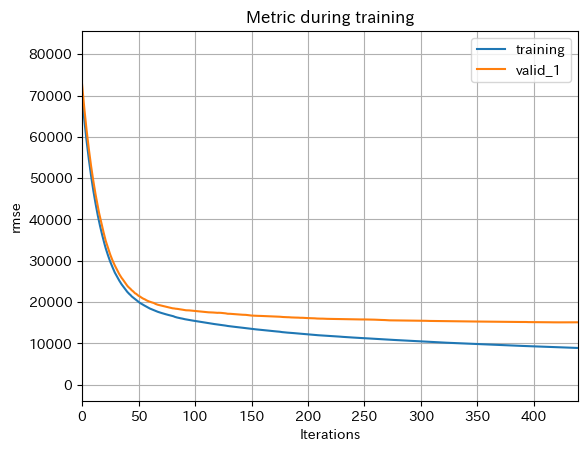

importance
面積               4.626809e+14
L                4.011491e+14
平均地価             2.269651e+14
築年数              7.837415e+13
最寄り駅             7.739366e+13
所在地              4.267655e+13
全体の階数            4.003112e+13
契約期間             1.713559e+13
所在階              1.505847e+13
所要時間             1.048767e+13
定期借家             6.022748e+12
部屋数              2.337387e+12
S                1.626919e+12
建物構造             1.307949e+12
D                5.901986e+11
75m^2以上100m^2未満  3.844362e+11
50m^2以上75m^2未満   3.206637e+11
100m^2以上         2.435033e+11
K                1.957601e+11
バス・トイレ別          0.000000e+00

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.4135935551752292e-06,
        'max_bin': 528,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

### GOSSで「K」を抜くとどうなるか

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48768.7	valid_1's rmse: 50221
[20]	training's rmse: 34357.1	valid_1's rmse: 37847
[30]	training's rmse: 25974.9	valid_1's rmse: 31052.3
[40]	training's rmse: 21284.7	valid_1's rmse: 27347.2
[50]	training's rmse: 18419.9	valid_1's rmse: 25124.3
[60]	training's rmse: 16719.6	valid_1's rmse: 23793.5
[70]	training's rmse: 15648.9	valid_1's rmse: 22949
[80]	training's rmse: 14816.5	valid_1's rmse: 22256.4
[90]	training's rmse: 14186.9	valid_1's rmse: 21738.8
[100]	training's rmse: 13646.4	valid_1's rmse: 21280.7
[110]	training's rmse: 13216.4	valid_1's rmse: 20913.5
[120]	training's rmse: 12768.5	valid_1's rmse: 20577.6
[130]	training's rmse: 12405.8	valid_1's rmse: 20285.2
[140]	training's rmse: 12058.7	valid_1's rmse: 20058.1
[150]	training's rmse: 11721.1	valid_1's rmse: 19795.1
[160]	training's rmse: 11437.3	valid_1's rmse: 19615.2
[170]	training's rmse: 11152	valid_1's rmse: 19403.6
[180]	training's rmse: 10922.8	valid_1's rmse: 19268.5
[190]	training's rmse: 1068

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[30]	training's rmse: 26763.5	valid_1's rmse: 28664.2
[40]	training's rmse: 22268	valid_1's rmse: 24460.1
[50]	training's rmse: 19647.2	valid_1's rmse: 22109.6
[60]	training's rmse: 18095.9	valid_1's rmse: 20839.4
[70]	training's rmse: 17043.3	valid_1's rmse: 19944.6
[80]	training's rmse: 16274.3	valid_1's rmse: 19360.2
[90]	training's rmse: 15557.2	valid_1's rmse: 18836.2
[100]	training's rmse: 15040.9	valid_1's rmse: 18414.3
[110]	training's rmse: 14607.1	valid_1's rmse: 18214.9
[120]	training's rmse: 14140.3	valid_1's rmse: 17983.3
[130]	training's rmse: 13755.1	valid_1's rmse: 17804.9
[140]	training's rmse: 13403.6	valid_1's rmse: 17781
[150]	training's rmse: 13059.3	valid_1's rmse: 17635.6
[160]	training's rmse: 12717.2	valid_1's rmse: 17585.6
[170]	training's rmse: 12420	valid_1's rmse: 17522.8
[180]	training's rmse: 12135.4	valid_1's rmse: 17449.4
[190]	training's rmse: 11893.5	valid_1's rmse: 17355.3
Early stopping, best iteration is:
[185]	training's rmse: 12007.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49054.1	valid_1's rmse: 48657.6
[20]	training's rmse: 35190	valid_1's rmse: 34066.4
[30]	training's rmse: 26986.3	valid_1's rmse: 25944.9
[40]	training's rmse: 22396.2	valid_1's rmse: 22197.6
[50]	training's rmse: 19642.9	valid_1's rmse: 20339
[60]	training's rmse: 17920.4	valid_1's rmse: 19285.9
[70]	training's rmse: 16723.9	valid_1's rmse: 18761.8
[80]	training's rmse: 15809.4	valid_1's rmse: 18447.5
[90]	training's rmse: 15134.8	valid_1's rmse: 18205.4
[100]	training's rmse: 14583.1	valid_1's rmse: 18023.6
[110]	training's rmse: 14080.2	valid_1's rmse: 17923.7
[120]	training's rmse: 13670.9	valid_1's rmse: 17789.6
[130]	training's rmse: 13320.4	valid_1's rmse: 17774.7
[140]	training's rmse: 12979.8	valid_1's rmse: 17670.1
[150]	training's rmse: 12659.7	valid_1's rmse: 17626.7
[160]	training's rmse: 12370	valid_1's rmse: 17593.3
[170]	training's rmse: 12086.8	valid_1's rmse: 17517.2
[180]	training's rmse: 11810.5	valid_1's rmse: 17463.5
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[30]	training's rmse: 26832.9	valid_1's rmse: 28266.2
[40]	training's rmse: 22166.8	valid_1's rmse: 24331
[50]	training's rmse: 19410.9	valid_1's rmse: 22320.1
[60]	training's rmse: 17730.1	valid_1's rmse: 21238.2
[70]	training's rmse: 16547	valid_1's rmse: 20634.3
[80]	training's rmse: 15664.3	valid_1's rmse: 20291.4
[90]	training's rmse: 15048.1	valid_1's rmse: 20047.8
[100]	training's rmse: 14523.5	valid_1's rmse: 19874.9
[110]	training's rmse: 14027.7	valid_1's rmse: 19726
[120]	training's rmse: 13633	valid_1's rmse: 19618.3
[130]	training's rmse: 13267	valid_1's rmse: 19485.6
[140]	training's rmse: 12919.2	valid_1's rmse: 19403
[150]	training's rmse: 12637.4	valid_1's rmse: 19308.8
[160]	training's rmse: 12306.8	valid_1's rmse: 19194.4
[170]	training's rmse: 12026.5	valid_1's rmse: 19146.2
[180]	training's rmse: 11779.1	valid_1's rmse: 19061.7
[190]	training's rmse: 11523.7	valid_1's rmse: 18985.3
[200]	training's rmse: 11321.5	valid_1's rmse: 18927.2
[210]	training's rmse: 11109.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48744.2	valid_1's rmse: 51064.5
[20]	training's rmse: 34958.9	valid_1's rmse: 37050.4
[30]	training's rmse: 27041.5	valid_1's rmse: 28825.4
[40]	training's rmse: 22721.7	valid_1's rmse: 24403.6
[50]	training's rmse: 20019.9	valid_1's rmse: 21797
[60]	training's rmse: 18312.5	valid_1's rmse: 20155.1
[70]	training's rmse: 17204.3	valid_1's rmse: 19281.7
[80]	training's rmse: 16315.2	valid_1's rmse: 18632.8
[90]	training's rmse: 15616.9	valid_1's rmse: 18209.5
[100]	training's rmse: 15091.8	valid_1's rmse: 17813
[110]	training's rmse: 14632.5	valid_1's rmse: 17528.5
[120]	training's rmse: 14242.9	valid_1's rmse: 17363
[130]	training's rmse: 13850.6	valid_1's rmse: 17137.8
[140]	training's rmse: 13492.5	valid_1's rmse: 16881.5
[150]	training's rmse: 13205.6	valid_1's rmse: 16762.4
[160]	training's rmse: 12925.5	valid_1's rmse: 16628.1
[170]	training's rmse: 12686.2	valid_1's rmse: 16499.3
[180]	training's rmse: 12416.8	valid_1's rmse: 16358.7
[190]	training's rmse: 12

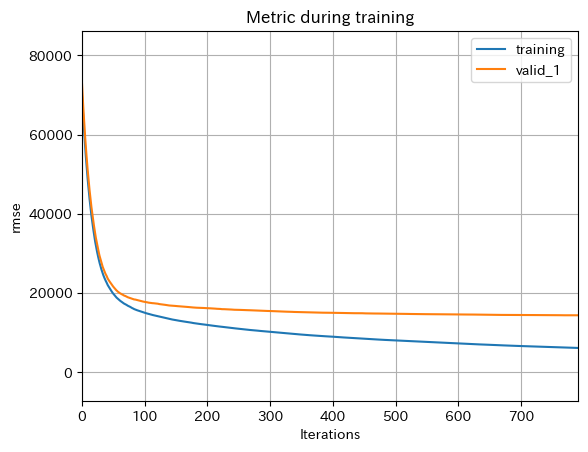

importance
面積               4.573111e+14
L                3.966541e+14
平均地価             2.223556e+14
最寄り駅             8.467167e+13
築年数              7.800557e+13
所在地              4.139292e+13
全体の階数            3.925972e+13
一部屋あたりの面積        3.721179e+13
所在階              1.547378e+13
契約期間             1.450275e+13
所要時間             1.136711e+13
定期借家             5.293384e+12
バス・トイレ別          2.150204e+12
部屋数              1.421301e+12
建物構造             1.289086e+12
S                8.506349e+11
D                6.132940e+11
50m^2以上75m^2未満   3.543923e+11
100m^2以上         3.388661e+11
75m^2以上100m^2未満  2.209425e+11

In [21]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.4135935551752292e-06,
        'max_bin': 528,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

GOSSで「K」を抜いたところ、16588のベストスコアを記録！

In [22]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

この条件のもとでチューニングを行う！！

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_scores.append(mean_squared_error(y_val, y_pred_val, squared=False))
    loss = np.mean(rmse_scores)
    return loss

In [7]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-18 13:41:28,052] A new study created in memory with name: no-name-db123bed-f867-440f-8673-c14dbb0abbb5
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.5	valid_1's rmse: 50159.4
[20]	training's rmse: 34411.5	valid_1's rmse: 37841.5
[30]	training's rmse: 25981.2	valid_1's rmse: 30997.6
[40]	training's rmse: 21287.6	valid_1's rmse: 27398.5
[50]	training's rmse: 18475	valid_1's rmse: 25258.6
[60]	training's rmse: 16768.5	valid_1's rmse: 23916.1
[70]	training's rmse: 15591.8	valid_1's rmse: 22924.2
[80]	training's rmse: 14717.7	valid_1's rmse: 22212.8
[90]	training's rmse: 14077.6	valid_1's rmse: 21762.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.9	valid_1's rmse: 49578.4
[20]	training's rmse: 34957	valid_1's rmse: 36048.6
[30]	training's rmse: 26954.5	valid_1's rmse: 28692.8
[40]	training's rmse: 22589.2	valid_1's rmse: 24887.5
[50]	training's rmse: 19790.5	valid_1's rmse: 22602.7
[60]	training's rmse: 18172.4	valid_1's rmse: 21294.5
[70]	training's rmse: 17061.7	valid_1's rmse: 20475.8
[80]	training's rmse: 16136.5	valid_1's rmse: 19839.6
[90]	training's rmse: 15426.6	valid_1's rmse: 19459.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35378.4	valid_1's rmse: 33771
[30]	training's rmse: 27179.2	valid_1's rmse: 25821.3
[40]	training's rmse: 22798.6	valid_1's rmse: 21871.3
[50]	training's rmse: 20086.7	valid_1's rmse: 19967.1
[60]	training's rmse: 18212.8	valid_1's rmse: 18897.8
[70]	training's rmse: 16910.4	valid_1's rmse: 18315.3
[80]	training's rmse: 15977.5	valid_1's rmse: 17993.6
[90]	training's rmse: 15263.9	valid_1's rmse: 17745.1
[100]	training's rmse: 14678.5	valid_1's rmse: 17611
[110]	training's rmse: 14117.8	valid_1's rmse: 17567
[120]	training's rmse: 13689.9	valid_1's rmse: 17482.7
[130]	training's rmse: 13305.5	valid_1's rmse: 17382.9
[140]	training's rmse: 12966.9	valid_1's rmse: 17351.4
[150]	training's rmse: 12624.2	valid_1's rmse: 17265.5
[160]	training's rmse: 12303.8	valid_1's rmse: 17245.4
[170]	training's rmse: 12011	valid_1's rmse: 17199.6
[180]	training's rmse: 11760.2	valid_1's rmse: 17151.2
[190]	training's rmse: 11528.5	valid_1's rmse: 17085.9
[200]	training's rmse: 112

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.5	valid_1's rmse: 48159.3
[20]	training's rmse: 34925.7	valid_1's rmse: 35109.9
[30]	training's rmse: 26761.1	valid_1's rmse: 28057.6
[40]	training's rmse: 22105.3	valid_1's rmse: 24430.9
[50]	training's rmse: 19405.6	valid_1's rmse: 22524.3
[60]	training's rmse: 17708.8	valid_1's rmse: 21478
[70]	training's rmse: 16534.1	valid_1's rmse: 20815
[80]	training's rmse: 15677.5	valid_1's rmse: 20393.1
[90]	training's rmse: 14992.5	valid_1's rmse: 20266.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48661.5	valid_1's rmse: 50996.5
[20]	training's rmse: 34951.5	valid_1's rmse: 37037.5
[30]	training's rmse: 27071.1	valid_1's rmse: 28693.8
[40]	training's rmse: 22639.6	valid_1's rmse: 23980.4
[50]	training's rmse: 20078.3	valid_1's rmse: 21346.9
[60]	training's rmse: 18378.1	valid_1's rmse: 19735.6
[70]	training's rmse: 17159.9	valid_1's rmse: 18718.2
[80]	training's rmse: 16348.5	valid_1's rmse: 18069
[90]	training's rmse: 15662.6	valid_1's rmse: 17552.9
[100]	training's rmse: 15137.7	valid_1's rmse: 17174.5
[110]	training's rmse: 14690.8	valid_1's rmse: 16916.9
[120]	training's rmse: 14304.5	valid_1's rmse: 16693
[130]	training's rmse: 13921.1	valid_1's rmse: 16522.9
[140]	training's rmse: 13581.6	valid_1's rmse: 16329.9
[150]	training's rmse: 13234	valid_1's rmse: 16125.6
[160]	training's rmse: 12922	valid_1's rmse: 15941.2
[170]	training's rmse: 12640.9	valid_1's rmse: 15792.1
[180]	training's rmse: 12410.5	valid_1's rmse: 15663.9
[190]	training's rmse: 1216

[I 2022-09-18 13:42:01,031] Trial 0 finished with value: 16717.86623401323 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16717.86623401323.


Early stopping, best iteration is:
[553]	training's rmse: 7510.44	valid_1's rmse: 14204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2917
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48692.3	valid_1's rmse: 50031.5
[20]	training's rmse: 34282.8	valid_1's rmse: 37783.8
[30]	training's rmse: 25806.8	valid_1's rmse: 30878.4
[40]	training's rmse: 21201.7	valid_1's rmse: 27287.5
[50]	training's rmse: 18438.2	valid_1's rmse: 25195.6
[60]	training's rmse: 16695.6	valid_1's rmse: 23847.9
[70]	training's rmse: 15523.1	valid_1's rmse: 22955.2
[80]	training's rmse: 14690	valid_1's rmse: 22292.6
[90]	training's rmse: 14053.9	valid_1's rmse: 21860.8
[100]	training's rmse: 13489.1	valid_1's rmse: 21457.4
[110]	training's rmse: 13001.9	valid_1's rmse: 21048.8
[120]	training's rmse: 12571	valid_1's rmse: 20735.7
[130]	training's rmse: 12179.8	valid_1's rmse: 20488.2
[140]	training's rmse: 11801.6	valid_1's rmse: 20205.6
[150]	training's rmse: 11485.9	valid_1's rmse: 20002.6
[160]	training's rmse: 11192.1	valid_1's rmse: 19809
[170]	training's rmse: 10919.4	valid_1's rmse: 19648.7
[180]	training's rmse: 10639.9	valid_1's rmse: 19482.5
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48963.9	valid_1's rmse: 49814.9
[20]	training's rmse: 34920.5	valid_1's rmse: 36455
[30]	training's rmse: 26825.6	valid_1's rmse: 29103
[40]	training's rmse: 22300.2	valid_1's rmse: 24903.9
[50]	training's rmse: 19742.1	valid_1's rmse: 22646.7
[60]	training's rmse: 18093.7	valid_1's rmse: 21280.9
[70]	training's rmse: 16943.3	valid_1's rmse: 20368.3
[80]	training's rmse: 16147.5	valid_1's rmse: 19755.2
[90]	training's rmse: 15409	valid_1's rmse: 19270.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34855.9	valid_1's rmse: 34433.1
[30]	training's rmse: 26847.4	valid_1's rmse: 26385.2
[40]	training's rmse: 22343.3	valid_1's rmse: 22479.3
[50]	training's rmse: 19659.6	valid_1's rmse: 20509.9
[60]	training's rmse: 17926.8	valid_1's rmse: 19528.6
[70]	training's rmse: 16701.6	valid_1's rmse: 18858.3
[80]	training's rmse: 15798.9	valid_1's rmse: 18526
[90]	training's rmse: 15141.3	valid_1's rmse: 18313.7
[100]	training's rmse: 14557.4	valid_1's rmse: 18186.8
[110]	training's rmse: 14028.9	valid_1's rmse: 18142.4
[120]	training's rmse: 13590.3	valid_1's rmse: 18078.7
[130]	training's rmse: 13206.2	valid_1's rmse: 17947.7
[140]	training's rmse: 12854.3	valid_1's rmse: 17856.4
[150]	training's rmse: 12556.8	valid_1's rmse: 17808.2
[160]	training's rmse: 12249.9	valid_1's rmse: 17736.2
[170]	training's rmse: 11988.3	valid_1's rmse: 17741.8
[180]	training's rmse: 11721.7	valid_1's rmse: 17691.6
[190]	training's rmse: 11459.9	valid_1's rmse: 17668.9
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34751.5	valid_1's rmse: 35326.7
[30]	training's rmse: 26360.4	valid_1's rmse: 28076.2
[40]	training's rmse: 21676.3	valid_1's rmse: 24489.2
[50]	training's rmse: 19053.5	valid_1's rmse: 22718.6
[60]	training's rmse: 17389.4	valid_1's rmse: 21626.8
[70]	training's rmse: 16305.6	valid_1's rmse: 20977.4
[80]	training's rmse: 15505.7	valid_1's rmse: 20619.9
[90]	training's rmse: 14850.5	valid_1's rmse: 20281
[100]	training's rmse: 14314.8	valid_1's rmse: 20106.4
[110]	training's rmse: 13920.4	valid_1's rmse: 19936.4
[120]	training's rmse: 13454.3	valid_1's rmse: 19851
[130]	training's rmse: 13132.4	valid_1's rmse: 19728.5
[140]	training's rmse: 12789.3	valid_1's rmse: 19606.6
[150]	training's rmse: 12485	valid_1's rmse: 19505.3
[160]	training's rmse: 12231.5	valid_1's rmse: 19439.3
[170]	training's rmse: 11939.8	valid_1's rmse: 19393.3
[180]	training's rmse: 11685.2	valid_1's rmse: 19328.8
[190]	training's rmse: 11448.2	valid_1's rmse: 19278.8
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48638.5	valid_1's rmse: 50983.6
[20]	training's rmse: 34936.7	valid_1's rmse: 36926.8
[30]	training's rmse: 26965.7	valid_1's rmse: 28534.6
[40]	training's rmse: 22537.5	valid_1's rmse: 23780.4
[50]	training's rmse: 19983.7	valid_1's rmse: 21292
[60]	training's rmse: 18384.8	valid_1's rmse: 19955.6
[70]	training's rmse: 17265.4	valid_1's rmse: 19011.6
[80]	training's rmse: 16387.7	valid_1's rmse: 18354.9
[90]	training's rmse: 15662.2	valid_1's rmse: 17885.4
[100]	traini

[I 2022-09-18 13:42:19,942] Trial 1 finished with value: 16850.22269593248 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16717.86623401323.


[370]	training's rmse: 9021.6	valid_1's rmse: 14957.3
Early stopping, best iteration is:
[364]	training's rmse: 9089.63	valid_1's rmse: 14944.6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48379.6	valid_1's rmse: 49956.6
[20]	training's rmse: 33876.1	valid_1's rmse: 37590.2
[30]	training's rmse: 25411.4	valid_1's rmse: 30716.5
[40]	training's rmse: 20711.6	valid_1's rmse: 27103.3
[50]	training's rmse: 17923.1	valid_1's rmse: 24879.7
[60]	training's rmse: 16167.6	valid_1's rmse: 23426.6
[70]	training's rmse: 15036.8	valid_1's rmse: 22492.2
[80]	training's rmse: 14250.1	valid_1's rmse: 21909.8
[90]	training's rmse: 13570.6	valid_1's rmse: 21400.1
[100]	training's rmse: 13010.3	valid_1's rmse: 20955.8
[110]	training's rmse: 12536.9	valid_1's rmse: 20576.7
[120]	training's rmse: 12101.7	valid_1's rmse: 20275.5
[130]	training's rmse: 11710.9	valid_1's rmse: 20023.7
[140]	training's rmse: 11355.6	valid_1's rmse: 19790.8
[150]	training's rmse: 11041.5	valid_1's rmse: 19623.6
[160]	training's rmse: 10740.7	valid_1's rmse: 19445.5
[170]	training's rmse: 10427.5	valid_1's rmse: 19248.8
[180]	training's rmse: 10183.1	valid_1's rmse: 19099.1
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48753.6	valid_1's rmse: 49623.7
[20]	training's rmse: 34607.4	valid_1's rmse: 36117.1
[30]	training's rmse: 26491.5	valid_1's rmse: 28525.6
[40]	training's rmse: 22079.7	valid_1's rmse: 24411.8
[50]	training's rmse: 19354.6	valid_1's rmse: 22009.8
[60]	training's rmse: 17707.4	valid_1's rmse: 20677
[70]	training's rmse: 16595.1	valid_1's rmse: 19767
[80]	training's rmse: 15791.7	valid_1's rmse: 19186.7
[90]	training's rmse: 15153.7	valid_1's rmse: 18835.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34782	valid_1's rmse: 33644.9
[30]	training's rmse: 26574.5	valid_1's rmse: 25658.8
[40]	training's rmse: 21985.5	valid_1's rmse: 21920.4
[50]	training's rmse: 19200.7	valid_1's rmse: 20157
[60]	training's rmse: 17457.6	valid_1's rmse: 19288.4
[70]	training's rmse: 16324.2	valid_1's rmse: 18849.7
[80]	training's rmse: 15348.7	valid_1's rmse: 18635.8
[90]	training's rmse: 14621.5	valid_1's rmse: 18429
[100]	training's rmse: 13998.1	valid_1's rmse: 18290.3
[110]	training's rmse: 13482.6	valid_1's rmse: 18191
[120]	training's rmse: 13048.9	valid_1's rmse: 18045.6
[130]	training's rmse: 12599.2	valid_1's rmse: 17964.1
[140]	training's rmse: 12256.7	valid_1's rmse: 17885.3
[150]	training's rmse: 11924.8	valid_1's rmse: 17816.2
[160]	training's rmse: 11625.3	valid_1's rmse: 17797.9
[170]	training's rmse: 11357.9	valid_1's rmse: 17719.4
[180]	training's rmse: 11111.4	valid_1's rmse: 17668.3
[190]	training's rmse: 10874.9	valid_1's rmse: 17657.7
[200]	training's rmse: 106

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48816.5	valid_1's rmse: 47934.1
[20]	training's rmse: 34359	valid_1's rmse: 35561.4
[30]	training's rmse: 25959.1	valid_1's rmse: 28645.7
[40]	training's rmse: 21380.6	valid_1's rmse: 25129.8
[50]	training's rmse: 18685.1	valid_1's rmse: 23225
[60]	training's rmse: 17045.5	valid_1's rmse: 22254.3
[70]	training's rmse: 15864.6	valid_1's rmse: 21679.4
[80]	training's rmse: 15012.9	valid_1's rmse: 21282.3
[90]	training's rmse: 14356.1	valid_1's rmse: 21006.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48292.8	valid_1's rmse: 50749.7
[20]	training's rmse: 34437.9	valid_1's rmse: 36845.9
[30]	training's rmse: 26530.1	valid_1's rmse: 28670
[40]	training's rmse: 22079.8	valid_1's rmse: 24102.3
[50]	training's rmse: 19544	valid_1's rmse: 21667.6
[60]	training's rmse: 17745.1	valid_1's rmse: 19896.9
[70]	training's rmse: 16507.3	valid_1's rmse: 18718.1
[80]	training's rmse: 15711.7	valid_1's rmse: 18128.2
[90]	training's rmse: 15026	valid_1's rmse: 17578.3
[100]	training's rmse: 14432.9	valid_1's rmse: 17151
[110]	training's rmse: 13953.1	valid_1's rmse: 16829.6
[120]	training's rmse: 13530.7	valid_1's rmse: 16529.7
[130]	training's rmse: 13160.1	valid_1's rmse: 16320.2
[140]	training's rmse: 12834.6	valid_1's rmse: 16157.1
[150]	training's rmse: 12558.2	valid_1's rmse: 16013.4
[160]	training's rmse: 12268.8	valid_1's rmse: 15856.6
[170]	training's rmse: 11961	valid_1's rmse: 15723.9
[180]	training's rmse: 

[I 2022-09-18 13:42:44,367] Trial 2 finished with value: 16805.599267959824 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.7	valid_1's rmse: 50221
[20]	training's rmse: 34357.1	valid_1's rmse: 37847
[30]	training's rmse: 25974.9	valid_1's rmse: 31052.3
[40]	training's rmse: 21284.7	valid_1's rmse: 27347.2
[50]	training's rmse: 18419.9	valid_1's rmse: 25124.3
[60]	training's rmse: 16719.6	valid_1's rmse: 23793.5
[70]	training's rmse: 15648.9	valid_1's rmse: 22949
[80]	training's rmse: 14816.5	valid_1's rmse: 22256.4
[90]	training's rmse: 14186.9	valid_1's rmse: 21738.8
[100]	training's rmse: 13646.4	valid_1's rmse: 21280.7
[110]	training's rmse: 13

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908.7	valid_1's rmse: 49540.9
[20]	training's rmse: 34828.8	valid_1's rmse: 36356
[30]	training's rmse: 26763.5	valid_1's rmse: 28664.2
[40]	training's rmse: 22268	valid_1's rmse: 24460.1
[50]	training's rmse: 19647.2	valid_1's rmse: 22109.6
[60]	training's rmse: 18095.9	valid_1's rmse: 20839.4
[70]	training's rmse: 17043.3	valid_1's rmse: 19944.6
[80]	training's rmse: 16274.3	valid_1's rmse: 19360.2
[90]	training's rmse: 15557.2	valid_1's rmse: 18836.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49054.1	valid_1's rmse: 48657.6
[20]	training's rmse: 35190	valid_1's rmse: 34066.4
[30]	training's rmse: 26986.3	valid_1's rmse: 25944.9
[40]	training's rmse: 22396.2	valid_1's rmse: 22197.6
[50]	training's rmse: 19642.9	valid_1's rmse: 20339
[60]	training's rmse: 17920.4	valid_1's rmse: 19285.9
[70]	training's rmse: 16723.9	valid_1's rmse: 18761.8
[80]	training's rmse: 15809.4	valid_1's rmse: 18447.5
[90]	training's rmse: 15134.8	valid_1's rmse: 18205.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49223.7	valid_1's rmse: 48205.2
[20]	training's rmse: 35058.2	valid_1's rmse: 35316
[30]	training's rmse: 26832.9	valid_1's rmse: 28266.2
[40]	training's rmse: 22166.8	valid_1's rmse: 24331
[50]	training's rmse: 19410.9	valid_1's rmse: 22320.1
[60]	training's rmse: 17730.1	valid_1's rmse: 21238.2
[70]	training's rmse: 16547	valid_1's rmse: 20634.3
[80]	training's rmse: 15664.3	valid_1's rmse: 20291.4
[90]	training's rmse: 15048.1	valid_1's rmse: 20047.8
[100]	training's rmse: 14523.5	valid_1's rmse: 19874.9
[110]	training's rmse: 14027.7	valid_1's rmse: 19726
[120]	training's rmse: 13633	valid_1's rmse: 19618.3
[130]	training's rmse: 13267	valid_1's rmse: 19485.6
[140]	training's rmse: 12919.2	valid_1's rmse: 19403
[150]	training's rmse: 12637.4	valid_1's rmse: 19308.8
[160]	training's rmse: 12306.8	valid_1's rmse: 19194.4
[170]	training's rmse: 12026.5	valid_1's rmse: 19146.2
[180]	training's rmse: 11779.1	valid_1's rmse: 19061.7
[190]	training's rmse: 11523.7	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.2	valid_1's rmse: 51064.5
[20]	training's rmse: 34958.9	valid_1's rmse: 37050.4
[30]	training's rmse: 27041.5	valid_1's rmse: 28825.4
[40]	training's rmse: 22721.7	valid_1's rmse: 24403.6
[50]	training's rmse: 20019.9	valid_1's rmse: 21797
[60]	training's rmse: 18312.5	valid_1's rmse: 20155.1
[70]	training's rmse: 17204.3	valid_1's rmse: 19281.7
[80]	training's rmse: 16315.2	valid_1's rmse: 18632.8
[90]	training's rmse: 15616.9	valid_1's rmse: 18209.5
[100]	traini

[I 2022-09-18 13:42:59,892] Trial 3 finished with value: 16751.429155695998 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49272	valid_1's rmse: 50745.1
[20]	training's rmse: 35157.6	valid_1's rmse: 38636.8
[30]	training's rmse: 26905.6	valid_1's rmse: 31728.4
[40]	training's rmse: 22086.2	valid_1's rmse: 27836.4
[50]	training's rmse: 19377.4	valid_1's rmse: 25603.4
[60]	training's rmse: 17679.2	valid_1's rmse: 24200
[70]	training's rmse: 16519.3	valid_1's rmse: 23170.1
[80]	training's rmse: 15713.3	valid_1's rmse: 22489.1
[90]	training's rmse: 15097	valid_1's rmse: 22013.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49498.2	valid_1's rmse: 49955.3
[20]	training's rmse: 35559.9	valid_1's rmse: 36804.9
[30]	training's rmse: 27559.9	valid_1's rmse: 29082
[40]	training's rmse: 23171	valid_1's rmse: 24967.9
[50]	training's rmse: 20530.1	valid_1's rmse: 22574.1
[60]	training's rmse: 18874.1	valid_1's rmse: 21118.6
[70]	training's rmse: 17816.5	valid_1's rmse: 20227.9
[80]	training's rmse: 16934.9	valid_1's rmse: 19543.2
[90]	training's rmse: 16345.3	valid_1's rmse: 19198.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49493.5	valid_1's rmse: 49032.9
[20]	training's rmse: 35692.7	valid_1's rmse: 34728.1
[30]	training's rmse: 27688.2	valid_1's rmse: 26762.3
[40]	training's rmse: 23072.9	valid_1's rmse: 22905.2
[50]	training's rmse: 20353.7	valid_1's rmse: 20938.1
[60]	training's rmse: 18573.8	valid_1's rmse: 19866.9
[70]	training's rmse: 17364.3	valid_1's rmse: 19294.6
[80]	training's rmse: 16549.7	valid_1's rmse: 18936.3
[90]	training's rmse: 15819.2	valid_1's rmse: 18691
[100]	training's rmse: 15321.1	valid_1's rmse: 18510
[110]	training's rmse: 14913.4	valid_1's rmse: 18403.4
[120]	training's rmse: 14523.4	valid_1's rmse: 18304.4
[130]	training's rmse: 14187.8	valid_1's rmse: 18213.6
[140]	training's rmse: 13871	valid_1's rmse: 18123.5
[150]	training's rmse: 13531	valid_1's rmse: 18092.1
[160]	training's rmse: 13208	valid_1's rmse: 18061.1
[170]	training's rmse: 12949.3	valid_1's rmse: 17962.5
[180]	training's rmse: 12698.2	valid_1's rmse: 17943.4
[190]	training's rmse: 12476.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35334.7	valid_1's rmse: 36234.5
[30]	training's rmse: 27134.3	valid_1's rmse: 29367.4
[40]	training's rmse: 22473.3	valid_1's rmse: 25668.1
[50]	training's rmse: 19750.1	valid_1's rmse: 23687.8
[60]	training's rmse: 18073.3	valid_1's rmse: 22513.5
[70]	training's rmse: 16963.4	valid_1's rmse: 21816.1
[80]	training's rmse: 16123.7	valid_1's rmse: 21332.7
[90]	training's rmse: 15488.9	valid_1's rmse: 20992.7
[100]	training's rmse: 14970.7	valid_1's rmse: 20798.7
[110]	training's rmse: 14524.9	valid_1's rmse: 20597.5
[120]	training's rmse: 14172.9	valid_1's rmse: 20435.9
[130]	training's rmse: 13843.3	valid_1's rmse: 20335.1
[140]	training's rmse: 13562.5	valid_1's rmse: 20227.6
[150]	training's rmse: 13297	valid_1's rmse: 20120.7
[160]	training's rmse: 13039.6	valid_1's rmse: 20022
[170]	training's rmse: 12795.2	valid_1's rmse: 19934.1
[180]	training's rmse: 12536.3	valid_1's rmse: 19888.2
[190]	training's rmse: 12335.6	valid_1's rmse: 19812.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3610
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.5	valid_1's rmse: 51570.6
[20]	training's rmse: 35641.7	valid_1's rmse: 37590.4
[30]	training's rmse: 27865.7	valid_1's rmse: 29239.4
[40]	training's rmse: 23444.3	valid_1's rmse: 24444.8
[50]	training's rmse: 20777.7	valid_1's rmse: 21607.7
[60]	training's rmse: 19145.8	valid_1's rmse: 19956.8
[70]	training's rmse: 17908.1	valid_1's rmse: 18904.9
[80]	training's rmse: 17061.8	valid_1's rmse: 18237.6
[90]	training's rmse: 16399.7	valid_1's rmse: 17796.9
[100]	trai

[I 2022-09-18 13:43:12,439] Trial 4 finished with value: 16799.214739159244 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50280
[20]	training's rmse: 34437.5	valid_1's rmse: 38136.4
[30]	training's rmse: 26065.2	valid_1's rmse: 31340.7
[40]	training's rmse: 21540	valid_1's rmse: 27861.5
[50]	training's rmse: 18659.5	valid_1's rmse: 25574.3
[60]	training's rmse: 16953.8	valid_1's rmse: 24153.8
[70]	training's rmse: 15769.1	valid_1's rmse: 23127.8
[80]	training's rmse: 14922.7	valid_1's rmse: 22417.9
[90]	training's rmse: 14249.3	valid_1's rmse: 21840.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 49335
[20]	training's rmse: 34715.5	valid_1's rmse: 35889.8
[30]	training's rmse: 26790.6	valid_1's rmse: 28492.7
[40]	training's rmse: 22343.1	valid_1's rmse: 24262.7
[50]	training's rmse: 19723	valid_1's rmse: 21945.8
[60]	training's rmse: 17960.8	valid_1's rmse: 20645.9
[70]	training's rmse: 16885.2	valid_1's rmse: 19793.3
[80]	training's rmse: 16047	valid_1's rmse: 19269.7
[90]	training's rmse: 15401.6	valid_1's rmse: 18898.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34950.3	valid_1's rmse: 34647.6
[30]	training's rmse: 26823.6	valid_1's rmse: 26641.1
[40]	training's rmse: 22401.8	valid_1's rmse: 22743
[50]	training's rmse: 19802.3	valid_1's rmse: 20881.6
[60]	training's rmse: 18040.5	valid_1's rmse: 19898.4
[70]	training's rmse: 16815.1	valid_1's rmse: 19393.2
[80]	training's rmse: 15910	valid_1's rmse: 19062.4
[90]	training's rmse: 15193.9	valid_1's rmse: 18913.9
[100]	training's rmse: 14603.2	valid_1's rmse: 18715.1
[110]	training's rmse: 14090.3	valid_1's rmse: 18555.5
[120]	training's rmse: 13647.8	valid_1's rmse: 18429.8
[130]	training's rmse: 13230.8	valid_1's rmse: 18363.5
[140]	training's rmse: 12864.5	valid_1's rmse: 18281
[150]	training's rmse: 12534.2	valid_1's rmse: 18228.4
[160]	training's rmse: 12190.8	valid_1's rmse: 18118.9
[170]	training's rmse: 11890.4	valid_1's rmse: 18061.1
[180]	training's rmse: 11619.3	valid_1's rmse: 18016.8
[190]	training's rmse: 11359.7	valid_1's rmse: 17976.4
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093.6	valid_1's rmse: 47836.4
[20]	training's rmse: 34841.6	valid_1's rmse: 35104.3
[30]	training's rmse: 26652.5	valid_1's rmse: 27766.9
[40]	training's rmse: 22076.6	valid_1's rmse: 24114.9
[50]	training's rmse: 19306.9	valid_1's rmse: 22249.8
[60]	training's rmse: 17613.7	valid_1's rmse: 21108.9
[70]	training's rmse: 16416.8	valid_1's rmse: 20582
[80]	training's rmse: 15553.6	valid_1's rmse: 20188.4
[90]	training's rmse: 14870.6	valid_1's rmse: 19897.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48458.8	valid_1's rmse: 50917.4
[20]	training's rmse: 34765.5	valid_1's rmse: 36774.9
[30]	training's rmse: 26742.3	valid_1's rmse: 28199.6
[40]	training's rmse: 22396.5	valid_1's rmse: 23830.7
[50]	training's rmse: 19798	valid_1's rmse: 21311.4
[60]	training's rmse: 18176.7	valid_1's rmse: 19886
[70]	training's rmse: 16992.4	valid_1's rmse: 18994.8
[80]	training's rmse: 16169.1	valid_1's rmse: 18401.7
[90]	training's rmse: 15515.3	valid_1's rmse: 17990.7
[100]	training

[I 2022-09-18 13:43:32,814] Trial 5 finished with value: 16808.975730816466 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16717.86623401323.


[350]	training's rmse: 9144.21	valid_1's rmse: 15339.8
Early stopping, best iteration is:
[349]	training's rmse: 9153.95	valid_1's rmse: 15333.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.1	valid_1's rmse: 50002.7
[20]	training's rmse: 33866.2	valid_1's rmse: 37613
[30]	training's rmse: 25364.9	valid_1's rmse: 30637.8
[40]	training's rmse: 20794.7	valid_1's rmse: 27051.1
[50]	training's rmse: 17992.1	valid_1's rmse: 24858.5
[60]	training's rmse: 16261.2	valid_1's rmse: 23414.6
[70]	training's rmse: 15134.3	valid_1's rmse: 22507.2
[80]	training's rmse: 14243.6	valid_1's rmse: 21802
[90]	training's rmse: 13546.2	valid_1's rmse: 21203.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3541
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48755.3	valid_1's rmse: 49615.3
[20]	training's rmse: 34622	valid_1's rmse: 36195.5
[30]	training's rmse: 26515.4	valid_1's rmse: 28632.5
[40]	training's rmse: 22190.6	valid_1's rmse: 24549.8
[50]	training's rmse: 19560.5	valid_1's rmse: 22313.4
[60]	training's rmse: 17772.9	valid_1's rmse: 20917.7
[70]	training's rmse: 16671.4	valid_1's rmse: 20074.4
[80]	training's rmse: 15852.2	valid_1's rmse: 19449.6
[90]	training's rmse: 15190.8	valid_1's rmse: 19124.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3539
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48751.1	valid_1's rmse: 48289.1
[20]	training's rmse: 34740.4	valid_1's rmse: 33699.9
[30]	training's rmse: 26373.7	valid_1's rmse: 25650.9
[40]	training's rmse: 21882.1	valid_1's rmse: 21905
[50]	training's rmse: 19063.8	valid_1's rmse: 20130.1
[60]	training's rmse: 17314	valid_1's rmse: 19312.2
[70]	training's rmse: 16181.4	valid_1's rmse: 18856.3
[80]	training's rmse: 15281.8	valid_1's rmse: 18651
[90]	training's rmse: 14580.1	valid_1's rmse: 18459.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3540
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.4	valid_1's rmse: 47887.4
[20]	training's rmse: 34303.1	valid_1's rmse: 35346
[30]	training's rmse: 26102.7	valid_1's rmse: 28445.3
[40]	training's rmse: 21489.6	valid_1's rmse: 24878.6
[50]	training's rmse: 18745.1	valid_1's rmse: 22906.4
[60]	training's rmse: 16985.6	valid_1's rmse: 21803.7
[70]	training's rmse: 15758.8	valid_1's rmse: 21162
[80]	training's rmse: 14882	valid_1's rmse: 20913.3
[90]	training's rmse: 14265.1	valid_1's rmse: 20760.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3541
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48284.4	valid_1's rmse: 50781.1
[20]	training's rmse: 34403.5	valid_1's rmse: 36718
[30]	training's rmse: 26424.3	valid_1's rmse: 28380.4
[40]	training's rmse: 22202.1	valid_1's rmse: 24205
[50]	training's rmse: 19513.7	valid_1's rmse: 21341.5
[60]	training's rmse: 17848.8	valid_1's rmse: 19752.5
[70]	training's rmse: 16666.2	valid_1's rmse: 18737.5
[80]	training's rmse: 15746.4	valid_1's rmse: 18010.2
[90]	training's rmse: 15058.6	valid_1's rmse: 17516.4
[100]	training

[I 2022-09-18 13:43:58,932] Trial 6 finished with value: 16782.710714441604 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48729.1	valid_1's rmse: 50361.2
[20]	training's rmse: 34301.9	valid_1's rmse: 38003.4
[30]	training's rmse: 25952.9	valid_1's rmse: 31234.5
[40]	training's rmse: 21248.2	valid_1's rmse: 27517.3
[50]	training's rmse: 18445.4	valid_1's rmse: 25298.1
[60]	training's rmse: 16723.1	valid_1's rmse: 23957.8
[70]	training's rmse: 15508.2	valid_1's rmse: 22988
[80]	training's rmse: 14642.2	valid_1's rmse: 22283.8
[90]	training's rmse: 13983.7	valid_1's rmse: 21784.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.6	valid_1's rmse: 49720.3
[20]	training's rmse: 34742.5	valid_1's rmse: 36285.8
[30]	training's rmse: 26659.4	valid_1's rmse: 28884.2
[40]	training's rmse: 22261.1	valid_1's rmse: 24826.7
[50]	training's rmse: 19602.9	valid_1's rmse: 22390.3
[60]	training's rmse: 17955.4	valid_1's rmse: 21022.1
[70]	training's rmse: 16748.3	valid_1's rmse: 20188
[80]	training's rmse: 15892.5	valid_1's rmse: 19552.8
[90]	training's rmse: 15171	valid_1's rmse: 19106.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48760.6	valid_1's rmse: 48562.7
[20]	training's rmse: 34750.2	valid_1's rmse: 34235.2
[30]	training's rmse: 26650.1	valid_1's rmse: 26308.1
[40]	training's rmse: 22157.6	valid_1's rmse: 22455
[50]	training's rmse: 19384.3	valid_1's rmse: 20462.5
[60]	training's rmse: 17668.7	valid_1's rmse: 19485.1
[70]	training's rmse: 16557.1	valid_1's rmse: 18917.3
[80]	training's rmse: 15675	valid_1's rmse: 18567.2
[90]	training's rmse: 15000.9	valid_1's rmse: 18385.2
[100]	training's rmse: 14427.3	valid_1's rmse: 18211.7
[110]	training's rmse: 13903.2	valid_1's rmse: 18094.1
[120]	training's rmse: 13423.6	valid_1's rmse: 18016.9
[130]	training's rmse: 13000.8	valid_1's rmse: 17922.4
[140]	training's rmse: 12634.2	valid_1's rmse: 17877.7
[150]	training's rmse: 12319.5	valid_1's rmse: 17803.5
[160]	training's rmse: 12027.2	valid_1's rmse: 17732
[170]	training's rmse: 11748.7	valid_1's rmse: 17684.2
[180]	training's rmse: 11482.9	valid_1's rmse: 17660.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2981
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.5	valid_1's rmse: 47905.1
[20]	training's rmse: 34725.6	valid_1's rmse: 35304.6
[30]	training's rmse: 26475.5	valid_1's rmse: 28379.8
[40]	training's rmse: 21867.2	valid_1's rmse: 24652.8
[50]	training's rmse: 19203.5	valid_1's rmse: 22786.2
[60]	training's rmse: 17488.1	valid_1's rmse: 21769
[70]	training's rmse: 16297.7	valid_1's rmse: 21064.3
[80]	training's rmse: 15458	valid_1's rmse: 20790.8
[90]	training's rmse: 14764	valid_1's rmse: 20446.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48580.7	valid_1's rmse: 50871.3
[20]	training's rmse: 34912.6	valid_1's rmse: 36827.8
[30]	training's rmse: 27061.5	valid_1's rmse: 28705.6
[40]	training's rmse: 22593.2	valid_1's rmse: 24152
[50]	training's rmse: 19946.4	valid_1's rmse: 21425.6
[60]	training's rmse: 18143.7	valid_1's rmse: 19778.6
[70]	training's rmse: 16968.8	valid_1's rmse: 18817.9
[80]	training's rmse: 16015	valid_1's rmse: 18166.2
[90]	training's rmse: 15285	valid_1's rmse: 17609.4
[100]	training's

[I 2022-09-18 13:44:20,788] Trial 7 finished with value: 16763.226651006506 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 16717.86623401323.


[510]	training's rmse: 7514.61	valid_1's rmse: 14726.5
Early stopping, best iteration is:
[503]	training's rmse: 7575.43	valid_1's rmse: 14722.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49178.4	valid_1's rmse: 50469.6
[20]	training's rmse: 35111.3	valid_1's rmse: 38295.3
[30]	training's rmse: 26875.6	valid_1's rmse: 31484.5
[40]	training's rmse: 22409.3	valid_1's rmse: 28036.8
[50]	training's rmse: 19462.6	valid_1's rmse: 25678.8
[60]	training's rmse: 17690.2	valid_1's rmse: 24261
[70]	training's rmse: 16528.9	valid_1's rmse: 23355.8
[80]	training's rmse: 15667.9	valid_1's rmse: 22651.6
[90]	training's rmse: 15007.3	valid_1's rmse: 22098.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49336.2	valid_1's rmse: 50013
[20]	training's rmse: 35497.5	valid_1's rmse: 36638.5
[30]	training's rmse: 27500.5	valid_1's rmse: 29165.9
[40]	training's rmse: 23268.5	valid_1's rmse: 25334
[50]	training's rmse: 20522.4	valid_1's rmse: 23007.2
[60]	training's rmse: 18785.8	valid_1's rmse: 21543.4
[70]	training's rmse: 17693.9	valid_1's rmse: 20679.7
[80]	training's rmse: 16865.7	valid_1's rmse: 20138.6
[90]	training's rmse: 16211.5	valid_1's rmse: 19790
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49493.3	valid_1's rmse: 49072.9
[20]	training's rmse: 35792.1	valid_1's rmse: 34623.7
[30]	training's rmse: 27799.5	valid_1's rmse: 26508.8
[40]	training's rmse: 23229	valid_1's rmse: 22539.8
[50]	training's rmse: 20462.3	valid_1's rmse: 20632.5
[60]	training's rmse: 18721.5	valid_1's rmse: 19641.5
[70]	training's rmse: 17541.8	valid_1's rmse: 19110.4
[80]	training's rmse: 16666.1	valid_1's rmse: 18796.4
[90]	training's rmse: 16014	valid_1's rmse: 18583.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49624.9	valid_1's rmse: 48616.1
[20]	training's rmse: 35580.3	valid_1's rmse: 36001.6
[30]	training's rmse: 27473.8	valid_1's rmse: 28870.1
[40]	training's rmse: 22849	valid_1's rmse: 25054.2
[50]	training's rmse: 20162.5	valid_1's rmse: 23049.5
[60]	training's rmse: 18549.2	valid_1's rmse: 22039.7
[70]	training's rmse: 17417.4	valid_1's rmse: 21362.6
[80]	training's rmse: 16557.1	valid_1's rmse: 20994.7
[90]	training's rmse: 15861.9	valid_1's rmse: 20699.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.1	valid_1's rmse: 51546.9
[20]	training's rmse: 35676.6	valid_1's rmse: 37521.3
[30]	training's rmse: 27801.4	valid_1's rmse: 29099.7
[40]	training's rmse: 23443	valid_1's rmse: 24615.2
[50]	training's rmse: 20866.9	valid_1's rmse: 21889.9
[60]	training's rmse: 19170.4	valid_1's rmse: 20319.6
[70]	training's rmse: 18066.2	valid_1's rmse: 19315
[80]	training's rmse: 17227.6	valid_1's rmse: 18618.9
[90]	training's rmse: 16567	valid_1's rmse: 18089.9
[100]	training's

[I 2022-09-18 13:44:35,573] Trial 8 finished with value: 16802.58569925723 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/sig

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.7	valid_1's rmse: 50484.1
[20]	training's rmse: 34613.4	valid_1's rmse: 38275.2
[30]	training's rmse: 26371.7	valid_1's rmse: 31461.8
[40]	training's rmse: 21680.5	valid_1's rmse: 27831.7
[50]	training's rmse: 18953.2	valid_1's rmse: 25655
[60]	training's rmse: 17221.2	valid_1's rmse: 24258.5
[70]	training's rmse: 16066.9	valid_1's rmse: 23228.9
[80]	training's rmse: 15250.6	valid_1's rmse: 22544.6
[90]	training's rmse: 14556	valid_1's rmse: 21986
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49072.3	valid_1's rmse: 49638.2
[20]	training's rmse: 35022.4	valid_1's rmse: 36316.8
[30]	training's rmse: 27093.3	valid_1's rmse: 28834.7
[40]	training's rmse: 22835.1	valid_1's rmse: 24904
[50]	training's rmse: 20166.9	valid_1's rmse: 22618.9
[60]	training's rmse: 18387.6	valid_1's rmse: 21145.2
[70]	training's rmse: 17180.4	valid_1's rmse: 20245.5
[80]	training's rmse: 16381.3	valid_1's rmse: 19722.6
[90]	training's rmse: 15725.5	valid_1's rmse: 19320.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.7	valid_1's rmse: 48857.1
[20]	training's rmse: 35491.5	valid_1's rmse: 34382.3
[30]	training's rmse: 27608.8	valid_1's rmse: 26463.2
[40]	training's rmse: 23027.7	valid_1's rmse: 22440.4
[50]	training's rmse: 20242.7	valid_1's rmse: 20499.7
[60]	training's rmse: 18450.6	valid_1's rmse: 19493.3
[70]	training's rmse: 17159.4	valid_1's rmse: 18781.4
[80]	training's rmse: 16278.8	valid_1's rmse: 18542.2
[90]	training's rmse: 15561.9	valid_1's rmse: 18326.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49427.6	valid_1's rmse: 48077.3
[20]	training's rmse: 35080.6	valid_1's rmse: 35389.4
[30]	training's rmse: 26767.4	valid_1's rmse: 28176.2
[40]	training's rmse: 22222.1	valid_1's rmse: 24398
[50]	training's rmse: 19595.6	valid_1's rmse: 22487.2
[60]	training's rmse: 17925	valid_1's rmse: 21375.3
[70]	training's rmse: 16786.5	valid_1's rmse: 20840.7
[80]	training's rmse: 15907.6	valid_1's rmse: 20439
[90]	training's rmse: 15230.3	valid_1's rmse: 20254.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35154.4	valid_1's rmse: 36834.7
[30]	training's rmse: 27270.9	valid_1's rmse: 28723.7
[40]	training's rmse: 22985	valid_1's rmse: 24284.9
[50]	training's rmse: 20233.4	valid_1's rmse: 21570.3
[60]	training's rmse: 18551.4	valid_1's rmse: 20002.7
[70]	training's rmse: 17309.8	valid_1's rmse: 18995.2
[80]	training's rmse: 16428.4	valid_1's rmse: 18339.3
[90]	training's rmse: 15798.9	valid_1's rmse: 17906.8
[100]	training's rmse: 15238.8	valid_1's rmse: 17656.3
[110]	training's rmse: 14764.2	valid_1's rmse: 17395.8
[120]	training's rmse: 14339.1	valid_1's rmse: 17127.1
[130]	training's rmse: 13974.1	valid_1's rmse: 16891.1
[140]	training's rmse: 13652.5	valid_1's rmse: 16756.8
[150]	training's rmse: 13312.1	valid_1's rmse: 16570.8
[160]	training's rmse: 13007.4	valid_1's rmse: 16448
[170]	training's rmse: 12744.8	valid_1's rmse: 16330.6
[180]	training's rmse: 12520.2	valid_1's rmse: 16297.7
[190]	training's rmse: 12320	valid_1's rmse: 16227.2
[200]	training's rmse: 1

[I 2022-09-18 13:44:49,087] Trial 9 finished with value: 16841.964863345755 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 16717.86623401323.


Early stopping, best iteration is:
[422]	training's rmse: 8859.41	valid_1's rmse: 15190.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3415
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48821.2	valid_1's rmse: 50268.9
[20]	training's rmse: 34455.1	valid_1's rmse: 37957.4
[30]	training's rmse: 26112.5	valid_1's rmse: 31112.5
[40]	training's rmse: 21353.9	valid_1's rmse: 27360.6
[50]	training's rmse: 18631	valid_1's rmse: 25255.6
[60]	training's rmse: 16896.6	valid_1's rmse: 23860.7
[70]	training's rmse: 15741.4	valid_1's rmse: 22904.1
[80]	training's rmse: 14929.4	valid_1's rmse: 22252.8
[90]	training's rmse: 14238.4	valid_1's rmse: 21690.9
[100]	training's rmse: 13680	valid_1's rmse: 21233.3
[110]	training's rmse: 13236.2	valid_1's rmse: 20892.4
[120]	training's rmse: 12815.5	valid_1's rmse: 20549.3
[130]	training's rmse: 12471.4	valid_1's rmse: 20344.7
[140]	training's rmse: 12109.6	valid_1's rmse: 20098
[150]	training's rmse: 11783.9	valid_1's rmse: 19901.5
[160]	training's rmse: 11492.1	valid_1's rmse: 19699
[170]	training's rmse: 11212.7	valid_1's rmse: 19510.5
[180]	training's rmse: 10981.2	valid_1's rmse: 19341.8
[190]	training's rmse: 1073

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3416
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48955.4	valid_1's rmse: 49554.2
[20]	training's rmse: 34907.9	valid_1's rmse: 36475.7
[30]	training's rmse: 26803.8	valid_1's rmse: 28820
[40]	training's rmse: 22388.9	valid_1's rmse: 24679.7
[50]	training's rmse: 19636.3	valid_1's rmse: 22084.6
[60]	training's rmse: 17933.1	valid_1's rmse: 20605.2
[70]	training's rmse: 16873.4	valid_1's rmse: 19713.7
[80]	training's rmse: 16024.6	valid_1's rmse: 19011.8
[90]	training's rmse: 15413.2	valid_1's rmse: 18573.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3413
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.8	valid_1's rmse: 48675.6
[20]	training's rmse: 35287	valid_1's rmse: 34162.3
[30]	training's rmse: 26972.4	valid_1's rmse: 26043.5
[40]	training's rmse: 22497.1	valid_1's rmse: 22175.1
[50]	training's rmse: 19849.3	valid_1's rmse: 20255.2
[60]	training's rmse: 18168.1	valid_1's rmse: 19164.7
[70]	training's rmse: 16984.2	valid_1's rmse: 18560.7
[80]	training's rmse: 16080.4	valid_1's rmse: 18258.2
[90]	training's rmse: 15414.7	valid_1's rmse: 18070.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49301.5	valid_1's rmse: 48259.2
[20]	training's rmse: 35034.8	valid_1's rmse: 35477.1
[30]	training's rmse: 26733.1	valid_1's rmse: 28423.9
[40]	training's rmse: 22148	valid_1's rmse: 24591.2
[50]	training's rmse: 19466	valid_1's rmse: 22515.1
[60]	training's rmse: 17775.7	valid_1's rmse: 21553.2
[70]	training's rmse: 16642.4	valid_1's rmse: 20926.8
[80]	training's rmse: 15789.7	valid_1's rmse: 20544.9
[90]	training's rmse: 15126.2	valid_1's rmse: 20354.5
[100]	training's rmse: 14537	valid_1's rmse: 20142
[110]	training's rmse: 14081.7	valid_1's rmse: 20000
[120]	training's rmse: 13613.3	valid_1's rmse: 19734
[130]	training's rmse: 13239.3	valid_1's rmse: 19564.9
[140]	training's rmse: 12908.8	valid_1's rmse: 19476.1
[150]	training's rmse: 12612.5	valid_1's rmse: 19441.6
[160]	training's rmse: 12316.8	valid_1's rmse: 19282.5
[170]	training's rmse: 12047.6	valid_1's rmse: 19199.1
[180]	training's rmse: 11818.9	valid_1's rmse: 19130.8
[190]	training's rmse: 11605	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48822.3	valid_1's rmse: 51136.3
[20]	training's rmse: 35058.7	valid_1's rmse: 37140.6
[30]	training's rmse: 27094.7	valid_1's rmse: 28710.6
[40]	training's rmse: 22605.8	valid_1's rmse: 24080.1
[50]	training's rmse: 20013.2	valid_1's rmse: 21551.9
[60]	training's rmse: 18347.5	valid_1's rmse: 20032.8
[70]	training's rmse: 17256.4	valid_1's rmse: 19119.2
[80]	training's rmse: 16369.3	valid_1's rmse: 18404.6
[90]	training's rmse: 15752.7	valid_1's rmse: 17941.6
[100]	trai

[I 2022-09-18 13:45:05,825] Trial 10 finished with value: 16822.373581381344 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48811.5	valid_1's rmse: 50361.2
[20]	training's rmse: 34602.7	valid_1's rmse: 38242.1
[30]	training's rmse: 26280.4	valid_1's rmse: 31357.9
[40]	training's rmse: 21602.5	valid_1's rmse: 27786.5
[50]	training's rmse: 18862.2	valid_1's rmse: 25663.5
[60]	training's rmse: 17095.9	valid_1's rmse: 24323.9
[70]	training's rmse: 15897.8	valid_1's rmse: 23328.6
[80]	training's rmse: 15071.5	valid_1's rmse: 22627.2
[90]	training's rmse: 14386.4	valid_1's rmse: 21995.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48912.7	valid_1's rmse: 49433.3
[20]	training's rmse: 34899.9	valid_1's rmse: 36124.8
[30]	training's rmse: 26921.2	valid_1's rmse: 28420.3
[40]	training's rmse: 22581.3	valid_1's rmse: 24364.7
[50]	training's rmse: 19935.2	valid_1's rmse: 22025
[60]	training's rmse: 18211.8	valid_1's rmse: 20730.9
[70]	training's rmse: 17060.7	valid_1's rmse: 19882.6
[80]	training's rmse: 16189.8	valid_1's rmse: 19127.3
[90]	training's rmse: 15550.5	valid_1's rmse: 18752.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49041.5	valid_1's rmse: 48857.3
[20]	training's rmse: 35113.4	valid_1's rmse: 34826.6
[30]	training's rmse: 27109.7	valid_1's rmse: 26886.6
[40]	training's rmse: 22595.6	valid_1's rmse: 22819.7
[50]	training's rmse: 19880.9	valid_1's rmse: 20817.4
[60]	training's rmse: 18153.7	valid_1's rmse: 19842.5
[70]	training's rmse: 16979.6	valid_1's rmse: 19359.9
[80]	training's rmse: 16073.8	valid_1's rmse: 18998
[90]	training's rmse: 15392	valid_1's rmse: 18781.6
[100]	training's rmse: 14828.5	valid_1's rmse: 18668.4
[110]	training's rmse: 14307.3	valid_1's rmse: 18588.1
[120]	training's rmse: 13856.9	valid_1's rmse: 18477.5
[130]	training's rmse: 13431.9	valid_1's rmse: 18376.2
[140]	training's rmse: 13086	valid_1's rmse: 18279.6
[150]	training's rmse: 12745	valid_1's rmse: 18218.3
[160]	training's rmse: 12453.5	valid_1's rmse: 18101.8
[170]	training's rmse: 12167.3	valid_1's rmse: 18020.7
[180]	training's rmse: 11891.1	valid_1's rmse: 17981.8
[190]	training's rmse: 1165

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49221.9	valid_1's rmse: 47929.7
[20]	training's rmse: 34998.8	valid_1's rmse: 35270.8
[30]	training's rmse: 26687.6	valid_1's rmse: 28028.2
[40]	training's rmse: 22139.9	valid_1's rmse: 24395.8
[50]	training's rmse: 19419.3	valid_1's rmse: 22485.4
[60]	training's rmse: 17748.3	valid_1's rmse: 21521.8
[70]	training's rmse: 16559.7	valid_1's rmse: 20836.5
[80]	training's rmse: 15701.8	valid_1's rmse: 20412.8
[90]	training's rmse: 15113.9	valid_1's rmse: 20132.8
[100]	training's rmse: 14542.9	valid_1's rmse: 19947.9
[110]	training's rmse: 14019.9	valid_1's rmse: 19839.1
[120]	training's rmse: 13574.7	valid_1's rmse: 19673.8
[130]	training's rmse: 13179.9	valid_1's rmse: 19522.4
[140]	training's rmse: 12833.1	valid_1's rmse: 19483.2
[150]	training's rmse: 12497.7	valid_1's rmse: 19356.2
[160]	training's rmse: 12253.2	valid_1's rmse: 19311.7
[170]	training's rmse: 11994.8	valid_1's rmse: 19264.5
[180]	training's rmse: 11731.1	valid_1's rmse: 19140.7
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48605.6	valid_1's rmse: 51031.5
[20]	training's rmse: 34906.6	valid_1's rmse: 37010.4
[30]	training's rmse: 27014	valid_1's rmse: 28735.8
[40]	training's rmse: 22746.7	valid_1's rmse: 24229.8
[50]	training's rmse: 20131.3	valid_1's rmse: 21725.5
[60]	training's rmse: 18472.4	valid_1's rmse: 20100
[70]	training's rmse: 17321.4	valid_1's rmse: 19116.6
[80]	training's rmse: 16343.2	valid_1's rmse: 18352.5
[90]	training's rmse: 15597.2	valid_1's rmse: 17898
[100]	training's

[I 2022-09-18 13:45:26,296] Trial 11 finished with value: 16816.29957408147 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 16717.86623401323.


[470]	training's rmse: 8215.12	valid_1's rmse: 14702
Early stopping, best iteration is:
[465]	training's rmse: 8256.25	valid_1's rmse: 14694.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3210
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48527.4	valid_1's rmse: 50049.8
[20]	training's rmse: 34097.9	valid_1's rmse: 37643.5
[30]	training's rmse: 25665.1	valid_1's rmse: 30881.3
[40]	training's rmse: 21175.8	valid_1's rmse: 27503.7
[50]	training's rmse: 18299.4	valid_1's rmse: 25269.4
[60]	training's rmse: 16540.9	valid_1's rmse: 23888.5
[70]	training's rmse: 15324	valid_1's rmse: 22911.3
[80]	training's rmse: 14418.4	valid_1's rmse: 22197.4
[90]	training's rmse: 13728.4	valid_1's rmse: 21657.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48747.4	valid_1's rmse: 49448.8
[20]	training's rmse: 34676	valid_1's rmse: 36097.4
[30]	training's rmse: 26676.4	valid_1's rmse: 28765.4
[40]	training's rmse: 22379.2	valid_1's rmse: 24823.2
[50]	training's rmse: 19726.5	valid_1's rmse: 22490.2
[60]	training's rmse: 18027.3	valid_1's rmse: 21081.7
[70]	training's rmse: 16833.8	valid_1's rmse: 20204.7
[80]	training's rmse: 15904	valid_1's rmse: 19568.3
[90]	training's rmse: 15249.4	valid_1's rmse: 19159.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3206
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.1	valid_1's rmse: 48285.8
[20]	training's rmse: 35038.3	valid_1's rmse: 33813.2
[30]	training's rmse: 27149.3	valid_1's rmse: 25852.9
[40]	training's rmse: 22599.1	valid_1's rmse: 21962.4
[50]	training's rmse: 19831.9	valid_1's rmse: 20004.6
[60]	training's rmse: 18023.5	valid_1's rmse: 18823.2
[70]	training's rmse: 16726.4	valid_1's rmse: 18335.7
[80]	training's rmse: 15805.4	valid_1's rmse: 18034.7
[90]	training's rmse: 15019.6	valid_1's rmse: 17878.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49021.9	valid_1's rmse: 47664.4
[20]	training's rmse: 34866.7	valid_1's rmse: 34925.4
[30]	training's rmse: 26714.1	valid_1's rmse: 27864.6
[40]	training's rmse: 22143.2	valid_1's rmse: 24251.5
[50]	training's rmse: 19382.8	valid_1's rmse: 22361.8
[60]	training's rmse: 17673.6	valid_1's rmse: 21273
[70]	training's rmse: 16444.2	valid_1's rmse: 20750.5
[80]	training's rmse: 15473.9	valid_1's rmse: 20335.9
[90]	training's rmse: 14760.3	valid_1's rmse: 20076.7
[100]	training's rmse: 14184.7	valid_1's rmse: 19923.8
[110]	training's rmse: 13653.1	valid_1's rmse: 19765.8
[120]	training's rmse: 13174.2	valid_1's rmse: 19615.6
[130]	training's rmse: 12808.2	valid_1's rmse: 19491.5
[140]	training's rmse: 12452.6	valid_1's rmse: 19462.5
[150]	training's rmse: 12129.5	valid_1's rmse: 19374.4
[160]	training's rmse: 11846.3	valid_1's rmse: 19330.3
[170]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48472.3	valid_1's rmse: 51055.5
[20]	training's rmse: 34762.8	valid_1's rmse: 36965.4
[30]	training's rmse: 26945.6	valid_1's rmse: 28744.7
[40]	training's rmse: 22774.7	valid_1's rmse: 24361.8
[50]	training's rmse: 19980.7	valid_1's rmse: 21579.7
[60]	training's rmse: 18323.3	valid_1's rmse: 20092.6
[70]	training's rmse: 17181.3	valid_1's rmse: 19005
[80]	training's rmse: 16293.8	valid_1's rmse: 18204.6
[90]	training's rmse: 15566.1	valid_1's rmse: 17724.4
[100]	traini

[I 2022-09-18 13:45:46,054] Trial 12 finished with value: 16817.842302090692 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48859.7	valid_1's rmse: 50281.1
[20]	training's rmse: 34550	valid_1's rmse: 38030.7
[30]	training's rmse: 26145.5	valid_1's rmse: 31024.3
[40]	training's rmse: 21420.1	valid_1's rmse: 27261.2
[50]	training's rmse: 18585.1	valid_1's rmse: 25015.2
[60]	training's rmse: 16826	valid_1's rmse: 23567.7
[70]	training's rmse: 15711.1	valid_1's rmse: 22636.4
[80]	training's rmse: 14936.5	valid_1's rmse: 22048.9
[90]	training's rmse: 14292.2	valid_1's rmse: 21561.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 49636.9
[20]	training's rmse: 35192.5	valid_1's rmse: 36249.3
[30]	training's rmse: 27011.5	valid_1's rmse: 28681.5
[40]	training's rmse: 22454.3	valid_1's rmse: 24756.5
[50]	training's rmse: 19868.3	valid_1's rmse: 22601.6
[60]	training's rmse: 18140.3	valid_1's rmse: 21381.9
[70]	training's rmse: 17041.5	valid_1's rmse: 20721.8
[80]	training's rmse: 16119.9	valid_1's rmse: 20224.6
[90]	training's rmse: 15510.5	valid_1's rmse: 19890.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49031.9	valid_1's rmse: 48646.1
[20]	training's rmse: 35206.8	valid_1's rmse: 34380.2
[30]	training's rmse: 27132.1	valid_1's rmse: 26382.2
[40]	training's rmse: 22504	valid_1's rmse: 22477.6
[50]	training's rmse: 19901.9	valid_1's rmse: 20533.6
[60]	training's rmse: 18145	valid_1's rmse: 19554.9
[70]	training's rmse: 16896.9	valid_1's rmse: 18888
[80]	training's rmse: 16008.3	valid_1's rmse: 18632.2
[90]	training's rmse: 15315.7	valid_1's rmse: 18497.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49344.7	valid_1's rmse: 48319.9
[20]	training's rmse: 35013	valid_1's rmse: 35663
[30]	training's rmse: 26700.4	valid_1's rmse: 28429.9
[40]	training's rmse: 22099.1	valid_1's rmse: 24810.8
[50]	training's rmse: 19328.7	valid_1's rmse: 22902.9
[60]	training's rmse: 17750.6	valid_1's rmse: 21919.7
[70]	training's rmse: 16601	valid_1's rmse: 21187.8
[80]	training's rmse: 15760.4	valid_1's rmse: 20747.4
[90]	training's rmse: 15136.5	valid_1's rmse: 20518.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48857.9	valid_1's rmse: 51217.4
[20]	training's rmse: 35354.1	valid_1's rmse: 37186
[30]	training's rmse: 27278	valid_1's rmse: 28536.3
[40]	training's rmse: 22751.4	valid_1's rmse: 23833.3
[50]	training's rmse: 20212	valid_1's rmse: 21348.1
[60]	training's rmse: 18549.7	valid_1's rmse: 19937.9
[70]	training's rmse: 17374	valid_1's rmse: 19015.7
[80]	training's rmse: 16568.6	valid_1's rmse: 18393.6
[90]	training's rmse: 15892.3	valid_1's rmse: 17952.2
[100]	training's r

[I 2022-09-18 13:46:02,080] Trial 13 finished with value: 16836.53551607402 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699	valid_1's rmse: 50187
[20]	training's rmse: 34424.2	valid_1's rmse: 37931.4
[30]	training's rmse: 26101.6	valid_1's rmse: 30987
[40]	training's rmse: 21388.4	valid_1's rmse: 27210.8
[50]	training's rmse: 18643.1	valid_1's rmse: 25018
[60]	training's rmse: 16899.1	valid_1's rmse: 23621.5
[70]	training's rmse: 15758.6	valid_1's rmse: 22697.5
[80]	training's rmse: 14926.6	valid_1's rmse: 22008.7
[90]	training's rmse: 14250.5	valid_1's rmse: 21508.4
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48803.6	valid_1's rmse: 49254.2
[20]	training's rmse: 34703.5	valid_1's rmse: 35690.4
[30]	training's rmse: 26743.6	valid_1's rmse: 28334.1
[40]	training's rmse: 22322.6	valid_1's rmse: 24194.5
[50]	training's rmse: 19660.6	valid_1's rmse: 21933.8
[60]	training's rmse: 18025.5	valid_1's rmse: 20592.9
[70]	training's rmse: 16896.5	valid_1's rmse: 19683.4
[80]	training's rmse: 15970.9	valid_1's rmse: 19055.4
[90]	training's rmse: 15297.4	valid_1's rmse: 18732.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35145.3	valid_1's rmse: 34281.3
[30]	training's rmse: 27079.7	valid_1's rmse: 26536.7
[40]	training's rmse: 22728	valid_1's rmse: 22816.1
[50]	training's rmse: 19938	valid_1's rmse: 20871.2
[60]	training's rmse: 18285.8	valid_1's rmse: 19896.1
[70]	training's rmse: 17116.3	valid_1's rmse: 19429.3
[80]	training's rmse: 16211.6	valid_1's rmse: 19067.1
[90]	training's rmse: 15564.3	valid_1's rmse: 18933.9
[100]	training's rmse: 14959.2	valid_1's rmse: 18826.4
[110]	training's rmse: 14465.1	valid_1's rmse: 18732.8
[120]	training's rmse: 14037.1	valid_1's rmse: 18629.4
[130]	training's rmse: 13658.8	valid_1's rmse: 18522.6
[140]	training's rmse: 13261	valid_1's rmse: 18497.6
[150]	training's rmse: 12932.8	valid_1's rmse: 18441.6
[160]	training's rmse: 12614.9	valid_1's rmse: 18398.3
[170]	training's rmse: 12304	valid_1's rmse: 18344
[180]	training's rmse: 12042	valid_1's rmse: 18285.9
[190]	training's rmse: 11790.2	valid_1's rmse: 18271.8
[200]	training's rmse: 11567.2

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49177.2	valid_1's rmse: 48150.6
[20]	training's rmse: 34922.1	valid_1's rmse: 35685.1
[30]	training's rmse: 26630.7	valid_1's rmse: 28700.2
[40]	training's rmse: 21981.8	valid_1's rmse: 24819.4
[50]	training's rmse: 19243.3	valid_1's rmse: 22940.3
[60]	training's rmse: 17542.8	valid_1's rmse: 21979.9
[70]	training's rmse: 16386.7	valid_1's rmse: 21391.1
[80]	training's rmse: 15568.4	valid_1's rmse: 21052.2
[90]	training's rmse: 14937	valid_1's rmse: 20827.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48544.1	valid_1's rmse: 51165.6
[20]	training's rmse: 34845	valid_1's rmse: 37121.2
[30]	training's rmse: 26974.3	valid_1's rmse: 28801
[40]	training's rmse: 22611.3	valid_1's rmse: 24283
[50]	training's rmse: 19971.8	valid_1's rmse: 21598.6
[60]	training's rmse: 18365	valid_1's rmse: 20180.5
[70]	training's rmse: 17141.9	valid_1's rmse: 19181.2
[80]	training's rmse: 16247.4	valid_1's rmse: 18625
[90]	training's rmse: 15606.5	valid_1's rmse: 18226.6
[100]	training's rms

[I 2022-09-18 13:46:17,808] Trial 14 finished with value: 16859.510853933014 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49133.6	valid_1's rmse: 50532.3
[20]	training's rmse: 34960.8	valid_1's rmse: 38196.3
[30]	training's rmse: 26608.1	valid_1's rmse: 31213.1
[40]	training's rmse: 21990.8	valid_1's rmse: 27458.8
[50]	training's rmse: 19221.5	valid_1's rmse: 25152.2
[60]	training's rmse: 17522.8	valid_1's rmse: 23767.7
[70]	training's rmse: 16412.9	valid_1's rmse: 22877.3
[80]	training's rmse: 15631.4	valid_1's rmse: 22248.3
[90]	training's rmse: 14993	valid_1's rmse: 21717.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49342.3	valid_1's rmse: 49739.6
[20]	training's rmse: 35366.7	valid_1's rmse: 36417.1
[30]	training's rmse: 27472	valid_1's rmse: 28886.6
[40]	training's rmse: 23121.8	valid_1's rmse: 24931.9
[50]	training's rmse: 20397.5	valid_1's rmse: 22663.2
[60]	training's rmse: 18692.8	valid_1's rmse: 21503.4
[70]	training's rmse: 17606.4	valid_1's rmse: 20761.1
[80]	training's rmse: 16738	valid_1's rmse: 20194.8
[90]	training's rmse: 16116.4	valid_1's rmse: 19838
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[40]	training's rmse: 23268.7	valid_1's rmse: 23178.3
[50]	training's rmse: 20572.5	valid_1's rmse: 21297.3
[60]	training's rmse: 18951.2	valid_1's rmse: 20214.3
[70]	training's rmse: 17719.9	valid_1's rmse: 19642.9
[80]	training's rmse: 16834.4	valid_1's rmse: 19324.4
[90]	training's rmse: 16200.8	valid_1's rmse: 19200.1
[100]	training's rmse: 15667.8	valid_1's rmse: 19065.2
[110]	training's rmse: 15217	valid_1's rmse: 18919.3
[120]	training's rmse: 14756	valid_1's rmse: 18778
[130]	training's rmse: 14395.3	valid_1's rmse: 18659.8
[140]	training's rmse: 14081.8	valid_1's rmse: 18599.7
[150]	training's rmse: 13747.8	valid_1's rmse: 18557.3
[160]	training's rmse: 13461.7	valid_1's rmse: 18506.3
[170]	training's rmse: 13203.7	valid_1's rmse: 18473.2
[180]	training's rmse: 12963	valid_1's rmse: 18442.7
[190]	training's rmse: 12719.7	valid_1's rmse: 18404.6
[200]	training's rmse: 12514.2	valid_1's rmse: 18350
[210]	training's rmse: 12318.5	valid_1's rmse: 18297.6
[220]	training's rmse: 121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49369.2	valid_1's rmse: 48352.9
[20]	training's rmse: 35162.7	valid_1's rmse: 36128.7
[30]	training's rmse: 27007	valid_1's rmse: 29523.9
[40]	training's rmse: 22459.6	valid_1's rmse: 26024.6
[50]	training's rmse: 19840.2	valid_1's rmse: 24188.9
[60]	training's rmse: 18195.5	valid_1's rmse: 23180.2
[70]	training's rmse: 17104.8	valid_1's rmse: 22587
[80]	training's rmse: 16328.4	valid_1's rmse: 22187.7
[90]	training's rmse: 15691.1	valid_1's rmse: 21896
[100]	training's rmse: 15170.4	valid_1's rmse: 21704.7
[110]	training's rmse: 14725.5	valid_1's rmse: 21584.6
[120]	training's rmse: 14347.7	valid_1's rmse: 21435
[130]	training's rmse: 14001.3	valid_1's rmse: 21260.4
[140]	training's rmse: 13698.8	valid_1's rmse: 21107.4
[150]	training's rmse: 13432	valid_1's rmse: 21019.7
[160]	training's rmse: 13177	valid_1's rmse: 20911.1
[170]	training's rmse: 12938.8	valid_1's rmse: 20805.1
[180]	training's rmse: 12718.3	valid_1's rmse: 20749.2
[190]	training's rmse: 12481.6	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48984	valid_1's rmse: 51584.7
[20]	training's rmse: 35431.5	valid_1's rmse: 37601.6
[30]	training's rmse: 27504	valid_1's rmse: 29160.7
[40]	training's rmse: 23055.8	valid_1's rmse: 24194.1
[50]	training's rmse: 20466	valid_1's rmse: 21477.7
[60]	training's rmse: 18887.2	valid_1's rmse: 19962.3
[70]	training's rmse: 17801.2	valid_1's rmse: 19082.6
[80]	training's rmse: 16951.5	valid_1's rmse: 18450.9
[90]	training's rmse: 16313	valid_1's rmse: 17988.9
[100]	training's r

[I 2022-09-18 13:46:31,520] Trial 15 finished with value: 16894.100546476915 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.7	valid_1's rmse: 50175
[20]	training's rmse: 34447.1	valid_1's rmse: 37955.4
[30]	training's rmse: 25997.2	valid_1's rmse: 30966.1
[40]	training's rmse: 21336	valid_1's rmse: 27279.6
[50]	training's rmse: 18546.5	valid_1's rmse: 25085.6
[60]	training's rmse: 16774	valid_1's rmse: 23628.2
[70]	training's rmse: 15584	valid_1's rmse: 22674.7
[80]	training's rmse: 14711.6	valid_1's rmse: 22031
[90]	training's rmse: 14020.8	valid_1's rmse: 21500.7
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.5	valid_1's rmse: 49528.5
[20]	training's rmse: 34998.3	valid_1's rmse: 36070.5
[30]	training's rmse: 26755.7	valid_1's rmse: 28455.4
[40]	training's rmse: 22377.2	valid_1's rmse: 24695.1
[50]	training's rmse: 19704	valid_1's rmse: 22564.5
[60]	training's rmse: 17954	valid_1's rmse: 21344.4
[70]	training's rmse: 16804.6	valid_1's rmse: 20638.8
[80]	training's rmse: 16060.4	valid_1's rmse: 20229.6
[90]	training's rmse: 15413.1	valid_1's rmse: 19927
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48921.3	valid_1's rmse: 48603.7
[20]	training's rmse: 35051.1	valid_1's rmse: 34323.8
[30]	training's rmse: 26974.4	valid_1's rmse: 26335.8
[40]	training's rmse: 22307	valid_1's rmse: 22279
[50]	training's rmse: 19600.2	valid_1's rmse: 20340.5
[60]	training's rmse: 17865.7	valid_1's rmse: 19342.9
[70]	training's rmse: 16708.7	valid_1's rmse: 18941.6
[80]	training's rmse: 15863.9	valid_1's rmse: 18592.8
[90]	training's rmse: 15218	valid_1's rmse: 18445.4
[100]	training's rmse: 14647.9	valid_1's rmse: 18227.5
[110]	training's rmse: 14174.2	valid_1's rmse: 18047.8
[120]	training's rmse: 13729.8	valid_1's rmse: 17977.5
[130]	training's rmse: 13335.7	valid_1's rmse: 17843.3
[140]	training's rmse: 12979.5	valid_1's rmse: 17777.3
[150]	training's rmse: 12659.2	valid_1's rmse: 17677.8
[160]	training's rmse: 12364.1	valid_1's rmse: 17604
[170]	training's rmse: 12038.1	valid_1's rmse: 17559
[180]	training's rmse: 11746.2	valid_1's rmse: 17490.7
[190]	training's rmse: 11488.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49237.9	valid_1's rmse: 48254.9
[20]	training's rmse: 34900.4	valid_1's rmse: 35706.1
[30]	training's rmse: 26594.3	valid_1's rmse: 28539.1
[40]	training's rmse: 21928	valid_1's rmse: 24746.2
[50]	training's rmse: 19150.2	valid_1's rmse: 22793
[60]	training's rmse: 17478.1	valid_1's rmse: 21614.1
[70]	training's rmse: 16277.1	valid_1's rmse: 20944.8
[80]	training's rmse: 15442.7	valid_1's rmse: 20531.6
[90]	training's rmse: 14821.6	valid_1's rmse: 20281.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48763	valid_1's rmse: 51086.9
[20]	training's rmse: 35149.9	valid_1's rmse: 37162.5
[30]	training's rmse: 27165.5	valid_1's rmse: 28629.1
[40]	training's rmse: 22711.7	valid_1's rmse: 23951.3
[50]	training's rmse: 19979.8	valid_1's rmse: 21169.7
[60]	training's rmse: 18339.6	valid_1's rmse: 19686
[70]	training's rmse: 17194	valid_1's rmse: 18801.5
[80]	training's rmse: 16373.2	valid_1's rmse: 18293.4
[90]	training's rmse: 15660.4	valid_1's rmse: 17780.6
[100]	training's

[I 2022-09-18 13:46:50,454] Trial 16 finished with value: 16904.338201652165 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49229	valid_1's rmse: 50639.2
[20]	training's rmse: 35082.8	valid_1's rmse: 38397.5
[30]	training's rmse: 26803.7	valid_1's rmse: 31656.3
[40]	training's rmse: 22078.8	valid_1's rmse: 27850.9
[50]	training's rmse: 19300.9	valid_1's rmse: 25586.7
[60]	training's rmse: 17537.2	valid_1's rmse: 24058.8
[70]	training's rmse: 16371.3	valid_1's rmse: 23061.6
[80]	training's rmse: 15545.6	valid_1's rmse: 22347
[90]	training's rmse: 14933.8	valid_1's rmse: 21828.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3684
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49404.4	valid_1's rmse: 49932
[20]	training's rmse: 35489	valid_1's rmse: 36844.1
[30]	training's rmse: 27512.4	valid_1's rmse: 29436
[40]	training's rmse: 23052	valid_1's rmse: 25187.1
[50]	training's rmse: 20391.7	valid_1's rmse: 22717.8
[60]	training's rmse: 18628.6	valid_1's rmse: 21330.5
[70]	training's rmse: 17586.9	valid_1's rmse: 20452.2
[80]	training's rmse: 16774.3	valid_1's rmse: 19847.3
[90]	training's rmse: 16131	valid_1's rmse: 19416.6
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35477.2	valid_1's rmse: 34901.1
[30]	training's rmse: 27543.7	valid_1's rmse: 27011.9
[40]	training's rmse: 22969.1	valid_1's rmse: 23031.3
[50]	training's rmse: 20321.4	valid_1's rmse: 21076.8
[60]	training's rmse: 18556.6	valid_1's rmse: 19951.1
[70]	training's rmse: 17321.6	valid_1's rmse: 19241.6
[80]	training's rmse: 16423.8	valid_1's rmse: 18815.1
[90]	training's rmse: 15782.5	valid_1's rmse: 18566.3
[100]	training's rmse: 15262.2	valid_1's rmse: 18379.5
[110]	training's rmse: 14780.6	valid_1's rmse: 18221.6
[120]	training's rmse: 14339.2	valid_1's rmse: 18134.3
[130]	training's rmse: 13976	valid_1's rmse: 18059.1
[140]	training's rmse: 13634.1	valid_1's rmse: 17997.4
[150]	training's rmse: 13337.2	valid_1's rmse: 17958.9
[160]	training's rmse: 13048.3	valid_1's rmse: 17964.2
Early stopping, best iteration is:
[157]	training's rmse: 13148.7	valid_1's rmse: 17936.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0010

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[30]	training's rmse: 26899.3	valid_1's rmse: 29486.5
[40]	training's rmse: 22338.1	valid_1's rmse: 25990
[50]	training's rmse: 19645.9	valid_1's rmse: 24149.1
[60]	training's rmse: 17987.9	valid_1's rmse: 23023.8
[70]	training's rmse: 16922	valid_1's rmse: 22354.5
[80]	training's rmse: 16154.2	valid_1's rmse: 21905.9
[90]	training's rmse: 15480.3	valid_1's rmse: 21579.8
[100]	training's rmse: 14944.9	valid_1's rmse: 21437.2
[110]	training's rmse: 14512.8	valid_1's rmse: 21237.7
[120]	training's rmse: 14184.1	valid_1's rmse: 21054.7
[130]	training's rmse: 13827.7	valid_1's rmse: 20863.9
[140]	training's rmse: 13497.4	valid_1's rmse: 20741.9
[150]	training's rmse: 13245.6	valid_1's rmse: 20619.9
[160]	training's rmse: 12994.4	valid_1's rmse: 20546.1
[170]	training's rmse: 12778	valid_1's rmse: 20498.9
[180]	training's rmse: 12532.8	valid_1's rmse: 20383.3
[190]	training's rmse: 12296.2	valid_1's rmse: 20248.3
[200]	training's rmse: 12091.2	valid_1's rmse: 20157.8
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49095.6	valid_1's rmse: 51506.9
[20]	training's rmse: 35412.6	valid_1's rmse: 37492.2
[30]	training's rmse: 27484.6	valid_1's rmse: 29050.1
[40]	training's rmse: 23021.8	valid_1's rmse: 24396
[50]	training's rmse: 20428.5	valid_1's rmse: 21671.5
[60]	training's rmse: 18862	valid_1's rmse: 20199.8
[70]	training's rmse: 17685.2	valid_1's rmse: 19280.6
[80]	training's rmse: 16873.1	valid_1's rmse: 18625.8
[90]	training's rmse: 16207.5	valid_1's rmse: 17989.6
[100]	training's rmse: 15696.2	valid_1's rmse: 17611.6
[110]	training's rmse: 15258.9	valid_1's rmse: 17323.3
[120]	training's rmse: 14902.1	valid_1's rmse: 17120.8
[130]	training's rmse: 14535.3	valid_1's rmse: 16887
[140]	training's rmse: 14244	valid_1's rmse: 16692
[150]	training's rmse: 13956.7	valid_1's rmse: 16477.9
[160]	training's rmse: 13690.2	valid_1's rmse: 16341.7
[170]	training's rmse: 13458.8	valid_1's rmse: 16217.5
[180]	training's rmse: 13228.1	valid_1's rmse: 16093.6
[190]	training's rmse: 13013.

[I 2022-09-18 13:47:08,559] Trial 17 finished with value: 16902.950000223682 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48722.1	valid_1's rmse: 50228.5
[20]	training's rmse: 34440	valid_1's rmse: 37855.4
[30]	training's rmse: 25918.3	valid_1's rmse: 30695.9
[40]	training's rmse: 21412.1	valid_1's rmse: 27012.3
[50]	training's rmse: 18719.6	valid_1's rmse: 24825.7
[60]	training's rmse: 16944.2	valid_1's rmse: 23381.5
[70]	training's rmse: 15849.3	valid_1's rmse: 22468.8
[80]	training's rmse: 15066.6	valid_1's rmse: 21870.6
[90]	training's rmse: 14438.3	valid_1's rmse: 21382
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791	valid_1's rmse: 49264.6
[20]	training's rmse: 34735.3	valid_1's rmse: 35739.3
[30]	training's rmse: 26723.7	valid_1's rmse: 28172.7
[40]	training's rmse: 22317.8	valid_1's rmse: 24147.9
[50]	training's rmse: 19638.3	valid_1's rmse: 22031
[60]	training's rmse: 18005.7	valid_1's rmse: 20851.1
[70]	training's rmse: 16830	valid_1's rmse: 20098
[80]	training's rmse: 16035.7	valid_1's rmse: 19508.6
[90]	training's rmse: 15384.8	valid_1's rmse: 19209.4
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49005.5	valid_1's rmse: 48562.6
[20]	training's rmse: 35188.6	valid_1's rmse: 34247.4
[30]	training's rmse: 27068.6	valid_1's rmse: 26436.8
[40]	training's rmse: 22659.9	valid_1's rmse: 22509.8
[50]	training's rmse: 19998.9	valid_1's rmse: 20732.8
[60]	training's rmse: 18281.4	valid_1's rmse: 19784.4
[70]	training's rmse: 17066.4	valid_1's rmse: 19212.3
[80]	training's rmse: 16224	valid_1's rmse: 18877.6
[90]	training's rmse: 15528.9	valid_1's rmse: 18694.4
[100]	training's rmse: 14941.6	valid_1's rmse: 18573.2
[110]	training's rmse: 14429.7	valid_1's rmse: 18460.3
[120]	training's rmse: 13964.3	valid_1's rmse: 18336.2
[130]	training's rmse: 13559.9	valid_1's rmse: 18266
[140]	training's rmse: 13209.8	valid_1's rmse: 18210
[150]	training's rmse: 12852.3	valid_1's rmse: 18099.6
[160]	training's rmse: 12537.9	valid_1's rmse: 18037.5
[170]	training's rmse: 12253.9	valid_1's rmse: 18002.5
[180]	training's rmse: 11991.3	valid_1's rmse: 17954.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34847.1	valid_1's rmse: 35576.4
[30]	training's rmse: 26507.8	valid_1's rmse: 28796
[40]	training's rmse: 22002.1	valid_1's rmse: 25372.9
[50]	training's rmse: 19279.4	valid_1's rmse: 23546.5
[60]	training's rmse: 17617.3	valid_1's rmse: 22566.2
[70]	training's rmse: 16456.7	valid_1's rmse: 21903
[80]	training's rmse: 15636.4	valid_1's rmse: 21614.7
[90]	training's rmse: 14992.7	valid_1's rmse: 21340.9
[100]	training's rmse: 14495.8	valid_1's rmse: 21164.6
[110]	training's rmse: 14065.8	valid_1's rmse: 21056.5
[120]	training's rmse: 13676.3	valid_1's rmse: 20966.2
[130]	training's rmse: 13310.3	valid_1's rmse: 20830.2
[140]	training's rmse: 12983.8	valid_1's rmse: 20758.8
[150]	training's rmse: 12703.2	valid_1's rmse: 20601.6
[160]	training's rmse: 12430.1	valid_1's rmse: 20548.5
[170]	training's rmse: 12174.9	valid_1's rmse: 20482.1
[180]	training's rmse: 11941.4	valid_1's rmse: 20401.5
[190]	training's rmse: 11732.5	valid_1's rmse: 20358.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48577.9	valid_1's rmse: 51068.3
[20]	training's rmse: 34841.9	valid_1's rmse: 36814.2
[30]	training's rmse: 27008.8	valid_1's rmse: 28714.2
[40]	training's rmse: 22650	valid_1's rmse: 24233.4
[50]	training's rmse: 20029.6	valid_1's rmse: 21788.1
[60]	training's rmse: 18411.5	valid_1's rmse: 20300.3
[70]	training's rmse: 17278.2	valid_1's rmse: 19273.9
[80]	training's rmse: 16457.8	valid_1's rmse: 18658.3
[90]	training's rmse: 15739.6	valid_1's rmse: 18191.2
[100]	traini

[I 2022-09-18 13:47:26,661] Trial 18 finished with value: 16918.918526715177 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 0 with value: 16717.86623401323.


[470]	training's rmse: 8403.39	valid_1's rmse: 15146
Early stopping, best iteration is:
[463]	training's rmse: 8464.51	valid_1's rmse: 15140.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157.3	valid_1's rmse: 50709
[20]	training's rmse: 34788.3	valid_1's rmse: 38387.7
[30]	training's rmse: 26531.4	valid_1's rmse: 31554.4
[40]	training's rmse: 21799	valid_1's rmse: 27810
[50]	training's rmse: 19058.9	valid_1's rmse: 25599.5
[60]	training's rmse: 17391.8	valid_1's rmse: 24270.3
[70]	training's rmse: 16286.5	valid_1's rmse: 23348
[80]	training's rmse: 15484.6	valid_1's rmse: 22692.5
[90]	training's rmse: 14762	valid_1's rmse: 22118.4
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49289.2	valid_1's rmse: 50059.4
[20]	training's rmse: 35370	valid_1's rmse: 36798.4
[30]	training's rmse: 27434.4	valid_1's rmse: 29347.2
[40]	training's rmse: 22927.8	valid_1's rmse: 25179.7
[50]	training's rmse: 20312.6	valid_1's rmse: 22934.1
[60]	training's rmse: 18669.9	valid_1's rmse: 21487.5
[70]	training's rmse: 17537.3	valid_1's rmse: 20583
[80]	training's rmse: 16674.8	valid_1's rmse: 19919.2
[90]	training's rmse: 15995.1	valid_1's rmse: 19428
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35291	valid_1's rmse: 34736.5
[30]	training's rmse: 27332.7	valid_1's rmse: 26842.7
[40]	training's rmse: 22743.6	valid_1's rmse: 22804.6
[50]	training's rmse: 20061.8	valid_1's rmse: 20731.1
[60]	training's rmse: 18318.2	valid_1's rmse: 19711.4
[70]	training's rmse: 17099.4	valid_1's rmse: 19152.1
[80]	training's rmse: 16265.7	valid_1's rmse: 18738.7
[90]	training's rmse: 15649.7	valid_1's rmse: 18543.8
[100]	training's rmse: 15067.1	valid_1's rmse: 18416.9
[110]	training's rmse: 14559	valid_1's rmse: 18308.2
[120]	training's rmse: 14193.7	valid_1's rmse: 18198.2
[130]	training's rmse: 13828.8	valid_1's rmse: 18150.6
[140]	training's rmse: 13470.5	valid_1's rmse: 18059.6
[150]	training's rmse: 13164.3	valid_1's rmse: 17988.2
[160]	training's rmse: 12874	valid_1's rmse: 17928.3
[170]	training's rmse: 12608	valid_1's rmse: 17869.8
[180]	training's rmse: 12346.6	valid_1's rmse: 17833.8
[190]	training's rmse: 12118.2	valid_1's rmse: 17764.1
[200]	training's rmse: 118

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2991
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49611.3	valid_1's rmse: 48363
[20]	training's rmse: 35318.4	valid_1's rmse: 35647.1
[30]	training's rmse: 27109.5	valid_1's rmse: 28586.3
[40]	training's rmse: 22429.7	valid_1's rmse: 24885.8
[50]	training's rmse: 19694.7	valid_1's rmse: 23055.1
[60]	training's rmse: 18091.5	valid_1's rmse: 21917.7
[70]	training's rmse: 16934.5	valid_1's rmse: 21194.3
[80]	training's rmse: 16070.6	valid_1's rmse: 20822
[90]	training's rmse: 15408.9	valid_1's rmse: 20581.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48991.4	valid_1's rmse: 51300.1
[20]	training's rmse: 35494.4	valid_1's rmse: 37318.1
[30]	training's rmse: 27607.7	valid_1's rmse: 28970.3
[40]	training's rmse: 23255.5	valid_1's rmse: 24382.1
[50]	training's rmse: 20614.5	valid_1's rmse: 21820.7
[60]	training's rmse: 18908.8	valid_1's rmse: 20156.3
[70]	training's rmse: 17736	valid_1's rmse: 19268.3
[80]	training's rmse: 16824.8	valid_1's rmse: 18563.7
[90]	training's rmse: 16162.3	valid_1's rmse: 18190.6
[100]	training's rmse: 15650.7	valid_1's rmse: 17866.7
[110]	training's rmse: 15216.4	valid_1's rmse: 17635.9
[120]	training's rmse: 14808.3	valid_1's rmse: 17318.1
[130]	training's rmse: 14418.3	valid_1's rmse: 17039.2
[140]	training's rmse: 14106.2	valid_1's rmse: 16865.2
[150]	training's rmse: 13832.6	valid_1's rmse: 16701.5
[160]	training's rmse: 13584.1	valid_1's rmse: 16603.7
[170]	training's rmse: 13310.6	valid_1's rmse: 16475.2
[180]	training's rmse: 13068.9	valid_1's rmse: 16343.6
[190]	training's rmse

[I 2022-09-18 13:47:42,961] Trial 19 finished with value: 16918.34805438287 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2482
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.1	valid_1's rmse: 50325.4
[20]	training's rmse: 34479.9	valid_1's rmse: 38148.4
[30]	training's rmse: 26067.6	valid_1's rmse: 31085.7
[40]	training's rmse: 21350.7	valid_1's rmse: 27363.3
[50]	training's rmse: 18604.5	valid_1's rmse: 25226
[60]	training's rmse: 16888.6	valid_1's rmse: 23809
[70]	training's rmse: 15790.2	valid_1's rmse: 22931.4
[80]	training's rmse: 14965.4	valid_1's rmse: 22251
[90]	training's rmse: 14318.5	valid_1's rmse: 21728.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2482
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48778.7	valid_1's rmse: 49057.8
[20]	training's rmse: 34837.4	valid_1's rmse: 35948.3
[30]	training's rmse: 26793.9	valid_1's rmse: 28391
[40]	training's rmse: 22397.4	valid_1's rmse: 24463.6
[50]	training's rmse: 19652.5	valid_1's rmse: 22142.4
[60]	training's rmse: 17935.5	valid_1's rmse: 20881.2
[70]	training's rmse: 16830.6	valid_1's rmse: 20109.7
[80]	training's rmse: 16002.1	valid_1's rmse: 19505.7
[90]	training's rmse: 15352.3	valid_1's rmse: 19159.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35082.1	valid_1's rmse: 34225.7
[30]	training's rmse: 27112	valid_1's rmse: 26396.9
[40]	training's rmse: 22651.8	valid_1's rmse: 22615.3
[50]	training's rmse: 19993.9	valid_1's rmse: 20749.7
[60]	training's rmse: 18221.1	valid_1's rmse: 19758
[70]	training's rmse: 17129.4	valid_1's rmse: 19131.3
[80]	training's rmse: 16237.8	valid_1's rmse: 18887
[90]	training's rmse: 15549	valid_1's rmse: 18704.7
[100]	training's rmse: 14994.5	valid_1's rmse: 18578
[110]	training's rmse: 14473.9	valid_1's rmse: 18405.2
[120]	training's rmse: 14030	valid_1's rmse: 18356.5
[130]	training's rmse: 13647.5	valid_1's rmse: 18266.5
[140]	training's rmse: 13320.7	valid_1's rmse: 18159.5
[150]	training's rmse: 13012.6	valid_1's rmse: 18088.9
[160]	training's rmse: 12736.9	valid_1's rmse: 18024.2
[170]	training's rmse: 12436.4	valid_1's rmse: 17955.2
[180]	training's rmse: 12199.9	valid_1's rmse: 17922.3
[190]	training's rmse: 11939.2	valid_1's rmse: 17858
[200]	training's rmse: 11690.3	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2481
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145.5	valid_1's rmse: 48013.3
[20]	training's rmse: 34974.5	valid_1's rmse: 35654.8
[30]	training's rmse: 26649.1	valid_1's rmse: 28609.7
[40]	training's rmse: 22222.9	valid_1's rmse: 25018.6
[50]	training's rmse: 19651.7	valid_1's rmse: 23100.8
[60]	training's rmse: 17924.3	valid_1's rmse: 21992
[70]	training's rmse: 16740.8	valid_1's rmse: 21414.5
[80]	training's rmse: 15897.9	valid_1's rmse: 21063
[90]	training's rmse: 15250.1	valid_1's rmse: 20740
[100]	training's rmse: 14672.8	valid_1's rmse: 20593.6
[110]	training's rmse: 14

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48601.5	valid_1's rmse: 51054.5
[20]	training's rmse: 34880	valid_1's rmse: 36987.1
[30]	training's rmse: 26945.2	valid_1's rmse: 28530
[40]	training's rmse: 22579.3	valid_1's rmse: 23922.4
[50]	training's rmse: 20066.8	valid_1's rmse: 21495.2
[60]	training's rmse: 18336.6	valid_1's rmse: 20044.7
[70]	training's rmse: 17200.5	valid_1's rmse: 19172
[80]	training's rmse: 16383.2	valid_1's rmse: 18564.8
[90]	training's rmse: 15745.2	valid_1's rmse: 18099.7
[100]	training's rmse: 15175	valid_1's rmse: 17711.1
[110]	training's rmse: 14689.9	valid_1's rmse: 17381.9
[120]	training's rmse: 14251.4	valid_1's rmse: 17159.6
[130]	training's rmse: 13875.2	valid_1's rmse: 16958.3
[140]	training's rmse: 13568.5	valid_1's rmse: 16830.9
[150]	training's rmse: 13232.7	valid_1's rmse: 16672.4
[160]	training's rmse: 12926.5	valid_1's rmse: 16515.5
[170]	training's rmse: 12675.5	valid_1's rmse: 16392.9
[180]	training's rmse: 12420.8	valid_1's rmse: 16290.8
[190]	training's rmse: 1216

[I 2022-09-18 13:48:02,570] Trial 20 finished with value: 16924.646362337622 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48935	valid_1's rmse: 50390.1
[20]	training's rmse: 34763.7	valid_1's rmse: 38072.8
[30]	training's rmse: 26548.5	valid_1's rmse: 31128.3
[40]	training's rmse: 21903.6	valid_1's rmse: 27331.5
[50]	training's rmse: 19227.6	valid_1's rmse: 25157.5
[60]	training's rmse: 17434.1	valid_1's rmse: 23634.1
[70]	training's rmse: 16252.4	valid_1's rmse: 22692.2
[80]	training's rmse: 15394.7	valid_1's rmse: 21971.9
[90]	training's rmse: 14759.3	valid_1's rmse: 21473.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2602
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49141.7	valid_1's rmse: 49672.4
[20]	training's rmse: 35186	valid_1's rmse: 36161.7
[30]	training's rmse: 27086.1	valid_1's rmse: 28353.8
[40]	training's rmse: 22723	valid_1's rmse: 24299.8
[50]	training's rmse: 20144.7	valid_1's rmse: 22202.7
[60]	training's rmse: 18528.8	valid_1's rmse: 20968.5
[70]	training's rmse: 17403.5	valid_1's rmse: 20213.3
[80]	training's rmse: 16501.1	valid_1's rmse: 19570.6
[90]	training's rmse: 15921.9	valid_1's rmse: 19265.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145.5	valid_1's rmse: 48645.6
[20]	training's rmse: 35327.4	valid_1's rmse: 34428
[30]	training's rmse: 27191.1	valid_1's rmse: 26543.8
[40]	training's rmse: 22810.1	valid_1's rmse: 22728.6
[50]	training's rmse: 20201.7	valid_1's rmse: 20880.8
[60]	training's rmse: 18465.3	valid_1's rmse: 19915.6
[70]	training's rmse: 17237.3	valid_1's rmse: 19411.4
[80]	training's rmse: 16408.4	valid_1's rmse: 19110.4
[90]	training's rmse: 15748.5	valid_1's rmse: 18856.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35156.1	valid_1's rmse: 36021.1
[30]	training's rmse: 26828.6	valid_1's rmse: 29110.1
[40]	training's rmse: 22298.3	valid_1's rmse: 25527.4
[50]	training's rmse: 19551.1	valid_1's rmse: 23585.2
[60]	training's rmse: 17887.7	valid_1's rmse: 22466.5
[70]	training's rmse: 16756.4	valid_1's rmse: 21921.4
[80]	training's rmse: 15909.9	valid_1's rmse: 21586.8
[90]	training's rmse: 15309.9	valid_1's rmse: 21345.7
[100]	training's rmse: 14805.4	valid_1's rmse: 21084.1
[110]	training's rmse: 14366.2	valid_1's rmse: 20886.6
[120]	training's rmse: 13974.7	valid_1's rmse: 20740.6
[130]	training's rmse: 13595.9	valid_1's rmse: 20563.1
[140]	training's rmse: 13302.7	valid_1's rmse: 20422.8
[150]	training's rmse: 12988.9	valid_1's rmse: 20274.4
[160]	training's rmse: 12701.2	valid_1's rmse: 20191.1
[170]	training's rmse: 12460.4	valid_1's rmse: 20091.6
[180]	training's rmse: 12226.9	valid_1's rmse: 20002.6
[190]	training's rmse: 12021	valid_1's rmse: 19952.3
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48797.2	valid_1's rmse: 51254.4
[20]	training's rmse: 35176.7	valid_1's rmse: 37178.5
[30]	training's rmse: 27307.6	valid_1's rmse: 28803.8
[40]	training's rmse: 22956	valid_1's rmse: 24353.1
[50]	training's rmse: 20336.3	valid_1's rmse: 21565.2
[60]	training's rmse: 18650.7	valid_1's rmse: 19949.9
[70]	training's rmse: 17467.2	valid_1's rmse: 19114.6
[80]	training's rmse: 16632	valid_1's rmse: 18425.5
[90]	training's rmse: 15993.9	valid_1's rmse: 17951.4
[100]	training

[I 2022-09-18 13:48:17,093] Trial 21 finished with value: 16940.04981619039 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 0 with value: 16717.86623401323.


Early stopping, best iteration is:
[372]	training's rmse: 9768.75	valid_1's rmse: 15334.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48604.8	valid_1's rmse: 50204.5
[20]	training's rmse: 34279.3	valid_1's rmse: 38026.8
[30]	training's rmse: 25867.2	valid_1's rmse: 30984.5
[40]	training's rmse: 21234.7	valid_1's rmse: 27268.3
[50]	training's rmse: 18546.2	valid_1's rmse: 25079.4
[60]	training's rmse: 16800.8	valid_1's rmse: 23696.8
[70]	training's rmse: 15591.1	valid_1's rmse: 22758
[80]	training's rmse: 14743.6	valid_1's rmse: 22074
[90]	training's rmse: 14059.4	valid_1's rmse: 21524
[100]	training's rmse: 13481.7	valid_1's rmse: 21092.2
[110]	training's rmse: 12989.5	valid_1's rmse: 20749.1
[120]	training's rmse: 12572.7	valid_1's rmse: 20457.9
[130]	training's rmse: 12195.5	valid_1's rmse: 20205.8
[140]	training's rmse: 11844.8	valid_1's rmse: 19962.5
[150]	training's rmse: 11540.2	valid_1's rmse: 19783
[160]	training's rmse: 11228.5	valid_1's rmse: 19575.5
[170]	training's rmse: 10948	valid_1's rmse: 19370.7
[180]	training's rmse: 10681.6	valid_1's rmse: 19195.4
[190]	training's rmse: 10434	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48677.9	valid_1's rmse: 49260.2
[20]	training's rmse: 34593.8	valid_1's rmse: 35995.9
[30]	training's rmse: 26591.5	valid_1's rmse: 28413.3
[40]	training's rmse: 22174.7	valid_1's rmse: 24328.3
[50]	training's rmse: 19556.9	valid_1's rmse: 22099
[60]	training's rmse: 17903	valid_1's rmse: 20888.2
[70]	training's rmse: 16811.7	valid_1's rmse: 20103.8
[80]	training's rmse: 15994.3	valid_1's rmse: 19653.1
[90]	training's rmse: 15351.2	valid_1's rmse: 19231
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48868.3	valid_1's rmse: 48361.9
[20]	training's rmse: 34981.3	valid_1's rmse: 33959.2
[30]	training's rmse: 26844.3	valid_1's rmse: 26151.1
[40]	training's rmse: 22370.6	valid_1's rmse: 22328.4
[50]	training's rmse: 19755.5	valid_1's rmse: 20643
[60]	training's rmse: 18108.3	valid_1's rmse: 19674
[70]	training's rmse: 16960.9	valid_1's rmse: 19287.6
[80]	training's rmse: 16085.8	valid_1's rmse: 18970.5
[90]	training's rmse: 15364.7	valid_1's rmse: 18818
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49080.7	valid_1's rmse: 48017.2
[20]	training's rmse: 34667.1	valid_1's rmse: 35421.8
[30]	training's rmse: 26344.9	valid_1's rmse: 28298.9
[40]	training's rmse: 21939.1	valid_1's rmse: 24756.5
[50]	training's rmse: 19278	valid_1's rmse: 22921.4
[60]	training's rmse: 17510	valid_1's rmse: 21779.7
[70]	training's rmse: 16385.1	valid_1's rmse: 21208.2
[80]	training's rmse: 15588.1	valid_1's rmse: 20861.7
[90]	training's rmse: 14919.7	valid_1's rmse: 20656.6
[100]	training's rmse: 14365	valid_1's rmse: 20448.5
[110]	training's rmse: 13886.2	valid_1's rmse: 20238.3
[120]	training's rmse: 13442	valid_1's rmse: 20104.6
[130]	training's rmse: 13065.9	valid_1's rmse: 19960.5
[140]	training's rmse: 12728.9	valid_1's rmse: 19849.8
[150]	training's rmse: 12439.8	valid_1's rmse: 19740.3
[160]	training's rmse: 12136.8	valid_1's rmse: 19621.1
[170]	training's rmse: 11872.3	valid_1's rmse: 19569.8
[180]	training's rmse: 11606.2	valid_1's rmse: 19511.3
[190]	training's rmse: 1135

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48496.5	valid_1's rmse: 51120.6
[20]	training's rmse: 34706.4	valid_1's rmse: 36979.7
[30]	training's rmse: 26682.6	valid_1's rmse: 28518.8
[40]	training's rmse: 22347.7	valid_1's rmse: 24117.7
[50]	training's rmse: 19630.1	valid_1's rmse: 21518.9
[60]	training's rmse: 18014	valid_1's rmse: 20093.4
[70]	training's rmse: 16874.2	valid_1's rmse: 19162.9
[80]	training's rmse: 16118.8	valid_1's rmse: 18627.5
[90]	training's rmse: 15381.1	valid_1's rmse: 18094.1
[100]	training's rmse: 14824	valid_1's rmse: 17755.1
[110]	training's rmse: 14398.8	valid_1's rmse: 17505
[120]	training's rmse: 13995.7	valid_1's rmse: 17273.7
[130]	training's rmse: 13633.1	valid_1's rmse: 17111.8
[140]	training's rmse: 13314.8	valid_1's rmse: 16977.8
[150]	training's rmse: 13024.5	valid_1's rmse: 16854
[160]	training's rmse: 12761.5	valid_1's rmse: 16795.7
[170]	training's rmse: 12485.4	valid_1's rmse: 16653.5
[180]	training's rmse

[I 2022-09-18 13:48:40,060] Trial 22 finished with value: 16948.811813761073 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3669
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.6	valid_1's rmse: 50331.5
[20]	training's rmse: 34540.4	valid_1's rmse: 38123.3
[30]	training's rmse: 26074.3	valid_1's rmse: 31210
[40]	training's rmse: 21370.8	valid_1's rmse: 27457.9
[50]	training's rmse: 18542.6	valid_1's rmse: 25276
[60]	training's rmse: 16832	valid_1's rmse: 23816.3
[70]	training's rmse: 15742.1	valid_1's rmse: 22881.3
[80]	training's rmse: 14861.2	valid_1's rmse: 22166.2
[90]	training's rmse: 14233.8	valid_1's rmse: 21632.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3669
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49012.8	valid_1's rmse: 49728.1
[20]	training's rmse: 34993.9	valid_1's rmse: 36427.3
[30]	training's rmse: 26929.4	valid_1's rmse: 28880.4
[40]	training's rmse: 22454.4	valid_1's rmse: 24651.2
[50]	training's rmse: 19783.4	valid_1's rmse: 22194.2
[60]	training's rmse: 18084.7	valid_1's rmse: 20750.7
[70]	training's rmse: 17015	valid_1's rmse: 19871.3
[80]	training's rmse: 16204.9	valid_1's rmse: 19256.4
[90]	training's rmse: 15542.6	valid_1's rmse: 18718.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34886.5	valid_1's rmse: 34410
[30]	training's rmse: 26660.4	valid_1's rmse: 26216.5
[40]	training's rmse: 22117.7	valid_1's rmse: 22233.4
[50]	training's rmse: 19414	valid_1's rmse: 20291.7
[60]	training's rmse: 17660.6	valid_1's rmse: 19266.3
[70]	training's rmse: 16541.4	valid_1's rmse: 18716.4
[80]	training's rmse: 15702.6	valid_1's rmse: 18400.5
[90]	training's rmse: 15043.4	valid_1's rmse: 18276.6
[100]	training's rmse: 14471.3	valid_1's rmse: 18145.7
[110]	training's rmse: 14032.7	valid_1's rmse: 18044.7
[120]	training's rmse: 13611.1	valid_1's rmse: 17988.9
[130]	training's rmse: 13234.4	valid_1's rmse: 17895.7
[140]	training's rmse: 12911.3	valid_1's rmse: 17886
[150]	training's rmse: 12612	valid_1's rmse: 17805.5
[160]	training's rmse: 12300.2	valid_1's rmse: 17827.5
Early stopping, best iteration is:
[151]	training's rmse: 12583.8	valid_1's rmse: 17790.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 sec

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48925.7	valid_1's rmse: 48028.3
[20]	training's rmse: 34608.6	valid_1's rmse: 35720
[30]	training's rmse: 26310.9	valid_1's rmse: 28884
[40]	training's rmse: 21717.2	valid_1's rmse: 25364.5
[50]	training's rmse: 18991.3	valid_1's rmse: 23490.1
[60]	training's rmse: 17315.6	valid_1's rmse: 22366.4
[70]	training's rmse: 16184.5	valid_1's rmse: 21784
[80]	training's rmse: 15334.3	valid_1's rmse: 21447.9
[90]	training's rmse: 14693.3	valid_1's rmse: 21138.4
[100]	training's rmse: 14201.5	valid_1's rmse: 21017.3
[110]	training's rmse: 13792	valid_1's rmse: 20874.3
[120]	training's rmse: 13419.4	valid_1's rmse: 20754.3
[130]	training's rmse: 13084.8	valid_1's rmse: 20626.5
[140]	training's rmse: 12771.8	valid_1's rmse: 20532.2
[150]	training's rmse: 12485.1	valid_1's rmse: 20444.2
[160]	training's rmse: 12230.9	valid_1's rmse: 20367
[170]	training's rmse: 12011.1	valid_1's rmse: 20267.8
[180]	training's rmse: 11759.9	valid_1's rmse: 20145.2
[190]	training's rmse: 11519.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3672
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48604.9	valid_1's rmse: 50836.3
[20]	training's rmse: 34833	valid_1's rmse: 36837.9
[30]	training's rmse: 26924.6	valid_1's rmse: 28533.2
[40]	training's rmse: 22417.9	valid_1's rmse: 23799.3
[50]	training's rmse: 19779.5	valid_1's rmse: 21190.2
[60]	training's rmse: 18144.7	valid_1's rmse: 19653.6
[70]	training's rmse: 16984	valid_1's rmse: 18808.9
[80]	training's rmse: 16133.8	valid_1's rmse: 18227.1
[90]	training's rmse: 15445.6	valid_1's rmse: 17772.1
[100]	training

[I 2022-09-18 13:48:56,764] Trial 23 finished with value: 16954.646850451783 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48669.3	valid_1's rmse: 50049.2
[20]	training's rmse: 34232.1	valid_1's rmse: 37667.4
[30]	training's rmse: 25772.3	valid_1's rmse: 30889
[40]	training's rmse: 21124.4	valid_1's rmse: 27336.7
[50]	training's rmse: 18289.7	valid_1's rmse: 25146.7
[60]	training's rmse: 16585.2	valid_1's rmse: 23863.9
[70]	training's rmse: 15430.7	valid_1's rmse: 22904.7
[80]	training's rmse: 14574.1	valid_1's rmse: 22203.6
[90]	training's rmse: 13937.7	valid_1's rmse: 21687.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3195
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48866.6	valid_1's rmse: 49541.6
[20]	training's rmse: 34816.4	valid_1's rmse: 36176
[30]	training's rmse: 26879.1	valid_1's rmse: 28709.6
[40]	training's rmse: 22445.7	valid_1's rmse: 24832
[50]	training's rmse: 19677.1	valid_1's rmse: 22541.1
[60]	training's rmse: 17989	valid_1's rmse: 21310.9
[70]	training's rmse: 16849	valid_1's rmse: 20529.9
[80]	training's rmse: 16023.6	valid_1's rmse: 19941.4
[90]	training's rmse: 15373.3	valid_1's rmse: 19515.6
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35196.6	valid_1's rmse: 33971.8
[30]	training's rmse: 27235.6	valid_1's rmse: 25982.9
[40]	training's rmse: 22711.7	valid_1's rmse: 22066.4
[50]	training's rmse: 20127.6	valid_1's rmse: 20200.9
[60]	training's rmse: 18260.3	valid_1's rmse: 19160.8
[70]	training's rmse: 17015.2	valid_1's rmse: 18535.3
[80]	training's rmse: 16133.4	valid_1's rmse: 18254.8
[90]	training's rmse: 15431.4	valid_1's rmse: 18035.1
[100]	training's rmse: 14780.4	valid_1's rmse: 17911.1
[110]	training's rmse: 14251.8	valid_1's rmse: 17814.9
[120]	training's rmse: 13778.1	valid_1's rmse: 17726.5
[130]	training's rmse: 13401	valid_1's rmse: 17661.8
[140]	training's rmse: 13059.8	valid_1's rmse: 17569.4
[150]	training's rmse: 12752.4	valid_1's rmse: 17515.7
[160]	training's rmse: 12442.3	valid_1's rmse: 17422.9
[170]	training's rmse: 12155.7	valid_1's rmse: 17432.9
Early stopping, best iteration is:
[164]	training's rmse: 12322	valid_1's rmse: 17398
[LightGBM] [Warning] Auto-choosing row-wise 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35017.2	valid_1's rmse: 35014.4
[30]	training's rmse: 26809.1	valid_1's rmse: 27821.4
[40]	training's rmse: 22195.9	valid_1's rmse: 24136
[50]	training's rmse: 19548.8	valid_1's rmse: 22174.2
[60]	training's rmse: 17819	valid_1's rmse: 21166.1
[70]	training's rmse: 16659.6	valid_1's rmse: 20562.2
[80]	training's rmse: 15781.8	valid_1's rmse: 20160.3
[90]	training's rmse: 15058.6	valid_1's rmse: 19964.6
[100]	training's rmse: 14497.9	valid_1's rmse: 19795.4
[110]	training's rmse: 13957.4	valid_1's rmse: 19578.5
[120]	training's rmse: 13530.1	valid_1's rmse: 19423.4
[130]	training's rmse: 13086.4	valid_1's rmse: 19215.6
[140]	training's rmse: 12755.6	valid_1's rmse: 19072.3
[150]	training's rmse: 12396	valid_1's rmse: 18947.1
[160]	training's rmse: 12093.4	valid_1's rmse: 18828.1
[170]	training's rmse: 11830.5	valid_1's rmse: 18731.4
[180]	training's rmse: 11581.9	valid_1's rmse: 18661.6
[190]	training's rmse: 11339.8	valid_1's rmse: 18668.5
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.2	valid_1's rmse: 51141.1
[20]	training's rmse: 34952.5	valid_1's rmse: 37174.5
[30]	training's rmse: 27077.8	valid_1's rmse: 28708.1
[40]	training's rmse: 22687.4	valid_1's rmse: 24150.4
[50]	training's rmse: 20094.5	valid_1's rmse: 21627.3
[60]	training's rmse: 18294	valid_1's rmse: 20052.4
[70]	training's rmse: 17165.9	valid_1's rmse: 19053.3
[80]	training's rmse: 16264.3	valid_1's rmse: 18312.6
[90]	training's rmse: 15545.2	valid_1's rmse: 17858.2
[100]	traini

[I 2022-09-18 13:49:17,305] Trial 24 finished with value: 16947.733998324424 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/sig

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49253.2	valid_1's rmse: 50486.8
[20]	training's rmse: 35069.7	valid_1's rmse: 38318.1
[30]	training's rmse: 26674.6	valid_1's rmse: 31386.3
[40]	training's rmse: 21955.3	valid_1's rmse: 27664.3
[50]	training's rmse: 19195.3	valid_1's rmse: 25490.3
[60]	training's rmse: 17430.9	valid_1's rmse: 24031.4
[70]	training's rmse: 16329.3	valid_1's rmse: 23152
[80]	training's rmse: 15505	valid_1's rmse: 22442
[90]	training's rmse: 14879.4	valid_1's rmse: 21910.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49365.5	valid_1's rmse: 49678.1
[20]	training's rmse: 35486	valid_1's rmse: 36119.1
[30]	training's rmse: 27502.5	valid_1's rmse: 28566.2
[40]	training's rmse: 23054.7	valid_1's rmse: 24489.8
[50]	training's rmse: 20510.2	valid_1's rmse: 22243.5
[60]	training's rmse: 18893.3	valid_1's rmse: 20927.7
[70]	training's rmse: 17831.1	valid_1's rmse: 20131.4
[80]	training's rmse: 16995.9	valid_1's rmse: 19557.1
[90]	training's rmse: 16332.3	valid_1's rmse: 19160.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35418.3	valid_1's rmse: 35004.7
[30]	training's rmse: 27301.7	valid_1's rmse: 27002.8
[40]	training's rmse: 22839.4	valid_1's rmse: 23110.9
[50]	training's rmse: 20098.9	valid_1's rmse: 21119.6
[60]	training's rmse: 18406.6	valid_1's rmse: 20007.2
[70]	training's rmse: 17225.9	valid_1's rmse: 19360.2
[80]	training's rmse: 16427.2	valid_1's rmse: 18982.6
[90]	training's rmse: 15745	valid_1's rmse: 18775
[100]	training's rmse: 15247.4	valid_1's rmse: 18599.8
[110]	training's rmse: 14827.7	valid_1's rmse: 18440.6
[120]	training's rmse: 14405.3	valid_1's rmse: 18347.4
[130]	training's rmse: 14037.8	valid_1's rmse: 18305.9
[140]	training's rmse: 13679.9	valid_1's rmse: 18214.2
[150]	training's rmse: 13346.2	valid_1's rmse: 18177.9
[160]	training's rmse: 13079.9	valid_1's rmse: 18123
[170]	training's rmse: 12818.7	valid_1's rmse: 18088.6
[180]	training's rmse: 12552.9	valid_1's rmse: 18012.2
[190]	training's rmse: 12334.9	valid_1's rmse: 17939.2
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49456.8	valid_1's rmse: 48409.6
[20]	training's rmse: 35303.6	valid_1's rmse: 36159.3
[30]	training's rmse: 26987.4	valid_1's rmse: 29469.9
[40]	training's rmse: 22413.5	valid_1's rmse: 26119.1
[50]	training's rmse: 19669.8	valid_1's rmse: 24319.2
[60]	training's rmse: 18013	valid_1's rmse: 23264.4
[70]	training's rmse: 16943.7	valid_1's rmse: 22710.2
[80]	training's rmse: 16111.8	valid_1's rmse: 22319.8
[90]	training's rmse: 15560.3	valid_1's rmse: 22106.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49165	valid_1's rmse: 51621.2
[20]	training's rmse: 35634.2	valid_1's rmse: 37503.4
[30]	training's rmse: 27652.8	valid_1's rmse: 28942.3
[40]	training's rmse: 23289	valid_1's rmse: 24218.4
[50]	training's rmse: 20589.4	valid_1's rmse: 21650.2
[60]	training's rmse: 18933.8	valid_1's rmse: 20148.1
[70]	training's rmse: 17828.4	valid_1's rmse: 19216.7
[80]	training's rmse: 17065.8	valid_1's rmse: 18649.8
[90]	training's rmse: 16467.1	valid_1's rmse: 18144.3
[100]	training's rmse: 15927.7	valid_1's rmse: 17830.7
[110]	training's rmse: 15507.6	valid_1's rmse: 17598.9
[120]	training's rmse: 15104.5	valid_1's rmse: 17396.7
[130]	training's rmse: 14791.7	valid_1's rmse: 17244.8
[140]	training's rmse: 14481.8	valid_1's rmse: 17045.4
[150]	training's rmse: 14165.3	valid_1's rmse: 16856.8
[160]	training's rmse: 13873.4	valid_1's rmse: 16689.4
[170]	training's rmse: 13584.9	valid_1's rmse: 16482.1
[180]	training's rmse: 13326.6	valid_1's rmse: 16356.5
[190]	training's rmse: 

[I 2022-09-18 13:49:32,773] Trial 25 finished with value: 16959.59199389849 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48973.9	valid_1's rmse: 50442.7
[20]	training's rmse: 34792.3	valid_1's rmse: 38272.7
[30]	training's rmse: 26488.3	valid_1's rmse: 31240.4
[40]	training's rmse: 21825.4	valid_1's rmse: 27573.8
[50]	training's rmse: 19034.3	valid_1's rmse: 25337.5
[60]	training's rmse: 17268.1	valid_1's rmse: 23903.7
[70]	training's rmse: 16174.8	valid_1's rmse: 22997.5
[80]	training's rmse: 15380.1	valid_1's rmse: 22394.5
[90]	training's rmse: 14744.8	valid_1's rmse: 21847.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2496
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.7	valid_1's rmse: 49608
[20]	training's rmse: 35213.6	valid_1's rmse: 36226.5
[30]	training's rmse: 27282.2	valid_1's rmse: 28748.9
[40]	training's rmse: 22878.9	valid_1's rmse: 24791.5
[50]	training's rmse: 20285.3	valid_1's rmse: 22525.1
[60]	training's rmse: 18557.4	valid_1's rmse: 21413.5
[70]	training's rmse: 17452.6	valid_1's rmse: 20653.6
[80]	training's rmse: 16581.3	valid_1's rmse: 20031.6
[90]	training's rmse: 15952	valid_1's rmse: 19622.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49244.5	valid_1's rmse: 48854.5
[20]	training's rmse: 35365.5	valid_1's rmse: 34433.3
[30]	training's rmse: 27267.1	valid_1's rmse: 26541.8
[40]	training's rmse: 22813.2	valid_1's rmse: 22650.7
[50]	training's rmse: 20159.8	valid_1's rmse: 20838.1
[60]	training's rmse: 18388.1	valid_1's rmse: 19862.8
[70]	training's rmse: 17199	valid_1's rmse: 19335.3
[80]	training's rmse: 16371.9	valid_1's rmse: 19030
[90]	training's rmse: 15742.8	valid_1's rmse: 18774.2
[100]	training's rmse: 15191.7	valid_1's rmse: 18588.5
[110]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49372.5	valid_1's rmse: 48216.5
[20]	training's rmse: 35373.9	valid_1's rmse: 35905.4
[30]	training's rmse: 27043	valid_1's rmse: 28921.8
[40]	training's rmse: 22371	valid_1's rmse: 25187.2
[50]	training's rmse: 19713.6	valid_1's rmse: 23388.7
[60]	training's rmse: 18014	valid_1's rmse: 22292.4
[70]	training's rmse: 16906.1	valid_1's rmse: 21759.3
[80]	training's rmse: 15992.9	valid_1's rmse: 21296.4
[90]	training's rmse: 15430.6	valid_1's rmse: 21036.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.9	valid_1's rmse: 51189.4
[20]	training's rmse: 35260.4	valid_1's rmse: 36975.3
[30]	training's rmse: 27305.8	valid_1's rmse: 28621.2
[40]	training's rmse: 22896.3	valid_1's rmse: 24119.9
[50]	training's rmse: 20288	valid_1's rmse: 21494.7
[60]	training's rmse: 18704.6	valid_1's rmse: 19995.3
[70]	training's rmse: 17548.2	valid_1's rmse: 19028.3
[80]	training's rmse: 16747.4	valid_1's rmse: 18394.9
[90]	training's rmse: 16132.9	valid_1's rmse: 17894
[100]	training

[I 2022-09-18 13:49:46,582] Trial 26 finished with value: 16973.620620257945 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 0 with value: 16717.86623401323.


[390]	training's rmse: 9835.35	valid_1's rmse: 15221.1
Early stopping, best iteration is:
[387]	training's rmse: 9863.12	valid_1's rmse: 15218.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2418
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48679.4	valid_1's rmse: 50204.2
[20]	training's rmse: 34396.5	valid_1's rmse: 37945.3
[30]	training's rmse: 25964.8	valid_1's rmse: 30867.3
[40]	training's rmse: 21315.5	valid_1's rmse: 27162.6
[50]	training's rmse: 18613.8	valid_1's rmse: 25055.5
[60]	training's rmse: 16895.6	valid_1's rmse: 23657.7
[70]	training's rmse: 15756.8	valid_1's rmse: 22796.1
[80]	training's rmse: 14890.1	valid_1's rmse: 22113.2
[90]	training's rmse: 14227.6	valid_1's rmse: 21531.9
[100]	training's rmse: 13730.5	valid_1's rmse: 21221.4
[110]	training's rmse: 13263.3	valid_1's rmse: 20881.8
[120]	training's rmse: 12884.5	valid_1's rmse: 20599.9
[130]	training's rmse: 12503.9	valid_1's rmse: 20314.5
[140]	training's rmse: 12157.1	valid_1's rmse: 20062.5
[150]	training's rmse: 11840.7	valid_1's rmse: 19845.2
[160]	training's rmse: 11542.4	valid_1's rmse: 19616.5
[170]	training's rmse: 11253.5	valid_1's rmse: 19438.3
[180]	training's rmse: 10992	valid_1's rmse: 19293.7
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2416
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48782	valid_1's rmse: 49227.2
[20]	training's rmse: 34661.5	valid_1's rmse: 35666.4
[30]	training's rmse: 26643.3	valid_1's rmse: 28152.1
[40]	training's rmse: 22253.3	valid_1's rmse: 24309.5
[50]	training's rmse: 19547	valid_1's rmse: 22077
[60]	training's rmse: 17781.9	valid_1's rmse: 20672.1
[70]	training's rmse: 16587.5	valid_1's rmse: 19875.4
[80]	training's rmse: 15723.8	valid_1's rmse: 19309.9
[90]	training's rmse: 15065.3	valid_1's rmse: 18858.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48958.8	valid_1's rmse: 48471.7
[20]	training's rmse: 35121.1	valid_1's rmse: 34343.3
[30]	training's rmse: 27123.4	valid_1's rmse: 26658.2
[40]	training's rmse: 22680.8	valid_1's rmse: 22812.7
[50]	training's rmse: 20079.7	valid_1's rmse: 21021.3
[60]	training's rmse: 18310.4	valid_1's rmse: 20065.3
[70]	training's rmse: 17094.3	valid_1's rmse: 19532.7
[80]	training's rmse: 16239.8	valid_1's rmse: 19212.1
[90]	training's rmse: 15567.5	valid_1's rmse: 19027.3
[100]	training's rmse: 14947.3	valid_1's rmse: 18951.2
[110]	training's rmse: 14470	valid_1's rmse: 18852.6
[120]	training's rmse: 14027.6	valid_1's rmse: 18803.5
[130]	training's rmse: 13580.7	valid_1's rmse: 18707.4
[140]	training's rmse: 13193.7	valid_1's rmse: 18698.5
[150]	training's rmse: 12820.7	valid_1's rmse: 18656.9
[160]	training's rmse: 12512.7	valid_1's rmse: 18630
[170]	training's rmse: 12214.8	valid_1's rmse: 18620.2
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49154.4	valid_1's rmse: 48149.7
[20]	training's rmse: 34762.8	valid_1's rmse: 35608.8
[30]	training's rmse: 26537.9	valid_1's rmse: 28814.5
[40]	training's rmse: 22025.7	valid_1's rmse: 25144.2
[50]	training's rmse: 19407.5	valid_1's rmse: 23297.8
[60]	training's rmse: 17672.8	valid_1's rmse: 22143
[70]	training's rmse: 16559.5	valid_1's rmse: 21598.4
[80]	training's rmse: 15675.2	valid_1's rmse: 21185
[90]	training's rmse: 15032.3	valid_1's rmse: 20978.5
[100]	training's rmse: 14497.9	valid_1's rmse: 20839.8
[110]	training's rmse: 14024.8	valid_1's rmse: 20744.5
[120]	training's rmse: 13588.3	valid_1's rmse: 20626.1
[130]	training's rmse: 13239.6	valid_1's rmse: 20503.2
[140]	training's rmse: 12908.6	valid_1's rmse: 20359.5
[150]	training's rmse: 12588.9	valid_1's rmse: 20307
[160]	training's rmse: 12304.1	valid_1's rmse: 20218.4
[170]	training's rmse: 12033.5	valid_1's rmse: 20089.7
[180]	training's rmse: 11760.2	valid_1's rmse: 20028.5
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48531	valid_1's rmse: 51135.5
[20]	training's rmse: 34754.5	valid_1's rmse: 37007.8
[30]	training's rmse: 26762.9	valid_1's rmse: 28698.1
[40]	training's rmse: 22355.4	valid_1's rmse: 24105.7
[50]	training's rmse: 19833	valid_1's rmse: 21684.7
[60]	training's rmse: 18206.7	valid_1's rmse: 20224.7
[70]	training's rmse: 17103.3	valid_1's rmse: 19304.4
[80]	training's rmse: 16262.7	valid_1's rmse: 18553.4
[90]	training's rmse: 15559.8	valid_1's rmse: 18083.6
[100]	training

[I 2022-09-18 13:50:04,755] Trial 27 finished with value: 16987.986091470073 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 0 with value: 16717.86623401323.


Early stopping, best iteration is:
[369]	training's rmse: 9320.41	valid_1's rmse: 15577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48837.4	valid_1's rmse: 50189.7
[20]	training's rmse: 34569.3	valid_1's rmse: 37896
[30]	training's rmse: 26170	valid_1's rmse: 30828.6
[40]	training's rmse: 21609.6	valid_1's rmse: 27216.5
[50]	training's rmse: 18864.3	valid_1's rmse: 25059.3
[60]	training's rmse: 17163.6	valid_1's rmse: 23729.5
[70]	training's rmse: 16037.1	valid_1's rmse: 22818.3
[80]	training's rmse: 15234.1	valid_1's rmse: 22187.8
[90]	training's rmse: 14568.6	valid_1's rmse: 21634.9
[100]	training's rmse: 14020.4	valid_1's rmse: 21256.9
[110]	training's rmse: 13557	valid_1's rmse: 20898.6
[120]	training's rmse: 13149.6	valid_1's rmse: 20617.2
[130]	training's rmse: 12729.4	valid_1's rmse: 20305.9
[140]	training's rmse: 12340	valid_1's rmse: 20012
[150]	training's rmse: 12004.7	valid_1's rmse: 19773.2
[160]	training's rmse: 11659.2	valid_1's rmse: 19535.9
[170]	training's rmse: 11386	valid_1's rmse: 19358.3
[180]	training's rmse: 11145.8	valid_1's rmse: 19228.5
[190]	training's rmse: 10888.5	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48936.4	valid_1's rmse: 49270.6
[20]	training's rmse: 34945.2	valid_1's rmse: 35759.3
[30]	training's rmse: 26816.6	valid_1's rmse: 28111.3
[40]	training's rmse: 22417.3	valid_1's rmse: 24113.2
[50]	training's rmse: 19816.7	valid_1's rmse: 21879
[60]	training's rmse: 18227.1	valid_1's rmse: 20554.4
[70]	training's rmse: 17141	valid_1's rmse: 19766.3
[80]	training's rmse: 16343.5	valid_1's rmse: 19242.9
[90]	training's rmse: 15678.6	valid_1's rmse: 18947.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35074.8	valid_1's rmse: 34702.3
[30]	training's rmse: 27033.9	valid_1's rmse: 26614.9
[40]	training's rmse: 22517.2	valid_1's rmse: 22649.8
[50]	training's rmse: 19814.4	valid_1's rmse: 20687.3
[60]	training's rmse: 18067	valid_1's rmse: 19653.6
[70]	training's rmse: 16953.5	valid_1's rmse: 19082.7
[80]	training's rmse: 16110	valid_1's rmse: 18729.2
[90]	training's rmse: 15527.1	valid_1's rmse: 18614.6
[100]	training's rmse: 14982.5	valid_1's rmse: 18415.9
[110]	training's rmse: 14542.3	valid_1's rmse: 18259.3
[120]	training's rmse: 14163.4	valid_1's rmse: 18123.7
[130]	training's rmse: 13773.6	valid_1's rmse: 18042.3
[140]	training's rmse: 13377.5	valid_1's rmse: 17966.7
[150]	training's rmse: 13036.5	valid_1's rmse: 17889.7
[160]	training's rmse: 12746.2	valid_1's rmse: 17832.6
[170]	training's rmse: 12456.8	valid_1's rmse: 17773.2
[180]	training's rmse: 12202.9	valid_1's rmse: 17735.2
[190]	training's rmse: 11947.1	valid_1's rmse: 17695.4
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49010	valid_1's rmse: 47983.8
[20]	training's rmse: 34791.2	valid_1's rmse: 35706.8
[30]	training's rmse: 26399.7	valid_1's rmse: 28843.1
[40]	training's rmse: 21833.6	valid_1's rmse: 25767.2
[50]	training's rmse: 19146.4	valid_1's rmse: 23991.5
[60]	training's rmse: 17463.6	valid_1's rmse: 23003.4
[70]	training's rmse: 16448.8	valid_1's rmse: 22320.4
[80]	training's rmse: 15627.6	valid_1's rmse: 21913.3
[90]	training's rmse: 14998.3	valid_1's rmse: 21626.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.8	valid_1's rmse: 51296.8
[20]	training's rmse: 35078.5	valid_1's rmse: 37145.1
[30]	training's rmse: 26859.3	valid_1's rmse: 28407.9
[40]	training's rmse: 22504.3	valid_1's rmse: 23733.6
[50]	training's rmse: 19867.5	valid_1's rmse: 21110.2
[60]	training's rmse: 18242.3	valid_1's rmse: 19693.4
[70]	training's rmse: 17146.2	valid_1's rmse: 18719.6
[80]	training's rmse: 16396.1	valid_1's rmse: 18104.1
[90]	training's rmse: 15733.1	valid_1's rmse: 17615.2
[100]	trai

[I 2022-09-18 13:50:24,306] Trial 28 finished with value: 16985.84826604547 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3153
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48551.9	valid_1's rmse: 49946.3
[20]	training's rmse: 34163.6	valid_1's rmse: 37687.2
[30]	training's rmse: 25806.5	valid_1's rmse: 30916.9
[40]	training's rmse: 21217.4	valid_1's rmse: 27500.4
[50]	training's rmse: 18412.4	valid_1's rmse: 25346.5
[60]	training's rmse: 16687.5	valid_1's rmse: 23976.3
[70]	training's rmse: 15446.5	valid_1's rmse: 23013.8
[80]	training's rmse: 14586.9	valid_1's rmse: 22323.4
[90]	training's rmse: 13932.4	valid_1's rmse: 21795.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48723.6	valid_1's rmse: 49632
[20]	training's rmse: 34472.9	valid_1's rmse: 35965.1
[30]	training's rmse: 26628	valid_1's rmse: 28658.4
[40]	training's rmse: 22242.4	valid_1's rmse: 24744
[50]	training's rmse: 19594.8	valid_1's rmse: 22598.9
[60]	training's rmse: 17924.2	valid_1's rmse: 21323.1
[70]	training's rmse: 16742.7	valid_1's rmse: 20347.6
[80]	training's rmse: 15868.5	valid_1's rmse: 19796
[90]	training's rmse: 15147.3	valid_1's rmse: 19424.5
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3152
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48809.1	valid_1's rmse: 48642.2
[20]	training's rmse: 35026.2	valid_1's rmse: 34036.7
[30]	training's rmse: 26983.4	valid_1's rmse: 26125.8
[40]	training's rmse: 22444.6	valid_1's rmse: 22117.8
[50]	training's rmse: 19659.6	valid_1's rmse: 20442.7
[60]	training's rmse: 17841.1	valid_1's rmse: 19294.1
[70]	training's rmse: 16638.8	valid_1's rmse: 18788.1
[80]	training's rmse: 15727.6	valid_1's rmse: 18438.4
[90]	training's rmse: 14997.4	valid_1's rmse: 18245.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49070.1	valid_1's rmse: 47830.2
[20]	training's rmse: 34481.8	valid_1's rmse: 35170.7
[30]	training's rmse: 26153.1	valid_1's rmse: 28079.5
[40]	training's rmse: 21824.7	valid_1's rmse: 24569.5
[50]	training's rmse: 19157.1	valid_1's rmse: 22667.2
[60]	training's rmse: 17435	valid_1's rmse: 21513.2
[70]	training's rmse: 16254.6	valid_1's rmse: 20921.6
[80]	training's rmse: 15277.5	valid_1's rmse: 20507.6
[90]	training's rmse: 14573.2	valid_1's rmse: 20180.7
[100]	training's rmse: 13985.9	valid_1's rmse: 20081
[110]	training's rmse: 13539.1	valid_1's rmse: 19948.9
[120]	training's rmse: 13100.7	valid_1's rmse: 19792.4
[130]	training's rmse: 12722.6	valid_1's rmse: 19709
[140]	training's rmse: 12374.9	valid_1's rmse: 19611
[150]	training's rmse: 12045.6	valid_1's rmse: 19471.7
[160]	training's rmse: 11763.3	valid_1's rmse: 19410.1
[170]	training's rmse: 11500.9	valid_1's rmse: 19311.1
[180]	training's rmse: 11237.4	valid_1's rmse: 19240.8
[190]	training's rmse: 1101

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3154
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48484.8	valid_1's rmse: 51048.7
[20]	training's rmse: 34714.8	valid_1's rmse: 36832.9
[30]	training's rmse: 26773.2	valid_1's rmse: 28486.8
[40]	training's rmse: 22443.4	valid_1's rmse: 23865.9
[50]	training's rmse: 19943.9	valid_1's rmse: 21347.6
[60]	training's rmse: 18182.1	valid_1's rmse: 19749.4
[70]	training's rmse: 16997.7	valid_1's rmse: 18696.6
[80]	training's rmse: 16131.5	valid_1's rmse: 17989.5
[90]	training's rmse: 15420.9	valid_1's rmse: 17553.1
[100]	trai

[I 2022-09-18 13:50:45,671] Trial 29 finished with value: 16980.500733485835 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49321.9	valid_1's rmse: 50666.8
[20]	training's rmse: 35126.9	valid_1's rmse: 38336
[30]	training's rmse: 26871.4	valid_1's rmse: 31498.7
[40]	training's rmse: 22219.2	valid_1's rmse: 27869.1
[50]	training's rmse: 19416	valid_1's rmse: 25668.8
[60]	training's rmse: 17561.5	valid_1's rmse: 24128.5
[70]	training's rmse: 16403.8	valid_1's rmse: 23194.9
[80]	training's rmse: 15519.2	valid_1's rmse: 22443.9
[90]	training's rmse: 14893.5	valid_1's rmse: 21914
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3274
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49351.3	valid_1's rmse: 50068.8
[20]	training's rmse: 35547.1	valid_1's rmse: 36751.7
[30]	training's rmse: 27589	valid_1's rmse: 29316
[40]	training's rmse: 23236.6	valid_1's rmse: 25348.9
[50]	training's rmse: 20538.6	valid_1's rmse: 22908.4
[60]	training's rmse: 18901.8	valid_1's rmse: 21460.7
[70]	training's rmse: 17815	valid_1's rmse: 20612.1
[80]	training's rmse: 17011	valid_1's rmse: 20038.5
[90]	training's rmse: 16326.6	valid_1's rmse: 19588.4
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49511.5	valid_1's rmse: 48987.5
[20]	training's rmse: 35946.3	valid_1's rmse: 34506.4
[30]	training's rmse: 27972.9	valid_1's rmse: 26561.4
[40]	training's rmse: 23793.9	valid_1's rmse: 22744.4
[50]	training's rmse: 20880.5	valid_1's rmse: 20740.5
[60]	training's rmse: 19123.7	valid_1's rmse: 19797.7
[70]	training's rmse: 17922.8	valid_1's rmse: 19268.5
[80]	training's rmse: 17053.9	valid_1's rmse: 18852.3
[90]	training's rmse: 16243.6	valid_1's rmse: 18591
[100]	training's rmse: 15623.6	valid_1's rmse: 18410.1
[110]	training's rmse: 15167.2	valid_1's rmse: 18280.2
[120]	training's rmse: 14740.4	valid_1's rmse: 18134.2
[130]	training's rmse: 14332.6	valid_1's rmse: 18048.8
[140]	training's rmse: 13976	valid_1's rmse: 18015.5
[150]	training's rmse: 13634.1	valid_1's rmse: 17951.5
[160]	training's rmse: 13361.9	valid_1's rmse: 17931.9
[170]	training's rmse: 13066.1	valid_1's rmse: 17858.9
[180]	training's rmse: 12808.8	valid_1's rmse: 17767.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3271
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49636.3	valid_1's rmse: 48695
[20]	training's rmse: 35582.4	valid_1's rmse: 36151.4
[30]	training's rmse: 27489.2	valid_1's rmse: 29134
[40]	training's rmse: 22954	valid_1's rmse: 25295.1
[50]	training's rmse: 20129.3	valid_1's rmse: 23168.5
[60]	training's rmse: 18453.4	valid_1's rmse: 22089.3
[70]	training's rmse: 17258.1	valid_1's rmse: 21497.7
[80]	training's rmse: 16494.5	valid_1's rmse: 21159.7
[90]	training's rmse: 15755.5	valid_1's rmse: 20855.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49165.4	valid_1's rmse: 51555.8
[20]	training's rmse: 35677.1	valid_1's rmse: 37648.3
[30]	training's rmse: 27808.5	valid_1's rmse: 29316.1
[40]	training's rmse: 23492.5	valid_1's rmse: 24638.8
[50]	training's rmse: 20847	valid_1's rmse: 21898
[60]	training's rmse: 19180.7	valid_1's rmse: 20335
[70]	training's rmse: 18089.9	valid_1's rmse: 19383.6
[80]	training's rmse: 17134.2	valid_1's rmse: 18683.4
[90]	training's rmse: 16441.1	valid_1's rmse: 18110.8
[100]	training's rmse: 15921.3	valid_1's rmse: 17741.8
[110]	training's rmse: 15428.8	valid_1's rmse: 17436.1
[120]	training's rmse: 15038.6	valid_1's rmse: 17162.1
[130]	training's rmse: 14706.1	valid_1's rmse: 17003.1
[140]	training's rmse: 14362.7	valid_1's rmse: 16809.3
[150]	training's rmse: 14040.3	valid_1's rmse: 16625.9
[160]	training's rmse: 13783.1	valid_1's rmse: 16489.9
[170]	training's rmse: 13475.5	valid_1's rmse: 16354.3
[180]	training's rmse: 13229.8	valid_1's rmse: 16231
[190]	training's rmse: 1300

[I 2022-09-18 13:51:00,451] Trial 30 finished with value: 16980.123023408407 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 0 with value: 16717.86623401323.


[550]	training's rmse: 8627.91	valid_1's rmse: 14719.6
Early stopping, best iteration is:
[546]	training's rmse: 8655.93	valid_1's rmse: 14716.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.3	valid_1's rmse: 50402.4
[20]	training's rmse: 34984.4	valid_1's rmse: 38286.2
[30]	training's rmse: 26610.3	valid_1's rmse: 31337.4
[40]	training's rmse: 21933.8	valid_1's rmse: 27635.7
[50]	training's rmse: 19229.7	valid_1's rmse: 25504.9
[60]	training's rmse: 17481.7	valid_1's rmse: 24115.1
[70]	training's rmse: 16358.1	valid_1's rmse: 23252.4
[80]	training's rmse: 15533.9	valid_1's rmse: 22516
[90]	training's rmse: 14841.1	valid_1's rmse: 21957.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256	valid_1's rmse: 49578.3
[20]	training's rmse: 35391.9	valid_1's rmse: 36047.8
[30]	training's rmse: 27341.8	valid_1's rmse: 28370.1
[40]	training's rmse: 22929.2	valid_1's rmse: 24366.9
[50]	training's rmse: 20207.2	valid_1's rmse: 22060.4
[60]	training's rmse: 18582.4	valid_1's rmse: 20862.8
[70]	training's rmse: 17452.7	valid_1's rmse: 20023.9
[80]	training's rmse: 16680.2	valid_1's rmse: 19574.4
[90]	training's rmse: 16033.2	valid_1's rmse: 19293.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35348.2	valid_1's rmse: 35086.4
[30]	training's rmse: 27167.2	valid_1's rmse: 26974.6
[40]	training's rmse: 22661.2	valid_1's rmse: 22949.2
[50]	training's rmse: 20012.7	valid_1's rmse: 21016.5
[60]	training's rmse: 18360.5	valid_1's rmse: 19932.7
[70]	training's rmse: 17130.7	valid_1's rmse: 19346.3
[80]	training's rmse: 16296	valid_1's rmse: 18892.1
[90]	training's rmse: 15633.3	valid_1's rmse: 18643.8
[100]	training's rmse: 15167.5	valid_1's rmse: 18482.2
[110]	training's rmse: 14720.6	valid_1's rmse: 18374
[120]	training's rmse: 14318.8	valid_1's rmse: 18215.4
[130]	training's rmse: 13961.1	valid_1's rmse: 18152.6
[140]	training's rmse: 13607.1	valid_1's rmse: 18113.8
[150]	training's rmse: 13293.8	valid_1's rmse: 18056.4
[160]	training's rmse: 12993.1	valid_1's rmse: 17963.3
[170]	training's rmse: 12711.3	valid_1's rmse: 17902.3
[180]	training's rmse: 12446.5	valid_1's rmse: 17831.6
[190]	training's rmse: 12218.8	valid_1's rmse: 17790.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49331.9	valid_1's rmse: 48340
[20]	training's rmse: 35203.1	valid_1's rmse: 36032.2
[30]	training's rmse: 26881.1	valid_1's rmse: 29211.7
[40]	training's rmse: 22214.8	valid_1's rmse: 25757.9
[50]	training's rmse: 19519.1	valid_1's rmse: 23895.6
[60]	training's rmse: 17910.7	valid_1's rmse: 22752.7
[70]	training's rmse: 16784.3	valid_1's rmse: 22104.6
[80]	training's rmse: 16033.9	valid_1's rmse: 21759.5
[90]	training's rmse: 15384.8	valid_1's rmse: 21391.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49080.3	valid_1's rmse: 51447.9
[20]	training's rmse: 35527	valid_1's rmse: 37424.9
[30]	training's rmse: 27584.5	valid_1's rmse: 28964.4
[40]	training's rmse: 23226.5	valid_1's rmse: 24340
[50]	training's rmse: 20576.2	valid_1's rmse: 21697.7
[60]	training's rmse: 18887.4	valid_1's rmse: 20115.3
[70]	training's rmse: 17811.5	valid_1's rmse: 19143.8
[80]	training's rmse: 16945.6	valid_1's rmse: 18325
[90]	training's rmse: 16342.9	valid_1's rmse: 17840.2
[100]	training's rmse: 15867.7	valid_1's rmse: 17519.8
[110]	training's rmse: 15397.2	valid_1's rmse: 17248
[120]	training's rmse: 15007.1	valid_1's rmse: 16999.7
[130]	training's rmse: 14624.5	valid_1's rmse: 16807.6
[140]	training's rmse: 14272.9	valid_1's rmse: 16591.6
[150]	training's rmse: 13957.3	valid_1's rmse: 16386
[160]	training's rmse: 13718.4	valid_1's rmse: 16270.3
[170]	training's rmse: 13416.2	valid_1's rmse: 16099.5
[180]	training's rmse: 13186.9	valid_1's rmse: 16008.1
[190]	training's rmse: 12960.

[I 2022-09-18 13:51:14,795] Trial 31 finished with value: 16984.90193896788 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50280
[20]	training's rmse: 34437.6	valid_1's rmse: 38136.4
[30]	training's rmse: 26065.2	valid_1's rmse: 31340.7
[40]	training's rmse: 21540	valid_1's rmse: 27861.5
[50]	training's rmse: 18774.5	valid_1's rmse: 25646.4
[60]	training's rmse: 16996	valid_1's rmse: 24231.1
[70]	training's rmse: 15779.7	valid_1's rmse: 23213.3
[80]	training's rmse: 15016.1	valid_1's rmse: 22678.1
[90]	training's rmse: 14294	valid_1's rmse: 22091
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 49335
[20]	training's rmse: 34715.5	valid_1's rmse: 35889.8
[30]	training's rmse: 26790.6	valid_1's rmse: 28492.8
[40]	training's rmse: 22424.5	valid_1's rmse: 24478
[50]	training's rmse: 19737.9	valid_1's rmse: 22160.5
[60]	training's rmse: 18004.6	valid_1's rmse: 20730.8
[70]	training's rmse: 16891.6	valid_1's rmse: 19779.3
[80]	training's rmse: 16037.5	valid_1's rmse: 19263.2
[90]	training's rmse: 15373	valid_1's rmse: 18926.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48943.6	valid_1's rmse: 48823.2
[20]	training's rmse: 34950.3	valid_1's rmse: 34647.6
[30]	training's rmse: 26823.6	valid_1's rmse: 26641.1
[40]	training's rmse: 22401.8	valid_1's rmse: 22743
[50]	training's rmse: 19802.3	valid_1's rmse: 20881.9
[60]	training's rmse: 18049.1	valid_1's rmse: 19894.6
[70]	training's rmse: 16849.7	valid_1's rmse: 19291.2
[80]	training's rmse: 16018.4	valid_1's rmse: 19023.7
[90]	training's rmse: 15304.8	valid_1's rmse: 18750.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093.7	valid_1's rmse: 47836.5
[20]	training's rmse: 34841.6	valid_1's rmse: 35104.4
[30]	training's rmse: 26652.5	valid_1's rmse: 27767
[40]	training's rmse: 22076.6	valid_1's rmse: 24115.1
[50]	training's rmse: 19285.5	valid_1's rmse: 22189.9
[60]	training's rmse: 17579.1	valid_1's rmse: 20998.5
[70]	training's rmse: 16322.7	valid_1's rmse: 20431.5
[80]	training's rmse: 15355	valid_1's rmse: 20009.3
[90]	training's rmse: 14694.3	valid_1's rmse: 19797.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48458.8	valid_1's rmse: 50917.4
[20]	training's rmse: 34765.5	valid_1's rmse: 36774.9
[30]	training's rmse: 26742.4	valid_1's rmse: 28200.3
[40]	training's rmse: 22423	valid_1's rmse: 23841.2
[50]	training's rmse: 19841	valid_1's rmse: 21238.9
[60]	training's rmse: 18185.2	valid_1's rmse: 19762.1
[70]	training's rmse: 17028.2	valid_1's rmse: 18732.7
[80]	training's rmse: 16069.6	valid_1's rmse: 18025.5
[90]	training's rmse: 15453.7	valid_1's rmse: 17641.4
[100]	training's rmse: 14929.9	valid_1's rmse: 17355.2
[110]	training's rmse: 14454.7	valid_1's rmse: 17139.9
[120]	training's rmse: 14042.8	valid_1's rmse: 16948.3
[130]	training's rmse: 13636.4	valid_1's rmse: 16785.2
[140]	training's rmse: 13281.5	valid_1's rmse: 16629.2
[150]	training's rmse: 12960	valid_1's rmse: 16482.4
[160]	training's rmse: 12656.3	valid_1's rmse: 16353.7
[170]	training's rmse: 12367.6	valid_1's rmse: 16206.5
[180]	training's rmse: 12111	valid_1's rmse: 16132.9
[190]	training's rmse: 1187

[I 2022-09-18 13:51:36,295] Trial 32 finished with value: 16978.305057327445 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49130.1	valid_1's rmse: 50430.7
[20]	training's rmse: 34900.9	valid_1's rmse: 38199.8
[30]	training's rmse: 26429.2	valid_1's rmse: 31297
[40]	training's rmse: 21610.1	valid_1's rmse: 27520
[50]	training's rmse: 18810.5	valid_1's rmse: 25330
[60]	training's rmse: 17118.7	valid_1's rmse: 23969.9
[70]	training's rmse: 16016.6	valid_1's rmse: 23081.6
[80]	training's rmse: 15180.6	valid_1's rmse: 22403.4
[90]	training's rmse: 14543.7	valid_1's rmse: 21883.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3288
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49193.1	valid_1's rmse: 49922.5
[20]	training's rmse: 35321.4	valid_1's rmse: 36587.5
[30]	training's rmse: 27432.7	valid_1's rmse: 29325.7
[40]	training's rmse: 23039.2	valid_1's rmse: 25248.1
[50]	training's rmse: 20384.3	valid_1's rmse: 22816.8
[60]	training's rmse: 18720.2	valid_1's rmse: 21427.2
[70]	training's rmse: 17441.7	valid_1's rmse: 20353.8
[80]	training's rmse: 16614.7	valid_1's rmse: 19827.8
[90]	training's rmse: 15918.4	valid_1's rmse: 19361.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49316.5	valid_1's rmse: 48600.7
[20]	training's rmse: 35595.2	valid_1's rmse: 34113.8
[30]	training's rmse: 27543.9	valid_1's rmse: 26165.7
[40]	training's rmse: 23082.2	valid_1's rmse: 22056.2
[50]	training's rmse: 20371.7	valid_1's rmse: 20031.5
[60]	training's rmse: 18601.6	valid_1's rmse: 18989.4
[70]	training's rmse: 17341.5	valid_1's rmse: 18468.6
[80]	training's rmse: 16451.2	valid_1's rmse: 18073.6
[90]	training's rmse: 15722.9	valid_1's rmse: 17883
[100]	training's rmse: 15130.5	valid_1's rmse: 17663.5
[110]	training's rmse: 14639.5	valid_1's rmse: 17521.4
[120]	training's rmse: 14234.4	valid_1's rmse: 17411.3
[130]	training's rmse: 13873.9	valid_1's rmse: 17367.1
[140]	training's rmse: 13531.8	valid_1's rmse: 17310.7
[150]	training's rmse: 13213.5	valid_1's rmse: 17257.1
[160]	training's rmse: 12929.9	valid_1's rmse: 17193.5
[170]	training's rmse: 12625.7	valid_1's rmse: 17152.5
[180]	training's rmse: 12367.1	valid_1's rmse: 17118.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35448.3	valid_1's rmse: 35783.6
[30]	training's rmse: 27284.7	valid_1's rmse: 28703
[40]	training's rmse: 22717.1	valid_1's rmse: 24903.9
[50]	training's rmse: 19880.3	valid_1's rmse: 22836.7
[60]	training's rmse: 18217.6	valid_1's rmse: 21730.3
[70]	training's rmse: 17011.6	valid_1's rmse: 21150.3
[80]	training's rmse: 16161.2	valid_1's rmse: 20776.1
[90]	training's rmse: 15507.8	valid_1's rmse: 20471.6
[100]	training's rmse: 14975.8	valid_1's rmse: 20337.3
[110]	training's rmse: 14461.9	valid_1's rmse: 20131.2
[120]	training's rmse: 14018	valid_1's rmse: 19963.3
[130]	training's rmse: 13701.6	valid_1's rmse: 19818.2
[140]	training's rmse: 13378	valid_1's rmse: 19732.6
[150]	training's rmse: 13099.4	valid_1's rmse: 19652.7
[160]	training's rmse: 12822.2	valid_1's rmse: 19501.6
[170]	training's rmse: 12549.1	valid_1's rmse: 19463.5
[180]	training's rmse: 12327.1	valid_1's rmse: 19410.8
[190]	training's rmse: 12102.3	valid_1's rmse: 19299.2
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3289
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49006.5	valid_1's rmse: 51366.2
[20]	training's rmse: 35483.1	valid_1's rmse: 37477.3
[30]	training's rmse: 27584.9	valid_1's rmse: 29149.2
[40]	training's rmse: 23199.2	valid_1's rmse: 24395.6
[50]	training's rmse: 20481.4	valid_1's rmse: 21600.9
[60]	training's rmse: 18860.7	valid_1's rmse: 19968.2
[70]	training's rmse: 17689.7	valid_1's rmse: 18916
[80]	training's rmse: 16812.7	valid_1's rmse: 18256.7
[90]	training's rmse: 16044.9	valid_1's rmse: 17778.7
[100]	traini

[I 2022-09-18 13:51:54,431] Trial 33 finished with value: 16970.619089819742 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 0 with value: 16717.86623401323.


Early stopping, best iteration is:
[545]	training's rmse: 8169.53	valid_1's rmse: 14473.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49062	valid_1's rmse: 50436.8
[20]	training's rmse: 34833	valid_1's rmse: 38166.8
[30]	training's rmse: 26545.4	valid_1's rmse: 31349.7
[40]	training's rmse: 21854	valid_1's rmse: 27601.2
[50]	training's rmse: 19134.2	valid_1's rmse: 25427.9
[60]	training's rmse: 17361.2	valid_1's rmse: 23985.3
[70]	training's rmse: 16152.8	valid_1's rmse: 23011.1
[80]	training's rmse: 15298.6	valid_1's rmse: 22244.7
[90]	training's rmse: 14640.1	valid_1's rmse: 21709.9
[100]	training's rmse: 14069	valid_1's rmse: 21227.8
[110]	training's rmse: 13621.2	valid_1's rmse: 20893
[120]	training's rmse: 13210.6	valid_1's rmse: 20563.6
[130]	training's rmse: 12872.6	valid_1's rmse: 20351.5
[140]	training's rmse: 12547.4	valid_1's rmse: 20098.3
[150]	training's rmse: 12213.2	valid_1's rmse: 19899.3
[160]	training's rmse: 11933.4	valid_1's rmse: 19700.6
[170]	training's rmse: 11695.5	valid_1's rmse: 19549.5
[180]	training's rmse: 11464.5	valid_1's rmse: 19373.4
[190]	training's rmse: 11241.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49221.6	valid_1's rmse: 49907.3
[20]	training's rmse: 35276.4	valid_1's rmse: 36578.5
[30]	training's rmse: 27304.1	valid_1's rmse: 28919.9
[40]	training's rmse: 22847.3	valid_1's rmse: 24690.3
[50]	training's rmse: 20221.4	valid_1's rmse: 22249.3
[60]	training's rmse: 18464.5	valid_1's rmse: 20770
[70]	training's rmse: 17410	valid_1's rmse: 19834
[80]	training's rmse: 16583.8	valid_1's rmse: 19273.3
[90]	training's rmse: 15937.4	valid_1's rmse: 18866.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231.9	valid_1's rmse: 49032.1
[20]	training's rmse: 35401.7	valid_1's rmse: 34578.9
[30]	training's rmse: 27370.7	valid_1's rmse: 26578.3
[40]	training's rmse: 22792	valid_1's rmse: 22609.1
[50]	training's rmse: 19848.3	valid_1's rmse: 20558
[60]	training's rmse: 18160.9	valid_1's rmse: 19555.8
[70]	training's rmse: 16975	valid_1's rmse: 19011
[80]	training's rmse: 16084	valid_1's rmse: 18584.9
[90]	training's rmse: 15422.9	valid_1's rmse: 18401.7
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49141.6	valid_1's rmse: 48249.9
[20]	training's rmse: 34881.8	valid_1's rmse: 35925
[30]	training's rmse: 26607.8	valid_1's rmse: 29000
[40]	training's rmse: 22090.2	valid_1's rmse: 25664.7
[50]	training's rmse: 19390.9	valid_1's rmse: 23833.4
[60]	training's rmse: 17774.7	valid_1's rmse: 22768.8
[70]	training's rmse: 16583.6	valid_1's rmse: 22126.1
[80]	training's rmse: 15749.1	valid_1's rmse: 21673.6
[90]	training's rmse: 15133.4	valid_1's rmse: 21430.9
[100]	training's rmse: 14626.3	valid_1's rmse: 21229.3
[110]	training's rmse: 14195.9	valid_1's rmse: 21130.9
[120]	training's rmse: 13822	valid_1's rmse: 20920.4
[130]	training's rmse: 13493.2	valid_1's rmse: 20788.1
[140]	training's rmse: 13179	valid_1's rmse: 20663.2
[150]	training's rmse: 12920.8	valid_1's rmse: 20604.2
[160]	training's rmse: 12677.9	valid_1's rmse: 20498.6
[170]	training's rmse: 12423.5	valid_1's rmse: 20425.6
[180]	training's rmse: 12182.8	valid_1's rmse: 20317.3
[190]	training's rmse: 1195

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3653
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48879.8	valid_1's rmse: 51017.5
[20]	training's rmse: 35232	valid_1's rmse: 37059
[30]	training's rmse: 27291.9	valid_1's rmse: 28713.5
[40]	training's rmse: 22925.5	valid_1's rmse: 24091.4
[50]	training's rmse: 20301.9	valid_1's rmse: 21491.7
[60]	training's rmse: 18593.7	valid_1's rmse: 19873.5
[70]	training's rmse: 17468.3	valid_1's rmse: 18923.8
[80]	training's rmse: 16584.5	valid_1's rmse: 18285.2
[90]	training's rmse: 15934.1	valid_1's rmse: 17806.9
[100]	training

[I 2022-09-18 13:52:13,803] Trial 34 finished with value: 16969.804469631017 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48803.7	valid_1's rmse: 50209
[20]	training's rmse: 34501.7	valid_1's rmse: 37889.2
[30]	training's rmse: 26117.8	valid_1's rmse: 31034.3
[40]	training's rmse: 21467.8	valid_1's rmse: 27451
[50]	training's rmse: 18635	valid_1's rmse: 25247
[60]	training's rmse: 16858.9	valid_1's rmse: 23774.3
[70]	training's rmse: 15699.7	valid_1's rmse: 22868.9
[80]	training's rmse: 14815.4	valid_1's rmse: 22147.1
[90]	training's rmse: 14140.5	valid_1's rmse: 21606.1
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.3	valid_1's rmse: 49596.2
[20]	training's rmse: 34870.2	valid_1's rmse: 36126
[30]	training's rmse: 27090.8	valid_1's rmse: 29002.7
[40]	training's rmse: 22492.3	valid_1's rmse: 24788.6
[50]	training's rmse: 19818.7	valid_1's rmse: 22427.3
[60]	training's rmse: 18025	valid_1's rmse: 21121
[70]	training's rmse: 16934.7	valid_1's rmse: 20384.7
[80]	training's rmse: 16096.9	valid_1's rmse: 19901.5
[90]	training's rmse: 15417.7	valid_1's rmse: 19458
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 35362.6	valid_1's rmse: 34124.1
[30]	training's rmse: 27217.3	valid_1's rmse: 26062.7
[40]	training's rmse: 22825.7	valid_1's rmse: 22256.7
[50]	training's rmse: 20093.8	valid_1's rmse: 20458.5
[60]	training's rmse: 18244.9	valid_1's rmse: 19377.3
[70]	training's rmse: 16997.9	valid_1's rmse: 18772.1
[80]	training's rmse: 16075.2	valid_1's rmse: 18468.6
[90]	training's rmse: 15396.4	valid_1's rmse: 18204.3
[100]	training's rmse: 14812.6	valid_1's rmse: 18070.4
[110]	training's rmse: 14287.3	valid_1's rmse: 17917.7
[120]	training's rmse: 13832.4	valid_1's rmse: 17820.7
[130]	training's rmse: 13439.9	valid_1's rmse: 17740.4
[140]	training's rmse: 13069.9	valid_1's rmse: 17603.7
[150]	training's rmse: 12747	valid_1's rmse: 17513.4
[160]	training's rmse: 12478	valid_1's rmse: 17428.5
[170]	training's rmse: 12199	valid_1's rmse: 17378.6
[180]	training's rmse: 11909.6	valid_1's rmse: 17343.7
[190]	training's rmse: 11666.7	valid_1's rmse: 17310.7
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49226.5	valid_1's rmse: 47910.2
[20]	training's rmse: 35081.7	valid_1's rmse: 35103.4
[30]	training's rmse: 26884.5	valid_1's rmse: 27995.5
[40]	training's rmse: 22406.1	valid_1's rmse: 24432.6
[50]	training's rmse: 19647.8	valid_1's rmse: 22437.7
[60]	training's rmse: 18015.9	valid_1's rmse: 21343.6
[70]	training's rmse: 16777.6	valid_1's rmse: 20680.7
[80]	training's rmse: 15916.8	valid_1's rmse: 20282.4
[90]	training's rmse: 15195.8	valid_1's rmse: 20032.7
[100]	training's rmse: 14623.2	valid_1's rmse: 19778.6
[110]	training's rmse: 14155	valid_1's rmse: 19618.6
[120]	training's rmse: 13723.3	valid_1's rmse: 19465.6
[130]	training's rmse: 13347.7	valid_1's rmse: 19346.4
[140]	training's rmse: 12996.5	valid_1's rmse: 19284.5
[150]	training's rmse: 12664.2	valid_1's rmse: 19129.7
[160]	training's rmse: 12380.6	valid_1's rmse: 19055.7
[170]	training's rmse: 12120.9	valid_1's rmse: 18991.8
[180]	training's rmse: 11885.4	valid_1's rmse: 18939.8
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48704.3	valid_1's rmse: 51221.6
[20]	training's rmse: 35037.7	valid_1's rmse: 37011.7
[30]	training's rmse: 27057.8	valid_1's rmse: 28557.1
[40]	training's rmse: 22809.3	valid_1's rmse: 24195.7
[50]	training's rmse: 20193.3	valid_1's rmse: 21731.8
[60]	training's rmse: 18516.2	valid_1's rmse: 20090.5
[70]	training's rmse: 17341	valid_1's rmse: 19101.2
[80]	training's rmse: 16439.5	valid_1's rmse: 18388.5
[90]	training's rmse: 15683	valid_1's rmse: 17963.5
[100]	training

[I 2022-09-18 13:52:33,731] Trial 35 finished with value: 16966.48028243571 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 0 with value: 16717.86623401323.


[360]	training's rmse: 9408.7	valid_1's rmse: 14990.1
Early stopping, best iteration is:
[351]	training's rmse: 9511.16	valid_1's rmse: 14985.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48835	valid_1's rmse: 50457.8
[20]	training's rmse: 34527.7	valid_1's rmse: 38195
[30]	training's rmse: 25998	valid_1's rmse: 31228.3
[40]	training's rmse: 21354.7	valid_1's rmse: 27519.1
[50]	training's rmse: 18587.4	valid_1's rmse: 25293.1
[60]	training's rmse: 16851.9	valid_1's rmse: 23882
[70]	training's rmse: 15686.5	valid_1's rmse: 22928.1
[80]	training's rmse: 14858.9	valid_1's rmse: 22243.4
[90]	training's rmse: 14157.2	valid_1's rmse: 21635.1
[100]	training's rmse: 13624.4	valid_1's rmse: 21258.5
[110]	training's rmse: 13160.1	valid_1's rmse: 20903
[120]	training's rmse: 12741.6	valid_1's rmse: 20563.6
[130]	training's rmse: 12355	valid_1's rmse: 20312.5
[140]	training's rmse: 12028.4	valid_1's rmse: 20090.4
[150]	training's rmse: 11722.6	valid_1's rmse: 19897.9
[160]	training's rmse: 11440.5	valid_1's rmse: 19702.6
[170]	training's rmse: 11187.8	valid_1's rmse: 19557.7
[180]	training's rmse: 10947.3	valid_1's rmse: 19407.5
[190]	training's rmse: 10730.6	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49039.7	valid_1's rmse: 49685.2
[20]	training's rmse: 34997.8	valid_1's rmse: 36349.6
[30]	training's rmse: 26929.1	valid_1's rmse: 28920.8
[40]	training's rmse: 22490.6	valid_1's rmse: 24801.2
[50]	training's rmse: 19914.5	valid_1's rmse: 22476.5
[60]	training's rmse: 18158.5	valid_1's rmse: 20929.8
[70]	training's rmse: 17070.5	valid_1's rmse: 20084.8
[80]	training's rmse: 16231.4	valid_1's rmse: 19458.3
[90]	training's rmse: 15549.7	valid_1's rmse: 19002.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3638
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49032.9	valid_1's rmse: 48818.1
[20]	training's rmse: 35162.1	valid_1's rmse: 34292.8
[30]	training's rmse: 27130	valid_1's rmse: 26191
[40]	training's rmse: 22543.8	valid_1's rmse: 22262.7
[50]	training's rmse: 19725.5	valid_1's rmse: 20291
[60]	training's rmse: 17992.4	valid_1's rmse: 19319.5
[70]	training's rmse: 16827.9	valid_1's rmse: 18843.4
[80]	training's rmse: 15951.4	valid_1's rmse: 18550.1
[90]	training's rmse: 15268.9	valid_1's rmse: 18367.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48952.8	valid_1's rmse: 48079.9
[20]	training's rmse: 34641.8	valid_1's rmse: 35787.5
[30]	training's rmse: 26389.1	valid_1's rmse: 29198.6
[40]	training's rmse: 21858.9	valid_1's rmse: 25822.4
[50]	training's rmse: 19137.6	valid_1's rmse: 24119.5
[60]	training's rmse: 17480.4	valid_1's rmse: 23090.1
[70]	training's rmse: 16346.2	valid_1's rmse: 22525.5
[80]	training's rmse: 15519.9	valid_1's rmse: 22269.6
[90]	training's rmse: 14894.8	valid_1's rmse: 22005.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3642
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48715.3	valid_1's rmse: 50856.8
[20]	training's rmse: 34957.1	valid_1's rmse: 36974.7
[30]	training's rmse: 26952.5	valid_1's rmse: 28690.4
[40]	training's rmse: 22504.8	valid_1's rmse: 24070.5
[50]	training's rmse: 19879	valid_1's rmse: 21521.9
[60]	training's rmse: 18206.5	valid_1's rmse: 20073.2
[70]	training's rmse: 17074.2	valid_1's rmse: 19058.8
[80]	training's rmse: 16231.4	valid_1's rmse: 18368.1
[90]	training's rmse: 15565.1	valid_1's rmse: 17870
[100]	training

[I 2022-09-18 13:52:53,777] Trial 36 finished with value: 16969.073366851673 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3320
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49090.8	valid_1's rmse: 50375.3
[20]	training's rmse: 34891.7	valid_1's rmse: 38152.4
[30]	training's rmse: 26476.5	valid_1's rmse: 31233.9
[40]	training's rmse: 21813.3	valid_1's rmse: 27626.3
[50]	training's rmse: 19000.6	valid_1's rmse: 25430.9
[60]	training's rmse: 17282.4	valid_1's rmse: 24049.2
[70]	training's rmse: 16119.1	valid_1's rmse: 23079.8
[80]	training's rmse: 15305.2	valid_1's rmse: 22426.3
[90]	training's rmse: 14670.3	valid_1's rmse: 21913.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3320
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49143.3	valid_1's rmse: 49718.3
[20]	training's rmse: 35186.7	valid_1's rmse: 36323.7
[30]	training's rmse: 27140.7	valid_1's rmse: 28892.7
[40]	training's rmse: 22864.4	valid_1's rmse: 24954.6
[50]	training's rmse: 20261.6	valid_1's rmse: 22797.2
[60]	training's rmse: 18611.2	valid_1's rmse: 21342
[70]	training's rmse: 17430.9	valid_1's rmse: 20449.2
[80]	training's rmse: 16565.4	valid_1's rmse: 19730.6
[90]	training's rmse: 15921.3	valid_1's rmse: 19287.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49278.8	valid_1's rmse: 48605.1
[20]	training's rmse: 35645.6	valid_1's rmse: 34167.1
[30]	training's rmse: 27467.7	valid_1's rmse: 26030.8
[40]	training's rmse: 22760.2	valid_1's rmse: 21979.5
[50]	training's rmse: 20104.8	valid_1's rmse: 20085.8
[60]	training's rmse: 18327.2	valid_1's rmse: 19048.3
[70]	training's rmse: 17142	valid_1's rmse: 18507.6
[80]	training's rmse: 16282.4	valid_1's rmse: 18238.9
[90]	training's rmse: 15611.9	valid_1's rmse: 18015.2
[100]	training's rmse: 15012.6	valid_1's rmse: 17852.1
[110]	training's rmse: 14508.6	valid_1's rmse: 17722.5
[120]	training's rmse: 14095.5	valid_1's rmse: 17637
[130]	training's rmse: 13776	valid_1's rmse: 17526.2
[140]	training's rmse: 13426.1	valid_1's rmse: 17476.3
[150]	training's rmse: 13075.6	valid_1's rmse: 17431.8
[160]	training's rmse: 12763.6	valid_1's rmse: 17411.7
[170]	training's rmse: 12508.3	valid_1's rmse: 17355.2
[180]	training's rmse: 12250.8	valid_1's rmse: 17296.2
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49466.6	valid_1's rmse: 48423.2
[20]	training's rmse: 35306.6	valid_1's rmse: 35554
[30]	training's rmse: 27044.4	valid_1's rmse: 28532.6
[40]	training's rmse: 22541.4	valid_1's rmse: 24792.2
[50]	training's rmse: 19775.2	valid_1's rmse: 22695.8
[60]	training's rmse: 18111.4	valid_1's rmse: 21534.5
[70]	training's rmse: 16916.6	valid_1's rmse: 20970.2
[80]	training's rmse: 16078.9	valid_1's rmse: 20616.7
[90]	training's rmse: 15434.9	valid_1's rmse: 20396.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3320
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48893.7	valid_1's rmse: 51283.1
[20]	training's rmse: 35294.1	valid_1's rmse: 37325.4
[30]	training's rmse: 27396	valid_1's rmse: 28992.7
[40]	training's rmse: 23113.1	valid_1's rmse: 24526.8
[50]	training's rmse: 20484.7	valid_1's rmse: 21813.5
[60]	training's rmse: 18864.6	valid_1's rmse: 20294.4
[70]	training's rmse: 17731.2	valid_1's rmse: 19312.4
[80]	training's rmse: 16816.1	valid_1's rmse: 18617.1
[90]	training's rmse: 16178.7	valid_1's rmse: 18242.1
[100]	traini

[I 2022-09-18 13:53:10,826] Trial 37 finished with value: 16964.19637404863 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48570.6	valid_1's rmse: 49938.4
[20]	training's rmse: 34143.8	valid_1's rmse: 37622.9
[30]	training's rmse: 25726.2	valid_1's rmse: 30755.2
[40]	training's rmse: 21010	valid_1's rmse: 27124.7
[50]	training's rmse: 18238	valid_1's rmse: 24972
[60]	training's rmse: 16509.8	valid_1's rmse: 23659.5
[70]	training's rmse: 15425.6	valid_1's rmse: 22841.1
[80]	training's rmse: 14602.3	valid_1's rmse: 22212.4
[90]	training's rmse: 13891.1	valid_1's rmse: 21647.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872	valid_1's rmse: 49686.8
[20]	training's rmse: 34782.9	valid_1's rmse: 36420.8
[30]	training's rmse: 26580.2	valid_1's rmse: 28679.6
[40]	training's rmse: 22162.7	valid_1's rmse: 24766
[50]	training's rmse: 19451.2	valid_1's rmse: 22332.8
[60]	training's rmse: 17779.4	valid_1's rmse: 21048.4
[70]	training's rmse: 16587.2	valid_1's rmse: 20130.7
[80]	training's rmse: 15743.7	valid_1's rmse: 19552.6
[90]	training's rmse: 15134.5	valid_1's rmse: 19293.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.6	valid_1's rmse: 48540.7
[20]	training's rmse: 34703.2	valid_1's rmse: 34054.8
[30]	training's rmse: 26441	valid_1's rmse: 25778.7
[40]	training's rmse: 21860.5	valid_1's rmse: 21848.8
[50]	training's rmse: 19201	valid_1's rmse: 19967.6
[60]	training's rmse: 17445.3	valid_1's rmse: 18985.2
[70]	training's rmse: 16320.3	valid_1's rmse: 18497.2
[80]	training's rmse: 15474.9	valid_1's rmse: 18199.4
[90]	training's rmse: 14762.5	valid_1's rmse: 17979.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49045.8	valid_1's rmse: 48079.4
[20]	training's rmse: 34598.2	valid_1's rmse: 35308.3
[30]	training's rmse: 26308.8	valid_1's rmse: 28123.5
[40]	training's rmse: 21619.8	valid_1's rmse: 24511.2
[50]	training's rmse: 18836.3	valid_1's rmse: 22732.4
[60]	training's rmse: 17108	valid_1's rmse: 21663
[70]	training's rmse: 16014.7	valid_1's rmse: 21122.3
[80]	training's rmse: 15172.6	valid_1's rmse: 20744.2
[90]	training's rmse: 14558.7	valid_1's rmse: 20486.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48521.1	valid_1's rmse: 50753.6
[20]	training's rmse: 34780.8	valid_1's rmse: 36659.4
[30]	training's rmse: 26767.4	valid_1's rmse: 28229.7
[40]	training's rmse: 22360.5	valid_1's rmse: 23447.7
[50]	training's rmse: 19679.1	valid_1's rmse: 20861.2
[60]	training's rmse: 18070.5	valid_1's rmse: 19425.2
[70]	training's rmse: 16866.6	valid_1's rmse: 18560.9
[80]	training's rmse: 15977.5	valid_1's rmse: 17921.9
[90]	training's rmse: 15308.1	valid_1's rmse: 17530.8
[100]	trai

[I 2022-09-18 13:53:30,821] Trial 38 finished with value: 16957.95642987663 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 0 with value: 16717.86623401323.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3553
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.7	valid_1's rmse: 50128.9
[20]	training's rmse: 34135.6	valid_1's rmse: 37774.6
[30]	training's rmse: 25639.6	valid_1's rmse: 30873.6
[40]	training's rmse: 20925.4	valid_1's rmse: 27209.5
[50]	training's rmse: 18172	valid_1's rmse: 24993.5
[60]	training's rmse: 16475.5	valid_1's rmse: 23560.4
[70]	training's rmse: 15372.8	valid_1's rmse: 22623
[80]	training's rmse: 14529.5	valid_1's rmse: 21953.1
[90]	training's rmse: 13856.6	valid_1's rmse: 21360.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3555
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48867.2	valid_1's rmse: 49723.6
[20]	training's rmse: 34790.9	valid_1's rmse: 36259
[30]	training's rmse: 26726.5	valid_1's rmse: 28737.7
[40]	training's rmse: 22200.6	valid_1's rmse: 24307.2
[50]	training's rmse: 19649	valid_1's rmse: 22067.1
[60]	training's rmse: 17897.7	valid_1's rmse: 20555.5
[70]	training's rmse: 16838.9	valid_1's rmse: 19755.6
[80]	training's rmse: 15971.6	valid_1's rmse: 19173
[90]	training's rmse: 15280.4	valid_1's rmse: 18743.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886	valid_1's rmse: 48396.7
[20]	training's rmse: 34990.7	valid_1's rmse: 33842.8
[30]	training's rmse: 26729	valid_1's rmse: 25825.3
[40]	training's rmse: 22228.2	valid_1's rmse: 21940.1
[50]	training's rmse: 19520.3	valid_1's rmse: 19987.5
[60]	training's rmse: 17784.7	valid_1's rmse: 19082
[70]	training's rmse: 16428.5	valid_1's rmse: 18604.6
[80]	training's rmse: 15542.1	valid_1's rmse: 18289
[90]	training's rmse: 14863.8	valid_1's rmse: 18115.9
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 48927.3	valid_1's rmse: 48001.9
[20]	training's rmse: 34543.1	valid_1's rmse: 35460.3
[30]	training's rmse: 26111.2	valid_1's rmse: 28537.4
[40]	training's rmse: 21571.8	valid_1's rmse: 24991.8
[50]	training's rmse: 18949.8	valid_1's rmse: 23087.2
[60]	training's rmse: 17306.9	valid_1's rmse: 21987.9
[70]	training's rmse: 16117.9	valid_1's rmse: 21239.9
[80]	training's rmse: 15273.3	valid_1's rmse: 20943.4
[90]	training's rmse: 14604.4	valid_1's rmse: 20708.5
[100]	training's rmse: 14075	valid_1's rmse: 20522.8
[110]	training's rmse: 13596.2	valid_1's rmse: 20381.9
[120]	training's rmse: 13186.1	valid_1's rmse: 20287.7
[130]	training's rmse: 12846.6	valid_1's rmse: 20179.6
[140]	training's rmse: 12489.3	valid_1's rmse: 20051.8
[150]	training's rmse: 12207	valid_1's rmse: 19970.4
[160]	training's rmse: 11916.8	valid_1's rmse: 19936.9
[170]	training's rmse: 11646.5	valid_1's rmse: 19823.7
[180]	training's rmse: 11417	valid_1's rmse: 19717.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3555
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48413.6	valid_1's rmse: 50858.1
[20]	training's rmse: 34668.8	valid_1's rmse: 36997.3
[30]	training's rmse: 26771.2	valid_1's rmse: 28770.1
[40]	training's rmse: 22298.4	valid_1's rmse: 24087.2
[50]	training's rmse: 19670.3	valid_1's rmse: 21419.4
[60]	training's rmse: 18111.6	valid_1's rmse: 19874.3
[70]	training's rmse: 16949.4	valid_1's rmse: 18946.9
[80]	training's rmse: 16083.9	valid_1's rmse: 18203.2
[90]	training's rmse: 15390.1	valid_1's rmse: 17701.4
[100]	training's rmse: 14816	valid_1's rmse: 17255.7
[110]	training's rmse

[I 2022-09-18 13:53:52,491] Trial 39 finished with value: 16948.45507196867 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 0 with value: 16717.86623401323.


In [8]:
study.best_params

{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.5	valid_1's rmse: 50159.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34411.5	valid_1's rmse: 37841.5
[30]	training's rmse: 25981.2	valid_1's rmse: 30997.6
[40]	training's rmse: 21287.6	valid_1's rmse: 27398.5
[50]	training's rmse: 18475	valid_1's rmse: 25258.6
[60]	training's rmse: 16768.5	valid_1's rmse: 23916.1
[70]	training's rmse: 15591.8	valid_1's rmse: 22924.2
[80]	training's rmse: 14717.7	valid_1's rmse: 22212.8
[90]	training's rmse: 14077.6	valid_1's rmse: 21762.3
[100]	training's rmse: 13550.9	valid_1's rmse: 21397.7
[110]	training's rmse: 13073.4	valid_1's rmse: 21074.4
[120]	training's rmse: 12636.7	valid_1's rmse: 20743.4
[130]	training's rmse: 12280.6	valid_1's rmse: 20529.7
[140]	training's rmse: 11922.1	valid_1's rmse: 20294.9
[150]	training's rmse: 11610.5	valid_1's rmse: 20090.9
[160]	training's rmse: 11299.8	valid_1's rmse: 19876.9
[170]	training's rmse: 11011.4	valid_1's rmse: 19684.2
[180]	training's rmse: 10728.7	valid_1's rmse: 19483.8
[190]	training's rmse: 10470.3	valid_1's rmse: 19308.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[30]	training's rmse: 26954.5	valid_1's rmse: 28692.8
[40]	training's rmse: 22589.2	valid_1's rmse: 24887.5
[50]	training's rmse: 19790.5	valid_1's rmse: 22602.7
[60]	training's rmse: 18172.4	valid_1's rmse: 21294.5
[70]	training's rmse: 17061.7	valid_1's rmse: 20475.8
[80]	training's rmse: 16136.5	valid_1's rmse: 19839.6
[90]	training's rmse: 15426.6	valid_1's rmse: 19459.8
[100]	training's rmse: 14884	valid_1's rmse: 19209.6
[110]	training's rmse: 14404.1	valid_1's rmse: 19014
[120]	training's rmse: 13944.9	valid_1's rmse: 18871.4
[130]	training's rmse: 13588.1	valid_1's rmse: 18761.7
[140]	training's rmse: 13249.4	valid_1's rmse: 18670.8
[150]	training's rmse: 12892.5	valid_1's rmse: 18673.6
[160]	training's rmse: 12628.9	valid_1's rmse: 18669.4
[170]	training's rmse: 12302.3	valid_1's rmse: 18586
Early stopping, best iteration is:
[168]	training's rmse: 12369.1	valid_1's rmse: 18576.6
Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49022.1	valid_1's rmse: 48331.9
[20]	training's rmse: 35378.4	valid_1's rmse: 33771
[30]	training's rmse: 27179.2	valid_1's rmse: 25821.3
[40]	training's rmse: 22798.6	valid_1's rmse: 21871.3
[50]	training's rmse: 20086.7	valid_1's rmse: 19967.1
[60]	training's rmse: 18212.8	valid_1's rmse: 18897.8
[70]	training's rmse: 16910.4	valid_1's rmse: 18315.3
[80]	training's rmse: 15977.5	valid_1's rmse: 17993.6
[90]	training's rmse: 15263.9	valid_1's rmse: 17745.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[10]	training's rmse: 49230.5	valid_1's rmse: 48159.3
[20]	training's rmse: 34925.7	valid_1's rmse: 35109.9
[30]	training's rmse: 26761.1	valid_1's rmse: 28057.6
[40]	training's rmse: 22105.3	valid_1's rmse: 24430.9
[50]	training's rmse: 19405.6	valid_1's rmse: 22524.3
[60]	training's rmse: 17708.8	valid_1's rmse: 21478
[70]	training's rmse: 16534.1	valid_1's rmse: 20815
[80]	training's rmse: 15677.5	valid_1's rmse: 20393.1
[90]	training's rmse: 14992.5	valid_1's rmse: 20266.4
[100]	training's rmse: 14468.9	valid_1's rmse: 20076.6
[110]	training's rmse: 14008	valid_1's rmse: 19941
[120]	training's rmse: 13551.5	valid_1's rmse: 19796.3
[130]	training's rmse: 13177	valid_1's rmse: 19670.8
[140]	training's rmse: 12857.1	valid_1's rmse: 19553.9
[150]	training's rmse: 12551.8	valid_1's rmse: 19486.2
[160]	training's rmse: 12250.6	valid_1's rmse: 19456.3
[170]	training's rmse: 12002.3	valid_1's rmse: 19342.7
[180]	training's rmse: 11770.5	valid_1's rmse: 19260.9
[190]	training's rmse: 11520.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[20]	training's rmse: 34951.5	valid_1's rmse: 37037.5
[30]	training's rmse: 27071.1	valid_1's rmse: 28693.8
[40]	training's rmse: 22639.6	valid_1's rmse: 23980.4
[50]	training's rmse: 20078.3	valid_1's rmse: 21346.9
[60]	training's rmse: 18378.1	valid_1's rmse: 19735.6
[70]	training's rmse: 17159.9	valid_1's rmse: 18718.2
[80]	training's rmse: 16348.5	valid_1's rmse: 18069
[90]	training's rmse: 15662.6	valid_1's rmse: 17552.9
[100]	training's rmse: 15137.7	valid_1's rmse: 17174.5
[110]	training's rmse: 14690.8	valid_1's rmse: 16916.9
[120]	training's rmse: 14304.5	valid_1's rmse: 16693
[130]	training's rmse: 13921.1	valid_1's rmse: 16522.9
[140]	training's rmse: 13581.6	valid_1's rmse: 16329.9
[150]	training's rmse: 13234	valid_1's rmse: 16125.6
[160]	training's rmse: 12922	valid_1's rmse: 15941.2
[170]	training's rmse: 12640.9	valid_1's rmse: 15792.1
[180]	training's rmse: 12410.5	valid_1's rmse: 15663.9
[190]	training's rmse: 12165.3	valid_1's rmse: 15586
[200]	training's rmse: 11951

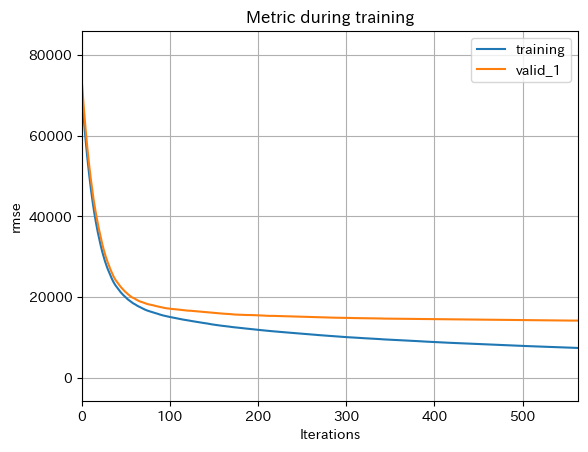

importance
面積               4.529001e+14
L                4.033868e+14
平均地価             2.203663e+14
最寄り駅             8.400882e+13
築年数              7.679432e+13
全体の階数            3.890637e+13
所在地              3.759564e+13
一部屋あたりの面積        3.141868e+13
契約期間             1.861611e+13
所在階              1.325453e+13
所要時間             9.374063e+12
定期借家             3.724908e+12
部屋数              1.495002e+12
バス・トイレ別          1.445007e+12
建物構造             1.283963e+12
D                7.787408e+11
S                6.114345e+11
50m^2以上75m^2未満   3.640538e+11
75m^2以上100m^2未満  2.841101e+11
100m^2以上         2.259001e+10

In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

16787...?チューニングする前の方が良い結果？？とにかく事実は事実なので、チューニング前の結果を使うことにする。

GOSSでは「100m^2以上」の特徴量の重要度が低いので、この特徴量を外してみる。

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','75m^2以上100m^2未満', '50m^2以上75m^2未満']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.7	valid_1's rmse: 50221
[20]	training's rmse: 34357.3	valid_1's rmse: 37844.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[30]	training's rmse: 25975.8	valid_1's rmse: 30960.3
[40]	training's rmse: 21270.1	valid_1's rmse: 27256.8
[50]	training's rmse: 18507.4	valid_1's rmse: 25120.6
[60]	training's rmse: 16771.3	valid_1's rmse: 23719.3
[70]	training's rmse: 15622.6	valid_1's rmse: 22786.9
[80]	training's rmse: 14735.5	valid_1's rmse: 22053.3
[90]	training's rmse: 14074.4	valid_1's rmse: 21497.6
[100]	training's rmse: 13476.9	valid_1's rmse: 20993.3
[110]	training's rmse: 13005.7	valid_1's rmse: 20649.6
[120]	training's rmse: 12600.4	valid_1's rmse: 20359
[130]	training's rmse: 12228	valid_1's rmse: 20116.9
[140]	training's rmse: 11889.9	valid_1's rmse: 19867.1
[150]	training's rmse: 11570.9	valid_1's rmse: 19624.5
[160]	training's rmse: 11284.1	valid_1's rmse: 19447.1
[170]	training's rmse: 11035.9	valid_1's rmse: 19309.9
[180]	training's rmse: 10785.1	valid_1's rmse: 19151.2
[190]	training's rmse: 10564.4	valid_1's rmse: 19044.3
[200]	training's rmse: 10361.5	valid_1's rmse: 18920.8
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[30]	training's rmse: 26763.5	valid_1's rmse: 28664.2
[40]	training's rmse: 22268	valid_1's rmse: 24460.1
[50]	training's rmse: 19647.2	valid_1's rmse: 22109.6
[60]	training's rmse: 17998.7	valid_1's rmse: 20720.8
[70]	training's rmse: 16824.3	valid_1's rmse: 19789.5
[80]	training's rmse: 16015.8	valid_1's rmse: 19105.2
[90]	training's rmse: 15390.7	valid_1's rmse: 18662.2
[100]	training's rmse: 14909.5	valid_1's rmse: 18397
[110]	training's rmse: 14468.2	valid_1's rmse: 18298.1
[120]	training's rmse: 13995.2	valid_1's rmse: 18182.4
[130]	training's rmse: 13628.4	valid_1's rmse: 18025.9
[140]	training's rmse: 13298.2	valid_1's rmse: 17936.5
[150]	training's rmse: 12959.5	valid_1's rmse: 17805.1
[160]	training's rmse: 12673.5	valid_1's rmse: 17771.3
[170]	training's rmse: 12424.4	valid_1's rmse: 17739.3
[180]	training's rmse: 12191.5	valid_1's rmse: 17686.1
[190]	training's rmse: 11966.9	valid_1's rmse: 17573.6
[200]	training's rmse: 11710.6	valid_1's rmse: 17563.2
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[30]	training's rmse: 26986.3	valid_1's rmse: 25944.9
[40]	training's rmse: 22450	valid_1's rmse: 22181.4
[50]	training's rmse: 19731.7	valid_1's rmse: 20359.8
[60]	training's rmse: 17902.2	valid_1's rmse: 19329.3
[70]	training's rmse: 16694	valid_1's rmse: 18742.8
[80]	training's rmse: 15750.8	valid_1's rmse: 18461.2
[90]	training's rmse: 15122.3	valid_1's rmse: 18236.5
[100]	training's rmse: 14525.3	valid_1's rmse: 18124
[110]	training's rmse: 14044.6	valid_1's rmse: 17988.5
[120]	training's rmse: 13631.3	valid_1's rmse: 17865
[130]	training's rmse: 13292.2	valid_1's rmse: 17809.8
[140]	training's rmse: 12903.5	valid_1's rmse: 17741.9
[150]	training's rmse: 12575	valid_1's rmse: 17640.4
[160]	training's rmse: 12247	valid_1's rmse: 17531.6
[170]	training's rmse: 11955.4	valid_1's rmse: 17497
[180]	training's rmse: 11700.1	valid_1's rmse: 17452.2
[190]	training's rmse: 11446.4	valid_1's rmse: 17419.7
[200]	training's rmse: 11226.5	valid_1's rmse: 17392.4
[210]	training's rmse: 10972.6	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35058.2	valid_1's rmse: 35316
[30]	training's rmse: 26832.9	valid_1's rmse: 28266.2
[40]	training's rmse: 22167.1	valid_1's rmse: 24330.5
[50]	training's rmse: 19497	valid_1's rmse: 22415.6
[60]	training's rmse: 17768	valid_1's rmse: 21278.8
[70]	training's rmse: 16612.2	valid_1's rmse: 20735
[80]	training's rmse: 15708.7	valid_1's rmse: 20375.1
[90]	training's rmse: 15070.4	valid_1's rmse: 20193.2
[100]	training's rmse: 14547.6	valid_1's rmse: 19984.3
[110]	training's rmse: 14065.3	valid_1's rmse: 19833.8
[120]	training's rmse: 13637.7	valid_1's rmse: 19697.8
[130]	training's rmse: 13243.9	valid_1's rmse: 19500.5
[140]	training's rmse: 12918.6	valid_1's rmse: 19453.4
[150]	training's rmse: 12601.2	valid_1's rmse: 19347.2
[160]	training's rmse: 12298	valid_1's rmse: 19192.5
[170]	training's rmse: 12015.5	valid_1's rmse: 19082.1
[180]	training's rmse: 11782.9	valid_1's rmse: 19072.9
[190]	training's rmse: 11520.2	valid_1's rmse: 18983
[200]	training's rmse: 11322.9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[30]	training's rmse: 27041.5	valid_1's rmse: 28825.4
[40]	training's rmse: 22721.7	valid_1's rmse: 24403.6
[50]	training's rmse: 20018.2	valid_1's rmse: 21587.3
[60]	training's rmse: 18344.3	valid_1's rmse: 20020.3
[70]	training's rmse: 17169.8	valid_1's rmse: 19097.5
[80]	training's rmse: 16362.2	valid_1's rmse: 18456.9
[90]	training's rmse: 15681.2	valid_1's rmse: 18009.9
[100]	training's rmse: 15130.1	valid_1's rmse: 17640.9
[110]	training's rmse: 14657.1	valid_1's rmse: 17344.4
[120]	training's rmse: 14204.1	valid_1's rmse: 17063.1
[130]	training's rmse: 13852.9	valid_1's rmse: 16843.6
[140]	training's rmse: 13539.2	valid_1's rmse: 16677.1
[150]	training's rmse: 13170.1	valid_1's rmse: 16484.5
[160]	training's rmse: 12897.4	valid_1's rmse: 16357.1
[170]	training's rmse: 12633.3	valid_1's rmse: 16262.4
[180]	training's rmse: 12388.7	valid_1's rmse: 16133.5
[190]	training's rmse: 12169.8	valid_1's rmse: 16049.3
[200]	training's rmse: 11966.6	valid_1's rmse: 15997.1
[210]	training's 

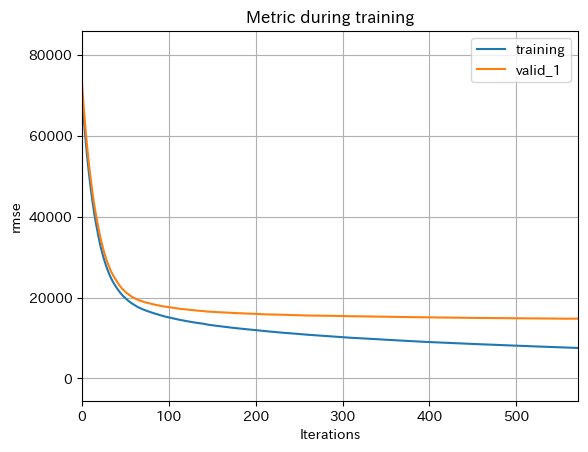

importance
面積               4.556891e+14
L                3.965584e+14
平均地価             2.226497e+14
最寄り駅             8.246446e+13
築年数              7.651069e+13
所在地              3.897520e+13
全体の階数            3.834152e+13
一部屋あたりの面積        3.517516e+13
契約期間             1.449775e+13
所在階              1.367165e+13
所要時間             1.065620e+13
定期借家             4.858163e+12
バス・トイレ別          1.918419e+12
部屋数              1.467699e+12
建物構造             1.399785e+12
S                7.284580e+11
D                6.170819e+11
50m^2以上75m^2未満   3.612399e+11
75m^2以上100m^2未満  3.500761e+11

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.4135935551752292e-06,
        'max_bin': 528,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

16651というなかなかのスコア！チューニングを行えばベストスコアも狙えるかもしれないので、チューニングを行う！！

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_scores.append(mean_squared_error(y_val, y_pred_val, squared=False))
    loss = np.mean(rmse_scores)
    return loss

In [16]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-18 14:02:53,778] A new study created in memory with name: no-name-a7990408-4921-4989-8818-681963d53333
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.5	valid_1's rmse: 50159.4
[20]	training's rmse: 34411.5	valid_1's rmse: 37841.5
[30]	training's rmse: 25981.6	valid_1's rmse: 30995.6
[40]	training's rmse: 21286.4	valid_1's rmse: 27414.9
[50]	training's rmse: 18321.6	valid_1's rmse: 25131.1
[60]	training's rmse: 16599.5	valid_1's rmse: 23780.3
[70]	training's rmse: 15481.8	valid_1's rmse: 22896.4
[80]	training's rmse: 14696.3	valid_1's rmse: 22258.2
[90]	training's rmse: 14014.1	valid_1's rmse: 21701.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.9	valid_1's rmse: 49578.4
[20]	training's rmse: 34957	valid_1's rmse: 36049.2
[30]	training's rmse: 27083.7	valid_1's rmse: 28773.4
[40]	training's rmse: 22655.4	valid_1's rmse: 24752.1
[50]	training's rmse: 20069.6	valid_1's rmse: 22546.6
[60]	training's rmse: 18346.1	valid_1's rmse: 21250.6
[70]	training's rmse: 17201	valid_1's rmse: 20501.5
[80]	training's rmse: 16284.7	valid_1's rmse: 19879.7
[90]	training's rmse: 15610.1	valid_1's rmse: 19385.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49022.1	valid_1's rmse: 48331.9
[20]	training's rmse: 35378.4	valid_1's rmse: 33771
[30]	training's rmse: 27171.7	valid_1's rmse: 25809.5
[40]	training's rmse: 22522.8	valid_1's rmse: 21696.1
[50]	training's rmse: 19788.3	valid_1's rmse: 19789.3
[60]	training's rmse: 18037.2	valid_1's rmse: 18800.7
[70]	training's rmse: 16803	valid_1's rmse: 18254.6
[80]	training's rmse: 15945.3	valid_1's rmse: 17953.6
[90]	training's rmse: 15234.6	valid_1's rmse: 17788.7
[100]	training's rmse: 14633.9	valid_1's rmse: 17558.2
[110]	training's rmse: 14132.5	valid_1's rmse: 17409.5
[120]	training's rmse: 13672.5	valid_1's rmse: 17272.7
[130]	training's rmse: 13271.7	valid_1's rmse: 17196.7
[140]	training's rmse: 12934.3	valid_1's rmse: 17126.6
[150]	training's rmse: 12592.7	valid_1's rmse: 17024.9
[160]	training's rmse: 12288.9	valid_1's rmse: 16954.8
[170]	training's rmse: 12000.3	valid_1's rmse: 16897.4
[180]	training's rmse: 11759.5	valid_1's rmse: 16820.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.5	valid_1's rmse: 48159.3
[20]	training's rmse: 34925.7	valid_1's rmse: 35109.9
[30]	training's rmse: 26794.8	valid_1's rmse: 28058.1
[40]	training's rmse: 22269.1	valid_1's rmse: 24391.4
[50]	training's rmse: 19526.9	valid_1's rmse: 22300.6
[60]	training's rmse: 17891.7	valid_1's rmse: 21286.3
[70]	training's rmse: 16710.2	valid_1's rmse: 20665.1
[80]	training's rmse: 15803.7	valid_1's rmse: 20317.8
[90]	training's rmse: 15142.3	valid_1's rmse: 20110.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48661.5	valid_1's rmse: 50996.5
[20]	training's rmse: 34951.5	valid_1's rmse: 37037.5
[30]	training's rmse: 27071.1	valid_1's rmse: 28693.8
[40]	training's rmse: 22639.6	valid_1's rmse: 23980.4
[50]	training's rmse: 20078.3	valid_1's rmse: 21346.9
[60]	training's rmse: 18378.1	valid_1's rmse: 19735.6
[70]	training's rmse: 17159.9	valid_1's rmse: 18718.2
[80]	training's rmse: 16348.5	valid_1's rmse: 18069
[90]	training's rmse: 15662.6	valid_1's rmse: 17552.9
[100]	training's rmse: 15118.9	valid_1's rmse: 17171.6
[110]	training's rmse: 14662.2	valid_1's rmse: 16938.2
[120]	training's rmse: 14205.7	valid_1's rmse: 16669.9
[130]	training's rmse: 13818.7	valid_1's rmse: 16459.1
[140]	training's rmse: 13489.8	valid_1's rmse: 16283.4
[150]	training's rmse: 13190.4	valid_1's rmse: 16108.4
[160]	training's rmse: 12914.6	valid_1's rmse: 15970.5
[170]	training's rmse: 12595.9	valid_1's rmse: 15810.3
[180]	training's rmse: 12328.3	valid_1's rmse: 15667.3
[190]	training's rmse

[I 2022-09-18 14:03:23,669] Trial 0 finished with value: 16715.968733307298 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48692.3	valid_1's rmse: 50031.5
[20]	training's rmse: 34274.8	valid_1's rmse: 37767.9
[30]	training's rmse: 25744.1	valid_1's rmse: 30789
[40]	training's rmse: 21126.5	valid_1's rmse: 27201.4
[50]	training's rmse: 18326.1	valid_1's rmse: 25056.1
[60]	training's rmse: 16582	valid_1's rmse: 23677.9
[70]	training's rmse: 15443.7	valid_1's rmse: 22770.2
[80]	training's rmse: 14624.9	valid_1's rmse: 22115.6
[90]	training's rmse: 13943.7	valid_1's rmse: 21556.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48963.9	valid_1's rmse: 49814.9
[20]	training's rmse: 34920.5	valid_1's rmse: 36455
[30]	training's rmse: 26825.6	valid_1's rmse: 29103
[40]	training's rmse: 22300.2	valid_1's rmse: 24903.9
[50]	training's rmse: 19681.7	valid_1's rmse: 22641.2
[60]	training's rmse: 18019.1	valid_1's rmse: 21264
[70]	training's rmse: 16958.1	valid_1's rmse: 20468.5
[80]	training's rmse: 16079.8	valid_1's rmse: 19872.5
[90]	training's rmse: 15420.3	valid_1's rmse: 19525.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839	valid_1's rmse: 48616.4
[20]	training's rmse: 34855.9	valid_1's rmse: 34433.1
[30]	training's rmse: 26847.4	valid_1's rmse: 26385.2
[40]	training's rmse: 22269.3	valid_1's rmse: 22477.6
[50]	training's rmse: 19610.6	valid_1's rmse: 20521.3
[60]	training's rmse: 17808.1	valid_1's rmse: 19493.2
[70]	training's rmse: 16685.5	valid_1's rmse: 18968.5
[80]	training's rmse: 15856.1	valid_1's rmse: 18588.8
[90]	training's rmse: 15199.7	valid_1's rmse: 18461.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162.1	valid_1's rmse: 48071.9
[20]	training's rmse: 34751.5	valid_1's rmse: 35326.7
[30]	training's rmse: 26360.1	valid_1's rmse: 28138.4
[40]	training's rmse: 21809.6	valid_1's rmse: 24618.1
[50]	training's rmse: 19109.9	valid_1's rmse: 22728.7
[60]	training's rmse: 17445.4	valid_1's rmse: 21768.4
[70]	training's rmse: 16340.7	valid_1's rmse: 21119.2
[80]	training's rmse: 15465.3	valid_1's rmse: 20686
[90]	training's rmse: 14829	valid_1's rmse: 20436.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48638.5	valid_1's rmse: 50983.6
[20]	training's rmse: 34936.7	valid_1's rmse: 36926.8
[30]	training's rmse: 27000.1	valid_1's rmse: 28536.8
[40]	training's rmse: 22431.5	valid_1's rmse: 23795.2
[50]	training's rmse: 19744.1	valid_1's rmse: 20994.9
[60]	training's rmse: 18126.7	valid_1's rmse: 19629.4
[70]	training's rmse: 16929.5	valid_1's rmse: 18588.6
[80]	training's rmse: 16134	valid_1's rmse: 18055.9
[90]	training's rmse: 15453.9	valid_1's rmse: 17649
[100]	training's rmse: 14829.8	valid_1's rmse: 17199.3
[110]	training's rmse: 14355.7	valid_1's rmse: 16931.2
[120]	training's rmse: 13971.5	valid_1's rmse: 16718.7
[130]	training's rmse: 13627	valid_1's rmse: 16521.5
[140]	training's rmse: 13284	valid_1's rmse: 16334.1
[150]	training's rmse: 12987.9	valid_1's rmse: 16244.1
[160]	training's rmse: 12708.8	valid_1's rmse: 16113.6
[170]	training's rmse: 12439.9	valid_1's rmse: 15962
[180]	training's rmse: 12202.3	valid_1's rmse: 15867.4
[190]	training's rmse: 11947.

[I 2022-09-18 14:03:43,347] Trial 1 finished with value: 16862.324304395544 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16715.968733307298.


[400]	training's rmse: 8641.54	valid_1's rmse: 14806.2
Early stopping, best iteration is:
[393]	training's rmse: 8722.31	valid_1's rmse: 14793.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3560
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48379.6	valid_1's rmse: 49956.6
[20]	training's rmse: 33876.1	valid_1's rmse: 37590.2
[30]	training's rmse: 25421.7	valid_1's rmse: 30791.8
[40]	training's rmse: 20717.5	valid_1's rmse: 27247.6
[50]	training's rmse: 17964	valid_1's rmse: 25132.1
[60]	training's rmse: 16172.5	valid_1's rmse: 23697.1
[70]	training's rmse: 15014.4	valid_1's rmse: 22710.9
[80]	training's rmse: 14186.6	valid_1's rmse: 22042.3
[90]	training's rmse: 13528.1	valid_1's rmse: 21510.8
[100]	training's rmse: 12971.1	valid_1's rmse: 21080.3
[110]	training's rmse: 12483.7	valid_1's rmse: 20723.2
[120]	training's rmse: 12024.7	valid_1's rmse: 20405.6
[130]	training's rmse: 11642.4	valid_1's rmse: 20160.1
[140]	training's rmse: 11296.5	valid_1's rmse: 19922.5
[150]	training's rmse: 10990.3	valid_1's rmse: 19732.6
[160]	training's rmse: 10711.2	valid_1's rmse: 19557.8
[170]	training's rmse: 10438.4	valid_1's rmse: 19411.4
[180]	training's rmse: 10191.9	valid_1's rmse: 19275.8
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48753.6	valid_1's rmse: 49623.7
[20]	training's rmse: 34607.4	valid_1's rmse: 36117.1
[30]	training's rmse: 26491.5	valid_1's rmse: 28525.6
[40]	training's rmse: 22079.7	valid_1's rmse: 24411.8
[50]	training's rmse: 19354.6	valid_1's rmse: 22009.8
[60]	training's rmse: 17707.5	valid_1's rmse: 20676.8
[70]	training's rmse: 16638.4	valid_1's rmse: 19851.4
[80]	training's rmse: 15784.2	valid_1's rmse: 19299
[90]	training's rmse: 15113.2	valid_1's rmse: 18917.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3561
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.7	valid_1's rmse: 48340.8
[20]	training's rmse: 34782	valid_1's rmse: 33644.9
[30]	training's rmse: 26617	valid_1's rmse: 25646.5
[40]	training's rmse: 21989.3	valid_1's rmse: 21803.9
[50]	training's rmse: 19281.6	valid_1's rmse: 19961.9
[60]	training's rmse: 17460.1	valid_1's rmse: 19014.5
[70]	training's rmse: 16224.8	valid_1's rmse: 18572
[80]	training's rmse: 15316.9	valid_1's rmse: 18378
[90]	training's rmse: 14668	valid_1's rmse: 18263.3
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48816.5	valid_1's rmse: 47934.1
[20]	training's rmse: 34359	valid_1's rmse: 35561.4
[30]	training's rmse: 25959.1	valid_1's rmse: 28645.7
[40]	training's rmse: 21380.6	valid_1's rmse: 25129.8
[50]	training's rmse: 18685.1	valid_1's rmse: 23225
[60]	training's rmse: 17045.5	valid_1's rmse: 22254.3
[70]	training's rmse: 15864.6	valid_1's rmse: 21679.4
[80]	training's rmse: 15012.9	valid_1's rmse: 21282.3
[90]	training's rmse: 14356.1	valid_1's rmse: 21006.6
[100]	training's rmse: 13823.7	valid_1's rmse: 20783.2
[110]	training's rmse: 13391.6	valid_1's rmse: 20594.4
[120]	training's rmse: 12962.9	valid_1's rmse: 20448.1
[130]	training's rmse: 12586.5	valid_1's rmse: 20305.1
[140]	training's rmse: 12256.1	valid_1's rmse: 20271.2
[150]	training's rmse: 11929	valid_1's rmse: 20110.4
[160]	training's rmse: 11608.8	valid_1's rmse: 19966.7
[170]	training's rmse: 11346.4	valid_1's rmse: 19865.1
[180]	training's rmse: 11119.3	valid_1's rmse: 19779.1
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48292.8	valid_1's rmse: 50749.7
[20]	training's rmse: 34437.9	valid_1's rmse: 36845.9
[30]	training's rmse: 26530.1	valid_1's rmse: 28670
[40]	training's rmse: 22079.8	valid_1's rmse: 24102.3
[50]	training's rmse: 19544	valid_1's rmse: 21667.6
[60]	training's rmse: 17745.1	valid_1's rmse: 19896.9
[70]	training's rmse: 16507.3	valid_1's rmse: 18718.1
[80]	training's rmse: 15711.7	valid_1's rmse: 18128.2
[90]	training's rmse: 15026	valid_1's rmse: 17578.3
[100]	training's

[I 2022-09-18 14:04:05,076] Trial 2 finished with value: 16877.24285903692 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.7	valid_1's rmse: 50221
[20]	training's rmse: 34357.3	valid_1's rmse: 37844.7
[30]	training's rmse: 25975.8	valid_1's rmse: 30960.3
[40]	training's rmse: 21270.1	valid_1's rmse: 27256.8
[50]	training's rmse: 18507.4	valid_1's rmse: 25120.6
[60]	training's rmse: 16771.3	valid_1's rmse: 23719.3
[70]	training's rmse: 15622.6	valid_1's rmse: 22786.9
[80]	training's rmse: 14735.5	valid_1's rmse: 22053.3
[90]	training's rmse: 14074.4	valid_1's rmse: 21497.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908.7	valid_1's rmse: 49540.9
[20]	training's rmse: 34828.8	valid_1's rmse: 36356
[30]	training's rmse: 26763.5	valid_1's rmse: 28664.2
[40]	training's rmse: 22268	valid_1's rmse: 24460.1
[50]	training's rmse: 19647.2	valid_1's rmse: 22109.6
[60]	training's rmse: 17998.7	valid_1's rmse: 20720.8
[70]	training's rmse: 16824.3	valid_1's rmse: 19789.5
[80]	training's rmse: 16015.8	valid_1's rmse: 19105.2
[90]	training's rmse: 15390.7	valid_1's rmse: 18662.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49054.1	valid_1's rmse: 48657.6
[20]	training's rmse: 35190	valid_1's rmse: 34066.4
[30]	training's rmse: 26986.3	valid_1's rmse: 25944.9
[40]	training's rmse: 22450	valid_1's rmse: 22181.4
[50]	training's rmse: 19731.7	valid_1's rmse: 20359.8
[60]	training's rmse: 17902.2	valid_1's rmse: 19329.3
[70]	training's rmse: 16694	valid_1's rmse: 18742.8
[80]	training's rmse: 15750.8	valid_1's rmse: 18461.2
[90]	training's rmse: 15122.3	valid_1's rmse: 18236.5
[100]	training's rmse: 14525.3	valid_1's rmse: 18124
[110]	training's rmse: 14044.6	valid_1's rmse: 17988.5
[120]	training's rmse: 13631.3	valid_1's rmse: 17865
[130]	training's rmse: 13292.2	valid_1's rmse: 17809.8
[140]	training's rmse: 12903.5	valid_1's rmse: 17741.9
[150]	training's rmse: 12575	valid_1's rmse: 17640.4
[160]	training's rmse: 12247	valid_1's rmse: 17531.6
[170]	training's rmse: 11955.4	valid_1's rmse: 17497
[180]	training's rmse: 11700.1	valid_1's rmse: 17452.2
[190]	training's rmse: 11446.4	vali

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49223.7	valid_1's rmse: 48205.2
[20]	training's rmse: 35058.2	valid_1's rmse: 35316
[30]	training's rmse: 26832.9	valid_1's rmse: 28266.2
[40]	training's rmse: 22167.1	valid_1's rmse: 24330.5
[50]	training's rmse: 19497	valid_1's rmse: 22415.6
[60]	training's rmse: 17768	valid_1's rmse: 21278.8
[70]	training's rmse: 16612.2	valid_1's rmse: 20735
[80]	training's rmse: 15708.7	valid_1's rmse: 20375.1
[90]	training's rmse: 15070.4	valid_1's rmse: 20193.2
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3432
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.2	valid_1's rmse: 51064.5
[20]	training's rmse: 34958.9	valid_1's rmse: 37050.4
[30]	training's rmse: 27041.5	valid_1's rmse: 28825.4
[40]	training's rmse: 22721.7	valid_1's rmse: 24403.6
[50]	training's rmse: 20018.2	valid_1's rmse: 21587.3
[60]	training's rmse: 18344.3	valid_1's rmse: 20020.3
[70]	training's rmse: 17169.8	valid_1's rmse: 19097.5
[80]	training's rmse: 16362.2	valid_1's rmse: 18456.9
[90]	training's rmse: 15681.2	valid_1's rmse: 18009.9
[100]	trai

[I 2022-09-18 14:04:24,960] Trial 3 finished with value: 16801.73924281866 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49272	valid_1's rmse: 50745.1
[20]	training's rmse: 35157.6	valid_1's rmse: 38636.8
[30]	training's rmse: 26873.3	valid_1's rmse: 31707.3
[40]	training's rmse: 22208.6	valid_1's rmse: 27914
[50]	training's rmse: 19451.2	valid_1's rmse: 25716.9
[60]	training's rmse: 17644.4	valid_1's rmse: 24154.2
[70]	training's rmse: 16521.4	valid_1's rmse: 23189.6
[80]	training's rmse: 15675.4	valid_1's rmse: 22482.3
[90]	training's rmse: 15064.6	valid_1's rmse: 21993.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49498.2	valid_1's rmse: 49955.3
[20]	training's rmse: 35559.9	valid_1's rmse: 36804.9
[30]	training's rmse: 27559.9	valid_1's rmse: 29082
[40]	training's rmse: 23171	valid_1's rmse: 24967.9
[50]	training's rmse: 20553.8	valid_1's rmse: 22584.6
[60]	training's rmse: 18926.4	valid_1's rmse: 21249.1
[70]	training's rmse: 17753.2	valid_1's rmse: 20288.2
[80]	training's rmse: 16957.7	valid_1's rmse: 19677.4
[90]	training's rmse: 16333	valid_1's rmse: 19280.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35692.7	valid_1's rmse: 34728.1
[30]	training's rmse: 27688.2	valid_1's rmse: 26762.3
[40]	training's rmse: 23072.9	valid_1's rmse: 22905.2
[50]	training's rmse: 20353.7	valid_1's rmse: 20938.1
[60]	training's rmse: 18579.1	valid_1's rmse: 19956.4
[70]	training's rmse: 17446.2	valid_1's rmse: 19465.3
[80]	training's rmse: 16516.9	valid_1's rmse: 19084.4
[90]	training's rmse: 15903.7	valid_1's rmse: 18867.4
[100]	training's rmse: 15343.1	valid_1's rmse: 18665.1
[110]	training's rmse: 14888.9	valid_1's rmse: 18570.4
[120]	training's rmse: 14532.3	valid_1's rmse: 18479.7
[130]	training's rmse: 14168.1	valid_1's rmse: 18421.1
[140]	training's rmse: 13828.8	valid_1's rmse: 18341.8
[150]	training's rmse: 13506.4	valid_1's rmse: 18319.7
[160]	training's rmse: 13236.3	valid_1's rmse: 18260.5
[170]	training's rmse: 12946.9	valid_1's rmse: 18238.1
[180]	training's rmse: 12715.3	valid_1's rmse: 18220.9
[190]	training's rmse: 12473.4	valid_1's rmse: 18159
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35334.7	valid_1's rmse: 36234.5
[30]	training's rmse: 27134.3	valid_1's rmse: 29367.4
[40]	training's rmse: 22501	valid_1's rmse: 25615.4
[50]	training's rmse: 19883.1	valid_1's rmse: 23575.8
[60]	training's rmse: 18162.3	valid_1's rmse: 22447
[70]	training's rmse: 17005.6	valid_1's rmse: 21775.9
[80]	training's rmse: 16165.3	valid_1's rmse: 21338.8
[90]	training's rmse: 15527.7	valid_1's rmse: 21052.2
[100]	training's rmse: 15016.7	valid_1's rmse: 20918.5
[110]	training's rmse: 14576.9	valid_1's rmse: 20721.2
[120]	training's rmse: 14203.8	valid_1's rmse: 20586.1
[130]	training's rmse: 13847.7	valid_1's rmse: 20399.9
[140]	training's rmse: 13564.7	valid_1's rmse: 20232
[150]	training's rmse: 13314.6	valid_1's rmse: 20141.9
[160]	training's rmse: 13052.5	valid_1's rmse: 20044.8
[170]	training's rmse: 12833.6	valid_1's rmse: 19991.6
[180]	training's rmse: 12582.1	valid_1's rmse: 19891.7
[190]	training's rmse: 12382.9	valid_1's rmse: 19787
[200]	training's rmse: 121

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.5	valid_1's rmse: 51570.6
[20]	training's rmse: 35641.7	valid_1's rmse: 37590.4
[30]	training's rmse: 27865.7	valid_1's rmse: 29239.4
[40]	training's rmse: 23444.3	valid_1's rmse: 24444.8
[50]	training's rmse: 20777.7	valid_1's rmse: 21607.7
[60]	training's rmse: 19145.8	valid_1's rmse: 19956.8
[70]	training's rmse: 17908.1	valid_1's rmse: 18904.9
[80]	training's rmse: 17060.5	valid_1's rmse: 18236.6
[90]	training's rmse: 16331.2	valid_1's rmse: 17702.9
[100]	trai

[I 2022-09-18 14:04:39,104] Trial 4 finished with value: 16848.41926156844 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50280
[20]	training's rmse: 34437.5	valid_1's rmse: 38136.4
[30]	training's rmse: 26108.5	valid_1's rmse: 31344.6
[40]	training's rmse: 21466.2	valid_1's rmse: 27739.2
[50]	training's rmse: 18714.8	valid_1's rmse: 25582.4
[60]	training's rmse: 16950.9	valid_1's rmse: 24180.4
[70]	training's rmse: 15758.9	valid_1's rmse: 23220.7
[80]	training's rmse: 14952.8	valid_1's rmse: 22543.2
[90]	training's rmse: 14291	valid_1's rmse: 21995.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 49335
[20]	training's rmse: 34715.5	valid_1's rmse: 35889.8
[30]	training's rmse: 26790.6	valid_1's rmse: 28492.7
[40]	training's rmse: 22343.1	valid_1's rmse: 24262.7
[50]	training's rmse: 19698.3	valid_1's rmse: 21980.8
[60]	training's rmse: 17996	valid_1's rmse: 20598.3
[70]	training's rmse: 16924.4	valid_1's rmse: 19738.5
[80]	training's rmse: 16122.4	valid_1's rmse: 19186.2
[90]	training's rmse: 15457.6	valid_1's rmse: 18700.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 34950.3	valid_1's rmse: 34647.6
[30]	training's rmse: 26823.6	valid_1's rmse: 26641.1
[40]	training's rmse: 22463.5	valid_1's rmse: 22729.5
[50]	training's rmse: 19780.5	valid_1's rmse: 20813.5
[60]	training's rmse: 18061.4	valid_1's rmse: 19722.9
[70]	training's rmse: 16797.3	valid_1's rmse: 19132.4
[80]	training's rmse: 15875.2	valid_1's rmse: 18804.8
[90]	training's rmse: 15171.6	valid_1's rmse: 18643.4
[100]	training's rmse: 14580.5	valid_1's rmse: 18435.1
[110]	training's rmse: 14056.5	valid_1's rmse: 18332.4
[120]	training's rmse: 13644.7	valid_1's rmse: 18173.8
[130]	training's rmse: 13237.7	valid_1's rmse: 18053.3
[140]	training's rmse: 12851.3	valid_1's rmse: 17956.6
[150]	training's rmse: 12504	valid_1's rmse: 17894.3
[160]	training's rmse: 12193.1	valid_1's rmse: 17873.1
[170]	training's rmse: 11895.6	valid_1's rmse: 17823.2
[180]	training's rmse: 11613.7	valid_1's rmse: 17794.7
[190]	training's rmse: 11364.9	valid_1's rmse: 17773.5
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093.6	valid_1's rmse: 47836.4
[20]	training's rmse: 34841.6	valid_1's rmse: 35104.3
[30]	training's rmse: 26665.6	valid_1's rmse: 27872.2
[40]	training's rmse: 22018.7	valid_1's rmse: 24123.3
[50]	training's rmse: 19282	valid_1's rmse: 22179.1
[60]	training's rmse: 17533.6	valid_1's rmse: 21089.7
[70]	training's rmse: 16382.5	valid_1's rmse: 20435.3
[80]	training's rmse: 15480.7	valid_1's rmse: 19932.9
[90]	training's rmse: 14837.2	valid_1's rmse: 19646.1
[100]	training's rmse: 14257.1	valid_1's rmse: 19468.2
[110]	training's rmse: 13703.5	valid_1's rmse: 19192.4
[120]	training's rmse: 13244.1	valid_1's rmse: 19002.4
[130]	training's rmse: 12880.1	valid_1's rmse: 18878.5
[140]	training's rmse: 12559.2	valid_1's rmse: 18823.5
[150]	training's rmse: 12264.8	valid_1's rmse: 18742.1
[160]	training's rmse: 12000.8	valid_1's rmse: 18671
[170]	training's rmse: 11720	valid_1's rmse: 18582.8
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48458.8	valid_1's rmse: 50917.4
[20]	training's rmse: 34765.5	valid_1's rmse: 36774.9
[30]	training's rmse: 26824.7	valid_1's rmse: 28483.4
[40]	training's rmse: 22469.2	valid_1's rmse: 23932.7
[50]	training's rmse: 19867.9	valid_1's rmse: 21324.6
[60]	training's rmse: 18171.2	valid_1's rmse: 19762
[70]	training's rmse: 17008.4	valid_1's rmse: 18766.2
[80]	training's rmse: 16189.3	valid_1's rmse: 18090.2
[90]	training's rmse: 15458.4	valid_1's rmse: 17545
[100]	training

[I 2022-09-18 14:04:57,085] Trial 5 finished with value: 16810.780547922946 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3536
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.1	valid_1's rmse: 50002.7
[20]	training's rmse: 33866.2	valid_1's rmse: 37613
[30]	training's rmse: 25364.9	valid_1's rmse: 30637.8
[40]	training's rmse: 20794.7	valid_1's rmse: 27051.1
[50]	training's rmse: 17983.7	valid_1's rmse: 24852.3
[60]	training's rmse: 16203	valid_1's rmse: 23363
[70]	training's rmse: 15012.8	valid_1's rmse: 22358.2
[80]	training's rmse: 14138.3	valid_1's rmse: 21655.8
[90]	training's rmse: 13507	valid_1's rmse: 21157.2
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3539
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48755.3	valid_1's rmse: 49615.3
[20]	training's rmse: 34622	valid_1's rmse: 36195.5
[30]	training's rmse: 26516.2	valid_1's rmse: 28643
[40]	training's rmse: 22120.9	valid_1's rmse: 24643.8
[50]	training's rmse: 19326.7	valid_1's rmse: 22144.3
[60]	training's rmse: 17749.5	valid_1's rmse: 20714
[70]	training's rmse: 16653	valid_1's rmse: 19818.8
[80]	training's rmse: 15787.9	valid_1's rmse: 19101.6
[90]	training's rmse: 15174.6	valid_1's rmse: 18754.2
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3537
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48751.1	valid_1's rmse: 48289.1
[20]	training's rmse: 34740.4	valid_1's rmse: 33699.9
[30]	training's rmse: 26373.7	valid_1's rmse: 25650.9
[40]	training's rmse: 21882.1	valid_1's rmse: 21905
[50]	training's rmse: 19178.6	valid_1's rmse: 19976.1
[60]	training's rmse: 17456.7	valid_1's rmse: 19148.3
[70]	training's rmse: 16277.4	valid_1's rmse: 18649.6
[80]	training's rmse: 15363	valid_1's rmse: 18429.2
[90]	training's rmse: 14666.4	valid_1's rmse: 18282.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48776.4	valid_1's rmse: 47887.4
[20]	training's rmse: 34303.1	valid_1's rmse: 35346
[30]	training's rmse: 26102.7	valid_1's rmse: 28445.3
[40]	training's rmse: 21489.6	valid_1's rmse: 24878.6
[50]	training's rmse: 18744.6	valid_1's rmse: 22906.2
[60]	training's rmse: 16990.9	valid_1's rmse: 21793.9
[70]	training's rmse: 15822.3	valid_1's rmse: 21181.8
[80]	training's rmse: 15008.7	valid_1's rmse: 20766.5
[90]	training's rmse: 14359.8	valid_1's rmse: 20497.1
[100]	training's rmse: 13830.2	valid_1's rmse: 20377.7
[110]	training's rmse: 13374.4	valid_1's rmse: 20223.3
[120]	training's rmse: 12964.2	valid_1's rmse: 20028.6
[130]	training's rmse: 12572.8	valid_1's rmse: 19865.5
[140]	training's rmse: 12218.6	valid_1's rmse: 19744.1
[150]	training's rmse: 11891.7	valid_1's rmse: 19600.4
[160]	training's rmse: 11596.9	valid_1's rmse: 19481.2
[170]	training's rmse: 11303.4	valid_1's rmse: 19416.8
[180]	training's rmse: 11061.6	valid_1's rmse: 19349.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48284.4	valid_1's rmse: 50781.1
[20]	training's rmse: 34403.5	valid_1's rmse: 36718
[30]	training's rmse: 26424.3	valid_1's rmse: 28380.4
[40]	training's rmse: 22202.1	valid_1's rmse: 24205
[50]	training's rmse: 19480.5	valid_1's rmse: 21303
[60]	training's rmse: 17793.7	valid_1's rmse: 19743.4
[70]	training's rmse: 16651.8	valid_1's rmse: 18675.7
[80]	training's rmse: 15778.6	valid_1's rmse: 18010.1
[90]	training's rmse: 15021.1	valid_1's rmse: 17585.1
[100]	training's

[I 2022-09-18 14:05:22,141] Trial 6 finished with value: 16792.556520580532 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48729.1	valid_1's rmse: 50361.2
[20]	training's rmse: 34301.9	valid_1's rmse: 38003.4
[30]	training's rmse: 25897.3	valid_1's rmse: 31103.6
[40]	training's rmse: 21192.7	valid_1's rmse: 27409.2
[50]	training's rmse: 18384.2	valid_1's rmse: 25211.3
[60]	training's rmse: 16564.3	valid_1's rmse: 23783.5
[70]	training's rmse: 15424.9	valid_1's rmse: 22926.7
[80]	training's rmse: 14583.3	valid_1's rmse: 22255.2
[90]	training's rmse: 13918.6	valid_1's rmse: 21710.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.6	valid_1's rmse: 49720.3
[20]	training's rmse: 34742.5	valid_1's rmse: 36285.8
[30]	training's rmse: 26764.6	valid_1's rmse: 28933
[40]	training's rmse: 22275.9	valid_1's rmse: 24821.3
[50]	training's rmse: 19560.8	valid_1's rmse: 22444
[60]	training's rmse: 17854.9	valid_1's rmse: 21090.9
[70]	training's rmse: 16692	valid_1's rmse: 20017.7
[80]	training's rmse: 15789.5	valid_1's rmse: 19282.5
[90]	training's rmse: 15123.6	valid_1's rmse: 18750.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48760.6	valid_1's rmse: 48562.7
[20]	training's rmse: 34750.2	valid_1's rmse: 34235.2
[30]	training's rmse: 26650.1	valid_1's rmse: 26308.1
[40]	training's rmse: 22157.6	valid_1's rmse: 22455
[50]	training's rmse: 19384.3	valid_1's rmse: 20462.5
[60]	training's rmse: 17668.7	valid_1's rmse: 19485.1
[70]	training's rmse: 16557.1	valid_1's rmse: 18917.3
[80]	training's rmse: 15675	valid_1's rmse: 18567.2
[90]	training's rmse: 15000.9	valid_1's rmse: 18385.2
[100]	training's rmse: 14427.3	valid_1's rmse: 18211.7
[110]	training's rmse: 13903.2	valid_1's rmse: 18094.1
[120]	training's rmse: 13423.6	valid_1's rmse: 18016.9
[130]	training's rmse: 13000.8	valid_1's rmse: 17922.4
[140]	training's rmse: 12628.6	valid_1's rmse: 17945.1
Early stopping, best iteration is:
[132]	training's rmse: 12924.9	valid_1's rmse: 17911.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49169.5	valid_1's rmse: 47905.1
[20]	training's rmse: 34725.6	valid_1's rmse: 35304.6
[30]	training's rmse: 26500.9	valid_1's rmse: 28488.5
[40]	training's rmse: 21901.8	valid_1's rmse: 24770.8
[50]	training's rmse: 19104.5	valid_1's rmse: 22842.1
[60]	training's rmse: 17446.5	valid_1's rmse: 21755.7
[70]	training's rmse: 16380	valid_1's rmse: 21149
[80]	training's rmse: 15523.3	valid_1's rmse: 20784.1
[90]	training's rmse: 14873.5	valid_1's rmse: 20569.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48580.7	valid_1's rmse: 50871.3
[20]	training's rmse: 34912.6	valid_1's rmse: 36827.8
[30]	training's rmse: 27071.9	valid_1's rmse: 28730.6
[40]	training's rmse: 22687.5	valid_1's rmse: 24266.3
[50]	training's rmse: 19933.1	valid_1's rmse: 21544.2
[60]	training's rmse: 18264.3	valid_1's rmse: 20068.3
[70]	training's rmse: 16966.8	valid_1's rmse: 19061.7
[80]	training's rmse: 16085.5	valid_1's rmse: 18414.9
[90]	training's rmse: 15378.3	valid_1's rmse: 17862.5
[100]	trai

[I 2022-09-18 14:05:37,959] Trial 7 finished with value: 16832.775110713115 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 16715.968733307298.


[440]	training's rmse: 8138.45	valid_1's rmse: 15154.9
Early stopping, best iteration is:
[433]	training's rmse: 8208.52	valid_1's rmse: 15140.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3237
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49178.4	valid_1's rmse: 50469.6
[20]	training's rmse: 35110	valid_1's rmse: 38296.7
[30]	training's rmse: 26840.8	valid_1's rmse: 31514
[40]	training's rmse: 22381.3	valid_1's rmse: 28056.4
[50]	training's rmse: 19463.1	valid_1's rmse: 25708.5
[60]	training's rmse: 17733.8	valid_1's rmse: 24331.5
[70]	training's rmse: 16516.3	valid_1's rmse: 23326.2
[80]	training's rmse: 15667.3	valid_1's rmse: 22708.4
[90]	training's rmse: 14987.3	valid_1's rmse: 22163.7
[100]	training's rmse: 14468.9	valid_1's rmse: 21739.8
[110]	training's rmse: 13947.2	valid_1's rmse: 21346.6
[120]	training's rmse: 13511.5	valid_1's rmse: 20971.1
[130]	training's rmse: 13132.5	valid_1's rmse: 20689.6
[140]	training's rmse: 12811.7	valid_1's rmse: 20453.8
[150]	training's rmse: 12492.8	valid_1's rmse: 20228.9
[160]	training's rmse: 12230.9	valid_1's rmse: 20051.1
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49336.2	valid_1's rmse: 50013
[20]	training's rmse: 35497.5	valid_1's rmse: 36638.5
[30]	training's rmse: 27640.7	valid_1's rmse: 29317.2
[40]	training's rmse: 23285.9	valid_1's rmse: 25247.4
[50]	training's rmse: 20708.2	valid_1's rmse: 22900
[60]	training's rmse: 18966.2	valid_1's rmse: 21550.3
[70]	training's rmse: 17764.3	valid_1's rmse: 20608.2
[80]	training's rmse: 16926.6	valid_1's rmse: 20128.9
[90]	training's rmse: 16242.4	valid_1's rmse: 19754.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49493.3	valid_1's rmse: 49072.9
[20]	training's rmse: 35792.1	valid_1's rmse: 34623.7
[30]	training's rmse: 27799.6	valid_1's rmse: 26508.3
[40]	training's rmse: 23229.1	valid_1's rmse: 22539.5
[50]	training's rmse: 20608.2	valid_1's rmse: 20649.1
[60]	training's rmse: 18840.3	valid_1's rmse: 19570.9
[70]	training's rmse: 17566.3	valid_1's rmse: 18960.8
[80]	training's rmse: 16682.6	valid_1's rmse: 18633.3
[90]	training's rmse: 15965.6	valid_1's rmse: 18466.9
[100]	training's rmse: 15443.7	valid_1's rmse: 18282.9
[110]	training's rmse: 14980.8	valid_1's rmse: 18160.9
[120]	training's rmse: 14591	valid_1's rmse: 18094.2
[130]	training's rmse: 14231.9	valid_1's rmse: 18054.3
[140]	training's rmse: 13876.5	valid_1's rmse: 17988.1
[150]	training's rmse: 13551.3	valid_1's rmse: 17956.3
[160]	training's rmse: 13261.9	valid_1's rmse: 17898.5
[170]	training's rmse: 12993.8	valid_1's rmse: 17821.7
Early stopping, best iteration is:
[165]	training's rmse: 13107.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3237
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49624.9	valid_1's rmse: 48616.1
[20]	training's rmse: 35598.3	valid_1's rmse: 36043.8
[30]	training's rmse: 27421.3	valid_1's rmse: 28990.5
[40]	training's rmse: 22813.6	valid_1's rmse: 25172.7
[50]	training's rmse: 20094.3	valid_1's rmse: 23163
[60]	training's rmse: 18333.8	valid_1's rmse: 22047.6
[70]	training's rmse: 17157.2	valid_1's rmse: 21351.4
[80]	training's rmse: 16266.8	valid_1's rmse: 20921.4
[90]	training's rmse: 15629.7	valid_1's rmse: 20629.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49214.1	valid_1's rmse: 51546.9
[20]	training's rmse: 35676.6	valid_1's rmse: 37521.3
[30]	training's rmse: 27801.4	valid_1's rmse: 29099.7
[40]	training's rmse: 23443	valid_1's rmse: 24615.2
[50]	training's rmse: 20866.9	valid_1's rmse: 21889.9
[60]	training's rmse: 19170.4	valid_1's rmse: 20319.6
[70]	training's rmse: 18029.5	valid_1's rmse: 19304.2
[80]	training's rmse: 17162.6	valid_1's rmse: 18625.2
[90]	training's rmse: 16551.9	valid_1's rmse: 18191.6
[100]	training's rmse: 16010.8	valid_1's rmse: 17823.4
[110]	training's rmse: 15525.2	valid_1's rmse: 17591.6
[120]	training's rmse: 15103.8	valid_1's rmse: 17342.1
[130]	training's rmse: 14729.5	valid_1's rmse: 17139.9
[140]	training's rmse: 14395.6	valid_1's rmse: 16982.5
[150]	training's rmse: 14083.5	valid_1's rmse: 16818
[160]	training's rmse: 13784.8	valid_1's rmse: 16649.9
[170]	training's rmse: 13555.2	valid_1's rmse: 16548.3
[180]	training's rmse: 13322.6	valid_1's rmse: 16445.7
[190]	training's rmse: 

[I 2022-09-18 14:05:52,257] Trial 8 finished with value: 16872.35168366889 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.7	valid_1's rmse: 50484.1
[20]	training's rmse: 34613.6	valid_1's rmse: 38275.1
[30]	training's rmse: 26333.4	valid_1's rmse: 31406.2
[40]	training's rmse: 21732.1	valid_1's rmse: 27744.2
[50]	training's rmse: 18876.7	valid_1's rmse: 25514.7
[60]	training's rmse: 17166.2	valid_1's rmse: 24110.7
[70]	training's rmse: 15980.3	valid_1's rmse: 23176.7
[80]	training's rmse: 15162	valid_1's rmse: 22513.3
[90]	training's rmse: 14473.1	valid_1's rmse: 22021.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49072.3	valid_1's rmse: 49638.2
[20]	training's rmse: 35022.4	valid_1's rmse: 36316.8
[30]	training's rmse: 27093.3	valid_1's rmse: 28834.7
[40]	training's rmse: 22835.1	valid_1's rmse: 24904
[50]	training's rmse: 20158.8	valid_1's rmse: 22552.9
[60]	training's rmse: 18418.8	valid_1's rmse: 21289.8
[70]	training's rmse: 17271.9	valid_1's rmse: 20392.4
[80]	training's rmse: 16423.5	valid_1's rmse: 19848.3
[90]	training's rmse: 15768.7	valid_1's rmse: 19469.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49123.7	valid_1's rmse: 48857.1
[20]	training's rmse: 35491.5	valid_1's rmse: 34382.3
[30]	training's rmse: 27608.8	valid_1's rmse: 26463.2
[40]	training's rmse: 23097	valid_1's rmse: 22471
[50]	training's rmse: 20477.8	valid_1's rmse: 20509.2
[60]	training's rmse: 18677.7	valid_1's rmse: 19458.8
[70]	training's rmse: 17334.7	valid_1's rmse: 18844
[80]	training's rmse: 16429.6	valid_1's rmse: 18501.4
[90]	training's rmse: 15753.4	valid_1's rmse: 18288.2
[100]	training's rmse: 15162.1	valid_1's rmse: 18118.2
[110]	training's rmse: 14661	valid_1's rmse: 18028.2
[120]	training's rmse: 14230.1	valid_1's rmse: 17940.9
[130]	training's rmse: 13869.1	valid_1's rmse: 17813.1
[140]	training's rmse: 13494.2	valid_1's rmse: 17705.2
[150]	training's rmse: 13141	valid_1's rmse: 17660.3
[160]	training's rmse: 12820.6	valid_1's rmse: 17597.2
[170]	training's rmse: 12510.7	valid_1's rmse: 17601.7
Early stopping, best iteration is:
[162]	training's rmse: 12748.1	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49427.6	valid_1's rmse: 48077.3
[20]	training's rmse: 35080.6	valid_1's rmse: 35389.4
[30]	training's rmse: 26771.8	valid_1's rmse: 28045.2
[40]	training's rmse: 22057.5	valid_1's rmse: 24392.6
[50]	training's rmse: 19364.7	valid_1's rmse: 22411.8
[60]	training's rmse: 17668.1	valid_1's rmse: 21297.9
[70]	training's rmse: 16495.2	valid_1's rmse: 20624.7
[80]	training's rmse: 15720.9	valid_1's rmse: 20258.8
[90]	training's rmse: 15057.5	valid_1's rmse: 20100.9
[100]	training's rmse: 14557.4	valid_1's rmse: 19906.5
[110]	training's rmse: 14114.8	valid_1's rmse: 19719.1
[120]	training's rmse: 13754	valid_1's rmse: 19636.8
[130]	training's rmse: 13389.7	valid_1's rmse: 19477.9
[140]	training's rmse: 13077.2	valid_1's rmse: 19374.2
[150]	training's rmse: 12744.5	valid_1's rmse: 19251.6
[160]	training's rmse: 12487.7	valid_1's rmse: 19199.3
[170]	training's rmse: 12247.8	valid_1's rmse: 19112.9
[180]	training's rmse: 12007.8	valid_1's rmse: 19007.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.1	valid_1's rmse: 50935.9
[20]	training's rmse: 35160.6	valid_1's rmse: 36849
[30]	training's rmse: 27334.7	valid_1's rmse: 28740.8
[40]	training's rmse: 23055.6	valid_1's rmse: 24324.2
[50]	training's rmse: 20437.4	valid_1's rmse: 21757.6
[60]	training's rmse: 18667.9	valid_1's rmse: 20158.2
[70]	training's rmse: 17524.4	valid_1's rmse: 19238.8
[80]	training's rmse: 16715.6	valid_1's rmse: 18662.7
[90]	training's rmse: 15915.8	valid_1's rmse: 18215.1
[100]	traini

[I 2022-09-18 14:06:08,010] Trial 9 finished with value: 16904.352617817585 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3413
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48821.2	valid_1's rmse: 50268.9
[20]	training's rmse: 34455.1	valid_1's rmse: 37957.1
[30]	training's rmse: 26089.5	valid_1's rmse: 31047.1
[40]	training's rmse: 21385.9	valid_1's rmse: 27394.7
[50]	training's rmse: 18601.9	valid_1's rmse: 25265.1
[60]	training's rmse: 16859.8	valid_1's rmse: 23857.4
[70]	training's rmse: 15705	valid_1's rmse: 22930.3
[80]	training's rmse: 14866.1	valid_1's rmse: 22254.2
[90]	training's rmse: 14222.7	valid_1's rmse: 21714
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48955.4	valid_1's rmse: 49554.2
[20]	training's rmse: 34907.9	valid_1's rmse: 36475.7
[30]	training's rmse: 26803.8	valid_1's rmse: 28820
[40]	training's rmse: 22344.9	valid_1's rmse: 24698.4
[50]	training's rmse: 19702	valid_1's rmse: 22360.6
[60]	training's rmse: 18028.3	valid_1's rmse: 20904.5
[70]	training's rmse: 16958.1	valid_1's rmse: 20077.3
[80]	training's rmse: 16119.9	valid_1's rmse: 19382.9
[90]	training's rmse: 15449.4	valid_1's rmse: 18881.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49084.8	valid_1's rmse: 48675.6
[20]	training's rmse: 35287	valid_1's rmse: 34162.3
[30]	training's rmse: 26972.4	valid_1's rmse: 26043.5
[40]	training's rmse: 22497.1	valid_1's rmse: 22175.1
[50]	training's rmse: 19849.3	valid_1's rmse: 20255.2
[60]	training's rmse: 18168.1	valid_1's rmse: 19164.7
[70]	training's rmse: 16984.2	valid_1's rmse: 18560.7
[80]	training's rmse: 16080.4	valid_1's rmse: 18258.2
[90]	training's rmse: 15414.7	valid_1's rmse: 18070.7
[100]	training's rmse: 14868.7	valid_1's rmse: 17999.6
[110]	training's rmse: 14410.3	valid_1's rmse: 17836.8
[120]	training's rmse: 13990.4	valid_1's rmse: 17785.9
[130]	training's rmse: 13564.2	valid_1's rmse: 17680.2
[140]	training's rmse: 13195.9	valid_1's rmse: 17651
[150]	training's rmse: 12865.1	valid_1's rmse: 17585.9
[160]	training's rmse: 12546.7	valid_1's rmse: 17532.7
[170]	training's rmse: 12219.2	valid_1's rmse: 17460.8
[180]	training's rmse: 11943.5	valid_1's rmse: 17383
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3413
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49301.5	valid_1's rmse: 48259.2
[20]	training's rmse: 35034.8	valid_1's rmse: 35477.1
[30]	training's rmse: 26733.1	valid_1's rmse: 28423.9
[40]	training's rmse: 22148.2	valid_1's rmse: 24591.2
[50]	training's rmse: 19467.3	valid_1's rmse: 22585.3
[60]	training's rmse: 17722.4	valid_1's rmse: 21287.2
[70]	training's rmse: 16608.5	valid_1's rmse: 20707.2
[80]	training's rmse: 15768.8	valid_1's rmse: 20339.9
[90]	training's rmse: 15166.1	valid_1's rmse: 20152.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35058.7	valid_1's rmse: 37140.6
[30]	training's rmse: 27094.7	valid_1's rmse: 28710.6
[40]	training's rmse: 22778.2	valid_1's rmse: 24280
[50]	training's rmse: 20139.8	valid_1's rmse: 21624.9
[60]	training's rmse: 18518.6	valid_1's rmse: 20152.4
[70]	training's rmse: 17273.1	valid_1's rmse: 19135.8
[80]	training's rmse: 16402.1	valid_1's rmse: 18419.5
[90]	training's rmse: 15763.8	valid_1's rmse: 18003
[100]	training's rmse: 15182.8	valid_1's rmse: 17608.1
[110]	training's rmse: 14744.9	valid_1's rmse: 17315.2
[120]	training's rmse: 14340.6	valid_1's rmse: 17037
[130]	training's rmse: 13921.8	valid_1's rmse: 16809.1
[140]	training's rmse: 13602.7	valid_1's rmse: 16667.3
[150]	training's rmse: 13308.7	valid_1's rmse: 16527
[160]	training's rmse: 13007.3	valid_1's rmse: 16420.5
[170]	training's rmse: 12761.2	valid_1's rmse: 16291.2
[180]	training's rmse: 12519.8	valid_1's rmse: 16149.6
[190]	training's rmse: 12294.8	valid_1's rmse: 16031
[200]	training's rmse: 12055

[I 2022-09-18 14:06:25,965] Trial 10 finished with value: 16875.456296128254 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48811.5	valid_1's rmse: 50361.2
[20]	training's rmse: 34602.7	valid_1's rmse: 38242.1
[30]	training's rmse: 26234	valid_1's rmse: 31448.9
[40]	training's rmse: 21661	valid_1's rmse: 28019.3
[50]	training's rmse: 18888.5	valid_1's rmse: 25818.3
[60]	training's rmse: 17131	valid_1's rmse: 24392.2
[70]	training's rmse: 15918.5	valid_1's rmse: 23362.3
[80]	training's rmse: 15039.2	valid_1's rmse: 22588.6
[90]	training's rmse: 14355.2	valid_1's rmse: 21986.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48912.7	valid_1's rmse: 49433.3
[20]	training's rmse: 34899.9	valid_1's rmse: 36124.8
[30]	training's rmse: 26919.4	valid_1's rmse: 28469.3
[40]	training's rmse: 22511.8	valid_1's rmse: 24372.8
[50]	training's rmse: 19949.8	valid_1's rmse: 22018.7
[60]	training's rmse: 18236.2	valid_1's rmse: 20649.1
[70]	training's rmse: 17059.3	valid_1's rmse: 19790.4
[80]	training's rmse: 16216.5	valid_1's rmse: 19209.2
[90]	training's rmse: 15504.9	valid_1's rmse: 18775
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35113.4	valid_1's rmse: 34826.6
[30]	training's rmse: 27109.8	valid_1's rmse: 26886.7
[40]	training's rmse: 22667.6	valid_1's rmse: 22869.9
[50]	training's rmse: 19890.9	valid_1's rmse: 20925.5
[60]	training's rmse: 18117.2	valid_1's rmse: 19901.4
[70]	training's rmse: 16858.3	valid_1's rmse: 19314.8
[80]	training's rmse: 15993.3	valid_1's rmse: 18998.6
[90]	training's rmse: 15352.7	valid_1's rmse: 18774.4
[100]	training's rmse: 14794.4	valid_1's rmse: 18661.3
[110]	training's rmse: 14344.7	valid_1's rmse: 18539.6
[120]	training's rmse: 13895.4	valid_1's rmse: 18401.3
[130]	training's rmse: 13509	valid_1's rmse: 18322.9
[140]	training's rmse: 13137.6	valid_1's rmse: 18205
[150]	training's rmse: 12814.2	valid_1's rmse: 18099.8
[160]	training's rmse: 12481.4	valid_1's rmse: 18058.2
[170]	training's rmse: 12229.1	valid_1's rmse: 18024.4
[180]	training's rmse: 11977.3	valid_1's rmse: 17993.7
[190]	training's rmse: 11724.9	valid_1's rmse: 17943.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 34998.8	valid_1's rmse: 35270.8
[30]	training's rmse: 26728.9	valid_1's rmse: 28047.2
[40]	training's rmse: 22136.3	valid_1's rmse: 24534.6
[50]	training's rmse: 19415.7	valid_1's rmse: 22691.2
[60]	training's rmse: 17702.4	valid_1's rmse: 21605.4
[70]	training's rmse: 16577.8	valid_1's rmse: 20941.8
[80]	training's rmse: 15744.1	valid_1's rmse: 20581.7
[90]	training's rmse: 15100.4	valid_1's rmse: 20404
[100]	training's rmse: 14572.8	valid_1's rmse: 20154.5
[110]	training's rmse: 14148.1	valid_1's rmse: 19965.4
[120]	training's rmse: 13695.8	valid_1's rmse: 19822.3
[130]	training's rmse: 13343.4	valid_1's rmse: 19698.3
[140]	training's rmse: 12948.4	valid_1's rmse: 19633.9
[150]	training's rmse: 12653.2	valid_1's rmse: 19550.5
[160]	training's rmse: 12351.4	valid_1's rmse: 19414.3
[170]	training's rmse: 12084.8	valid_1's rmse: 19317.5
[180]	training's rmse: 11838	valid_1's rmse: 19210.8
[190]	training's rmse: 11642.6	valid_1's rmse: 19146.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48605.6	valid_1's rmse: 51031.5
[20]	training's rmse: 34906.6	valid_1's rmse: 37010.4
[30]	training's rmse: 27030.1	valid_1's rmse: 28785.4
[40]	training's rmse: 22634.4	valid_1's rmse: 24125.9
[50]	training's rmse: 20055.7	valid_1's rmse: 21604.4
[60]	training's rmse: 18377.5	valid_1's rmse: 19962.3
[70]	training's rmse: 17151.2	valid_1's rmse: 19008
[80]	training's rmse: 16321	valid_1's rmse: 18422.4
[90]	training's rmse: 15657.7	valid_1's rmse: 17975.7
[100]	training

[I 2022-09-18 14:06:43,160] Trial 11 finished with value: 16871.05090991299 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48527.4	valid_1's rmse: 50049.8
[20]	training's rmse: 34095.7	valid_1's rmse: 37669.4
[30]	training's rmse: 25674.9	valid_1's rmse: 30877.2
[40]	training's rmse: 21095.7	valid_1's rmse: 27395.9
[50]	training's rmse: 18242.4	valid_1's rmse: 25191.6
[60]	training's rmse: 16440.1	valid_1's rmse: 23823.8
[70]	training's rmse: 15250.8	valid_1's rmse: 22885.6
[80]	training's rmse: 14360.2	valid_1's rmse: 22170.4
[90]	training's rmse: 13653.6	valid_1's rmse: 21582.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3207
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48747.4	valid_1's rmse: 49448.8
[20]	training's rmse: 34676	valid_1's rmse: 36097.4
[30]	training's rmse: 26676.4	valid_1's rmse: 28765.4
[40]	training's rmse: 22379.2	valid_1's rmse: 24823.2
[50]	training's rmse: 19729.6	valid_1's rmse: 22483.7
[60]	training's rmse: 17951.6	valid_1's rmse: 21045.5
[70]	training's rmse: 16777.8	valid_1's rmse: 20181.2
[80]	training's rmse: 15828.1	valid_1's rmse: 19525.8
[90]	training's rmse: 15146.1	valid_1's rmse: 19215.9
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3204
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.1	valid_1's rmse: 48285.8
[20]	training's rmse: 35038.3	valid_1's rmse: 33813.2
[30]	training's rmse: 27146.2	valid_1's rmse: 25889.2
[40]	training's rmse: 22738.5	valid_1's rmse: 22011
[50]	training's rmse: 19881.1	valid_1's rmse: 20020.5
[60]	training's rmse: 17959	valid_1's rmse: 18975.6
[70]	training's rmse: 16696.2	valid_1's rmse: 18477.1
[80]	training's rmse: 15822.2	valid_1's rmse: 18235.8
[90]	training's rmse: 15157.4	valid_1's rmse: 18036.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49021.9	valid_1's rmse: 47664.4
[20]	training's rmse: 34866.7	valid_1's rmse: 34925.4
[30]	training's rmse: 26714.1	valid_1's rmse: 27864.6
[40]	training's rmse: 22143.2	valid_1's rmse: 24251.5
[50]	training's rmse: 19382.8	valid_1's rmse: 22361.8
[60]	training's rmse: 17640.6	valid_1's rmse: 21320.9
[70]	training's rmse: 16506	valid_1's rmse: 20726.7
[80]	training's rmse: 15507	valid_1's rmse: 20260.2
[90]	training's rmse: 14811.2	valid_1's rmse: 19955
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48472.3	valid_1's rmse: 51055.5
[20]	training's rmse: 34762.8	valid_1's rmse: 36965.4
[30]	training's rmse: 26945.6	valid_1's rmse: 28744.7
[40]	training's rmse: 22546.7	valid_1's rmse: 24025.5
[50]	training's rmse: 19865.6	valid_1's rmse: 21366
[60]	training's rmse: 18167.5	valid_1's rmse: 19825.8
[70]	training's rmse: 16862.5	valid_1's rmse: 18777
[80]	training's rmse: 15971.6	valid_1's rmse: 18056.9
[90]	training's rmse: 15278.2	valid_1's rmse: 17571.3
[100]	training's rmse: 14739.7	valid_1's rmse: 17250.7
[110]	training's rmse: 14289.6	valid_1's rmse: 17016.1
[120]	training's rmse: 13850	valid_1's rmse: 16756
[130]	training's rmse: 13447.9	valid_1's rmse: 16574.8
[140]	training's rmse: 13102.2	valid_1's rmse: 16395.5
[150]	training's rmse: 12758.4	valid_1's rmse: 16215.3
[160]	training's rmse: 12481	valid_1's rmse: 16044.6
[170]	training's rmse: 12198.5	valid_1's rmse: 15923.1
[180]	training's rmse: 11911.4	valid_1's rmse: 15810.9
[190]	training's rmse: 11623.

[I 2022-09-18 14:07:06,713] Trial 12 finished with value: 16861.516937994074 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/my

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48859.7	valid_1's rmse: 50281.1
[20]	training's rmse: 34550	valid_1's rmse: 38030.7
[30]	training's rmse: 26096.1	valid_1's rmse: 30965.3
[40]	training's rmse: 21404.8	valid_1's rmse: 27239.8
[50]	training's rmse: 18713.2	valid_1's rmse: 25180.6
[60]	training's rmse: 16984.6	valid_1's rmse: 23819.4
[70]	training's rmse: 15829	valid_1's rmse: 22906.2
[80]	training's rmse: 14970.4	valid_1's rmse: 22185
[90]	training's rmse: 14320.1	valid_1's rmse: 21666.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2820
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115.3	valid_1's rmse: 49636.9
[20]	training's rmse: 35192.5	valid_1's rmse: 36249.3
[30]	training's rmse: 27018.3	valid_1's rmse: 28754.3
[40]	training's rmse: 22478.1	valid_1's rmse: 25026.7
[50]	training's rmse: 19887	valid_1's rmse: 22848.9
[60]	training's rmse: 18169	valid_1's rmse: 21663.7
[70]	training's rmse: 17026.2	valid_1's rmse: 20976.7
[80]	training's rmse: 16177.6	valid_1's rmse: 20465.8
[90]	training's rmse: 15515.3	valid_1's rmse: 20204.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49031.9	valid_1's rmse: 48646.1
[20]	training's rmse: 35206.8	valid_1's rmse: 34380.2
[30]	training's rmse: 27132.1	valid_1's rmse: 26382.2
[40]	training's rmse: 22584.7	valid_1's rmse: 22442.1
[50]	training's rmse: 19918	valid_1's rmse: 20662.6
[60]	training's rmse: 18153	valid_1's rmse: 19554
[70]	training's rmse: 17008.3	valid_1's rmse: 19126.8
[80]	training's rmse: 16042.4	valid_1's rmse: 18830.2
[90]	training's rmse: 15366.6	valid_1's rmse: 18632.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49344.7	valid_1's rmse: 48319.9
[20]	training's rmse: 35013.2	valid_1's rmse: 35662.6
[30]	training's rmse: 26638.5	valid_1's rmse: 28326.8
[40]	training's rmse: 22045.2	valid_1's rmse: 24753.9
[50]	training's rmse: 19318.6	valid_1's rmse: 22750
[60]	training's rmse: 17641.6	valid_1's rmse: 21664
[70]	training's rmse: 16487	valid_1's rmse: 20918
[80]	training's rmse: 15661.3	valid_1's rmse: 20621.5
[90]	training's rmse: 14968.2	valid_1's rmse: 20391.1
[100]	training's rmse: 14428.5	valid_1's rmse: 20226
[110]	training's rmse: 13980.7	valid_1's rmse: 20088.7
[120]	training's rmse: 13539.1	valid_1's rmse: 19979.9
[130]	training's rmse: 13213.5	valid_1's rmse: 19862.7
[140]	training's rmse: 12893.9	valid_1's rmse: 19701.6
[150]	training's rmse: 12612.1	valid_1's rmse: 19596.1
[160]	training's rmse: 12321.6	valid_1's rmse: 19529.5
[170]	training's rmse: 12055.2	valid_1's rmse: 19421.7
[180]	training's rmse: 11845.1	valid_1's rmse: 19296
[190]	training's rmse: 11622.8	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48857.9	valid_1's rmse: 51217.4
[20]	training's rmse: 35354.1	valid_1's rmse: 37186
[30]	training's rmse: 27341.8	valid_1's rmse: 28745.3
[40]	training's rmse: 22894.4	valid_1's rmse: 24164.6
[50]	training's rmse: 20249.2	valid_1's rmse: 21535.7
[60]	training's rmse: 18577.5	valid_1's rmse: 20114.6
[70]	training's rmse: 17388.1	valid_1's rmse: 19155.4
[80]	training's rmse: 16506.8	valid_1's rmse: 18342.6
[90]	training's rmse: 15826.2	valid_1's rmse: 17986.2
[100]	traini

[I 2022-09-18 14:07:24,170] Trial 13 finished with value: 16877.6414822148 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699	valid_1's rmse: 50187
[20]	training's rmse: 34424.2	valid_1's rmse: 37931.4
[30]	training's rmse: 26106.7	valid_1's rmse: 30959
[40]	training's rmse: 21365.5	valid_1's rmse: 27161.6
[50]	training's rmse: 18617.1	valid_1's rmse: 25026.4
[60]	training's rmse: 16862.7	valid_1's rmse: 23578.6
[70]	training's rmse: 15730.1	valid_1's rmse: 22634.3
[80]	training's rmse: 14880.3	valid_1's rmse: 21937.1
[90]	training's rmse: 14226.7	valid_1's rmse: 21436.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2406
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48803.6	valid_1's rmse: 49254.2
[20]	training's rmse: 34703.5	valid_1's rmse: 35690.4
[30]	training's rmse: 26660.8	valid_1's rmse: 28076.7
[40]	training's rmse: 22347.1	valid_1's rmse: 24159.4
[50]	training's rmse: 19679.1	valid_1's rmse: 21895.9
[60]	training's rmse: 18083.1	valid_1's rmse: 20563.4
[70]	training's rmse: 16949.4	valid_1's rmse: 19889
[80]	training's rmse: 16088.4	valid_1's rmse: 19267.8
[90]	training's rmse: 15463.9	valid_1's rmse: 18832.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2409
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48976.4	valid_1's rmse: 48462.2
[20]	training's rmse: 35145.3	valid_1's rmse: 34281.3
[30]	training's rmse: 27190.4	valid_1's rmse: 26431.6
[40]	training's rmse: 22809.8	valid_1's rmse: 22578.4
[50]	training's rmse: 20162.4	valid_1's rmse: 20744.8
[60]	training's rmse: 18452.2	valid_1's rmse: 19836
[70]	training's rmse: 17264	valid_1's rmse: 19347.5
[80]	training's rmse: 16423.1	valid_1's rmse: 19158.1
[90]	training's rmse: 15725.1	valid_1's rmse: 18908.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49177.2	valid_1's rmse: 48150.6
[20]	training's rmse: 34922	valid_1's rmse: 35685
[30]	training's rmse: 26684.7	valid_1's rmse: 28681.2
[40]	training's rmse: 22086	valid_1's rmse: 24954.4
[50]	training's rmse: 19351.7	valid_1's rmse: 23061.1
[60]	training's rmse: 17687.5	valid_1's rmse: 21949.6
[70]	training's rmse: 16537.4	valid_1's rmse: 21344
[80]	training's rmse: 15682.9	valid_1's rmse: 20929.2
[90]	training's rmse: 15058.7	valid_1's rmse: 20783.2
[100]	training's rmse: 14513.3	valid_1's rmse: 20595.3
[110]	training's rmse: 14071	valid_1's rmse: 20415.7
[120]	training's rmse: 13664.1	valid_1's rmse: 20293.5
[130]	training's rmse: 13310.6	valid_1's rmse: 20161.4
[140]	training's rmse: 12950	valid_1's rmse: 20044.2
[150]	training's rmse: 12614.8	valid_1's rmse: 19827
[160]	training's rmse: 12311	valid_1's rmse: 19741
[170]	training's rmse: 12012.7	valid_1's rmse: 19566.2
[180]	training's rmse: 11751.4	valid_1's rmse: 19425.3
[190]	training's rmse: 11501.4	valid_

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48544.1	valid_1's rmse: 51165.6
[20]	training's rmse: 34845	valid_1's rmse: 37121.2
[30]	training's rmse: 26974.3	valid_1's rmse: 28801
[40]	training's rmse: 22561.6	valid_1's rmse: 24222.6
[50]	training's rmse: 19970.7	valid_1's rmse: 21663.4
[60]	training's rmse: 18306.8	valid_1's rmse: 20197.2
[70]	training's rmse: 17201.5	valid_1's rmse: 19366.6
[80]	training's rmse: 16339.8	valid_1's rmse: 18776.1
[90]	training's rmse: 15684.4	valid_1's rmse: 18359.2
[100]	training

[I 2022-09-18 14:07:40,859] Trial 14 finished with value: 16897.572636077668 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/my

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49133.6	valid_1's rmse: 50532.3
[20]	training's rmse: 35043.6	valid_1's rmse: 38333
[30]	training's rmse: 26764.1	valid_1's rmse: 31405.2
[40]	training's rmse: 22123.4	valid_1's rmse: 27591.2
[50]	training's rmse: 19369.8	valid_1's rmse: 25370.8
[60]	training's rmse: 17692	valid_1's rmse: 23973.4
[70]	training's rmse: 16563.4	valid_1's rmse: 23040
[80]	training's rmse: 15728.9	valid_1's rmse: 22323
[90]	training's rmse: 15109.9	valid_1's rmse: 21870
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49342.3	valid_1's rmse: 49739.6
[20]	training's rmse: 35366.7	valid_1's rmse: 36417.1
[30]	training's rmse: 27387.8	valid_1's rmse: 28900.3
[40]	training's rmse: 23036.1	valid_1's rmse: 25000.9
[50]	training's rmse: 20387.7	valid_1's rmse: 22916.6
[60]	training's rmse: 18706.4	valid_1's rmse: 21829.6
[70]	training's rmse: 17678.4	valid_1's rmse: 21114.1
[80]	training's rmse: 16842.9	valid_1's rmse: 20511.9
[90]	training's rmse: 16216	valid_1's rmse: 20136.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2615
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49449.6	valid_1's rmse: 49012.5
[20]	training's rmse: 35672.1	valid_1's rmse: 34854
[30]	training's rmse: 27692.1	valid_1's rmse: 26999.3
[40]	training's rmse: 23251.4	valid_1's rmse: 23133.2
[50]	training's rmse: 20516.9	valid_1's rmse: 21234.4
[60]	training's rmse: 18816.1	valid_1's rmse: 20170.7
[70]	training's rmse: 17721.1	valid_1's rmse: 19535.2
[80]	training's rmse: 16876.2	valid_1's rmse: 19082.6
[90]	training's rmse: 16249.9	valid_1's rmse: 18903.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49369.2	valid_1's rmse: 48352.9
[20]	training's rmse: 35162.7	valid_1's rmse: 36127.5
[30]	training's rmse: 26990.1	valid_1's rmse: 29446.4
[40]	training's rmse: 22394.7	valid_1's rmse: 25950.4
[50]	training's rmse: 19700.3	valid_1's rmse: 24081.5
[60]	training's rmse: 18064.4	valid_1's rmse: 23052.1
[70]	training's rmse: 16953	valid_1's rmse: 22435
[80]	training's rmse: 16155.6	valid_1's rmse: 22031.3
[90]	training's rmse: 15548.5	valid_1's rmse: 21848.7
[100]	training's rmse: 15034.8	valid_1's rmse: 21599.5
[110]	training's rmse: 14608.3	valid_1's rmse: 21448.9
[120]	training's rmse: 14253	valid_1's rmse: 21305.4
[130]	training's rmse: 13932.1	valid_1's rmse: 21155.6
[140]	training's rmse: 13622.5	valid_1's rmse: 21003.5
[150]	training's rmse: 13343.8	valid_1's rmse: 20978.4
Early stopping, best iteration is:
[142]	training's rmse: 13573	valid_1's rmse: 20964


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48984	valid_1's rmse: 51584.7
[20]	training's rmse: 35431.5	valid_1's rmse: 37601.6
[30]	training's rmse: 27575.4	valid_1's rmse: 29061.6
[40]	training's rmse: 23253.8	valid_1's rmse: 24432.3
[50]	training's rmse: 20662.2	valid_1's rmse: 21743.4
[60]	training's rmse: 18856.8	valid_1's rmse: 19986.8
[70]	training's rmse: 17705.2	valid_1's rmse: 19003.7
[80]	training's rmse: 16869.7	valid_1's rmse: 18318
[90]	training's rmse: 16241.6	valid_1's rmse: 17835.5
[100]	training

[I 2022-09-18 14:07:54,095] Trial 15 finished with value: 16950.15576825453 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.7	valid_1's rmse: 50175
[20]	training's rmse: 34447.1	valid_1's rmse: 37955.4
[30]	training's rmse: 25992.5	valid_1's rmse: 30937.8
[40]	training's rmse: 21289	valid_1's rmse: 27202.7
[50]	training's rmse: 18519.8	valid_1's rmse: 25114.6
[60]	training's rmse: 16777.6	valid_1's rmse: 23741.3
[70]	training's rmse: 15605.1	valid_1's rmse: 22822.1
[80]	training's rmse: 14787.2	valid_1's rmse: 22193.9
[90]	training's rmse: 14071.2	valid_1's rmse: 21598.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.5	valid_1's rmse: 49528.5
[20]	training's rmse: 34998.3	valid_1's rmse: 36070.5
[30]	training's rmse: 26820.1	valid_1's rmse: 28484.3
[40]	training's rmse: 22328.1	valid_1's rmse: 24631.8
[50]	training's rmse: 19766.9	valid_1's rmse: 22568.6
[60]	training's rmse: 18051.1	valid_1's rmse: 21318.8
[70]	training's rmse: 16895.9	valid_1's rmse: 20633.5
[80]	training's rmse: 16087.6	valid_1's rmse: 20178.7
[90]	training's rmse: 15479.1	valid_1's rmse: 19814.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921.3	valid_1's rmse: 48603.7
[20]	training's rmse: 35051.1	valid_1's rmse: 34323.8
[30]	training's rmse: 26974.4	valid_1's rmse: 26335.8
[40]	training's rmse: 22401.4	valid_1's rmse: 22302.8
[50]	training's rmse: 19746.7	valid_1's rmse: 20497.5
[60]	training's rmse: 18016.9	valid_1's rmse: 19516.5
[70]	training's rmse: 16785	valid_1's rmse: 18938.8
[80]	training's rmse: 15898.5	valid_1's rmse: 18700.9
[90]	training's rmse: 15208.9	valid_1's rmse: 18552
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49237.9	valid_1's rmse: 48254.9
[20]	training's rmse: 34900.4	valid_1's rmse: 35706.1
[30]	training's rmse: 26594.3	valid_1's rmse: 28539.1
[40]	training's rmse: 21928.6	valid_1's rmse: 24749.3
[50]	training's rmse: 19159.8	valid_1's rmse: 22831
[60]	training's rmse: 17508	valid_1's rmse: 21803.5
[70]	training's rmse: 16429.6	valid_1's rmse: 21166.6
[80]	training's rmse: 15522.4	valid_1's rmse: 20718.5
[90]	training's rmse: 14867.9	valid_1's rmse: 20390.9
[100]	training's rmse: 14331.6	valid_1's rmse: 20158.9
[110]	training's rmse: 13848.9	valid_1's rmse: 19955.7
[120]	training's rmse: 13465.8	valid_1's rmse: 19764.6
[130]	training's rmse: 13128.7	valid_1's rmse: 19642
[140]	training's rmse: 12836.4	valid_1's rmse: 19549.9
[150]	training's rmse: 12489.7	valid_1's rmse: 19460.1
[160]	training's rmse: 12223	valid_1's rmse: 19378.3
[170]	training's rmse: 11958.5	valid_1's rmse: 19326.2
[180]	training's rmse: 11721.4	valid_1's rmse: 19231.3
[190]	training's rmse: 1149

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48763	valid_1's rmse: 51086.9
[20]	training's rmse: 35149.9	valid_1's rmse: 37162.5
[30]	training's rmse: 27119	valid_1's rmse: 28564.4
[40]	training's rmse: 22717.2	valid_1's rmse: 23944
[50]	training's rmse: 20107.1	valid_1's rmse: 21284.5
[60]	training's rmse: 18526.9	valid_1's rmse: 19864.8
[70]	training's rmse: 17418.8	valid_1's rmse: 18986.2
[80]	training's rmse: 16469	valid_1's rmse: 18318.3
[90]	training's rmse: 15797.9	valid_1's rmse: 17976
[100]	training's rms

[I 2022-09-18 14:08:14,232] Trial 16 finished with value: 16953.168057231564 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 16715.968733307298.


Early stopping, best iteration is:
[549]	training's rmse: 7632.26	valid_1's rmse: 14599.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3681
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49229	valid_1's rmse: 50639.2
[20]	training's rmse: 35082.8	valid_1's rmse: 38397.5
[30]	training's rmse: 26770.2	valid_1's rmse: 31639.8
[40]	training's rmse: 21978.1	valid_1's rmse: 27806.3
[50]	training's rmse: 19240.5	valid_1's rmse: 25543.8
[60]	training's rmse: 17490.9	valid_1's rmse: 24061.5
[70]	training's rmse: 16346.5	valid_1's rmse: 23032.7
[80]	training's rmse: 15541.4	valid_1's rmse: 22348.2
[90]	training's rmse: 14932.1	valid_1's rmse: 21841.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49404.4	valid_1's rmse: 49932
[20]	training's rmse: 35489	valid_1's rmse: 36844.1
[30]	training's rmse: 27505.7	valid_1's rmse: 29414.6
[40]	training's rmse: 23059.4	valid_1's rmse: 25135
[50]	training's rmse: 20444.9	valid_1's rmse: 22743.2
[60]	training's rmse: 18779.7	valid_1's rmse: 21235.5
[70]	training's rmse: 17712.5	valid_1's rmse: 20376.8
[80]	training's rmse: 16827.4	valid_1's rmse: 19685.2
[90]	training's rmse: 16164.7	valid_1's rmse: 19297.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49268.6	valid_1's rmse: 49333.5
[20]	training's rmse: 35477.2	valid_1's rmse: 34901.1
[30]	training's rmse: 27543.7	valid_1's rmse: 27011.9
[40]	training's rmse: 22981.4	valid_1's rmse: 22997.4
[50]	training's rmse: 20262.4	valid_1's rmse: 20888.2
[60]	training's rmse: 18424.2	valid_1's rmse: 19742
[70]	training's rmse: 17233.7	valid_1's rmse: 19159.7
[80]	training's rmse: 16392.4	valid_1's rmse: 18824.4
[90]	training's rmse: 15755.8	valid_1's rmse: 18582.5
[100]	training's rmse: 15216.5	valid_1's rmse: 18410.8
[110]	training's rmse: 14793.1	valid_1's rmse: 18252.6
[120]	training's rmse: 14371	valid_1's rmse: 18203.5
[130]	training's rmse: 14002.1	valid_1's rmse: 18140.2
[140]	training's rmse: 13674.5	valid_1's rmse: 18080.1
[150]	training's rmse: 13395.9	valid_1's rmse: 18081.1
Early stopping, best iteration is:
[142]	training's rmse: 13618.8	valid_1's rmse: 18064.9
[LightGBM] [Warning] Auto-choosing ro

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35062.4	valid_1's rmse: 36130.2
[30]	training's rmse: 26848.1	valid_1's rmse: 29335.4
[40]	training's rmse: 22263.6	valid_1's rmse: 25853.1
[50]	training's rmse: 19606.8	valid_1's rmse: 24082
[60]	training's rmse: 17946	valid_1's rmse: 23005.7
[70]	training's rmse: 16836.5	valid_1's rmse: 22331.3
[80]	training's rmse: 15983.4	valid_1's rmse: 21939.3
[90]	training's rmse: 15368.5	valid_1's rmse: 21707.9
[100]	training's rmse: 14864.7	valid_1's rmse: 21470.2
[110]	training's rmse: 14473.4	valid_1's rmse: 21326.7
[120]	training's rmse: 14132.3	valid_1's rmse: 21115.8
[130]	training's rmse: 13813.4	valid_1's rmse: 20976.4
[140]	training's rmse: 13523.9	valid_1's rmse: 20850.1
[150]	training's rmse: 13244.3	valid_1's rmse: 20734.6
[160]	training's rmse: 12990.5	valid_1's rmse: 20663.2
[170]	training's rmse: 12759.5	valid_1's rmse: 20567.9
[180]	training's rmse: 12529.8	valid_1's rmse: 20520.9
[190]	training's rmse: 12305.5	valid_1's rmse: 20452.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3684
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49095.6	valid_1's rmse: 51506.9
[20]	training's rmse: 35412.6	valid_1's rmse: 37492.2
[30]	training's rmse: 27484.6	valid_1's rmse: 29050.1
[40]	training's rmse: 23021.8	valid_1's rmse: 24396
[50]	training's rmse: 20428.5	valid_1's rmse: 21671.5
[60]	training's rmse: 18862	valid_1's rmse: 20199.8
[70]	training's rmse: 17685.2	valid_1's rmse: 19280.6
[80]	training's rmse: 16873.1	valid_1's rmse: 18625.8
[90]	training's rmse: 16207.5	valid_1's rmse: 17989.6
[100]	training

[I 2022-09-18 14:08:29,923] Trial 17 finished with value: 16958.644923494998 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48722.1	valid_1's rmse: 50228.5
[20]	training's rmse: 34440	valid_1's rmse: 37855.4
[30]	training's rmse: 25946	valid_1's rmse: 30726.9
[40]	training's rmse: 21354	valid_1's rmse: 26957.5
[50]	training's rmse: 18637.4	valid_1's rmse: 24781.9
[60]	training's rmse: 16980.3	valid_1's rmse: 23362.6
[70]	training's rmse: 15813.4	valid_1's rmse: 22399.7
[80]	training's rmse: 14959.6	valid_1's rmse: 21656.1
[90]	training's rmse: 14308.4	valid_1's rmse: 21176.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791	valid_1's rmse: 49264.6
[20]	training's rmse: 34735.5	valid_1's rmse: 35744
[30]	training's rmse: 26688.2	valid_1's rmse: 28106.8
[40]	training's rmse: 22335	valid_1's rmse: 24193.8
[50]	training's rmse: 19700.7	valid_1's rmse: 22033.5
[60]	training's rmse: 17975.3	valid_1's rmse: 20941.9
[70]	training's rmse: 16854.3	valid_1's rmse: 20144.5
[80]	training's rmse: 16009.1	valid_1's rmse: 19587.8
[90]	training's rmse: 15374.5	valid_1's rmse: 19191.2
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49005.5	valid_1's rmse: 48562.6
[20]	training's rmse: 35188.6	valid_1's rmse: 34247.4
[30]	training's rmse: 27068.6	valid_1's rmse: 26436.8
[40]	training's rmse: 22659.7	valid_1's rmse: 22514.1
[50]	training's rmse: 19981.7	valid_1's rmse: 20618.4
[60]	training's rmse: 18328.6	valid_1's rmse: 19587.3
[70]	training's rmse: 17116	valid_1's rmse: 19002.2
[80]	training's rmse: 16283.3	valid_1's rmse: 18700.8
[90]	training's rmse: 15648	valid_1's rmse: 18489.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 34847.1	valid_1's rmse: 35576.4
[30]	training's rmse: 26507.8	valid_1's rmse: 28796
[40]	training's rmse: 22064.3	valid_1's rmse: 25450.2
[50]	training's rmse: 19298.8	valid_1's rmse: 23538.6
[60]	training's rmse: 17645.2	valid_1's rmse: 22503.1
[70]	training's rmse: 16549.5	valid_1's rmse: 21987.5
[80]	training's rmse: 15728.4	valid_1's rmse: 21535.1
[90]	training's rmse: 15133.1	valid_1's rmse: 21266.1
[100]	training's rmse: 14608.2	valid_1's rmse: 21113.8
[110]	training's rmse: 14141.4	valid_1's rmse: 20971.6
[120]	training's rmse: 13758.1	valid_1's rmse: 20846.4
[130]	training's rmse: 13398.6	valid_1's rmse: 20713
[140]	training's rmse: 13068.4	valid_1's rmse: 20661
[150]	training's rmse: 12747	valid_1's rmse: 20494.8
[160]	training's rmse: 12449.7	valid_1's rmse: 20341.6
[170]	training's rmse: 12213.4	valid_1's rmse: 20263.2
[180]	training's rmse: 11975.7	valid_1's rmse: 20178.9
[190]	training's rmse: 11719	valid_1's rmse: 20107.1
[200]	training's rmse: 11524

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48577.9	valid_1's rmse: 51068.3
[20]	training's rmse: 34841.9	valid_1's rmse: 36814.2
[30]	training's rmse: 27008.8	valid_1's rmse: 28714.2
[40]	training's rmse: 22650	valid_1's rmse: 24233
[50]	training's rmse: 20101.3	valid_1's rmse: 21860.8
[60]	training's rmse: 18339	valid_1's rmse: 20240.1
[70]	training's rmse: 17221.2	valid_1's rmse: 19314.7
[80]	training's rmse: 16418.8	valid_1's rmse: 18542.5
[90]	training's rmse: 15753.3	valid_1's rmse: 18036.7
[100]	training's

[I 2022-09-18 14:08:47,582] Trial 18 finished with value: 16969.589384336676 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 0 with value: 16715.968733307298.


Early stopping, best iteration is:
[546]	training's rmse: 7709.05	valid_1's rmse: 15128.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157.3	valid_1's rmse: 50709
[20]	training's rmse: 34844.1	valid_1's rmse: 38416.4
[30]	training's rmse: 26470.5	valid_1's rmse: 31512
[40]	training's rmse: 21875.7	valid_1's rmse: 27815.4
[50]	training's rmse: 19020.6	valid_1's rmse: 25483.5
[60]	training's rmse: 17312.7	valid_1's rmse: 24123.5
[70]	training's rmse: 16120.7	valid_1's rmse: 23140
[80]	training's rmse: 15363.5	valid_1's rmse: 22495.7
[90]	training's rmse: 14732.4	valid_1's rmse: 21998.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49289.2	valid_1's rmse: 50059.4
[20]	training's rmse: 35370	valid_1's rmse: 36798.4
[30]	training's rmse: 27434.4	valid_1's rmse: 29347.2
[40]	training's rmse: 22892.8	valid_1's rmse: 25123.3
[50]	training's rmse: 20311.1	valid_1's rmse: 22742
[60]	training's rmse: 18632.8	valid_1's rmse: 21245.4
[70]	training's rmse: 17444.2	valid_1's rmse: 20295.6
[80]	training's rmse: 16668	valid_1's rmse: 19819.4
[90]	training's rmse: 16051.6	valid_1's rmse: 19399.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49181.3	valid_1's rmse: 48960.8
[20]	training's rmse: 35291	valid_1's rmse: 34736.5
[30]	training's rmse: 27329.3	valid_1's rmse: 26831
[40]	training's rmse: 22851.3	valid_1's rmse: 22871.5
[50]	training's rmse: 20226.1	valid_1's rmse: 20887
[60]	training's rmse: 18381.8	valid_1's rmse: 19922.6
[70]	training's rmse: 17175.5	valid_1's rmse: 19371
[80]	training's rmse: 16262.3	valid_1's rmse: 19009.7
[90]	training's rmse: 15554.6	valid_1's rmse: 18795.8
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49611.3	valid_1's rmse: 48363
[20]	training's rmse: 35316.6	valid_1's rmse: 35640.6
[30]	training's rmse: 27143.6	valid_1's rmse: 28428.9
[40]	training's rmse: 22566.9	valid_1's rmse: 24741.5
[50]	training's rmse: 19894.3	valid_1's rmse: 22847.2
[60]	training's rmse: 18171.4	valid_1's rmse: 21843.4
[70]	training's rmse: 17021.4	valid_1's rmse: 21111.7
[80]	training's rmse: 16134.9	valid_1's rmse: 20743.5
[90]	training's rmse: 15492	valid_1's rmse: 20508.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48991.4	valid_1's rmse: 51300.1
[20]	training's rmse: 35494.4	valid_1's rmse: 37318.1
[30]	training's rmse: 27665.5	valid_1's rmse: 29064.2
[40]	training's rmse: 23218.2	valid_1's rmse: 24380.3
[50]	training's rmse: 20593	valid_1's rmse: 21652.4
[60]	training's rmse: 18978.3	valid_1's rmse: 20307.9
[70]	training's rmse: 17797.2	valid_1's rmse: 19173.7
[80]	training's rmse: 16956.7	valid_1's rmse: 18588.9
[90]	training's rmse: 16244.4	valid_1's rmse: 18113.8
[100]	traini

[I 2022-09-18 14:09:01,076] Trial 19 finished with value: 16982.87523718531 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738.1	valid_1's rmse: 50325.4
[20]	training's rmse: 34479.9	valid_1's rmse: 38148.4
[30]	training's rmse: 26093.1	valid_1's rmse: 31135.1
[40]	training's rmse: 21440.1	valid_1's rmse: 27402
[50]	training's rmse: 18624.1	valid_1's rmse: 25146.7
[60]	training's rmse: 16819.1	valid_1's rmse: 23658.3
[70]	training's rmse: 15689.1	valid_1's rmse: 22793.2
[80]	training's rmse: 14816.4	valid_1's rmse: 22091.4
[90]	training's rmse: 14178.8	valid_1's rmse: 21599.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48778.7	valid_1's rmse: 49057.8
[20]	training's rmse: 34837.4	valid_1's rmse: 35948.3
[30]	training's rmse: 26793	valid_1's rmse: 28358.8
[40]	training's rmse: 22395.3	valid_1's rmse: 24454.5
[50]	training's rmse: 19737.9	valid_1's rmse: 22237.8
[60]	training's rmse: 17927.9	valid_1's rmse: 20884.4
[70]	training's rmse: 16804.6	valid_1's rmse: 20248.6
[80]	training's rmse: 15903.1	valid_1's rmse: 19637.2
[90]	training's rmse: 15250.6	valid_1's rmse: 19232.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48997.2	valid_1's rmse: 48617.9
[20]	training's rmse: 35082.1	valid_1's rmse: 34225.7
[30]	training's rmse: 27112	valid_1's rmse: 26396.9
[40]	training's rmse: 22651.8	valid_1's rmse: 22615.3
[50]	training's rmse: 19925.4	valid_1's rmse: 20771.9
[60]	training's rmse: 18201.3	valid_1's rmse: 19862
[70]	training's rmse: 17023.6	valid_1's rmse: 19275
[80]	training's rmse: 16200	valid_1's rmse: 18965.5
[90]	training's rmse: 15542.5	valid_1's rmse: 18637.9
[100]	training's rmse: 14961.6	valid_1's rmse: 18473.3
[110]	training's rmse: 14457.4	valid_1's rmse: 18314.2
[120]	training's rmse: 14034.3	valid_1's rmse: 18251.9
[130]	training's rmse: 13633	valid_1's rmse: 18131.5
[140]	training's rmse: 13301.4	valid_1's rmse: 18090.4
[150]	training's rmse: 12990.2	valid_1's rmse: 18053.5
[160]	training's rmse: 12686.5	valid_1's rmse: 17951.1
[170]	training's rmse: 12404.7	valid_1's rmse: 17889
[180]	training's rmse: 12099.6	valid_1's rmse: 17859.9
Early stopping, best iteration 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2479
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145.5	valid_1's rmse: 48013.3
[20]	training's rmse: 34974.5	valid_1's rmse: 35654.8
[30]	training's rmse: 26662.3	valid_1's rmse: 28594.9
[40]	training's rmse: 22113.8	valid_1's rmse: 25037.4
[50]	training's rmse: 19537.5	valid_1's rmse: 23301.2
[60]	training's rmse: 17817.7	valid_1's rmse: 22233.6
[70]	training's rmse: 16636.7	valid_1's rmse: 21655.3
[80]	training's rmse: 15712.2	valid_1's rmse: 21184.7
[90]	training's rmse: 15077	valid_1's rmse: 20905.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48601.5	valid_1's rmse: 51054.5
[20]	training's rmse: 34880	valid_1's rmse: 36987.1
[30]	training's rmse: 26950.3	valid_1's rmse: 28499.1
[40]	training's rmse: 22703.9	valid_1's rmse: 23975
[50]	training's rmse: 20085.2	valid_1's rmse: 21656.7
[60]	training's rmse: 18449.2	valid_1's rmse: 20145.9
[70]	training's rmse: 17313.3	valid_1's rmse: 19213.5
[80]	training's rmse: 16440	valid_1's rmse: 18578.3
[90]	training's rmse: 15777.9	valid_1's rmse: 18145.2
[100]	training's rmse: 15224.4	valid_1's rmse: 17787.8
[110]	training's rmse: 14771.5	valid_1's rmse: 17494.1
[120]	training's rmse: 14321.1	valid_1's rmse: 17274.8
[130]	training's rmse: 13941.6	valid_1's rmse: 16965.9
[140]	training's rmse: 13626.4	valid_1's rmse: 16830.2
[150]	training's rmse: 13318	valid_1's rmse: 16678.4
[160]	training's rmse: 12973.6	valid_1's rmse: 16506.5
[170]	training's rmse: 12692.4	valid_1's rmse: 16369.8
[180]	training's rmse: 12437.1	valid_1's rmse: 16266
[190]	training's rmse: 12198.

[I 2022-09-18 14:09:21,089] Trial 20 finished with value: 16990.08272384937 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2602
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48935	valid_1's rmse: 50390.1
[20]	training's rmse: 34763.8	valid_1's rmse: 38071.6
[30]	training's rmse: 26466.6	valid_1's rmse: 31120.9
[40]	training's rmse: 21894	valid_1's rmse: 27433.3
[50]	training's rmse: 19064.1	valid_1's rmse: 25102.2
[60]	training's rmse: 17272.4	valid_1's rmse: 23623
[70]	training's rmse: 16109.1	valid_1's rmse: 22653
[80]	training's rmse: 15287	valid_1's rmse: 22025.1
[90]	training's rmse: 14663	valid_1's rmse: 21535.1
[100]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49141.7	valid_1's rmse: 49672.4
[20]	training's rmse: 35186	valid_1's rmse: 36161.7
[30]	training's rmse: 27209	valid_1's rmse: 28589.6
[40]	training's rmse: 22930.4	valid_1's rmse: 24498.7
[50]	training's rmse: 20226.7	valid_1's rmse: 22147.2
[60]	training's rmse: 18566.9	valid_1's rmse: 20765.3
[70]	training's rmse: 17395.8	valid_1's rmse: 19955
[80]	training's rmse: 16535.1	valid_1's rmse: 19340.1
[90]	training's rmse: 15905.5	valid_1's rmse: 19069.6
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49145.5	valid_1's rmse: 48645.6
[20]	training's rmse: 35327.4	valid_1's rmse: 34428
[30]	training's rmse: 27196.6	valid_1's rmse: 26550.8
[40]	training's rmse: 22746.5	valid_1's rmse: 22727.4
[50]	training's rmse: 20131	valid_1's rmse: 20880.6
[60]	training's rmse: 18421.6	valid_1's rmse: 19984.6
[70]	training's rmse: 17254.1	valid_1's rmse: 19407.6
[80]	training's rmse: 16376.7	valid_1's rmse: 19054
[90]	training's rmse: 15710.1	valid_1's rmse: 18870.4
[100]	training's rmse: 15143.6	valid_1's rmse: 18728.9
[110]	training's rmse: 14698.1	valid_1's rmse: 18632.8
[120]	training's rmse: 14303.2	valid_1's rmse: 18525.5
[130]	training's rmse: 13911.6	valid_1's rmse: 18410.1
[140]	training's rmse: 13551.7	valid_1's rmse: 18367.5
[150]	training's rmse: 13200.8	valid_1's rmse: 18258.9
[160]	training's rmse: 12888.1	valid_1's rmse: 18182.9
[170]	training's rmse: 12605.7	valid_1's rmse: 18142.6
[180]	training's rmse: 12352	valid_1's rmse: 18109.4
[190]	training's rmse: 1211

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.8	valid_1's rmse: 48287
[20]	training's rmse: 35156.1	valid_1's rmse: 36021.1
[30]	training's rmse: 26965.5	valid_1's rmse: 29223.7
[40]	training's rmse: 22291.4	valid_1's rmse: 25577.9
[50]	training's rmse: 19544.6	valid_1's rmse: 23677.2
[60]	training's rmse: 17852.4	valid_1's rmse: 22577.5
[70]	training's rmse: 16709.1	valid_1's rmse: 21911.1
[80]	training's rmse: 15893.1	valid_1's rmse: 21494.7
[90]	training's rmse: 15291.8	valid_1's rmse: 21343.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2598
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48797.2	valid_1's rmse: 51254.4
[20]	training's rmse: 35176.7	valid_1's rmse: 37178.5
[30]	training's rmse: 27203.2	valid_1's rmse: 28667.4
[40]	training's rmse: 22929.8	valid_1's rmse: 24108.3
[50]	training's rmse: 20375.1	valid_1's rmse: 21358.6
[60]	training's rmse: 18684.5	valid_1's rmse: 19743.3
[70]	training's rmse: 17583.9	valid_1's rmse: 18841.6
[80]	training's rmse: 16742.9	valid_1's rmse: 18161
[90]	training's rmse: 16094.5	valid_1's rmse: 17719.4
[100]	traini

[I 2022-09-18 14:09:36,277] Trial 21 finished with value: 17013.904420803938 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2460
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48604.8	valid_1's rmse: 50204.5
[20]	training's rmse: 34279.3	valid_1's rmse: 38026.8
[30]	training's rmse: 25740.9	valid_1's rmse: 30902.7
[40]	training's rmse: 21142.4	valid_1's rmse: 27236.9
[50]	training's rmse: 18367.2	valid_1's rmse: 25007.2
[60]	training's rmse: 16645.1	valid_1's rmse: 23628.5
[70]	training's rmse: 15503	valid_1's rmse: 22749.5
[80]	training's rmse: 14615.7	valid_1's rmse: 22112.2
[90]	training's rmse: 13963.5	valid_1's rmse: 21572.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2460
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48677.9	valid_1's rmse: 49260.2
[20]	training's rmse: 34593.8	valid_1's rmse: 35995.9
[30]	training's rmse: 26591.5	valid_1's rmse: 28413.3
[40]	training's rmse: 22174.7	valid_1's rmse: 24328.3
[50]	training's rmse: 19556.9	valid_1's rmse: 22099
[60]	training's rmse: 17903	valid_1's rmse: 20888.2
[70]	training's rmse: 16811.7	valid_1's rmse: 20103.8
[80]	training's rmse: 15994.3	valid_1's rmse: 19653.1
[90]	training's rmse: 15333.2	valid_1's rmse: 19316.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2460
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48868.3	valid_1's rmse: 48361.9
[20]	training's rmse: 34981.3	valid_1's rmse: 33959.2
[30]	training's rmse: 26844.3	valid_1's rmse: 26151.1
[40]	training's rmse: 22475.1	valid_1's rmse: 22328.5
[50]	training's rmse: 19717.2	valid_1's rmse: 20539.8
[60]	training's rmse: 18047.6	valid_1's rmse: 19546.9
[70]	training's rmse: 16971.6	valid_1's rmse: 19117.5
[80]	training's rmse: 16106.6	valid_1's rmse: 18758.4
[90]	training's rmse: 15421.9	valid_1's rmse: 18605
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49080.7	valid_1's rmse: 48017.2
[20]	training's rmse: 34667.1	valid_1's rmse: 35421.8
[30]	training's rmse: 26411.6	valid_1's rmse: 28480.3
[40]	training's rmse: 21934.1	valid_1's rmse: 25016.8
[50]	training's rmse: 19196	valid_1's rmse: 23093.8
[60]	training's rmse: 17544.7	valid_1's rmse: 21981.3
[70]	training's rmse: 16396.2	valid_1's rmse: 21437
[80]	training's rmse: 15568.8	valid_1's rmse: 21116.8
[90]	training's rmse: 14869.4	valid_1's rmse: 20825.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48496.5	valid_1's rmse: 51120.6
[20]	training's rmse: 34706.4	valid_1's rmse: 36979.7
[30]	training's rmse: 26751.7	valid_1's rmse: 28580.1
[40]	training's rmse: 22348.7	valid_1's rmse: 24018.2
[50]	training's rmse: 19621.8	valid_1's rmse: 21451.7
[60]	training's rmse: 18012.6	valid_1's rmse: 20084.9
[70]	training's rmse: 16816	valid_1's rmse: 19130.5
[80]	training's rmse: 15970.1	valid_1's rmse: 18450
[90]	training's rmse: 15260.9	valid_1's rmse: 18063.4
[100]	training

[I 2022-09-18 14:09:57,774] Trial 22 finished with value: 17019.396245300588 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.6	valid_1's rmse: 50331.5
[20]	training's rmse: 34540.4	valid_1's rmse: 38123.3
[30]	training's rmse: 26074.3	valid_1's rmse: 31210
[40]	training's rmse: 21370.8	valid_1's rmse: 27457.9
[50]	training's rmse: 18558.9	valid_1's rmse: 25249.2
[60]	training's rmse: 16762	valid_1's rmse: 23804.1
[70]	training's rmse: 15597.1	valid_1's rmse: 22852.9
[80]	training's rmse: 14771.5	valid_1's rmse: 22197.2
[90]	training's rmse: 14125.6	valid_1's rmse: 21669
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49012.8	valid_1's rmse: 49728.1
[20]	training's rmse: 34993.9	valid_1's rmse: 36427.3
[30]	training's rmse: 26929.4	valid_1's rmse: 28880.4
[40]	training's rmse: 22454.4	valid_1's rmse: 24651.2
[50]	training's rmse: 19796.3	valid_1's rmse: 22126.8
[60]	training's rmse: 18074.7	valid_1's rmse: 20673.9
[70]	training's rmse: 17007.6	valid_1's rmse: 19725
[80]	training's rmse: 16248	valid_1's rmse: 19147.8
[90]	training's rmse: 15584.7	valid_1's rmse: 18692.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48848.7	valid_1's rmse: 48870.2
[20]	training's rmse: 34886.5	valid_1's rmse: 34410
[30]	training's rmse: 26660.4	valid_1's rmse: 26216.5
[40]	training's rmse: 22117.7	valid_1's rmse: 22233.4
[50]	training's rmse: 19414	valid_1's rmse: 20291.7
[60]	training's rmse: 17660.6	valid_1's rmse: 19266.3
[70]	training's rmse: 16541.4	valid_1's rmse: 18716.4
[80]	training's rmse: 15702.6	valid_1's rmse: 18400.5
[90]	training's rmse: 15043.4	valid_1's rmse: 18276.6
[100]	training's rmse: 14510.6	valid_1's rmse: 18151.9
[110]	training's rmse: 14066.1	valid_1's rmse: 18006.1
[120]	training's rmse: 13630.5	valid_1's rmse: 17922.3
[130]	training's rmse: 13225.9	valid_1's rmse: 17852.5
[140]	training's rmse: 12860.8	valid_1's rmse: 17818.5
[150]	training's rmse: 12556.5	valid_1's rmse: 17751.5
[160]	training's rmse: 12294.6	valid_1's rmse: 17694.9
[170]	training's rmse: 11978.6	valid_1's rmse: 17668.2
[180]	training's rmse: 11736.1	valid_1's rmse: 17626.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48925.7	valid_1's rmse: 48028.3
[20]	training's rmse: 34608.2	valid_1's rmse: 35719.6
[30]	training's rmse: 26354.2	valid_1's rmse: 28978.8
[40]	training's rmse: 21757.6	valid_1's rmse: 25425.8
[50]	training's rmse: 19058.4	valid_1's rmse: 23504.3
[60]	training's rmse: 17374.5	valid_1's rmse: 22428.5
[70]	training's rmse: 16226.1	valid_1's rmse: 21738.9
[80]	training's rmse: 15441.1	valid_1's rmse: 21401.4
[90]	training's rmse: 14815	valid_1's rmse: 21185.4
[100]	training's rmse: 14316	valid_1's rmse: 21041.3
[110]	training's rmse: 13903.1	valid_1's rmse: 20866.6
[120]	training's rmse: 13516.2	valid_1's rmse: 20682.9
[130]	training's rmse: 13154.6	valid_1's rmse: 20479.7
[140]	training's rmse: 12834.8	valid_1's rmse: 20375.1
[150]	training's rmse: 12540.6	valid_1's rmse: 20294.3
[160]	training's rmse: 12261.2	valid_1's rmse: 20146.2
[170]	training's rmse: 12014	valid_1's rmse: 20057.8
[180]	training's rmse: 11787.7	valid_1's rmse: 19962
[190]	training's rmse: 1157

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3669
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48604.9	valid_1's rmse: 50836.3
[20]	training's rmse: 34833	valid_1's rmse: 36837.9
[30]	training's rmse: 26924.6	valid_1's rmse: 28533.2
[40]	training's rmse: 22389	valid_1's rmse: 23760.6
[50]	training's rmse: 19805.7	valid_1's rmse: 21311.5
[60]	training's rmse: 18127.2	valid_1's rmse: 19812.6
[70]	training's rmse: 17030	valid_1's rmse: 18931.9
[80]	training's rmse: 16159.7	valid_1's rmse: 18258.2
[90]	training's rmse: 15557.8	valid_1's rmse: 17763.9
[100]	training's

[I 2022-09-18 14:10:18,863] Trial 23 finished with value: 17009.812545123925 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48669.3	valid_1's rmse: 50049.2
[20]	training's rmse: 34231.5	valid_1's rmse: 37697.5
[30]	training's rmse: 25766.8	valid_1's rmse: 30974.4
[40]	training's rmse: 21154.7	valid_1's rmse: 27460.6
[50]	training's rmse: 18323.5	valid_1's rmse: 25234.4
[60]	training's rmse: 16537.8	valid_1's rmse: 23810.8
[70]	training's rmse: 15374.7	valid_1's rmse: 22909.3
[80]	training's rmse: 14546.5	valid_1's rmse: 22255.3
[90]	training's rmse: 13876.3	valid_1's rmse: 21752.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48866.6	valid_1's rmse: 49541.6
[20]	training's rmse: 34816.4	valid_1's rmse: 36175.7
[30]	training's rmse: 26879.2	valid_1's rmse: 28709.5
[40]	training's rmse: 22445.6	valid_1's rmse: 24831.3
[50]	training's rmse: 19737.7	valid_1's rmse: 22485.6
[60]	training's rmse: 18009.2	valid_1's rmse: 21117
[70]	training's rmse: 16794.2	valid_1's rmse: 20296.7
[80]	training's rmse: 15946.4	valid_1's rmse: 19692.8
[90]	training's rmse: 15282.6	valid_1's rmse: 19295.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48900.9	valid_1's rmse: 48369.9
[20]	training's rmse: 35196.6	valid_1's rmse: 33971.8
[30]	training's rmse: 27235.6	valid_1's rmse: 25982.9
[40]	training's rmse: 22711.7	valid_1's rmse: 22066.4
[50]	training's rmse: 19902.2	valid_1's rmse: 20139.2
[60]	training's rmse: 18046.3	valid_1's rmse: 19006.6
[70]	training's rmse: 16819.1	valid_1's rmse: 18480.8
[80]	training's rmse: 15969.9	valid_1's rmse: 18172.8
[90]	training's rmse: 15263	valid_1's rmse: 17938.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49134.1	valid_1's rmse: 47790.3
[20]	training's rmse: 35017.2	valid_1's rmse: 35014.4
[30]	training's rmse: 26809.1	valid_1's rmse: 27821.4
[40]	training's rmse: 22195.9	valid_1's rmse: 24136
[50]	training's rmse: 19495.1	valid_1's rmse: 22149.8
[60]	training's rmse: 17725.6	valid_1's rmse: 21100.8
[70]	training's rmse: 16426	valid_1's rmse: 20338.4
[80]	training's rmse: 15509.9	valid_1's rmse: 19919
[90]	training's rmse: 14882.3	valid_1's rmse: 19682.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48620.2	valid_1's rmse: 51141.1
[20]	training's rmse: 34952.5	valid_1's rmse: 37174.5
[30]	training's rmse: 27089	valid_1's rmse: 28696.6
[40]	training's rmse: 22785.7	valid_1's rmse: 24025
[50]	training's rmse: 20055.8	valid_1's rmse: 21297.9
[60]	training's rmse: 18456.8	valid_1's rmse: 19717.7
[70]	training's rmse: 17285.6	valid_1's rmse: 18771.7
[80]	training's rmse: 16414.4	valid_1's rmse: 18087.6
[90]	training's rmse: 15734.1	valid_1's rmse: 17646.2
[100]	training's rmse: 15190.5	valid_1's rmse: 17361.6
[110]	training's rmse: 14700.5	valid_1's rmse: 17017.4
[120]	training's rmse: 14274.3	valid_1's rmse: 16804.5
[130]	training's rmse: 13862.2	valid_1's rmse: 16559.1
[140]	training's rmse: 13487.2	valid_1's rmse: 16347.5
[150]	training's rmse: 13163.2	valid_1's rmse: 16164.7
[160]	training's rmse: 12877	valid_1's rmse: 16029.2
[170]	training's rmse: 12605	valid_1's rmse: 15891.6
[180]	training's rmse: 12348.7	valid_1's rmse: 15773.7
[190]	training's rmse: 1210

[I 2022-09-18 14:10:40,997] Trial 24 finished with value: 16995.096359380204 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49253.2	valid_1's rmse: 50486.8
[20]	training's rmse: 35069.7	valid_1's rmse: 38318.1
[30]	training's rmse: 26660	valid_1's rmse: 31380.8
[40]	training's rmse: 22016	valid_1's rmse: 27665.3
[50]	training's rmse: 19264.9	valid_1's rmse: 25421.7
[60]	training's rmse: 17549.3	valid_1's rmse: 24011
[70]	training's rmse: 16426.2	valid_1's rmse: 23115.6
[80]	training's rmse: 15562.6	valid_1's rmse: 22366.5
[90]	training's rmse: 14971.2	valid_1's rmse: 21906.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2712
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49365.5	valid_1's rmse: 49678.1
[20]	training's rmse: 35486	valid_1's rmse: 36119.1
[30]	training's rmse: 27460.5	valid_1's rmse: 28612
[40]	training's rmse: 23057.9	valid_1's rmse: 24616.2
[50]	training's rmse: 20488.9	valid_1's rmse: 22399.8
[60]	training's rmse: 18838.6	valid_1's rmse: 21034.7
[70]	training's rmse: 17723.2	valid_1's rmse: 20287.5
[80]	training's rmse: 16947.6	valid_1's rmse: 19715.4
[90]	training's rmse: 16272.6	valid_1's rmse: 19296.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[30]	training's rmse: 27383.9	valid_1's rmse: 27089.7
[40]	training's rmse: 22833.8	valid_1's rmse: 22984
[50]	training's rmse: 20155.6	valid_1's rmse: 20981.4
[60]	training's rmse: 18381.3	valid_1's rmse: 19869.8
[70]	training's rmse: 17246.4	valid_1's rmse: 19299.4
[80]	training's rmse: 16405.2	valid_1's rmse: 19005
[90]	training's rmse: 15749.3	valid_1's rmse: 18798.6
[100]	training's rmse: 15237.8	valid_1's rmse: 18559.4
[110]	training's rmse: 14770.4	valid_1's rmse: 18408.6
[120]	training's rmse: 14306.5	valid_1's rmse: 18274
[130]	training's rmse: 13903.2	valid_1's rmse: 18211.3
[140]	training's rmse: 13584.1	valid_1's rmse: 18203.5
[150]	training's rmse: 13279.4	valid_1's rmse: 18155.9
[160]	training's rmse: 13000.8	valid_1's rmse: 18095.2
[170]	training's rmse: 12725	valid_1's rmse: 18074.7
[180]	training's rmse: 12470.6	valid_1's rmse: 18015
[190]	training's rmse: 12230.2	valid_1's rmse: 17968
[200]	training's rmse: 12028.5	valid_1's rmse: 17972.6
Early stopping, best iteratio

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2713
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49456.8	valid_1's rmse: 48409.6
[20]	training's rmse: 35303.6	valid_1's rmse: 36159.3
[30]	training's rmse: 27110.2	valid_1's rmse: 29365.8
[40]	training's rmse: 22455.6	valid_1's rmse: 25997.7
[50]	training's rmse: 19807.7	valid_1's rmse: 24212.3
[60]	training's rmse: 18140.4	valid_1's rmse: 23178.7
[70]	training's rmse: 17094.2	valid_1's rmse: 22644.1
[80]	training's rmse: 16265.1	valid_1's rmse: 22284.9
[90]	training's rmse: 15655.4	valid_1's rmse: 22066.6
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2713
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165	valid_1's rmse: 51621.2
[20]	training's rmse: 35634.2	valid_1's rmse: 37503.4
[30]	training's rmse: 27652.8	valid_1's rmse: 28942.3
[40]	training's rmse: 23289	valid_1's rmse: 24218.4
[50]	training's rmse: 20719.2	valid_1's rmse: 21794.9
[60]	training's rmse: 19033.3	valid_1's rmse: 20249.5
[70]	training's rmse: 17893	valid_1's rmse: 19238.5
[80]	training's rmse: 17105.5	valid_1's rmse: 18633.4
[90]	training's rmse: 16503.1	valid_1's rmse: 18203.7
[100]	training's

[I 2022-09-18 14:10:57,125] Trial 25 finished with value: 17006.82872525256 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48973.9	valid_1's rmse: 50442.7
[20]	training's rmse: 34792.3	valid_1's rmse: 38272.7
[30]	training's rmse: 26425.3	valid_1's rmse: 31207.8
[40]	training's rmse: 21674.6	valid_1's rmse: 27429
[50]	training's rmse: 19017.7	valid_1's rmse: 25350.5
[60]	training's rmse: 17331.6	valid_1's rmse: 24044.6
[70]	training's rmse: 16159.7	valid_1's rmse: 23074.6
[80]	training's rmse: 15315.7	valid_1's rmse: 22435
[90]	training's rmse: 14654.8	valid_1's rmse: 21868.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.7	valid_1's rmse: 49608
[20]	training's rmse: 35213.8	valid_1's rmse: 36229.2
[30]	training's rmse: 27281.9	valid_1's rmse: 28697.2
[40]	training's rmse: 22773.7	valid_1's rmse: 24726.9
[50]	training's rmse: 20092.5	valid_1's rmse: 22503
[60]	training's rmse: 18521.9	valid_1's rmse: 21323.1
[70]	training's rmse: 17373.5	valid_1's rmse: 20410.8
[80]	training's rmse: 16491.7	valid_1's rmse: 19801.6
[90]	training's rmse: 15853.4	valid_1's rmse: 19498.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49244.5	valid_1's rmse: 48854.5
[20]	training's rmse: 35365.5	valid_1's rmse: 34433.3
[30]	training's rmse: 27327.8	valid_1's rmse: 26751.2
[40]	training's rmse: 22870.4	valid_1's rmse: 22891.8
[50]	training's rmse: 20274.3	valid_1's rmse: 20991.8
[60]	training's rmse: 18501.8	valid_1's rmse: 20002.6
[70]	training's rmse: 17317.9	valid_1's rmse: 19423.7
[80]	training's rmse: 16495.2	valid_1's rmse: 19133
[90]	training's rmse: 15818.9	valid_1's rmse: 18945.5
[100]	training's rmse: 15314.3	valid_1's rmse: 18826.5
[110]	training's rmse: 14856.2	valid_1's rmse: 18622.4
[120]	training's rmse: 14443.9	valid_1's rmse: 18570.4
[130]	training's rmse: 14052.2	valid_1's rmse: 18539.8
[140]	training's rmse: 13713.4	valid_1's rmse: 18419.3
[150]	training's rmse: 13414.1	valid_1's rmse: 18380.3
[160]	training's rmse: 13124.4	valid_1's rmse: 18287.4
[170]	training's rmse: 12860.5	valid_1's rmse: 18211.3
[180]	training's rmse: 12613	valid_1's rmse: 18128.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49372.5	valid_1's rmse: 48216.5
[20]	training's rmse: 35373.9	valid_1's rmse: 35905.4
[30]	training's rmse: 27202	valid_1's rmse: 29053.3
[40]	training's rmse: 22631.4	valid_1's rmse: 25425.2
[50]	training's rmse: 19819.1	valid_1's rmse: 23430.5
[60]	training's rmse: 18176.3	valid_1's rmse: 22363.5
[70]	training's rmse: 17094.2	valid_1's rmse: 21727.4
[80]	training's rmse: 16288.4	valid_1's rmse: 21284.2
[90]	training's rmse: 15688.5	valid_1's rmse: 21036.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48940.9	valid_1's rmse: 51189.4
[20]	training's rmse: 35260.4	valid_1's rmse: 36975.3
[30]	training's rmse: 27309.1	valid_1's rmse: 28619.9
[40]	training's rmse: 22908.5	valid_1's rmse: 24018.3
[50]	training's rmse: 20242	valid_1's rmse: 21320.3
[60]	training's rmse: 18664.1	valid_1's rmse: 20012.1
[70]	training's rmse: 17583.7	valid_1's rmse: 19217.2
[80]	training's rmse: 16732.7	valid_1's rmse: 18552.8
[90]	training's rmse: 16080.8	valid_1's rmse: 18092.8
[100]	traini

[I 2022-09-18 14:11:09,945] Trial 26 finished with value: 17022.510882501974 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2416
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48679.4	valid_1's rmse: 50204.2
[20]	training's rmse: 34396.5	valid_1's rmse: 37945.3
[30]	training's rmse: 26101	valid_1's rmse: 31082.6
[40]	training's rmse: 21479.1	valid_1's rmse: 27367.2
[50]	training's rmse: 18648.3	valid_1's rmse: 25094.2
[60]	training's rmse: 16981.3	valid_1's rmse: 23674.8
[70]	training's rmse: 15868.6	valid_1's rmse: 22783.6
[80]	training's rmse: 15038	valid_1's rmse: 22067.6
[90]	training's rmse: 14357.7	valid_1's rmse: 21572.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48782	valid_1's rmse: 49227.2
[20]	training's rmse: 34661.5	valid_1's rmse: 35666.4
[30]	training's rmse: 26657.4	valid_1's rmse: 28119.2
[40]	training's rmse: 22123.9	valid_1's rmse: 23957.3
[50]	training's rmse: 19613.7	valid_1's rmse: 21707.6
[60]	training's rmse: 17947	valid_1's rmse: 20400.9
[70]	training's rmse: 16813	valid_1's rmse: 19448.6
[80]	training's rmse: 16007.6	valid_1's rmse: 18890.8
[90]	training's rmse: 15343.7	valid_1's rmse: 18514.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48958.8	valid_1's rmse: 48471.7
[20]	training's rmse: 35121.1	valid_1's rmse: 34343.3
[30]	training's rmse: 27050.2	valid_1's rmse: 26542.1
[40]	training's rmse: 22661.3	valid_1's rmse: 22604.1
[50]	training's rmse: 20041.1	valid_1's rmse: 20723.8
[60]	training's rmse: 18228.2	valid_1's rmse: 19917.3
[70]	training's rmse: 17026.4	valid_1's rmse: 19472.8
[80]	training's rmse: 16195	valid_1's rmse: 19152.6
[90]	training's rmse: 15465.7	valid_1's rmse: 18974.3
[100]	training's rmse: 14861	valid_1's rmse: 18902.2
[110]	training's rmse: 14373.6	valid_1's rmse: 18827.6
[120]	training's rmse: 13928	valid_1's rmse: 18701.1
[130]	training's rmse: 13517.2	valid_1's rmse: 18639
[140]	training's rmse: 13190.3	valid_1's rmse: 18564
[150]	training's rmse: 12893.4	valid_1's rmse: 18545.3
[160]	training's rmse: 12570.7	valid_1's rmse: 18490.9
[170]	training's rmse: 12294.4	valid_1's rmse: 18437.7
[180]	training's rmse: 11994.2	valid_1's rmse: 18373.7
[190]	training's rmse: 11734.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 34762.9	valid_1's rmse: 35608.5
[30]	training's rmse: 26457.2	valid_1's rmse: 28639.7
[40]	training's rmse: 21946.7	valid_1's rmse: 25111.7
[50]	training's rmse: 19284.5	valid_1's rmse: 23321
[60]	training's rmse: 17559.9	valid_1's rmse: 22292.4
[70]	training's rmse: 16356	valid_1's rmse: 21655.9
[80]	training's rmse: 15565.3	valid_1's rmse: 21312.1
[90]	training's rmse: 14895.9	valid_1's rmse: 21063
[100]	training's rmse: 14381.4	valid_1's rmse: 20894.8
[110]	training's rmse: 13893.3	valid_1's rmse: 20749.8
[120]	training's rmse: 13465.4	valid_1's rmse: 20635.4
[130]	training's rmse: 13086	valid_1's rmse: 20495.5
[140]	training's rmse: 12738.9	valid_1's rmse: 20326.1
[150]	training's rmse: 12422.1	valid_1's rmse: 20295.5
[160]	training's rmse: 12147.1	valid_1's rmse: 20209.6
[170]	training's rmse: 11900.4	valid_1's rmse: 20114.9
[180]	training's rmse: 11669.5	valid_1's rmse: 20031.8
[190]	training's rmse: 11460.7	valid_1's rmse: 20009
[200]	training's rmse: 11253

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48531	valid_1's rmse: 51135.5
[20]	training's rmse: 34754.5	valid_1's rmse: 37007.8
[30]	training's rmse: 26763	valid_1's rmse: 28578.9
[40]	training's rmse: 22403.7	valid_1's rmse: 24154.2
[50]	training's rmse: 19791.3	valid_1's rmse: 21705.6
[60]	training's rmse: 18112.6	valid_1's rmse: 20180.9
[70]	training's rmse: 16981	valid_1's rmse: 19395.9
[80]	training's rmse: 16158.5	valid_1's rmse: 18728.6
[90]	training's rmse: 15557.4	valid_1's rmse: 18335.2
[100]	training's rmse: 15037.9	valid_1's rmse: 17998.7
[110]	training's rmse: 14601.9	valid_1's rmse: 17732.3
[120]	training's rmse: 14195.5	valid_1's rmse: 17510.8
[130]	training's rmse: 13822.5	valid_1's rmse: 17377.4
[140]	training's rmse: 13489.8	valid_1's rmse: 17167.5
[150]	training's rmse: 13186.2	valid_1's rmse: 17072.9
[160]	training's rmse: 12873.6	valid_1's rmse: 16913.5
[170]	training's rmse: 12609.5	valid_1's rmse: 16845.3
[180]	training's rmse: 12362.1	valid_1's rmse: 16724.6
[190]	training's rmse: 12

[I 2022-09-18 14:11:32,213] Trial 27 finished with value: 17030.66072728342 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 0 with value: 16715.968733307298.


[390]	training's rmse: 9087.39	valid_1's rmse: 15782.7
Early stopping, best iteration is:
[380]	training's rmse: 9193.12	valid_1's rmse: 15769.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48837.4	valid_1's rmse: 50189.7
[20]	training's rmse: 34608.4	valid_1's rmse: 37889.4
[30]	training's rmse: 26203.1	valid_1's rmse: 30948
[40]	training's rmse: 21563.6	valid_1's rmse: 27259.1
[50]	training's rmse: 18792.4	valid_1's rmse: 25028.7
[60]	training's rmse: 17066	valid_1's rmse: 23605.6
[70]	training's rmse: 15892.4	valid_1's rmse: 22620.4
[80]	training's rmse: 15111	valid_1's rmse: 21951.2
[90]	training's rmse: 14502.9	valid_1's rmse: 21469
[100]	training's rmse: 13901.8	valid_1's rmse: 21002.6
[110]	training's rmse: 13427.4	valid_1's rmse: 20656.8
[120]	training's rmse: 13018.2	valid_1's rmse: 20345.8
[130]	training's rmse: 12640.2	valid_1's rmse: 20095.8
[140]	training's rmse: 12279.3	valid_1's rmse: 19824.6
[150]	training's rmse: 11966.4	valid_1's rmse: 19667.9
[160]	training's rmse: 11696.9	valid_1's rmse: 19520.6
[170]	training's rmse: 11414.9	valid_1's rmse: 19312.3
[180]	training's rmse: 11152.5	valid_1's rmse: 19133.9
[190]	training's rmse: 1091

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2688
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48936.4	valid_1's rmse: 49270.6
[20]	training's rmse: 34945.2	valid_1's rmse: 35759.3
[30]	training's rmse: 26908.4	valid_1's rmse: 28226.6
[40]	training's rmse: 22460.8	valid_1's rmse: 24251.8
[50]	training's rmse: 19813.1	valid_1's rmse: 22005
[60]	training's rmse: 18090.3	valid_1's rmse: 20623.4
[70]	training's rmse: 17059.9	valid_1's rmse: 19865.5
[80]	training's rmse: 16252.6	valid_1's rmse: 19419.3
[90]	training's rmse: 15596	valid_1's rmse: 19036.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35074.8	valid_1's rmse: 34702.3
[30]	training's rmse: 26969.5	valid_1's rmse: 26644.1
[40]	training's rmse: 22437.8	valid_1's rmse: 22677.5
[50]	training's rmse: 19764.7	valid_1's rmse: 20725.3
[60]	training's rmse: 18054.8	valid_1's rmse: 19650.4
[70]	training's rmse: 16822.3	valid_1's rmse: 19058
[80]	training's rmse: 15993.9	valid_1's rmse: 18740.3
[90]	training's rmse: 15305.2	valid_1's rmse: 18566.6
[100]	training's rmse: 14759.1	valid_1's rmse: 18415.3
[110]	training's rmse: 14274.3	valid_1's rmse: 18313.8
[120]	training's rmse: 13838	valid_1's rmse: 18169.7
[130]	training's rmse: 13459.5	valid_1's rmse: 18104.1
[140]	training's rmse: 13124.9	valid_1's rmse: 18103.3
[150]	training's rmse: 12811.9	valid_1's rmse: 18059.1
[160]	training's rmse: 12523.1	valid_1's rmse: 18032.8
[170]	training's rmse: 12261.1	valid_1's rmse: 17938.6
[180]	training's rmse: 12016.3	valid_1's rmse: 17909
[190]	training's rmse: 11795	valid_1's rmse: 17854.5
[200]	training's rmse: 115

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49010	valid_1's rmse: 47983.8
[20]	training's rmse: 34791.2	valid_1's rmse: 35706.8
[30]	training's rmse: 26402.2	valid_1's rmse: 28923.6
[40]	training's rmse: 21832.1	valid_1's rmse: 25653.8
[50]	training's rmse: 19212.5	valid_1's rmse: 23916.1
[60]	training's rmse: 17589.7	valid_1's rmse: 22827.7
[70]	training's rmse: 16461.8	valid_1's rmse: 22245.3
[80]	training's rmse: 15643.7	valid_1's rmse: 21752.4
[90]	training's rmse: 15027.8	valid_1's rmse: 21487.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48780.8	valid_1's rmse: 51296.8
[20]	training's rmse: 35078.5	valid_1's rmse: 37145.1
[30]	training's rmse: 26949.6	valid_1's rmse: 28505.2
[40]	training's rmse: 22580.5	valid_1's rmse: 23805.8
[50]	training's rmse: 20022.5	valid_1's rmse: 21162.7
[60]	training's rmse: 18349.8	valid_1's rmse: 19642.3
[70]	training's rmse: 17201.4	valid_1's rmse: 18732.7
[80]	training's rmse: 16397.4	valid_1's rmse: 18163
[90]	training's rmse: 15749.7	valid_1's rmse: 17661.9
[100]	training's rmse: 15186.1	valid_1's rmse: 17378.2
[110]	training's rmse: 14736.8	valid_1's rmse: 17059.7
[120]	training's rmse: 14348.6	valid_1's rmse: 16881.1
[130]	training's rmse: 14005.4	valid_1's rmse: 16688.8
[140]	training's rmse: 13703.5	valid_1's rmse: 16513.7
[150]	training's rmse: 13392.7	valid_1's rmse: 16352.8
[160]	training's rmse: 13108.7	valid_1's rmse: 16247.4
[170]	training's rmse: 12841	valid_1's rmse: 16141.6
[180]	training's rmse: 12588.8	valid_1's rmse: 16018.7
[190]	training's rmse: 

[I 2022-09-18 14:11:51,054] Trial 28 finished with value: 17033.170372822984 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3151
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48551.9	valid_1's rmse: 49946.3
[20]	training's rmse: 34163.6	valid_1's rmse: 37687.2
[30]	training's rmse: 25806.5	valid_1's rmse: 30916.9
[40]	training's rmse: 21217.4	valid_1's rmse: 27500.4
[50]	training's rmse: 18412.4	valid_1's rmse: 25346.5
[60]	training's rmse: 16687.9	valid_1's rmse: 24005.2
[70]	training's rmse: 15553.7	valid_1's rmse: 23163.8
[80]	training's rmse: 14628.3	valid_1's rmse: 22392.3
[90]	training's rmse: 13956	valid_1's rmse: 21882
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48723.6	valid_1's rmse: 49632
[20]	training's rmse: 34472.9	valid_1's rmse: 35965.1
[30]	training's rmse: 26632.8	valid_1's rmse: 28686.8
[40]	training's rmse: 22262.9	valid_1's rmse: 24822.8
[50]	training's rmse: 19516.6	valid_1's rmse: 22448.2
[60]	training's rmse: 17680.3	valid_1's rmse: 21061
[70]	training's rmse: 16455.4	valid_1's rmse: 20167.2
[80]	training's rmse: 15593.6	valid_1's rmse: 19550.5
[90]	training's rmse: 14941.4	valid_1's rmse: 19189.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3150
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48809.1	valid_1's rmse: 48642.2
[20]	training's rmse: 35026.2	valid_1's rmse: 34036.7
[30]	training's rmse: 26983.4	valid_1's rmse: 26125.8
[40]	training's rmse: 22457.1	valid_1's rmse: 22168.4
[50]	training's rmse: 19736.2	valid_1's rmse: 20152.2
[60]	training's rmse: 17957.8	valid_1's rmse: 19032.3
[70]	training's rmse: 16712.3	valid_1's rmse: 18411.6
[80]	training's rmse: 15816.5	valid_1's rmse: 18067.6
[90]	training's rmse: 15086.7	valid_1's rmse: 17849.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49070.1	valid_1's rmse: 47830.2
[20]	training's rmse: 34481.8	valid_1's rmse: 35170.7
[30]	training's rmse: 26153.1	valid_1's rmse: 28079.5
[40]	training's rmse: 21824.7	valid_1's rmse: 24569.5
[50]	training's rmse: 19157.1	valid_1's rmse: 22667.2
[60]	training's rmse: 17435	valid_1's rmse: 21513.2
[70]	training's rmse: 16254.6	valid_1's rmse: 20921.6
[80]	training's rmse: 15277.5	valid_1's rmse: 20507.6
[90]	training's rmse: 14573.2	valid_1's rmse: 20180.7
[100]	training's rmse: 13985.9	valid_1's rmse: 20081
[110]	training's rmse: 13539.1	valid_1's rmse: 19948.9
[120]	training's rmse: 13100.7	valid_1's rmse: 19792.4
[130]	training's rmse: 12722.6	valid_1's rmse: 19709
[140]	training's rmse: 12374.9	valid_1's rmse: 19611
[150]	training's rmse: 12095.7	valid_1's rmse: 19501.4
[160]	training's rmse: 11793.4	valid_1's rmse: 19434.3
[170]	training's rmse: 11512.4	valid_1's rmse: 19403.2
Early stopping, best iteration is:
[169]	training's rmse: 11541.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48484.8	valid_1's rmse: 51048.7
[20]	training's rmse: 34714.8	valid_1's rmse: 36832.9
[30]	training's rmse: 26773.2	valid_1's rmse: 28486.8
[40]	training's rmse: 22443.4	valid_1's rmse: 23865.9
[50]	training's rmse: 19943.9	valid_1's rmse: 21347.6
[60]	training's rmse: 18177	valid_1's rmse: 19809.5
[70]	training's rmse: 17014.5	valid_1's rmse: 18578.1
[80]	training's rmse: 16131.8	valid_1's rmse: 17881.5
[90]	training's rmse: 15352.2	valid_1's rmse: 17378.4
[100]	training's rmse: 14772.4	valid_1's rmse: 16981.4
[110]	training's rmse: 14268.9	valid_1's rmse: 16691
[120]	training's rmse: 13784.6	valid_1's rmse: 16396
[130]	training's rmse: 13364.8	valid_1's rmse: 16118.7
[140]	training's rmse: 13031.5	valid_1's rmse: 15923.6
[150]	training's rmse: 12734.5	valid_1's rmse: 15764.2
[160]	training's rmse: 12446.2	valid_1's rmse: 15607.9
[170]	training's rmse: 12183.8	valid_1's rmse: 15440.1
[180]	training's rmse: 11886.7	valid_1's rmse: 15291.3
[190]	training's rmse: 11

[I 2022-09-18 14:12:21,614] Trial 29 finished with value: 17022.279278291015 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/my

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49321.9	valid_1's rmse: 50666.8
[20]	training's rmse: 35126.9	valid_1's rmse: 38336
[30]	training's rmse: 26871.4	valid_1's rmse: 31498.7
[40]	training's rmse: 22219.2	valid_1's rmse: 27869.1
[50]	training's rmse: 19410.1	valid_1's rmse: 25666.6
[60]	training's rmse: 17584	valid_1's rmse: 24167.5
[70]	training's rmse: 16453.6	valid_1's rmse: 23254.3
[80]	training's rmse: 15603.8	valid_1's rmse: 22533.2
[90]	training's rmse: 14954.1	valid_1's rmse: 21953.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3272
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49351.3	valid_1's rmse: 50068.8
[20]	training's rmse: 35549.1	valid_1's rmse: 36742
[30]	training's rmse: 27619.8	valid_1's rmse: 29184.3
[40]	training's rmse: 23165.6	valid_1's rmse: 25128
[50]	training's rmse: 20568.7	valid_1's rmse: 22815.6
[60]	training's rmse: 18869.8	valid_1's rmse: 21291.5
[70]	training's rmse: 17698.4	valid_1's rmse: 20444.8
[80]	training's rmse: 16876.9	valid_1's rmse: 19998.4
[90]	training's rmse: 16175.6	valid_1's rmse: 19536.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35946.3	valid_1's rmse: 34506.4
[30]	training's rmse: 27973	valid_1's rmse: 26561.7
[40]	training's rmse: 23571	valid_1's rmse: 22645.7
[50]	training's rmse: 20886	valid_1's rmse: 20577.4
[60]	training's rmse: 18993.3	valid_1's rmse: 19452.1
[70]	training's rmse: 17852.9	valid_1's rmse: 18926.3
[80]	training's rmse: 16869.1	valid_1's rmse: 18573.8
[90]	training's rmse: 16136.9	valid_1's rmse: 18327.9
[100]	training's rmse: 15583.2	valid_1's rmse: 18163.7
[110]	training's rmse: 15125.8	valid_1's rmse: 18068.1
[120]	training's rmse: 14710.5	valid_1's rmse: 18002
[130]	training's rmse: 14296.1	valid_1's rmse: 17864.3
[140]	training's rmse: 13965.8	valid_1's rmse: 17787.5
[150]	training's rmse: 13643.3	valid_1's rmse: 17785.9
[160]	training's rmse: 13345.5	valid_1's rmse: 17726.5
[170]	training's rmse: 13052.3	valid_1's rmse: 17706.8
[180]	training's rmse: 12787.9	valid_1's rmse: 17656.4
[190]	training's rmse: 12554.5	valid_1's rmse: 17658.5
[200]	training's rmse: 123

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49636.3	valid_1's rmse: 48695
[20]	training's rmse: 35582.6	valid_1's rmse: 36148.9
[30]	training's rmse: 27497.4	valid_1's rmse: 29031.5
[40]	training's rmse: 23143	valid_1's rmse: 25363.1
[50]	training's rmse: 20276.7	valid_1's rmse: 23297.2
[60]	training's rmse: 18521.3	valid_1's rmse: 22191.7
[70]	training's rmse: 17399.8	valid_1's rmse: 21527.2
[80]	training's rmse: 16527.5	valid_1's rmse: 21149.4
[90]	training's rmse: 15870.8	valid_1's rmse: 20942.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.4	valid_1's rmse: 51555.8
[20]	training's rmse: 35677.1	valid_1's rmse: 37648.3
[30]	training's rmse: 27808.5	valid_1's rmse: 29316.1
[40]	training's rmse: 23537.6	valid_1's rmse: 24624.8
[50]	training's rmse: 20818.9	valid_1's rmse: 21909.8
[60]	training's rmse: 19109.2	valid_1's rmse: 20292.2
[70]	training's rmse: 17936.9	valid_1's rmse: 19282
[80]	training's rmse: 17006.5	valid_1's rmse: 18606.2
[90]	training's rmse: 16358.6	valid_1's rmse: 18117
[100]	training

[I 2022-09-18 14:12:36,353] Trial 30 finished with value: 17020.876735530102 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.3	valid_1's rmse: 50402.4
[20]	training's rmse: 34984.4	valid_1's rmse: 38286.2
[30]	training's rmse: 26605.6	valid_1's rmse: 31299.6
[40]	training's rmse: 21878	valid_1's rmse: 27525.2
[50]	training's rmse: 19125.2	valid_1's rmse: 25345.4
[60]	training's rmse: 17456.1	valid_1's rmse: 24025.7
[70]	training's rmse: 16325.9	valid_1's rmse: 23147.7
[80]	training's rmse: 15488.7	valid_1's rmse: 22463.2
[90]	training's rmse: 14811.3	valid_1's rmse: 21903.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256	valid_1's rmse: 49578.3
[20]	training's rmse: 35391.9	valid_1's rmse: 36047.8
[30]	training's rmse: 27384.8	valid_1's rmse: 28508.3
[40]	training's rmse: 22982.3	valid_1's rmse: 24457.5
[50]	training's rmse: 20285.6	valid_1's rmse: 22156.4
[60]	training's rmse: 18663.2	valid_1's rmse: 20864.4
[70]	training's rmse: 17551.4	valid_1's rmse: 20075.8
[80]	training's rmse: 16786.6	valid_1's rmse: 19577.8
[90]	training's rmse: 16143.5	valid_1's rmse: 19236.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49210.7	valid_1's rmse: 49182.7
[20]	training's rmse: 35348.2	valid_1's rmse: 35086.4
[30]	training's rmse: 27174.1	valid_1's rmse: 26955.2
[40]	training's rmse: 22671.8	valid_1's rmse: 22916.4
[50]	training's rmse: 20030.1	valid_1's rmse: 20881.6
[60]	training's rmse: 18339	valid_1's rmse: 19826.4
[70]	training's rmse: 17156.5	valid_1's rmse: 19158.9
[80]	training's rmse: 16338.6	valid_1's rmse: 18849
[90]	training's rmse: 15622.1	valid_1's rmse: 18595.3
[100]	training's rmse: 15122.7	valid_1's rmse: 18407.4
[110]	training's rmse: 14697.6	valid_1's rmse: 18266.9
[120]	training's rmse: 14285.2	valid_1's rmse: 18213
[130]	training's rmse: 13879.4	valid_1's rmse: 18147.5
[140]	training's rmse: 13534.9	valid_1's rmse: 18094.7
[150]	training's rmse: 13271.5	valid_1's rmse: 18042.5
[160]	training's rmse: 12998.5	valid_1's rmse: 18029.3
Early stopping, best iteration is:
[155]	training's rmse: 13131	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35203.1	valid_1's rmse: 36032.2
[30]	training's rmse: 26881.1	valid_1's rmse: 29211.7
[40]	training's rmse: 22229.4	valid_1's rmse: 25809.8
[50]	training's rmse: 19666.2	valid_1's rmse: 23986.6
[60]	training's rmse: 17991.9	valid_1's rmse: 22813.8
[70]	training's rmse: 16794.2	valid_1's rmse: 22127.8
[80]	training's rmse: 16013.8	valid_1's rmse: 21793.3
[90]	training's rmse: 15416	valid_1's rmse: 21508.7
[100]	training's rmse: 14930.4	valid_1's rmse: 21348.9
[110]	training's rmse: 14497.1	valid_1's rmse: 21114.5
[120]	training's rmse: 14123.7	valid_1's rmse: 21011.8
[130]	training's rmse: 13827.4	valid_1's rmse: 20869.3
[140]	training's rmse: 13509.7	valid_1's rmse: 20719.8
[150]	training's rmse: 13247.7	valid_1's rmse: 20620.8
[160]	training's rmse: 12991.4	valid_1's rmse: 20510.3
[170]	training's rmse: 12752.1	valid_1's rmse: 20377.1
[180]	training's rmse: 12538.5	valid_1's rmse: 20282.9
[190]	training's rmse: 12331.6	valid_1's rmse: 20193.1
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2724
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49080.3	valid_1's rmse: 51447.9
[20]	training's rmse: 35526.3	valid_1's rmse: 37413.9
[30]	training's rmse: 27513.7	valid_1's rmse: 28831.8
[40]	training's rmse: 23109.7	valid_1's rmse: 24120
[50]	training's rmse: 20422.2	valid_1's rmse: 21515.2
[60]	training's rmse: 18754.9	valid_1's rmse: 20038.7
[70]	training's rmse: 17576	valid_1's rmse: 19207.3
[80]	training's rmse: 16836.3	valid_1's rmse: 18693
[90]	training's rmse: 16227.3	valid_1's rmse: 18279
[100]	training's r

[I 2022-09-18 14:12:52,105] Trial 31 finished with value: 17029.379752440153 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50280
[20]	training's rmse: 34437.6	valid_1's rmse: 38136.4
[30]	training's rmse: 26108.5	valid_1's rmse: 31344.6
[40]	training's rmse: 21466.1	valid_1's rmse: 27739.1
[50]	training's rmse: 18669.2	valid_1's rmse: 25526.7
[60]	training's rmse: 16886	valid_1's rmse: 24096.2
[70]	training's rmse: 15715.4	valid_1's rmse: 23169
[80]	training's rmse: 14844.7	valid_1's rmse: 22466.7
[90]	training's rmse: 14176.4	valid_1's rmse: 21909.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 49335
[20]	training's rmse: 34715.5	valid_1's rmse: 35889.8
[30]	training's rmse: 26790.6	valid_1's rmse: 28492.8
[40]	training's rmse: 22424.5	valid_1's rmse: 24478
[50]	training's rmse: 19737.9	valid_1's rmse: 22160.5
[60]	training's rmse: 18009.8	valid_1's rmse: 20735.2
[70]	training's rmse: 16921.8	valid_1's rmse: 19944.6
[80]	training's rmse: 15974.6	valid_1's rmse: 19214.3
[90]	training's rmse: 15283.3	valid_1's rmse: 18885
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48943.6	valid_1's rmse: 48823.2
[20]	training's rmse: 34950.3	valid_1's rmse: 34647.6
[30]	training's rmse: 26823.6	valid_1's rmse: 26641.1
[40]	training's rmse: 22463.5	valid_1's rmse: 22729.6
[50]	training's rmse: 19780.5	valid_1's rmse: 20813.7
[60]	training's rmse: 18061.4	valid_1's rmse: 19723
[70]	training's rmse: 16851.3	valid_1's rmse: 19155.6
[80]	training's rmse: 15927.6	valid_1's rmse: 18809.6
[90]	training's rmse: 15228.5	valid_1's rmse: 18568.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093.7	valid_1's rmse: 47836.5
[20]	training's rmse: 34841.6	valid_1's rmse: 35104.4
[30]	training's rmse: 26665.6	valid_1's rmse: 27872.4
[40]	training's rmse: 22018.7	valid_1's rmse: 24123.5
[50]	training's rmse: 19282	valid_1's rmse: 22179.3
[60]	training's rmse: 17533.6	valid_1's rmse: 21089.9
[70]	training's rmse: 16351	valid_1's rmse: 20403.5
[80]	training's rmse: 15475.9	valid_1's rmse: 20025.5
[90]	training's rmse: 14797.5	valid_1's rmse: 19733.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48458.8	valid_1's rmse: 50917.4
[20]	training's rmse: 34765.5	valid_1's rmse: 36774.9
[30]	training's rmse: 26798.9	valid_1's rmse: 28464.4
[40]	training's rmse: 22360.9	valid_1's rmse: 23772.4
[50]	training's rmse: 19737.5	valid_1's rmse: 21208.3
[60]	training's rmse: 18093.8	valid_1's rmse: 19661.8
[70]	training's rmse: 16951	valid_1's rmse: 18710.7
[80]	training's rmse: 16068.8	valid_1's rmse: 18022.1
[90]	training's rmse: 15355.3	valid_1's rmse: 17548
[100]	training

[I 2022-09-18 14:13:19,642] Trial 32 finished with value: 17013.85198046297 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3288
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49130.1	valid_1's rmse: 50430.7
[20]	training's rmse: 34900.9	valid_1's rmse: 38199.8
[30]	training's rmse: 26555.5	valid_1's rmse: 31335.9
[40]	training's rmse: 21696.1	valid_1's rmse: 27580.6
[50]	training's rmse: 18853.1	valid_1's rmse: 25301
[60]	training's rmse: 17095.3	valid_1's rmse: 23897.7
[70]	training's rmse: 15920.5	valid_1's rmse: 22915.2
[80]	training's rmse: 15103.7	valid_1's rmse: 22242.1
[90]	training's rmse: 14496.6	valid_1's rmse: 21752.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49193.1	valid_1's rmse: 49922.5
[20]	training's rmse: 35321.4	valid_1's rmse: 36587.5
[30]	training's rmse: 27345.8	valid_1's rmse: 29174.5
[40]	training's rmse: 23015.7	valid_1's rmse: 25179.5
[50]	training's rmse: 20366.9	valid_1's rmse: 22855
[60]	training's rmse: 18693.6	valid_1's rmse: 21462.2
[70]	training's rmse: 17577.7	valid_1's rmse: 20621
[80]	training's rmse: 16729.8	valid_1's rmse: 19951.6
[90]	training's rmse: 16020.1	valid_1's rmse: 19420.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49316.5	valid_1's rmse: 48600.7
[20]	training's rmse: 35595.2	valid_1's rmse: 34113.8
[30]	training's rmse: 27400.4	valid_1's rmse: 25977.1
[40]	training's rmse: 22864	valid_1's rmse: 22135.9
[50]	training's rmse: 20280.4	valid_1's rmse: 20203.6
[60]	training's rmse: 18512.6	valid_1's rmse: 19035.4
[70]	training's rmse: 17278.8	valid_1's rmse: 18527.7
[80]	training's rmse: 16413.3	valid_1's rmse: 18069.3
[90]	training's rmse: 15695.9	valid_1's rmse: 17882.8
[100]	training's rmse: 15146.9	valid_1's rmse: 17716.2
[110]	training's rmse: 14686.7	valid_1's rmse: 17563.9
[120]	training's rmse: 14313.5	valid_1's rmse: 17459.8
[130]	training's rmse: 13949.2	valid_1's rmse: 17383.5
[140]	training's rmse: 13599.7	valid_1's rmse: 17353.4
[150]	training's rmse: 13273.4	valid_1's rmse: 17357.1
Early stopping, best iteration is:
[141]	training's rmse: 13573.1	valid_1's rmse: 17335.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3284
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49439	valid_1's rmse: 48440.4
[20]	training's rmse: 35448.4	valid_1's rmse: 35784
[30]	training's rmse: 27161.4	valid_1's rmse: 28542.8
[40]	training's rmse: 22804.7	valid_1's rmse: 24977.9
[50]	training's rmse: 20077.8	valid_1's rmse: 22859.6
[60]	training's rmse: 18275.3	valid_1's rmse: 21783.1
[70]	training's rmse: 17083.1	valid_1's rmse: 21204.1
[80]	training's rmse: 16154.8	valid_1's rmse: 20826.8
[90]	training's rmse: 15491.8	valid_1's rmse: 20461.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49006.5	valid_1's rmse: 51366.2
[20]	training's rmse: 35483.1	valid_1's rmse: 37477.3
[30]	training's rmse: 27584.9	valid_1's rmse: 29149.2
[40]	training's rmse: 23249.2	valid_1's rmse: 24458
[50]	training's rmse: 20658.4	valid_1's rmse: 21783.3
[60]	training's rmse: 18872.8	valid_1's rmse: 20119.6
[70]	training's rmse: 17625.7	valid_1's rmse: 19141.9
[80]	training's rmse: 16786.8	valid_1's rmse: 18444.2
[90]	training's rmse: 16075.7	valid_1's rmse: 17930.2
[100]	training's rmse: 15551.9	valid_1's rmse: 17545.7
[110]	training's rmse: 15068	valid_1's rmse: 17241
[120]	training's rmse: 14653.9	valid_1's rmse: 16998.7
[130]	training's rmse: 14252.7	valid_1's rmse: 16719.7
[140]	training's rmse: 13951.1	valid_1's rmse: 16595.7
[150]	training's rmse: 13623.8	valid_1's rmse: 16386.7
[160]	training's rmse: 13351.8	valid_1's rmse: 16286.9
[170]	training's rmse: 13084.9	valid_1's rmse: 16143.4
[180]	training's rmse: 12793.4	valid_1's rmse: 15992.1
[190]	training's rmse: 12

[I 2022-09-18 14:13:35,984] Trial 33 finished with value: 17011.91332417249 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynab

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49062	valid_1's rmse: 50436.8
[20]	training's rmse: 34833	valid_1's rmse: 38166.8
[30]	training's rmse: 26545.4	valid_1's rmse: 31349.7
[40]	training's rmse: 21854	valid_1's rmse: 27601.2
[50]	training's rmse: 19066.2	valid_1's rmse: 25409.1
[60]	training's rmse: 17211	valid_1's rmse: 23840.6
[70]	training's rmse: 16052.7	valid_1's rmse: 22886.5
[80]	training's rmse: 15242.9	valid_1's rmse: 22235.8
[90]	training's rmse: 14610.6	valid_1's rmse: 21718.9
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49221.6	valid_1's rmse: 49907.3
[20]	training's rmse: 35276.4	valid_1's rmse: 36578.5
[30]	training's rmse: 27304.1	valid_1's rmse: 28919.9
[40]	training's rmse: 22847.3	valid_1's rmse: 24690.3
[50]	training's rmse: 20221.4	valid_1's rmse: 22249.3
[60]	training's rmse: 18464.5	valid_1's rmse: 20770
[70]	training's rmse: 17410	valid_1's rmse: 19834
[80]	training's rmse: 16583.8	valid_1's rmse: 19273.3
[90]	training's rmse: 15937.4	valid_1's rmse: 18866.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49231.9	valid_1's rmse: 49032.1
[20]	training's rmse: 35401.7	valid_1's rmse: 34578.9
[30]	training's rmse: 27370.7	valid_1's rmse: 26578.3
[40]	training's rmse: 22792	valid_1's rmse: 22609.1
[50]	training's rmse: 19848.3	valid_1's rmse: 20558
[60]	training's rmse: 18160.9	valid_1's rmse: 19555.8
[70]	training's rmse: 16975	valid_1's rmse: 19011
[80]	training's rmse: 16084	valid_1's rmse: 18584.9
[90]	training's rmse: 15422.9	valid_1's rmse: 18401.7
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49141.6	valid_1's rmse: 48249.9
[20]	training's rmse: 34881.8	valid_1's rmse: 35925
[30]	training's rmse: 26607.8	valid_1's rmse: 29000
[40]	training's rmse: 22090.3	valid_1's rmse: 25664.7
[50]	training's rmse: 19404.7	valid_1's rmse: 23806.7
[60]	training's rmse: 17749.7	valid_1's rmse: 22784.6
[70]	training's rmse: 16563.2	valid_1's rmse: 22122.8
[80]	training's rmse: 15729.1	valid_1's rmse: 21840.5
[90]	training's rmse: 15100.4	valid_1's rmse: 21480.9
[100]	training's rmse: 14617	valid_1's rmse: 21299.6
[110]	training's rmse: 14198.6	valid_1's rmse: 21099.5
[120]	training's rmse: 13830.2	valid_1's rmse: 20988.6
[130]	training's rmse: 13504.9	valid_1's rmse: 20795.2
[140]	training's rmse: 13193.8	valid_1's rmse: 20590.9
[150]	training's rmse: 12918.1	valid_1's rmse: 20466.6
[160]	training's rmse: 12641.4	valid_1's rmse: 20343.9
[170]	training's rmse: 12389.8	valid_1's rmse: 20217.1
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48879.8	valid_1's rmse: 51017.5
[20]	training's rmse: 35232	valid_1's rmse: 37059
[30]	training's rmse: 27291.9	valid_1's rmse: 28713.5
[40]	training's rmse: 22931.8	valid_1's rmse: 24110.1
[50]	training's rmse: 20300.6	valid_1's rmse: 21471.4
[60]	training's rmse: 18622.5	valid_1's rmse: 19965.6
[70]	training's rmse: 17389.5	valid_1's rmse: 18916.8
[80]	training's rmse: 16537.2	valid_1's rmse: 18303.5
[90]	training's rmse: 15931.5	valid_1's rmse: 17822.2
[100]	training

[I 2022-09-18 14:13:52,515] Trial 34 finished with value: 17010.05283293082 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3172
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48803.7	valid_1's rmse: 50209
[20]	training's rmse: 34501.7	valid_1's rmse: 37889.2
[30]	training's rmse: 26117.8	valid_1's rmse: 31034.3
[40]	training's rmse: 21467.8	valid_1's rmse: 27451
[50]	training's rmse: 18714.5	valid_1's rmse: 25250.1
[60]	training's rmse: 16926.9	valid_1's rmse: 23797.1
[70]	training's rmse: 15746.6	valid_1's rmse: 22886.2
[80]	training's rmse: 14919.1	valid_1's rmse: 22257.6
[90]	training's rmse: 14238.5	valid_1's rmse: 21729.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.3	valid_1's rmse: 49596.2
[20]	training's rmse: 34870.2	valid_1's rmse: 36126
[30]	training's rmse: 27090.8	valid_1's rmse: 29002.7
[40]	training's rmse: 22498.6	valid_1's rmse: 24785.3
[50]	training's rmse: 19905.5	valid_1's rmse: 22554.9
[60]	training's rmse: 18234.8	valid_1's rmse: 21299
[70]	training's rmse: 17037.8	valid_1's rmse: 20352.3
[80]	training's rmse: 16216.4	valid_1's rmse: 19791.5
[90]	training's rmse: 15577.7	valid_1's rmse: 19466.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3170
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.7	valid_1's rmse: 48553.8
[20]	training's rmse: 35368.4	valid_1's rmse: 34110.8
[30]	training's rmse: 27244.8	valid_1's rmse: 26254.4
[40]	training's rmse: 22760.9	valid_1's rmse: 22227.1
[50]	training's rmse: 20025.5	valid_1's rmse: 20523.5
[60]	training's rmse: 18239.6	valid_1's rmse: 19465.5
[70]	training's rmse: 17026.6	valid_1's rmse: 18880.5
[80]	training's rmse: 16095.6	valid_1's rmse: 18584.8
[90]	training's rmse: 15441.9	valid_1's rmse: 18359.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49226.5	valid_1's rmse: 47910.2
[20]	training's rmse: 35081.8	valid_1's rmse: 35103.3
[30]	training's rmse: 26771.4	valid_1's rmse: 27993.7
[40]	training's rmse: 22140.7	valid_1's rmse: 24323.8
[50]	training's rmse: 19491.5	valid_1's rmse: 22469.6
[60]	training's rmse: 17806.5	valid_1's rmse: 21399.1
[70]	training's rmse: 16607.6	valid_1's rmse: 20697
[80]	training's rmse: 15725.3	valid_1's rmse: 20280
[90]	training's rmse: 15026.9	valid_1's rmse: 20004
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35037.7	valid_1's rmse: 37011.7
[30]	training's rmse: 27057.8	valid_1's rmse: 28557.1
[40]	training's rmse: 22809.3	valid_1's rmse: 24195.7
[50]	training's rmse: 20114.4	valid_1's rmse: 21550.8
[60]	training's rmse: 18360.1	valid_1's rmse: 20007.5
[70]	training's rmse: 17242.3	valid_1's rmse: 19039.1
[80]	training's rmse: 16482.9	valid_1's rmse: 18445.1
[90]	training's rmse: 15785.2	valid_1's rmse: 17938.8
[100]	training's rmse: 15193.5	valid_1's rmse: 17563.2
[110]	training's rmse: 14651.4	valid_1's rmse: 17238.5
[120]	training's rmse: 14242.2	valid_1's rmse: 16990.7
[130]	training's rmse: 13872.1	valid_1's rmse: 16760.4
[140]	training's rmse: 13543.8	valid_1's rmse: 16566.3
[150]	training's rmse: 13212.5	valid_1's rmse: 16389.8
[160]	training's rmse: 12926.7	valid_1's rmse: 16241.7
[170]	training's rmse: 12620.4	valid_1's rmse: 16103.1
[180]	training's rmse: 12326.4	valid_1's rmse: 15971.6
[190]	training's rmse: 12104.6	valid_1's rmse: 15880.8
[200]	training's r

[I 2022-09-18 14:14:11,964] Trial 35 finished with value: 17010.514991674612 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48835	valid_1's rmse: 50457.8
[20]	training's rmse: 34527.7	valid_1's rmse: 38195
[30]	training's rmse: 26074.7	valid_1's rmse: 31212.2
[40]	training's rmse: 21333.2	valid_1's rmse: 27543.3
[50]	training's rmse: 18503.7	valid_1's rmse: 25266.3
[60]	training's rmse: 16795.2	valid_1's rmse: 23843.6
[70]	training's rmse: 15677.9	valid_1's rmse: 22921.6
[80]	training's rmse: 14885.3	valid_1's rmse: 22315.6
[90]	training's rmse: 14265.8	valid_1's rmse: 21805.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49039.7	valid_1's rmse: 49685.2
[20]	training's rmse: 34997.8	valid_1's rmse: 36349.6
[30]	training's rmse: 26929.1	valid_1's rmse: 28920.8
[40]	training's rmse: 22490.6	valid_1's rmse: 24801.2
[50]	training's rmse: 19829.8	valid_1's rmse: 22441.5
[60]	training's rmse: 18139.7	valid_1's rmse: 20867.2
[70]	training's rmse: 17023.2	valid_1's rmse: 19865.2
[80]	training's rmse: 16190.3	valid_1's rmse: 19247.3
[90]	training's rmse: 15600.6	valid_1's rmse: 18867.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 35162.1	valid_1's rmse: 34292.8
[30]	training's rmse: 27130	valid_1's rmse: 26191
[40]	training's rmse: 22613.4	valid_1's rmse: 22343.5
[50]	training's rmse: 19778.7	valid_1's rmse: 20400.8
[60]	training's rmse: 18041.6	valid_1's rmse: 19356
[70]	training's rmse: 16876.3	valid_1's rmse: 18853.6
[80]	training's rmse: 15984.9	valid_1's rmse: 18538.4
[90]	training's rmse: 15225.7	valid_1's rmse: 18363.6
[100]	training's rmse: 14706.8	valid_1's rmse: 18202.4
[110]	training's rmse: 14206.2	valid_1's rmse: 18119.1
[120]	training's rmse: 13809.4	valid_1's rmse: 17975.3
[130]	training's rmse: 13405.1	valid_1's rmse: 17871
[140]	training's rmse: 13106.2	valid_1's rmse: 17778.6
[150]	training's rmse: 12793.5	valid_1's rmse: 17737.8
[160]	training's rmse: 12512	valid_1's rmse: 17679
[170]	training's rmse: 12237.9	valid_1's rmse: 17623.4
[180]	training's rmse: 11935.2	valid_1's rmse: 17590.3
[190]	training's rmse: 11691.3	valid_1's rmse: 17557.6
[200]	training's rmse: 11452.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48952.8	valid_1's rmse: 48079.9
[20]	training's rmse: 34641.8	valid_1's rmse: 35787.5
[30]	training's rmse: 26389.1	valid_1's rmse: 29198.6
[40]	training's rmse: 21877.2	valid_1's rmse: 25819.4
[50]	training's rmse: 19118.9	valid_1's rmse: 24099.5
[60]	training's rmse: 17483	valid_1's rmse: 23038.2
[70]	training's rmse: 16390.1	valid_1's rmse: 22523.9
[80]	training's rmse: 15542.8	valid_1's rmse: 22138.3
[90]	training's rmse: 14851.5	valid_1's rmse: 21821.4
[100]	training's rmse: 14343.1	valid_1's rmse: 21631.2
[110]	training's rmse: 13927.1	valid_1's rmse: 21550.2
[120]	training's rmse: 13566.1	valid_1's rmse: 21474.5
[130]	training's rmse: 13183.5	valid_1's rmse: 21372.6
[140]	training's rmse: 12860.8	valid_1's rmse: 21200.4
[150]	training's rmse: 12625.2	valid_1's rmse: 21115.1
[160]	training's rmse: 12358	valid_1's rmse: 21049.8
[170]	training's rmse: 12115.1	valid_1's rmse: 20962
[180]	training's rmse: 11841.2	valid_1's rmse: 20830.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48715.3	valid_1's rmse: 50856.8
[20]	training's rmse: 34957.1	valid_1's rmse: 36974.7
[30]	training's rmse: 26952.5	valid_1's rmse: 28690.4
[40]	training's rmse: 22504.8	valid_1's rmse: 24070.5
[50]	training's rmse: 19879	valid_1's rmse: 21521.9
[60]	training's rmse: 18202.2	valid_1's rmse: 20107
[70]	training's rmse: 17160.7	valid_1's rmse: 19272.5
[80]	training's rmse: 16327.1	valid_1's rmse: 18609.6
[90]	training's rmse: 15671.2	valid_1's rmse: 18113.4
[100]	training

[I 2022-09-18 14:14:32,903] Trial 36 finished with value: 17011.556447827556 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3318
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49090.8	valid_1's rmse: 50375.3
[20]	training's rmse: 34891.7	valid_1's rmse: 38152.4
[30]	training's rmse: 26540.7	valid_1's rmse: 31316.2
[40]	training's rmse: 21806.5	valid_1's rmse: 27655.1
[50]	training's rmse: 19010	valid_1's rmse: 25440.4
[60]	training's rmse: 17282.6	valid_1's rmse: 24061.8
[70]	training's rmse: 16172.2	valid_1's rmse: 23163.8
[80]	training's rmse: 15357.4	valid_1's rmse: 22521.9
[90]	training's rmse: 14703.4	valid_1's rmse: 22020.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3318
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49143.3	valid_1's rmse: 49718.3
[20]	training's rmse: 35186.7	valid_1's rmse: 36323.7
[30]	training's rmse: 27140.7	valid_1's rmse: 28892.7
[40]	training's rmse: 22864.4	valid_1's rmse: 24954.6
[50]	training's rmse: 20243.4	valid_1's rmse: 22754.7
[60]	training's rmse: 18533.5	valid_1's rmse: 21368
[70]	training's rmse: 17322.7	valid_1's rmse: 20457.9
[80]	training's rmse: 16492.7	valid_1's rmse: 19864.3
[90]	training's rmse: 15859.9	valid_1's rmse: 19482.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3318
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49278.8	valid_1's rmse: 48605.1
[20]	training's rmse: 35649.9	valid_1's rmse: 34171
[30]	training's rmse: 27600.4	valid_1's rmse: 25984
[40]	training's rmse: 22988.8	valid_1's rmse: 21977
[50]	training's rmse: 20190.2	valid_1's rmse: 20033.2
[60]	training's rmse: 18400.8	valid_1's rmse: 19069.9
[70]	training's rmse: 17217.9	valid_1's rmse: 18507.9
[80]	training's rmse: 16301.7	valid_1's rmse: 18127.6
[90]	training's rmse: 15586.8	valid_1's rmse: 17964.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49466.6	valid_1's rmse: 48423.2
[20]	training's rmse: 35306.6	valid_1's rmse: 35554
[30]	training's rmse: 27044.4	valid_1's rmse: 28532.6
[40]	training's rmse: 22541.4	valid_1's rmse: 24792.2
[50]	training's rmse: 19691.1	valid_1's rmse: 22639.8
[60]	training's rmse: 18045.6	valid_1's rmse: 21491.6
[70]	training's rmse: 16907.7	valid_1's rmse: 20866.5
[80]	training's rmse: 15999.6	valid_1's rmse: 20447.7
[90]	training's rmse: 15393.5	valid_1's rmse: 20169.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48893.7	valid_1's rmse: 51283.1
[20]	training's rmse: 35294.1	valid_1's rmse: 37325.4
[30]	training's rmse: 27396	valid_1's rmse: 28992.7
[40]	training's rmse: 23113.1	valid_1's rmse: 24526.8
[50]	training's rmse: 20484.7	valid_1's rmse: 21813.5
[60]	training's rmse: 18864.6	valid_1's rmse: 20294.4
[70]	training's rmse: 17731.2	valid_1's rmse: 19312.4
[80]	training's rmse: 16816.1	valid_1's rmse: 18617.1
[90]	training's rmse: 16178.7	valid_1's rmse: 18242.1
[100]	training's rmse: 15662.4	valid_1's rmse: 17866.8
[110]	training's rmse: 15125.1	valid_1's rmse: 17588.1
[120]	training's rmse: 14714.2	valid_1's rmse: 17332
[130]	training's rmse: 14336.1	valid_1's rmse: 17125.1
[140]	training's rmse: 13923.6	valid_1's rmse: 16862.3
[150]	training's rmse: 13601.8	valid_1's rmse: 16636.2
[160]	training's rmse: 13338.6	valid_1's rmse: 16508.1
[170]	training's rmse: 13068.8	valid_1's rmse: 16399.1
[180]	training's rmse: 12846.2	valid_1's rmse: 16297.4
[190]	training's rmse: 

[I 2022-09-18 14:14:50,908] Trial 37 finished with value: 17005.768549599088 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myna

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48570.6	valid_1's rmse: 49938.4
[20]	training's rmse: 34143.8	valid_1's rmse: 37622.9
[30]	training's rmse: 25726.2	valid_1's rmse: 30755.2
[40]	training's rmse: 21011.4	valid_1's rmse: 27119.4
[50]	training's rmse: 18283.3	valid_1's rmse: 25035.8
[60]	training's rmse: 16571.6	valid_1's rmse: 23722.9
[70]	training's rmse: 15407	valid_1's rmse: 22760.6
[80]	training's rmse: 14572.3	valid_1's rmse: 22068.8
[90]	training's rmse: 13889.2	valid_1's rmse: 21542.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2872
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872	valid_1's rmse: 49686.8
[20]	training's rmse: 34782.9	valid_1's rmse: 36420.8
[30]	training's rmse: 26580.2	valid_1's rmse: 28679.6
[40]	training's rmse: 22160.2	valid_1's rmse: 24715.4
[50]	training's rmse: 19421.9	valid_1's rmse: 22230.8
[60]	training's rmse: 17644.3	valid_1's rmse: 20803.1
[70]	training's rmse: 16559	valid_1's rmse: 20055.4
[80]	training's rmse: 15647.7	valid_1's rmse: 19417
[90]	training's rmse: 15028.8	valid_1's rmse: 19076.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48802.6	valid_1's rmse: 48540.7
[20]	training's rmse: 34703.2	valid_1's rmse: 34054.8
[30]	training's rmse: 26441	valid_1's rmse: 25778.7
[40]	training's rmse: 21900.4	valid_1's rmse: 21851.3
[50]	training's rmse: 19261.5	valid_1's rmse: 19909.7
[60]	training's rmse: 17581.5	valid_1's rmse: 18972.4
[70]	training's rmse: 16343.8	valid_1's rmse: 18419.7
[80]	training's rmse: 15475.3	valid_1's rmse: 18016.5
[90]	training's rmse: 14759	valid_1's rmse: 17814.9
[100]	training's rmse: 14238.9	valid_1's rmse: 17685.3
[110]	training's rmse: 13737.4	valid_1's rmse: 17531.6
[120]	training's rmse: 13299.3	valid_1's rmse: 17450.8
[130]	training's rmse: 12891.4	valid_1's rmse: 17369.9
[140]	training's rmse: 12533.6	valid_1's rmse: 17321.8
[150]	training's rmse: 12219.7	valid_1's rmse: 17288.3
[160]	training's rmse: 11900.2	valid_1's rmse: 17253.5
[170]	training's rmse: 11654.1	valid_1's rmse: 17186.8
[180]	training's rmse: 11372.7	valid_1's rmse: 17181.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2873
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49045.8	valid_1's rmse: 48079.4
[20]	training's rmse: 34598.2	valid_1's rmse: 35308.3
[30]	training's rmse: 26308.8	valid_1's rmse: 28123.5
[40]	training's rmse: 21619.8	valid_1's rmse: 24511.2
[50]	training's rmse: 18878.3	valid_1's rmse: 22594.6
[60]	training's rmse: 17202.9	valid_1's rmse: 21657.2
[70]	training's rmse: 16081.6	valid_1's rmse: 21098.1
[80]	training's rmse: 15168.3	valid_1's rmse: 20495.7
[90]	training's rmse: 14518	valid_1's rmse: 20259.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2871
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48521.1	valid_1's rmse: 50753.6
[20]	training's rmse: 34780.8	valid_1's rmse: 36659.4
[30]	training's rmse: 26872.4	valid_1's rmse: 28342.5
[40]	training's rmse: 22461.7	valid_1's rmse: 23675.7
[50]	training's rmse: 19792.5	valid_1's rmse: 21100.4
[60]	training's rmse: 18100.5	valid_1's rmse: 19640.4
[70]	training's rmse: 16971.8	valid_1's rmse: 18915.3
[80]	training's rmse: 16041.8	valid_1's rmse: 18247.4
[90]	training's rmse: 15354.4	valid_1's rmse: 17797.4
[100]	trai

[I 2022-09-18 14:15:13,656] Trial 38 finished with value: 17001.61738049804 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 0 with value: 16715.968733307298.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/myn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3551
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.7	valid_1's rmse: 50128.9
[20]	training's rmse: 34135.6	valid_1's rmse: 37774.6
[30]	training's rmse: 25661.5	valid_1's rmse: 30884.2
[40]	training's rmse: 20972.6	valid_1's rmse: 27217.2
[50]	training's rmse: 18186.6	valid_1's rmse: 25057
[60]	training's rmse: 16470.1	valid_1's rmse: 23642.8
[70]	training's rmse: 15354.6	valid_1's rmse: 22717.8
[80]	training's rmse: 14569.4	valid_1's rmse: 22118
[90]	training's rmse: 13916.1	valid_1's rmse: 21564.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3553
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48867.2	valid_1's rmse: 49723.6
[20]	training's rmse: 34791.4	valid_1's rmse: 36262.8
[30]	training's rmse: 26676.7	valid_1's rmse: 28607
[40]	training's rmse: 22235	valid_1's rmse: 24463.4
[50]	training's rmse: 19650.5	valid_1's rmse: 22118.7
[60]	training's rmse: 17966.1	valid_1's rmse: 20779.6
[70]	training's rmse: 16943.2	valid_1's rmse: 19891.8
[80]	training's rmse: 16104.6	valid_1's rmse: 19280.1
[90]	training's rmse: 15460.6	valid_1's rmse: 18890.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48886	valid_1's rmse: 48396.7
[20]	training's rmse: 34990.7	valid_1's rmse: 33842.8
[30]	training's rmse: 26853.5	valid_1's rmse: 25843.4
[40]	training's rmse: 22203.9	valid_1's rmse: 22180.3
[50]	training's rmse: 19392.5	valid_1's rmse: 20264.8
[60]	training's rmse: 17748.7	valid_1's rmse: 19293.1
[70]	training's rmse: 16596.2	valid_1's rmse: 18714.4
[80]	training's rmse: 15716.4	valid_1's rmse: 18387.9
[90]	training's rmse: 15040.2	valid_1's rmse: 18201.3
[100]	training's rmse: 14465	valid_1's rmse: 18076.3
[110]	training's rmse: 13971.7	valid_1's rmse: 18007.2
[120]	training's rmse: 13557.8	valid_1's rmse: 17947.2
[130]	training's rmse: 13192.5	valid_1's rmse: 17826.2
[140]	training's rmse: 12827	valid_1's rmse: 17744.6
[150]	training's rmse: 12529	valid_1's rmse: 17697.8
[160]	training's rmse: 12210.1	valid_1's rmse: 17617
[170]	training's rmse: 11915.1	valid_1's rmse: 17536.2
[180]	training's rmse: 11614.5	valid_1's rmse: 17478.1
[190]	training's rmse: 11376.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48927.3	valid_1's rmse: 48001.9
[20]	training's rmse: 34543.1	valid_1's rmse: 35460.3
[30]	training's rmse: 26299.1	valid_1's rmse: 28619.5
[40]	training's rmse: 21616.2	valid_1's rmse: 24964.6
[50]	training's rmse: 18874.6	valid_1's rmse: 23079.3
[60]	training's rmse: 17217.1	valid_1's rmse: 21995.2
[70]	training's rmse: 16052.2	valid_1's rmse: 21333.7
[80]	training's rmse: 15237.2	valid_1's rmse: 20871.8
[90]	training's rmse: 14617.9	valid_1's rmse: 20579.4
[100]	training's rmse: 14126.7	valid_1's rmse: 20420.4
[110]	training's rmse: 13646.9	valid_1's rmse: 20303.1
[120]	training's rmse: 13249.9	valid_1's rmse: 20198.3
[130]	training's rmse: 12879.4	valid_1's rmse: 20024.3
[140]	training's rmse: 12542.6	valid_1's rmse: 19956.4
[150]	training's rmse: 12203.6	valid_1's rmse: 19926.4
[160]	training's rmse: 11946.9	valid_1's rmse: 19823
[170]	training's rmse: 11661.5	valid_1's rmse: 19734.4
[180]	training's rmse: 11450.7	valid_1's rmse: 19660.8
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48413.6	valid_1's rmse: 50858.1
[20]	training's rmse: 34668.8	valid_1's rmse: 36997.3
[30]	training's rmse: 26771.2	valid_1's rmse: 28770.1
[40]	training's rmse: 22298.4	valid_1's rmse: 24087.2
[50]	training's rmse: 19670.3	valid_1's rmse: 21419.4
[60]	training's rmse: 18111.6	valid_1's rmse: 19874.3
[70]	training's rmse: 16949.4	valid_1's rmse: 18946.9
[80]	training's rmse: 16083.9	valid_1's rmse: 18203.2
[90]	training's rmse: 15390.1	valid_1's rmse: 17701.4
[100]	trai

[I 2022-09-18 14:15:37,134] Trial 39 finished with value: 16992.52689606721 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 0 with value: 16715.968733307298.


In [17]:
study.best_params

{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

Start training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.5	valid_1's rmse: 50159.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 34411.5	valid_1's rmse: 37841.5
[30]	training's rmse: 25981.6	valid_1's rmse: 30995.6
[40]	training's rmse: 21286.4	valid_1's rmse: 27414.9
[50]	training's rmse: 18321.6	valid_1's rmse: 25131.1
[60]	training's rmse: 16599.5	valid_1's rmse: 23780.3
[70]	training's rmse: 15481.8	valid_1's rmse: 22896.4
[80]	training's rmse: 14696.3	valid_1's rmse: 22258.2
[90]	training's rmse: 14014.1	valid_1's rmse: 21701.3
[100]	training's rmse: 13414.9	valid_1's rmse: 21224.5
[110]	training's rmse: 12939.1	valid_1's rmse: 20814.8
[120]	training's rmse: 12504.6	valid_1's rmse: 20470.2
[130]	training's rmse: 12136.1	valid_1's rmse: 20199.5
[140]	training's rmse: 11802.8	valid_1's rmse: 19985
[150]	training's rmse: 11485.5	valid_1's rmse: 19749.4
[160]	training's rmse: 11168.2	valid_1's rmse: 19512.4
[170]	training's rmse: 10871.9	valid_1's rmse: 19332.7
[180]	training's rmse: 10629.7	valid_1's rmse: 19172.4
[190]	training's rmse: 10416.3	valid_1's rmse: 19060.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[20]	training's rmse: 34957	valid_1's rmse: 36049.2
[30]	training's rmse: 27083.7	valid_1's rmse: 28773.4
[40]	training's rmse: 22655.4	valid_1's rmse: 24752.1
[50]	training's rmse: 20069.6	valid_1's rmse: 22546.6
[60]	training's rmse: 18346.1	valid_1's rmse: 21250.6
[70]	training's rmse: 17201	valid_1's rmse: 20501.5
[80]	training's rmse: 16284.7	valid_1's rmse: 19879.7
[90]	training's rmse: 15610.1	valid_1's rmse: 19385.2
[100]	training's rmse: 15079	valid_1's rmse: 19184.9
[110]	training's rmse: 14628	valid_1's rmse: 18979.4
[120]	training's rmse: 14222.1	valid_1's rmse: 18869.9
[130]	training's rmse: 13828.1	valid_1's rmse: 18728.1
[140]	training's rmse: 13432.8	valid_1's rmse: 18749.6
[150]	training's rmse: 13099.2	valid_1's rmse: 18649.9
[160]	training's rmse: 12712.4	valid_1's rmse: 18664.6
[170]	training's rmse: 12439.3	valid_1's rmse: 18622.1
[180]	training's rmse: 12146.8	valid_1's rmse: 18517.3
[190]	training's rmse: 11915.4	valid_1's rmse: 18503.3
[200]	training's rmse: 116

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 49022.1	valid_1's rmse: 48331.9
[20]	training's rmse: 35378.4	valid_1's rmse: 33771
[30]	training's rmse: 27171.7	valid_1's rmse: 25809.5
[40]	training's rmse: 22522.8	valid_1's rmse: 21696.1
[50]	training's rmse: 19788.3	valid_1's rmse: 19789.3
[60]	training's rmse: 18037.2	valid_1's rmse: 18800.7
[70]	training's rmse: 16803	valid_1's rmse: 18254.6
[80]	training's rmse: 15945.3	valid_1's rmse: 17953.6
[90]	training's rmse: 15234.6	valid_1's rmse: 17788.7
[100]	training's rmse: 14633.9	valid_1's rmse: 17558.2
[110]	training's rmse: 14132.5	valid_1's rmse: 17409.5
[120]	training's rmse: 13672.5	valid_1's rmse: 17272.7
[130]	training's rmse: 13271.7	valid_1's rmse: 17196.7
[140]	training's rmse: 12934.3	valid_1's rmse: 17126.6
[150]	training's rmse: 12592.7	valid_1's rmse: 17024.9
[160]	training's rmse: 12288.9	valid_1's rmse: 16954.8
[170]	training's rmse: 12000.3	valid_1's rmse: 16897.4
[180]	training's rmse: 11759.5	valid_1's rmse: 16820.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[30]	training's rmse: 26794.8	valid_1's rmse: 28058.1
[40]	training's rmse: 22269.1	valid_1's rmse: 24391.4
[50]	training's rmse: 19526.9	valid_1's rmse: 22300.6
[60]	training's rmse: 17891.7	valid_1's rmse: 21286.3
[70]	training's rmse: 16710.2	valid_1's rmse: 20665.1
[80]	training's rmse: 15803.7	valid_1's rmse: 20317.8
[90]	training's rmse: 15142.3	valid_1's rmse: 20110.8
[100]	training's rmse: 14523.5	valid_1's rmse: 19942
[110]	training's rmse: 14055.3	valid_1's rmse: 19828.8
[120]	training's rmse: 13607.1	valid_1's rmse: 19780.7
[130]	training's rmse: 13287.4	valid_1's rmse: 19706
[140]	training's rmse: 12986.1	valid_1's rmse: 19582.8
[150]	training's rmse: 12668.2	valid_1's rmse: 19484.2
[160]	training's rmse: 12409.6	valid_1's rmse: 19422.6
[170]	training's rmse: 12138.2	valid_1's rmse: 19374.4
[180]	training's rmse: 11866.8	valid_1's rmse: 19293.1
[190]	training's rmse: 11611.6	valid_1's rmse: 19280.5
[200]	training's rmse: 11399.7	valid_1's rmse: 19258
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' 

[10]	training's rmse: 48661.5	valid_1's rmse: 50996.5
[20]	training's rmse: 34951.5	valid_1's rmse: 37037.5
[30]	training's rmse: 27071.1	valid_1's rmse: 28693.8
[40]	training's rmse: 22639.6	valid_1's rmse: 23980.4
[50]	training's rmse: 20078.3	valid_1's rmse: 21346.9
[60]	training's rmse: 18378.1	valid_1's rmse: 19735.6
[70]	training's rmse: 17159.9	valid_1's rmse: 18718.2
[80]	training's rmse: 16348.5	valid_1's rmse: 18069
[90]	training's rmse: 15662.6	valid_1's rmse: 17552.9
[100]	training's rmse: 15118.9	valid_1's rmse: 17171.6
[110]	training's rmse: 14662.2	valid_1's rmse: 16938.2
[120]	training's rmse: 14205.7	valid_1's rmse: 16669.9
[130]	training's rmse: 13818.7	valid_1's rmse: 16459.1
[140]	training's rmse: 13489.8	valid_1's rmse: 16283.4
[150]	training's rmse: 13190.4	valid_1's rmse: 16108.4
[160]	training's rmse: 12914.6	valid_1's rmse: 15970.5
[170]	training's rmse: 12595.9	valid_1's rmse: 15810.3
[180]	training's rmse: 12328.3	valid_1's rmse: 15667.3
[190]	training's rmse

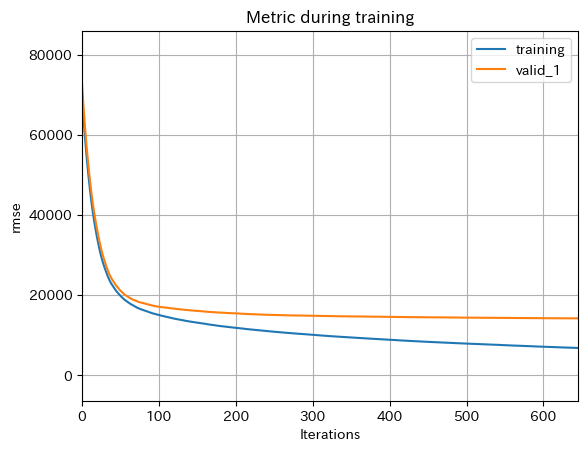

importance
面積               4.534754e+14
L                4.033836e+14
平均地価             2.206073e+14
最寄り駅             8.488876e+13
築年数              7.704610e+13
全体の階数            3.896996e+13
所在地              3.870451e+13
一部屋あたりの面積        3.173551e+13
契約期間             1.867127e+13
所在階              1.405116e+13
所要時間             1.000869e+13
定期借家             3.790471e+12
部屋数              1.552757e+12
バス・トイレ別          1.511867e+12
建物構造             1.279012e+12
S                1.122554e+12
D                7.755047e+11
50m^2以上75m^2未満   4.005371e+11
75m^2以上100m^2未満  2.893097e+11

In [19]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

スコア16837という、チューニングした方がスコアが低くなるというこれまた不思議な事態。念の為、チューニング前の結果を用いる。

### ひとまず、現時点で1番良いスコアは、「K」を抜いただけのスコア16588！